# **1.(a)**

In [ ]:
import numpy as np

In [ ]:
# Example code for reading the data and the initial weights and biases.
# Note: This is just an example of how to read these files, you can modify the code in your own implementation.

train_x, train_y = np.load('fashion_mnist/train_x.npy'), np.load('fashion_mnist/train_y.npy')
test_x, test_y = np.load('fashion_mnist/test_x.npy'), np.load('fashion_mnist/test_y.npy')

print('shape of data:')
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

checkpoint = np.load('weights.npy', allow_pickle=True).item()
#checkpoint = checkpoint.astype('float128')
init_weights = checkpoint['w']
init_biases = checkpoint['b']

print('shape of weights:')
for w in init_weights:
    print(w.shape)

print()

print('shape of biases:')
for b in init_biases:
    print(b.shape)

shape of data:
(30000, 784)
(30000,)
(5000, 784)
(5000,)
shape of weights:
(784, 2048)
(2048, 512)
(512, 5)

shape of biases:
(2048,)
(512,)
(5,)


In [ ]:
EPOCH = 20
Batch_size = 200
Learning_rate = 0.001

In [ ]:
#train_x_norm = train_x.astype('float32')
#test_x_norm = test_x.astype('float32')
# normalize to range 0-1
train_norm = train_x / 255.0
test_norm = test_x / 255.0

train_image_num = train_norm.shape[0]
test_image_num = test_norm.shape[0]
train_batch_num = train_image_num //Batch_size
# test_batch_num = test_image_num//Batch_size

label_temp = np.zeros((train_image_num, 5), dtype = np.float64)
for i in range(train_image_num):
    label_temp[i][train_y[i]] = 1
train_label_onehot = np.copy(label_temp)

test_label_temp = np.zeros((test_image_num, 5), dtype = np.float64)
for i in range(test_image_num):
    test_label_temp[i][test_y[i]] = 1
test_label_onehot = np.copy(test_label_temp)

print("One-hot training labels shape:",train_label_onehot.shape)
print("One-hot testing labels shape:",test_label_onehot.shape)


One-hot training labels shape: (30000, 5)
One-hot testing labels shape: (5000, 5)


In [ ]:
class _Layer(object):
    def __init__(self):
        pass

    def forward(self, *input):
        r"""Define the forward propagation of this layer.

        Should be overridden by all subclasses.
        """
        
        raise NotImplementedError

    def backward(self, *output_grad):
        r"""Define the backward propagation of this layer.

        Should be overridden by all subclasses.
        """
        raise NotImplementedError
        

class FullyConnected(_Layer):
    def __init__(self,n_in,n_out, weights, biases):
        self.weights = weights
        self.biases = biases
    def forward(self, x):
        self.old_x = x
        #print('FullyConnected forward input', x)
        #print('shape', self.weights.shape, self.biases.shape)
        #print('self.weight',self.weights, 'b', self.biases )
        #print('output of FC,', np.dot(x,self.weights) + self.biases )
        return np.dot(x,self.weights) + self.biases

    def backward(self,grad):
        #print('self.old_x',self.old_x)
        #print('grad', grad)
        self.grad_b = grad.mean(axis=0)
        self.grad_w = (np.matmul(self.old_x[:,:,None],grad[:,None,:])).mean(axis=0)
        return np.dot(grad,self.weights.transpose())

#00 - sigmoid
"""class ACTIVITY1(_Layer):
    def __init__(self):
        pass

    def forward(self, x):
        self.old_y = np.exp(x) / (1. + np.exp(x))
        return self.old_y


    def backward(self, grad):
        return self.old_y * (1. - self.old_y) * grad"""
#00 - relu
class Relu(_Layer):
    def __init__(self):
        self.old_x=None;
        pass

    def forward(self, x):     
        self.old_x = np.copy(x)
        return np.clip(x,0,None)


    def backward(self, grad):
        return np.where(self.old_x>0,grad,0)


class Softmax(_Layer):
    def __init__(self):
        self.old_y = None
    def forward(self,x):
            max = np.amax(x, axis = 1, keepdims = True)
            self.old_y = np.exp(x- max) / np.exp(x- max).sum(axis=1) [:,None]
            return self.old_y

    def backward(self,grad, yt):
            
            """for j in range(num_classes):
                  p = np.exp(f_i[j])/sum_i
                  dW[j, :] += (p-(j == y[i])) * X[:, i]"""
            #print('yt', yt.shape, yt)
            yt = self.old_y
            j_max = []
            for k in range(grad.shape[0]):
                jacobian_m = np.diag(yt[k])
                for i in range(len(jacobian_m)):
                    for j in range(len(jacobian_m)):
                        if i == j:
                            jacobian_m[i][j] = yt[k][i] * (1-yt[k][i])
                        else: 
                            jacobian_m[i][j] = -yt[k][i]*yt[k][j]
                der_dot_grad = np.dot(jacobian_m, grad[k].reshape((5, 1)))

                j_max.append(der_dot_grad)
            return np.array(j_max).reshape((200, 5))

            """j_max = []
            for k in range(grad.shape[0]): #self.old_y (200, 5)
                si_sj = - self.old_y[k] * self.old_y[k].reshape((5, 1))
                s_der = np.diag(self.old_y[k]) + si_sj
                s_der_grad = np.dot(s_der, grad[k].reshape((5, 1)))
                j_max.append(s_der_grad)
            #print('np.array(j_max)  shape', np.array(j_max).shape)
            return np.array(j_max).reshape((200, 5))"""
            """s = self.old_y.reshape(-1,1)
            return np.diagflat(s) - np.dot(s, s.T)"""

class CrossEntropy():
    def forward(self,x,y):
            self.old_x = x.clip(min=1e-8,max=None)
            self.old_y = y

            #return x,-np.sum(y*np.log(self.old_x))/x.shape[0]
            
            return x,-np.sum(y*np.log(self.old_x+1e-9))/x.shape[0]
            #return (np.where(y==1,-np.log(self.old_x), 0)).sum(axis=1)

    def backward(self):
            return self.old_y, np.where(self.old_y==1,-1/self.old_x, 0)
            #return self.old_y
    

In [ ]:
class Model(object):
    def __init__(self, layers, cost):
        self.layers = layers
        self.cost = cost
        self.pred = None
        self.training = None
    def forward(self,x):
        for layer in self.layers:
            
            x = layer.forward(x)
            #print('x', x)
        return x
    def train(self):
        self.training = True
        for layer in self.layers:
            if type(layer) == Dropout:
              layer.train()
    def eval(self):
        self.training = False
        for layer in self.layers:
            if type(layer) == Dropout:
              layer.eval()
    def loss(self,x,y):
        return self.cost.forward(self.forward(x),y)

    def backward(self):
        y, grad  = self.cost.backward()
        #print('cost backward', grad)
        for i in range(len(self.layers)-1,-1,-1):
            if type(self.layers[i]) == Softmax:
                grad = self.layers[i].backward(grad, y)
                
            elif(hasattr(self.layers[i], 'backward')):
                grad = self.layers[i].backward(grad)
                #print("backward",type(self.layers[i]), 'grad', grad)

In [ ]:
net1 = Model([FullyConnected(784,2048, init_weights[0], init_biases[0]),Relu(),FullyConnected(2048,512, init_weights[1], init_biases[1]),Relu(),FullyConnected(512,5, init_weights[2], init_biases[2]),Softmax()], CrossEntropy())


In [ ]:
from tqdm import tqdm
#np.seterr(divide='ignore',invalid='ignore')
loss = []
accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(1, EPOCH+1):
    
    train_loss=0
    val_loss=0
    train_hit = 0
    val_hit = 0
    total_train_loss = 0
    total_val_loss = 0
    for it in tqdm(range(train_batch_num)):
        #net1.train()
        pred,lo = net1.loss(train_norm[it*Batch_size:(it+1)*Batch_size], train_label_onehot[it*Batch_size:(it+1)*Batch_size])
        train_loss=lo.sum()
        pred_index = np.argmax(pred, axis=1)
        #print('pred_index', pred_index)
        train_hit += (pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()
        #print('train_y', train_y[it*Batch_size:(it+1)*Batch_size])
        
        total_train_loss += train_loss
        
        net1.backward()
        for layer in net1.layers:
            if type(layer) == FullyConnected:
                #print('update w', layer.grad_w)
                layer.weights -= Learning_rate * layer.grad_w
                layer.biases -= Learning_rate * layer.grad_b

        #net1.eval()
        test_pred,lo = net1.loss(test_norm, test_label_onehot)#.sum()
        val_loss=lo.sum()
        test_pred_index = np.argmax(test_pred, axis=1)
        hit = (test_pred_index==test_y).sum()
        val_hit += hit
        total_val_loss += val_loss

        if((it+1)%50 ==0):  
          loss.append(train_loss)
          accuracy.append((pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()/(Batch_size)*100.0)
          test_loss.append(val_loss)
          test_accuracy.append((test_pred_index==test_y).sum()/(test_image_num)*100.0)
   
        #print('Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(total_train_loss/train_batch_num), '|Train Acc:%3.4f'%(train_hit/(train_image_num)*100.0) , '|Val Loss:%8.4f'%total_val_loss, '|Val Acc:%3.4f'%(val_hit/(test_image_num)*100.0))
        print('Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(train_loss), '|Train Acc:%3.4f'%((pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()/(Batch_size)*100.0) , '|Val Loss:%8.4f'%(val_loss), '|Val Acc:%3.4f'%((test_pred_index==test_y).sum()/(test_image_num)*100.0))


   

  1%|          | 1/150 [00:04<10:31,  4.24s/it]

Epoch:  1 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss: 10.6325 |Val Acc:41.9000


  1%|▏         | 2/150 [00:07<08:52,  3.60s/it]

Epoch:  1 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss: 10.6328 |Val Acc:41.9000


  2%|▏         | 3/150 [00:10<08:16,  3.38s/it]

Epoch:  1 |Train Loss: 10.2004 |Train Acc:44.0000 |Val Loss: 10.5142 |Val Acc:42.5000


  3%|▎         | 4/150 [00:13<08:01,  3.30s/it]

Epoch:  1 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss: 10.5142 |Val Acc:42.5000


  3%|▎         | 5/150 [00:17<08:11,  3.39s/it]

Epoch:  1 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss: 10.5142 |Val Acc:42.5000


  4%|▍         | 6/150 [00:24<11:29,  4.79s/it]

Epoch:  1 |Train Loss:  9.6539 |Train Acc:47.0000 |Val Loss:  9.9583 |Val Acc:45.4800


  5%|▍         | 7/150 [00:28<10:27,  4.39s/it]

Epoch:  1 |Train Loss:  9.7945 |Train Acc:46.0000 |Val Loss:  9.6962 |Val Acc:46.9400


  5%|▌         | 8/150 [00:31<09:49,  4.15s/it]

Epoch:  1 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  9.6962 |Val Acc:46.9400


  6%|▌         | 9/150 [00:35<09:13,  3.93s/it]

Epoch:  1 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  9.6962 |Val Acc:46.9400


  7%|▋         | 10/150 [00:38<08:48,  3.78s/it]

Epoch:  1 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  9.6962 |Val Acc:46.9400


  7%|▋         | 11/150 [00:42<08:29,  3.66s/it]

Epoch:  1 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  9.6962 |Val Acc:46.9400


  8%|▊         | 12/150 [00:45<08:21,  3.63s/it]

Epoch:  1 |Train Loss:  8.3186 |Train Acc:54.5000 |Val Loss:  9.9913 |Val Acc:45.3800


  9%|▊         | 13/150 [00:49<08:12,  3.59s/it]

Epoch:  1 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  9.9913 |Val Acc:45.3800


  9%|▉         | 14/150 [00:52<08:06,  3.57s/it]

Epoch:  1 |Train Loss: 10.5374 |Train Acc:42.5000 |Val Loss:  9.9489 |Val Acc:45.6600


 10%|█         | 15/150 [00:56<07:57,  3.54s/it]

Epoch:  1 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  9.9489 |Val Acc:45.6600


 11%|█         | 16/150 [00:59<07:49,  3.50s/it]

Epoch:  1 |Train Loss: 10.6343 |Train Acc:41.5000 |Val Loss: 10.0798 |Val Acc:44.8200


 11%|█▏        | 17/150 [01:03<07:41,  3.47s/it]

Epoch:  1 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss: 10.0798 |Val Acc:44.8200


 12%|█▏        | 18/150 [01:06<07:43,  3.51s/it]

Epoch:  1 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss: 10.0798 |Val Acc:44.8200


 13%|█▎        | 19/150 [01:10<07:41,  3.52s/it]

Epoch:  1 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss: 10.0798 |Val Acc:44.8200


 13%|█▎        | 20/150 [01:13<07:38,  3.53s/it]

Epoch:  1 |Train Loss:  9.9353 |Train Acc:45.5000 |Val Loss: 10.2237 |Val Acc:44.1200


 14%|█▍        | 21/150 [01:17<07:32,  3.51s/it]

Epoch:  1 |Train Loss: 11.1719 |Train Acc:39.0000 |Val Loss: 10.0653 |Val Acc:44.9600


 15%|█▍        | 22/150 [01:21<07:39,  3.59s/it]

Epoch:  1 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss: 10.0653 |Val Acc:44.9600


 15%|█▌        | 23/150 [01:24<07:32,  3.56s/it]

Epoch:  1 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss: 10.0640 |Val Acc:44.9600


 16%|█▌        | 24/150 [01:28<07:27,  3.55s/it]

Epoch:  1 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss: 10.0640 |Val Acc:44.9600


 17%|█▋        | 25/150 [01:31<07:21,  3.53s/it]

Epoch:  1 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss: 10.0637 |Val Acc:44.9600


 17%|█▋        | 26/150 [01:35<07:15,  3.51s/it]

Epoch:  1 |Train Loss:  9.0809 |Train Acc:50.0000 |Val Loss:  9.8089 |Val Acc:46.3400


 18%|█▊        | 27/150 [01:38<07:12,  3.51s/it]

Epoch:  1 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  9.8089 |Val Acc:46.3400


 19%|█▊        | 28/150 [01:42<07:10,  3.53s/it]

Epoch:  1 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  9.8089 |Val Acc:46.3400


 19%|█▉        | 29/150 [01:45<07:06,  3.53s/it]

Epoch:  1 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  9.8089 |Val Acc:46.3400


 20%|██        | 30/150 [01:49<07:02,  3.52s/it]

Epoch:  1 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  9.8089 |Val Acc:46.3400


 21%|██        | 31/150 [01:52<07:01,  3.54s/it]

Epoch:  1 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  9.8089 |Val Acc:46.3400


 21%|██▏       | 32/150 [01:56<07:03,  3.59s/it]

Epoch:  1 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  9.8089 |Val Acc:46.3400


 22%|██▏       | 33/150 [01:59<06:59,  3.58s/it]

Epoch:  1 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  9.8074 |Val Acc:46.3400


 23%|██▎       | 34/150 [02:03<06:49,  3.53s/it]

Epoch:  1 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  9.8074 |Val Acc:46.3400


 23%|██▎       | 35/150 [02:06<06:45,  3.52s/it]

Epoch:  1 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  9.8074 |Val Acc:46.3400


 24%|██▍       | 36/150 [02:10<06:43,  3.54s/it]

Epoch:  1 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  9.8074 |Val Acc:46.3400


 25%|██▍       | 37/150 [02:14<06:40,  3.54s/it]

Epoch:  1 |Train Loss:  9.2807 |Train Acc:49.0000 |Val Loss:  9.3327 |Val Acc:48.9600


 25%|██▌       | 38/150 [02:17<06:34,  3.52s/it]

Epoch:  1 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  9.3196 |Val Acc:49.0200


 26%|██▌       | 39/150 [02:21<06:31,  3.53s/it]

Epoch:  1 |Train Loss:  8.6203 |Train Acc:52.5000 |Val Loss:  9.3529 |Val Acc:48.8200


 27%|██▋       | 40/150 [02:24<06:24,  3.50s/it]

Epoch:  1 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  9.3173 |Val Acc:49.0200


 27%|██▋       | 41/150 [02:27<06:18,  3.48s/it]

Epoch:  1 |Train Loss:  9.4592 |Train Acc:48.0000 |Val Loss:  9.3872 |Val Acc:48.7200


 28%|██▊       | 42/150 [02:31<06:13,  3.46s/it]

Epoch:  1 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  9.3317 |Val Acc:49.0200


 29%|██▊       | 43/150 [02:34<06:10,  3.46s/it]

Epoch:  1 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  9.3317 |Val Acc:49.0200


 29%|██▉       | 44/150 [02:38<06:15,  3.55s/it]

Epoch:  1 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  9.2918 |Val Acc:49.2000


 30%|███       | 45/150 [02:41<06:08,  3.51s/it]

Epoch:  1 |Train Loss:  9.9928 |Train Acc:45.0000 |Val Loss:  9.3448 |Val Acc:48.8800


 31%|███       | 46/150 [02:45<06:06,  3.52s/it]

Epoch:  1 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  9.3448 |Val Acc:48.8800


 31%|███▏      | 47/150 [02:49<06:02,  3.52s/it]

Epoch:  1 |Train Loss: 10.0573 |Train Acc:45.0000 |Val Loss:  9.6824 |Val Acc:47.0600


 32%|███▏      | 48/150 [02:52<05:57,  3.51s/it]

Epoch:  1 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  9.6824 |Val Acc:47.0600


 33%|███▎      | 49/150 [02:55<05:52,  3.49s/it]

Epoch:  1 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  9.6824 |Val Acc:47.0600


 33%|███▎      | 50/150 [02:59<05:47,  3.47s/it]

Epoch:  1 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  9.6824 |Val Acc:47.0600


 34%|███▍      | 51/150 [03:02<05:42,  3.46s/it]

Epoch:  1 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  9.6824 |Val Acc:47.0600


 35%|███▍      | 52/150 [03:06<05:46,  3.53s/it]

Epoch:  1 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  9.6824 |Val Acc:47.0600


 35%|███▌      | 53/150 [03:10<05:42,  3.53s/it]

Epoch:  1 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  9.6809 |Val Acc:47.0600


 36%|███▌      | 54/150 [03:13<05:35,  3.49s/it]

Epoch:  1 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  9.6809 |Val Acc:47.0600


 37%|███▋      | 55/150 [03:17<05:34,  3.52s/it]

Epoch:  1 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  9.6809 |Val Acc:47.0600


 37%|███▋      | 56/150 [03:20<05:33,  3.55s/it]

Epoch:  1 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  9.6809 |Val Acc:47.0600


 38%|███▊      | 57/150 [03:24<05:25,  3.50s/it]

Epoch:  1 |Train Loss:  9.0714 |Train Acc:50.5000 |Val Loss:  9.6553 |Val Acc:47.2000


 39%|███▊      | 58/150 [03:27<05:25,  3.54s/it]

Epoch:  1 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  9.6553 |Val Acc:47.2000


 39%|███▉      | 59/150 [03:31<05:18,  3.50s/it]

Epoch:  1 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  9.6553 |Val Acc:47.2000


 40%|████      | 60/150 [03:34<05:18,  3.54s/it]

Epoch:  1 |Train Loss:  9.2255 |Train Acc:49.5000 |Val Loss:  9.5720 |Val Acc:47.6400


 41%|████      | 61/150 [03:38<05:14,  3.53s/it]

Epoch:  1 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  9.5720 |Val Acc:47.6400


 41%|████▏     | 62/150 [03:41<05:11,  3.54s/it]

Epoch:  1 |Train Loss:  9.5295 |Train Acc:48.0000 |Val Loss:  9.5518 |Val Acc:47.7400


 42%|████▏     | 63/150 [03:45<05:05,  3.51s/it]

Epoch:  1 |Train Loss: 10.4731 |Train Acc:42.5000 |Val Loss: 10.0652 |Val Acc:45.0200


 43%|████▎     | 64/150 [03:48<04:59,  3.49s/it]

Epoch:  1 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss: 10.0652 |Val Acc:45.0200


 43%|████▎     | 65/150 [03:52<04:57,  3.50s/it]

Epoch:  1 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss: 10.0652 |Val Acc:45.0200


 44%|████▍     | 66/150 [03:55<04:51,  3.47s/it]

Epoch:  1 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss: 10.0652 |Val Acc:45.0200


 45%|████▍     | 67/150 [03:59<04:52,  3.52s/it]

Epoch:  1 |Train Loss: 10.0300 |Train Acc:45.0000 |Val Loss: 10.1319 |Val Acc:44.6400


 45%|████▌     | 68/150 [04:02<04:50,  3.55s/it]

Epoch:  1 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss: 10.1319 |Val Acc:44.6400


 46%|████▌     | 69/150 [04:06<04:46,  3.53s/it]

Epoch:  1 |Train Loss: 10.4025 |Train Acc:43.0000 |Val Loss:  9.9433 |Val Acc:45.6000


 47%|████▋     | 70/150 [04:09<04:39,  3.49s/it]

Epoch:  1 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  9.9433 |Val Acc:45.6000


 47%|████▋     | 71/150 [04:13<04:34,  3.47s/it]

Epoch:  1 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  9.9433 |Val Acc:45.6000


 48%|████▊     | 72/150 [04:16<04:30,  3.46s/it]

Epoch:  1 |Train Loss:  9.7125 |Train Acc:47.0000 |Val Loss:  9.9404 |Val Acc:45.6400


 49%|████▊     | 73/150 [04:20<04:25,  3.45s/it]

Epoch:  1 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  9.9404 |Val Acc:45.6400


 49%|████▉     | 74/150 [04:23<04:21,  3.44s/it]

Epoch:  1 |Train Loss:  9.5774 |Train Acc:47.0000 |Val Loss:  9.6661 |Val Acc:47.1400


 50%|█████     | 75/150 [04:27<04:26,  3.55s/it]

Epoch:  1 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  9.6661 |Val Acc:47.1400


 51%|█████     | 76/150 [04:30<04:22,  3.54s/it]

Epoch:  1 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  9.6661 |Val Acc:47.1400


 51%|█████▏    | 77/150 [04:34<04:16,  3.51s/it]

Epoch:  1 |Train Loss:  9.6571 |Train Acc:47.0000 |Val Loss:  9.2272 |Val Acc:49.5600


 52%|█████▏    | 78/150 [04:37<04:10,  3.48s/it]

Epoch:  1 |Train Loss: 10.0722 |Train Acc:44.5000 |Val Loss:  8.8987 |Val Acc:51.3800


 53%|█████▎    | 79/150 [04:41<04:07,  3.49s/it]

Epoch:  1 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  8.8987 |Val Acc:51.3800


 53%|█████▎    | 80/150 [04:44<04:04,  3.50s/it]

Epoch:  1 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  8.8987 |Val Acc:51.3800


 54%|█████▍    | 81/150 [04:48<04:01,  3.50s/it]

Epoch:  1 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  8.8987 |Val Acc:51.3800


 55%|█████▍    | 82/150 [04:51<04:00,  3.54s/it]

Epoch:  1 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  8.8987 |Val Acc:51.3800


 55%|█████▌    | 83/150 [04:55<03:55,  3.51s/it]

Epoch:  1 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  8.8987 |Val Acc:51.3800


 56%|█████▌    | 84/150 [04:58<03:50,  3.49s/it]

Epoch:  1 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  8.8987 |Val Acc:51.3800


 57%|█████▋    | 85/150 [05:02<03:47,  3.50s/it]

Epoch:  1 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  8.8987 |Val Acc:51.3800


 57%|█████▋    | 86/150 [05:05<03:44,  3.51s/it]

Epoch:  1 |Train Loss:  8.6013 |Train Acc:53.0000 |Val Loss:  8.7029 |Val Acc:52.4000


 58%|█████▊    | 87/150 [05:09<03:39,  3.48s/it]

Epoch:  1 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  8.7029 |Val Acc:52.4000


 59%|█████▊    | 88/150 [05:12<03:38,  3.52s/it]

Epoch:  1 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  8.7029 |Val Acc:52.4000


 59%|█████▉    | 89/150 [05:16<03:32,  3.49s/it]

Epoch:  1 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  8.7029 |Val Acc:52.4000


 60%|██████    | 90/150 [05:19<03:29,  3.50s/it]

Epoch:  1 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  8.6991 |Val Acc:52.4200


 61%|██████    | 91/150 [05:23<03:29,  3.55s/it]

Epoch:  1 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  8.6991 |Val Acc:52.4200


 61%|██████▏   | 92/150 [05:26<03:25,  3.55s/it]

Epoch:  1 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  8.6990 |Val Acc:52.4200


 62%|██████▏   | 93/150 [05:30<03:20,  3.51s/it]

Epoch:  1 |Train Loss:  9.6145 |Train Acc:47.0000 |Val Loss:  8.8954 |Val Acc:51.3400


 63%|██████▎   | 94/150 [05:33<03:17,  3.53s/it]

Epoch:  1 |Train Loss:  7.6985 |Train Acc:58.0000 |Val Loss:  8.8928 |Val Acc:51.3600


 63%|██████▎   | 95/150 [05:37<03:12,  3.50s/it]

Epoch:  1 |Train Loss: 10.0814 |Train Acc:45.0000 |Val Loss:  8.8607 |Val Acc:51.5600


 64%|██████▍   | 96/150 [05:40<03:09,  3.51s/it]

Epoch:  1 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  8.8607 |Val Acc:51.5600


 65%|██████▍   | 97/150 [05:44<03:04,  3.49s/it]

Epoch:  1 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  8.8607 |Val Acc:51.5600


 65%|██████▌   | 98/150 [05:47<03:02,  3.50s/it]

Epoch:  1 |Train Loss:  8.7964 |Train Acc:52.0000 |Val Loss:  8.8649 |Val Acc:51.5200


 66%|██████▌   | 99/150 [05:51<02:59,  3.51s/it]

Epoch:  1 |Train Loss:  9.3456 |Train Acc:49.0000 |Val Loss:  8.9647 |Val Acc:51.0000


 67%|██████▋   | 100/150 [05:54<02:55,  3.52s/it]

Epoch:  1 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  8.9647 |Val Acc:51.0000


 67%|██████▋   | 101/150 [05:58<02:51,  3.50s/it]

Epoch:  1 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  8.9647 |Val Acc:51.0000


 68%|██████▊   | 102/150 [06:02<02:50,  3.55s/it]

Epoch:  1 |Train Loss:  9.9639 |Train Acc:45.5000 |Val Loss:  8.7354 |Val Acc:52.2600


 69%|██████▊   | 103/150 [06:05<02:45,  3.53s/it]

Epoch:  1 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  8.7354 |Val Acc:52.2600


 69%|██████▉   | 104/150 [06:09<02:43,  3.56s/it]

Epoch:  1 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  8.7354 |Val Acc:52.2600


 70%|███████   | 105/150 [06:12<02:39,  3.55s/it]

Epoch:  1 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  8.7354 |Val Acc:52.2600


 71%|███████   | 106/150 [06:16<02:34,  3.51s/it]

Epoch:  1 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  8.7354 |Val Acc:52.2600


 71%|███████▏  | 107/150 [06:19<02:29,  3.49s/it]

Epoch:  1 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  8.7354 |Val Acc:52.2600


 72%|███████▏  | 108/150 [06:22<02:25,  3.47s/it]

Epoch:  1 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  8.7351 |Val Acc:52.2600


 73%|███████▎  | 109/150 [06:26<02:21,  3.44s/it]

Epoch:  1 |Train Loss:  8.6807 |Train Acc:52.5000 |Val Loss:  8.6975 |Val Acc:52.4400


 73%|███████▎  | 110/150 [06:29<02:17,  3.43s/it]

Epoch:  1 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  8.6975 |Val Acc:52.4400


 74%|███████▍  | 111/150 [06:33<02:13,  3.43s/it]

Epoch:  1 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  8.6975 |Val Acc:52.4400


 75%|███████▍  | 112/150 [06:36<02:13,  3.51s/it]

Epoch:  1 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  8.6975 |Val Acc:52.4400


 75%|███████▌  | 113/150 [06:40<02:09,  3.49s/it]

Epoch:  1 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  8.6974 |Val Acc:52.4400


 76%|███████▌  | 114/150 [06:43<02:05,  3.49s/it]

Epoch:  1 |Train Loss:  8.9575 |Train Acc:51.0000 |Val Loss:  8.5681 |Val Acc:53.1400


 77%|███████▋  | 115/150 [06:47<02:02,  3.49s/it]

Epoch:  1 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  8.5681 |Val Acc:53.1400


 77%|███████▋  | 116/150 [06:50<01:57,  3.47s/it]

Epoch:  1 |Train Loss:  8.5106 |Train Acc:53.5000 |Val Loss:  8.8452 |Val Acc:51.6800


 78%|███████▊  | 117/150 [06:54<01:58,  3.59s/it]

Epoch:  1 |Train Loss:  8.6925 |Train Acc:52.0000 |Val Loss:  8.4913 |Val Acc:53.5200


 79%|███████▊  | 118/150 [06:58<01:55,  3.62s/it]

Epoch:  1 |Train Loss:  8.4896 |Train Acc:53.5000 |Val Loss:  8.4966 |Val Acc:53.5600


 79%|███████▉  | 119/150 [07:01<01:50,  3.56s/it]

Epoch:  1 |Train Loss:  9.0737 |Train Acc:50.5000 |Val Loss:  8.4818 |Val Acc:53.6600


 80%|████████  | 120/150 [07:05<01:45,  3.51s/it]

Epoch:  1 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  8.4819 |Val Acc:53.6600


 81%|████████  | 121/150 [07:08<01:42,  3.52s/it]

Epoch:  1 |Train Loss:  8.8287 |Train Acc:51.5000 |Val Loss:  8.3232 |Val Acc:54.4600


 81%|████████▏ | 122/150 [07:12<01:38,  3.51s/it]

Epoch:  1 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  8.3232 |Val Acc:54.4600


 82%|████████▏ | 123/150 [07:15<01:34,  3.49s/it]

Epoch:  1 |Train Loss:  9.0609 |Train Acc:50.5000 |Val Loss:  8.3616 |Val Acc:54.3000


 83%|████████▎ | 124/150 [07:19<01:30,  3.48s/it]

Epoch:  1 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  8.3616 |Val Acc:54.3000


 83%|████████▎ | 125/150 [07:22<01:26,  3.46s/it]

Epoch:  1 |Train Loss:  7.2642 |Train Acc:60.0000 |Val Loss:  8.3000 |Val Acc:54.6400


 84%|████████▍ | 126/150 [07:25<01:23,  3.49s/it]

Epoch:  1 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  8.3000 |Val Acc:54.6400


 85%|████████▍ | 127/150 [07:29<01:21,  3.53s/it]

Epoch:  1 |Train Loss:  6.6949 |Train Acc:63.0000 |Val Loss:  8.3247 |Val Acc:54.5200


 85%|████████▌ | 128/150 [07:33<01:17,  3.51s/it]

Epoch:  1 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  8.3247 |Val Acc:54.5200


 86%|████████▌ | 129/150 [07:36<01:13,  3.50s/it]

Epoch:  1 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  8.3247 |Val Acc:54.5200


 87%|████████▋ | 130/150 [07:39<01:09,  3.47s/it]

Epoch:  1 |Train Loss:  9.6823 |Train Acc:46.5000 |Val Loss:  8.3465 |Val Acc:54.4000


 87%|████████▋ | 131/150 [07:43<01:05,  3.47s/it]

Epoch:  1 |Train Loss:  8.1598 |Train Acc:55.0000 |Val Loss:  8.2965 |Val Acc:54.6400


 88%|████████▊ | 132/150 [07:46<01:02,  3.45s/it]

Epoch:  1 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  8.2965 |Val Acc:54.6400


 89%|████████▊ | 133/150 [07:50<00:58,  3.47s/it]

Epoch:  1 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  8.2965 |Val Acc:54.6400


 89%|████████▉ | 134/150 [07:53<00:55,  3.47s/it]

Epoch:  1 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  8.2965 |Val Acc:54.6400


 90%|█████████ | 135/150 [07:57<00:52,  3.49s/it]

Epoch:  1 |Train Loss:  8.0032 |Train Acc:56.0000 |Val Loss:  8.6746 |Val Acc:52.5200


 91%|█████████ | 136/150 [08:00<00:48,  3.47s/it]

Epoch:  1 |Train Loss:  8.5596 |Train Acc:53.0000 |Val Loss:  8.4124 |Val Acc:54.0200


 91%|█████████▏| 137/150 [08:04<00:45,  3.48s/it]

Epoch:  1 |Train Loss:  7.1264 |Train Acc:60.5000 |Val Loss:  7.9735 |Val Acc:56.4000


 92%|█████████▏| 138/150 [08:07<00:42,  3.53s/it]

Epoch:  1 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  7.9735 |Val Acc:56.4000


 93%|█████████▎| 139/150 [08:11<00:38,  3.49s/it]

Epoch:  1 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  7.9735 |Val Acc:56.4000


 93%|█████████▎| 140/150 [08:14<00:35,  3.53s/it]

Epoch:  1 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  7.9735 |Val Acc:56.4000


 94%|█████████▍| 141/150 [08:18<00:31,  3.52s/it]

Epoch:  1 |Train Loss:  7.4875 |Train Acc:59.0000 |Val Loss:  7.9704 |Val Acc:56.4200


 95%|█████████▍| 142/150 [08:21<00:27,  3.48s/it]

Epoch:  1 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  7.9703 |Val Acc:56.4200


 95%|█████████▌| 143/150 [08:25<00:24,  3.46s/it]

Epoch:  1 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  7.9703 |Val Acc:56.4200


 96%|█████████▌| 144/150 [08:28<00:20,  3.44s/it]

Epoch:  1 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  7.9703 |Val Acc:56.4200


 97%|█████████▋| 145/150 [08:32<00:17,  3.45s/it]

Epoch:  1 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  7.9703 |Val Acc:56.4200


 97%|█████████▋| 146/150 [08:35<00:13,  3.49s/it]

Epoch:  1 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  7.9703 |Val Acc:56.4200


 98%|█████████▊| 147/150 [08:39<00:10,  3.51s/it]

Epoch:  1 |Train Loss:  8.8807 |Train Acc:51.5000 |Val Loss:  7.9094 |Val Acc:56.7200


 99%|█████████▊| 148/150 [08:42<00:06,  3.49s/it]

Epoch:  1 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  7.9094 |Val Acc:56.7200


 99%|█████████▉| 149/150 [08:46<00:03,  3.46s/it]

Epoch:  1 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  7.9093 |Val Acc:56.7200


100%|██████████| 150/150 [08:49<00:00,  3.53s/it]


Epoch:  1 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  7.9093 |Val Acc:56.7200


  1%|          | 1/150 [00:03<08:49,  3.56s/it]

Epoch:  2 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  7.9093 |Val Acc:56.7200


  1%|▏         | 2/150 [00:06<08:33,  3.47s/it]

Epoch:  2 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  7.9093 |Val Acc:56.7200


  2%|▏         | 3/150 [00:10<08:25,  3.44s/it]

Epoch:  2 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  7.9233 |Val Acc:56.6400


  3%|▎         | 4/150 [00:13<08:25,  3.46s/it]

Epoch:  2 |Train Loss:  7.9025 |Train Acc:56.5000 |Val Loss:  7.8000 |Val Acc:57.3200


  3%|▎         | 5/150 [00:17<08:17,  3.43s/it]

Epoch:  2 |Train Loss:  8.8146 |Train Acc:51.5000 |Val Loss:  7.7289 |Val Acc:57.7000


  4%|▍         | 6/150 [00:20<08:13,  3.43s/it]

Epoch:  2 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  7.7289 |Val Acc:57.7000


  5%|▍         | 7/150 [00:24<08:16,  3.47s/it]

Epoch:  2 |Train Loss:  7.9845 |Train Acc:56.0000 |Val Loss:  7.6858 |Val Acc:58.0200


  5%|▌         | 8/150 [00:27<08:13,  3.47s/it]

Epoch:  2 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  7.6858 |Val Acc:58.0200


  6%|▌         | 9/150 [00:31<08:06,  3.45s/it]

Epoch:  2 |Train Loss:  6.9616 |Train Acc:62.0000 |Val Loss:  7.7059 |Val Acc:57.9200


  7%|▋         | 10/150 [00:34<08:02,  3.44s/it]

Epoch:  2 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  7.7059 |Val Acc:57.9200


  7%|▋         | 11/150 [00:37<07:58,  3.44s/it]

Epoch:  2 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  7.6963 |Val Acc:57.9400


  8%|▊         | 12/150 [00:41<07:53,  3.43s/it]

Epoch:  2 |Train Loss:  5.9818 |Train Acc:67.0000 |Val Loss:  7.6266 |Val Acc:58.3400


  9%|▊         | 13/150 [00:44<07:49,  3.43s/it]

Epoch:  2 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  7.6266 |Val Acc:58.3400


  9%|▉         | 14/150 [00:48<07:51,  3.47s/it]

Epoch:  2 |Train Loss:  8.0379 |Train Acc:56.0000 |Val Loss:  7.7015 |Val Acc:57.9200


 10%|█         | 15/150 [00:51<07:48,  3.47s/it]

Epoch:  2 |Train Loss:  6.8419 |Train Acc:62.5000 |Val Loss:  7.8082 |Val Acc:57.3000


 11%|█         | 16/150 [00:55<07:47,  3.49s/it]

Epoch:  2 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  7.8105 |Val Acc:57.3000


 11%|█▏        | 17/150 [00:58<07:43,  3.49s/it]

Epoch:  2 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  7.8105 |Val Acc:57.3000


 12%|█▏        | 18/150 [01:02<07:42,  3.50s/it]

Epoch:  2 |Train Loss:  6.3821 |Train Acc:65.0000 |Val Loss:  7.4596 |Val Acc:59.1600


 13%|█▎        | 19/150 [01:05<07:34,  3.47s/it]

Epoch:  2 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  7.4341 |Val Acc:59.3400


 13%|█▎        | 20/150 [01:09<07:33,  3.48s/it]

Epoch:  2 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  7.4341 |Val Acc:59.3400


 14%|█▍        | 21/150 [01:12<07:29,  3.49s/it]

Epoch:  2 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  7.4343 |Val Acc:59.3400


 15%|█▍        | 22/150 [01:16<07:22,  3.45s/it]

Epoch:  2 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  7.4343 |Val Acc:59.3400


 15%|█▌        | 23/150 [01:19<07:18,  3.45s/it]

Epoch:  2 |Train Loss:  8.0638 |Train Acc:56.0000 |Val Loss:  7.4028 |Val Acc:59.4800


 16%|█▌        | 24/150 [01:23<07:20,  3.49s/it]

Epoch:  2 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  7.4028 |Val Acc:59.4800


 17%|█▋        | 25/150 [01:26<07:17,  3.50s/it]

Epoch:  2 |Train Loss:  8.2811 |Train Acc:54.5000 |Val Loss:  7.4122 |Val Acc:59.5000


 17%|█▋        | 26/150 [01:30<07:17,  3.53s/it]

Epoch:  2 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  7.4122 |Val Acc:59.5000


 18%|█▊        | 27/150 [01:33<07:11,  3.51s/it]

Epoch:  2 |Train Loss:  6.1257 |Train Acc:66.5000 |Val Loss:  7.4500 |Val Acc:59.2600


 19%|█▊        | 28/150 [01:38<07:48,  3.84s/it]

Epoch:  2 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  7.4500 |Val Acc:59.2600


 19%|█▉        | 29/150 [01:43<08:19,  4.13s/it]

Epoch:  2 |Train Loss:  7.0898 |Train Acc:61.0000 |Val Loss:  7.4578 |Val Acc:59.2000


 20%|██        | 30/150 [01:46<07:50,  3.92s/it]

Epoch:  2 |Train Loss:  7.4966 |Train Acc:59.0000 |Val Loss:  7.4317 |Val Acc:59.3800


 21%|██        | 31/150 [01:50<07:32,  3.80s/it]

Epoch:  2 |Train Loss:  8.4068 |Train Acc:54.0000 |Val Loss:  7.3001 |Val Acc:60.0400


 21%|██▏       | 32/150 [01:53<07:18,  3.71s/it]

Epoch:  2 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  7.2998 |Val Acc:60.0400


 22%|██▏       | 33/150 [01:57<07:09,  3.67s/it]

Epoch:  2 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  7.2998 |Val Acc:60.0400


 23%|██▎       | 34/150 [02:00<07:07,  3.69s/it]

Epoch:  2 |Train Loss:  8.6516 |Train Acc:52.5000 |Val Loss:  7.3548 |Val Acc:59.8400


 23%|██▎       | 35/150 [02:04<06:53,  3.60s/it]

Epoch:  2 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  7.3548 |Val Acc:59.8400


 24%|██▍       | 36/150 [02:07<06:43,  3.54s/it]

Epoch:  2 |Train Loss:  6.5975 |Train Acc:64.0000 |Val Loss:  7.3466 |Val Acc:59.8400


 25%|██▍       | 37/150 [02:11<06:38,  3.53s/it]

Epoch:  2 |Train Loss:  6.4143 |Train Acc:65.0000 |Val Loss:  7.3417 |Val Acc:59.8800


 25%|██▌       | 38/150 [02:14<06:31,  3.50s/it]

Epoch:  2 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  7.3417 |Val Acc:59.8800


 26%|██▌       | 39/150 [02:18<06:25,  3.47s/it]

Epoch:  2 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  7.3417 |Val Acc:59.8800


 27%|██▋       | 40/150 [02:21<06:27,  3.52s/it]

Epoch:  2 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  7.3417 |Val Acc:59.8800


 27%|██▋       | 41/150 [02:25<06:22,  3.51s/it]

Epoch:  2 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  7.3417 |Val Acc:59.8800


 28%|██▊       | 42/150 [02:28<06:22,  3.54s/it]

Epoch:  2 |Train Loss:  7.1477 |Train Acc:61.0000 |Val Loss:  7.3193 |Val Acc:59.9800


 29%|██▊       | 43/150 [02:32<06:19,  3.54s/it]

Epoch:  2 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  7.3194 |Val Acc:59.9800


 29%|██▉       | 44/150 [02:35<06:10,  3.50s/it]

Epoch:  2 |Train Loss:  6.9404 |Train Acc:62.0000 |Val Loss:  7.3486 |Val Acc:59.8000


 30%|███       | 45/150 [02:39<06:07,  3.50s/it]

Epoch:  2 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  7.3486 |Val Acc:59.8000


 31%|███       | 46/150 [02:42<06:01,  3.48s/it]

Epoch:  2 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  7.3486 |Val Acc:59.8000


 31%|███▏      | 47/150 [02:46<06:01,  3.51s/it]

Epoch:  2 |Train Loss:  7.6397 |Train Acc:58.0000 |Val Loss:  7.3323 |Val Acc:59.8400


 32%|███▏      | 48/150 [02:49<05:55,  3.49s/it]

Epoch:  2 |Train Loss:  6.7997 |Train Acc:62.5000 |Val Loss:  7.3602 |Val Acc:59.8000


 33%|███▎      | 49/150 [02:53<05:50,  3.47s/it]

Epoch:  2 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  7.3602 |Val Acc:59.8000


 33%|███▎      | 50/150 [02:56<05:45,  3.46s/it]

Epoch:  2 |Train Loss:  8.0600 |Train Acc:55.5000 |Val Loss:  7.2409 |Val Acc:60.4000


 34%|███▍      | 51/150 [03:00<05:45,  3.49s/it]

Epoch:  2 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  7.2409 |Val Acc:60.4000


 35%|███▍      | 52/150 [03:03<05:42,  3.50s/it]

Epoch:  2 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  7.2409 |Val Acc:60.4000


 35%|███▌      | 53/150 [03:07<05:38,  3.49s/it]

Epoch:  2 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  7.2409 |Val Acc:60.4000


 36%|███▌      | 54/150 [03:10<05:34,  3.49s/it]

Epoch:  2 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  7.2409 |Val Acc:60.4000


 37%|███▋      | 55/150 [03:14<05:35,  3.53s/it]

Epoch:  2 |Train Loss:  7.3543 |Train Acc:59.5000 |Val Loss:  7.3544 |Val Acc:59.8200


 37%|███▋      | 56/150 [03:17<05:30,  3.52s/it]

Epoch:  2 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  7.3544 |Val Acc:59.8200


 38%|███▊      | 57/150 [03:21<05:27,  3.52s/it]

Epoch:  2 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  7.3543 |Val Acc:59.8200


 39%|███▊      | 58/150 [03:24<05:21,  3.50s/it]

Epoch:  2 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  7.3543 |Val Acc:59.8200


 39%|███▉      | 59/150 [03:28<05:19,  3.51s/it]

Epoch:  2 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  7.3547 |Val Acc:59.8000


 40%|████      | 60/150 [03:31<05:19,  3.55s/it]

Epoch:  2 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  7.3547 |Val Acc:59.8000


 41%|████      | 61/150 [03:35<05:16,  3.56s/it]

Epoch:  2 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  7.3547 |Val Acc:59.8000


 41%|████▏     | 62/150 [03:39<05:17,  3.61s/it]

Epoch:  2 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  7.3547 |Val Acc:59.8000


 42%|████▏     | 63/150 [03:42<05:09,  3.56s/it]

Epoch:  2 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  7.3547 |Val Acc:59.8000


 43%|████▎     | 64/150 [03:46<05:04,  3.55s/it]

Epoch:  2 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  7.3547 |Val Acc:59.8000


 43%|████▎     | 65/150 [03:49<05:04,  3.58s/it]

Epoch:  2 |Train Loss:  7.2098 |Train Acc:60.5000 |Val Loss:  7.2256 |Val Acc:60.5000


 44%|████▍     | 66/150 [03:53<04:59,  3.56s/it]

Epoch:  2 |Train Loss:  8.0801 |Train Acc:55.5000 |Val Loss:  7.1349 |Val Acc:61.0200


 45%|████▍     | 67/150 [03:56<04:52,  3.53s/it]

Epoch:  2 |Train Loss:  7.3174 |Train Acc:60.0000 |Val Loss:  7.1079 |Val Acc:61.1600


 45%|████▌     | 68/150 [04:00<04:45,  3.48s/it]

Epoch:  2 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  7.1079 |Val Acc:61.1600


 46%|████▌     | 69/150 [04:03<04:40,  3.47s/it]

Epoch:  2 |Train Loss:  7.6060 |Train Acc:58.5000 |Val Loss:  7.0999 |Val Acc:61.1200


 47%|████▋     | 70/150 [04:07<04:38,  3.48s/it]

Epoch:  2 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  7.0999 |Val Acc:61.1200


 47%|████▋     | 71/150 [04:10<04:37,  3.51s/it]

Epoch:  2 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  7.0999 |Val Acc:61.1200


 48%|████▊     | 72/150 [04:14<04:37,  3.56s/it]

Epoch:  2 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  7.0999 |Val Acc:61.1200


 49%|████▊     | 73/150 [04:17<04:32,  3.53s/it]

Epoch:  2 |Train Loss:  5.4835 |Train Acc:70.0000 |Val Loss:  7.0133 |Val Acc:61.6800


 49%|████▉     | 74/150 [04:21<04:28,  3.54s/it]

Epoch:  2 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  7.0128 |Val Acc:61.6800


 50%|█████     | 75/150 [04:24<04:24,  3.53s/it]

Epoch:  2 |Train Loss:  6.9563 |Train Acc:62.0000 |Val Loss:  6.9811 |Val Acc:61.8000


 51%|█████     | 76/150 [04:28<04:20,  3.53s/it]

Epoch:  2 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  6.9811 |Val Acc:61.8000


 51%|█████▏    | 77/150 [04:31<04:14,  3.48s/it]

Epoch:  2 |Train Loss:  6.2391 |Train Acc:65.5000 |Val Loss:  6.9710 |Val Acc:61.8400


 52%|█████▏    | 78/150 [04:35<04:14,  3.54s/it]

Epoch:  2 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  6.9710 |Val Acc:61.8400


 53%|█████▎    | 79/150 [04:38<04:08,  3.50s/it]

Epoch:  2 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  6.9708 |Val Acc:61.8400


 53%|█████▎    | 80/150 [04:42<04:07,  3.53s/it]

Epoch:  2 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  6.9708 |Val Acc:61.8400


 54%|█████▍    | 81/150 [04:45<04:01,  3.50s/it]

Epoch:  2 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  6.9709 |Val Acc:61.8400


 55%|█████▍    | 82/150 [04:49<03:56,  3.48s/it]

Epoch:  2 |Train Loss:  6.3712 |Train Acc:65.0000 |Val Loss:  6.9283 |Val Acc:62.1600


 55%|█████▌    | 83/150 [04:52<03:56,  3.53s/it]

Epoch:  2 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  6.9283 |Val Acc:62.1600


 56%|█████▌    | 84/150 [04:56<03:50,  3.50s/it]

Epoch:  2 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  6.9283 |Val Acc:62.1600


 57%|█████▋    | 85/150 [04:59<03:48,  3.52s/it]

Epoch:  2 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  6.9238 |Val Acc:62.1600


 57%|█████▋    | 86/150 [05:03<03:43,  3.49s/it]

Epoch:  2 |Train Loss:  6.6497 |Train Acc:63.5000 |Val Loss:  6.9275 |Val Acc:62.1200


 58%|█████▊    | 87/150 [05:08<04:16,  4.07s/it]

Epoch:  2 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  6.9275 |Val Acc:62.1400


 59%|█████▊    | 88/150 [05:12<04:04,  3.94s/it]

Epoch:  2 |Train Loss:  6.5983 |Train Acc:64.0000 |Val Loss:  6.9244 |Val Acc:62.1800


 59%|█████▉    | 89/150 [05:16<03:57,  3.89s/it]

Epoch:  2 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  6.9244 |Val Acc:62.1800


 60%|██████    | 90/150 [05:19<03:49,  3.82s/it]

Epoch:  2 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  6.9244 |Val Acc:62.1800


 61%|██████    | 91/150 [05:23<03:39,  3.72s/it]

Epoch:  2 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  6.9244 |Val Acc:62.1800


 61%|██████▏   | 92/150 [05:26<03:30,  3.64s/it]

Epoch:  2 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  6.9244 |Val Acc:62.1800


 62%|██████▏   | 93/150 [05:30<03:24,  3.58s/it]

Epoch:  2 |Train Loss:  8.1369 |Train Acc:55.5000 |Val Loss:  7.0055 |Val Acc:61.7400


 63%|██████▎   | 94/150 [05:33<03:18,  3.54s/it]

Epoch:  2 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  7.0055 |Val Acc:61.7400


 63%|██████▎   | 95/150 [05:37<03:14,  3.54s/it]

Epoch:  2 |Train Loss:  7.1528 |Train Acc:60.5000 |Val Loss:  6.8698 |Val Acc:62.4600


 64%|██████▍   | 96/150 [05:40<03:10,  3.52s/it]

Epoch:  2 |Train Loss:  6.0641 |Train Acc:66.5000 |Val Loss:  6.8122 |Val Acc:62.7600


 65%|██████▍   | 97/150 [05:44<03:11,  3.61s/it]

Epoch:  2 |Train Loss:  7.1854 |Train Acc:60.5000 |Val Loss:  6.7899 |Val Acc:62.9000


 65%|██████▌   | 98/150 [05:48<03:07,  3.61s/it]

Epoch:  2 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  6.7899 |Val Acc:62.9000


 66%|██████▌   | 99/150 [05:51<03:03,  3.60s/it]

Epoch:  2 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  6.7899 |Val Acc:62.9000


 67%|██████▋   | 100/150 [05:55<03:03,  3.68s/it]

Epoch:  2 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  6.7899 |Val Acc:62.9000


 67%|██████▋   | 101/150 [05:59<02:57,  3.62s/it]

Epoch:  2 |Train Loss:  6.4475 |Train Acc:64.5000 |Val Loss:  6.8194 |Val Acc:62.7400


 68%|██████▊   | 102/150 [06:02<02:52,  3.58s/it]

Epoch:  2 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  6.8194 |Val Acc:62.7400


 69%|██████▊   | 103/150 [06:06<02:47,  3.56s/it]

Epoch:  2 |Train Loss:  7.1335 |Train Acc:60.5000 |Val Loss:  6.9269 |Val Acc:62.1200


 69%|██████▉   | 104/150 [06:09<02:45,  3.59s/it]

Epoch:  2 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  6.9269 |Val Acc:62.1200


 70%|███████   | 105/150 [06:13<02:42,  3.60s/it]

Epoch:  2 |Train Loss:  6.5850 |Train Acc:64.0000 |Val Loss:  6.7762 |Val Acc:62.9600


 71%|███████   | 106/150 [06:16<02:37,  3.58s/it]

Epoch:  2 |Train Loss:  6.3497 |Train Acc:65.0000 |Val Loss:  6.7601 |Val Acc:63.0800


 71%|███████▏  | 107/150 [06:20<02:33,  3.56s/it]

Epoch:  2 |Train Loss:  7.3919 |Train Acc:59.5000 |Val Loss:  6.8691 |Val Acc:62.4200


 72%|███████▏  | 108/150 [06:23<02:29,  3.55s/it]

Epoch:  2 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  6.8691 |Val Acc:62.4200


 73%|███████▎  | 109/150 [06:27<02:25,  3.55s/it]

Epoch:  2 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  6.8691 |Val Acc:62.4200


 73%|███████▎  | 110/150 [06:30<02:21,  3.53s/it]

Epoch:  2 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  6.8691 |Val Acc:62.4200


 74%|███████▍  | 111/150 [06:34<02:17,  3.52s/it]

Epoch:  2 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  6.8691 |Val Acc:62.4200


 75%|███████▍  | 112/150 [06:37<02:13,  3.52s/it]

Epoch:  2 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  6.8691 |Val Acc:62.4200


 75%|███████▌  | 113/150 [06:41<02:10,  3.52s/it]

Epoch:  2 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  6.8691 |Val Acc:62.4200


 76%|███████▌  | 114/150 [06:45<02:07,  3.55s/it]

Epoch:  2 |Train Loss:  6.5984 |Train Acc:64.0000 |Val Loss:  6.8299 |Val Acc:62.6400


 77%|███████▋  | 115/150 [06:48<02:05,  3.59s/it]

Epoch:  2 |Train Loss:  5.3670 |Train Acc:70.5000 |Val Loss:  6.6430 |Val Acc:63.6600


 77%|███████▋  | 116/150 [06:52<02:01,  3.59s/it]

Epoch:  2 |Train Loss:  6.3413 |Train Acc:65.0000 |Val Loss:  6.7003 |Val Acc:63.3400


 78%|███████▊  | 117/150 [06:55<01:58,  3.59s/it]

Epoch:  2 |Train Loss:  6.0015 |Train Acc:67.0000 |Val Loss:  6.5495 |Val Acc:64.1800


 79%|███████▊  | 118/150 [06:59<01:54,  3.56s/it]

Epoch:  2 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  6.5494 |Val Acc:64.1800


 79%|███████▉  | 119/150 [07:03<01:51,  3.61s/it]

Epoch:  2 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  6.5494 |Val Acc:64.1800


 80%|████████  | 120/150 [07:06<01:47,  3.58s/it]

Epoch:  2 |Train Loss:  6.2680 |Train Acc:65.5000 |Val Loss:  6.5555 |Val Acc:64.0800


 81%|████████  | 121/150 [07:10<01:44,  3.61s/it]

Epoch:  2 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  6.5555 |Val Acc:64.0800


 81%|████████▏ | 122/150 [07:13<01:39,  3.56s/it]

Epoch:  2 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  6.5555 |Val Acc:64.0800


 82%|████████▏ | 123/150 [07:17<01:35,  3.54s/it]

Epoch:  2 |Train Loss:  7.2392 |Train Acc:60.5000 |Val Loss:  6.5714 |Val Acc:64.0600


 83%|████████▎ | 124/150 [07:20<01:32,  3.55s/it]

Epoch:  2 |Train Loss:  6.2469 |Train Acc:65.5000 |Val Loss:  6.6259 |Val Acc:63.7200


 83%|████████▎ | 125/150 [07:24<01:29,  3.58s/it]

Epoch:  2 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  6.6259 |Val Acc:63.7200


 84%|████████▍ | 126/150 [07:28<01:25,  3.58s/it]

Epoch:  2 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  6.6259 |Val Acc:63.7200


 85%|████████▍ | 127/150 [07:31<01:23,  3.62s/it]

Epoch:  2 |Train Loss:  5.4215 |Train Acc:70.0000 |Val Loss:  6.5265 |Val Acc:64.3400


 85%|████████▌ | 128/150 [07:35<01:19,  3.60s/it]

Epoch:  2 |Train Loss:  6.9674 |Train Acc:61.5000 |Val Loss:  6.5578 |Val Acc:64.1400


 86%|████████▌ | 129/150 [07:38<01:14,  3.55s/it]

Epoch:  2 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  6.5578 |Val Acc:64.1400


 87%|████████▋ | 130/150 [07:42<01:11,  3.58s/it]

Epoch:  2 |Train Loss:  7.2514 |Train Acc:60.0000 |Val Loss:  6.5513 |Val Acc:64.2200


 87%|████████▋ | 131/150 [07:45<01:07,  3.55s/it]

Epoch:  2 |Train Loss:  6.7553 |Train Acc:63.0000 |Val Loss:  6.4837 |Val Acc:64.5200


 88%|████████▊ | 132/150 [07:49<01:03,  3.55s/it]

Epoch:  2 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  6.4837 |Val Acc:64.5200


 89%|████████▊ | 133/150 [07:53<01:00,  3.55s/it]

Epoch:  2 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  6.4837 |Val Acc:64.5200


 89%|████████▉ | 134/150 [07:56<00:56,  3.55s/it]

Epoch:  2 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  6.4837 |Val Acc:64.5200


 90%|█████████ | 135/150 [08:00<00:52,  3.52s/it]

Epoch:  2 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  6.4837 |Val Acc:64.5200


 91%|█████████ | 136/150 [08:03<00:49,  3.53s/it]

Epoch:  2 |Train Loss:  6.1172 |Train Acc:66.5000 |Val Loss:  6.5141 |Val Acc:64.4000


 91%|█████████▏| 137/150 [08:07<00:45,  3.50s/it]

Epoch:  2 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  6.5141 |Val Acc:64.4000


 92%|█████████▏| 138/150 [08:10<00:41,  3.49s/it]

Epoch:  2 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  6.5141 |Val Acc:64.4000


 93%|█████████▎| 139/150 [08:14<00:38,  3.53s/it]

Epoch:  2 |Train Loss:  5.5584 |Train Acc:69.5000 |Val Loss:  6.5086 |Val Acc:64.3800


 93%|█████████▎| 140/150 [08:17<00:35,  3.50s/it]

Epoch:  2 |Train Loss:  5.6844 |Train Acc:68.5000 |Val Loss:  6.5184 |Val Acc:64.3800


 94%|█████████▍| 141/150 [08:21<00:31,  3.53s/it]

Epoch:  2 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  6.5189 |Val Acc:64.3800


 95%|█████████▍| 142/150 [08:24<00:28,  3.51s/it]

Epoch:  2 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  6.5144 |Val Acc:64.4200


 95%|█████████▌| 143/150 [08:28<00:24,  3.51s/it]

Epoch:  2 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  6.5148 |Val Acc:64.4000


 96%|█████████▌| 144/150 [08:31<00:20,  3.50s/it]

Epoch:  2 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  6.5148 |Val Acc:64.4000


 97%|█████████▋| 145/150 [08:35<00:17,  3.57s/it]

Epoch:  2 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  6.5148 |Val Acc:64.4000


 97%|█████████▋| 146/150 [08:38<00:14,  3.60s/it]

Epoch:  2 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  6.5148 |Val Acc:64.4000


 98%|█████████▊| 147/150 [08:42<00:10,  3.59s/it]

Epoch:  2 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  6.5148 |Val Acc:64.4000


 99%|█████████▊| 148/150 [08:46<00:07,  3.60s/it]

Epoch:  2 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  6.5148 |Val Acc:64.4000


 99%|█████████▉| 149/150 [08:49<00:03,  3.56s/it]

Epoch:  2 |Train Loss:  6.6897 |Train Acc:63.5000 |Val Loss:  6.5171 |Val Acc:64.4000


100%|██████████| 150/150 [08:53<00:00,  3.56s/it]


Epoch:  2 |Train Loss:  6.5416 |Train Acc:64.0000 |Val Loss:  6.6816 |Val Acc:63.4600


  1%|          | 1/150 [00:03<08:55,  3.59s/it]

Epoch:  3 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  6.6820 |Val Acc:63.4600


  1%|▏         | 2/150 [00:07<08:47,  3.57s/it]

Epoch:  3 |Train Loss:  6.2202 |Train Acc:66.0000 |Val Loss:  6.5584 |Val Acc:64.1400


  2%|▏         | 3/150 [00:10<08:44,  3.57s/it]

Epoch:  3 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  6.5584 |Val Acc:64.1400


  3%|▎         | 4/150 [00:14<08:40,  3.56s/it]

Epoch:  3 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  6.5584 |Val Acc:64.1400


  3%|▎         | 5/150 [00:17<08:36,  3.56s/it]

Epoch:  3 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  6.5584 |Val Acc:64.1400


  4%|▍         | 6/150 [00:21<08:35,  3.58s/it]

Epoch:  3 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  6.5573 |Val Acc:64.2000


  5%|▍         | 7/150 [00:24<08:30,  3.57s/it]

Epoch:  3 |Train Loss:  6.0336 |Train Acc:66.5000 |Val Loss:  6.5455 |Val Acc:64.2400


  5%|▌         | 8/150 [00:28<08:23,  3.55s/it]

Epoch:  3 |Train Loss:  5.9173 |Train Acc:67.0000 |Val Loss:  6.5880 |Val Acc:63.9800


  6%|▌         | 9/150 [00:32<08:26,  3.59s/it]

Epoch:  3 |Train Loss:  5.6293 |Train Acc:69.0000 |Val Loss:  6.5719 |Val Acc:64.0800


  7%|▋         | 10/150 [00:35<08:17,  3.55s/it]

Epoch:  3 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  6.5705 |Val Acc:64.0800


  7%|▋         | 11/150 [00:39<08:12,  3.54s/it]

Epoch:  3 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  6.5705 |Val Acc:64.0800


  8%|▊         | 12/150 [00:42<08:04,  3.51s/it]

Epoch:  3 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  6.5705 |Val Acc:64.0800


  9%|▊         | 13/150 [00:46<08:05,  3.55s/it]

Epoch:  3 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  6.5705 |Val Acc:64.0800


  9%|▉         | 14/150 [00:49<07:57,  3.51s/it]

Epoch:  3 |Train Loss:  6.5421 |Train Acc:64.0000 |Val Loss:  6.4879 |Val Acc:64.5000


 10%|█         | 15/150 [00:53<07:51,  3.49s/it]

Epoch:  3 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  6.4879 |Val Acc:64.5000


 11%|█         | 16/150 [00:56<07:55,  3.55s/it]

Epoch:  3 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  6.4878 |Val Acc:64.5000


 11%|█▏        | 17/150 [01:00<07:51,  3.55s/it]

Epoch:  3 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  6.4878 |Val Acc:64.5000


 12%|█▏        | 18/150 [01:03<07:48,  3.55s/it]

Epoch:  3 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  6.4878 |Val Acc:64.5000


 13%|█▎        | 19/150 [01:07<07:45,  3.56s/it]

Epoch:  3 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  6.4878 |Val Acc:64.5000


 13%|█▎        | 20/150 [01:11<07:57,  3.67s/it]

Epoch:  3 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  6.4878 |Val Acc:64.5000


 14%|█▍        | 21/150 [01:15<07:53,  3.67s/it]

Epoch:  3 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  6.4935 |Val Acc:64.5200


 15%|█▍        | 22/150 [01:18<07:41,  3.60s/it]

Epoch:  3 |Train Loss:  7.6312 |Train Acc:58.0000 |Val Loss:  6.5010 |Val Acc:64.4800


 15%|█▌        | 23/150 [01:21<07:32,  3.56s/it]

Epoch:  3 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  6.5010 |Val Acc:64.4800


 16%|█▌        | 24/150 [01:25<07:24,  3.53s/it]

Epoch:  3 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  6.5035 |Val Acc:64.4600


 17%|█▋        | 25/150 [01:28<07:22,  3.54s/it]

Epoch:  3 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  6.5035 |Val Acc:64.4600


 17%|█▋        | 26/150 [01:32<07:21,  3.56s/it]

Epoch:  3 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  6.5035 |Val Acc:64.4600


 18%|█▊        | 27/150 [01:36<07:30,  3.66s/it]

Epoch:  3 |Train Loss:  5.7692 |Train Acc:68.5000 |Val Loss:  6.4909 |Val Acc:64.4800


 19%|█▊        | 28/150 [01:40<07:24,  3.64s/it]

Epoch:  3 |Train Loss:  5.4152 |Train Acc:70.0000 |Val Loss:  6.4423 |Val Acc:64.7600


 19%|█▉        | 29/150 [01:43<07:16,  3.61s/it]

Epoch:  3 |Train Loss:  6.5972 |Train Acc:64.0000 |Val Loss:  6.4422 |Val Acc:64.7400


 20%|██        | 30/150 [01:47<07:15,  3.63s/it]

Epoch:  3 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  6.4422 |Val Acc:64.7400


 21%|██        | 31/150 [01:50<07:07,  3.59s/it]

Epoch:  3 |Train Loss:  7.1638 |Train Acc:60.5000 |Val Loss:  6.5150 |Val Acc:64.3800


 21%|██▏       | 32/150 [01:54<07:04,  3.60s/it]

Epoch:  3 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  6.5150 |Val Acc:64.3800


 22%|██▏       | 33/150 [01:58<07:02,  3.61s/it]

Epoch:  3 |Train Loss:  5.7378 |Train Acc:68.5000 |Val Loss:  6.4943 |Val Acc:64.5200


 23%|██▎       | 34/150 [02:01<06:53,  3.57s/it]

Epoch:  3 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  6.4943 |Val Acc:64.5200


 23%|██▎       | 35/150 [02:05<06:48,  3.55s/it]

Epoch:  3 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  6.4943 |Val Acc:64.5200


 24%|██▍       | 36/150 [02:08<06:46,  3.57s/it]

Epoch:  3 |Train Loss:  5.7074 |Train Acc:68.5000 |Val Loss:  6.4154 |Val Acc:64.9600


 25%|██▍       | 37/150 [02:12<06:46,  3.60s/it]

Epoch:  3 |Train Loss:  5.6397 |Train Acc:69.0000 |Val Loss:  6.2479 |Val Acc:65.8000


 25%|██▌       | 38/150 [02:15<06:42,  3.59s/it]

Epoch:  3 |Train Loss:  6.1155 |Train Acc:66.5000 |Val Loss:  6.2563 |Val Acc:65.8000


 26%|██▌       | 39/150 [02:19<06:34,  3.56s/it]

Epoch:  3 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  6.2563 |Val Acc:65.8000


 27%|██▋       | 40/150 [02:22<06:32,  3.56s/it]

Epoch:  3 |Train Loss:  5.9733 |Train Acc:67.0000 |Val Loss:  6.2710 |Val Acc:65.7000


 27%|██▋       | 41/150 [02:26<06:30,  3.58s/it]

Epoch:  3 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  6.2710 |Val Acc:65.7000


 28%|██▊       | 42/150 [02:30<06:27,  3.59s/it]

Epoch:  3 |Train Loss:  5.4819 |Train Acc:70.0000 |Val Loss:  6.2791 |Val Acc:65.6400


 29%|██▊       | 43/150 [02:33<06:22,  3.57s/it]

Epoch:  3 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  6.2791 |Val Acc:65.6400


 29%|██▉       | 44/150 [02:37<06:18,  3.57s/it]

Epoch:  3 |Train Loss:  5.6294 |Train Acc:69.0000 |Val Loss:  6.1919 |Val Acc:66.1200


 30%|███       | 45/150 [02:40<06:15,  3.57s/it]

Epoch:  3 |Train Loss:  6.4141 |Train Acc:65.0000 |Val Loss:  6.1975 |Val Acc:66.1000


 31%|███       | 46/150 [02:44<06:10,  3.57s/it]

Epoch:  3 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  6.1975 |Val Acc:66.1000


 31%|███▏      | 47/150 [02:48<06:09,  3.59s/it]

Epoch:  3 |Train Loss:  6.7498 |Train Acc:63.0000 |Val Loss:  6.1730 |Val Acc:66.2400


 32%|███▏      | 48/150 [02:51<06:14,  3.67s/it]

Epoch:  3 |Train Loss:  6.1360 |Train Acc:66.5000 |Val Loss:  6.2723 |Val Acc:65.6600


 33%|███▎      | 49/150 [02:59<08:00,  4.75s/it]

Epoch:  3 |Train Loss:  6.4147 |Train Acc:65.0000 |Val Loss:  6.2561 |Val Acc:65.7400


 33%|███▎      | 50/150 [03:04<08:19,  5.00s/it]

Epoch:  3 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  6.2561 |Val Acc:65.7400


 34%|███▍      | 51/150 [03:08<07:32,  4.57s/it]

Epoch:  3 |Train Loss:  6.1474 |Train Acc:66.0000 |Val Loss:  6.1836 |Val Acc:66.2400


 35%|███▍      | 52/150 [03:11<06:58,  4.27s/it]

Epoch:  3 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  6.1836 |Val Acc:66.2400


 35%|███▌      | 53/150 [03:15<06:32,  4.04s/it]

Epoch:  3 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  6.1836 |Val Acc:66.2400


 36%|███▌      | 54/150 [03:18<06:13,  3.89s/it]

Epoch:  3 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  6.1836 |Val Acc:66.2400


 37%|███▋      | 55/150 [03:22<06:01,  3.80s/it]

Epoch:  3 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  6.1836 |Val Acc:66.2400


 37%|███▋      | 56/150 [03:25<05:47,  3.70s/it]

Epoch:  3 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  6.1836 |Val Acc:66.2400


 38%|███▊      | 57/150 [03:29<05:37,  3.63s/it]

Epoch:  3 |Train Loss:  5.6016 |Train Acc:69.0000 |Val Loss:  6.2068 |Val Acc:66.0600


 39%|███▊      | 58/150 [03:32<05:29,  3.58s/it]

Epoch:  3 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  6.2068 |Val Acc:66.0600


 39%|███▉      | 59/150 [03:36<05:23,  3.55s/it]

Epoch:  3 |Train Loss:  6.5975 |Train Acc:63.5000 |Val Loss:  6.1182 |Val Acc:66.5400


 40%|████      | 60/150 [03:39<05:17,  3.52s/it]

Epoch:  3 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  6.1182 |Val Acc:66.5400


 41%|████      | 61/150 [03:43<05:17,  3.57s/it]

Epoch:  3 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  6.1182 |Val Acc:66.5400


 41%|████▏     | 62/150 [03:47<05:14,  3.57s/it]

Epoch:  3 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  6.1182 |Val Acc:66.5400


 42%|████▏     | 63/150 [03:50<05:08,  3.55s/it]

Epoch:  3 |Train Loss:  6.0408 |Train Acc:67.0000 |Val Loss:  6.0419 |Val Acc:66.9400


 43%|████▎     | 64/150 [03:54<05:09,  3.60s/it]

Epoch:  3 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  6.0419 |Val Acc:66.9400


 43%|████▎     | 65/150 [03:57<05:05,  3.60s/it]

Epoch:  3 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  6.0419 |Val Acc:66.9400


 44%|████▍     | 66/150 [04:01<04:59,  3.56s/it]

Epoch:  3 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  6.0419 |Val Acc:66.9400


 45%|████▍     | 67/150 [04:05<04:57,  3.59s/it]

Epoch:  3 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  6.0419 |Val Acc:66.9400


 45%|████▌     | 68/150 [04:08<04:50,  3.55s/it]

Epoch:  3 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  6.0419 |Val Acc:66.9400


 46%|████▌     | 69/150 [04:12<04:46,  3.54s/it]

Epoch:  3 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  6.0419 |Val Acc:66.9400


 47%|████▋     | 70/150 [04:15<04:41,  3.52s/it]

Epoch:  3 |Train Loss:  6.0197 |Train Acc:67.0000 |Val Loss:  6.0609 |Val Acc:66.8400


 47%|████▋     | 71/150 [04:19<04:41,  3.57s/it]

Epoch:  3 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  6.0609 |Val Acc:66.8400


 48%|████▊     | 72/150 [04:22<04:40,  3.60s/it]

Epoch:  3 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  6.0609 |Val Acc:66.8400


 49%|████▊     | 73/150 [04:26<04:36,  3.59s/it]

Epoch:  3 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  6.0609 |Val Acc:66.8400


 49%|████▉     | 74/150 [04:30<04:32,  3.59s/it]

Epoch:  3 |Train Loss:  5.6810 |Train Acc:69.0000 |Val Loss:  6.0589 |Val Acc:66.8400


 50%|█████     | 75/150 [04:33<04:27,  3.57s/it]

Epoch:  3 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  6.0589 |Val Acc:66.8400


 51%|█████     | 76/150 [04:37<04:25,  3.58s/it]

Epoch:  3 |Train Loss:  7.0236 |Train Acc:61.5000 |Val Loss:  6.1468 |Val Acc:66.3800


 51%|█████▏    | 77/150 [04:40<04:22,  3.60s/it]

Epoch:  3 |Train Loss:  5.7852 |Train Acc:68.0000 |Val Loss:  6.1853 |Val Acc:66.2200


 52%|█████▏    | 78/150 [04:44<04:16,  3.56s/it]

Epoch:  3 |Train Loss:  7.0036 |Train Acc:61.5000 |Val Loss:  6.1998 |Val Acc:66.1200


 53%|█████▎    | 79/150 [04:47<04:13,  3.57s/it]

Epoch:  3 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  6.1998 |Val Acc:66.1200


 53%|█████▎    | 80/150 [04:51<04:07,  3.54s/it]

Epoch:  3 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  6.1998 |Val Acc:66.1200


 54%|█████▍    | 81/150 [04:54<04:06,  3.57s/it]

Epoch:  3 |Train Loss:  6.6125 |Train Acc:63.5000 |Val Loss:  6.1950 |Val Acc:66.1600


 55%|█████▍    | 82/150 [04:58<03:59,  3.53s/it]

Epoch:  3 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  6.1950 |Val Acc:66.1600


 55%|█████▌    | 83/150 [05:01<03:56,  3.53s/it]

Epoch:  3 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  6.1950 |Val Acc:66.1600


 56%|█████▌    | 84/150 [05:05<03:50,  3.50s/it]

Epoch:  3 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  6.1950 |Val Acc:66.1600


 57%|█████▋    | 85/150 [05:08<03:48,  3.51s/it]

Epoch:  3 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  6.1950 |Val Acc:66.1600


 57%|█████▋    | 86/150 [05:12<03:45,  3.53s/it]

Epoch:  3 |Train Loss:  6.4730 |Train Acc:64.5000 |Val Loss:  6.1685 |Val Acc:66.2600


 58%|█████▊    | 87/150 [05:15<03:40,  3.50s/it]

Epoch:  3 |Train Loss:  6.1407 |Train Acc:66.5000 |Val Loss:  6.1328 |Val Acc:66.4200


 59%|█████▊    | 88/150 [05:19<03:37,  3.51s/it]

Epoch:  3 |Train Loss:  5.8810 |Train Acc:67.5000 |Val Loss:  6.0933 |Val Acc:66.7400


 59%|█████▉    | 89/150 [05:22<03:33,  3.49s/it]

Epoch:  3 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  6.0933 |Val Acc:66.7400


 60%|██████    | 90/150 [05:26<03:28,  3.47s/it]

Epoch:  3 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  6.0933 |Val Acc:66.7400


 61%|██████    | 91/150 [05:29<03:27,  3.52s/it]

Epoch:  3 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  6.0933 |Val Acc:66.7400


 61%|██████▏   | 92/150 [05:33<03:25,  3.54s/it]

Epoch:  3 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  6.0933 |Val Acc:66.7400


 62%|██████▏   | 93/150 [05:37<03:20,  3.53s/it]

Epoch:  3 |Train Loss:  6.4141 |Train Acc:65.0000 |Val Loss:  6.0934 |Val Acc:66.7200


 63%|██████▎   | 94/150 [05:40<03:16,  3.50s/it]

Epoch:  3 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  6.0934 |Val Acc:66.7200


 63%|██████▎   | 95/150 [05:43<03:11,  3.48s/it]

Epoch:  3 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  6.0934 |Val Acc:66.7200


 64%|██████▍   | 96/150 [05:47<03:07,  3.48s/it]

Epoch:  3 |Train Loss:  5.5493 |Train Acc:69.5000 |Val Loss:  6.1071 |Val Acc:66.6400


 65%|██████▍   | 97/150 [05:51<03:07,  3.54s/it]

Epoch:  3 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  6.1071 |Val Acc:66.6400


 65%|██████▌   | 98/150 [05:54<03:03,  3.52s/it]

Epoch:  3 |Train Loss:  6.5232 |Train Acc:64.0000 |Val Loss:  6.1437 |Val Acc:66.4400


 66%|██████▌   | 99/150 [05:58<03:01,  3.56s/it]

Epoch:  3 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  6.1437 |Val Acc:66.4400


 67%|██████▋   | 100/150 [06:01<02:56,  3.53s/it]

Epoch:  3 |Train Loss:  5.8910 |Train Acc:67.0000 |Val Loss:  6.0162 |Val Acc:67.1400


 67%|██████▋   | 101/150 [06:05<02:53,  3.53s/it]

Epoch:  3 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  6.0162 |Val Acc:67.1400


 68%|██████▊   | 102/150 [06:08<02:51,  3.58s/it]

Epoch:  3 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  6.0162 |Val Acc:67.1400


 69%|██████▊   | 103/150 [06:12<02:49,  3.60s/it]

Epoch:  3 |Train Loss:  5.9639 |Train Acc:66.5000 |Val Loss:  5.9609 |Val Acc:67.3800


 69%|██████▉   | 104/150 [06:16<02:47,  3.65s/it]

Epoch:  3 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.9609 |Val Acc:67.3800


 70%|███████   | 105/150 [06:20<02:45,  3.67s/it]

Epoch:  3 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  5.9609 |Val Acc:67.3800


 71%|███████   | 106/150 [06:23<02:40,  3.65s/it]

Epoch:  3 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  5.9609 |Val Acc:67.3800


 71%|███████▏  | 107/150 [06:27<02:36,  3.64s/it]

Epoch:  3 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  5.9609 |Val Acc:67.3800


 72%|███████▏  | 108/150 [06:30<02:30,  3.59s/it]

Epoch:  3 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.9609 |Val Acc:67.3800


 73%|███████▎  | 109/150 [06:34<02:28,  3.61s/it]

Epoch:  3 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.9609 |Val Acc:67.3800


 73%|███████▎  | 110/150 [06:37<02:23,  3.58s/it]

Epoch:  3 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  5.9609 |Val Acc:67.3800


 74%|███████▍  | 111/150 [06:41<02:21,  3.62s/it]

Epoch:  3 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  5.9609 |Val Acc:67.3800


 75%|███████▍  | 112/150 [06:45<02:17,  3.62s/it]

Epoch:  3 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.9609 |Val Acc:67.3800


 75%|███████▌  | 113/150 [06:48<02:12,  3.59s/it]

Epoch:  3 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  5.9609 |Val Acc:67.3800


 76%|███████▌  | 114/150 [06:52<02:08,  3.56s/it]

Epoch:  3 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  5.9609 |Val Acc:67.3800


 77%|███████▋  | 115/150 [06:55<02:04,  3.56s/it]

Epoch:  3 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  5.9609 |Val Acc:67.3800


 77%|███████▋  | 116/150 [06:59<02:01,  3.58s/it]

Epoch:  3 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.9608 |Val Acc:67.3800


 78%|███████▊  | 117/150 [07:03<01:59,  3.62s/it]

Epoch:  3 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  5.9601 |Val Acc:67.4000


 79%|███████▊  | 118/150 [07:06<01:54,  3.58s/it]

Epoch:  3 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  5.9601 |Val Acc:67.4000


 79%|███████▉  | 119/150 [07:10<01:55,  3.73s/it]

Epoch:  3 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  5.9601 |Val Acc:67.4000


 80%|████████  | 120/150 [07:14<01:51,  3.72s/it]

Epoch:  3 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  5.9601 |Val Acc:67.4000


 81%|████████  | 121/150 [07:18<01:49,  3.76s/it]

Epoch:  3 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  5.9603 |Val Acc:67.3800


 81%|████████▏ | 122/150 [07:22<01:46,  3.80s/it]

Epoch:  3 |Train Loss:  5.3851 |Train Acc:70.5000 |Val Loss:  5.9266 |Val Acc:67.4800


 82%|████████▏ | 123/150 [07:26<01:43,  3.83s/it]

Epoch:  3 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  5.9266 |Val Acc:67.4800


 83%|████████▎ | 124/150 [07:29<01:38,  3.78s/it]

Epoch:  3 |Train Loss:  5.8774 |Train Acc:67.5000 |Val Loss:  5.9427 |Val Acc:67.4600


 83%|████████▎ | 125/150 [07:33<01:35,  3.81s/it]

Epoch:  3 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  5.9477 |Val Acc:67.4800


 84%|████████▍ | 126/150 [07:37<01:31,  3.81s/it]

Epoch:  3 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  5.9477 |Val Acc:67.4800


 85%|████████▍ | 127/150 [07:41<01:27,  3.80s/it]

Epoch:  3 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  5.9477 |Val Acc:67.4800


 85%|████████▌ | 128/150 [07:44<01:22,  3.76s/it]

Epoch:  3 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  5.9477 |Val Acc:67.4800


 86%|████████▌ | 129/150 [07:48<01:19,  3.76s/it]

Epoch:  3 |Train Loss:  5.1290 |Train Acc:72.0000 |Val Loss:  6.0111 |Val Acc:67.1600


 87%|████████▋ | 130/150 [07:52<01:14,  3.71s/it]

Epoch:  3 |Train Loss:  6.4731 |Train Acc:64.0000 |Val Loss:  5.9919 |Val Acc:67.2000


 87%|████████▋ | 131/150 [07:55<01:09,  3.66s/it]

Epoch:  3 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  5.9919 |Val Acc:67.2000


 88%|████████▊ | 132/150 [07:59<01:05,  3.64s/it]

Epoch:  3 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.9919 |Val Acc:67.2000


 89%|████████▊ | 133/150 [08:02<01:01,  3.64s/it]

Epoch:  3 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  5.9919 |Val Acc:67.2000


 89%|████████▉ | 134/150 [08:06<00:57,  3.59s/it]

Epoch:  3 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  5.9919 |Val Acc:67.2000


 90%|█████████ | 135/150 [08:09<00:53,  3.57s/it]

Epoch:  3 |Train Loss:  6.2054 |Train Acc:66.0000 |Val Loss:  5.7664 |Val Acc:68.4600


 91%|█████████ | 136/150 [08:13<00:50,  3.57s/it]

Epoch:  3 |Train Loss:  5.5868 |Train Acc:69.0000 |Val Loss:  5.7167 |Val Acc:68.7400


 91%|█████████▏| 137/150 [08:17<00:46,  3.55s/it]

Epoch:  3 |Train Loss:  5.5143 |Train Acc:69.5000 |Val Loss:  5.7636 |Val Acc:68.3800


 92%|█████████▏| 138/150 [08:20<00:42,  3.52s/it]

Epoch:  3 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  5.7636 |Val Acc:68.3800


 93%|█████████▎| 139/150 [08:24<00:39,  3.58s/it]

Epoch:  3 |Train Loss:  4.4169 |Train Acc:75.5000 |Val Loss:  5.7962 |Val Acc:68.2600


 93%|█████████▎| 140/150 [08:27<00:35,  3.54s/it]

Epoch:  3 |Train Loss:  4.5821 |Train Acc:75.0000 |Val Loss:  5.7899 |Val Acc:68.3600


 94%|█████████▍| 141/150 [08:31<00:32,  3.58s/it]

Epoch:  3 |Train Loss:  4.7237 |Train Acc:74.0000 |Val Loss:  5.7465 |Val Acc:68.6200


 95%|█████████▍| 142/150 [08:34<00:28,  3.55s/it]

Epoch:  3 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  5.7465 |Val Acc:68.6200


 95%|█████████▌| 143/150 [08:38<00:25,  3.57s/it]

Epoch:  3 |Train Loss:  6.4032 |Train Acc:65.0000 |Val Loss:  5.7603 |Val Acc:68.5400


 96%|█████████▌| 144/150 [08:42<00:21,  3.57s/it]

Epoch:  3 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  5.7603 |Val Acc:68.5400


 97%|█████████▋| 145/150 [08:45<00:17,  3.58s/it]

Epoch:  3 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  5.7603 |Val Acc:68.5400


 97%|█████████▋| 146/150 [08:49<00:14,  3.54s/it]

Epoch:  3 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  5.7603 |Val Acc:68.5400


 98%|█████████▊| 147/150 [08:52<00:10,  3.53s/it]

Epoch:  3 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.7584 |Val Acc:68.5000


 99%|█████████▊| 148/150 [08:56<00:07,  3.54s/it]

Epoch:  3 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  5.7584 |Val Acc:68.5000


 99%|█████████▉| 149/150 [08:59<00:03,  3.57s/it]

Epoch:  3 |Train Loss:  6.1160 |Train Acc:66.5000 |Val Loss:  5.8579 |Val Acc:67.9600


100%|██████████| 150/150 [09:03<00:00,  3.62s/it]


Epoch:  3 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  5.8579 |Val Acc:67.9600


  1%|          | 1/150 [00:03<09:15,  3.73s/it]

Epoch:  4 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.8579 |Val Acc:67.9600


  1%|▏         | 2/150 [00:09<11:37,  4.71s/it]

Epoch:  4 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  5.8579 |Val Acc:67.9600


  2%|▏         | 3/150 [00:12<10:24,  4.25s/it]

Epoch:  4 |Train Loss:  5.3436 |Train Acc:70.5000 |Val Loss:  5.7754 |Val Acc:68.4400


  3%|▎         | 4/150 [00:16<09:41,  3.98s/it]

Epoch:  4 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  5.7754 |Val Acc:68.4400


  3%|▎         | 5/150 [00:20<09:20,  3.86s/it]

Epoch:  4 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  5.7754 |Val Acc:68.4400


  4%|▍         | 6/150 [00:23<08:58,  3.74s/it]

Epoch:  4 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  5.7754 |Val Acc:68.4400


  5%|▍         | 7/150 [00:27<08:43,  3.66s/it]

Epoch:  4 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.7754 |Val Acc:68.4400


  5%|▌         | 8/150 [00:30<08:36,  3.64s/it]

Epoch:  4 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  5.7754 |Val Acc:68.4400


  6%|▌         | 9/150 [00:34<08:41,  3.70s/it]

Epoch:  4 |Train Loss:  5.0289 |Train Acc:72.5000 |Val Loss:  5.7182 |Val Acc:68.7000


  7%|▋         | 10/150 [00:37<08:28,  3.63s/it]

Epoch:  4 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.7182 |Val Acc:68.7000


  7%|▋         | 11/150 [00:41<08:17,  3.58s/it]

Epoch:  4 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  5.7182 |Val Acc:68.7000


  8%|▊         | 12/150 [00:45<08:14,  3.58s/it]

Epoch:  4 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  5.7182 |Val Acc:68.7000


  9%|▊         | 13/150 [00:48<08:17,  3.63s/it]

Epoch:  4 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  5.7182 |Val Acc:68.7000


  9%|▉         | 14/150 [00:52<08:10,  3.61s/it]

Epoch:  4 |Train Loss:  5.9609 |Train Acc:67.0000 |Val Loss:  5.7336 |Val Acc:68.6000


 10%|█         | 15/150 [00:55<08:00,  3.56s/it]

Epoch:  4 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  5.7336 |Val Acc:68.6000


 11%|█         | 16/150 [00:59<08:07,  3.64s/it]

Epoch:  4 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  5.7335 |Val Acc:68.6000


 11%|█▏        | 17/150 [01:03<07:55,  3.58s/it]

Epoch:  4 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  5.7335 |Val Acc:68.6000


 12%|█▏        | 18/150 [01:06<07:49,  3.56s/it]

Epoch:  4 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  5.7335 |Val Acc:68.6000


 13%|█▎        | 19/150 [01:10<07:50,  3.59s/it]

Epoch:  4 |Train Loss:  4.6454 |Train Acc:74.5000 |Val Loss:  5.7469 |Val Acc:68.5600


 13%|█▎        | 20/150 [01:13<07:44,  3.57s/it]

Epoch:  4 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.7469 |Val Acc:68.5600


 14%|█▍        | 21/150 [01:17<07:46,  3.62s/it]

Epoch:  4 |Train Loss:  6.3230 |Train Acc:65.5000 |Val Loss:  5.7116 |Val Acc:68.7400


 15%|█▍        | 22/150 [01:20<07:39,  3.59s/it]

Epoch:  4 |Train Loss:  7.0731 |Train Acc:61.0000 |Val Loss:  5.7654 |Val Acc:68.4200


 15%|█▌        | 23/150 [01:24<07:31,  3.55s/it]

Epoch:  4 |Train Loss:  6.0480 |Train Acc:67.0000 |Val Loss:  5.7733 |Val Acc:68.3400


 16%|█▌        | 24/150 [01:27<07:21,  3.50s/it]

Epoch:  4 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  5.7899 |Val Acc:68.3400


 17%|█▋        | 25/150 [01:31<07:24,  3.56s/it]

Epoch:  4 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  5.7899 |Val Acc:68.3400


 17%|█▋        | 26/150 [01:34<07:17,  3.52s/it]

Epoch:  4 |Train Loss:  5.2236 |Train Acc:71.5000 |Val Loss:  5.7532 |Val Acc:68.5200


 18%|█▊        | 27/150 [01:38<07:13,  3.53s/it]

Epoch:  4 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  5.7532 |Val Acc:68.5200


 19%|█▊        | 28/150 [01:42<07:14,  3.56s/it]

Epoch:  4 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  5.7532 |Val Acc:68.5200


 19%|█▉        | 29/150 [01:45<07:13,  3.58s/it]

Epoch:  4 |Train Loss:  5.4099 |Train Acc:70.0000 |Val Loss:  5.7734 |Val Acc:68.4200


 20%|██        | 30/150 [01:49<07:03,  3.53s/it]

Epoch:  4 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  5.7734 |Val Acc:68.4200


 21%|██        | 31/150 [01:52<06:59,  3.53s/it]

Epoch:  4 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  5.7734 |Val Acc:68.4200


 21%|██▏       | 32/150 [01:56<06:55,  3.52s/it]

Epoch:  4 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  5.7734 |Val Acc:68.4200


 22%|██▏       | 33/150 [01:59<06:51,  3.52s/it]

Epoch:  4 |Train Loss:  5.4061 |Train Acc:70.5000 |Val Loss:  5.7706 |Val Acc:68.4600


 23%|██▎       | 34/150 [02:03<06:53,  3.57s/it]

Epoch:  4 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  5.7706 |Val Acc:68.4600


 23%|██▎       | 35/150 [02:06<06:46,  3.53s/it]

Epoch:  4 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  5.7706 |Val Acc:68.4600


 24%|██▍       | 36/150 [02:10<06:40,  3.52s/it]

Epoch:  4 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  5.7706 |Val Acc:68.4600


 25%|██▍       | 37/150 [02:13<06:37,  3.51s/it]

Epoch:  4 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  5.7706 |Val Acc:68.4600


 25%|██▌       | 38/150 [02:17<06:29,  3.48s/it]

Epoch:  4 |Train Loss:  5.4340 |Train Acc:70.0000 |Val Loss:  5.6588 |Val Acc:69.0200


 26%|██▌       | 39/150 [02:20<06:29,  3.51s/it]

Epoch:  4 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.6588 |Val Acc:69.0200


 27%|██▋       | 40/150 [02:24<06:29,  3.54s/it]

Epoch:  4 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  5.6588 |Val Acc:69.0200


 27%|██▋       | 41/150 [02:27<06:27,  3.55s/it]

Epoch:  4 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.6588 |Val Acc:69.0200


 28%|██▊       | 42/150 [02:31<06:24,  3.56s/it]

Epoch:  4 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.6588 |Val Acc:69.0200


 29%|██▊       | 43/150 [02:35<06:22,  3.57s/it]

Epoch:  4 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  5.6588 |Val Acc:69.0200


 29%|██▉       | 44/150 [02:38<06:18,  3.57s/it]

Epoch:  4 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.6606 |Val Acc:69.0600


 30%|███       | 45/150 [02:42<06:14,  3.56s/it]

Epoch:  4 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  5.6605 |Val Acc:69.0600


 31%|███       | 46/150 [02:45<06:10,  3.56s/it]

Epoch:  4 |Train Loss:  6.1165 |Train Acc:66.5000 |Val Loss:  5.6375 |Val Acc:69.1200


 31%|███▏      | 47/150 [02:49<06:03,  3.53s/it]

Epoch:  4 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  5.6375 |Val Acc:69.1200


 32%|███▏      | 48/150 [02:52<06:01,  3.54s/it]

Epoch:  4 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  5.6375 |Val Acc:69.1200


 33%|███▎      | 49/150 [02:56<05:58,  3.55s/it]

Epoch:  4 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  5.6375 |Val Acc:69.1200


 33%|███▎      | 50/150 [03:00<05:58,  3.58s/it]

Epoch:  4 |Train Loss:  6.8774 |Train Acc:62.0000 |Val Loss:  5.6080 |Val Acc:69.3000


 34%|███▍      | 51/150 [03:03<05:54,  3.58s/it]

Epoch:  4 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  5.6080 |Val Acc:69.3000


 35%|███▍      | 52/150 [03:07<05:53,  3.61s/it]

Epoch:  4 |Train Loss:  5.1556 |Train Acc:71.5000 |Val Loss:  5.6259 |Val Acc:69.2600


 35%|███▌      | 53/150 [03:10<05:48,  3.60s/it]

Epoch:  4 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  5.6182 |Val Acc:69.2800


 36%|███▌      | 54/150 [03:14<05:41,  3.56s/it]

Epoch:  4 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.6183 |Val Acc:69.2800


 37%|███▋      | 55/150 [03:17<05:39,  3.57s/it]

Epoch:  4 |Train Loss:  5.5447 |Train Acc:69.5000 |Val Loss:  5.6200 |Val Acc:69.1400


 37%|███▋      | 56/150 [03:21<05:37,  3.59s/it]

Epoch:  4 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  5.6196 |Val Acc:69.1400


 38%|███▊      | 57/150 [03:25<05:29,  3.54s/it]

Epoch:  4 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.6196 |Val Acc:69.1400


 39%|███▊      | 58/150 [03:28<05:27,  3.56s/it]

Epoch:  4 |Train Loss:  6.0303 |Train Acc:67.0000 |Val Loss:  5.6376 |Val Acc:69.1600


 39%|███▉      | 59/150 [03:32<05:24,  3.57s/it]

Epoch:  4 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  5.6376 |Val Acc:69.1600


 40%|████      | 60/150 [03:35<05:22,  3.58s/it]

Epoch:  4 |Train Loss:  5.4599 |Train Acc:70.0000 |Val Loss:  5.5371 |Val Acc:69.7000


 41%|████      | 61/150 [03:39<05:15,  3.55s/it]

Epoch:  4 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.5371 |Val Acc:69.7000


 41%|████▏     | 62/150 [03:42<05:12,  3.55s/it]

Epoch:  4 |Train Loss:  6.4912 |Train Acc:64.5000 |Val Loss:  5.5419 |Val Acc:69.7000


 42%|████▏     | 63/150 [03:46<05:13,  3.60s/it]

Epoch:  4 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  5.5419 |Val Acc:69.7000


 43%|████▎     | 64/150 [03:50<05:06,  3.56s/it]

Epoch:  4 |Train Loss:  5.8122 |Train Acc:68.0000 |Val Loss:  5.5173 |Val Acc:69.8000


 43%|████▎     | 65/150 [03:53<05:00,  3.53s/it]

Epoch:  4 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  5.5173 |Val Acc:69.8000


 44%|████▍     | 66/150 [03:56<04:52,  3.49s/it]

Epoch:  4 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  5.5173 |Val Acc:69.8000


 45%|████▍     | 67/150 [04:01<05:08,  3.71s/it]

Epoch:  4 |Train Loss:  5.0674 |Train Acc:71.5000 |Val Loss:  5.4758 |Val Acc:70.0800


 45%|████▌     | 68/150 [04:06<05:55,  4.34s/it]

Epoch:  4 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  5.4758 |Val Acc:70.0800


 46%|████▌     | 69/150 [04:12<06:13,  4.61s/it]

Epoch:  4 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  5.4758 |Val Acc:70.0800


 47%|████▋     | 70/150 [04:15<05:43,  4.30s/it]

Epoch:  4 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  5.4758 |Val Acc:70.0800


 47%|████▋     | 71/150 [04:19<05:27,  4.15s/it]

Epoch:  4 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.4781 |Val Acc:70.0600


 48%|████▊     | 72/150 [04:23<05:10,  3.98s/it]

Epoch:  4 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  5.4773 |Val Acc:70.0600


 49%|████▊     | 73/150 [04:26<04:57,  3.87s/it]

Epoch:  4 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  5.4743 |Val Acc:70.0800


 49%|████▉     | 74/150 [04:30<04:51,  3.84s/it]

Epoch:  4 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.4743 |Val Acc:70.0800


 50%|█████     | 75/150 [04:33<04:39,  3.73s/it]

Epoch:  4 |Train Loss:  5.7178 |Train Acc:68.5000 |Val Loss:  5.5479 |Val Acc:69.6800


 51%|█████     | 76/150 [04:37<04:34,  3.71s/it]

Epoch:  4 |Train Loss:  6.3271 |Train Acc:65.0000 |Val Loss:  5.5951 |Val Acc:69.3600


 51%|█████▏    | 77/150 [04:41<04:30,  3.71s/it]

Epoch:  4 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  5.5951 |Val Acc:69.3600


 52%|█████▏    | 78/150 [04:45<04:26,  3.70s/it]

Epoch:  4 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  5.5951 |Val Acc:69.3600


 53%|█████▎    | 79/150 [04:48<04:23,  3.71s/it]

Epoch:  4 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  5.5951 |Val Acc:69.3600


 53%|█████▎    | 80/150 [04:52<04:15,  3.65s/it]

Epoch:  4 |Train Loss:  5.6099 |Train Acc:69.0000 |Val Loss:  5.5900 |Val Acc:69.4200


 54%|█████▍    | 81/150 [04:55<04:12,  3.66s/it]

Epoch:  4 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  5.5899 |Val Acc:69.4200


 55%|█████▍    | 82/150 [04:59<04:10,  3.69s/it]

Epoch:  4 |Train Loss:  5.1018 |Train Acc:72.0000 |Val Loss:  5.5810 |Val Acc:69.4800


 55%|█████▌    | 83/150 [05:03<04:04,  3.65s/it]

Epoch:  4 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  5.5810 |Val Acc:69.4800


 56%|█████▌    | 84/150 [05:06<03:57,  3.60s/it]

Epoch:  4 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  5.5810 |Val Acc:69.4800


 57%|█████▋    | 85/150 [05:10<03:56,  3.63s/it]

Epoch:  4 |Train Loss:  4.8398 |Train Acc:73.5000 |Val Loss:  5.5702 |Val Acc:69.5600


 57%|█████▋    | 86/150 [05:14<03:52,  3.64s/it]

Epoch:  4 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  5.5702 |Val Acc:69.5600


 58%|█████▊    | 87/150 [05:17<03:46,  3.60s/it]

Epoch:  4 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  5.5702 |Val Acc:69.5600


 59%|█████▊    | 88/150 [05:21<03:47,  3.68s/it]

Epoch:  4 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  5.5702 |Val Acc:69.5600


 59%|█████▉    | 89/150 [05:25<03:46,  3.72s/it]

Epoch:  4 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  5.5702 |Val Acc:69.5600


 60%|██████    | 90/150 [05:28<03:39,  3.66s/it]

Epoch:  4 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.5702 |Val Acc:69.5600


 61%|██████    | 91/150 [05:32<03:39,  3.71s/it]

Epoch:  4 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  5.5702 |Val Acc:69.5600


 61%|██████▏   | 92/150 [05:36<03:34,  3.69s/it]

Epoch:  4 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  5.5702 |Val Acc:69.5600


 62%|██████▏   | 93/150 [05:40<03:30,  3.70s/it]

Epoch:  4 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  5.5702 |Val Acc:69.5600


 63%|██████▎   | 94/150 [05:43<03:26,  3.68s/it]

Epoch:  4 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.5702 |Val Acc:69.5600


 63%|██████▎   | 95/150 [05:47<03:21,  3.66s/it]

Epoch:  4 |Train Loss:  5.3129 |Train Acc:71.0000 |Val Loss:  5.4272 |Val Acc:70.3400


 64%|██████▍   | 96/150 [05:50<03:15,  3.63s/it]

Epoch:  4 |Train Loss:  4.4908 |Train Acc:75.5000 |Val Loss:  5.4353 |Val Acc:70.3000


 65%|██████▍   | 97/150 [05:54<03:11,  3.62s/it]

Epoch:  4 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  5.4289 |Val Acc:70.2800


 65%|██████▌   | 98/150 [05:58<03:08,  3.63s/it]

Epoch:  4 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  5.4289 |Val Acc:70.2800


 66%|██████▌   | 99/150 [06:01<03:05,  3.65s/it]

Epoch:  4 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  5.4289 |Val Acc:70.2800


 67%|██████▋   | 100/150 [06:05<03:01,  3.63s/it]

Epoch:  4 |Train Loss:  5.5215 |Train Acc:69.5000 |Val Loss:  5.4118 |Val Acc:70.3800


 67%|██████▋   | 101/150 [06:09<02:58,  3.64s/it]

Epoch:  4 |Train Loss:  4.9261 |Train Acc:73.0000 |Val Loss:  5.3455 |Val Acc:70.7800


 68%|██████▊   | 102/150 [06:12<02:53,  3.61s/it]

Epoch:  4 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  5.3455 |Val Acc:70.7800


 69%|██████▊   | 103/150 [06:16<02:49,  3.61s/it]

Epoch:  4 |Train Loss:  4.8830 |Train Acc:73.0000 |Val Loss:  5.2968 |Val Acc:71.0600


 69%|██████▉   | 104/150 [06:19<02:47,  3.65s/it]

Epoch:  4 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.2967 |Val Acc:71.0600


 70%|███████   | 105/150 [06:23<02:44,  3.65s/it]

Epoch:  4 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  5.2967 |Val Acc:71.0600


 71%|███████   | 106/150 [06:27<02:39,  3.62s/it]

Epoch:  4 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  5.2967 |Val Acc:71.0600


 71%|███████▏  | 107/150 [06:30<02:34,  3.59s/it]

Epoch:  4 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  5.2967 |Val Acc:71.0600


 72%|███████▏  | 108/150 [06:34<02:30,  3.59s/it]

Epoch:  4 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  5.2967 |Val Acc:71.0600


 73%|███████▎  | 109/150 [06:37<02:27,  3.59s/it]

Epoch:  4 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  5.2967 |Val Acc:71.0600


 73%|███████▎  | 110/150 [06:41<02:22,  3.57s/it]

Epoch:  4 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  5.2967 |Val Acc:71.0600


 74%|███████▍  | 111/150 [06:44<02:20,  3.59s/it]

Epoch:  4 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  5.2967 |Val Acc:71.0600


 75%|███████▍  | 112/150 [06:48<02:17,  3.61s/it]

Epoch:  4 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.2967 |Val Acc:71.0600


 75%|███████▌  | 113/150 [06:52<02:14,  3.63s/it]

Epoch:  4 |Train Loss:  5.0636 |Train Acc:72.0000 |Val Loss:  5.3268 |Val Acc:70.8800


 76%|███████▌  | 114/150 [06:55<02:11,  3.64s/it]

Epoch:  4 |Train Loss:  5.0553 |Train Acc:72.0000 |Val Loss:  5.2981 |Val Acc:71.0400


 77%|███████▋  | 115/150 [06:59<02:07,  3.64s/it]

Epoch:  4 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  5.2981 |Val Acc:71.0400


 77%|███████▋  | 116/150 [07:03<02:02,  3.60s/it]

Epoch:  4 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  5.2981 |Val Acc:71.0400


 78%|███████▊  | 117/150 [07:06<01:57,  3.57s/it]

Epoch:  4 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  5.2981 |Val Acc:71.0400


 79%|███████▊  | 118/150 [07:10<01:53,  3.56s/it]

Epoch:  4 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.2981 |Val Acc:71.0400


 79%|███████▉  | 119/150 [07:13<01:50,  3.55s/it]

Epoch:  4 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  5.2982 |Val Acc:71.0400


 80%|████████  | 120/150 [07:17<01:46,  3.53s/it]

Epoch:  4 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.2982 |Val Acc:71.0400


 81%|████████  | 121/150 [07:20<01:42,  3.53s/it]

Epoch:  4 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  5.2982 |Val Acc:71.0400


 81%|████████▏ | 122/150 [07:24<01:38,  3.52s/it]

Epoch:  4 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  5.2982 |Val Acc:71.0400


 82%|████████▏ | 123/150 [07:27<01:34,  3.51s/it]

Epoch:  4 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  5.2860 |Val Acc:71.0800


 83%|████████▎ | 124/150 [07:31<01:31,  3.53s/it]

Epoch:  4 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.3366 |Val Acc:70.8000


 83%|████████▎ | 125/150 [07:34<01:28,  3.55s/it]

Epoch:  4 |Train Loss:  4.6102 |Train Acc:74.5000 |Val Loss:  5.2926 |Val Acc:71.0200


 84%|████████▍ | 126/150 [07:38<01:26,  3.58s/it]

Epoch:  4 |Train Loss:  5.9413 |Train Acc:67.5000 |Val Loss:  5.2813 |Val Acc:71.1600


 85%|████████▍ | 127/150 [07:42<01:22,  3.57s/it]

Epoch:  4 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  5.2813 |Val Acc:71.1600


 85%|████████▌ | 128/150 [07:45<01:18,  3.57s/it]

Epoch:  4 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  5.2813 |Val Acc:71.1600


 86%|████████▌ | 129/150 [07:49<01:14,  3.54s/it]

Epoch:  4 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  5.2813 |Val Acc:71.1600


 87%|████████▋ | 130/150 [07:52<01:11,  3.57s/it]

Epoch:  4 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.2813 |Val Acc:71.1600


 87%|████████▋ | 131/150 [07:56<01:08,  3.60s/it]

Epoch:  4 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  5.2813 |Val Acc:71.1600


 88%|████████▊ | 132/150 [07:59<01:04,  3.60s/it]

Epoch:  4 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  5.2813 |Val Acc:71.1600


 89%|████████▊ | 133/150 [08:03<01:01,  3.60s/it]

Epoch:  4 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  5.2813 |Val Acc:71.1600


 89%|████████▉ | 134/150 [08:07<00:57,  3.60s/it]

Epoch:  4 |Train Loss:  5.4868 |Train Acc:70.0000 |Val Loss:  5.2467 |Val Acc:71.2800


 90%|█████████ | 135/150 [08:10<00:54,  3.61s/it]

Epoch:  4 |Train Loss:  4.9282 |Train Acc:72.5000 |Val Loss:  5.2043 |Val Acc:71.5600


 91%|█████████ | 136/150 [08:14<00:50,  3.60s/it]

Epoch:  4 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  5.2043 |Val Acc:71.5600


 91%|█████████▏| 137/150 [08:17<00:46,  3.58s/it]

Epoch:  4 |Train Loss:  5.2995 |Train Acc:71.0000 |Val Loss:  5.2126 |Val Acc:71.5200


 92%|█████████▏| 138/150 [08:21<00:42,  3.57s/it]

Epoch:  4 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  5.2126 |Val Acc:71.5200


 93%|█████████▎| 139/150 [08:25<00:39,  3.60s/it]

Epoch:  4 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  5.2126 |Val Acc:71.5200


 93%|█████████▎| 140/150 [08:28<00:35,  3.58s/it]

Epoch:  4 |Train Loss:  3.8277 |Train Acc:79.0000 |Val Loss:  5.2097 |Val Acc:71.5200


 94%|█████████▍| 141/150 [08:32<00:31,  3.55s/it]

Epoch:  4 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  5.2097 |Val Acc:71.5200


 95%|█████████▍| 142/150 [08:35<00:28,  3.55s/it]

Epoch:  4 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  5.2097 |Val Acc:71.5200


 95%|█████████▌| 143/150 [08:39<00:24,  3.57s/it]

Epoch:  4 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  5.2097 |Val Acc:71.5200


 96%|█████████▌| 144/150 [08:42<00:21,  3.56s/it]

Epoch:  4 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  5.2097 |Val Acc:71.5200


 97%|█████████▋| 145/150 [08:46<00:17,  3.59s/it]

Epoch:  4 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.1895 |Val Acc:71.6400


 97%|█████████▋| 146/150 [08:50<00:14,  3.55s/it]

Epoch:  4 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.1895 |Val Acc:71.6400


 98%|█████████▊| 147/150 [08:53<00:10,  3.52s/it]

Epoch:  4 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  5.1895 |Val Acc:71.6400


 99%|█████████▊| 148/150 [08:57<00:07,  3.58s/it]

Epoch:  4 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  5.1895 |Val Acc:71.6400


 99%|█████████▉| 149/150 [09:00<00:03,  3.57s/it]

Epoch:  4 |Train Loss:  5.2356 |Train Acc:71.0000 |Val Loss:  5.1564 |Val Acc:71.8400


100%|██████████| 150/150 [09:04<00:00,  3.63s/it]


Epoch:  4 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.1580 |Val Acc:71.8400


  1%|          | 1/150 [00:03<08:44,  3.52s/it]

Epoch:  5 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  5.1580 |Val Acc:71.8400


  1%|▏         | 2/150 [00:06<08:36,  3.49s/it]

Epoch:  5 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.1580 |Val Acc:71.8400


  2%|▏         | 3/150 [00:10<08:30,  3.47s/it]

Epoch:  5 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.1580 |Val Acc:71.8400


  3%|▎         | 4/150 [00:14<08:35,  3.53s/it]

Epoch:  5 |Train Loss:  5.2445 |Train Acc:71.0000 |Val Loss:  5.2061 |Val Acc:71.5400


  3%|▎         | 5/150 [00:17<08:29,  3.52s/it]

Epoch:  5 |Train Loss:  5.0396 |Train Acc:72.5000 |Val Loss:  5.2054 |Val Acc:71.5400


  4%|▍         | 6/150 [00:21<08:28,  3.53s/it]

Epoch:  5 |Train Loss:  4.3151 |Train Acc:76.0000 |Val Loss:  5.1703 |Val Acc:71.7000


  5%|▍         | 7/150 [00:24<08:24,  3.53s/it]

Epoch:  5 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  5.3071 |Val Acc:70.9800


  5%|▌         | 8/150 [00:28<08:21,  3.53s/it]

Epoch:  5 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  5.3071 |Val Acc:70.9800


  6%|▌         | 9/150 [00:31<08:18,  3.53s/it]

Epoch:  5 |Train Loss:  4.2026 |Train Acc:77.0000 |Val Loss:  5.2717 |Val Acc:71.2000


  7%|▋         | 10/150 [00:35<08:18,  3.56s/it]

Epoch:  5 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  5.2717 |Val Acc:71.2000


  7%|▋         | 11/150 [00:38<08:12,  3.55s/it]

Epoch:  5 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  5.2717 |Val Acc:71.2000


  8%|▊         | 12/150 [00:42<08:05,  3.52s/it]

Epoch:  5 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  5.2717 |Val Acc:71.2000


  9%|▊         | 13/150 [00:45<08:02,  3.52s/it]

Epoch:  5 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  5.2717 |Val Acc:71.2000


  9%|▉         | 14/150 [00:49<08:02,  3.55s/it]

Epoch:  5 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  5.2717 |Val Acc:71.2000


 10%|█         | 15/150 [00:53<08:02,  3.58s/it]

Epoch:  5 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  5.2717 |Val Acc:71.2000


 11%|█         | 16/150 [00:56<08:02,  3.60s/it]

Epoch:  5 |Train Loss:  5.3460 |Train Acc:70.5000 |Val Loss:  5.2248 |Val Acc:71.4400


 11%|█▏        | 17/150 [01:00<07:58,  3.60s/it]

Epoch:  5 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.2248 |Val Acc:71.4400


 12%|█▏        | 18/150 [01:03<07:53,  3.58s/it]

Epoch:  5 |Train Loss:  4.2161 |Train Acc:77.0000 |Val Loss:  5.2408 |Val Acc:71.3600


 13%|█▎        | 19/150 [01:07<07:53,  3.61s/it]

Epoch:  5 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  5.2408 |Val Acc:71.3600


 13%|█▎        | 20/150 [01:11<07:49,  3.61s/it]

Epoch:  5 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  5.2408 |Val Acc:71.3600


 14%|█▍        | 21/150 [01:14<07:43,  3.59s/it]

Epoch:  5 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.3102 |Val Acc:71.0200


 15%|█▍        | 22/150 [01:18<07:39,  3.59s/it]

Epoch:  5 |Train Loss:  5.9868 |Train Acc:67.0000 |Val Loss:  5.3384 |Val Acc:70.8200


 15%|█▌        | 23/150 [01:22<07:40,  3.63s/it]

Epoch:  5 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  5.3384 |Val Acc:70.8200


 16%|█▌        | 24/150 [01:25<07:31,  3.58s/it]

Epoch:  5 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  5.3384 |Val Acc:70.8200


 17%|█▋        | 25/150 [01:29<07:25,  3.56s/it]

Epoch:  5 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.3385 |Val Acc:70.8200


 17%|█▋        | 26/150 [01:32<07:22,  3.57s/it]

Epoch:  5 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  5.3385 |Val Acc:70.8200


 18%|█▊        | 27/150 [01:36<07:14,  3.53s/it]

Epoch:  5 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  5.3082 |Val Acc:70.9200


 19%|█▊        | 28/150 [01:39<07:10,  3.52s/it]

Epoch:  5 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  5.3082 |Val Acc:70.9200


 19%|█▉        | 29/150 [01:43<07:09,  3.55s/it]

Epoch:  5 |Train Loss:  4.5158 |Train Acc:75.0000 |Val Loss:  5.1809 |Val Acc:71.6400


 20%|██        | 30/150 [01:46<07:07,  3.56s/it]

Epoch:  5 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.1571 |Val Acc:71.7800


 21%|██        | 31/150 [01:50<07:06,  3.59s/it]

Epoch:  5 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.1571 |Val Acc:71.7800


 21%|██▏       | 32/150 [01:53<07:00,  3.57s/it]

Epoch:  5 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  5.1571 |Val Acc:71.7800


 22%|██▏       | 33/150 [01:57<06:56,  3.56s/it]

Epoch:  5 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  5.1571 |Val Acc:71.7800


 23%|██▎       | 34/150 [02:01<06:54,  3.57s/it]

Epoch:  5 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  5.1571 |Val Acc:71.7800


 23%|██▎       | 35/150 [02:04<06:51,  3.57s/it]

Epoch:  5 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  5.1571 |Val Acc:71.7800


 24%|██▍       | 36/150 [02:08<06:42,  3.53s/it]

Epoch:  5 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.1571 |Val Acc:71.7800


 25%|██▍       | 37/150 [02:11<06:41,  3.55s/it]

Epoch:  5 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  5.1571 |Val Acc:71.7800


 25%|██▌       | 38/150 [02:15<06:37,  3.55s/it]

Epoch:  5 |Train Loss:  4.4914 |Train Acc:75.5000 |Val Loss:  5.1846 |Val Acc:71.6000


 26%|██▌       | 39/150 [02:18<06:29,  3.51s/it]

Epoch:  5 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  5.1846 |Val Acc:71.6000


 27%|██▋       | 40/150 [02:22<06:28,  3.53s/it]

Epoch:  5 |Train Loss:  4.9498 |Train Acc:73.0000 |Val Loss:  5.1490 |Val Acc:71.8200


 27%|██▋       | 41/150 [02:25<06:27,  3.56s/it]

Epoch:  5 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  5.1490 |Val Acc:71.8200


 28%|██▊       | 42/150 [02:29<06:27,  3.59s/it]

Epoch:  5 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  5.1484 |Val Acc:71.8200


 29%|██▊       | 43/150 [02:33<06:21,  3.57s/it]

Epoch:  5 |Train Loss:  5.2240 |Train Acc:71.5000 |Val Loss:  5.1356 |Val Acc:71.9000


 29%|██▉       | 44/150 [02:36<06:18,  3.57s/it]

Epoch:  5 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  5.1356 |Val Acc:71.9000


 30%|███       | 45/150 [02:40<06:13,  3.56s/it]

Epoch:  5 |Train Loss:  5.3683 |Train Acc:70.5000 |Val Loss:  5.1154 |Val Acc:72.0400


 31%|███       | 46/150 [02:43<06:08,  3.54s/it]

Epoch:  5 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  5.1154 |Val Acc:72.0400


 31%|███▏      | 47/150 [02:47<06:11,  3.61s/it]

Epoch:  5 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  5.1154 |Val Acc:72.0400


 32%|███▏      | 48/150 [02:50<06:08,  3.61s/it]

Epoch:  5 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  5.1154 |Val Acc:72.0400


 33%|███▎      | 49/150 [02:54<06:01,  3.58s/it]

Epoch:  5 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  5.1454 |Val Acc:71.8600


 33%|███▎      | 50/150 [02:57<05:54,  3.54s/it]

Epoch:  5 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  5.1454 |Val Acc:71.8600


 34%|███▍      | 51/150 [03:01<05:50,  3.54s/it]

Epoch:  5 |Train Loss:  4.5042 |Train Acc:75.0000 |Val Loss:  5.1085 |Val Acc:72.1200


 35%|███▍      | 52/150 [03:04<05:45,  3.53s/it]

Epoch:  5 |Train Loss:  3.9702 |Train Acc:78.0000 |Val Loss:  5.1369 |Val Acc:71.9200


 35%|███▌      | 53/150 [03:08<05:40,  3.51s/it]

Epoch:  5 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.1346 |Val Acc:71.9400


 36%|███▌      | 54/150 [03:12<05:39,  3.54s/it]

Epoch:  5 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  5.1347 |Val Acc:71.9400


 37%|███▋      | 55/150 [03:15<05:32,  3.51s/it]

Epoch:  5 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  5.1348 |Val Acc:71.9200


 37%|███▋      | 56/150 [03:18<05:27,  3.48s/it]

Epoch:  5 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  5.1348 |Val Acc:71.9200


 38%|███▊      | 57/150 [03:22<05:26,  3.51s/it]

Epoch:  5 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  5.1348 |Val Acc:71.9200


 39%|███▊      | 58/150 [03:26<05:23,  3.52s/it]

Epoch:  5 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.1348 |Val Acc:71.9200


 39%|███▉      | 59/150 [03:29<05:22,  3.54s/it]

Epoch:  5 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  5.1348 |Val Acc:71.9200


 40%|████      | 60/150 [03:33<05:16,  3.52s/it]

Epoch:  5 |Train Loss:  4.8566 |Train Acc:73.5000 |Val Loss:  5.1350 |Val Acc:71.9200


 41%|████      | 61/150 [03:36<05:14,  3.54s/it]

Epoch:  5 |Train Loss:  4.8713 |Train Acc:73.0000 |Val Loss:  5.0963 |Val Acc:72.0800


 41%|████▏     | 62/150 [03:40<05:09,  3.51s/it]

Epoch:  5 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.0963 |Val Acc:72.0800


 42%|████▏     | 63/150 [03:43<05:04,  3.50s/it]

Epoch:  5 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  5.0963 |Val Acc:72.0800


 43%|████▎     | 64/150 [03:47<05:03,  3.53s/it]

Epoch:  5 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  5.0963 |Val Acc:72.0800


 43%|████▎     | 65/150 [03:50<05:00,  3.53s/it]

Epoch:  5 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  5.0963 |Val Acc:72.0800


 44%|████▍     | 66/150 [03:54<04:59,  3.57s/it]

Epoch:  5 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  5.0963 |Val Acc:72.0800


 45%|████▍     | 67/150 [03:58<04:57,  3.58s/it]

Epoch:  5 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  5.0963 |Val Acc:72.0800


 45%|████▌     | 68/150 [04:01<04:52,  3.56s/it]

Epoch:  5 |Train Loss:  5.2930 |Train Acc:71.0000 |Val Loss:  5.1717 |Val Acc:71.7200


 46%|████▌     | 69/150 [04:04<04:44,  3.52s/it]

Epoch:  5 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  5.1701 |Val Acc:71.7000


 47%|████▋     | 70/150 [04:08<04:41,  3.52s/it]

Epoch:  5 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  5.1701 |Val Acc:71.7000


 47%|████▋     | 71/150 [04:12<04:40,  3.55s/it]

Epoch:  5 |Train Loss:  4.6373 |Train Acc:74.5000 |Val Loss:  5.1701 |Val Acc:71.7200


 48%|████▊     | 72/150 [04:15<04:38,  3.57s/it]

Epoch:  5 |Train Loss:  5.1343 |Train Acc:72.0000 |Val Loss:  5.1617 |Val Acc:71.7800


 49%|████▊     | 73/150 [04:19<04:33,  3.55s/it]

Epoch:  5 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  5.1617 |Val Acc:71.7800


 49%|████▉     | 74/150 [04:22<04:29,  3.54s/it]

Epoch:  5 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  5.1617 |Val Acc:71.7800


 50%|█████     | 75/150 [04:26<04:26,  3.56s/it]

Epoch:  5 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  5.1617 |Val Acc:71.7800


 51%|█████     | 76/150 [04:29<04:25,  3.59s/it]

Epoch:  5 |Train Loss:  5.3482 |Train Acc:70.5000 |Val Loss:  5.1473 |Val Acc:71.8800


 51%|█████▏    | 77/150 [04:33<04:22,  3.60s/it]

Epoch:  5 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  5.1473 |Val Acc:71.8800


 52%|█████▏    | 78/150 [04:37<04:16,  3.56s/it]

Epoch:  5 |Train Loss:  6.0227 |Train Acc:67.0000 |Val Loss:  5.0228 |Val Acc:72.5400


 53%|█████▎    | 79/150 [04:40<04:12,  3.55s/it]

Epoch:  5 |Train Loss:  5.0532 |Train Acc:72.0000 |Val Loss:  5.0179 |Val Acc:72.4800


 53%|█████▎    | 80/150 [04:44<04:08,  3.55s/it]

Epoch:  5 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  5.0179 |Val Acc:72.4800


 54%|█████▍    | 81/150 [04:47<04:07,  3.59s/it]

Epoch:  5 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  5.0179 |Val Acc:72.4800


 55%|█████▍    | 82/150 [04:51<04:01,  3.56s/it]

Epoch:  5 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  5.0179 |Val Acc:72.4800


 55%|█████▌    | 83/150 [04:55<04:01,  3.60s/it]

Epoch:  5 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  5.0179 |Val Acc:72.4800


 56%|█████▌    | 84/150 [04:58<03:56,  3.59s/it]

Epoch:  5 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  5.0201 |Val Acc:72.5200


 57%|█████▋    | 85/150 [05:02<03:59,  3.68s/it]

Epoch:  5 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  5.0201 |Val Acc:72.5200


 57%|█████▋    | 86/150 [05:07<04:23,  4.12s/it]

Epoch:  5 |Train Loss:  4.6188 |Train Acc:74.5000 |Val Loss:  4.9689 |Val Acc:72.7400


 58%|█████▊    | 87/150 [05:14<05:06,  4.86s/it]

Epoch:  5 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  4.9689 |Val Acc:72.7400


 59%|█████▊    | 88/150 [05:19<05:10,  5.01s/it]

Epoch:  5 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.9689 |Val Acc:72.7400


 59%|█████▉    | 89/150 [05:23<04:37,  4.55s/it]

Epoch:  5 |Train Loss:  4.6017 |Train Acc:74.5000 |Val Loss:  4.9327 |Val Acc:73.0200


 60%|██████    | 90/150 [05:26<04:16,  4.28s/it]

Epoch:  5 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.9327 |Val Acc:73.0200


 61%|██████    | 91/150 [05:30<03:58,  4.04s/it]

Epoch:  5 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.9327 |Val Acc:73.0200


 61%|██████▏   | 92/150 [05:33<03:45,  3.89s/it]

Epoch:  5 |Train Loss:  4.7068 |Train Acc:74.0000 |Val Loss:  4.8869 |Val Acc:73.2400


 62%|██████▏   | 93/150 [05:37<03:36,  3.80s/it]

Epoch:  5 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  4.8869 |Val Acc:73.2400


 63%|██████▎   | 94/150 [05:40<03:27,  3.71s/it]

Epoch:  5 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.8869 |Val Acc:73.2400


 63%|██████▎   | 95/150 [05:44<03:20,  3.65s/it]

Epoch:  5 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  4.8869 |Val Acc:73.2400


 64%|██████▍   | 96/150 [05:47<03:15,  3.62s/it]

Epoch:  5 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.8869 |Val Acc:73.2400


 65%|██████▍   | 97/150 [05:51<03:10,  3.60s/it]

Epoch:  5 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  4.8869 |Val Acc:73.2400


 65%|██████▌   | 98/150 [05:54<03:06,  3.58s/it]

Epoch:  5 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  4.8859 |Val Acc:73.2800


 66%|██████▌   | 99/150 [05:58<03:05,  3.63s/it]

Epoch:  5 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  4.8859 |Val Acc:73.2800


 67%|██████▋   | 100/150 [06:02<03:00,  3.61s/it]

Epoch:  5 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  4.8859 |Val Acc:73.2800


 67%|██████▋   | 101/150 [06:05<02:56,  3.61s/it]

Epoch:  5 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.8859 |Val Acc:73.2800


 68%|██████▊   | 102/150 [06:09<02:53,  3.62s/it]

Epoch:  5 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  4.8858 |Val Acc:73.2800


 69%|██████▊   | 103/150 [06:13<02:50,  3.63s/it]

Epoch:  5 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.8858 |Val Acc:73.2800


 69%|██████▉   | 104/150 [06:16<02:46,  3.62s/it]

Epoch:  5 |Train Loss:  4.4537 |Train Acc:75.5000 |Val Loss:  4.8551 |Val Acc:73.4400


 70%|███████   | 105/150 [06:20<02:43,  3.62s/it]

Epoch:  5 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.8551 |Val Acc:73.4400


 71%|███████   | 106/150 [06:23<02:38,  3.61s/it]

Epoch:  5 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.8551 |Val Acc:73.4400


 71%|███████▏  | 107/150 [06:27<02:36,  3.63s/it]

Epoch:  5 |Train Loss:  5.6509 |Train Acc:69.0000 |Val Loss:  4.8771 |Val Acc:73.3400


 72%|███████▏  | 108/150 [06:31<02:31,  3.61s/it]

Epoch:  5 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.8771 |Val Acc:73.3400


 73%|███████▎  | 109/150 [06:34<02:26,  3.58s/it]

Epoch:  5 |Train Loss:  4.3983 |Train Acc:76.0000 |Val Loss:  4.8779 |Val Acc:73.3000


 73%|███████▎  | 110/150 [06:38<02:22,  3.56s/it]

Epoch:  5 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  4.8779 |Val Acc:73.3000


 74%|███████▍  | 111/150 [06:41<02:20,  3.60s/it]

Epoch:  5 |Train Loss:  4.7694 |Train Acc:73.5000 |Val Loss:  4.9019 |Val Acc:73.2000


 75%|███████▍  | 112/150 [06:45<02:18,  3.63s/it]

Epoch:  5 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  4.9019 |Val Acc:73.2000


 75%|███████▌  | 113/150 [06:49<02:13,  3.61s/it]

Epoch:  5 |Train Loss:  4.1449 |Train Acc:77.0000 |Val Loss:  4.8694 |Val Acc:73.3800


 76%|███████▌  | 114/150 [06:52<02:09,  3.60s/it]

Epoch:  5 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.8694 |Val Acc:73.3800


 77%|███████▋  | 115/150 [06:56<02:05,  3.57s/it]

Epoch:  5 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.8694 |Val Acc:73.3800


 77%|███████▋  | 116/150 [06:59<02:00,  3.54s/it]

Epoch:  5 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.8694 |Val Acc:73.3800


 78%|███████▊  | 117/150 [07:03<01:57,  3.57s/it]

Epoch:  5 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.8694 |Val Acc:73.3800


 79%|███████▊  | 118/150 [07:06<01:53,  3.54s/it]

Epoch:  5 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.8690 |Val Acc:73.3800


 79%|███████▉  | 119/150 [07:10<01:49,  3.52s/it]

Epoch:  5 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  4.8665 |Val Acc:73.3600


 80%|████████  | 120/150 [07:13<01:44,  3.50s/it]

Epoch:  5 |Train Loss:  4.0317 |Train Acc:78.0000 |Val Loss:  4.8672 |Val Acc:73.3600


 81%|████████  | 121/150 [07:17<01:41,  3.49s/it]

Epoch:  5 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.8672 |Val Acc:73.3600


 81%|████████▏ | 122/150 [07:21<01:40,  3.59s/it]

Epoch:  5 |Train Loss:  4.1938 |Train Acc:77.0000 |Val Loss:  4.8310 |Val Acc:73.5600


 82%|████████▏ | 123/150 [07:24<01:35,  3.56s/it]

Epoch:  5 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  4.8310 |Val Acc:73.5600


 83%|████████▎ | 124/150 [07:28<01:32,  3.55s/it]

Epoch:  5 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.8310 |Val Acc:73.5600


 83%|████████▎ | 125/150 [07:31<01:28,  3.55s/it]

Epoch:  5 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  4.8310 |Val Acc:73.5600


 84%|████████▍ | 126/150 [07:35<01:24,  3.52s/it]

Epoch:  5 |Train Loss:  5.2230 |Train Acc:71.5000 |Val Loss:  4.8235 |Val Acc:73.5600


 85%|████████▍ | 127/150 [07:38<01:21,  3.53s/it]

Epoch:  5 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  4.8235 |Val Acc:73.5600


 85%|████████▌ | 128/150 [07:42<01:17,  3.54s/it]

Epoch:  5 |Train Loss:  4.3509 |Train Acc:75.5000 |Val Loss:  4.9496 |Val Acc:72.9000


 86%|████████▌ | 129/150 [07:45<01:14,  3.55s/it]

Epoch:  5 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  4.9496 |Val Acc:72.9000


 87%|████████▋ | 130/150 [07:49<01:11,  3.56s/it]

Epoch:  5 |Train Loss:  5.3150 |Train Acc:71.0000 |Val Loss:  4.9490 |Val Acc:72.9200


 87%|████████▋ | 131/150 [07:52<01:07,  3.54s/it]

Epoch:  5 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  4.9490 |Val Acc:72.9200


 88%|████████▊ | 132/150 [07:56<01:03,  3.52s/it]

Epoch:  5 |Train Loss:  3.5739 |Train Acc:80.5000 |Val Loss:  4.9443 |Val Acc:72.9200


 89%|████████▊ | 133/150 [07:59<00:59,  3.50s/it]

Epoch:  5 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  4.9443 |Val Acc:72.9200


 89%|████████▉ | 134/150 [08:03<00:56,  3.51s/it]

Epoch:  5 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  4.9443 |Val Acc:72.9200


 90%|█████████ | 135/150 [08:06<00:53,  3.54s/it]

Epoch:  5 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.9443 |Val Acc:72.9200


 91%|█████████ | 136/150 [08:10<00:50,  3.61s/it]

Epoch:  5 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  4.9443 |Val Acc:72.9200


 91%|█████████▏| 137/150 [08:14<00:46,  3.59s/it]

Epoch:  5 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  4.9432 |Val Acc:72.9400


 92%|█████████▏| 138/150 [08:17<00:42,  3.58s/it]

Epoch:  5 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.9432 |Val Acc:72.9400


 93%|█████████▎| 139/150 [08:21<00:39,  3.57s/it]

Epoch:  5 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.9432 |Val Acc:72.9400


 93%|█████████▎| 140/150 [08:24<00:35,  3.58s/it]

Epoch:  5 |Train Loss:  4.0339 |Train Acc:78.0000 |Val Loss:  4.8305 |Val Acc:73.5400


 94%|█████████▍| 141/150 [08:28<00:32,  3.56s/it]

Epoch:  5 |Train Loss:  3.6681 |Train Acc:80.0000 |Val Loss:  4.8517 |Val Acc:73.4200


 95%|█████████▍| 142/150 [08:31<00:28,  3.55s/it]

Epoch:  5 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  4.8505 |Val Acc:73.4400


 95%|█████████▌| 143/150 [08:35<00:24,  3.53s/it]

Epoch:  5 |Train Loss:  5.3338 |Train Acc:70.5000 |Val Loss:  4.7788 |Val Acc:73.8400


 96%|█████████▌| 144/150 [08:39<00:21,  3.55s/it]

Epoch:  5 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  4.7788 |Val Acc:73.8400


 97%|█████████▋| 145/150 [08:42<00:17,  3.55s/it]

Epoch:  5 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  4.7788 |Val Acc:73.8400


 97%|█████████▋| 146/150 [08:46<00:14,  3.57s/it]

Epoch:  5 |Train Loss:  4.7740 |Train Acc:73.5000 |Val Loss:  4.8435 |Val Acc:73.4600


 98%|█████████▊| 147/150 [08:49<00:10,  3.60s/it]

Epoch:  5 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.8435 |Val Acc:73.4600


 99%|█████████▊| 148/150 [08:53<00:07,  3.62s/it]

Epoch:  5 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  4.8435 |Val Acc:73.4600


 99%|█████████▉| 149/150 [08:57<00:03,  3.64s/it]

Epoch:  5 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  4.8435 |Val Acc:73.4600


100%|██████████| 150/150 [09:00<00:00,  3.61s/it]


Epoch:  5 |Train Loss:  5.3279 |Train Acc:70.5000 |Val Loss:  4.9045 |Val Acc:73.1800


  1%|          | 1/150 [00:03<09:04,  3.66s/it]

Epoch:  6 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.9045 |Val Acc:73.1800


  1%|▏         | 2/150 [00:07<08:52,  3.60s/it]

Epoch:  6 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  4.9045 |Val Acc:73.1800


  2%|▏         | 3/150 [00:10<08:44,  3.57s/it]

Epoch:  6 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  4.9045 |Val Acc:73.1800


  3%|▎         | 4/150 [00:14<08:43,  3.59s/it]

Epoch:  6 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  4.9045 |Val Acc:73.1800


  3%|▎         | 5/150 [00:17<08:40,  3.59s/it]

Epoch:  6 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  4.9045 |Val Acc:73.1800


  4%|▍         | 6/150 [00:21<08:29,  3.54s/it]

Epoch:  6 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.9045 |Val Acc:73.1800


  5%|▍         | 7/150 [00:25<08:33,  3.59s/it]

Epoch:  6 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  4.9041 |Val Acc:73.1800


  5%|▌         | 8/150 [00:28<08:29,  3.59s/it]

Epoch:  6 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.9041 |Val Acc:73.1800


  6%|▌         | 9/150 [00:32<08:22,  3.57s/it]

Epoch:  6 |Train Loss:  3.7299 |Train Acc:79.5000 |Val Loss:  4.8227 |Val Acc:73.6400


  7%|▋         | 10/150 [00:35<08:21,  3.58s/it]

Epoch:  6 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  4.8227 |Val Acc:73.6400


  7%|▋         | 11/150 [00:39<08:13,  3.55s/it]

Epoch:  6 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.8227 |Val Acc:73.6400


  8%|▊         | 12/150 [00:42<08:11,  3.56s/it]

Epoch:  6 |Train Loss:  3.1516 |Train Acc:82.5000 |Val Loss:  4.7320 |Val Acc:74.1000


  9%|▊         | 13/150 [00:46<08:06,  3.55s/it]

Epoch:  6 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.7320 |Val Acc:74.1000


  9%|▉         | 14/150 [00:50<08:09,  3.60s/it]

Epoch:  6 |Train Loss:  4.7237 |Train Acc:73.5000 |Val Loss:  4.7118 |Val Acc:74.1800


 10%|█         | 15/150 [00:53<08:00,  3.56s/it]

Epoch:  6 |Train Loss:  4.2380 |Train Acc:76.5000 |Val Loss:  4.7021 |Val Acc:74.2800


 11%|█         | 16/150 [00:57<08:02,  3.60s/it]

Epoch:  6 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  4.7020 |Val Acc:74.2800


 11%|█▏        | 17/150 [01:00<07:54,  3.57s/it]

Epoch:  6 |Train Loss:  5.1312 |Train Acc:72.0000 |Val Loss:  4.7013 |Val Acc:74.3000


 12%|█▏        | 18/150 [01:04<07:46,  3.54s/it]

Epoch:  6 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.7013 |Val Acc:74.3000


 13%|█▎        | 19/150 [01:07<07:42,  3.53s/it]

Epoch:  6 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.7013 |Val Acc:74.3000


 13%|█▎        | 20/150 [01:11<07:36,  3.51s/it]

Epoch:  6 |Train Loss:  4.3054 |Train Acc:76.5000 |Val Loss:  4.6964 |Val Acc:74.3400


 14%|█▍        | 21/150 [01:14<07:35,  3.53s/it]

Epoch:  6 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  4.6964 |Val Acc:74.3400


 15%|█▍        | 22/150 [01:18<07:30,  3.52s/it]

Epoch:  6 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  4.6965 |Val Acc:74.3400


 15%|█▌        | 23/150 [01:21<07:29,  3.54s/it]

Epoch:  6 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  4.7042 |Val Acc:74.2800


 16%|█▌        | 24/150 [01:25<07:24,  3.52s/it]

Epoch:  6 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.7042 |Val Acc:74.2800


 17%|█▋        | 25/150 [01:28<07:24,  3.55s/it]

Epoch:  6 |Train Loss:  5.0396 |Train Acc:72.5000 |Val Loss:  4.7050 |Val Acc:74.2800


 17%|█▋        | 26/150 [01:32<07:21,  3.56s/it]

Epoch:  6 |Train Loss:  4.2149 |Train Acc:77.0000 |Val Loss:  4.7052 |Val Acc:74.2800


 18%|█▊        | 27/150 [01:35<07:13,  3.52s/it]

Epoch:  6 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  4.7052 |Val Acc:74.2800


 19%|█▊        | 28/150 [01:39<07:06,  3.49s/it]

Epoch:  6 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  4.7052 |Val Acc:74.2800


 19%|█▉        | 29/150 [01:42<07:04,  3.51s/it]

Epoch:  6 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.7052 |Val Acc:74.2800


 20%|██        | 30/150 [01:46<06:58,  3.49s/it]

Epoch:  6 |Train Loss:  4.4864 |Train Acc:75.5000 |Val Loss:  4.6587 |Val Acc:74.5200


 21%|██        | 31/150 [01:49<06:55,  3.49s/it]

Epoch:  6 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  4.6587 |Val Acc:74.5200


 21%|██▏       | 32/150 [01:53<06:55,  3.52s/it]

Epoch:  6 |Train Loss:  5.4336 |Train Acc:70.0000 |Val Loss:  4.7501 |Val Acc:74.0000


 22%|██▏       | 33/150 [01:57<06:51,  3.52s/it]

Epoch:  6 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.7501 |Val Acc:74.0000


 23%|██▎       | 34/150 [02:00<06:50,  3.53s/it]

Epoch:  6 |Train Loss:  6.6702 |Train Acc:63.5000 |Val Loss:  4.8470 |Val Acc:73.4200


 23%|██▎       | 35/150 [02:04<06:44,  3.52s/it]

Epoch:  6 |Train Loss:  3.7872 |Train Acc:79.0000 |Val Loss:  4.6025 |Val Acc:74.8000


 24%|██▍       | 36/150 [02:07<06:38,  3.49s/it]

Epoch:  6 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.6025 |Val Acc:74.8000


 25%|██▍       | 37/150 [02:10<06:32,  3.47s/it]

Epoch:  6 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.6025 |Val Acc:74.8000


 25%|██▌       | 38/150 [02:14<06:29,  3.48s/it]

Epoch:  6 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.6025 |Val Acc:74.8000


 26%|██▌       | 39/150 [02:17<06:26,  3.48s/it]

Epoch:  6 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.6025 |Val Acc:74.8000


 27%|██▋       | 40/150 [02:21<06:24,  3.49s/it]

Epoch:  6 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.6025 |Val Acc:74.8000


 27%|██▋       | 41/150 [02:25<06:25,  3.54s/it]

Epoch:  6 |Train Loss:  4.3571 |Train Acc:76.0000 |Val Loss:  4.6826 |Val Acc:74.3600


 28%|██▊       | 42/150 [02:28<06:24,  3.56s/it]

Epoch:  6 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.6826 |Val Acc:74.3600


 29%|██▊       | 43/150 [02:32<06:20,  3.56s/it]

Epoch:  6 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  4.6826 |Val Acc:74.3600


 29%|██▉       | 44/150 [02:35<06:17,  3.56s/it]

Epoch:  6 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.6826 |Val Acc:74.3600


 30%|███       | 45/150 [02:39<06:11,  3.53s/it]

Epoch:  6 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  4.6826 |Val Acc:74.3600


 31%|███       | 46/150 [02:42<06:10,  3.56s/it]

Epoch:  6 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  4.6826 |Val Acc:74.3600


 31%|███▏      | 47/150 [02:46<06:09,  3.58s/it]

Epoch:  6 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.6826 |Val Acc:74.3600


 32%|███▏      | 48/150 [02:50<06:08,  3.61s/it]

Epoch:  6 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  4.7438 |Val Acc:74.0800


 33%|███▎      | 49/150 [02:53<06:03,  3.60s/it]

Epoch:  6 |Train Loss:  4.7476 |Train Acc:74.0000 |Val Loss:  4.7586 |Val Acc:73.9800


 33%|███▎      | 50/150 [02:57<05:59,  3.59s/it]

Epoch:  6 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  4.7586 |Val Acc:73.9800


 34%|███▍      | 51/150 [03:00<05:55,  3.59s/it]

Epoch:  6 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.7586 |Val Acc:73.9800


 35%|███▍      | 52/150 [03:04<05:49,  3.56s/it]

Epoch:  6 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.7586 |Val Acc:73.9800


 35%|███▌      | 53/150 [03:07<05:43,  3.54s/it]

Epoch:  6 |Train Loss:  5.1481 |Train Acc:71.5000 |Val Loss:  4.6336 |Val Acc:74.6400


 36%|███▌      | 54/150 [03:11<05:38,  3.52s/it]

Epoch:  6 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  4.6336 |Val Acc:74.6400


 37%|███▋      | 55/150 [03:14<05:33,  3.52s/it]

Epoch:  6 |Train Loss:  4.8578 |Train Acc:73.0000 |Val Loss:  4.5501 |Val Acc:75.1000


 37%|███▋      | 56/150 [03:18<05:31,  3.53s/it]

Epoch:  6 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  4.5501 |Val Acc:75.1000


 38%|███▊      | 57/150 [03:21<05:26,  3.51s/it]

Epoch:  6 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.5501 |Val Acc:75.1000


 39%|███▊      | 58/150 [03:25<05:22,  3.50s/it]

Epoch:  6 |Train Loss:  4.5815 |Train Acc:75.0000 |Val Loss:  4.5533 |Val Acc:75.1000


 39%|███▉      | 59/150 [03:28<05:17,  3.49s/it]

Epoch:  6 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  4.5533 |Val Acc:75.1000


 40%|████      | 60/150 [03:32<05:16,  3.51s/it]

Epoch:  6 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.5533 |Val Acc:75.1000


 41%|████      | 61/150 [03:36<05:14,  3.53s/it]

Epoch:  6 |Train Loss:  4.2404 |Train Acc:76.5000 |Val Loss:  4.5536 |Val Acc:75.0800


 41%|████▏     | 62/150 [03:39<05:10,  3.52s/it]

Epoch:  6 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  4.5536 |Val Acc:75.0800


 42%|████▏     | 63/150 [03:43<05:08,  3.54s/it]

Epoch:  6 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  4.5532 |Val Acc:75.0800


 43%|████▎     | 64/150 [03:46<05:07,  3.58s/it]

Epoch:  6 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  4.5532 |Val Acc:75.0800


 43%|████▎     | 65/150 [03:50<05:06,  3.60s/it]

Epoch:  6 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.5532 |Val Acc:75.0800


 44%|████▍     | 66/150 [03:53<05:00,  3.57s/it]

Epoch:  6 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.5436 |Val Acc:75.1200


 45%|████▍     | 67/150 [03:57<04:54,  3.55s/it]

Epoch:  6 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.5436 |Val Acc:75.1200


 45%|████▌     | 68/150 [04:00<04:50,  3.54s/it]

Epoch:  6 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.5436 |Val Acc:75.1200


 46%|████▌     | 69/150 [04:04<04:49,  3.57s/it]

Epoch:  6 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.5436 |Val Acc:75.1200


 47%|████▋     | 70/150 [04:08<04:43,  3.54s/it]

Epoch:  6 |Train Loss:  4.5479 |Train Acc:75.0000 |Val Loss:  4.5317 |Val Acc:75.2200


 47%|████▋     | 71/150 [04:11<04:40,  3.55s/it]

Epoch:  6 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.5317 |Val Acc:75.2200


 48%|████▊     | 72/150 [04:15<04:39,  3.59s/it]

Epoch:  6 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.5317 |Val Acc:75.2200


 49%|████▊     | 73/150 [04:18<04:35,  3.57s/it]

Epoch:  6 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  4.5317 |Val Acc:75.2200


 49%|████▉     | 74/150 [04:22<04:35,  3.62s/it]

Epoch:  6 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.5317 |Val Acc:75.2200


 50%|█████     | 75/150 [04:26<04:30,  3.61s/it]

Epoch:  6 |Train Loss:  4.5719 |Train Acc:75.0000 |Val Loss:  4.5046 |Val Acc:75.3200


 51%|█████     | 76/150 [04:29<04:24,  3.57s/it]

Epoch:  6 |Train Loss:  4.9960 |Train Acc:72.5000 |Val Loss:  4.4443 |Val Acc:75.6600


 51%|█████▏    | 77/150 [04:33<04:20,  3.57s/it]

Epoch:  6 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.4443 |Val Acc:75.6600


 52%|█████▏    | 78/150 [04:36<04:17,  3.57s/it]

Epoch:  6 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  4.4443 |Val Acc:75.6600


 53%|█████▎    | 79/150 [04:40<04:14,  3.59s/it]

Epoch:  6 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  4.4443 |Val Acc:75.6600


 53%|█████▎    | 80/150 [04:43<04:10,  3.57s/it]

Epoch:  6 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.4442 |Val Acc:75.6600


 54%|█████▍    | 81/150 [04:47<04:07,  3.59s/it]

Epoch:  6 |Train Loss:  5.2047 |Train Acc:71.5000 |Val Loss:  4.4182 |Val Acc:75.8000


 55%|█████▍    | 82/150 [04:51<04:08,  3.65s/it]

Epoch:  6 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  4.4182 |Val Acc:75.8000


 55%|█████▌    | 83/150 [04:54<04:01,  3.61s/it]

Epoch:  6 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  4.4182 |Val Acc:75.8000


 56%|█████▌    | 84/150 [04:58<03:55,  3.57s/it]

Epoch:  6 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.4182 |Val Acc:75.8000


 57%|█████▋    | 85/150 [05:02<03:55,  3.62s/it]

Epoch:  6 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  4.4182 |Val Acc:75.8000


 57%|█████▋    | 86/150 [05:05<03:49,  3.58s/it]

Epoch:  6 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  4.4182 |Val Acc:75.8000


 58%|█████▊    | 87/150 [05:09<03:45,  3.58s/it]

Epoch:  6 |Train Loss:  4.4869 |Train Acc:75.0000 |Val Loss:  4.3872 |Val Acc:76.0000


 59%|█████▊    | 88/150 [05:12<03:41,  3.57s/it]

Epoch:  6 |Train Loss:  3.8808 |Train Acc:78.5000 |Val Loss:  4.4156 |Val Acc:75.8600


 59%|█████▉    | 89/150 [05:16<03:38,  3.58s/it]

Epoch:  6 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.4156 |Val Acc:75.8600


 60%|██████    | 90/150 [05:19<03:33,  3.55s/it]

Epoch:  6 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.4156 |Val Acc:75.8600


 61%|██████    | 91/150 [05:23<03:33,  3.62s/it]

Epoch:  6 |Train Loss:  3.8471 |Train Acc:79.0000 |Val Loss:  4.3956 |Val Acc:75.9400


 61%|██████▏   | 92/150 [05:27<03:28,  3.59s/it]

Epoch:  6 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.3956 |Val Acc:75.9400


 62%|██████▏   | 93/150 [05:30<03:22,  3.55s/it]

Epoch:  6 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  4.3956 |Val Acc:75.9400


 63%|██████▎   | 94/150 [05:34<03:18,  3.54s/it]

Epoch:  6 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.3956 |Val Acc:75.9400


 63%|██████▎   | 95/150 [05:37<03:17,  3.60s/it]

Epoch:  6 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.3956 |Val Acc:75.9400


 64%|██████▍   | 96/150 [05:41<03:12,  3.56s/it]

Epoch:  6 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.3956 |Val Acc:75.9400


 65%|██████▍   | 97/150 [05:44<03:09,  3.58s/it]

Epoch:  6 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.3956 |Val Acc:75.9400


 65%|██████▌   | 98/150 [05:48<03:04,  3.55s/it]

Epoch:  6 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  4.3956 |Val Acc:75.9400


 66%|██████▌   | 99/150 [05:52<03:02,  3.57s/it]

Epoch:  6 |Train Loss:  4.8278 |Train Acc:73.5000 |Val Loss:  4.4206 |Val Acc:75.8200


 67%|██████▋   | 100/150 [05:55<02:57,  3.54s/it]

Epoch:  6 |Train Loss:  4.3284 |Train Acc:76.0000 |Val Loss:  4.4366 |Val Acc:75.7000


 67%|██████▋   | 101/150 [05:58<02:52,  3.52s/it]

Epoch:  6 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.4366 |Val Acc:75.7000


 68%|██████▊   | 102/150 [06:02<02:47,  3.50s/it]

Epoch:  6 |Train Loss:  4.2646 |Train Acc:76.5000 |Val Loss:  4.4013 |Val Acc:75.9000


 69%|██████▊   | 103/150 [06:05<02:44,  3.50s/it]

Epoch:  6 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.4013 |Val Acc:75.9000


 69%|██████▉   | 104/150 [06:09<02:40,  3.50s/it]

Epoch:  6 |Train Loss:  3.9988 |Train Acc:78.0000 |Val Loss:  4.3403 |Val Acc:76.2400


 70%|███████   | 105/150 [06:12<02:37,  3.50s/it]

Epoch:  6 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.3364 |Val Acc:76.3000


 71%|███████   | 106/150 [06:17<02:45,  3.75s/it]

Epoch:  6 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.3364 |Val Acc:76.3000


 71%|███████▏  | 107/150 [06:24<03:26,  4.81s/it]

Epoch:  6 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.3364 |Val Acc:76.3000


 72%|███████▏  | 108/150 [06:29<03:23,  4.85s/it]

Epoch:  6 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.3364 |Val Acc:76.3000


 73%|███████▎  | 109/150 [06:33<03:04,  4.51s/it]

Epoch:  6 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.3364 |Val Acc:76.3000


 73%|███████▎  | 110/150 [06:36<02:49,  4.24s/it]

Epoch:  6 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.3364 |Val Acc:76.3000


 74%|███████▍  | 111/150 [06:40<02:36,  4.02s/it]

Epoch:  6 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  4.3364 |Val Acc:76.3000


 75%|███████▍  | 112/150 [06:43<02:27,  3.89s/it]

Epoch:  6 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.3364 |Val Acc:76.3000


 75%|███████▌  | 113/150 [06:47<02:21,  3.82s/it]

Epoch:  6 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.3364 |Val Acc:76.3000


 76%|███████▌  | 114/150 [06:51<02:14,  3.73s/it]

Epoch:  6 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.3363 |Val Acc:76.3000


 77%|███████▋  | 115/150 [06:54<02:10,  3.72s/it]

Epoch:  6 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  4.3363 |Val Acc:76.3000


 77%|███████▋  | 116/150 [06:58<02:04,  3.66s/it]

Epoch:  6 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.3363 |Val Acc:76.3000


 78%|███████▊  | 117/150 [07:01<02:00,  3.65s/it]

Epoch:  6 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.3363 |Val Acc:76.3000


 79%|███████▊  | 118/150 [07:05<01:56,  3.64s/it]

Epoch:  6 |Train Loss:  4.0523 |Train Acc:77.5000 |Val Loss:  4.4206 |Val Acc:75.8200


 79%|███████▉  | 119/150 [07:09<01:53,  3.66s/it]

Epoch:  6 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  4.4206 |Val Acc:75.8200


 80%|████████  | 120/150 [07:12<01:49,  3.64s/it]

Epoch:  6 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  4.4206 |Val Acc:75.8200


 81%|████████  | 121/150 [07:16<01:45,  3.64s/it]

Epoch:  6 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  4.4206 |Val Acc:75.8200


 81%|████████▏ | 122/150 [07:20<01:42,  3.66s/it]

Epoch:  6 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.4206 |Val Acc:75.8200


 82%|████████▏ | 123/150 [07:23<01:38,  3.64s/it]

Epoch:  6 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.4206 |Val Acc:75.8200


 83%|████████▎ | 124/150 [07:27<01:35,  3.67s/it]

Epoch:  6 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.4206 |Val Acc:75.8200


 83%|████████▎ | 125/150 [07:31<01:30,  3.64s/it]

Epoch:  6 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.4206 |Val Acc:75.8200


 84%|████████▍ | 126/150 [07:34<01:28,  3.68s/it]

Epoch:  6 |Train Loss:  4.6734 |Train Acc:74.5000 |Val Loss:  4.4161 |Val Acc:75.8600


 85%|████████▍ | 127/150 [07:38<01:25,  3.73s/it]

Epoch:  6 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  4.4161 |Val Acc:75.8600


 85%|████████▌ | 128/150 [07:42<01:20,  3.67s/it]

Epoch:  6 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.4161 |Val Acc:75.8600


 86%|████████▌ | 129/150 [07:45<01:16,  3.65s/it]

Epoch:  6 |Train Loss:  3.4363 |Train Acc:81.0000 |Val Loss:  4.6062 |Val Acc:74.7800


 87%|████████▋ | 130/150 [07:49<01:13,  3.66s/it]

Epoch:  6 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  4.6062 |Val Acc:74.7800


 87%|████████▋ | 131/150 [07:53<01:09,  3.68s/it]

Epoch:  6 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  4.6062 |Val Acc:74.7800


 88%|████████▊ | 132/150 [07:56<01:05,  3.63s/it]

Epoch:  6 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.6062 |Val Acc:74.7800


 89%|████████▊ | 133/150 [08:00<01:01,  3.61s/it]

Epoch:  6 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.6061 |Val Acc:74.7800


 89%|████████▉ | 134/150 [08:03<00:57,  3.60s/it]

Epoch:  6 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  4.6058 |Val Acc:74.7800


 90%|█████████ | 135/150 [08:07<00:54,  3.62s/it]

Epoch:  6 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.6058 |Val Acc:74.7800


 91%|█████████ | 136/150 [08:11<00:51,  3.69s/it]

Epoch:  6 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.6058 |Val Acc:74.7800


 91%|█████████▏| 137/150 [08:15<00:47,  3.68s/it]

Epoch:  6 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  4.6058 |Val Acc:74.7800


 92%|█████████▏| 138/150 [08:18<00:43,  3.66s/it]

Epoch:  6 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.6058 |Val Acc:74.7800


 93%|█████████▎| 139/150 [08:22<00:40,  3.66s/it]

Epoch:  6 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  4.6058 |Val Acc:74.7800


 93%|█████████▎| 140/150 [08:25<00:36,  3.65s/it]

Epoch:  6 |Train Loss:  3.7570 |Train Acc:79.5000 |Val Loss:  4.5667 |Val Acc:75.0600


 94%|█████████▍| 141/150 [08:29<00:32,  3.62s/it]

Epoch:  6 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  4.5667 |Val Acc:75.0600


 95%|█████████▍| 142/150 [08:33<00:29,  3.66s/it]

Epoch:  6 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.5667 |Val Acc:75.0600


 95%|█████████▌| 143/150 [08:36<00:25,  3.66s/it]

Epoch:  6 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  4.5668 |Val Acc:75.0600


 96%|█████████▌| 144/150 [08:40<00:21,  3.65s/it]

Epoch:  6 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.5668 |Val Acc:75.0600


 97%|█████████▋| 145/150 [08:44<00:18,  3.73s/it]

Epoch:  6 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.5668 |Val Acc:75.0600


 97%|█████████▋| 146/150 [08:48<00:14,  3.71s/it]

Epoch:  6 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  4.5668 |Val Acc:75.0600


 98%|█████████▊| 147/150 [08:51<00:11,  3.68s/it]

Epoch:  6 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  4.5668 |Val Acc:75.0600


 99%|█████████▊| 148/150 [08:55<00:07,  3.71s/it]

Epoch:  6 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  4.5668 |Val Acc:75.0600


 99%|█████████▉| 149/150 [08:59<00:03,  3.72s/it]

Epoch:  6 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  4.5668 |Val Acc:75.0600


100%|██████████| 150/150 [09:02<00:00,  3.62s/it]


Epoch:  6 |Train Loss:  4.9921 |Train Acc:72.5000 |Val Loss:  4.4860 |Val Acc:75.4400


  1%|          | 1/150 [00:03<08:52,  3.57s/it]

Epoch:  7 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.4860 |Val Acc:75.4400


  1%|▏         | 2/150 [00:07<08:50,  3.58s/it]

Epoch:  7 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  4.4860 |Val Acc:75.4400


  2%|▏         | 3/150 [00:10<08:48,  3.59s/it]

Epoch:  7 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.4860 |Val Acc:75.4400


  3%|▎         | 4/150 [00:14<08:45,  3.60s/it]

Epoch:  7 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.4860 |Val Acc:75.4400


  3%|▎         | 5/150 [00:17<08:42,  3.60s/it]

Epoch:  7 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.4860 |Val Acc:75.4400


  4%|▍         | 6/150 [00:21<08:35,  3.58s/it]

Epoch:  7 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.4859 |Val Acc:75.4400


  5%|▍         | 7/150 [00:25<08:39,  3.63s/it]

Epoch:  7 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  4.4859 |Val Acc:75.4400


  5%|▌         | 8/150 [00:28<08:39,  3.66s/it]

Epoch:  7 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  4.4859 |Val Acc:75.4400


  6%|▌         | 9/150 [00:32<08:32,  3.64s/it]

Epoch:  7 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  4.4859 |Val Acc:75.4400


  7%|▋         | 10/150 [00:36<08:38,  3.70s/it]

Epoch:  7 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  4.4859 |Val Acc:75.4400


  7%|▋         | 11/150 [00:40<08:36,  3.72s/it]

Epoch:  7 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  4.4859 |Val Acc:75.4400


  8%|▊         | 12/150 [00:43<08:24,  3.66s/it]

Epoch:  7 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  4.4859 |Val Acc:75.4400


  9%|▊         | 13/150 [00:47<08:19,  3.64s/it]

Epoch:  7 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.4859 |Val Acc:75.4400


  9%|▉         | 14/150 [00:50<08:14,  3.64s/it]

Epoch:  7 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.4859 |Val Acc:75.4400


 10%|█         | 15/150 [00:54<08:09,  3.62s/it]

Epoch:  7 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.4859 |Val Acc:75.4400


 11%|█         | 16/150 [00:58<08:07,  3.63s/it]

Epoch:  7 |Train Loss:  4.5426 |Train Acc:75.0000 |Val Loss:  4.4033 |Val Acc:75.9000


 11%|█▏        | 17/150 [01:01<08:07,  3.66s/it]

Epoch:  7 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  4.4034 |Val Acc:75.9000


 12%|█▏        | 18/150 [01:05<07:59,  3.63s/it]

Epoch:  7 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  4.4034 |Val Acc:75.9000


 13%|█▎        | 19/150 [01:09<08:00,  3.67s/it]

Epoch:  7 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  4.4034 |Val Acc:75.9000


 13%|█▎        | 20/150 [01:12<07:58,  3.68s/it]

Epoch:  7 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.4034 |Val Acc:75.9000


 14%|█▍        | 21/150 [01:16<07:51,  3.66s/it]

Epoch:  7 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.4025 |Val Acc:75.9000


 15%|█▍        | 22/150 [01:20<07:47,  3.65s/it]

Epoch:  7 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  4.4025 |Val Acc:75.9000


 15%|█▌        | 23/150 [01:23<07:42,  3.64s/it]

Epoch:  7 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  4.4025 |Val Acc:75.9000


 16%|█▌        | 24/150 [01:27<07:39,  3.65s/it]

Epoch:  7 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.4025 |Val Acc:75.9000


 17%|█▋        | 25/150 [01:31<07:37,  3.66s/it]

Epoch:  7 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.4025 |Val Acc:75.9000


 17%|█▋        | 26/150 [01:34<07:37,  3.69s/it]

Epoch:  7 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.4025 |Val Acc:75.9000


 18%|█▊        | 27/150 [01:38<07:29,  3.65s/it]

Epoch:  7 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  4.4025 |Val Acc:75.9000


 19%|█▊        | 28/150 [01:42<07:28,  3.67s/it]

Epoch:  7 |Train Loss:  3.3170 |Train Acc:81.5000 |Val Loss:  4.3997 |Val Acc:75.9600


 19%|█▉        | 29/150 [01:45<07:26,  3.69s/it]

Epoch:  7 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.3998 |Val Acc:75.9600


 20%|██        | 30/150 [01:49<07:20,  3.67s/it]

Epoch:  7 |Train Loss:  4.7680 |Train Acc:74.0000 |Val Loss:  4.3746 |Val Acc:76.1000


 21%|██        | 31/150 [01:53<07:23,  3.73s/it]

Epoch:  7 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  4.3597 |Val Acc:76.1200


 21%|██▏       | 32/150 [01:57<07:24,  3.77s/it]

Epoch:  7 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  4.3597 |Val Acc:76.1200


 22%|██▏       | 33/150 [02:00<07:17,  3.74s/it]

Epoch:  7 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.3597 |Val Acc:76.1200


 23%|██▎       | 34/150 [02:04<07:19,  3.79s/it]

Epoch:  7 |Train Loss:  5.9627 |Train Acc:67.0000 |Val Loss:  4.3811 |Val Acc:75.9800


 23%|██▎       | 35/150 [02:08<07:17,  3.81s/it]

Epoch:  7 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  4.3811 |Val Acc:75.9800


 24%|██▍       | 36/150 [02:12<07:08,  3.76s/it]

Epoch:  7 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.3811 |Val Acc:75.9800


 25%|██▍       | 37/150 [02:16<07:13,  3.84s/it]

Epoch:  7 |Train Loss:  3.7634 |Train Acc:79.0000 |Val Loss:  4.4653 |Val Acc:75.5600


 25%|██▌       | 38/150 [02:20<07:23,  3.96s/it]

Epoch:  7 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  4.4653 |Val Acc:75.5600


 26%|██▌       | 39/150 [02:24<07:22,  3.98s/it]

Epoch:  7 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.4653 |Val Acc:75.5600


 27%|██▋       | 40/150 [02:28<07:13,  3.94s/it]

Epoch:  7 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.4653 |Val Acc:75.5600


 27%|██▋       | 41/150 [02:32<06:57,  3.83s/it]

Epoch:  7 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  4.4653 |Val Acc:75.5600


 28%|██▊       | 42/150 [02:35<06:48,  3.78s/it]

Epoch:  7 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  4.4653 |Val Acc:75.5600


 29%|██▊       | 43/150 [02:39<06:42,  3.76s/it]

Epoch:  7 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.4653 |Val Acc:75.5600


 29%|██▉       | 44/150 [02:43<06:38,  3.76s/it]

Epoch:  7 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.4653 |Val Acc:75.5600


 30%|███       | 45/150 [02:46<06:32,  3.73s/it]

Epoch:  7 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  4.4653 |Val Acc:75.5600


 31%|███       | 46/150 [02:50<06:24,  3.70s/it]

Epoch:  7 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  4.4595 |Val Acc:75.5800


 31%|███▏      | 47/150 [02:54<06:22,  3.71s/it]

Epoch:  7 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.4595 |Val Acc:75.5800


 32%|███▏      | 48/150 [02:58<06:20,  3.73s/it]

Epoch:  7 |Train Loss:  4.9257 |Train Acc:73.0000 |Val Loss:  4.4025 |Val Acc:75.9200


 33%|███▎      | 49/150 [03:01<06:18,  3.75s/it]

Epoch:  7 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.4025 |Val Acc:75.9200


 33%|███▎      | 50/150 [03:05<06:10,  3.70s/it]

Epoch:  7 |Train Loss:  5.2060 |Train Acc:71.5000 |Val Loss:  4.3789 |Val Acc:76.0200


 34%|███▍      | 51/150 [03:09<06:09,  3.73s/it]

Epoch:  7 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.3789 |Val Acc:76.0200


 35%|███▍      | 52/150 [03:13<06:10,  3.78s/it]

Epoch:  7 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  4.3789 |Val Acc:76.0200


 35%|███▌      | 53/150 [03:16<06:04,  3.76s/it]

Epoch:  7 |Train Loss:  4.6284 |Train Acc:74.5000 |Val Loss:  4.3495 |Val Acc:76.1600


 36%|███▌      | 54/150 [03:20<06:00,  3.75s/it]

Epoch:  7 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.3495 |Val Acc:76.1600


 37%|███▋      | 55/150 [03:24<05:55,  3.75s/it]

Epoch:  7 |Train Loss:  4.4368 |Train Acc:75.5000 |Val Loss:  4.4363 |Val Acc:75.7200


 37%|███▋      | 56/150 [03:28<05:52,  3.74s/it]

Epoch:  7 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.4363 |Val Acc:75.7200


 38%|███▊      | 57/150 [03:31<05:42,  3.69s/it]

Epoch:  7 |Train Loss:  3.8876 |Train Acc:78.5000 |Val Loss:  4.4009 |Val Acc:75.9000


 39%|███▊      | 58/150 [03:35<05:42,  3.72s/it]

Epoch:  7 |Train Loss:  4.4898 |Train Acc:75.5000 |Val Loss:  4.4021 |Val Acc:75.8600


 39%|███▉      | 59/150 [03:39<05:36,  3.70s/it]

Epoch:  7 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  4.4021 |Val Acc:75.8600


 40%|████      | 60/150 [03:42<05:30,  3.68s/it]

Epoch:  7 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.4021 |Val Acc:75.8600


 41%|████      | 61/150 [03:46<05:29,  3.70s/it]

Epoch:  7 |Train Loss:  4.2359 |Train Acc:76.5000 |Val Loss:  4.3696 |Val Acc:76.1000


 41%|████▏     | 62/150 [03:50<05:28,  3.73s/it]

Epoch:  7 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.3696 |Val Acc:76.1000


 42%|████▏     | 63/150 [03:53<05:21,  3.69s/it]

Epoch:  7 |Train Loss:  4.9692 |Train Acc:72.5000 |Val Loss:  4.3270 |Val Acc:76.3400


 43%|████▎     | 64/150 [03:57<05:19,  3.72s/it]

Epoch:  7 |Train Loss:  4.4550 |Train Acc:75.0000 |Val Loss:  4.3104 |Val Acc:76.4200


 43%|████▎     | 65/150 [04:01<05:15,  3.71s/it]

Epoch:  7 |Train Loss:  4.1240 |Train Acc:77.5000 |Val Loss:  4.2915 |Val Acc:76.5400


 44%|████▍     | 66/150 [04:05<05:12,  3.72s/it]

Epoch:  7 |Train Loss:  3.8182 |Train Acc:78.5000 |Val Loss:  4.3679 |Val Acc:76.0400


 45%|████▍     | 67/150 [04:08<05:06,  3.69s/it]

Epoch:  7 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.3679 |Val Acc:76.0400


 45%|████▌     | 68/150 [04:12<05:01,  3.68s/it]

Epoch:  7 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.3679 |Val Acc:76.0400


 46%|████▌     | 69/150 [04:15<04:57,  3.67s/it]

Epoch:  7 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.3411 |Val Acc:76.2600


 47%|████▋     | 70/150 [04:19<04:54,  3.68s/it]

Epoch:  7 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.3411 |Val Acc:76.2600


 47%|████▋     | 71/150 [04:23<04:49,  3.67s/it]

Epoch:  7 |Train Loss:  4.2149 |Train Acc:77.0000 |Val Loss:  4.3397 |Val Acc:76.2400


 48%|████▊     | 72/150 [04:26<04:45,  3.67s/it]

Epoch:  7 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.3397 |Val Acc:76.2400


 49%|████▊     | 73/150 [04:30<04:44,  3.69s/it]

Epoch:  7 |Train Loss:  3.4559 |Train Acc:81.0000 |Val Loss:  4.3297 |Val Acc:76.3400


 49%|████▉     | 74/150 [04:34<04:38,  3.67s/it]

Epoch:  7 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.3297 |Val Acc:76.3400


 50%|█████     | 75/150 [04:37<04:35,  3.67s/it]

Epoch:  7 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.3297 |Val Acc:76.3400


 51%|█████     | 76/150 [04:41<04:34,  3.71s/it]

Epoch:  7 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.3297 |Val Acc:76.3400


 51%|█████▏    | 77/150 [04:45<04:29,  3.69s/it]

Epoch:  7 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.3297 |Val Acc:76.3400


 52%|█████▏    | 78/150 [04:49<04:26,  3.70s/it]

Epoch:  7 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  4.3297 |Val Acc:76.3400


 53%|█████▎    | 79/150 [04:52<04:22,  3.69s/it]

Epoch:  7 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  4.3297 |Val Acc:76.3400


 53%|█████▎    | 80/150 [04:56<04:16,  3.66s/it]

Epoch:  7 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.3297 |Val Acc:76.3400


 54%|█████▍    | 81/150 [05:00<04:13,  3.67s/it]

Epoch:  7 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.3297 |Val Acc:76.3400


 55%|█████▍    | 82/150 [05:03<04:09,  3.67s/it]

Epoch:  7 |Train Loss:  3.1410 |Train Acc:82.5000 |Val Loss:  4.1867 |Val Acc:77.1000


 55%|█████▌    | 83/150 [05:07<04:07,  3.69s/it]

Epoch:  7 |Train Loss:  3.1117 |Train Acc:83.0000 |Val Loss:  4.2258 |Val Acc:76.8800


 56%|█████▌    | 84/150 [05:11<04:02,  3.67s/it]

Epoch:  7 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  4.2258 |Val Acc:76.8800


 57%|█████▋    | 85/150 [05:14<03:59,  3.68s/it]

Epoch:  7 |Train Loss:  3.2961 |Train Acc:82.0000 |Val Loss:  4.1443 |Val Acc:77.3400


 57%|█████▋    | 86/150 [05:18<03:53,  3.65s/it]

Epoch:  7 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  4.1443 |Val Acc:77.3400


 58%|█████▊    | 87/150 [05:21<03:48,  3.62s/it]

Epoch:  7 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.1443 |Val Acc:77.3400


 59%|█████▊    | 88/150 [05:25<03:47,  3.66s/it]

Epoch:  7 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  4.1443 |Val Acc:77.3400


 59%|█████▉    | 89/150 [05:29<03:43,  3.67s/it]

Epoch:  7 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.1443 |Val Acc:77.3400


 60%|██████    | 90/150 [05:33<03:41,  3.68s/it]

Epoch:  7 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.1443 |Val Acc:77.3400


 61%|██████    | 91/150 [05:36<03:38,  3.70s/it]

Epoch:  7 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.1443 |Val Acc:77.3400


 61%|██████▏   | 92/150 [05:40<03:34,  3.69s/it]

Epoch:  7 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.1443 |Val Acc:77.3400


 62%|██████▏   | 93/150 [05:44<03:31,  3.71s/it]

Epoch:  7 |Train Loss:  4.5814 |Train Acc:75.0000 |Val Loss:  4.1407 |Val Acc:77.3400


 63%|██████▎   | 94/150 [05:47<03:26,  3.69s/it]

Epoch:  7 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  4.1407 |Val Acc:77.3400


 63%|██████▎   | 95/150 [05:51<03:24,  3.71s/it]

Epoch:  7 |Train Loss:  3.6661 |Train Acc:80.0000 |Val Loss:  4.1437 |Val Acc:77.3200


 64%|██████▍   | 96/150 [05:55<03:21,  3.73s/it]

Epoch:  7 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.1435 |Val Acc:77.3400


 65%|██████▍   | 97/150 [05:59<03:18,  3.75s/it]

Epoch:  7 |Train Loss:  4.1635 |Train Acc:77.0000 |Val Loss:  4.1605 |Val Acc:77.2200


 65%|██████▌   | 98/150 [06:02<03:14,  3.74s/it]

Epoch:  7 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.1605 |Val Acc:77.2200


 66%|██████▌   | 99/150 [06:06<03:08,  3.69s/it]

Epoch:  7 |Train Loss:  4.4799 |Train Acc:75.5000 |Val Loss:  4.1045 |Val Acc:77.4800


 67%|██████▋   | 100/150 [06:10<03:04,  3.70s/it]

Epoch:  7 |Train Loss:  4.0372 |Train Acc:77.5000 |Val Loss:  4.2014 |Val Acc:77.0400


 67%|██████▋   | 101/150 [06:14<03:02,  3.73s/it]

Epoch:  7 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  4.2014 |Val Acc:77.0400


 68%|██████▊   | 102/150 [06:17<02:57,  3.71s/it]

Epoch:  7 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.1983 |Val Acc:77.0400


 69%|██████▊   | 103/150 [06:21<02:53,  3.68s/it]

Epoch:  7 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.1983 |Val Acc:77.0400


 69%|██████▉   | 104/150 [06:25<02:49,  3.68s/it]

Epoch:  7 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.1983 |Val Acc:77.0400


 70%|███████   | 105/150 [06:28<02:44,  3.65s/it]

Epoch:  7 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.1983 |Val Acc:77.0400


 71%|███████   | 106/150 [06:32<02:41,  3.67s/it]

Epoch:  7 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.1983 |Val Acc:77.0400


 71%|███████▏  | 107/150 [06:35<02:36,  3.65s/it]

Epoch:  7 |Train Loss:  4.7631 |Train Acc:74.0000 |Val Loss:  4.1176 |Val Acc:77.4400


 72%|███████▏  | 108/150 [06:39<02:31,  3.61s/it]

Epoch:  7 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  4.1176 |Val Acc:77.4400


 73%|███████▎  | 109/150 [06:43<02:30,  3.66s/it]

Epoch:  7 |Train Loss:  4.1142 |Train Acc:77.5000 |Val Loss:  4.2952 |Val Acc:76.5000


 73%|███████▎  | 110/150 [06:46<02:27,  3.69s/it]

Epoch:  7 |Train Loss:  4.8047 |Train Acc:73.5000 |Val Loss:  4.2268 |Val Acc:76.9000


 74%|███████▍  | 111/150 [06:50<02:25,  3.73s/it]

Epoch:  7 |Train Loss:  3.5875 |Train Acc:80.0000 |Val Loss:  4.2503 |Val Acc:76.7800


 75%|███████▍  | 112/150 [06:54<02:20,  3.70s/it]

Epoch:  7 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  4.2503 |Val Acc:76.7800


 75%|███████▌  | 113/150 [06:58<02:16,  3.69s/it]

Epoch:  7 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.2503 |Val Acc:76.7800


 76%|███████▌  | 114/150 [07:01<02:11,  3.65s/it]

Epoch:  7 |Train Loss:  4.2291 |Train Acc:76.5000 |Val Loss:  4.1839 |Val Acc:77.1400


 77%|███████▋  | 115/150 [07:05<02:07,  3.64s/it]

Epoch:  7 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  4.1839 |Val Acc:77.1400


 77%|███████▋  | 116/150 [07:08<02:03,  3.62s/it]

Epoch:  7 |Train Loss:  4.2184 |Train Acc:76.5000 |Val Loss:  4.2008 |Val Acc:76.9800


 78%|███████▊  | 117/150 [07:12<01:58,  3.60s/it]

Epoch:  7 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.2008 |Val Acc:76.9800


 79%|███████▊  | 118/150 [07:16<01:55,  3.62s/it]

Epoch:  7 |Train Loss:  3.7769 |Train Acc:79.0000 |Val Loss:  4.2961 |Val Acc:76.5400


 79%|███████▉  | 119/150 [07:19<01:52,  3.63s/it]

Epoch:  7 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  4.2131 |Val Acc:77.0000


 80%|████████  | 120/150 [07:23<01:53,  3.77s/it]

Epoch:  7 |Train Loss:  3.7908 |Train Acc:79.0000 |Val Loss:  4.2286 |Val Acc:76.9200


 81%|████████  | 121/150 [07:30<02:15,  4.67s/it]

Epoch:  7 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  4.2283 |Val Acc:76.9200


 81%|████████▏ | 122/150 [07:35<02:12,  4.72s/it]

Epoch:  7 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  4.2283 |Val Acc:76.9200


 82%|████████▏ | 123/150 [07:39<02:00,  4.45s/it]

Epoch:  7 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.2283 |Val Acc:76.9200


 83%|████████▎ | 124/150 [07:43<01:50,  4.25s/it]

Epoch:  7 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  4.2283 |Val Acc:76.9200


 83%|████████▎ | 125/150 [07:46<01:41,  4.07s/it]

Epoch:  7 |Train Loss:  4.3436 |Train Acc:76.0000 |Val Loss:  4.2380 |Val Acc:76.8000


 84%|████████▍ | 126/150 [07:50<01:38,  4.10s/it]

Epoch:  7 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.2376 |Val Acc:76.8200


 85%|████████▍ | 127/150 [07:54<01:32,  4.02s/it]

Epoch:  7 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  4.2376 |Val Acc:76.8200


 85%|████████▌ | 128/150 [07:58<01:26,  3.95s/it]

Epoch:  7 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.2376 |Val Acc:76.8200


 86%|████████▌ | 129/150 [08:02<01:21,  3.86s/it]

Epoch:  7 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  4.2376 |Val Acc:76.8200


 87%|████████▋ | 130/150 [08:05<01:16,  3.82s/it]

Epoch:  7 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  4.2376 |Val Acc:76.8200


 87%|████████▋ | 131/150 [08:09<01:11,  3.78s/it]

Epoch:  7 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  4.2376 |Val Acc:76.8200


 88%|████████▊ | 132/150 [08:13<01:06,  3.72s/it]

Epoch:  7 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.2376 |Val Acc:76.8200


 89%|████████▊ | 133/150 [08:16<01:03,  3.71s/it]

Epoch:  7 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.2376 |Val Acc:76.8200


 89%|████████▉ | 134/150 [08:20<00:59,  3.72s/it]

Epoch:  7 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  4.2376 |Val Acc:76.8200


 90%|█████████ | 135/150 [08:24<00:55,  3.69s/it]

Epoch:  7 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.2376 |Val Acc:76.8200


 91%|█████████ | 136/150 [08:28<00:52,  3.76s/it]

Epoch:  7 |Train Loss:  3.3085 |Train Acc:81.5000 |Val Loss:  4.3365 |Val Acc:76.3200


 91%|█████████▏| 137/150 [08:31<00:48,  3.74s/it]

Epoch:  7 |Train Loss:  5.0893 |Train Acc:72.0000 |Val Loss:  4.3848 |Val Acc:76.0600


 92%|█████████▏| 138/150 [08:35<00:44,  3.72s/it]

Epoch:  7 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.3850 |Val Acc:76.0600


 93%|█████████▎| 139/150 [08:39<00:40,  3.68s/it]

Epoch:  7 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  4.3849 |Val Acc:76.0400


 93%|█████████▎| 140/150 [08:42<00:37,  3.70s/it]

Epoch:  7 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  4.3849 |Val Acc:76.0400


 94%|█████████▍| 141/150 [08:46<00:33,  3.67s/it]

Epoch:  7 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  4.3197 |Val Acc:76.3600


 95%|█████████▍| 142/150 [08:50<00:29,  3.74s/it]

Epoch:  7 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.3197 |Val Acc:76.3600


 95%|█████████▌| 143/150 [08:53<00:25,  3.71s/it]

Epoch:  7 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  4.3197 |Val Acc:76.3600


 96%|█████████▌| 144/150 [08:57<00:22,  3.67s/it]

Epoch:  7 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.3197 |Val Acc:76.3600


 97%|█████████▋| 145/150 [09:01<00:18,  3.68s/it]

Epoch:  7 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.3197 |Val Acc:76.3600


 97%|█████████▋| 146/150 [09:04<00:14,  3.69s/it]

Epoch:  7 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.3197 |Val Acc:76.3600


 98%|█████████▊| 147/150 [09:08<00:11,  3.67s/it]

Epoch:  7 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  4.3197 |Val Acc:76.3600


 99%|█████████▊| 148/150 [09:12<00:07,  3.71s/it]

Epoch:  7 |Train Loss:  3.3909 |Train Acc:81.5000 |Val Loss:  4.3048 |Val Acc:76.4200


 99%|█████████▉| 149/150 [09:16<00:03,  3.72s/it]

Epoch:  7 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  4.3049 |Val Acc:76.4200


100%|██████████| 150/150 [09:19<00:00,  3.73s/it]


Epoch:  7 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.3049 |Val Acc:76.4200


  1%|          | 1/150 [00:03<09:15,  3.73s/it]

Epoch:  8 |Train Loss:  4.3991 |Train Acc:76.0000 |Val Loss:  4.2903 |Val Acc:76.5400


  1%|▏         | 2/150 [00:07<09:10,  3.72s/it]

Epoch:  8 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.2903 |Val Acc:76.5400


  2%|▏         | 3/150 [00:11<09:02,  3.69s/it]

Epoch:  8 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.2903 |Val Acc:76.5400


  3%|▎         | 4/150 [00:14<09:01,  3.71s/it]

Epoch:  8 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  4.2903 |Val Acc:76.5400


  3%|▎         | 5/150 [00:18<08:57,  3.71s/it]

Epoch:  8 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  4.2905 |Val Acc:76.5400


  4%|▍         | 6/150 [00:22<08:53,  3.71s/it]

Epoch:  8 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.2905 |Val Acc:76.5400


  5%|▍         | 7/150 [00:25<08:51,  3.72s/it]

Epoch:  8 |Train Loss:  4.8198 |Train Acc:73.5000 |Val Loss:  4.4473 |Val Acc:75.6600


  5%|▌         | 8/150 [00:29<08:51,  3.75s/it]

Epoch:  8 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  4.4473 |Val Acc:75.6600


  6%|▌         | 9/150 [00:33<08:49,  3.75s/it]

Epoch:  8 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  4.4473 |Val Acc:75.6600


  7%|▋         | 10/150 [00:37<08:46,  3.76s/it]

Epoch:  8 |Train Loss:  3.4626 |Train Acc:81.0000 |Val Loss:  4.1836 |Val Acc:77.1000


  7%|▋         | 11/150 [00:41<08:40,  3.74s/it]

Epoch:  8 |Train Loss:  3.1539 |Train Acc:82.5000 |Val Loss:  4.2312 |Val Acc:76.8600


  8%|▊         | 12/150 [00:44<08:31,  3.70s/it]

Epoch:  8 |Train Loss:  2.3824 |Train Acc:87.0000 |Val Loss:  4.2317 |Val Acc:76.8600


  9%|▊         | 13/150 [00:48<08:26,  3.70s/it]

Epoch:  8 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.2317 |Val Acc:76.8600


  9%|▉         | 14/150 [00:52<08:27,  3.73s/it]

Epoch:  8 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.1896 |Val Acc:77.1200


 10%|█         | 15/150 [00:55<08:25,  3.74s/it]

Epoch:  8 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  4.1896 |Val Acc:77.1200


 11%|█         | 16/150 [00:59<08:19,  3.73s/it]

Epoch:  8 |Train Loss:  4.3113 |Train Acc:76.0000 |Val Loss:  4.1566 |Val Acc:77.2800


 11%|█▏        | 17/150 [01:03<08:22,  3.78s/it]

Epoch:  8 |Train Loss:  4.5536 |Train Acc:75.0000 |Val Loss:  4.1574 |Val Acc:77.2600


 12%|█▏        | 18/150 [01:07<08:13,  3.74s/it]

Epoch:  8 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  4.1574 |Val Acc:77.2600


 13%|█▎        | 19/150 [01:10<08:13,  3.77s/it]

Epoch:  8 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  4.1574 |Val Acc:77.2600


 13%|█▎        | 20/150 [01:14<08:07,  3.75s/it]

Epoch:  8 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  4.1574 |Val Acc:77.2600


 14%|█▍        | 21/150 [01:18<07:59,  3.72s/it]

Epoch:  8 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  4.1574 |Val Acc:77.2600


 15%|█▍        | 22/150 [01:22<07:55,  3.72s/it]

Epoch:  8 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  4.1574 |Val Acc:77.2600


 15%|█▌        | 23/150 [01:26<08:01,  3.79s/it]

Epoch:  8 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.1574 |Val Acc:77.2600


 16%|█▌        | 24/150 [01:29<07:51,  3.74s/it]

Epoch:  8 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  4.1574 |Val Acc:77.2600


 17%|█▋        | 25/150 [01:33<07:42,  3.70s/it]

Epoch:  8 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  4.1574 |Val Acc:77.2600


 17%|█▋        | 26/150 [01:36<07:38,  3.70s/it]

Epoch:  8 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  4.1574 |Val Acc:77.2600


 18%|█▊        | 27/150 [01:40<07:29,  3.66s/it]

Epoch:  8 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  4.1574 |Val Acc:77.2600


 19%|█▊        | 28/150 [01:44<07:26,  3.66s/it]

Epoch:  8 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  4.1574 |Val Acc:77.2600


 19%|█▉        | 29/150 [01:47<07:22,  3.65s/it]

Epoch:  8 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  4.1574 |Val Acc:77.2600


 20%|██        | 30/150 [01:51<07:21,  3.68s/it]

Epoch:  8 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  4.1574 |Val Acc:77.2600


 21%|██        | 31/150 [01:55<07:18,  3.69s/it]

Epoch:  8 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  4.1574 |Val Acc:77.2600


 21%|██▏       | 32/150 [01:59<07:18,  3.71s/it]

Epoch:  8 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.1007 |Val Acc:77.5200


 22%|██▏       | 33/150 [02:02<07:13,  3.71s/it]

Epoch:  8 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  4.1007 |Val Acc:77.5200


 23%|██▎       | 34/150 [02:06<07:08,  3.70s/it]

Epoch:  8 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  4.0751 |Val Acc:77.7200


 23%|██▎       | 35/150 [02:10<07:08,  3.73s/it]

Epoch:  8 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  4.0751 |Val Acc:77.7200


 24%|██▍       | 36/150 [02:13<06:59,  3.68s/it]

Epoch:  8 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  4.0751 |Val Acc:77.7200


 25%|██▍       | 37/150 [02:17<06:58,  3.70s/it]

Epoch:  8 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  4.0751 |Val Acc:77.7200


 25%|██▌       | 38/150 [02:21<06:51,  3.67s/it]

Epoch:  8 |Train Loss:  4.0307 |Train Acc:78.0000 |Val Loss:  4.0686 |Val Acc:77.7400


 26%|██▌       | 39/150 [02:24<06:45,  3.66s/it]

Epoch:  8 |Train Loss:  4.0217 |Train Acc:78.0000 |Val Loss:  4.0444 |Val Acc:77.8800


 27%|██▋       | 40/150 [02:28<06:42,  3.66s/it]

Epoch:  8 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  4.0444 |Val Acc:77.8800


 27%|██▋       | 41/150 [02:32<06:43,  3.70s/it]

Epoch:  8 |Train Loss:  3.6536 |Train Acc:80.0000 |Val Loss:  4.0541 |Val Acc:77.8200


 28%|██▊       | 42/150 [02:35<06:38,  3.69s/it]

Epoch:  8 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  4.0541 |Val Acc:77.8200


 29%|██▊       | 43/150 [02:39<06:35,  3.70s/it]

Epoch:  8 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  4.0541 |Val Acc:77.8200


 29%|██▉       | 44/150 [02:43<06:33,  3.72s/it]

Epoch:  8 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  4.0541 |Val Acc:77.8200


 30%|███       | 45/150 [02:46<06:27,  3.69s/it]

Epoch:  8 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  4.0541 |Val Acc:77.8200


 31%|███       | 46/150 [02:50<06:21,  3.67s/it]

Epoch:  8 |Train Loss:  5.1042 |Train Acc:72.0000 |Val Loss:  4.0360 |Val Acc:77.9200


 31%|███▏      | 47/150 [02:54<06:15,  3.65s/it]

Epoch:  8 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  4.0360 |Val Acc:77.9200


 32%|███▏      | 48/150 [02:57<06:11,  3.64s/it]

Epoch:  8 |Train Loss:  4.0596 |Train Acc:77.5000 |Val Loss:  3.9205 |Val Acc:78.5400


 33%|███▎      | 49/150 [03:01<06:11,  3.68s/it]

Epoch:  8 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.9205 |Val Acc:78.5400


 33%|███▎      | 50/150 [03:05<06:08,  3.69s/it]

Epoch:  8 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  3.9205 |Val Acc:78.5400


 34%|███▍      | 51/150 [03:09<06:05,  3.70s/it]

Epoch:  8 |Train Loss:  3.5669 |Train Acc:80.5000 |Val Loss:  3.8552 |Val Acc:78.9200


 35%|███▍      | 52/150 [03:12<06:02,  3.69s/it]

Epoch:  8 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.8552 |Val Acc:78.9200


 35%|███▌      | 53/150 [03:16<05:57,  3.68s/it]

Epoch:  8 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  3.8552 |Val Acc:78.9200


 36%|███▌      | 54/150 [03:20<05:54,  3.69s/it]

Epoch:  8 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.8552 |Val Acc:78.9200


 37%|███▋      | 55/150 [03:23<05:53,  3.72s/it]

Epoch:  8 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.8552 |Val Acc:78.9200


 37%|███▋      | 56/150 [03:27<05:45,  3.68s/it]

Epoch:  8 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  3.8552 |Val Acc:78.9200


 38%|███▊      | 57/150 [03:31<05:41,  3.67s/it]

Epoch:  8 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.8552 |Val Acc:78.9200


 39%|███▊      | 58/150 [03:34<05:39,  3.69s/it]

Epoch:  8 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  3.8552 |Val Acc:78.9200


 39%|███▉      | 59/150 [03:38<05:40,  3.74s/it]

Epoch:  8 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  3.8552 |Val Acc:78.9200


 40%|████      | 60/150 [03:42<05:32,  3.70s/it]

Epoch:  8 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  3.8552 |Val Acc:78.9200


 41%|████      | 61/150 [03:46<05:29,  3.70s/it]

Epoch:  8 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.8552 |Val Acc:78.9200


 41%|████▏     | 62/150 [03:49<05:24,  3.68s/it]

Epoch:  8 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.8552 |Val Acc:78.9200


 42%|████▏     | 63/150 [03:53<05:17,  3.65s/it]

Epoch:  8 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.8552 |Val Acc:78.9200


 43%|████▎     | 64/150 [03:56<05:14,  3.65s/it]

Epoch:  8 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.8552 |Val Acc:78.9200


 43%|████▎     | 65/150 [04:00<05:12,  3.68s/it]

Epoch:  8 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.8519 |Val Acc:78.9200


 44%|████▍     | 66/150 [04:04<05:15,  3.76s/it]

Epoch:  8 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.8519 |Val Acc:78.9200


 45%|████▍     | 67/150 [04:08<05:09,  3.73s/it]

Epoch:  8 |Train Loss:  3.6565 |Train Acc:80.0000 |Val Loss:  3.8679 |Val Acc:78.8200


 45%|████▌     | 68/150 [04:11<05:05,  3.73s/it]

Epoch:  8 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.8679 |Val Acc:78.8200


 46%|████▌     | 69/150 [04:15<05:00,  3.71s/it]

Epoch:  8 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.8679 |Val Acc:78.8200


 47%|████▋     | 70/150 [04:19<04:58,  3.74s/it]

Epoch:  8 |Train Loss:  3.8491 |Train Acc:79.0000 |Val Loss:  3.8705 |Val Acc:78.8200


 47%|████▋     | 71/150 [04:23<04:55,  3.75s/it]

Epoch:  8 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.8705 |Val Acc:78.8000


 48%|████▊     | 72/150 [04:26<04:51,  3.74s/it]

Epoch:  8 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.8705 |Val Acc:78.8000


 49%|████▊     | 73/150 [04:30<04:49,  3.76s/it]

Epoch:  8 |Train Loss:  2.9396 |Train Acc:83.5000 |Val Loss:  3.7708 |Val Acc:79.3600


 49%|████▉     | 74/150 [04:34<04:44,  3.74s/it]

Epoch:  8 |Train Loss:  3.4995 |Train Acc:80.5000 |Val Loss:  3.8126 |Val Acc:79.1600


 50%|█████     | 75/150 [04:38<04:40,  3.75s/it]

Epoch:  8 |Train Loss:  3.5735 |Train Acc:80.5000 |Val Loss:  3.8118 |Val Acc:79.1600


 51%|█████     | 76/150 [04:41<04:39,  3.77s/it]

Epoch:  8 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.8118 |Val Acc:79.1600


 51%|█████▏    | 77/150 [04:45<04:36,  3.78s/it]

Epoch:  8 |Train Loss:  3.5779 |Train Acc:80.0000 |Val Loss:  3.8599 |Val Acc:78.8800


 52%|█████▏    | 78/150 [04:49<04:30,  3.76s/it]

Epoch:  8 |Train Loss:  4.5728 |Train Acc:75.0000 |Val Loss:  3.7867 |Val Acc:79.2800


 53%|█████▎    | 79/150 [04:53<04:23,  3.71s/it]

Epoch:  8 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  3.7867 |Val Acc:79.2800


 53%|█████▎    | 80/150 [04:56<04:20,  3.71s/it]

Epoch:  8 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.7867 |Val Acc:79.2800


 54%|█████▍    | 81/150 [05:00<04:17,  3.74s/it]

Epoch:  8 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  3.7867 |Val Acc:79.2800


 55%|█████▍    | 82/150 [05:04<04:15,  3.75s/it]

Epoch:  8 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.7867 |Val Acc:79.2800


 55%|█████▌    | 83/150 [05:07<04:08,  3.70s/it]

Epoch:  8 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.7867 |Val Acc:79.2800


 56%|█████▌    | 84/150 [05:11<04:02,  3.67s/it]

Epoch:  8 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.7518 |Val Acc:79.4400


 57%|█████▋    | 85/150 [05:15<03:57,  3.65s/it]

Epoch:  8 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.7518 |Val Acc:79.4400


 57%|█████▋    | 86/150 [05:19<03:56,  3.70s/it]

Epoch:  8 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.7518 |Val Acc:79.4400


 58%|█████▊    | 87/150 [05:22<03:52,  3.69s/it]

Epoch:  8 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.7517 |Val Acc:79.4400


 59%|█████▊    | 88/150 [05:26<03:49,  3.70s/it]

Epoch:  8 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.7517 |Val Acc:79.4400


 59%|█████▉    | 89/150 [05:30<03:49,  3.76s/it]

Epoch:  8 |Train Loss:  4.1098 |Train Acc:77.0000 |Val Loss:  3.7075 |Val Acc:79.7200


 60%|██████    | 90/150 [05:33<03:44,  3.73s/it]

Epoch:  8 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.7076 |Val Acc:79.7200


 61%|██████    | 91/150 [05:37<03:38,  3.71s/it]

Epoch:  8 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.7076 |Val Acc:79.7200


 61%|██████▏   | 92/150 [05:41<03:33,  3.68s/it]

Epoch:  8 |Train Loss:  4.0760 |Train Acc:77.5000 |Val Loss:  3.7249 |Val Acc:79.6200


 62%|██████▏   | 93/150 [05:44<03:28,  3.65s/it]

Epoch:  8 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.7249 |Val Acc:79.6200


 63%|██████▎   | 94/150 [05:48<03:24,  3.66s/it]

Epoch:  8 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.7264 |Val Acc:79.6000


 63%|██████▎   | 95/150 [05:52<03:21,  3.67s/it]

Epoch:  8 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.7264 |Val Acc:79.6000


 64%|██████▍   | 96/150 [05:55<03:17,  3.66s/it]

Epoch:  8 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.7264 |Val Acc:79.6000


 65%|██████▍   | 97/150 [05:59<03:14,  3.67s/it]

Epoch:  8 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.7264 |Val Acc:79.6000


 65%|██████▌   | 98/150 [06:03<03:12,  3.71s/it]

Epoch:  8 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  3.7193 |Val Acc:79.6400


 66%|██████▌   | 99/150 [06:06<03:07,  3.67s/it]

Epoch:  8 |Train Loss:  3.4845 |Train Acc:80.5000 |Val Loss:  3.7380 |Val Acc:79.5400


 67%|██████▋   | 100/150 [06:10<03:03,  3.68s/it]

Epoch:  8 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.7380 |Val Acc:79.5400


 67%|██████▋   | 101/150 [06:14<02:59,  3.66s/it]

Epoch:  8 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.7380 |Val Acc:79.5400


 68%|██████▊   | 102/150 [06:17<02:56,  3.68s/it]

Epoch:  8 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.7380 |Val Acc:79.5400


 69%|██████▊   | 103/150 [06:21<02:53,  3.70s/it]

Epoch:  8 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.7380 |Val Acc:79.5400


 69%|██████▉   | 104/150 [06:25<02:51,  3.73s/it]

Epoch:  8 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.7380 |Val Acc:79.5400


 70%|███████   | 105/150 [06:29<02:49,  3.76s/it]

Epoch:  8 |Train Loss:  3.9417 |Train Acc:78.5000 |Val Loss:  3.7406 |Val Acc:79.5600


 71%|███████   | 106/150 [06:33<02:45,  3.76s/it]

Epoch:  8 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.7406 |Val Acc:79.5600


 71%|███████▏  | 107/150 [06:36<02:41,  3.75s/it]

Epoch:  8 |Train Loss:  4.0912 |Train Acc:77.5000 |Val Loss:  3.7127 |Val Acc:79.7400


 72%|███████▏  | 108/150 [06:40<02:36,  3.73s/it]

Epoch:  8 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.7127 |Val Acc:79.7400


 73%|███████▎  | 109/150 [06:44<02:31,  3.70s/it]

Epoch:  8 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.7127 |Val Acc:79.7400


 73%|███████▎  | 110/150 [06:47<02:26,  3.67s/it]

Epoch:  8 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.7127 |Val Acc:79.7400


 74%|███████▍  | 111/150 [06:51<02:21,  3.64s/it]

Epoch:  8 |Train Loss:  3.4854 |Train Acc:80.5000 |Val Loss:  3.7033 |Val Acc:79.7600


 75%|███████▍  | 112/150 [06:55<02:19,  3.68s/it]

Epoch:  8 |Train Loss:  3.3903 |Train Acc:81.5000 |Val Loss:  3.7029 |Val Acc:79.7400


 75%|███████▌  | 113/150 [06:58<02:18,  3.75s/it]

Epoch:  8 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.7029 |Val Acc:79.7400


 76%|███████▌  | 114/150 [07:02<02:14,  3.73s/it]

Epoch:  8 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.7029 |Val Acc:79.7400


 77%|███████▋  | 115/150 [07:06<02:09,  3.70s/it]

Epoch:  8 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.7029 |Val Acc:79.7400


 77%|███████▋  | 116/150 [07:09<02:05,  3.69s/it]

Epoch:  8 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.7029 |Val Acc:79.7400


 78%|███████▊  | 117/150 [07:13<02:00,  3.66s/it]

Epoch:  8 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.7029 |Val Acc:79.7400


 79%|███████▊  | 118/150 [07:17<01:57,  3.67s/it]

Epoch:  8 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.7029 |Val Acc:79.7400


 79%|███████▉  | 119/150 [07:20<01:53,  3.68s/it]

Epoch:  8 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  3.7029 |Val Acc:79.7400


 80%|████████  | 120/150 [07:24<01:49,  3.64s/it]

Epoch:  8 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.7029 |Val Acc:79.7400


 81%|████████  | 121/150 [07:28<01:45,  3.64s/it]

Epoch:  8 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.7029 |Val Acc:79.7400


 81%|████████▏ | 122/150 [07:31<01:42,  3.65s/it]

Epoch:  8 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.7029 |Val Acc:79.7400


 82%|████████▏ | 123/150 [07:35<01:38,  3.66s/it]

Epoch:  8 |Train Loss:  3.5081 |Train Acc:80.5000 |Val Loss:  3.7045 |Val Acc:79.7400


 83%|████████▎ | 124/150 [07:39<01:36,  3.71s/it]

Epoch:  8 |Train Loss:  3.5380 |Train Acc:80.5000 |Val Loss:  3.7206 |Val Acc:79.6800


 83%|████████▎ | 125/150 [07:43<01:33,  3.72s/it]

Epoch:  8 |Train Loss:  4.3521 |Train Acc:76.0000 |Val Loss:  3.7191 |Val Acc:79.6400


 84%|████████▍ | 126/150 [07:46<01:28,  3.69s/it]

Epoch:  8 |Train Loss:  3.6811 |Train Acc:79.5000 |Val Loss:  3.6766 |Val Acc:79.8200


 85%|████████▍ | 127/150 [07:50<01:26,  3.77s/it]

Epoch:  8 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.6766 |Val Acc:79.8200


 85%|████████▌ | 128/150 [07:54<01:22,  3.75s/it]

Epoch:  8 |Train Loss:  3.4592 |Train Acc:80.5000 |Val Loss:  3.6616 |Val Acc:79.9400


 86%|████████▌ | 129/150 [07:57<01:17,  3.70s/it]

Epoch:  8 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.6616 |Val Acc:79.9400


 87%|████████▋ | 130/150 [08:01<01:13,  3.69s/it]

Epoch:  8 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.6617 |Val Acc:79.9400


 87%|████████▋ | 131/150 [08:05<01:10,  3.69s/it]

Epoch:  8 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.6617 |Val Acc:79.9400


 88%|████████▊ | 132/150 [08:08<01:06,  3.67s/it]

Epoch:  8 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.6617 |Val Acc:79.9400


 89%|████████▊ | 133/150 [08:12<01:04,  3.80s/it]

Epoch:  8 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.6629 |Val Acc:80.0000


 89%|████████▉ | 134/150 [08:19<01:11,  4.48s/it]

Epoch:  8 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  3.6629 |Val Acc:80.0000


 90%|█████████ | 135/150 [08:24<01:11,  4.74s/it]

Epoch:  8 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.6629 |Val Acc:80.0000


 91%|█████████ | 136/150 [08:29<01:06,  4.78s/it]

Epoch:  8 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.6629 |Val Acc:80.0000


 91%|█████████▏| 137/150 [08:32<00:57,  4.43s/it]

Epoch:  8 |Train Loss:  3.5866 |Train Acc:80.0000 |Val Loss:  3.6687 |Val Acc:79.9400


 92%|█████████▏| 138/150 [08:37<00:52,  4.34s/it]

Epoch:  8 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.6687 |Val Acc:79.9400


 93%|█████████▎| 139/150 [08:40<00:45,  4.14s/it]

Epoch:  8 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.6687 |Val Acc:79.9400


 93%|█████████▎| 140/150 [08:44<00:40,  4.03s/it]

Epoch:  8 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.6687 |Val Acc:79.9400


 94%|█████████▍| 141/150 [08:48<00:35,  3.96s/it]

Epoch:  8 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.6687 |Val Acc:79.9400


 95%|█████████▍| 142/150 [08:52<00:31,  3.90s/it]

Epoch:  8 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.6687 |Val Acc:79.9400


 95%|█████████▌| 143/150 [08:55<00:27,  3.88s/it]

Epoch:  8 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  3.6687 |Val Acc:79.9400


 96%|█████████▌| 144/150 [08:59<00:22,  3.80s/it]

Epoch:  8 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.6687 |Val Acc:79.9400


 97%|█████████▋| 145/150 [09:03<00:18,  3.79s/it]

Epoch:  8 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.6687 |Val Acc:79.9400


 97%|█████████▋| 146/150 [09:06<00:15,  3.77s/it]

Epoch:  8 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  3.6687 |Val Acc:79.9400


 98%|█████████▊| 147/150 [09:10<00:11,  3.77s/it]

Epoch:  8 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.6687 |Val Acc:79.9400


 99%|█████████▊| 148/150 [09:14<00:07,  3.74s/it]

Epoch:  8 |Train Loss:  3.1156 |Train Acc:83.0000 |Val Loss:  3.6747 |Val Acc:79.9200


 99%|█████████▉| 149/150 [09:18<00:03,  3.75s/it]

Epoch:  8 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  3.6551 |Val Acc:80.0200


100%|██████████| 150/150 [09:21<00:00,  3.75s/it]


Epoch:  8 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.6507 |Val Acc:80.0200


  1%|          | 1/150 [00:03<09:05,  3.66s/it]

Epoch:  9 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.6507 |Val Acc:80.0200


  1%|▏         | 2/150 [00:07<09:19,  3.78s/it]

Epoch:  9 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  3.6507 |Val Acc:80.0200


  2%|▏         | 3/150 [00:11<09:09,  3.74s/it]

Epoch:  9 |Train Loss:  3.8492 |Train Acc:79.0000 |Val Loss:  3.6404 |Val Acc:80.0600


  3%|▎         | 4/150 [00:14<09:04,  3.73s/it]

Epoch:  9 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.6404 |Val Acc:80.0600


  3%|▎         | 5/150 [00:18<08:51,  3.67s/it]

Epoch:  9 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.6404 |Val Acc:80.0600


  4%|▍         | 6/150 [00:22<08:56,  3.73s/it]

Epoch:  9 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.6403 |Val Acc:80.0600


  5%|▍         | 7/150 [00:25<08:49,  3.70s/it]

Epoch:  9 |Train Loss:  3.1761 |Train Acc:82.5000 |Val Loss:  3.7318 |Val Acc:79.5800


  5%|▌         | 8/150 [00:29<08:48,  3.72s/it]

Epoch:  9 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.7318 |Val Acc:79.5800


  6%|▌         | 9/150 [00:33<08:41,  3.70s/it]

Epoch:  9 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.7318 |Val Acc:79.5800


  7%|▋         | 10/150 [00:37<08:35,  3.68s/it]

Epoch:  9 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.7318 |Val Acc:79.5800


  7%|▋         | 11/150 [00:40<08:36,  3.72s/it]

Epoch:  9 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.7318 |Val Acc:79.5800


  8%|▊         | 12/150 [00:44<08:32,  3.71s/it]

Epoch:  9 |Train Loss:  2.3405 |Train Acc:87.0000 |Val Loss:  3.7094 |Val Acc:79.7000


  9%|▊         | 13/150 [00:48<08:26,  3.69s/it]

Epoch:  9 |Train Loss:  3.1478 |Train Acc:82.5000 |Val Loss:  3.6870 |Val Acc:79.8400


  9%|▉         | 14/150 [00:52<08:28,  3.74s/it]

Epoch:  9 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.6873 |Val Acc:79.8400


 10%|█         | 15/150 [00:55<08:19,  3.70s/it]

Epoch:  9 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.6873 |Val Acc:79.8400


 11%|█         | 16/150 [00:59<08:14,  3.69s/it]

Epoch:  9 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.6873 |Val Acc:79.8400


 11%|█▏        | 17/150 [01:02<08:09,  3.68s/it]

Epoch:  9 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  3.6853 |Val Acc:79.8400


 12%|█▏        | 18/150 [01:06<08:06,  3.68s/it]

Epoch:  9 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.6853 |Val Acc:79.8400


 13%|█▎        | 19/150 [01:10<08:00,  3.67s/it]

Epoch:  9 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.6853 |Val Acc:79.8400


 13%|█▎        | 20/150 [01:14<07:58,  3.68s/it]

Epoch:  9 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.6853 |Val Acc:79.8400


 14%|█▍        | 21/150 [01:17<07:53,  3.67s/it]

Epoch:  9 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.6854 |Val Acc:79.8400


 15%|█▍        | 22/150 [01:21<07:51,  3.68s/it]

Epoch:  9 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  3.6854 |Val Acc:79.8400


 15%|█▌        | 23/150 [01:24<07:45,  3.67s/it]

Epoch:  9 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.6854 |Val Acc:79.8400


 16%|█▌        | 24/150 [01:28<07:38,  3.64s/it]

Epoch:  9 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.6854 |Val Acc:79.8400


 17%|█▋        | 25/150 [01:32<07:33,  3.63s/it]

Epoch:  9 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.6854 |Val Acc:79.8400


 17%|█▋        | 26/150 [01:35<07:31,  3.64s/it]

Epoch:  9 |Train Loss:  3.2294 |Train Acc:82.0000 |Val Loss:  3.6580 |Val Acc:80.0200


 18%|█▊        | 27/150 [01:39<07:27,  3.64s/it]

Epoch:  9 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.6580 |Val Acc:80.0200


 19%|█▊        | 28/150 [01:43<07:25,  3.66s/it]

Epoch:  9 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.6580 |Val Acc:80.0200


 19%|█▉        | 29/150 [01:47<07:29,  3.72s/it]

Epoch:  9 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.6578 |Val Acc:80.0400


 20%|██        | 30/150 [01:50<07:27,  3.73s/it]

Epoch:  9 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.6578 |Val Acc:80.0400


 21%|██        | 31/150 [01:54<07:21,  3.71s/it]

Epoch:  9 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.6578 |Val Acc:80.0400


 21%|██▏       | 32/150 [01:58<07:18,  3.72s/it]

Epoch:  9 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.6578 |Val Acc:80.0400


 22%|██▏       | 33/150 [02:01<07:11,  3.69s/it]

Epoch:  9 |Train Loss:  3.3265 |Train Acc:81.5000 |Val Loss:  3.6716 |Val Acc:79.8600


 23%|██▎       | 34/150 [02:05<07:16,  3.77s/it]

Epoch:  9 |Train Loss:  5.3171 |Train Acc:70.5000 |Val Loss:  3.7284 |Val Acc:79.6200


 23%|██▎       | 35/150 [02:09<07:15,  3.79s/it]

Epoch:  9 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.7284 |Val Acc:79.6200


 24%|██▍       | 36/150 [02:13<07:08,  3.76s/it]

Epoch:  9 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.7284 |Val Acc:79.6200


 25%|██▍       | 37/150 [02:17<07:09,  3.80s/it]

Epoch:  9 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.7284 |Val Acc:79.6200


 25%|██▌       | 38/150 [02:20<07:04,  3.79s/it]

Epoch:  9 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.7282 |Val Acc:79.6200


 26%|██▌       | 39/150 [02:24<06:58,  3.77s/it]

Epoch:  9 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.7250 |Val Acc:79.6200


 27%|██▋       | 40/150 [02:28<06:52,  3.75s/it]

Epoch:  9 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.7250 |Val Acc:79.6200


 27%|██▋       | 41/150 [02:32<06:45,  3.72s/it]

Epoch:  9 |Train Loss:  3.6224 |Train Acc:80.0000 |Val Loss:  3.7039 |Val Acc:79.7200


 28%|██▊       | 42/150 [02:35<06:40,  3.71s/it]

Epoch:  9 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.6579 |Val Acc:80.0000


 29%|██▊       | 43/150 [02:39<06:41,  3.76s/it]

Epoch:  9 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  3.6579 |Val Acc:80.0000


 29%|██▉       | 44/150 [02:43<06:37,  3.75s/it]

Epoch:  9 |Train Loss:  3.2303 |Train Acc:82.0000 |Val Loss:  3.6517 |Val Acc:80.0000


 30%|███       | 45/150 [02:46<06:29,  3.71s/it]

Epoch:  9 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.6517 |Val Acc:80.0000


 31%|███       | 46/150 [02:50<06:22,  3.68s/it]

Epoch:  9 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.6517 |Val Acc:80.0000


 31%|███▏      | 47/150 [02:54<06:17,  3.67s/it]

Epoch:  9 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.6517 |Val Acc:80.0000


 32%|███▏      | 48/150 [02:57<06:11,  3.64s/it]

Epoch:  9 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.6517 |Val Acc:80.0000


 33%|███▎      | 49/150 [03:01<06:10,  3.67s/it]

Epoch:  9 |Train Loss:  4.1011 |Train Acc:77.5000 |Val Loss:  3.6521 |Val Acc:80.0400


 33%|███▎      | 50/150 [03:05<06:04,  3.65s/it]

Epoch:  9 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  3.6521 |Val Acc:80.0400


 34%|███▍      | 51/150 [03:08<06:02,  3.66s/it]

Epoch:  9 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.6521 |Val Acc:80.0400


 35%|███▍      | 52/150 [03:12<06:01,  3.69s/it]

Epoch:  9 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.6521 |Val Acc:80.0400


 35%|███▌      | 53/150 [03:16<05:58,  3.69s/it]

Epoch:  9 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  3.6521 |Val Acc:80.0400


 36%|███▌      | 54/150 [03:19<05:52,  3.67s/it]

Epoch:  9 |Train Loss:  3.7780 |Train Acc:79.0000 |Val Loss:  3.6027 |Val Acc:80.2800


 37%|███▋      | 55/150 [03:23<05:48,  3.67s/it]

Epoch:  9 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.6027 |Val Acc:80.2800


 37%|███▋      | 56/150 [03:27<05:43,  3.65s/it]

Epoch:  9 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.6027 |Val Acc:80.2800


 38%|███▊      | 57/150 [03:30<05:38,  3.64s/it]

Epoch:  9 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.6027 |Val Acc:80.2800


 39%|███▊      | 58/150 [03:34<05:38,  3.68s/it]

Epoch:  9 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  3.6027 |Val Acc:80.2800


 39%|███▉      | 59/150 [03:38<05:32,  3.65s/it]

Epoch:  9 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  3.6027 |Val Acc:80.2800


 40%|████      | 60/150 [03:41<05:26,  3.62s/it]

Epoch:  9 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.6027 |Val Acc:80.2800


 41%|████      | 61/150 [03:45<05:21,  3.62s/it]

Epoch:  9 |Train Loss:  4.0327 |Train Acc:78.0000 |Val Loss:  3.5954 |Val Acc:80.3200


 41%|████▏     | 62/150 [03:49<05:23,  3.67s/it]

Epoch:  9 |Train Loss:  3.6572 |Train Acc:80.0000 |Val Loss:  3.6374 |Val Acc:80.1000


 42%|████▏     | 63/150 [03:52<05:17,  3.65s/it]

Epoch:  9 |Train Loss:  4.6818 |Train Acc:74.0000 |Val Loss:  3.6072 |Val Acc:80.3000


 43%|████▎     | 64/150 [03:56<05:15,  3.66s/it]

Epoch:  9 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.6072 |Val Acc:80.3000


 43%|████▎     | 65/150 [04:00<05:12,  3.68s/it]

Epoch:  9 |Train Loss:  3.4648 |Train Acc:81.0000 |Val Loss:  3.5220 |Val Acc:80.7200


 44%|████▍     | 66/150 [04:03<05:05,  3.64s/it]

Epoch:  9 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.5220 |Val Acc:80.7200


 45%|████▍     | 67/150 [04:07<05:01,  3.63s/it]

Epoch:  9 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.5220 |Val Acc:80.7200


 45%|████▌     | 68/150 [04:10<05:00,  3.67s/it]

Epoch:  9 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.5220 |Val Acc:80.7200


 46%|████▌     | 69/150 [04:14<04:55,  3.65s/it]

Epoch:  9 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.5220 |Val Acc:80.7200


 47%|████▋     | 70/150 [04:18<04:52,  3.65s/it]

Epoch:  9 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.5220 |Val Acc:80.7200


 47%|████▋     | 71/150 [04:22<04:53,  3.72s/it]

Epoch:  9 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.5220 |Val Acc:80.7200


 48%|████▊     | 72/150 [04:25<04:50,  3.73s/it]

Epoch:  9 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.5220 |Val Acc:80.7200


 49%|████▊     | 73/150 [04:29<04:43,  3.68s/it]

Epoch:  9 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.5208 |Val Acc:80.7400


 49%|████▉     | 74/150 [04:33<04:38,  3.67s/it]

Epoch:  9 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.5208 |Val Acc:80.7400


 50%|█████     | 75/150 [04:36<04:35,  3.67s/it]

Epoch:  9 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.5208 |Val Acc:80.7400


 51%|█████     | 76/150 [04:40<04:31,  3.66s/it]

Epoch:  9 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.5208 |Val Acc:80.7400


 51%|█████▏    | 77/150 [04:44<04:26,  3.64s/it]

Epoch:  9 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.5208 |Val Acc:80.7400


 52%|█████▏    | 78/150 [04:47<04:20,  3.62s/it]

Epoch:  9 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  3.5208 |Val Acc:80.7400


 53%|█████▎    | 79/150 [04:51<04:20,  3.67s/it]

Epoch:  9 |Train Loss:  4.0451 |Train Acc:77.5000 |Val Loss:  3.5135 |Val Acc:80.7400


 53%|█████▎    | 80/150 [04:55<04:17,  3.68s/it]

Epoch:  9 |Train Loss:  3.3281 |Train Acc:81.5000 |Val Loss:  3.4730 |Val Acc:80.9800


 54%|█████▍    | 81/150 [04:58<04:17,  3.73s/it]

Epoch:  9 |Train Loss:  3.9909 |Train Acc:78.0000 |Val Loss:  3.4619 |Val Acc:81.0800


 55%|█████▍    | 82/150 [05:02<04:11,  3.70s/it]

Epoch:  9 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  3.4619 |Val Acc:81.0800


 55%|█████▌    | 83/150 [05:06<04:07,  3.69s/it]

Epoch:  9 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.4619 |Val Acc:81.0800


 56%|█████▌    | 84/150 [05:09<04:01,  3.65s/it]

Epoch:  9 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.4713 |Val Acc:81.0000


 57%|█████▋    | 85/150 [05:13<04:01,  3.71s/it]

Epoch:  9 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  3.4713 |Val Acc:81.0000


 57%|█████▋    | 86/150 [05:17<03:56,  3.69s/it]

Epoch:  9 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.4713 |Val Acc:81.0000


 58%|█████▊    | 87/150 [05:20<03:50,  3.66s/it]

Epoch:  9 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.4713 |Val Acc:81.0000


 59%|█████▊    | 88/150 [05:24<03:48,  3.68s/it]

Epoch:  9 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.4713 |Val Acc:81.0000


 59%|█████▉    | 89/150 [05:28<03:43,  3.66s/it]

Epoch:  9 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.4713 |Val Acc:81.0000


 60%|██████    | 90/150 [05:31<03:37,  3.63s/it]

Epoch:  9 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.4714 |Val Acc:81.0000


 61%|██████    | 91/150 [05:35<03:33,  3.62s/it]

Epoch:  9 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.4714 |Val Acc:81.0000


 61%|██████▏   | 92/150 [05:39<03:30,  3.63s/it]

Epoch:  9 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.4714 |Val Acc:81.0000


 62%|██████▏   | 93/150 [05:42<03:25,  3.60s/it]

Epoch:  9 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.4714 |Val Acc:81.0000


 63%|██████▎   | 94/150 [05:46<03:21,  3.60s/it]

Epoch:  9 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.4714 |Val Acc:81.0000


 63%|██████▎   | 95/150 [05:49<03:17,  3.59s/it]

Epoch:  9 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.4708 |Val Acc:81.0000


 64%|██████▍   | 96/150 [05:53<03:13,  3.58s/it]

Epoch:  9 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.4708 |Val Acc:81.0000


 65%|██████▍   | 97/150 [05:56<03:11,  3.62s/it]

Epoch:  9 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.4708 |Val Acc:81.0000


 65%|██████▌   | 98/150 [06:00<03:10,  3.66s/it]

Epoch:  9 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  3.4708 |Val Acc:81.0000


 66%|██████▌   | 99/150 [06:04<03:05,  3.64s/it]

Epoch:  9 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.4708 |Val Acc:81.0000


 67%|██████▋   | 100/150 [06:08<03:03,  3.67s/it]

Epoch:  9 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.4708 |Val Acc:81.0000


 67%|██████▋   | 101/150 [06:11<02:59,  3.66s/it]

Epoch:  9 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.4708 |Val Acc:81.0000


 68%|██████▊   | 102/150 [06:15<02:54,  3.63s/it]

Epoch:  9 |Train Loss:  2.9685 |Train Acc:83.5000 |Val Loss:  3.4824 |Val Acc:80.9600


 69%|██████▊   | 103/150 [06:19<02:54,  3.71s/it]

Epoch:  9 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.4824 |Val Acc:80.9600


 69%|██████▉   | 104/150 [06:22<02:49,  3.69s/it]

Epoch:  9 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.4824 |Val Acc:80.9600


 70%|███████   | 105/150 [06:26<02:45,  3.67s/it]

Epoch:  9 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.4824 |Val Acc:80.9600


 71%|███████   | 106/150 [06:30<02:41,  3.66s/it]

Epoch:  9 |Train Loss:  3.3907 |Train Acc:81.0000 |Val Loss:  3.5605 |Val Acc:80.5600


 71%|███████▏  | 107/150 [06:33<02:39,  3.72s/it]

Epoch:  9 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.5605 |Val Acc:80.5600


 72%|███████▏  | 108/150 [06:37<02:34,  3.69s/it]

Epoch:  9 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.5605 |Val Acc:80.5600


 73%|███████▎  | 109/150 [06:41<02:31,  3.69s/it]

Epoch:  9 |Train Loss:  3.1448 |Train Acc:82.5000 |Val Loss:  3.5364 |Val Acc:80.6000


 73%|███████▎  | 110/150 [06:44<02:27,  3.68s/it]

Epoch:  9 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.5364 |Val Acc:80.6000


 74%|███████▍  | 111/150 [06:48<02:23,  3.69s/it]

Epoch:  9 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.5364 |Val Acc:80.6000


 75%|███████▍  | 112/150 [06:52<02:20,  3.68s/it]

Epoch:  9 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.5364 |Val Acc:80.6000


 75%|███████▌  | 113/150 [06:55<02:16,  3.68s/it]

Epoch:  9 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.5364 |Val Acc:80.6000


 76%|███████▌  | 114/150 [06:59<02:12,  3.69s/it]

Epoch:  9 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.5364 |Val Acc:80.6000


 77%|███████▋  | 115/150 [07:03<02:09,  3.69s/it]

Epoch:  9 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.5064 |Val Acc:80.8400


 77%|███████▋  | 116/150 [07:06<02:04,  3.67s/it]

Epoch:  9 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.5333 |Val Acc:80.7200


 78%|███████▊  | 117/150 [07:10<02:01,  3.69s/it]

Epoch:  9 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.5333 |Val Acc:80.7200


 79%|███████▊  | 118/150 [07:14<01:58,  3.71s/it]

Epoch:  9 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.5333 |Val Acc:80.7200


 79%|███████▉  | 119/150 [07:18<01:56,  3.75s/it]

Epoch:  9 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.5333 |Val Acc:80.7200


 80%|████████  | 120/150 [07:21<01:51,  3.72s/it]

Epoch:  9 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.5333 |Val Acc:80.7200


 81%|████████  | 121/150 [07:25<01:47,  3.70s/it]

Epoch:  9 |Train Loss:  3.1557 |Train Acc:82.5000 |Val Loss:  3.5508 |Val Acc:80.5800


 81%|████████▏ | 122/150 [07:29<01:43,  3.69s/it]

Epoch:  9 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.5508 |Val Acc:80.5800


 82%|████████▏ | 123/150 [07:32<01:38,  3.66s/it]

Epoch:  9 |Train Loss:  3.2070 |Train Acc:82.5000 |Val Loss:  3.5514 |Val Acc:80.5800


 83%|████████▎ | 124/150 [07:36<01:34,  3.65s/it]

Epoch:  9 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.5514 |Val Acc:80.5800


 83%|████████▎ | 125/150 [07:40<01:31,  3.65s/it]

Epoch:  9 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  3.5514 |Val Acc:80.5800


 84%|████████▍ | 126/150 [07:43<01:28,  3.67s/it]

Epoch:  9 |Train Loss:  3.7166 |Train Acc:79.5000 |Val Loss:  3.5271 |Val Acc:80.7200


 85%|████████▍ | 127/150 [07:47<01:24,  3.65s/it]

Epoch:  9 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.5268 |Val Acc:80.7200


 85%|████████▌ | 128/150 [07:51<01:19,  3.63s/it]

Epoch:  9 |Train Loss:  3.4080 |Train Acc:81.0000 |Val Loss:  3.5017 |Val Acc:80.8200


 86%|████████▌ | 129/150 [07:54<01:15,  3.60s/it]

Epoch:  9 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.5017 |Val Acc:80.8200


 87%|████████▋ | 130/150 [07:58<01:12,  3.61s/it]

Epoch:  9 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.5017 |Val Acc:80.8200


 87%|████████▋ | 131/150 [08:01<01:08,  3.60s/it]

Epoch:  9 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.5017 |Val Acc:80.8200


 88%|████████▊ | 132/150 [08:05<01:05,  3.62s/it]

Epoch:  9 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.5016 |Val Acc:80.8200


 89%|████████▊ | 133/150 [08:09<01:02,  3.67s/it]

Epoch:  9 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.5016 |Val Acc:80.8200


 89%|████████▉ | 134/150 [08:12<00:59,  3.70s/it]

Epoch:  9 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  3.5007 |Val Acc:80.8200


 90%|█████████ | 135/150 [08:16<00:55,  3.70s/it]

Epoch:  9 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.5007 |Val Acc:80.8200


 91%|█████████ | 136/150 [08:20<00:52,  3.75s/it]

Epoch:  9 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.5007 |Val Acc:80.8200


 91%|█████████▏| 137/150 [08:24<00:48,  3.72s/it]

Epoch:  9 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.5007 |Val Acc:80.8200


 92%|█████████▏| 138/150 [08:27<00:44,  3.74s/it]

Epoch:  9 |Train Loss:  3.2394 |Train Acc:82.0000 |Val Loss:  3.4470 |Val Acc:81.0600


 93%|█████████▎| 139/150 [08:31<00:41,  3.77s/it]

Epoch:  9 |Train Loss:  2.8108 |Train Acc:84.5000 |Val Loss:  3.4577 |Val Acc:81.1000


 93%|█████████▎| 140/150 [08:35<00:37,  3.73s/it]

Epoch:  9 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.4577 |Val Acc:81.1000


 94%|█████████▍| 141/150 [08:39<00:33,  3.71s/it]

Epoch:  9 |Train Loss:  2.5512 |Train Acc:86.0000 |Val Loss:  3.4212 |Val Acc:81.2200


 95%|█████████▍| 142/150 [08:42<00:29,  3.74s/it]

Epoch:  9 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.4212 |Val Acc:81.2200


 95%|█████████▌| 143/150 [08:46<00:26,  3.73s/it]

Epoch:  9 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.4212 |Val Acc:81.2200


 96%|█████████▌| 144/150 [08:50<00:22,  3.72s/it]

Epoch:  9 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.4209 |Val Acc:81.2200


 97%|█████████▋| 145/150 [08:53<00:18,  3.69s/it]

Epoch:  9 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.4209 |Val Acc:81.2200


 97%|█████████▋| 146/150 [08:57<00:14,  3.68s/it]

Epoch:  9 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.4209 |Val Acc:81.2200


 98%|█████████▊| 147/150 [09:01<00:11,  3.85s/it]

Epoch:  9 |Train Loss:  3.0136 |Train Acc:83.5000 |Val Loss:  3.4037 |Val Acc:81.4000


 99%|█████████▊| 148/150 [09:08<00:09,  4.79s/it]

Epoch:  9 |Train Loss:  2.7369 |Train Acc:85.0000 |Val Loss:  3.4109 |Val Acc:81.3600


 99%|█████████▉| 149/150 [09:13<00:04,  4.69s/it]

Epoch:  9 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.4109 |Val Acc:81.3600


100%|██████████| 150/150 [09:17<00:00,  3.72s/it]


Epoch:  9 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.4355 |Val Acc:81.2200


  1%|          | 1/150 [00:03<09:31,  3.83s/it]

Epoch: 10 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.4355 |Val Acc:81.2200


  1%|▏         | 2/150 [00:07<09:19,  3.78s/it]

Epoch: 10 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  3.4355 |Val Acc:81.2200


  2%|▏         | 3/150 [00:11<09:20,  3.82s/it]

Epoch: 10 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.4355 |Val Acc:81.2200


  3%|▎         | 4/150 [00:15<09:14,  3.80s/it]

Epoch: 10 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.4355 |Val Acc:81.2200


  3%|▎         | 5/150 [00:18<09:07,  3.77s/it]

Epoch: 10 |Train Loss:  3.0756 |Train Acc:83.0000 |Val Loss:  3.4294 |Val Acc:81.2400


  4%|▍         | 6/150 [00:22<08:58,  3.74s/it]

Epoch: 10 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.4294 |Val Acc:81.2400


  5%|▍         | 7/150 [00:26<08:55,  3.74s/it]

Epoch: 10 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.4295 |Val Acc:81.2400


  5%|▌         | 8/150 [00:29<08:46,  3.71s/it]

Epoch: 10 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  3.4295 |Val Acc:81.2400


  6%|▌         | 9/150 [00:33<08:43,  3.71s/it]

Epoch: 10 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.4295 |Val Acc:81.2400


  7%|▋         | 10/150 [00:37<08:42,  3.73s/it]

Epoch: 10 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.4295 |Val Acc:81.2400


  7%|▋         | 11/150 [00:41<08:40,  3.75s/it]

Epoch: 10 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.4295 |Val Acc:81.2400


  8%|▊         | 12/150 [00:44<08:35,  3.73s/it]

Epoch: 10 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  3.4295 |Val Acc:81.2400


  9%|▊         | 13/150 [00:48<08:28,  3.71s/it]

Epoch: 10 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.4295 |Val Acc:81.2400


  9%|▉         | 14/150 [00:52<08:22,  3.69s/it]

Epoch: 10 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.4295 |Val Acc:81.2400


 10%|█         | 15/150 [00:56<08:25,  3.74s/it]

Epoch: 10 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.4295 |Val Acc:81.2400


 11%|█         | 16/150 [00:59<08:24,  3.76s/it]

Epoch: 10 |Train Loss:  3.5190 |Train Acc:80.5000 |Val Loss:  3.4496 |Val Acc:81.1600


 11%|█▏        | 17/150 [01:03<08:13,  3.71s/it]

Epoch: 10 |Train Loss:  3.9602 |Train Acc:78.0000 |Val Loss:  3.3950 |Val Acc:81.4400


 12%|█▏        | 18/150 [01:07<08:04,  3.67s/it]

Epoch: 10 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.3951 |Val Acc:81.4400


 13%|█▎        | 19/150 [01:10<08:05,  3.71s/it]

Epoch: 10 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  3.3951 |Val Acc:81.4400


 13%|█▎        | 20/150 [01:14<08:13,  3.80s/it]

Epoch: 10 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.3951 |Val Acc:81.4400


 14%|█▍        | 21/150 [01:18<08:04,  3.75s/it]

Epoch: 10 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.3951 |Val Acc:81.4400


 15%|█▍        | 22/150 [01:22<08:00,  3.76s/it]

Epoch: 10 |Train Loss:  4.6383 |Train Acc:74.5000 |Val Loss:  3.4134 |Val Acc:81.3200


 15%|█▌        | 23/150 [01:26<08:08,  3.85s/it]

Epoch: 10 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.4134 |Val Acc:81.3200


 16%|█▌        | 24/150 [01:29<07:55,  3.77s/it]

Epoch: 10 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.4134 |Val Acc:81.3200


 17%|█▋        | 25/150 [01:33<07:51,  3.77s/it]

Epoch: 10 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.4134 |Val Acc:81.3200


 17%|█▋        | 26/150 [01:37<07:45,  3.75s/it]

Epoch: 10 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.4134 |Val Acc:81.3200


 18%|█▊        | 27/150 [01:41<07:35,  3.71s/it]

Epoch: 10 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.4134 |Val Acc:81.3200


 19%|█▊        | 28/150 [01:44<07:33,  3.72s/it]

Epoch: 10 |Train Loss:  2.6176 |Train Acc:85.5000 |Val Loss:  3.4284 |Val Acc:81.2600


 19%|█▉        | 29/150 [01:48<07:30,  3.72s/it]

Epoch: 10 |Train Loss:  2.9464 |Train Acc:83.5000 |Val Loss:  3.4032 |Val Acc:81.4200


 20%|██        | 30/150 [01:52<07:27,  3.73s/it]

Epoch: 10 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.4032 |Val Acc:81.4200


 21%|██        | 31/150 [01:56<07:23,  3.72s/it]

Epoch: 10 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.4032 |Val Acc:81.4200


 21%|██▏       | 32/150 [01:59<07:26,  3.78s/it]

Epoch: 10 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.4032 |Val Acc:81.4200


 22%|██▏       | 33/150 [02:03<07:15,  3.72s/it]

Epoch: 10 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.4032 |Val Acc:81.4200


 23%|██▎       | 34/150 [02:07<07:14,  3.74s/it]

Epoch: 10 |Train Loss:  5.0315 |Train Acc:72.5000 |Val Loss:  3.3795 |Val Acc:81.5200


 23%|██▎       | 35/150 [02:10<07:08,  3.72s/it]

Epoch: 10 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.3795 |Val Acc:81.5200


 24%|██▍       | 36/150 [02:14<06:58,  3.67s/it]

Epoch: 10 |Train Loss:  3.0656 |Train Acc:82.5000 |Val Loss:  3.4149 |Val Acc:81.2600


 25%|██▍       | 37/150 [02:18<06:55,  3.67s/it]

Epoch: 10 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.4149 |Val Acc:81.2600


 25%|██▌       | 38/150 [02:22<06:57,  3.72s/it]

Epoch: 10 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.4149 |Val Acc:81.2600


 26%|██▌       | 39/150 [02:25<06:51,  3.70s/it]

Epoch: 10 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.4149 |Val Acc:81.2600


 27%|██▋       | 40/150 [02:29<06:47,  3.71s/it]

Epoch: 10 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.4149 |Val Acc:81.2600


 27%|██▋       | 41/150 [02:33<06:44,  3.71s/it]

Epoch: 10 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.4149 |Val Acc:81.2600


 28%|██▊       | 42/150 [02:36<06:36,  3.67s/it]

Epoch: 10 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.4149 |Val Acc:81.2600


 29%|██▊       | 43/150 [02:40<06:31,  3.65s/it]

Epoch: 10 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.4149 |Val Acc:81.2600


 29%|██▉       | 44/150 [02:43<06:25,  3.63s/it]

Epoch: 10 |Train Loss:  3.2987 |Train Acc:82.0000 |Val Loss:  3.4108 |Val Acc:81.3400


 30%|███       | 45/150 [02:47<06:23,  3.65s/it]

Epoch: 10 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.4108 |Val Acc:81.3400


 31%|███       | 46/150 [02:51<06:26,  3.71s/it]

Epoch: 10 |Train Loss:  3.6832 |Train Acc:79.5000 |Val Loss:  3.4284 |Val Acc:81.2000


 31%|███▏      | 47/150 [02:55<06:24,  3.73s/it]

Epoch: 10 |Train Loss:  3.0014 |Train Acc:83.5000 |Val Loss:  3.4232 |Val Acc:81.2600


 32%|███▏      | 48/150 [02:59<06:24,  3.77s/it]

Epoch: 10 |Train Loss:  2.8691 |Train Acc:84.0000 |Val Loss:  3.3960 |Val Acc:81.4000


 33%|███▎      | 49/150 [03:02<06:15,  3.72s/it]

Epoch: 10 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  3.3960 |Val Acc:81.4000


 33%|███▎      | 50/150 [03:06<06:12,  3.73s/it]

Epoch: 10 |Train Loss:  4.4184 |Train Acc:75.5000 |Val Loss:  3.4072 |Val Acc:81.3600


 34%|███▍      | 51/150 [03:10<06:09,  3.74s/it]

Epoch: 10 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.4072 |Val Acc:81.3600


 35%|███▍      | 52/150 [03:13<06:00,  3.68s/it]

Epoch: 10 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.4013 |Val Acc:81.4000


 35%|███▌      | 53/150 [03:17<05:57,  3.69s/it]

Epoch: 10 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.4013 |Val Acc:81.4000


 36%|███▌      | 54/150 [03:21<05:59,  3.75s/it]

Epoch: 10 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.4013 |Val Acc:81.4000


 37%|███▋      | 55/150 [03:25<05:57,  3.76s/it]

Epoch: 10 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.3953 |Val Acc:81.4000


 37%|███▋      | 56/150 [03:28<05:49,  3.71s/it]

Epoch: 10 |Train Loss:  4.1233 |Train Acc:77.5000 |Val Loss:  3.3955 |Val Acc:81.4000


 38%|███▊      | 57/150 [03:32<05:45,  3.71s/it]

Epoch: 10 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.3955 |Val Acc:81.4000


 39%|███▊      | 58/150 [03:36<05:46,  3.77s/it]

Epoch: 10 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.3955 |Val Acc:81.4000


 39%|███▉      | 59/150 [03:39<05:39,  3.73s/it]

Epoch: 10 |Train Loss:  4.1297 |Train Acc:77.0000 |Val Loss:  3.4427 |Val Acc:81.1800


 40%|████      | 60/150 [03:43<05:35,  3.73s/it]

Epoch: 10 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.4427 |Val Acc:81.1800


 41%|████      | 61/150 [03:47<05:37,  3.80s/it]

Epoch: 10 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.4427 |Val Acc:81.1800


 41%|████▏     | 62/150 [03:51<05:37,  3.84s/it]

Epoch: 10 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.4427 |Val Acc:81.1800


 42%|████▏     | 63/150 [03:55<05:31,  3.81s/it]

Epoch: 10 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  3.3970 |Val Acc:81.4200


 43%|████▎     | 64/150 [03:59<05:24,  3.78s/it]

Epoch: 10 |Train Loss:  3.5626 |Train Acc:80.0000 |Val Loss:  3.4615 |Val Acc:81.0400


 43%|████▎     | 65/150 [04:02<05:20,  3.77s/it]

Epoch: 10 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.4615 |Val Acc:81.0400


 44%|████▍     | 66/150 [04:06<05:11,  3.71s/it]

Epoch: 10 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.4615 |Val Acc:81.0400


 45%|████▍     | 67/150 [04:10<05:09,  3.73s/it]

Epoch: 10 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.4615 |Val Acc:81.0400


 45%|████▌     | 68/150 [04:13<05:04,  3.72s/it]

Epoch: 10 |Train Loss:  3.6880 |Train Acc:79.5000 |Val Loss:  3.3924 |Val Acc:81.4200


 46%|████▌     | 69/150 [04:17<05:02,  3.74s/it]

Epoch: 10 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.3924 |Val Acc:81.4200


 47%|████▋     | 70/150 [04:21<04:57,  3.72s/it]

Epoch: 10 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.3920 |Val Acc:81.4200


 47%|████▋     | 71/150 [04:25<04:56,  3.75s/it]

Epoch: 10 |Train Loss:  2.9717 |Train Acc:83.5000 |Val Loss:  3.3933 |Val Acc:81.4000


 48%|████▊     | 72/150 [04:28<04:50,  3.72s/it]

Epoch: 10 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.3933 |Val Acc:81.4000


 49%|████▊     | 73/150 [04:32<04:45,  3.70s/it]

Epoch: 10 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.3933 |Val Acc:81.4000


 49%|████▉     | 74/150 [04:36<04:45,  3.75s/it]

Epoch: 10 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.3933 |Val Acc:81.4000


 50%|█████     | 75/150 [04:40<04:44,  3.80s/it]

Epoch: 10 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.3620 |Val Acc:81.5800


 51%|█████     | 76/150 [04:43<04:38,  3.77s/it]

Epoch: 10 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.3620 |Val Acc:81.5800


 51%|█████▏    | 77/150 [04:47<04:34,  3.76s/it]

Epoch: 10 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.3620 |Val Acc:81.5800


 52%|█████▏    | 78/150 [04:51<04:28,  3.73s/it]

Epoch: 10 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.3613 |Val Acc:81.5800


 53%|█████▎    | 79/150 [04:55<04:26,  3.76s/it]

Epoch: 10 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.3613 |Val Acc:81.5800


 53%|█████▎    | 80/150 [04:59<04:28,  3.84s/it]

Epoch: 10 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.3613 |Val Acc:81.5800


 54%|█████▍    | 81/150 [05:03<04:27,  3.87s/it]

Epoch: 10 |Train Loss:  4.3846 |Train Acc:76.0000 |Val Loss:  3.3897 |Val Acc:81.4200


 55%|█████▍    | 82/150 [05:06<04:18,  3.81s/it]

Epoch: 10 |Train Loss:  2.2274 |Train Acc:87.5000 |Val Loss:  3.3732 |Val Acc:81.5400


 55%|█████▌    | 83/150 [05:10<04:12,  3.77s/it]

Epoch: 10 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  3.3732 |Val Acc:81.5400


 56%|█████▌    | 84/150 [05:14<04:10,  3.79s/it]

Epoch: 10 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.3732 |Val Acc:81.5400


 57%|█████▋    | 85/150 [05:18<04:07,  3.80s/it]

Epoch: 10 |Train Loss:  2.1993 |Train Acc:88.0000 |Val Loss:  3.3759 |Val Acc:81.5200


 57%|█████▋    | 86/150 [05:21<04:01,  3.78s/it]

Epoch: 10 |Train Loss:  3.2628 |Train Acc:81.5000 |Val Loss:  3.3730 |Val Acc:81.5600


 58%|█████▊    | 87/150 [05:25<03:56,  3.76s/it]

Epoch: 10 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.3730 |Val Acc:81.5600


 59%|█████▊    | 88/150 [05:29<03:54,  3.78s/it]

Epoch: 10 |Train Loss:  2.7156 |Train Acc:85.0000 |Val Loss:  3.3444 |Val Acc:81.6800


 59%|█████▉    | 89/150 [05:33<03:53,  3.83s/it]

Epoch: 10 |Train Loss:  3.5254 |Train Acc:80.5000 |Val Loss:  3.3544 |Val Acc:81.6400


 60%|██████    | 90/150 [05:37<03:47,  3.79s/it]

Epoch: 10 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.3544 |Val Acc:81.6400


 61%|██████    | 91/150 [05:40<03:42,  3.77s/it]

Epoch: 10 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.3544 |Val Acc:81.6400


 61%|██████▏   | 92/150 [05:44<03:37,  3.75s/it]

Epoch: 10 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.3544 |Val Acc:81.6400


 62%|██████▏   | 93/150 [05:48<03:31,  3.71s/it]

Epoch: 10 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.3544 |Val Acc:81.6400


 63%|██████▎   | 94/150 [05:51<03:28,  3.72s/it]

Epoch: 10 |Train Loss:  2.8569 |Train Acc:84.0000 |Val Loss:  3.3202 |Val Acc:81.8800


 63%|██████▎   | 95/150 [05:55<03:25,  3.74s/it]

Epoch: 10 |Train Loss:  2.8407 |Train Acc:84.5000 |Val Loss:  3.3161 |Val Acc:81.8600


 64%|██████▍   | 96/150 [05:59<03:23,  3.78s/it]

Epoch: 10 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.3163 |Val Acc:81.8600


 65%|██████▍   | 97/150 [06:03<03:18,  3.75s/it]

Epoch: 10 |Train Loss:  3.7720 |Train Acc:79.0000 |Val Loss:  3.2684 |Val Acc:82.1200


 65%|██████▌   | 98/150 [06:06<03:12,  3.70s/it]

Epoch: 10 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.2684 |Val Acc:82.1200


 66%|██████▌   | 99/150 [06:10<03:11,  3.76s/it]

Epoch: 10 |Train Loss:  2.9390 |Train Acc:83.5000 |Val Loss:  3.2771 |Val Acc:82.1000


 67%|██████▋   | 100/150 [06:14<03:08,  3.78s/it]

Epoch: 10 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.2771 |Val Acc:82.1000


 67%|██████▋   | 101/150 [06:18<03:02,  3.73s/it]

Epoch: 10 |Train Loss:  3.1048 |Train Acc:83.0000 |Val Loss:  3.2790 |Val Acc:82.0800


 68%|██████▊   | 102/150 [06:21<02:57,  3.70s/it]

Epoch: 10 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.2790 |Val Acc:82.0800


 69%|██████▊   | 103/150 [06:25<02:54,  3.72s/it]

Epoch: 10 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.2790 |Val Acc:82.0800


 69%|██████▉   | 104/150 [06:29<02:52,  3.74s/it]

Epoch: 10 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.2790 |Val Acc:82.0800


 70%|███████   | 105/150 [06:32<02:46,  3.71s/it]

Epoch: 10 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.2790 |Val Acc:82.0800


 71%|███████   | 106/150 [06:36<02:42,  3.69s/it]

Epoch: 10 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.2790 |Val Acc:82.0800


 71%|███████▏  | 107/150 [06:40<02:38,  3.69s/it]

Epoch: 10 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.2790 |Val Acc:82.0800


 72%|███████▏  | 108/150 [06:43<02:35,  3.70s/it]

Epoch: 10 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.2790 |Val Acc:82.0800


 73%|███████▎  | 109/150 [06:47<02:32,  3.72s/it]

Epoch: 10 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  3.2790 |Val Acc:82.0800


 73%|███████▎  | 110/150 [06:51<02:28,  3.71s/it]

Epoch: 10 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.2790 |Val Acc:82.0800


 74%|███████▍  | 111/150 [06:55<02:24,  3.70s/it]

Epoch: 10 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2790 |Val Acc:82.0800


 75%|███████▍  | 112/150 [06:58<02:19,  3.67s/it]

Epoch: 10 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2790 |Val Acc:82.0800


 75%|███████▌  | 113/150 [07:02<02:16,  3.69s/it]

Epoch: 10 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.2790 |Val Acc:82.0800


 76%|███████▌  | 114/150 [07:06<02:11,  3.65s/it]

Epoch: 10 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.2790 |Val Acc:82.0800


 77%|███████▋  | 115/150 [07:09<02:07,  3.64s/it]

Epoch: 10 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.2790 |Val Acc:82.0800


 77%|███████▋  | 116/150 [07:13<02:04,  3.67s/it]

Epoch: 10 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.2790 |Val Acc:82.0800


 78%|███████▊  | 117/150 [07:17<02:02,  3.70s/it]

Epoch: 10 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.2790 |Val Acc:82.0800


 79%|███████▊  | 118/150 [07:21<02:01,  3.78s/it]

Epoch: 10 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.2790 |Val Acc:82.0800


 79%|███████▉  | 119/150 [07:24<01:55,  3.74s/it]

Epoch: 10 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.2790 |Val Acc:82.0800


 80%|████████  | 120/150 [07:28<01:52,  3.76s/it]

Epoch: 10 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.2790 |Val Acc:82.0800


 81%|████████  | 121/150 [07:32<01:48,  3.74s/it]

Epoch: 10 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.2830 |Val Acc:82.0000


 81%|████████▏ | 122/150 [07:35<01:43,  3.69s/it]

Epoch: 10 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2830 |Val Acc:82.0000


 82%|████████▏ | 123/150 [07:39<01:40,  3.72s/it]

Epoch: 10 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.2830 |Val Acc:82.0000


 83%|████████▎ | 124/150 [07:43<01:37,  3.74s/it]

Epoch: 10 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.2830 |Val Acc:82.0000


 83%|████████▎ | 125/150 [07:47<01:33,  3.73s/it]

Epoch: 10 |Train Loss:  3.6310 |Train Acc:80.0000 |Val Loss:  3.2868 |Val Acc:81.9600


 84%|████████▍ | 126/150 [07:50<01:29,  3.71s/it]

Epoch: 10 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.2868 |Val Acc:81.9600


 85%|████████▍ | 127/150 [07:54<01:25,  3.74s/it]

Epoch: 10 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  3.2868 |Val Acc:81.9600


 85%|████████▌ | 128/150 [07:58<01:21,  3.69s/it]

Epoch: 10 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.2868 |Val Acc:81.9600


 86%|████████▌ | 129/150 [08:01<01:17,  3.67s/it]

Epoch: 10 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  3.2868 |Val Acc:81.9600


 87%|████████▋ | 130/150 [08:05<01:14,  3.70s/it]

Epoch: 10 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.2868 |Val Acc:81.9600


 87%|████████▋ | 131/150 [08:09<01:10,  3.73s/it]

Epoch: 10 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.2868 |Val Acc:81.9600


 88%|████████▊ | 132/150 [08:13<01:07,  3.75s/it]

Epoch: 10 |Train Loss:  2.9694 |Train Acc:83.5000 |Val Loss:  3.2893 |Val Acc:81.9800


 89%|████████▊ | 133/150 [08:16<01:03,  3.75s/it]

Epoch: 10 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.2893 |Val Acc:81.9800


 89%|████████▉ | 134/150 [08:20<01:00,  3.75s/it]

Epoch: 10 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  3.2893 |Val Acc:81.9800


 90%|█████████ | 135/150 [08:24<00:55,  3.72s/it]

Epoch: 10 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.2893 |Val Acc:81.9800


 91%|█████████ | 136/150 [08:27<00:51,  3.69s/it]

Epoch: 10 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.2893 |Val Acc:81.9800


 91%|█████████▏| 137/150 [08:31<00:48,  3.73s/it]

Epoch: 10 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.2890 |Val Acc:81.9800


 92%|█████████▏| 138/150 [08:35<00:44,  3.72s/it]

Epoch: 10 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.2890 |Val Acc:81.9800


 93%|█████████▎| 139/150 [08:39<00:40,  3.71s/it]

Epoch: 10 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2890 |Val Acc:81.9800


 93%|█████████▎| 140/150 [08:42<00:37,  3.71s/it]

Epoch: 10 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2892 |Val Acc:81.9800


 94%|█████████▍| 141/150 [08:46<00:33,  3.70s/it]

Epoch: 10 |Train Loss:  2.5234 |Train Acc:86.0000 |Val Loss:  3.2869 |Val Acc:81.9800


 95%|█████████▍| 142/150 [08:50<00:29,  3.65s/it]

Epoch: 10 |Train Loss:  3.2102 |Train Acc:82.5000 |Val Loss:  3.2898 |Val Acc:81.9600


 95%|█████████▌| 143/150 [08:53<00:25,  3.64s/it]

Epoch: 10 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.2898 |Val Acc:81.9600


 96%|█████████▌| 144/150 [08:57<00:22,  3.69s/it]

Epoch: 10 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.2898 |Val Acc:81.9600


 97%|█████████▋| 145/150 [09:01<00:18,  3.71s/it]

Epoch: 10 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.2898 |Val Acc:81.9600


 97%|█████████▋| 146/150 [09:07<00:17,  4.41s/it]

Epoch: 10 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.2898 |Val Acc:81.9600


 98%|█████████▊| 147/150 [09:10<00:12,  4.20s/it]

Epoch: 10 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2898 |Val Acc:81.9600


 99%|█████████▊| 148/150 [09:14<00:08,  4.08s/it]

Epoch: 10 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2898 |Val Acc:81.9600


 99%|█████████▉| 149/150 [09:18<00:03,  3.97s/it]

Epoch: 10 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.2900 |Val Acc:81.9600


100%|██████████| 150/150 [09:22<00:00,  3.75s/it]


Epoch: 10 |Train Loss:  3.1154 |Train Acc:83.0000 |Val Loss:  3.2880 |Val Acc:82.0000


  1%|          | 1/150 [00:03<09:34,  3.85s/it]

Epoch: 11 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.2880 |Val Acc:82.0000


  1%|▏         | 2/150 [00:07<09:12,  3.73s/it]

Epoch: 11 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.2880 |Val Acc:82.0000


  2%|▏         | 3/150 [00:11<09:03,  3.69s/it]

Epoch: 11 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.2880 |Val Acc:82.0000


  3%|▎         | 4/150 [00:14<08:59,  3.70s/it]

Epoch: 11 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.2880 |Val Acc:82.0000


  3%|▎         | 5/150 [00:18<08:54,  3.69s/it]

Epoch: 11 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.2880 |Val Acc:82.0000


  4%|▍         | 6/150 [00:22<08:59,  3.75s/it]

Epoch: 11 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.2880 |Val Acc:82.0000


  5%|▍         | 7/150 [00:26<08:54,  3.74s/it]

Epoch: 11 |Train Loss:  2.8543 |Train Acc:84.0000 |Val Loss:  3.2902 |Val Acc:82.0200


  5%|▌         | 8/150 [00:30<09:10,  3.88s/it]

Epoch: 11 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  3.2902 |Val Acc:82.0200


  6%|▌         | 9/150 [00:35<10:07,  4.31s/it]

Epoch: 11 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.2902 |Val Acc:82.0200


  7%|▋         | 10/150 [00:41<11:36,  4.97s/it]

Epoch: 11 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.2902 |Val Acc:82.0200


  7%|▋         | 11/150 [00:45<10:34,  4.57s/it]

Epoch: 11 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2902 |Val Acc:82.0200


  8%|▊         | 12/150 [00:50<10:35,  4.60s/it]

Epoch: 11 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  3.2902 |Val Acc:82.0200


  9%|▊         | 13/150 [00:53<09:51,  4.32s/it]

Epoch: 11 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.2902 |Val Acc:82.0200


  9%|▉         | 14/150 [00:57<09:25,  4.16s/it]

Epoch: 11 |Train Loss:  3.2778 |Train Acc:82.0000 |Val Loss:  3.3013 |Val Acc:81.9400


 10%|█         | 15/150 [01:01<09:11,  4.09s/it]

Epoch: 11 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.3013 |Val Acc:81.9400


 11%|█         | 16/150 [01:05<08:53,  3.98s/it]

Epoch: 11 |Train Loss:  3.5776 |Train Acc:80.0000 |Val Loss:  3.2885 |Val Acc:82.0000


 11%|█▏        | 17/150 [01:09<08:36,  3.89s/it]

Epoch: 11 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.2885 |Val Acc:82.0000


 12%|█▏        | 18/150 [01:12<08:27,  3.84s/it]

Epoch: 11 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.2884 |Val Acc:82.0000


 13%|█▎        | 19/150 [01:16<08:18,  3.80s/it]

Epoch: 11 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  3.2884 |Val Acc:82.0000


 13%|█▎        | 20/150 [01:20<08:14,  3.80s/it]

Epoch: 11 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.2884 |Val Acc:82.0000


 14%|█▍        | 21/150 [01:24<08:06,  3.77s/it]

Epoch: 11 |Train Loss:  3.8489 |Train Acc:79.0000 |Val Loss:  3.2956 |Val Acc:81.9800


 15%|█▍        | 22/150 [01:27<07:56,  3.72s/it]

Epoch: 11 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.2956 |Val Acc:81.9800


 15%|█▌        | 23/150 [01:31<07:54,  3.73s/it]

Epoch: 11 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.2956 |Val Acc:81.9800


 16%|█▌        | 24/150 [01:35<07:54,  3.77s/it]

Epoch: 11 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.2956 |Val Acc:81.9800


 17%|█▋        | 25/150 [01:38<07:47,  3.74s/it]

Epoch: 11 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.2956 |Val Acc:81.9800


 17%|█▋        | 26/150 [01:42<07:39,  3.71s/it]

Epoch: 11 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.2746 |Val Acc:82.0600


 18%|█▊        | 27/150 [01:46<07:37,  3.72s/it]

Epoch: 11 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.2746 |Val Acc:82.0600


 19%|█▊        | 28/150 [01:50<07:33,  3.72s/it]

Epoch: 11 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2746 |Val Acc:82.0600


 19%|█▉        | 29/150 [01:53<07:27,  3.70s/it]

Epoch: 11 |Train Loss:  2.8408 |Train Acc:84.5000 |Val Loss:  3.2663 |Val Acc:82.1600


 20%|██        | 30/150 [01:57<07:22,  3.68s/it]

Epoch: 11 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.2663 |Val Acc:82.1600


 21%|██        | 31/150 [02:00<07:17,  3.68s/it]

Epoch: 11 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.2663 |Val Acc:82.1600


 21%|██▏       | 32/150 [02:04<07:12,  3.67s/it]

Epoch: 11 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.2657 |Val Acc:82.1600


 22%|██▏       | 33/150 [02:08<07:07,  3.65s/it]

Epoch: 11 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2657 |Val Acc:82.1600


 23%|██▎       | 34/150 [02:11<07:05,  3.66s/it]

Epoch: 11 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.2657 |Val Acc:82.1600


 23%|██▎       | 35/150 [02:15<07:07,  3.72s/it]

Epoch: 11 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  3.2657 |Val Acc:82.1600


 24%|██▍       | 36/150 [02:19<07:03,  3.72s/it]

Epoch: 11 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2657 |Val Acc:82.1600


 25%|██▍       | 37/150 [02:23<06:58,  3.70s/it]

Epoch: 11 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.2657 |Val Acc:82.1600


 25%|██▌       | 38/150 [02:26<06:53,  3.70s/it]

Epoch: 11 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.2657 |Val Acc:82.1600


 26%|██▌       | 39/150 [02:30<06:50,  3.70s/it]

Epoch: 11 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.2657 |Val Acc:82.1600


 27%|██▋       | 40/150 [02:34<06:52,  3.75s/it]

Epoch: 11 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.2657 |Val Acc:82.1600


 27%|██▋       | 41/150 [02:38<06:44,  3.71s/it]

Epoch: 11 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.2657 |Val Acc:82.1600


 28%|██▊       | 42/150 [02:41<06:38,  3.69s/it]

Epoch: 11 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.2657 |Val Acc:82.1600


 29%|██▊       | 43/150 [02:45<06:33,  3.68s/it]

Epoch: 11 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.2657 |Val Acc:82.1600


 29%|██▉       | 44/150 [02:48<06:29,  3.67s/it]

Epoch: 11 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.2657 |Val Acc:82.1600


 30%|███       | 45/150 [02:52<06:28,  3.70s/it]

Epoch: 11 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.2657 |Val Acc:82.1600


 31%|███       | 46/150 [02:56<06:26,  3.72s/it]

Epoch: 11 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.2657 |Val Acc:82.1600


 31%|███▏      | 47/150 [03:00<06:19,  3.69s/it]

Epoch: 11 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.2657 |Val Acc:82.1600


 32%|███▏      | 48/150 [03:03<06:20,  3.73s/it]

Epoch: 11 |Train Loss:  3.0010 |Train Acc:83.5000 |Val Loss:  3.2531 |Val Acc:82.1600


 33%|███▎      | 49/150 [03:07<06:15,  3.71s/it]

Epoch: 11 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.2531 |Val Acc:82.1600


 33%|███▎      | 50/150 [03:11<06:08,  3.68s/it]

Epoch: 11 |Train Loss:  3.9925 |Train Acc:78.0000 |Val Loss:  3.1917 |Val Acc:82.5400


 34%|███▍      | 51/150 [03:14<06:02,  3.66s/it]

Epoch: 11 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.1917 |Val Acc:82.5400


 35%|███▍      | 52/150 [03:18<06:04,  3.72s/it]

Epoch: 11 |Train Loss:  2.4746 |Train Acc:86.5000 |Val Loss:  3.2027 |Val Acc:82.4600


 35%|███▌      | 53/150 [03:22<05:58,  3.70s/it]

Epoch: 11 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.2027 |Val Acc:82.4600


 36%|███▌      | 54/150 [03:26<05:57,  3.73s/it]

Epoch: 11 |Train Loss:  3.2116 |Train Acc:82.0000 |Val Loss:  3.2138 |Val Acc:82.4200


 37%|███▋      | 55/150 [03:29<05:51,  3.70s/it]

Epoch: 11 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  3.2138 |Val Acc:82.4200


 37%|███▋      | 56/150 [03:33<05:48,  3.71s/it]

Epoch: 11 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.2138 |Val Acc:82.4200


 38%|███▊      | 57/150 [03:37<05:42,  3.68s/it]

Epoch: 11 |Train Loss:  3.0284 |Train Acc:83.0000 |Val Loss:  3.2301 |Val Acc:82.3400


 39%|███▊      | 58/150 [03:40<05:36,  3.66s/it]

Epoch: 11 |Train Loss:  3.4664 |Train Acc:81.0000 |Val Loss:  3.2330 |Val Acc:82.3000


 39%|███▉      | 59/150 [03:44<05:30,  3.63s/it]

Epoch: 11 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.2330 |Val Acc:82.3000


 40%|████      | 60/150 [03:47<05:27,  3.64s/it]

Epoch: 11 |Train Loss:  3.0911 |Train Acc:83.0000 |Val Loss:  3.3334 |Val Acc:81.7800


 41%|████      | 61/150 [03:51<05:24,  3.65s/it]

Epoch: 11 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.3341 |Val Acc:81.7800


 41%|████▏     | 62/150 [03:55<05:20,  3.64s/it]

Epoch: 11 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.3341 |Val Acc:81.7800


 42%|████▏     | 63/150 [03:58<05:18,  3.66s/it]

Epoch: 11 |Train Loss:  3.8505 |Train Acc:78.5000 |Val Loss:  3.4745 |Val Acc:81.0200


 43%|████▎     | 64/150 [04:02<05:21,  3.74s/it]

Epoch: 11 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.4745 |Val Acc:81.0200


 43%|████▎     | 65/150 [04:06<05:18,  3.75s/it]

Epoch: 11 |Train Loss:  3.5019 |Train Acc:80.5000 |Val Loss:  3.3779 |Val Acc:81.5000


 44%|████▍     | 66/150 [04:10<05:14,  3.75s/it]

Epoch: 11 |Train Loss:  2.8424 |Train Acc:84.5000 |Val Loss:  3.3914 |Val Acc:81.4400


 45%|████▍     | 67/150 [04:14<05:10,  3.74s/it]

Epoch: 11 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.3914 |Val Acc:81.4400


 45%|████▌     | 68/150 [04:17<05:06,  3.74s/it]

Epoch: 11 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.3914 |Val Acc:81.4400


 46%|████▌     | 69/150 [04:21<05:03,  3.74s/it]

Epoch: 11 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.3677 |Val Acc:81.5800


 47%|████▋     | 70/150 [04:25<04:56,  3.71s/it]

Epoch: 11 |Train Loss:  3.3457 |Train Acc:81.5000 |Val Loss:  3.2586 |Val Acc:82.1800


 47%|████▋     | 71/150 [04:29<04:53,  3.72s/it]

Epoch: 11 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.2586 |Val Acc:82.1800


 48%|████▊     | 72/150 [04:32<04:50,  3.72s/it]

Epoch: 11 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.2586 |Val Acc:82.1800


 49%|████▊     | 73/150 [04:36<04:44,  3.70s/it]

Epoch: 11 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.2586 |Val Acc:82.1800


 49%|████▉     | 74/150 [04:39<04:38,  3.66s/it]

Epoch: 11 |Train Loss:  3.0573 |Train Acc:83.0000 |Val Loss:  3.3412 |Val Acc:81.7600


 50%|█████     | 75/150 [04:43<04:33,  3.65s/it]

Epoch: 11 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.3412 |Val Acc:81.7600


 51%|█████     | 76/150 [04:47<04:29,  3.65s/it]

Epoch: 11 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.3412 |Val Acc:81.7600


 51%|█████▏    | 77/150 [04:50<04:27,  3.66s/it]

Epoch: 11 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.3412 |Val Acc:81.7600


 52%|█████▏    | 78/150 [04:54<04:23,  3.66s/it]

Epoch: 11 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.3412 |Val Acc:81.7600


 53%|█████▎    | 79/150 [04:58<04:19,  3.65s/it]

Epoch: 11 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.3435 |Val Acc:81.7400


 53%|█████▎    | 80/150 [05:01<04:16,  3.66s/it]

Epoch: 11 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.3435 |Val Acc:81.7400


 54%|█████▍    | 81/150 [05:05<04:16,  3.72s/it]

Epoch: 11 |Train Loss:  3.5050 |Train Acc:80.0000 |Val Loss:  3.3894 |Val Acc:81.4400


 55%|█████▍    | 82/150 [05:09<04:10,  3.68s/it]

Epoch: 11 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  3.3894 |Val Acc:81.4400


 55%|█████▌    | 83/150 [05:12<04:06,  3.67s/it]

Epoch: 11 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.3894 |Val Acc:81.4400


 56%|█████▌    | 84/150 [05:16<04:02,  3.67s/it]

Epoch: 11 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.3894 |Val Acc:81.4400


 57%|█████▋    | 85/150 [05:20<03:59,  3.69s/it]

Epoch: 11 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  3.3894 |Val Acc:81.4400


 57%|█████▋    | 86/150 [05:23<03:54,  3.67s/it]

Epoch: 11 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.3894 |Val Acc:81.4400


 58%|█████▊    | 87/150 [05:27<03:53,  3.71s/it]

Epoch: 11 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.3894 |Val Acc:81.4400


 59%|█████▊    | 88/150 [05:31<03:47,  3.67s/it]

Epoch: 11 |Train Loss:  3.1124 |Train Acc:83.0000 |Val Loss:  3.3881 |Val Acc:81.4800


 59%|█████▉    | 89/150 [05:35<03:44,  3.68s/it]

Epoch: 11 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.3881 |Val Acc:81.4800


 60%|██████    | 90/150 [05:38<03:38,  3.65s/it]

Epoch: 11 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.3881 |Val Acc:81.4800


 61%|██████    | 91/150 [05:42<03:36,  3.66s/it]

Epoch: 11 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.3881 |Val Acc:81.4800


 61%|██████▏   | 92/150 [05:45<03:31,  3.64s/it]

Epoch: 11 |Train Loss:  3.4697 |Train Acc:81.0000 |Val Loss:  3.2766 |Val Acc:82.0800


 62%|██████▏   | 93/150 [05:49<03:26,  3.62s/it]

Epoch: 11 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.2766 |Val Acc:82.0800


 63%|██████▎   | 94/150 [05:53<03:21,  3.59s/it]

Epoch: 11 |Train Loss:  3.4147 |Train Acc:81.0000 |Val Loss:  3.2658 |Val Acc:82.1200


 63%|██████▎   | 95/150 [05:56<03:17,  3.59s/it]

Epoch: 11 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  3.2658 |Val Acc:82.1200


 64%|██████▍   | 96/150 [06:00<03:14,  3.61s/it]

Epoch: 11 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.2658 |Val Acc:82.1200


 65%|██████▍   | 97/150 [06:03<03:12,  3.64s/it]

Epoch: 11 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.2657 |Val Acc:82.1200


 65%|██████▌   | 98/150 [06:07<03:07,  3.61s/it]

Epoch: 11 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.2657 |Val Acc:82.1200


 66%|██████▌   | 99/150 [06:11<03:04,  3.62s/it]

Epoch: 11 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.2657 |Val Acc:82.1200


 67%|██████▋   | 100/150 [06:14<03:01,  3.63s/it]

Epoch: 11 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.2657 |Val Acc:82.1200


 67%|██████▋   | 101/150 [06:18<02:57,  3.62s/it]

Epoch: 11 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.2657 |Val Acc:82.1200


 68%|██████▊   | 102/150 [06:22<02:54,  3.64s/it]

Epoch: 11 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.2657 |Val Acc:82.1200


 69%|██████▊   | 103/150 [06:25<02:53,  3.70s/it]

Epoch: 11 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.2657 |Val Acc:82.1200


 69%|██████▉   | 104/150 [06:29<02:52,  3.75s/it]

Epoch: 11 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2657 |Val Acc:82.1200


 70%|███████   | 105/150 [06:33<02:47,  3.73s/it]

Epoch: 11 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.2657 |Val Acc:82.1200


 71%|███████   | 106/150 [06:37<02:44,  3.73s/it]

Epoch: 11 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.2657 |Val Acc:82.1200


 71%|███████▏  | 107/150 [06:40<02:37,  3.67s/it]

Epoch: 11 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.2657 |Val Acc:82.1200


 72%|███████▏  | 108/150 [06:44<02:33,  3.65s/it]

Epoch: 11 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.2657 |Val Acc:82.1200


 73%|███████▎  | 109/150 [06:47<02:28,  3.63s/it]

Epoch: 11 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.2657 |Val Acc:82.1200


 73%|███████▎  | 110/150 [06:51<02:24,  3.60s/it]

Epoch: 11 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.2657 |Val Acc:82.1200


 74%|███████▍  | 111/150 [06:55<02:20,  3.60s/it]

Epoch: 11 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  3.2642 |Val Acc:82.1200


 75%|███████▍  | 112/150 [06:58<02:16,  3.60s/it]

Epoch: 11 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.2642 |Val Acc:82.1200


 75%|███████▌  | 113/150 [07:02<02:14,  3.64s/it]

Epoch: 11 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.2639 |Val Acc:82.1200


 76%|███████▌  | 114/150 [07:06<02:11,  3.65s/it]

Epoch: 11 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.2639 |Val Acc:82.1200


 77%|███████▋  | 115/150 [07:09<02:07,  3.65s/it]

Epoch: 11 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.2639 |Val Acc:82.1200


 77%|███████▋  | 116/150 [07:13<02:04,  3.65s/it]

Epoch: 11 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.2639 |Val Acc:82.1200


 78%|███████▊  | 117/150 [07:17<02:01,  3.67s/it]

Epoch: 11 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.2635 |Val Acc:82.1200


 79%|███████▊  | 118/150 [07:20<01:56,  3.66s/it]

Epoch: 11 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.2635 |Val Acc:82.1200


 79%|███████▉  | 119/150 [07:24<01:52,  3.63s/it]

Epoch: 11 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.2635 |Val Acc:82.1200


 80%|████████  | 120/150 [07:28<01:50,  3.67s/it]

Epoch: 11 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.2635 |Val Acc:82.1200


 81%|████████  | 121/150 [07:31<01:47,  3.71s/it]

Epoch: 11 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  3.2635 |Val Acc:82.1200


 81%|████████▏ | 122/150 [07:35<01:43,  3.70s/it]

Epoch: 11 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2635 |Val Acc:82.1200


 82%|████████▏ | 123/150 [07:39<01:38,  3.66s/it]

Epoch: 11 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.2635 |Val Acc:82.1200


 83%|████████▎ | 124/150 [07:42<01:36,  3.70s/it]

Epoch: 11 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.2635 |Val Acc:82.1200


 83%|████████▎ | 125/150 [07:46<01:31,  3.68s/it]

Epoch: 11 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  3.2633 |Val Acc:82.1200


 84%|████████▍ | 126/150 [07:50<01:28,  3.67s/it]

Epoch: 11 |Train Loss:  3.4819 |Train Acc:81.0000 |Val Loss:  3.2619 |Val Acc:82.1200


 85%|████████▍ | 127/150 [07:53<01:24,  3.68s/it]

Epoch: 11 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  3.2619 |Val Acc:82.1200


 85%|████████▌ | 128/150 [07:57<01:20,  3.67s/it]

Epoch: 11 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.2619 |Val Acc:82.1200


 86%|████████▌ | 129/150 [08:01<01:16,  3.66s/it]

Epoch: 11 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.2619 |Val Acc:82.1200


 87%|████████▋ | 130/150 [08:04<01:12,  3.65s/it]

Epoch: 11 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.2619 |Val Acc:82.1200


 87%|████████▋ | 131/150 [08:08<01:10,  3.69s/it]

Epoch: 11 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.2619 |Val Acc:82.1200


 88%|████████▊ | 132/150 [08:12<01:06,  3.67s/it]

Epoch: 11 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.2619 |Val Acc:82.1200


 89%|████████▊ | 133/150 [08:16<01:03,  3.73s/it]

Epoch: 11 |Train Loss:  3.3492 |Train Acc:81.5000 |Val Loss:  3.1294 |Val Acc:82.9000


 89%|████████▉ | 134/150 [08:19<00:59,  3.71s/it]

Epoch: 11 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.1294 |Val Acc:82.9000


 90%|█████████ | 135/150 [08:23<00:55,  3.68s/it]

Epoch: 11 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.1294 |Val Acc:82.9000


 91%|█████████ | 136/150 [08:27<00:52,  3.76s/it]

Epoch: 11 |Train Loss:  2.8786 |Train Acc:84.0000 |Val Loss:  3.1273 |Val Acc:82.8800


 91%|█████████▏| 137/150 [08:30<00:48,  3.74s/it]

Epoch: 11 |Train Loss:  3.3370 |Train Acc:81.5000 |Val Loss:  3.1440 |Val Acc:82.7800


 92%|█████████▏| 138/150 [08:34<00:44,  3.69s/it]

Epoch: 11 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.1440 |Val Acc:82.7800


 93%|█████████▎| 139/150 [08:38<00:40,  3.69s/it]

Epoch: 11 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.1440 |Val Acc:82.7800


 93%|█████████▎| 140/150 [08:41<00:36,  3.70s/it]

Epoch: 11 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.1440 |Val Acc:82.7800


 94%|█████████▍| 141/150 [08:45<00:33,  3.70s/it]

Epoch: 11 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  3.1440 |Val Acc:82.7800


 95%|█████████▍| 142/150 [08:49<00:29,  3.71s/it]

Epoch: 11 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.1440 |Val Acc:82.7800


 95%|█████████▌| 143/150 [08:52<00:25,  3.67s/it]

Epoch: 11 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.1440 |Val Acc:82.7800


 96%|█████████▌| 144/150 [08:56<00:21,  3.66s/it]

Epoch: 11 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.1440 |Val Acc:82.7800


 97%|█████████▋| 145/150 [09:00<00:18,  3.65s/it]

Epoch: 11 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.1440 |Val Acc:82.7800


 97%|█████████▋| 146/150 [09:03<00:14,  3.63s/it]

Epoch: 11 |Train Loss:  3.7604 |Train Acc:79.0000 |Val Loss:  3.1189 |Val Acc:82.9200


 98%|█████████▊| 147/150 [09:07<00:10,  3.65s/it]

Epoch: 11 |Train Loss:  2.2620 |Train Acc:87.5000 |Val Loss:  3.1346 |Val Acc:82.8600


 99%|█████████▊| 148/150 [09:11<00:07,  3.69s/it]

Epoch: 11 |Train Loss:  2.5848 |Train Acc:85.0000 |Val Loss:  3.1031 |Val Acc:83.0400


 99%|█████████▉| 149/150 [09:15<00:03,  3.72s/it]

Epoch: 11 |Train Loss:  3.3276 |Train Acc:81.5000 |Val Loss:  3.0826 |Val Acc:83.1400


100%|██████████| 150/150 [09:18<00:00,  3.72s/it]


Epoch: 11 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.0826 |Val Acc:83.1400


  1%|          | 1/150 [00:03<08:59,  3.62s/it]

Epoch: 12 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.0826 |Val Acc:83.1400


  1%|▏         | 2/150 [00:07<09:10,  3.72s/it]

Epoch: 12 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.0826 |Val Acc:83.1400


  2%|▏         | 3/150 [00:11<09:00,  3.68s/it]

Epoch: 12 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.0826 |Val Acc:83.1400


  3%|▎         | 4/150 [00:14<08:51,  3.64s/it]

Epoch: 12 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.0826 |Val Acc:83.1400


  3%|▎         | 5/150 [00:18<08:57,  3.70s/it]

Epoch: 12 |Train Loss:  2.7553 |Train Acc:84.5000 |Val Loss:  3.0659 |Val Acc:83.2600


  4%|▍         | 6/150 [00:22<08:53,  3.70s/it]

Epoch: 12 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.0659 |Val Acc:83.2600


  5%|▍         | 7/150 [00:25<08:45,  3.68s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  3.0612 |Val Acc:83.2000


  5%|▌         | 8/150 [00:29<08:40,  3.67s/it]

Epoch: 12 |Train Loss:  1.9339 |Train Acc:89.0000 |Val Loss:  3.0650 |Val Acc:83.2600


  6%|▌         | 9/150 [00:32<08:33,  3.64s/it]

Epoch: 12 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  3.0650 |Val Acc:83.2600


  7%|▋         | 10/150 [00:36<08:31,  3.66s/it]

Epoch: 12 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  3.0644 |Val Acc:83.2400


  7%|▋         | 11/150 [00:40<08:31,  3.68s/it]

Epoch: 12 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  3.0644 |Val Acc:83.2400


  8%|▊         | 12/150 [00:44<08:24,  3.65s/it]

Epoch: 12 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  3.0644 |Val Acc:83.2400


  9%|▊         | 13/150 [00:47<08:17,  3.63s/it]

Epoch: 12 |Train Loss:  2.5393 |Train Acc:86.0000 |Val Loss:  3.0741 |Val Acc:83.1600


  9%|▉         | 14/150 [00:51<08:21,  3.69s/it]

Epoch: 12 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.0741 |Val Acc:83.1600


 10%|█         | 15/150 [00:55<08:16,  3.68s/it]

Epoch: 12 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  3.0741 |Val Acc:83.1600


 11%|█         | 16/150 [00:58<08:07,  3.64s/it]

Epoch: 12 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.0563 |Val Acc:83.3200


 11%|█▏        | 17/150 [01:02<08:01,  3.62s/it]

Epoch: 12 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.0563 |Val Acc:83.3200


 12%|█▏        | 18/150 [01:05<08:01,  3.65s/it]

Epoch: 12 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.0561 |Val Acc:83.3200


 13%|█▎        | 19/150 [01:09<08:01,  3.68s/it]

Epoch: 12 |Train Loss:  1.6329 |Train Acc:91.0000 |Val Loss:  3.0602 |Val Acc:83.2800


 13%|█▎        | 20/150 [01:13<07:55,  3.66s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  3.0602 |Val Acc:83.2800


 14%|█▍        | 21/150 [01:16<07:52,  3.67s/it]

Epoch: 12 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.0602 |Val Acc:83.2800


 15%|█▍        | 22/150 [01:20<07:52,  3.69s/it]

Epoch: 12 |Train Loss:  3.7788 |Train Acc:78.5000 |Val Loss:  3.1029 |Val Acc:83.0400


 15%|█▌        | 23/150 [01:25<08:17,  3.91s/it]

Epoch: 12 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.1029 |Val Acc:83.0400


 16%|█▌        | 24/150 [01:33<10:57,  5.22s/it]

Epoch: 12 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.1029 |Val Acc:83.0400


 17%|█▋        | 25/150 [01:37<09:55,  4.77s/it]

Epoch: 12 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.1029 |Val Acc:83.0400


 17%|█▋        | 26/150 [01:41<09:42,  4.70s/it]

Epoch: 12 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.1029 |Val Acc:83.0400


 18%|█▊        | 27/150 [01:45<09:06,  4.44s/it]

Epoch: 12 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.0861 |Val Acc:83.1200


 19%|█▊        | 28/150 [01:49<08:32,  4.20s/it]

Epoch: 12 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.0872 |Val Acc:83.1000


 19%|█▉        | 29/150 [01:52<08:13,  4.08s/it]

Epoch: 12 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.0685 |Val Acc:83.2200


 20%|██        | 30/150 [01:56<07:59,  3.99s/it]

Epoch: 12 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.0685 |Val Acc:83.2200


 21%|██        | 31/150 [02:00<07:46,  3.92s/it]

Epoch: 12 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.0685 |Val Acc:83.2200


 21%|██▏       | 32/150 [02:04<07:34,  3.85s/it]

Epoch: 12 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.0685 |Val Acc:83.2200


 22%|██▏       | 33/150 [02:07<07:29,  3.84s/it]

Epoch: 12 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.0697 |Val Acc:83.2000


 23%|██▎       | 34/150 [02:11<07:21,  3.80s/it]

Epoch: 12 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.0697 |Val Acc:83.2000


 23%|██▎       | 35/150 [02:15<07:12,  3.76s/it]

Epoch: 12 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  3.0698 |Val Acc:83.2000


 24%|██▍       | 36/150 [02:19<07:06,  3.74s/it]

Epoch: 12 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  3.0698 |Val Acc:83.2000


 25%|██▍       | 37/150 [02:22<06:58,  3.71s/it]

Epoch: 12 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.0698 |Val Acc:83.2000


 25%|██▌       | 38/150 [02:26<06:55,  3.71s/it]

Epoch: 12 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.0698 |Val Acc:83.2000


 26%|██▌       | 39/150 [02:30<06:53,  3.72s/it]

Epoch: 12 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.0697 |Val Acc:83.2000


 27%|██▋       | 40/150 [02:33<06:46,  3.69s/it]

Epoch: 12 |Train Loss:  2.7960 |Train Acc:84.5000 |Val Loss:  3.0936 |Val Acc:83.0600


 27%|██▋       | 41/150 [02:37<06:49,  3.76s/it]

Epoch: 12 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  3.0935 |Val Acc:83.0600


 28%|██▊       | 42/150 [02:41<06:41,  3.72s/it]

Epoch: 12 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.0935 |Val Acc:83.0600


 29%|██▊       | 43/150 [02:44<06:35,  3.70s/it]

Epoch: 12 |Train Loss:  3.6727 |Train Acc:79.5000 |Val Loss:  3.0509 |Val Acc:83.3200


 29%|██▉       | 44/150 [02:48<06:31,  3.70s/it]

Epoch: 12 |Train Loss:  2.9983 |Train Acc:83.5000 |Val Loss:  3.0392 |Val Acc:83.3600


 30%|███       | 45/150 [02:52<06:31,  3.73s/it]

Epoch: 12 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.0392 |Val Acc:83.3600


 31%|███       | 46/150 [02:56<06:36,  3.81s/it]

Epoch: 12 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.0392 |Val Acc:83.3600


 31%|███▏      | 47/150 [03:00<06:28,  3.77s/it]

Epoch: 12 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.0392 |Val Acc:83.3600


 32%|███▏      | 48/150 [03:03<06:19,  3.72s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  3.0392 |Val Acc:83.3600


 33%|███▎      | 49/150 [03:07<06:22,  3.79s/it]

Epoch: 12 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.0392 |Val Acc:83.3600


 33%|███▎      | 50/150 [03:11<06:15,  3.76s/it]

Epoch: 12 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.0392 |Val Acc:83.3600


 34%|███▍      | 51/150 [03:15<06:11,  3.75s/it]

Epoch: 12 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.0392 |Val Acc:83.3600


 35%|███▍      | 52/150 [03:18<06:06,  3.74s/it]

Epoch: 12 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  3.0392 |Val Acc:83.3600


 35%|███▌      | 53/150 [03:22<05:59,  3.71s/it]

Epoch: 12 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.0392 |Val Acc:83.3600


 36%|███▌      | 54/150 [03:26<06:01,  3.77s/it]

Epoch: 12 |Train Loss:  2.8748 |Train Acc:84.0000 |Val Loss:  3.0544 |Val Acc:83.2800


 37%|███▋      | 55/150 [03:30<05:57,  3.76s/it]

Epoch: 12 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  3.0544 |Val Acc:83.2800


 37%|███▋      | 56/150 [03:33<05:51,  3.74s/it]

Epoch: 12 |Train Loss:  3.8483 |Train Acc:79.0000 |Val Loss:  3.0544 |Val Acc:83.2800


 38%|███▊      | 57/150 [03:37<05:51,  3.78s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  3.0544 |Val Acc:83.2800


 39%|███▊      | 58/150 [03:41<05:48,  3.79s/it]

Epoch: 12 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.0544 |Val Acc:83.2800


 39%|███▉      | 59/150 [03:45<05:43,  3.78s/it]

Epoch: 12 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.0544 |Val Acc:83.2800


 40%|████      | 60/150 [03:48<05:36,  3.73s/it]

Epoch: 12 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.0544 |Val Acc:83.2800


 41%|████      | 61/150 [03:52<05:31,  3.72s/it]

Epoch: 12 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.0544 |Val Acc:83.2800


 41%|████▏     | 62/150 [03:56<05:29,  3.74s/it]

Epoch: 12 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.0544 |Val Acc:83.2800


 42%|████▏     | 63/150 [04:00<05:22,  3.71s/it]

Epoch: 12 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  3.0544 |Val Acc:83.2800


 43%|████▎     | 64/150 [04:03<05:17,  3.69s/it]

Epoch: 12 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.0544 |Val Acc:83.2800


 43%|████▎     | 65/150 [04:07<05:16,  3.72s/it]

Epoch: 12 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.0544 |Val Acc:83.2800


 44%|████▍     | 66/150 [04:11<05:16,  3.77s/it]

Epoch: 12 |Train Loss:  2.6826 |Train Acc:85.0000 |Val Loss:  3.0492 |Val Acc:83.3200


 45%|████▍     | 67/150 [04:15<05:11,  3.75s/it]

Epoch: 12 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.0492 |Val Acc:83.3200


 45%|████▌     | 68/150 [04:18<05:09,  3.78s/it]

Epoch: 12 |Train Loss:  3.0170 |Train Acc:83.5000 |Val Loss:  3.0232 |Val Acc:83.3800


 46%|████▌     | 69/150 [04:22<05:04,  3.76s/it]

Epoch: 12 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.0232 |Val Acc:83.3800


 47%|████▋     | 70/150 [04:26<05:02,  3.78s/it]

Epoch: 12 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.0232 |Val Acc:83.3800


 47%|████▋     | 71/150 [04:30<04:54,  3.73s/it]

Epoch: 12 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.0242 |Val Acc:83.3800


 48%|████▊     | 72/150 [04:33<04:49,  3.72s/it]

Epoch: 12 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.0242 |Val Acc:83.3800


 49%|████▊     | 73/150 [04:37<04:46,  3.72s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  3.0242 |Val Acc:83.3800


 49%|████▉     | 74/150 [04:41<04:44,  3.74s/it]

Epoch: 12 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.0242 |Val Acc:83.3800


 50%|█████     | 75/150 [04:45<04:41,  3.76s/it]

Epoch: 12 |Train Loss:  2.7991 |Train Acc:84.5000 |Val Loss:  3.0236 |Val Acc:83.4600


 51%|█████     | 76/150 [04:48<04:37,  3.75s/it]

Epoch: 12 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.0236 |Val Acc:83.4600


 51%|█████▏    | 77/150 [04:52<04:31,  3.72s/it]

Epoch: 12 |Train Loss:  2.9921 |Train Acc:83.5000 |Val Loss:  3.0288 |Val Acc:83.4200


 52%|█████▏    | 78/150 [04:56<04:25,  3.69s/it]

Epoch: 12 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  3.0288 |Val Acc:83.4200


 53%|█████▎    | 79/150 [04:59<04:21,  3.68s/it]

Epoch: 12 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.0288 |Val Acc:83.4200


 53%|█████▎    | 80/150 [05:03<04:16,  3.67s/it]

Epoch: 12 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.0288 |Val Acc:83.4200


 54%|█████▍    | 81/150 [05:06<04:12,  3.66s/it]

Epoch: 12 |Train Loss:  3.6140 |Train Acc:80.0000 |Val Loss:  3.0033 |Val Acc:83.5600


 55%|█████▍    | 82/150 [05:10<04:11,  3.69s/it]

Epoch: 12 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  3.0033 |Val Acc:83.5600


 55%|█████▌    | 83/150 [05:14<04:06,  3.68s/it]

Epoch: 12 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  3.0061 |Val Acc:83.5600


 56%|█████▌    | 84/150 [05:18<04:01,  3.67s/it]

Epoch: 12 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.0061 |Val Acc:83.5600


 57%|█████▋    | 85/150 [05:21<03:58,  3.67s/it]

Epoch: 12 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  3.0061 |Val Acc:83.5600


 57%|█████▋    | 86/150 [05:25<03:57,  3.70s/it]

Epoch: 12 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  3.0061 |Val Acc:83.5600


 58%|█████▊    | 87/150 [05:29<03:51,  3.68s/it]

Epoch: 12 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  3.0061 |Val Acc:83.5600


 59%|█████▊    | 88/150 [05:32<03:46,  3.65s/it]

Epoch: 12 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.0061 |Val Acc:83.5600


 59%|█████▉    | 89/150 [05:36<03:45,  3.70s/it]

Epoch: 12 |Train Loss:  3.1734 |Train Acc:82.5000 |Val Loss:  2.9857 |Val Acc:83.7000


 60%|██████    | 90/150 [05:40<03:42,  3.71s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.9857 |Val Acc:83.7000


 61%|██████    | 91/150 [05:43<03:38,  3.70s/it]

Epoch: 12 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.9857 |Val Acc:83.7000


 61%|██████▏   | 92/150 [05:47<03:34,  3.70s/it]

Epoch: 12 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.9857 |Val Acc:83.7000


 62%|██████▏   | 93/150 [05:51<03:33,  3.74s/it]

Epoch: 12 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.9857 |Val Acc:83.7000


 63%|██████▎   | 94/150 [05:55<03:30,  3.75s/it]

Epoch: 12 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.9857 |Val Acc:83.7000


 63%|██████▎   | 95/150 [05:58<03:25,  3.73s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.9857 |Val Acc:83.7000


 64%|██████▍   | 96/150 [06:02<03:21,  3.74s/it]

Epoch: 12 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.9857 |Val Acc:83.7000


 65%|██████▍   | 97/150 [06:06<03:17,  3.72s/it]

Epoch: 12 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.9857 |Val Acc:83.7000


 65%|██████▌   | 98/150 [06:09<03:12,  3.70s/it]

Epoch: 12 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.9857 |Val Acc:83.7000


 66%|██████▌   | 99/150 [06:13<03:10,  3.74s/it]

Epoch: 12 |Train Loss:  2.2015 |Train Acc:88.0000 |Val Loss:  3.0050 |Val Acc:83.5600


 67%|██████▋   | 100/150 [06:17<03:05,  3.72s/it]

Epoch: 12 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.0050 |Val Acc:83.5600


 67%|██████▋   | 101/150 [06:21<03:02,  3.73s/it]

Epoch: 12 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.0050 |Val Acc:83.5600


 68%|██████▊   | 102/150 [06:24<02:58,  3.72s/it]

Epoch: 12 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.0050 |Val Acc:83.5600


 69%|██████▊   | 103/150 [06:28<02:53,  3.69s/it]

Epoch: 12 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  3.0050 |Val Acc:83.5600


 69%|██████▉   | 104/150 [06:32<02:48,  3.67s/it]

Epoch: 12 |Train Loss:  2.5867 |Train Acc:85.5000 |Val Loss:  2.9809 |Val Acc:83.6600


 70%|███████   | 105/150 [06:35<02:45,  3.68s/it]

Epoch: 12 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.9809 |Val Acc:83.6600


 71%|███████   | 106/150 [06:39<02:43,  3.71s/it]

Epoch: 12 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.9809 |Val Acc:83.6600


 71%|███████▏  | 107/150 [06:43<02:40,  3.73s/it]

Epoch: 12 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.9809 |Val Acc:83.6600


 72%|███████▏  | 108/150 [06:47<02:36,  3.73s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.9809 |Val Acc:83.6600


 73%|███████▎  | 109/150 [06:50<02:32,  3.71s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.9809 |Val Acc:83.6600


 73%|███████▎  | 110/150 [06:54<02:27,  3.70s/it]

Epoch: 12 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.9809 |Val Acc:83.6600


 74%|███████▍  | 111/150 [06:58<02:25,  3.73s/it]

Epoch: 12 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.9809 |Val Acc:83.6600


 75%|███████▍  | 112/150 [07:01<02:20,  3.71s/it]

Epoch: 12 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.9809 |Val Acc:83.6600


 75%|███████▌  | 113/150 [07:05<02:16,  3.69s/it]

Epoch: 12 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.9809 |Val Acc:83.6600


 76%|███████▌  | 114/150 [07:09<02:13,  3.70s/it]

Epoch: 12 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.9810 |Val Acc:83.6600


 77%|███████▋  | 115/150 [07:13<02:10,  3.72s/it]

Epoch: 12 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.9810 |Val Acc:83.6600


 77%|███████▋  | 116/150 [07:16<02:05,  3.68s/it]

Epoch: 12 |Train Loss:  3.2802 |Train Acc:82.0000 |Val Loss:  2.9983 |Val Acc:83.6200


 78%|███████▊  | 117/150 [07:20<02:01,  3.67s/it]

Epoch: 12 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.9983 |Val Acc:83.6200


 79%|███████▊  | 118/150 [07:24<01:57,  3.69s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.9983 |Val Acc:83.6200


 79%|███████▉  | 119/150 [07:27<01:54,  3.68s/it]

Epoch: 12 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  2.9983 |Val Acc:83.6200


 80%|████████  | 120/150 [07:31<01:49,  3.65s/it]

Epoch: 12 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.9983 |Val Acc:83.6200


 81%|████████  | 121/150 [07:34<01:46,  3.66s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.9983 |Val Acc:83.6200


 81%|████████▏ | 122/150 [07:38<01:42,  3.67s/it]

Epoch: 12 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.9983 |Val Acc:83.6200


 82%|████████▏ | 123/150 [07:42<01:39,  3.67s/it]

Epoch: 12 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.9983 |Val Acc:83.6200


 83%|████████▎ | 124/150 [07:45<01:35,  3.66s/it]

Epoch: 12 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.9983 |Val Acc:83.6200


 83%|████████▎ | 125/150 [07:49<01:31,  3.66s/it]

Epoch: 12 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.9983 |Val Acc:83.6200


 84%|████████▍ | 126/150 [07:53<01:27,  3.66s/it]

Epoch: 12 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.9983 |Val Acc:83.6200


 85%|████████▍ | 127/150 [07:56<01:24,  3.66s/it]

Epoch: 12 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.9983 |Val Acc:83.6200


 85%|████████▌ | 128/150 [08:00<01:20,  3.65s/it]

Epoch: 12 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.9983 |Val Acc:83.6200


 86%|████████▌ | 129/150 [08:04<01:17,  3.68s/it]

Epoch: 12 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.9983 |Val Acc:83.6200


 87%|████████▋ | 130/150 [08:08<01:14,  3.71s/it]

Epoch: 12 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.9983 |Val Acc:83.6200


 87%|████████▋ | 131/150 [08:11<01:10,  3.70s/it]

Epoch: 12 |Train Loss:  3.0242 |Train Acc:83.5000 |Val Loss:  2.9889 |Val Acc:83.6200


 88%|████████▊ | 132/150 [08:15<01:06,  3.68s/it]

Epoch: 12 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.9889 |Val Acc:83.6200


 89%|████████▊ | 133/150 [08:19<01:03,  3.75s/it]

Epoch: 12 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.9889 |Val Acc:83.6200


 89%|████████▉ | 134/150 [08:23<00:59,  3.75s/it]

Epoch: 12 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  2.9889 |Val Acc:83.6200


 90%|█████████ | 135/150 [08:26<00:56,  3.78s/it]

Epoch: 12 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.9889 |Val Acc:83.6200


 91%|█████████ | 136/150 [08:30<00:52,  3.76s/it]

Epoch: 12 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.9889 |Val Acc:83.6200


 91%|█████████▏| 137/150 [08:34<00:48,  3.71s/it]

Epoch: 12 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.9889 |Val Acc:83.6200


 92%|█████████▏| 138/150 [08:37<00:44,  3.69s/it]

Epoch: 12 |Train Loss:  2.8374 |Train Acc:84.5000 |Val Loss:  2.9900 |Val Acc:83.6400


 93%|█████████▎| 139/150 [08:41<00:40,  3.66s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.9900 |Val Acc:83.6400


 93%|█████████▎| 140/150 [08:45<00:36,  3.63s/it]

Epoch: 12 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.9900 |Val Acc:83.6400


 94%|█████████▍| 141/150 [08:48<00:32,  3.63s/it]

Epoch: 12 |Train Loss:  2.2633 |Train Acc:87.5000 |Val Loss:  2.9927 |Val Acc:83.6400


 95%|█████████▍| 142/150 [08:52<00:29,  3.66s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.9927 |Val Acc:83.6400


 95%|█████████▌| 143/150 [08:56<00:25,  3.65s/it]

Epoch: 12 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  2.9927 |Val Acc:83.6400


 96%|█████████▌| 144/150 [08:59<00:22,  3.70s/it]

Epoch: 12 |Train Loss:  3.3913 |Train Acc:81.5000 |Val Loss:  3.0156 |Val Acc:83.5200


 97%|█████████▋| 145/150 [09:03<00:18,  3.73s/it]

Epoch: 12 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.0156 |Val Acc:83.5200


 97%|█████████▋| 146/150 [09:07<00:14,  3.75s/it]

Epoch: 12 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  3.0156 |Val Acc:83.5200


 98%|█████████▊| 147/150 [09:11<00:11,  3.71s/it]

Epoch: 12 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  3.0156 |Val Acc:83.5200


 99%|█████████▊| 148/150 [09:14<00:07,  3.67s/it]

Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  3.0156 |Val Acc:83.5200


 99%|█████████▉| 149/150 [09:18<00:03,  3.69s/it]

Epoch: 12 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  3.0156 |Val Acc:83.5200


100%|██████████| 150/150 [09:22<00:00,  3.75s/it]


Epoch: 12 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  3.0156 |Val Acc:83.5200


  1%|          | 1/150 [00:03<09:00,  3.63s/it]

Epoch: 13 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.0156 |Val Acc:83.5200


  1%|▏         | 2/150 [00:07<08:55,  3.62s/it]

Epoch: 13 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  3.0156 |Val Acc:83.5200


  2%|▏         | 3/150 [00:10<08:49,  3.60s/it]

Epoch: 13 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  3.0156 |Val Acc:83.5200


  3%|▎         | 4/150 [00:14<08:57,  3.68s/it]

Epoch: 13 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  3.0156 |Val Acc:83.5200


  3%|▎         | 5/150 [00:18<08:51,  3.67s/it]

Epoch: 13 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  3.0156 |Val Acc:83.5200


  4%|▍         | 6/150 [00:22<08:52,  3.70s/it]

Epoch: 13 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  3.0156 |Val Acc:83.5200


  5%|▍         | 7/150 [00:25<08:58,  3.77s/it]

Epoch: 13 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  3.0156 |Val Acc:83.5200


  5%|▌         | 8/150 [00:29<08:54,  3.76s/it]

Epoch: 13 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  3.0156 |Val Acc:83.5200


  6%|▌         | 9/150 [00:33<08:48,  3.75s/it]

Epoch: 13 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  3.0156 |Val Acc:83.5200


  7%|▋         | 10/150 [00:36<08:35,  3.68s/it]

Epoch: 13 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  3.0156 |Val Acc:83.5200


  7%|▋         | 11/150 [00:40<08:30,  3.67s/it]

Epoch: 13 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  3.0156 |Val Acc:83.5200


  8%|▊         | 12/150 [00:44<08:25,  3.66s/it]

Epoch: 13 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  3.0156 |Val Acc:83.5200


  9%|▊         | 13/150 [00:47<08:23,  3.67s/it]

Epoch: 13 |Train Loss:  2.4903 |Train Acc:86.0000 |Val Loss:  2.9927 |Val Acc:83.6400


  9%|▉         | 14/150 [00:51<08:15,  3.65s/it]

Epoch: 13 |Train Loss:  3.1154 |Train Acc:83.0000 |Val Loss:  2.9937 |Val Acc:83.6400


 10%|█         | 15/150 [00:55<08:09,  3.63s/it]

Epoch: 13 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.9937 |Val Acc:83.6400


 11%|█         | 16/150 [00:58<08:01,  3.59s/it]

Epoch: 13 |Train Loss:  3.3659 |Train Acc:81.5000 |Val Loss:  2.9835 |Val Acc:83.6600


 11%|█▏        | 17/150 [01:02<07:56,  3.58s/it]

Epoch: 13 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.9835 |Val Acc:83.6600


 12%|█▏        | 18/150 [01:05<07:54,  3.59s/it]

Epoch: 13 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.9835 |Val Acc:83.6600


 13%|█▎        | 19/150 [01:09<07:47,  3.57s/it]

Epoch: 13 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.9835 |Val Acc:83.6600


 13%|█▎        | 20/150 [01:12<07:42,  3.56s/it]

Epoch: 13 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.9835 |Val Acc:83.6600


 14%|█▍        | 21/150 [01:16<07:41,  3.58s/it]

Epoch: 13 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.9835 |Val Acc:83.6600


 15%|█▍        | 22/150 [01:20<07:39,  3.59s/it]

Epoch: 13 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  2.9835 |Val Acc:83.6600


 15%|█▌        | 23/150 [01:23<07:39,  3.62s/it]

Epoch: 13 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.9835 |Val Acc:83.6600


 16%|█▌        | 24/150 [01:27<07:35,  3.61s/it]

Epoch: 13 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.9835 |Val Acc:83.6600


 17%|█▋        | 25/150 [01:30<07:27,  3.58s/it]

Epoch: 13 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.9835 |Val Acc:83.6600


 17%|█▋        | 26/150 [01:34<07:25,  3.60s/it]

Epoch: 13 |Train Loss:  2.8411 |Train Acc:84.5000 |Val Loss:  2.9834 |Val Acc:83.6800


 18%|█▊        | 27/150 [01:38<07:20,  3.59s/it]

Epoch: 13 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.9834 |Val Acc:83.6800


 19%|█▊        | 28/150 [01:41<07:17,  3.59s/it]

Epoch: 13 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.9834 |Val Acc:83.6800


 19%|█▉        | 29/150 [01:45<07:19,  3.63s/it]

Epoch: 13 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.9834 |Val Acc:83.6800


 20%|██        | 30/150 [01:49<07:18,  3.66s/it]

Epoch: 13 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.9834 |Val Acc:83.6800


 21%|██        | 31/150 [01:52<07:10,  3.62s/it]

Epoch: 13 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.9834 |Val Acc:83.6800


 21%|██▏       | 32/150 [01:56<07:04,  3.60s/it]

Epoch: 13 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.9834 |Val Acc:83.6800


 22%|██▏       | 33/150 [01:59<07:04,  3.63s/it]

Epoch: 13 |Train Loss:  2.4740 |Train Acc:86.5000 |Val Loss:  2.9859 |Val Acc:83.6600


 23%|██▎       | 34/150 [02:03<07:02,  3.64s/it]

Epoch: 13 |Train Loss:  3.6839 |Train Acc:79.5000 |Val Loss:  2.9962 |Val Acc:83.6000


 23%|██▎       | 35/150 [02:07<06:58,  3.64s/it]

Epoch: 13 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.9963 |Val Acc:83.6000


 24%|██▍       | 36/150 [02:11<07:14,  3.81s/it]

Epoch: 13 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.9964 |Val Acc:83.6000


 25%|██▍       | 37/150 [02:17<08:43,  4.64s/it]

Epoch: 13 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.9835 |Val Acc:83.6800


 25%|██▌       | 38/150 [02:22<08:36,  4.61s/it]

Epoch: 13 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.9835 |Val Acc:83.6800


 26%|██▌       | 39/150 [02:26<07:56,  4.29s/it]

Epoch: 13 |Train Loss:  2.8052 |Train Acc:84.5000 |Val Loss:  2.9684 |Val Acc:83.7600


 27%|██▋       | 40/150 [02:29<07:30,  4.09s/it]

Epoch: 13 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.9684 |Val Acc:83.7600


 27%|██▋       | 41/150 [02:33<07:10,  3.95s/it]

Epoch: 13 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.9684 |Val Acc:83.7600


 28%|██▊       | 42/150 [02:36<06:57,  3.87s/it]

Epoch: 13 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.9684 |Val Acc:83.7600


 29%|██▊       | 43/150 [02:40<06:42,  3.76s/it]

Epoch: 13 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.9684 |Val Acc:83.7600


 29%|██▉       | 44/150 [02:44<06:31,  3.69s/it]

Epoch: 13 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.9678 |Val Acc:83.7400


 30%|███       | 45/150 [02:47<06:25,  3.67s/it]

Epoch: 13 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.9678 |Val Acc:83.7400


 31%|███       | 46/150 [02:51<06:18,  3.64s/it]

Epoch: 13 |Train Loss:  3.3776 |Train Acc:81.5000 |Val Loss:  2.9564 |Val Acc:83.8400


 31%|███▏      | 47/150 [02:54<06:10,  3.60s/it]

Epoch: 13 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.9564 |Val Acc:83.8400


 32%|███▏      | 48/150 [02:58<06:08,  3.61s/it]

Epoch: 13 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.9564 |Val Acc:83.8400


 33%|███▎      | 49/150 [03:02<06:06,  3.63s/it]

Epoch: 13 |Train Loss:  3.2751 |Train Acc:82.0000 |Val Loss:  2.9622 |Val Acc:83.8000


 33%|███▎      | 50/150 [03:05<05:59,  3.60s/it]

Epoch: 13 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  2.9622 |Val Acc:83.8000


 34%|███▍      | 51/150 [03:09<05:59,  3.63s/it]

Epoch: 13 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.9622 |Val Acc:83.8000


 35%|███▍      | 52/150 [03:12<05:52,  3.60s/it]

Epoch: 13 |Train Loss:  2.0686 |Train Acc:88.5000 |Val Loss:  2.9392 |Val Acc:83.9400


 35%|███▌      | 53/150 [03:16<05:45,  3.56s/it]

Epoch: 13 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.9378 |Val Acc:83.9400


 36%|███▌      | 54/150 [03:19<05:46,  3.61s/it]

Epoch: 13 |Train Loss:  2.7628 |Train Acc:84.5000 |Val Loss:  2.9091 |Val Acc:84.1000


 37%|███▋      | 55/150 [03:23<05:43,  3.62s/it]

Epoch: 13 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.9092 |Val Acc:84.1000


 37%|███▋      | 56/150 [03:27<05:37,  3.59s/it]

Epoch: 13 |Train Loss:  3.4819 |Train Acc:81.0000 |Val Loss:  2.9101 |Val Acc:84.1000


 38%|███▊      | 57/150 [03:30<05:37,  3.63s/it]

Epoch: 13 |Train Loss:  2.4893 |Train Acc:86.0000 |Val Loss:  2.9775 |Val Acc:83.7200


 39%|███▊      | 58/150 [03:34<05:32,  3.62s/it]

Epoch: 13 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.9775 |Val Acc:83.7200


 39%|███▉      | 59/150 [03:38<05:28,  3.61s/it]

Epoch: 13 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  2.9714 |Val Acc:83.7200


 40%|████      | 60/150 [03:41<05:27,  3.64s/it]

Epoch: 13 |Train Loss:  3.1261 |Train Acc:82.5000 |Val Loss:  2.9888 |Val Acc:83.6200


 41%|████      | 61/150 [03:45<05:20,  3.61s/it]

Epoch: 13 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.9888 |Val Acc:83.6200


 41%|████▏     | 62/150 [03:48<05:15,  3.58s/it]

Epoch: 13 |Train Loss:  3.3974 |Train Acc:81.0000 |Val Loss:  3.0130 |Val Acc:83.4600


 42%|████▏     | 63/150 [03:52<05:11,  3.58s/it]

Epoch: 13 |Train Loss:  4.2717 |Train Acc:76.5000 |Val Loss:  3.0024 |Val Acc:83.5600


 43%|████▎     | 64/150 [03:55<05:06,  3.56s/it]

Epoch: 13 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  3.0024 |Val Acc:83.5600


 43%|████▎     | 65/150 [03:59<05:01,  3.55s/it]

Epoch: 13 |Train Loss:  3.2255 |Train Acc:82.0000 |Val Loss:  2.9631 |Val Acc:83.7600


 44%|████▍     | 66/150 [04:02<04:58,  3.55s/it]

Epoch: 13 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.9631 |Val Acc:83.7600


 45%|████▍     | 67/150 [04:06<04:54,  3.55s/it]

Epoch: 13 |Train Loss:  2.3440 |Train Acc:87.0000 |Val Loss:  2.9021 |Val Acc:84.0600


 45%|████▌     | 68/150 [04:10<04:53,  3.58s/it]

Epoch: 13 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.9024 |Val Acc:84.0600


 46%|████▌     | 69/150 [04:13<04:47,  3.55s/it]

Epoch: 13 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.9024 |Val Acc:84.0600


 47%|████▋     | 70/150 [04:17<04:47,  3.60s/it]

Epoch: 13 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.9024 |Val Acc:84.0600


 47%|████▋     | 71/150 [04:20<04:42,  3.58s/it]

Epoch: 13 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.9024 |Val Acc:84.0600


 48%|████▊     | 72/150 [04:24<04:37,  3.56s/it]

Epoch: 13 |Train Loss:  2.7821 |Train Acc:84.5000 |Val Loss:  2.9353 |Val Acc:83.9200


 49%|████▊     | 73/150 [04:27<04:34,  3.56s/it]

Epoch: 13 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.9353 |Val Acc:83.9200


 49%|████▉     | 74/150 [04:31<04:30,  3.56s/it]

Epoch: 13 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.9353 |Val Acc:83.9200


 50%|█████     | 75/150 [04:35<04:28,  3.58s/it]

Epoch: 13 |Train Loss:  2.7484 |Train Acc:85.0000 |Val Loss:  2.9434 |Val Acc:83.8600


 51%|█████     | 76/150 [04:38<04:24,  3.57s/it]

Epoch: 13 |Train Loss:  2.9892 |Train Acc:83.5000 |Val Loss:  2.9373 |Val Acc:83.9200


 51%|█████▏    | 77/150 [04:42<04:21,  3.58s/it]

Epoch: 13 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.9373 |Val Acc:83.9200


 52%|█████▏    | 78/150 [04:45<04:18,  3.59s/it]

Epoch: 13 |Train Loss:  2.8554 |Train Acc:84.0000 |Val Loss:  2.8870 |Val Acc:84.1400


 53%|█████▎    | 79/150 [04:49<04:14,  3.58s/it]

Epoch: 13 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.8870 |Val Acc:84.1400


 53%|█████▎    | 80/150 [04:53<04:17,  3.67s/it]

Epoch: 13 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.8870 |Val Acc:84.1400


 54%|█████▍    | 81/150 [04:56<04:11,  3.65s/it]

Epoch: 13 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.8870 |Val Acc:84.1400


 55%|█████▍    | 82/150 [05:00<04:05,  3.61s/it]

Epoch: 13 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.8870 |Val Acc:84.1400


 55%|█████▌    | 83/150 [05:04<04:13,  3.79s/it]

Epoch: 13 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.8870 |Val Acc:84.1400


 56%|█████▌    | 84/150 [05:08<04:05,  3.72s/it]

Epoch: 13 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.8870 |Val Acc:84.1400


 57%|█████▋    | 85/150 [05:11<03:59,  3.69s/it]

Epoch: 13 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.8870 |Val Acc:84.1400


 57%|█████▋    | 86/150 [05:15<03:56,  3.69s/it]

Epoch: 13 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.8870 |Val Acc:84.1400


 58%|█████▊    | 87/150 [05:19<03:49,  3.64s/it]

Epoch: 13 |Train Loss:  2.9327 |Train Acc:84.0000 |Val Loss:  2.8722 |Val Acc:84.2600


 59%|█████▊    | 88/150 [05:22<03:43,  3.61s/it]

Epoch: 13 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.8722 |Val Acc:84.2600


 59%|█████▉    | 89/150 [05:26<03:38,  3.58s/it]

Epoch: 13 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.8722 |Val Acc:84.2600


 60%|██████    | 90/150 [05:29<03:36,  3.61s/it]

Epoch: 13 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.8722 |Val Acc:84.2600


 61%|██████    | 91/150 [05:33<03:31,  3.58s/it]

Epoch: 13 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.8722 |Val Acc:84.2600


 61%|██████▏   | 92/150 [05:36<03:27,  3.57s/it]

Epoch: 13 |Train Loss:  3.2914 |Train Acc:82.0000 |Val Loss:  2.8618 |Val Acc:84.3000


 62%|██████▏   | 93/150 [05:40<03:26,  3.62s/it]

Epoch: 13 |Train Loss:  3.3903 |Train Acc:81.5000 |Val Loss:  2.8619 |Val Acc:84.2600


 63%|██████▎   | 94/150 [05:44<03:24,  3.65s/it]

Epoch: 13 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.8619 |Val Acc:84.2600


 63%|██████▎   | 95/150 [05:48<03:23,  3.70s/it]

Epoch: 13 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.8619 |Val Acc:84.2600


 64%|██████▍   | 96/150 [05:51<03:17,  3.65s/it]

Epoch: 13 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.8614 |Val Acc:84.2800


 65%|██████▍   | 97/150 [05:55<03:11,  3.62s/it]

Epoch: 13 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.8614 |Val Acc:84.2800


 65%|██████▌   | 98/150 [05:58<03:06,  3.58s/it]

Epoch: 13 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.8614 |Val Acc:84.2800


 66%|██████▌   | 99/150 [06:02<03:01,  3.55s/it]

Epoch: 13 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.8614 |Val Acc:84.2800


 67%|██████▋   | 100/150 [06:05<02:58,  3.57s/it]

Epoch: 13 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.8614 |Val Acc:84.2800


 67%|██████▋   | 101/150 [06:09<02:54,  3.57s/it]

Epoch: 13 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.8614 |Val Acc:84.2800


 68%|██████▊   | 102/150 [06:13<02:53,  3.60s/it]

Epoch: 13 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.8613 |Val Acc:84.2800


 69%|██████▊   | 103/150 [06:16<02:47,  3.57s/it]

Epoch: 13 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.8613 |Val Acc:84.2800


 69%|██████▉   | 104/150 [06:20<02:45,  3.60s/it]

Epoch: 13 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.8613 |Val Acc:84.2800


 70%|███████   | 105/150 [06:23<02:40,  3.57s/it]

Epoch: 13 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.8613 |Val Acc:84.2800


 71%|███████   | 106/150 [06:27<02:40,  3.66s/it]

Epoch: 13 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.8613 |Val Acc:84.2800


 71%|███████▏  | 107/150 [06:31<02:36,  3.64s/it]

Epoch: 13 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.8613 |Val Acc:84.2800


 72%|███████▏  | 108/150 [06:34<02:31,  3.60s/it]

Epoch: 13 |Train Loss:  2.2008 |Train Acc:88.0000 |Val Loss:  2.8913 |Val Acc:84.1600


 73%|███████▎  | 109/150 [06:38<02:26,  3.58s/it]

Epoch: 13 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.8913 |Val Acc:84.1600


 73%|███████▎  | 110/150 [06:41<02:22,  3.56s/it]

Epoch: 13 |Train Loss:  2.7062 |Train Acc:84.5000 |Val Loss:  2.9712 |Val Acc:83.7400


 74%|███████▍  | 111/150 [06:45<02:19,  3.57s/it]

Epoch: 13 |Train Loss:  2.7175 |Train Acc:85.0000 |Val Loss:  2.9948 |Val Acc:83.6200


 75%|███████▍  | 112/150 [06:48<02:16,  3.59s/it]

Epoch: 13 |Train Loss:  2.6574 |Train Acc:85.5000 |Val Loss:  2.9913 |Val Acc:83.6600


 75%|███████▌  | 113/150 [06:52<02:12,  3.58s/it]

Epoch: 13 |Train Loss:  3.2071 |Train Acc:82.5000 |Val Loss:  2.9924 |Val Acc:83.6400


 76%|███████▌  | 114/150 [06:56<02:08,  3.56s/it]

Epoch: 13 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.9924 |Val Acc:83.6400


 77%|███████▋  | 115/150 [06:59<02:03,  3.54s/it]

Epoch: 13 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.9924 |Val Acc:83.6400


 77%|███████▋  | 116/150 [07:03<02:00,  3.53s/it]

Epoch: 13 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.9924 |Val Acc:83.6400


 78%|███████▊  | 117/150 [07:06<01:58,  3.60s/it]

Epoch: 13 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.9924 |Val Acc:83.6400


 79%|███████▊  | 118/150 [07:10<01:54,  3.59s/it]

Epoch: 13 |Train Loss:  2.5449 |Train Acc:86.0000 |Val Loss:  2.9782 |Val Acc:83.7400


 79%|███████▉  | 119/150 [07:14<01:51,  3.60s/it]

Epoch: 13 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  2.9782 |Val Acc:83.7400


 80%|████████  | 120/150 [07:17<01:48,  3.62s/it]

Epoch: 13 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.9782 |Val Acc:83.7400


 81%|████████  | 121/150 [07:21<01:44,  3.59s/it]

Epoch: 13 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.9783 |Val Acc:83.7400


 81%|████████▏ | 122/150 [07:25<01:42,  3.66s/it]

Epoch: 13 |Train Loss:  2.1152 |Train Acc:88.0000 |Val Loss:  2.9345 |Val Acc:83.9600


 82%|████████▏ | 123/150 [07:28<01:38,  3.65s/it]

Epoch: 13 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.9345 |Val Acc:83.9600


 83%|████████▎ | 124/150 [07:32<01:34,  3.64s/it]

Epoch: 13 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.9345 |Val Acc:83.9600


 83%|████████▎ | 125/150 [07:35<01:30,  3.60s/it]

Epoch: 13 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.9345 |Val Acc:83.9600


 84%|████████▍ | 126/150 [07:39<01:26,  3.59s/it]

Epoch: 13 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.9345 |Val Acc:83.9600


 85%|████████▍ | 127/150 [07:42<01:22,  3.59s/it]

Epoch: 13 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.9345 |Val Acc:83.9600


 85%|████████▌ | 128/150 [07:46<01:18,  3.59s/it]

Epoch: 13 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.9345 |Val Acc:83.9600


 86%|████████▌ | 129/150 [07:50<01:14,  3.56s/it]

Epoch: 13 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.9345 |Val Acc:83.9600


 87%|████████▋ | 130/150 [07:53<01:11,  3.59s/it]

Epoch: 13 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.9345 |Val Acc:83.9600


 87%|████████▋ | 131/150 [07:57<01:07,  3.54s/it]

Epoch: 13 |Train Loss:  3.2510 |Train Acc:82.0000 |Val Loss:  2.9386 |Val Acc:83.9600


 88%|████████▊ | 132/150 [08:00<01:03,  3.54s/it]

Epoch: 13 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.9383 |Val Acc:83.9200


 89%|████████▊ | 133/150 [08:04<01:00,  3.56s/it]

Epoch: 13 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.9383 |Val Acc:83.9200


 89%|████████▉ | 134/150 [08:07<00:57,  3.59s/it]

Epoch: 13 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.9383 |Val Acc:83.9200


 90%|█████████ | 135/150 [08:11<00:53,  3.57s/it]

Epoch: 13 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.9383 |Val Acc:83.9200


 91%|█████████ | 136/150 [08:15<00:50,  3.61s/it]

Epoch: 13 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.9383 |Val Acc:83.9200


 91%|█████████▏| 137/150 [08:18<00:47,  3.65s/it]

Epoch: 13 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.9383 |Val Acc:83.9200


 92%|█████████▏| 138/150 [08:22<00:43,  3.63s/it]

Epoch: 13 |Train Loss:  2.9325 |Train Acc:84.0000 |Val Loss:  2.9568 |Val Acc:83.8400


 93%|█████████▎| 139/150 [08:25<00:39,  3.61s/it]

Epoch: 13 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.9568 |Val Acc:83.8400


 93%|█████████▎| 140/150 [08:29<00:35,  3.59s/it]

Epoch: 13 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.9568 |Val Acc:83.8400


 94%|█████████▍| 141/150 [08:33<00:32,  3.58s/it]

Epoch: 13 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.9568 |Val Acc:83.8400


 95%|█████████▍| 142/150 [08:36<00:28,  3.56s/it]

Epoch: 13 |Train Loss:  2.2425 |Train Acc:87.5000 |Val Loss:  2.9319 |Val Acc:83.9800


 95%|█████████▌| 143/150 [08:40<00:24,  3.57s/it]

Epoch: 13 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.9319 |Val Acc:83.9800


 96%|█████████▌| 144/150 [08:43<00:21,  3.55s/it]

Epoch: 13 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.9319 |Val Acc:83.9800


 97%|█████████▋| 145/150 [08:47<00:17,  3.54s/it]

Epoch: 13 |Train Loss:  3.4176 |Train Acc:81.0000 |Val Loss:  2.8803 |Val Acc:84.2400


 97%|█████████▋| 146/150 [08:50<00:14,  3.54s/it]

Epoch: 13 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.8803 |Val Acc:84.2400


 98%|█████████▊| 147/150 [08:54<00:10,  3.51s/it]

Epoch: 13 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.8803 |Val Acc:84.2400


 99%|█████████▊| 148/150 [08:57<00:07,  3.52s/it]

Epoch: 13 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.8803 |Val Acc:84.2400


 99%|█████████▉| 149/150 [09:01<00:03,  3.58s/it]

Epoch: 13 |Train Loss:  3.1437 |Train Acc:82.5000 |Val Loss:  2.9267 |Val Acc:84.0000


100%|██████████| 150/150 [09:05<00:00,  3.63s/it]


Epoch: 13 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.9267 |Val Acc:84.0000


  1%|          | 1/150 [00:03<09:06,  3.66s/it]

Epoch: 14 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.9267 |Val Acc:84.0000


  1%|▏         | 2/150 [00:07<08:52,  3.60s/it]

Epoch: 14 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.9267 |Val Acc:84.0000


  2%|▏         | 3/150 [00:10<08:52,  3.62s/it]

Epoch: 14 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.9267 |Val Acc:84.0000


  3%|▎         | 4/150 [00:14<08:55,  3.67s/it]

Epoch: 14 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.9267 |Val Acc:84.0000


  3%|▎         | 5/150 [00:18<08:47,  3.64s/it]

Epoch: 14 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.9267 |Val Acc:84.0000


  4%|▍         | 6/150 [00:21<08:45,  3.65s/it]

Epoch: 14 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.9267 |Val Acc:84.0000


  5%|▍         | 7/150 [00:25<08:35,  3.60s/it]

Epoch: 14 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.9267 |Val Acc:84.0000


  5%|▌         | 8/150 [00:29<08:33,  3.62s/it]

Epoch: 14 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.9267 |Val Acc:84.0000


  6%|▌         | 9/150 [00:32<08:28,  3.60s/it]

Epoch: 14 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.9267 |Val Acc:84.0000


  7%|▋         | 10/150 [00:36<08:22,  3.59s/it]

Epoch: 14 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.9267 |Val Acc:84.0000


  7%|▋         | 11/150 [00:39<08:19,  3.59s/it]

Epoch: 14 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.9267 |Val Acc:84.0000


  8%|▊         | 12/150 [00:43<08:19,  3.62s/it]

Epoch: 14 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.9064 |Val Acc:84.1000


  9%|▊         | 13/150 [00:46<08:11,  3.59s/it]

Epoch: 14 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.9064 |Val Acc:84.1000


  9%|▉         | 14/150 [00:50<08:11,  3.62s/it]

Epoch: 14 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.9064 |Val Acc:84.1000


 10%|█         | 15/150 [00:54<08:04,  3.59s/it]

Epoch: 14 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.9064 |Val Acc:84.1000


 11%|█         | 16/150 [00:57<07:58,  3.57s/it]

Epoch: 14 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.9064 |Val Acc:84.1000


 11%|█▏        | 17/150 [01:01<07:52,  3.55s/it]

Epoch: 14 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.9064 |Val Acc:84.1000


 12%|█▏        | 18/150 [01:04<07:47,  3.54s/it]

Epoch: 14 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.9064 |Val Acc:84.1000


 13%|█▎        | 19/150 [01:08<07:42,  3.53s/it]

Epoch: 14 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.9064 |Val Acc:84.1000


 13%|█▎        | 20/150 [01:11<07:40,  3.54s/it]

Epoch: 14 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.9064 |Val Acc:84.1000


 14%|█▍        | 21/150 [01:15<07:41,  3.58s/it]

Epoch: 14 |Train Loss:  3.4293 |Train Acc:81.0000 |Val Loss:  2.8434 |Val Acc:84.4400


 15%|█▍        | 22/150 [01:19<07:38,  3.58s/it]

Epoch: 14 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  2.8434 |Val Acc:84.4400


 15%|█▌        | 23/150 [01:22<07:33,  3.57s/it]

Epoch: 14 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.8434 |Val Acc:84.4400


 16%|█▌        | 24/150 [01:26<07:33,  3.60s/it]

Epoch: 14 |Train Loss:  2.7072 |Train Acc:85.0000 |Val Loss:  2.8629 |Val Acc:84.3000


 17%|█▋        | 25/150 [01:29<07:29,  3.59s/it]

Epoch: 14 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.8566 |Val Acc:84.3400


 17%|█▋        | 26/150 [01:33<07:25,  3.59s/it]

Epoch: 14 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.8566 |Val Acc:84.3400


 18%|█▊        | 27/150 [01:37<07:23,  3.61s/it]

Epoch: 14 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.8595 |Val Acc:84.3000


 19%|█▊        | 28/150 [01:40<07:20,  3.61s/it]

Epoch: 14 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.8595 |Val Acc:84.3000


 19%|█▉        | 29/150 [01:44<07:18,  3.62s/it]

Epoch: 14 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.8593 |Val Acc:84.3000


 20%|██        | 30/150 [01:47<07:16,  3.63s/it]

Epoch: 14 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.8593 |Val Acc:84.3000


 21%|██        | 31/150 [01:51<07:11,  3.62s/it]

Epoch: 14 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.8593 |Val Acc:84.3000


 21%|██▏       | 32/150 [01:55<07:03,  3.59s/it]

Epoch: 14 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.8593 |Val Acc:84.3000


 22%|██▏       | 33/150 [01:58<07:08,  3.66s/it]

Epoch: 14 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.8593 |Val Acc:84.3000


 23%|██▎       | 34/150 [02:02<07:03,  3.65s/it]

Epoch: 14 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.8593 |Val Acc:84.3000


 23%|██▎       | 35/150 [02:06<06:57,  3.63s/it]

Epoch: 14 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.8593 |Val Acc:84.3000


 24%|██▍       | 36/150 [02:09<06:53,  3.62s/it]

Epoch: 14 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.8593 |Val Acc:84.3000


 25%|██▍       | 37/150 [02:13<06:55,  3.68s/it]

Epoch: 14 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.8593 |Val Acc:84.3000


 25%|██▌       | 38/150 [02:17<06:49,  3.66s/it]

Epoch: 14 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.8585 |Val Acc:84.3200


 26%|██▌       | 39/150 [02:20<06:40,  3.61s/it]

Epoch: 14 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.8585 |Val Acc:84.3200


 27%|██▋       | 40/150 [02:24<06:34,  3.58s/it]

Epoch: 14 |Train Loss:  2.6454 |Train Acc:85.5000 |Val Loss:  2.8698 |Val Acc:84.2600


 27%|██▋       | 41/150 [02:27<06:28,  3.56s/it]

Epoch: 14 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.8698 |Val Acc:84.2600


 28%|██▊       | 42/150 [02:31<06:24,  3.56s/it]

Epoch: 14 |Train Loss:  2.7820 |Train Acc:84.5000 |Val Loss:  2.8720 |Val Acc:84.2800


 29%|██▊       | 43/150 [02:34<06:20,  3.56s/it]

Epoch: 14 |Train Loss:  3.7567 |Train Acc:79.5000 |Val Loss:  2.8720 |Val Acc:84.2800


 29%|██▉       | 44/150 [02:38<06:17,  3.56s/it]

Epoch: 14 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.8720 |Val Acc:84.2800


 30%|███       | 45/150 [02:41<06:12,  3.55s/it]

Epoch: 14 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.8735 |Val Acc:84.2600


 31%|███       | 46/150 [02:45<06:12,  3.58s/it]

Epoch: 14 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.8735 |Val Acc:84.2600


 31%|███▏      | 47/150 [02:49<06:05,  3.55s/it]

Epoch: 14 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.8546 |Val Acc:84.3600


 32%|███▏      | 48/150 [02:52<06:04,  3.57s/it]

Epoch: 14 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.8546 |Val Acc:84.3600


 33%|███▎      | 49/150 [02:56<06:02,  3.59s/it]

Epoch: 14 |Train Loss:  3.0464 |Train Acc:83.0000 |Val Loss:  2.8371 |Val Acc:84.4800


 33%|███▎      | 50/150 [02:59<05:58,  3.59s/it]

Epoch: 14 |Train Loss:  3.9845 |Train Acc:78.0000 |Val Loss:  2.8149 |Val Acc:84.6200


 34%|███▍      | 51/150 [03:03<05:54,  3.58s/it]

Epoch: 14 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.8153 |Val Acc:84.6200


 35%|███▍      | 52/150 [03:06<05:49,  3.56s/it]

Epoch: 14 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.8153 |Val Acc:84.6200


 35%|███▌      | 53/150 [03:10<05:47,  3.58s/it]

Epoch: 14 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.8153 |Val Acc:84.6200


 36%|███▌      | 54/150 [03:14<05:44,  3.58s/it]

Epoch: 14 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.8153 |Val Acc:84.6200


 37%|███▋      | 55/150 [03:17<05:41,  3.59s/it]

Epoch: 14 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.8153 |Val Acc:84.6200


 37%|███▋      | 56/150 [03:21<05:39,  3.62s/it]

Epoch: 14 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.8153 |Val Acc:84.6200


 38%|███▊      | 57/150 [03:24<05:33,  3.59s/it]

Epoch: 14 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.8153 |Val Acc:84.6200


 39%|███▊      | 58/150 [03:28<05:35,  3.65s/it]

Epoch: 14 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.8153 |Val Acc:84.6200


 39%|███▉      | 59/150 [03:32<05:26,  3.59s/it]

Epoch: 14 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  2.8074 |Val Acc:84.6600


 40%|████      | 60/150 [03:35<05:20,  3.56s/it]

Epoch: 14 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.8074 |Val Acc:84.6600


 41%|████      | 61/150 [03:39<05:14,  3.53s/it]

Epoch: 14 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.8074 |Val Acc:84.6600


 41%|████▏     | 62/150 [03:42<05:10,  3.53s/it]

Epoch: 14 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.8075 |Val Acc:84.6600


 42%|████▏     | 63/150 [03:46<05:05,  3.51s/it]

Epoch: 14 |Train Loss:  3.2071 |Train Acc:82.5000 |Val Loss:  2.8035 |Val Acc:84.6600


 43%|████▎     | 64/150 [03:49<05:02,  3.51s/it]

Epoch: 14 |Train Loss:  2.2170 |Train Acc:87.5000 |Val Loss:  2.8375 |Val Acc:84.4400


 43%|████▎     | 65/150 [03:53<04:58,  3.51s/it]

Epoch: 14 |Train Loss:  2.9532 |Train Acc:83.5000 |Val Loss:  2.7759 |Val Acc:84.8000


 44%|████▍     | 66/150 [03:56<04:57,  3.55s/it]

Epoch: 14 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.7759 |Val Acc:84.8000


 45%|████▍     | 67/150 [04:00<04:54,  3.55s/it]

Epoch: 14 |Train Loss:  2.2208 |Train Acc:87.5000 |Val Loss:  2.8308 |Val Acc:84.5000


 45%|████▌     | 68/150 [04:03<04:49,  3.54s/it]

Epoch: 14 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.8308 |Val Acc:84.5000


 46%|████▌     | 69/150 [04:07<04:48,  3.56s/it]

Epoch: 14 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.8308 |Val Acc:84.5000


 47%|████▋     | 70/150 [04:11<04:50,  3.63s/it]

Epoch: 14 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.8308 |Val Acc:84.5000


 47%|████▋     | 71/150 [04:14<04:44,  3.60s/it]

Epoch: 14 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.8308 |Val Acc:84.5000


 48%|████▊     | 72/150 [04:18<04:38,  3.58s/it]

Epoch: 14 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.8283 |Val Acc:84.5200


 49%|████▊     | 73/150 [04:21<04:34,  3.56s/it]

Epoch: 14 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.8283 |Val Acc:84.5200


 49%|████▉     | 74/150 [04:25<04:32,  3.59s/it]

Epoch: 14 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.8383 |Val Acc:84.4400


 50%|█████     | 75/150 [04:29<04:31,  3.62s/it]

Epoch: 14 |Train Loss:  2.3953 |Train Acc:86.5000 |Val Loss:  2.7955 |Val Acc:84.6800


 51%|█████     | 76/150 [04:32<04:26,  3.60s/it]

Epoch: 14 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.7955 |Val Acc:84.6800


 51%|█████▏    | 77/150 [04:36<04:21,  3.58s/it]

Epoch: 14 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.7955 |Val Acc:84.6800


 52%|█████▏    | 78/150 [04:39<04:18,  3.59s/it]

Epoch: 14 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.7955 |Val Acc:84.6800


 53%|█████▎    | 79/150 [04:43<04:17,  3.63s/it]

Epoch: 14 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.7955 |Val Acc:84.6800


 53%|█████▎    | 80/150 [04:47<04:11,  3.59s/it]

Epoch: 14 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.7955 |Val Acc:84.6800


 54%|█████▍    | 81/150 [04:50<04:05,  3.55s/it]

Epoch: 14 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.7955 |Val Acc:84.6800


 55%|█████▍    | 82/150 [04:54<04:04,  3.59s/it]

Epoch: 14 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.7955 |Val Acc:84.6800


 55%|█████▌    | 83/150 [04:57<03:59,  3.58s/it]

Epoch: 14 |Train Loss:  2.1994 |Train Acc:88.0000 |Val Loss:  2.8039 |Val Acc:84.6200


 56%|█████▌    | 84/150 [05:01<03:55,  3.56s/it]

Epoch: 14 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.8039 |Val Acc:84.6200


 57%|█████▋    | 85/150 [05:05<03:53,  3.59s/it]

Epoch: 14 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.8039 |Val Acc:84.6200


 57%|█████▋    | 86/150 [05:08<03:50,  3.60s/it]

Epoch: 14 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.8039 |Val Acc:84.6200


 58%|█████▊    | 87/150 [05:12<03:45,  3.58s/it]

Epoch: 14 |Train Loss:  2.8406 |Train Acc:84.5000 |Val Loss:  2.8020 |Val Acc:84.6800


 59%|█████▊    | 88/150 [05:15<03:41,  3.57s/it]

Epoch: 14 |Train Loss:  2.4639 |Train Acc:86.5000 |Val Loss:  2.7857 |Val Acc:84.7600


 59%|█████▉    | 89/150 [05:19<03:36,  3.55s/it]

Epoch: 14 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.7857 |Val Acc:84.7600


 60%|██████    | 90/150 [05:22<03:34,  3.57s/it]

Epoch: 14 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.7695 |Val Acc:84.8400


 61%|██████    | 91/150 [05:26<03:30,  3.56s/it]

Epoch: 14 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.7695 |Val Acc:84.8400


 61%|██████▏   | 92/150 [05:29<03:25,  3.54s/it]

Epoch: 14 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.7695 |Val Acc:84.8400


 62%|██████▏   | 93/150 [05:33<03:22,  3.56s/it]

Epoch: 14 |Train Loss:  3.3929 |Train Acc:81.5000 |Val Loss:  2.7569 |Val Acc:84.9000


 63%|██████▎   | 94/150 [05:37<03:20,  3.58s/it]

Epoch: 14 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.7570 |Val Acc:84.9000


 63%|██████▎   | 95/150 [05:40<03:19,  3.63s/it]

Epoch: 14 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.7570 |Val Acc:84.9000


 64%|██████▍   | 96/150 [05:44<03:14,  3.60s/it]

Epoch: 14 |Train Loss:  2.2918 |Train Acc:87.5000 |Val Loss:  2.7547 |Val Acc:84.9000


 65%|██████▍   | 97/150 [05:48<03:11,  3.62s/it]

Epoch: 14 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.7547 |Val Acc:84.9000


 65%|██████▌   | 98/150 [05:51<03:06,  3.59s/it]

Epoch: 14 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.7547 |Val Acc:84.9000


 66%|██████▌   | 99/150 [05:55<03:08,  3.70s/it]

Epoch: 14 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.7547 |Val Acc:84.9000


 67%|██████▋   | 100/150 [06:01<03:33,  4.27s/it]

Epoch: 14 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.7547 |Val Acc:84.9000


 67%|██████▋   | 101/150 [06:06<03:48,  4.67s/it]

Epoch: 14 |Train Loss:  2.6376 |Train Acc:85.5000 |Val Loss:  2.8149 |Val Acc:84.6200


 68%|██████▊   | 102/150 [06:10<03:29,  4.36s/it]

Epoch: 14 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.8151 |Val Acc:84.6200


 69%|██████▊   | 103/150 [06:14<03:14,  4.15s/it]

Epoch: 14 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.8151 |Val Acc:84.6200


 69%|██████▉   | 104/150 [06:17<03:01,  3.95s/it]

Epoch: 14 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.8151 |Val Acc:84.6200


 70%|███████   | 105/150 [06:20<02:51,  3.82s/it]

Epoch: 14 |Train Loss:  2.7576 |Train Acc:84.5000 |Val Loss:  2.7706 |Val Acc:84.7800


 71%|███████   | 106/150 [06:24<02:45,  3.75s/it]

Epoch: 14 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.7706 |Val Acc:84.7800


 71%|███████▏  | 107/150 [06:28<02:37,  3.67s/it]

Epoch: 14 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.7706 |Val Acc:84.7800


 72%|███████▏  | 108/150 [06:31<02:32,  3.62s/it]

Epoch: 14 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.7706 |Val Acc:84.7800


 73%|███████▎  | 109/150 [06:35<02:26,  3.58s/it]

Epoch: 14 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.7706 |Val Acc:84.7800


 73%|███████▎  | 110/150 [06:38<02:22,  3.56s/it]

Epoch: 14 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.7706 |Val Acc:84.7800


 74%|███████▍  | 111/150 [06:42<02:19,  3.58s/it]

Epoch: 14 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.7706 |Val Acc:84.7800


 75%|███████▍  | 112/150 [06:45<02:15,  3.57s/it]

Epoch: 14 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.7706 |Val Acc:84.7800


 75%|███████▌  | 113/150 [06:49<02:10,  3.54s/it]

Epoch: 14 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.7706 |Val Acc:84.7800


 76%|███████▌  | 114/150 [06:52<02:06,  3.51s/it]

Epoch: 14 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.7706 |Val Acc:84.7800


 77%|███████▋  | 115/150 [06:56<02:03,  3.53s/it]

Epoch: 14 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.7706 |Val Acc:84.7800


 77%|███████▋  | 116/150 [06:59<01:59,  3.51s/it]

Epoch: 14 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.7706 |Val Acc:84.7800


 78%|███████▊  | 117/150 [07:03<01:55,  3.49s/it]

Epoch: 14 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.7706 |Val Acc:84.7800


 79%|███████▊  | 118/150 [07:06<01:53,  3.54s/it]

Epoch: 14 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.7706 |Val Acc:84.7800


 79%|███████▉  | 119/150 [07:10<01:50,  3.57s/it]

Epoch: 14 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.7706 |Val Acc:84.7800


 80%|████████  | 120/150 [07:14<01:47,  3.59s/it]

Epoch: 14 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.7706 |Val Acc:84.7800


 81%|████████  | 121/150 [07:17<01:44,  3.60s/it]

Epoch: 14 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.7706 |Val Acc:84.7800


 81%|████████▏ | 122/150 [07:21<01:40,  3.57s/it]

Epoch: 14 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.7711 |Val Acc:84.8000


 82%|████████▏ | 123/150 [07:24<01:35,  3.54s/it]

Epoch: 14 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.7711 |Val Acc:84.8000


 83%|████████▎ | 124/150 [07:28<01:32,  3.54s/it]

Epoch: 14 |Train Loss:  3.0729 |Train Acc:83.0000 |Val Loss:  2.8322 |Val Acc:84.5200


 83%|████████▎ | 125/150 [07:31<01:28,  3.53s/it]

Epoch: 14 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.8322 |Val Acc:84.5200


 84%|████████▍ | 126/150 [07:35<01:24,  3.53s/it]

Epoch: 14 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.8322 |Val Acc:84.5200


 85%|████████▍ | 127/150 [07:38<01:20,  3.51s/it]

Epoch: 14 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.8322 |Val Acc:84.5200


 85%|████████▌ | 128/150 [07:42<01:17,  3.50s/it]

Epoch: 14 |Train Loss:  2.8083 |Train Acc:84.0000 |Val Loss:  2.8183 |Val Acc:84.5800


 86%|████████▌ | 129/150 [07:45<01:14,  3.53s/it]

Epoch: 14 |Train Loss:  2.2659 |Train Acc:87.0000 |Val Loss:  2.7836 |Val Acc:84.7600


 87%|████████▋ | 130/150 [07:49<01:10,  3.51s/it]

Epoch: 14 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.7836 |Val Acc:84.7600


 87%|████████▋ | 131/150 [07:52<01:06,  3.53s/it]

Epoch: 14 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.7970 |Val Acc:84.6800


 88%|████████▊ | 132/150 [07:56<01:03,  3.53s/it]

Epoch: 14 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.7970 |Val Acc:84.6800


 89%|████████▊ | 133/150 [08:00<01:01,  3.61s/it]

Epoch: 14 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.7970 |Val Acc:84.6800


 89%|████████▉ | 134/150 [08:03<00:57,  3.58s/it]

Epoch: 14 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.7970 |Val Acc:84.6800


 90%|█████████ | 135/150 [08:07<00:53,  3.57s/it]

Epoch: 14 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.7970 |Val Acc:84.6800


 91%|█████████ | 136/150 [08:10<00:49,  3.56s/it]

Epoch: 14 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.7970 |Val Acc:84.6800


 91%|█████████▏| 137/150 [08:14<00:46,  3.56s/it]

Epoch: 14 |Train Loss:  2.6136 |Train Acc:85.5000 |Val Loss:  2.7629 |Val Acc:84.8800


 92%|█████████▏| 138/150 [08:17<00:43,  3.60s/it]

Epoch: 14 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.7629 |Val Acc:84.8800


 93%|█████████▎| 139/150 [08:21<00:39,  3.58s/it]

Epoch: 14 |Train Loss:  2.3865 |Train Acc:86.5000 |Val Loss:  2.7897 |Val Acc:84.7200


 93%|█████████▎| 140/150 [08:25<00:35,  3.60s/it]

Epoch: 14 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.7897 |Val Acc:84.7200


 94%|█████████▍| 141/150 [08:28<00:32,  3.64s/it]

Epoch: 14 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.7897 |Val Acc:84.7200


 95%|█████████▍| 142/150 [08:32<00:28,  3.62s/it]

Epoch: 14 |Train Loss:  2.5026 |Train Acc:86.0000 |Val Loss:  2.8163 |Val Acc:84.5600


 95%|█████████▌| 143/150 [08:36<00:25,  3.63s/it]

Epoch: 14 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.8163 |Val Acc:84.5600


 96%|█████████▌| 144/150 [08:39<00:21,  3.60s/it]

Epoch: 14 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.8163 |Val Acc:84.5600


 97%|█████████▋| 145/150 [08:43<00:17,  3.58s/it]

Epoch: 14 |Train Loss:  3.0056 |Train Acc:83.5000 |Val Loss:  2.8173 |Val Acc:84.5400


 97%|█████████▋| 146/150 [08:46<00:14,  3.57s/it]

Epoch: 14 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.8173 |Val Acc:84.5400


 98%|█████████▊| 147/150 [08:50<00:10,  3.55s/it]

Epoch: 14 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.8173 |Val Acc:84.5400


 99%|█████████▊| 148/150 [08:53<00:07,  3.51s/it]

Epoch: 14 |Train Loss:  2.4332 |Train Acc:86.5000 |Val Loss:  2.7773 |Val Acc:84.8000


 99%|█████████▉| 149/150 [08:57<00:03,  3.51s/it]

Epoch: 14 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.7773 |Val Acc:84.8000


100%|██████████| 150/150 [09:00<00:00,  3.60s/it]


Epoch: 14 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.7773 |Val Acc:84.8000


  1%|          | 1/150 [00:03<08:33,  3.45s/it]

Epoch: 15 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.7773 |Val Acc:84.8000


  1%|▏         | 2/150 [00:06<08:27,  3.43s/it]

Epoch: 15 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.7773 |Val Acc:84.8000


  2%|▏         | 3/150 [00:10<08:29,  3.46s/it]

Epoch: 15 |Train Loss:  3.2256 |Train Acc:82.0000 |Val Loss:  2.7086 |Val Acc:85.2000


  3%|▎         | 4/150 [00:13<08:35,  3.53s/it]

Epoch: 15 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.7086 |Val Acc:85.2000


  3%|▎         | 5/150 [00:17<08:31,  3.53s/it]

Epoch: 15 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.7086 |Val Acc:85.2000


  4%|▍         | 6/150 [00:21<08:29,  3.54s/it]

Epoch: 15 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.7086 |Val Acc:85.2000


  5%|▍         | 7/150 [00:24<08:20,  3.50s/it]

Epoch: 15 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.7086 |Val Acc:85.2000


  5%|▌         | 8/150 [00:27<08:16,  3.50s/it]

Epoch: 15 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.7086 |Val Acc:85.2000


  6%|▌         | 9/150 [00:31<08:07,  3.46s/it]

Epoch: 15 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.7086 |Val Acc:85.2000


  7%|▋         | 10/150 [00:35<08:12,  3.52s/it]

Epoch: 15 |Train Loss:  2.1069 |Train Acc:88.5000 |Val Loss:  2.7558 |Val Acc:84.8800


  7%|▋         | 11/150 [00:38<08:10,  3.53s/it]

Epoch: 15 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.7558 |Val Acc:84.8800


  8%|▊         | 12/150 [00:42<08:07,  3.54s/it]

Epoch: 15 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.7558 |Val Acc:84.8800


  9%|▊         | 13/150 [00:45<08:02,  3.52s/it]

Epoch: 15 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.7558 |Val Acc:84.8800


  9%|▉         | 14/150 [00:49<07:59,  3.52s/it]

Epoch: 15 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.7558 |Val Acc:84.8800


 10%|█         | 15/150 [00:52<07:55,  3.52s/it]

Epoch: 15 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.7558 |Val Acc:84.8800


 11%|█         | 16/150 [00:56<07:48,  3.49s/it]

Epoch: 15 |Train Loss:  2.6852 |Train Acc:85.0000 |Val Loss:  2.7738 |Val Acc:84.8200


 11%|█▏        | 17/150 [00:59<07:40,  3.46s/it]

Epoch: 15 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.7738 |Val Acc:84.8200


 12%|█▏        | 18/150 [01:02<07:37,  3.46s/it]

Epoch: 15 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.7738 |Val Acc:84.8200


 13%|█▎        | 19/150 [01:06<07:30,  3.44s/it]

Epoch: 15 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.7738 |Val Acc:84.8200


 13%|█▎        | 20/150 [01:09<07:28,  3.45s/it]

Epoch: 15 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.7738 |Val Acc:84.8200


 14%|█▍        | 21/150 [01:13<07:30,  3.49s/it]

Epoch: 15 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.7794 |Val Acc:84.8200


 15%|█▍        | 22/150 [01:17<07:34,  3.55s/it]

Epoch: 15 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.7794 |Val Acc:84.8200


 15%|█▌        | 23/150 [01:20<07:26,  3.52s/it]

Epoch: 15 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.7794 |Val Acc:84.8200


 16%|█▌        | 24/150 [01:23<07:21,  3.51s/it]

Epoch: 15 |Train Loss:  2.7524 |Train Acc:84.5000 |Val Loss:  2.7145 |Val Acc:85.1600


 17%|█▋        | 25/150 [01:27<07:15,  3.49s/it]

Epoch: 15 |Train Loss:  2.7736 |Train Acc:84.5000 |Val Loss:  2.7342 |Val Acc:85.0600


 17%|█▋        | 26/150 [01:30<07:12,  3.49s/it]

Epoch: 15 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.7342 |Val Acc:85.0600


 18%|█▊        | 27/150 [01:34<07:11,  3.51s/it]

Epoch: 15 |Train Loss:  2.6773 |Train Acc:85.0000 |Val Loss:  2.7615 |Val Acc:84.9000


 19%|█▊        | 28/150 [01:38<07:09,  3.52s/it]

Epoch: 15 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.7615 |Val Acc:84.9000


 19%|█▉        | 29/150 [01:41<07:04,  3.50s/it]

Epoch: 15 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.7615 |Val Acc:84.9000


 20%|██        | 30/150 [01:45<07:00,  3.50s/it]

Epoch: 15 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.7615 |Val Acc:84.9000


 21%|██        | 31/150 [01:48<06:52,  3.47s/it]

Epoch: 15 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.7613 |Val Acc:84.9000


 21%|██▏       | 32/150 [01:51<06:48,  3.46s/it]

Epoch: 15 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.7613 |Val Acc:84.9000


 22%|██▏       | 33/150 [01:55<06:44,  3.46s/it]

Epoch: 15 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.7613 |Val Acc:84.9000


 23%|██▎       | 34/150 [01:58<06:48,  3.52s/it]

Epoch: 15 |Train Loss:  3.4701 |Train Acc:81.0000 |Val Loss:  2.7524 |Val Acc:84.9200


 23%|██▎       | 35/150 [02:02<06:41,  3.49s/it]

Epoch: 15 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.7524 |Val Acc:84.9200


 24%|██▍       | 36/150 [02:05<06:40,  3.52s/it]

Epoch: 15 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.7524 |Val Acc:84.9200


 25%|██▍       | 37/150 [02:09<06:32,  3.48s/it]

Epoch: 15 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.7449 |Val Acc:85.0000


 25%|██▌       | 38/150 [02:12<06:31,  3.49s/it]

Epoch: 15 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.7449 |Val Acc:85.0000


 26%|██▌       | 39/150 [02:16<06:25,  3.48s/it]

Epoch: 15 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.7449 |Val Acc:85.0000


 27%|██▋       | 40/150 [02:19<06:21,  3.47s/it]

Epoch: 15 |Train Loss:  2.7131 |Train Acc:85.0000 |Val Loss:  2.7219 |Val Acc:85.1200


 27%|██▋       | 41/150 [02:23<06:15,  3.44s/it]

Epoch: 15 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.7219 |Val Acc:85.1200


 28%|██▊       | 42/150 [02:26<06:10,  3.43s/it]

Epoch: 15 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.7219 |Val Acc:85.1200


 29%|██▊       | 43/150 [02:30<06:11,  3.47s/it]

Epoch: 15 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.7219 |Val Acc:85.1200


 29%|██▉       | 44/150 [02:33<06:09,  3.48s/it]

Epoch: 15 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.7219 |Val Acc:85.1200


 30%|███       | 45/150 [02:37<06:02,  3.46s/it]

Epoch: 15 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.7219 |Val Acc:85.1200


 31%|███       | 46/150 [02:40<06:02,  3.49s/it]

Epoch: 15 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.7219 |Val Acc:85.1200


 31%|███▏      | 47/150 [02:44<06:01,  3.51s/it]

Epoch: 15 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.7219 |Val Acc:85.1200


 32%|███▏      | 48/150 [02:47<05:54,  3.47s/it]

Epoch: 15 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.7219 |Val Acc:85.1200


 33%|███▎      | 49/150 [02:50<05:47,  3.44s/it]

Epoch: 15 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.7219 |Val Acc:85.1200


 33%|███▎      | 50/150 [02:54<05:52,  3.52s/it]

Epoch: 15 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.7219 |Val Acc:85.1200


 34%|███▍      | 51/150 [02:58<05:48,  3.52s/it]

Epoch: 15 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.7219 |Val Acc:85.1200


 35%|███▍      | 52/150 [03:01<05:40,  3.48s/it]

Epoch: 15 |Train Loss:  2.2891 |Train Acc:87.5000 |Val Loss:  2.6960 |Val Acc:85.2400


 35%|███▌      | 53/150 [03:05<05:38,  3.49s/it]

Epoch: 15 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.6960 |Val Acc:85.2400


 36%|███▌      | 54/150 [03:08<05:32,  3.46s/it]

Epoch: 15 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.6960 |Val Acc:85.2400


 37%|███▋      | 55/150 [03:11<05:28,  3.46s/it]

Epoch: 15 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.6960 |Val Acc:85.2400


 37%|███▋      | 56/150 [03:15<05:27,  3.48s/it]

Epoch: 15 |Train Loss:  3.3752 |Train Acc:81.5000 |Val Loss:  2.6814 |Val Acc:85.3400


 38%|███▊      | 57/150 [03:18<05:20,  3.45s/it]

Epoch: 15 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.6814 |Val Acc:85.3400


 39%|███▊      | 58/150 [03:22<05:15,  3.43s/it]

Epoch: 15 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.6814 |Val Acc:85.3400


 39%|███▉      | 59/150 [03:25<05:11,  3.42s/it]

Epoch: 15 |Train Loss:  3.5890 |Train Acc:80.0000 |Val Loss:  2.6934 |Val Acc:85.2600


 40%|████      | 60/150 [03:28<05:07,  3.42s/it]

Epoch: 15 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.6934 |Val Acc:85.2600


 41%|████      | 61/150 [03:32<05:05,  3.43s/it]

Epoch: 15 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.6934 |Val Acc:85.2600


 41%|████▏     | 62/150 [03:35<05:04,  3.46s/it]

Epoch: 15 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.6934 |Val Acc:85.2600


 42%|████▏     | 63/150 [03:39<05:01,  3.47s/it]

Epoch: 15 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.6936 |Val Acc:85.2600


 43%|████▎     | 64/150 [03:42<04:59,  3.48s/it]

Epoch: 15 |Train Loss:  2.1389 |Train Acc:87.5000 |Val Loss:  2.6706 |Val Acc:85.3800


 43%|████▎     | 65/150 [03:46<04:53,  3.45s/it]

Epoch: 15 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.6706 |Val Acc:85.3800


 44%|████▍     | 66/150 [03:49<04:48,  3.43s/it]

Epoch: 15 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.6706 |Val Acc:85.3800


 45%|████▍     | 67/150 [03:53<04:43,  3.41s/it]

Epoch: 15 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.6706 |Val Acc:85.3800


 45%|████▌     | 68/150 [03:56<04:42,  3.44s/it]

Epoch: 15 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.6706 |Val Acc:85.3800


 46%|████▌     | 69/150 [04:00<04:39,  3.46s/it]

Epoch: 15 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.6704 |Val Acc:85.3800


 47%|████▋     | 70/150 [04:03<04:35,  3.45s/it]

Epoch: 15 |Train Loss:  2.4740 |Train Acc:86.5000 |Val Loss:  2.6706 |Val Acc:85.3800


 47%|████▋     | 71/150 [04:06<04:29,  3.41s/it]

Epoch: 15 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.6706 |Val Acc:85.3800


 48%|████▊     | 72/150 [04:10<04:26,  3.41s/it]

Epoch: 15 |Train Loss:  2.8443 |Train Acc:84.0000 |Val Loss:  2.6665 |Val Acc:85.3600


 49%|████▊     | 73/150 [04:13<04:24,  3.44s/it]

Epoch: 15 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.6665 |Val Acc:85.3600


 49%|████▉     | 74/150 [04:17<04:24,  3.48s/it]

Epoch: 15 |Train Loss:  2.4743 |Train Acc:86.5000 |Val Loss:  2.6725 |Val Acc:85.3600


 50%|█████     | 75/150 [04:20<04:22,  3.50s/it]

Epoch: 15 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.6725 |Val Acc:85.3600


 51%|█████     | 76/150 [04:24<04:19,  3.51s/it]

Epoch: 15 |Train Loss:  2.7497 |Train Acc:85.0000 |Val Loss:  2.6752 |Val Acc:85.3400


 51%|█████▏    | 77/150 [04:27<04:13,  3.47s/it]

Epoch: 15 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.6752 |Val Acc:85.3400


 52%|█████▏    | 78/150 [04:31<04:08,  3.45s/it]

Epoch: 15 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.6752 |Val Acc:85.3400


 53%|█████▎    | 79/150 [04:34<04:05,  3.46s/it]

Epoch: 15 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.6752 |Val Acc:85.3400


 53%|█████▎    | 80/150 [04:38<04:05,  3.51s/it]

Epoch: 15 |Train Loss:  2.6577 |Train Acc:85.5000 |Val Loss:  2.6774 |Val Acc:85.3400


 54%|█████▍    | 81/150 [04:41<04:02,  3.51s/it]

Epoch: 15 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.6774 |Val Acc:85.3400


 55%|█████▍    | 82/150 [04:45<03:56,  3.48s/it]

Epoch: 15 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.6755 |Val Acc:85.3200


 55%|█████▌    | 83/150 [04:48<03:53,  3.49s/it]

Epoch: 15 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.6755 |Val Acc:85.3200


 56%|█████▌    | 84/150 [04:52<03:47,  3.45s/it]

Epoch: 15 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.6755 |Val Acc:85.3200


 57%|█████▋    | 85/150 [04:55<03:44,  3.45s/it]

Epoch: 15 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.6755 |Val Acc:85.3200


 57%|█████▋    | 86/150 [04:58<03:40,  3.44s/it]

Epoch: 15 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.6755 |Val Acc:85.3200


 58%|█████▊    | 87/150 [05:02<03:34,  3.41s/it]

Epoch: 15 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.6853 |Val Acc:85.3000


 59%|█████▊    | 88/150 [05:05<03:33,  3.44s/it]

Epoch: 15 |Train Loss:  2.3241 |Train Acc:87.0000 |Val Loss:  2.6629 |Val Acc:85.3800


 59%|█████▉    | 89/150 [05:09<03:29,  3.43s/it]

Epoch: 15 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.6629 |Val Acc:85.3800


 60%|██████    | 90/150 [05:12<03:25,  3.42s/it]

Epoch: 15 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.6629 |Val Acc:85.3800


 61%|██████    | 91/150 [05:16<03:22,  3.44s/it]

Epoch: 15 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.6629 |Val Acc:85.3800


 61%|██████▏   | 92/150 [05:19<03:22,  3.48s/it]

Epoch: 15 |Train Loss:  3.0613 |Train Acc:83.0000 |Val Loss:  2.6732 |Val Acc:85.3600


 62%|██████▏   | 93/150 [05:23<03:22,  3.56s/it]

Epoch: 15 |Train Loss:  3.3142 |Train Acc:81.5000 |Val Loss:  2.6362 |Val Acc:85.5600


 63%|██████▎   | 94/150 [05:26<03:18,  3.54s/it]

Epoch: 15 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.6362 |Val Acc:85.5600


 63%|██████▎   | 95/150 [05:30<03:11,  3.49s/it]

Epoch: 15 |Train Loss:  2.1031 |Train Acc:88.5000 |Val Loss:  2.6959 |Val Acc:85.2400


 64%|██████▍   | 96/150 [05:33<03:08,  3.49s/it]

Epoch: 15 |Train Loss:  2.3156 |Train Acc:87.0000 |Val Loss:  2.7623 |Val Acc:84.8600


 65%|██████▍   | 97/150 [05:37<03:03,  3.46s/it]

Epoch: 15 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.7623 |Val Acc:84.8600


 65%|██████▌   | 98/150 [05:40<02:59,  3.44s/it]

Epoch: 15 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.7623 |Val Acc:84.8600


 66%|██████▌   | 99/150 [05:44<02:56,  3.47s/it]

Epoch: 15 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.7623 |Val Acc:84.8600


 67%|██████▋   | 100/150 [05:47<02:51,  3.44s/it]

Epoch: 15 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.7624 |Val Acc:84.8600


 67%|██████▋   | 101/150 [05:50<02:49,  3.46s/it]

Epoch: 15 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.7624 |Val Acc:84.8600


 68%|██████▊   | 102/150 [05:54<02:44,  3.43s/it]

Epoch: 15 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.7624 |Val Acc:84.8600


 69%|██████▊   | 103/150 [05:57<02:40,  3.41s/it]

Epoch: 15 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.7624 |Val Acc:84.8600


 69%|██████▉   | 104/150 [06:01<02:36,  3.41s/it]

Epoch: 15 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.7624 |Val Acc:84.8600


 70%|███████   | 105/150 [06:04<02:32,  3.39s/it]

Epoch: 15 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.7624 |Val Acc:84.8600


 71%|███████   | 106/150 [06:07<02:30,  3.42s/it]

Epoch: 15 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.7624 |Val Acc:84.8600


 71%|███████▏  | 107/150 [06:11<02:26,  3.41s/it]

Epoch: 15 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.7624 |Val Acc:84.8600


 72%|███████▏  | 108/150 [06:14<02:24,  3.44s/it]

Epoch: 15 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.7624 |Val Acc:84.8600


 73%|███████▎  | 109/150 [06:18<02:19,  3.41s/it]

Epoch: 15 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.7624 |Val Acc:84.8600


 73%|███████▎  | 110/150 [06:21<02:17,  3.44s/it]

Epoch: 15 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.7624 |Val Acc:84.8600


 74%|███████▍  | 111/150 [06:25<02:12,  3.41s/it]

Epoch: 15 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.7624 |Val Acc:84.8600


 75%|███████▍  | 112/150 [06:28<02:09,  3.42s/it]

Epoch: 15 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.7624 |Val Acc:84.8600


 75%|███████▌  | 113/150 [06:31<02:06,  3.41s/it]

Epoch: 15 |Train Loss:  3.0528 |Train Acc:83.0000 |Val Loss:  2.7214 |Val Acc:85.1000


 76%|███████▌  | 114/150 [06:35<02:03,  3.44s/it]

Epoch: 15 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.7214 |Val Acc:85.1000


 77%|███████▋  | 115/150 [06:38<02:01,  3.46s/it]

Epoch: 15 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.7214 |Val Acc:85.1000


 77%|███████▋  | 116/150 [06:42<01:57,  3.47s/it]

Epoch: 15 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.7216 |Val Acc:85.1000


 78%|███████▊  | 117/150 [06:45<01:53,  3.43s/it]

Epoch: 15 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.7216 |Val Acc:85.1000


 79%|███████▊  | 118/150 [06:49<01:50,  3.44s/it]

Epoch: 15 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.7216 |Val Acc:85.1000


 79%|███████▉  | 119/150 [06:52<01:47,  3.45s/it]

Epoch: 15 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.7216 |Val Acc:85.1000


 80%|████████  | 120/150 [06:56<01:42,  3.43s/it]

Epoch: 15 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.7216 |Val Acc:85.1000


 81%|████████  | 121/150 [06:59<01:43,  3.55s/it]

Epoch: 15 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.7216 |Val Acc:85.1000


 81%|████████▏ | 122/150 [07:04<01:47,  3.84s/it]

Epoch: 15 |Train Loss:  2.1996 |Train Acc:88.0000 |Val Loss:  2.7253 |Val Acc:85.0800


 82%|████████▏ | 123/150 [07:08<01:45,  3.92s/it]

Epoch: 15 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.7221 |Val Acc:85.0800


 83%|████████▎ | 124/150 [07:14<01:58,  4.55s/it]

Epoch: 15 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.7220 |Val Acc:85.0800


 83%|████████▎ | 125/150 [07:17<01:45,  4.21s/it]

Epoch: 15 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.7220 |Val Acc:85.0800


 84%|████████▍ | 126/150 [07:21<01:34,  3.95s/it]

Epoch: 15 |Train Loss:  3.2078 |Train Acc:82.5000 |Val Loss:  2.6822 |Val Acc:85.2600


 85%|████████▍ | 127/150 [07:24<01:29,  3.88s/it]

Epoch: 15 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.6822 |Val Acc:85.2600


 85%|████████▌ | 128/150 [07:28<01:22,  3.75s/it]

Epoch: 15 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.6822 |Val Acc:85.2600


 86%|████████▌ | 129/150 [07:31<01:16,  3.66s/it]

Epoch: 15 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.6822 |Val Acc:85.2600


 87%|████████▋ | 130/150 [07:35<01:12,  3.60s/it]

Epoch: 15 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.6822 |Val Acc:85.2600


 87%|████████▋ | 131/150 [07:38<01:07,  3.57s/it]

Epoch: 15 |Train Loss:  2.8461 |Train Acc:84.0000 |Val Loss:  2.6677 |Val Acc:85.3400


 88%|████████▊ | 132/150 [07:42<01:03,  3.51s/it]

Epoch: 15 |Train Loss:  1.9710 |Train Acc:89.0000 |Val Loss:  2.6768 |Val Acc:85.3600


 89%|████████▊ | 133/150 [07:45<00:59,  3.49s/it]

Epoch: 15 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.6768 |Val Acc:85.3600


 89%|████████▉ | 134/150 [07:49<00:55,  3.48s/it]

Epoch: 15 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.6768 |Val Acc:85.3600


 90%|█████████ | 135/150 [07:52<00:51,  3.44s/it]

Epoch: 15 |Train Loss:  2.8804 |Train Acc:84.0000 |Val Loss:  2.5996 |Val Acc:85.8000


 91%|█████████ | 136/150 [07:55<00:47,  3.42s/it]

Epoch: 15 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.5996 |Val Acc:85.8000


 91%|█████████▏| 137/150 [07:59<00:44,  3.40s/it]

Epoch: 15 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.5996 |Val Acc:85.8000


 92%|█████████▏| 138/150 [08:02<00:40,  3.41s/it]

Epoch: 15 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.5996 |Val Acc:85.8000


 93%|█████████▎| 139/150 [08:05<00:37,  3.38s/it]

Epoch: 15 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.5996 |Val Acc:85.8000


 93%|█████████▎| 140/150 [08:09<00:33,  3.37s/it]

Epoch: 15 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.5996 |Val Acc:85.8000


 94%|█████████▍| 141/150 [08:12<00:30,  3.36s/it]

Epoch: 15 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.5996 |Val Acc:85.8000


 95%|█████████▍| 142/150 [08:16<00:26,  3.37s/it]

Epoch: 15 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.5996 |Val Acc:85.8000


 95%|█████████▌| 143/150 [08:19<00:23,  3.38s/it]

Epoch: 15 |Train Loss:  3.0369 |Train Acc:83.0000 |Val Loss:  2.5863 |Val Acc:85.8800


 96%|█████████▌| 144/150 [08:22<00:20,  3.37s/it]

Epoch: 15 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.5863 |Val Acc:85.8800


 97%|█████████▋| 145/150 [08:26<00:16,  3.36s/it]

Epoch: 15 |Train Loss:  3.0891 |Train Acc:83.0000 |Val Loss:  2.6932 |Val Acc:85.2600


 97%|█████████▋| 146/150 [08:29<00:13,  3.36s/it]

Epoch: 15 |Train Loss:  3.0533 |Train Acc:83.0000 |Val Loss:  2.5753 |Val Acc:85.8800


 98%|█████████▊| 147/150 [08:32<00:10,  3.41s/it]

Epoch: 15 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.5753 |Val Acc:85.8800


 99%|█████████▊| 148/150 [08:36<00:06,  3.43s/it]

Epoch: 15 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.5753 |Val Acc:85.8800


 99%|█████████▉| 149/150 [08:39<00:03,  3.41s/it]

Epoch: 15 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.5753 |Val Acc:85.8800


100%|██████████| 150/150 [08:43<00:00,  3.49s/it]


Epoch: 15 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.5753 |Val Acc:85.8800


  1%|          | 1/150 [00:03<08:19,  3.35s/it]

Epoch: 16 |Train Loss:  2.5104 |Train Acc:86.0000 |Val Loss:  2.5550 |Val Acc:85.9800


  1%|▏         | 2/150 [00:06<08:13,  3.34s/it]

Epoch: 16 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.5550 |Val Acc:85.9800


  2%|▏         | 3/150 [00:10<08:09,  3.33s/it]

Epoch: 16 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.5550 |Val Acc:85.9800


  3%|▎         | 4/150 [00:13<08:07,  3.34s/it]

Epoch: 16 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.5550 |Val Acc:85.9800


  3%|▎         | 5/150 [00:16<08:05,  3.35s/it]

Epoch: 16 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.5550 |Val Acc:85.9800


  4%|▍         | 6/150 [00:20<08:08,  3.39s/it]

Epoch: 16 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.5550 |Val Acc:85.9800


  5%|▍         | 7/150 [00:23<08:03,  3.38s/it]

Epoch: 16 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.5550 |Val Acc:85.9800


  5%|▌         | 8/150 [00:27<08:08,  3.44s/it]

Epoch: 16 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.5550 |Val Acc:85.9800


  6%|▌         | 9/150 [00:30<08:02,  3.42s/it]

Epoch: 16 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.5550 |Val Acc:85.9800


  7%|▋         | 10/150 [00:33<07:56,  3.40s/it]

Epoch: 16 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.5550 |Val Acc:85.9800


  7%|▋         | 11/150 [00:37<07:49,  3.38s/it]

Epoch: 16 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.5550 |Val Acc:85.9800


  8%|▊         | 12/150 [00:40<07:45,  3.37s/it]

Epoch: 16 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.5550 |Val Acc:85.9800


  9%|▊         | 13/150 [00:43<07:40,  3.36s/it]

Epoch: 16 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5550 |Val Acc:85.9800


  9%|▉         | 14/150 [00:47<07:41,  3.39s/it]

Epoch: 16 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.5550 |Val Acc:85.9800


 10%|█         | 15/150 [00:50<07:41,  3.42s/it]

Epoch: 16 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.5550 |Val Acc:85.9800


 11%|█         | 16/150 [00:54<07:36,  3.41s/it]

Epoch: 16 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.5550 |Val Acc:85.9800


 11%|█▏        | 17/150 [00:57<07:30,  3.39s/it]

Epoch: 16 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.5550 |Val Acc:85.9800


 12%|█▏        | 18/150 [01:00<07:29,  3.41s/it]

Epoch: 16 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.5550 |Val Acc:85.9800


 13%|█▎        | 19/150 [01:04<07:24,  3.39s/it]

Epoch: 16 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.5550 |Val Acc:85.9800


 13%|█▎        | 20/150 [01:07<07:24,  3.42s/it]

Epoch: 16 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.5550 |Val Acc:85.9800


 14%|█▍        | 21/150 [01:11<07:19,  3.40s/it]

Epoch: 16 |Train Loss:  3.0238 |Train Acc:83.5000 |Val Loss:  2.5570 |Val Acc:85.9600


 15%|█▍        | 22/150 [01:14<07:12,  3.38s/it]

Epoch: 16 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.5570 |Val Acc:85.9600


 15%|█▌        | 23/150 [01:17<07:07,  3.37s/it]

Epoch: 16 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.5570 |Val Acc:85.9600


 16%|█▌        | 24/150 [01:21<07:02,  3.36s/it]

Epoch: 16 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5570 |Val Acc:85.9600


 17%|█▋        | 25/150 [01:24<06:57,  3.34s/it]

Epoch: 16 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.5570 |Val Acc:85.9600


 17%|█▋        | 26/150 [01:27<06:56,  3.36s/it]

Epoch: 16 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.5570 |Val Acc:85.9600


 18%|█▊        | 27/150 [01:31<06:53,  3.36s/it]

Epoch: 16 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5570 |Val Acc:85.9600


 19%|█▊        | 28/150 [01:34<06:49,  3.36s/it]

Epoch: 16 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.5570 |Val Acc:85.9600


 19%|█▉        | 29/150 [01:37<06:45,  3.35s/it]

Epoch: 16 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.5570 |Val Acc:85.9600


 20%|██        | 30/150 [01:41<06:42,  3.35s/it]

Epoch: 16 |Train Loss:  2.5580 |Train Acc:86.0000 |Val Loss:  2.5974 |Val Acc:85.7800


 21%|██        | 31/150 [01:44<06:41,  3.37s/it]

Epoch: 16 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5974 |Val Acc:85.7800


 21%|██▏       | 32/150 [01:48<06:36,  3.36s/it]

Epoch: 16 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.5974 |Val Acc:85.7800


 22%|██▏       | 33/150 [01:51<06:33,  3.36s/it]

Epoch: 16 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.5974 |Val Acc:85.7800


 23%|██▎       | 34/150 [01:54<06:29,  3.35s/it]

Epoch: 16 |Train Loss:  2.9384 |Train Acc:83.5000 |Val Loss:  2.6006 |Val Acc:85.7400


 23%|██▎       | 35/150 [01:58<06:28,  3.38s/it]

Epoch: 16 |Train Loss:  2.0537 |Train Acc:88.5000 |Val Loss:  2.5718 |Val Acc:85.9200


 24%|██▍       | 36/150 [02:01<06:23,  3.36s/it]

Epoch: 16 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.5718 |Val Acc:85.9200


 25%|██▍       | 37/150 [02:04<06:21,  3.38s/it]

Epoch: 16 |Train Loss:  2.3305 |Train Acc:87.0000 |Val Loss:  2.6211 |Val Acc:85.6400


 25%|██▌       | 38/150 [02:08<06:19,  3.39s/it]

Epoch: 16 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.6211 |Val Acc:85.6400


 26%|██▌       | 39/150 [02:11<06:13,  3.36s/it]

Epoch: 16 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.6211 |Val Acc:85.6400


 27%|██▋       | 40/150 [02:14<06:09,  3.36s/it]

Epoch: 16 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.6211 |Val Acc:85.6400


 27%|██▋       | 41/150 [02:18<06:06,  3.36s/it]

Epoch: 16 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.6211 |Val Acc:85.6400


 28%|██▊       | 42/150 [02:21<06:01,  3.35s/it]

Epoch: 16 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.6211 |Val Acc:85.6400


 29%|██▊       | 43/150 [02:25<05:58,  3.35s/it]

Epoch: 16 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.6211 |Val Acc:85.6400


 29%|██▉       | 44/150 [02:28<05:58,  3.38s/it]

Epoch: 16 |Train Loss:  2.6001 |Train Acc:85.5000 |Val Loss:  2.6500 |Val Acc:85.4600


 30%|███       | 45/150 [02:31<05:53,  3.37s/it]

Epoch: 16 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.6500 |Val Acc:85.4600


 31%|███       | 46/150 [02:35<05:50,  3.37s/it]

Epoch: 16 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  2.6500 |Val Acc:85.4600


 31%|███▏      | 47/150 [02:38<05:45,  3.36s/it]

Epoch: 16 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.6500 |Val Acc:85.4600


 32%|███▏      | 48/150 [02:41<05:43,  3.37s/it]

Epoch: 16 |Train Loss:  2.3069 |Train Acc:87.0000 |Val Loss:  2.5689 |Val Acc:85.9600


 33%|███▎      | 49/150 [02:45<05:40,  3.38s/it]

Epoch: 16 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.5689 |Val Acc:85.9600


 33%|███▎      | 50/150 [02:48<05:36,  3.36s/it]

Epoch: 16 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.5689 |Val Acc:85.9600


 34%|███▍      | 51/150 [02:52<05:36,  3.39s/it]

Epoch: 16 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.5689 |Val Acc:85.9600


 35%|███▍      | 52/150 [02:55<05:32,  3.39s/it]

Epoch: 16 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.5689 |Val Acc:85.9600


 35%|███▌      | 53/150 [02:58<05:31,  3.42s/it]

Epoch: 16 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.5689 |Val Acc:85.9600


 36%|███▌      | 54/150 [03:02<05:26,  3.40s/it]

Epoch: 16 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.5687 |Val Acc:85.9600


 37%|███▋      | 55/150 [03:05<05:21,  3.39s/it]

Epoch: 16 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.5688 |Val Acc:85.9600


 37%|███▋      | 56/150 [03:09<05:16,  3.36s/it]

Epoch: 16 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.5688 |Val Acc:85.9600


 38%|███▊      | 57/150 [03:12<05:12,  3.36s/it]

Epoch: 16 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.5688 |Val Acc:85.9600


 39%|███▊      | 58/150 [03:15<05:09,  3.36s/it]

Epoch: 16 |Train Loss:  2.9553 |Train Acc:83.5000 |Val Loss:  2.6065 |Val Acc:85.7200


 39%|███▉      | 59/150 [03:19<05:04,  3.35s/it]

Epoch: 16 |Train Loss:  3.4711 |Train Acc:81.0000 |Val Loss:  2.5858 |Val Acc:85.8200


 40%|████      | 60/150 [03:22<05:03,  3.37s/it]

Epoch: 16 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.5858 |Val Acc:85.8200


 41%|████      | 61/150 [03:25<05:00,  3.37s/it]

Epoch: 16 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.5858 |Val Acc:85.8200


 41%|████▏     | 62/150 [03:29<04:56,  3.37s/it]

Epoch: 16 |Train Loss:  2.6337 |Train Acc:85.5000 |Val Loss:  2.5949 |Val Acc:85.8000


 42%|████▏     | 63/150 [03:32<04:56,  3.41s/it]

Epoch: 16 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.5951 |Val Acc:85.8000


 43%|████▎     | 64/150 [03:36<04:52,  3.40s/it]

Epoch: 16 |Train Loss:  2.3975 |Train Acc:86.5000 |Val Loss:  2.5901 |Val Acc:85.8000


 43%|████▎     | 65/150 [03:39<04:47,  3.38s/it]

Epoch: 16 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.5901 |Val Acc:85.8000


 44%|████▍     | 66/150 [03:42<04:42,  3.36s/it]

Epoch: 16 |Train Loss:  1.9063 |Train Acc:89.5000 |Val Loss:  2.6034 |Val Acc:85.6800


 45%|████▍     | 67/150 [03:46<04:38,  3.36s/it]

Epoch: 16 |Train Loss:  2.1044 |Train Acc:88.5000 |Val Loss:  2.5948 |Val Acc:85.8000


 45%|████▌     | 68/150 [03:49<04:35,  3.36s/it]

Epoch: 16 |Train Loss:  2.6209 |Train Acc:85.5000 |Val Loss:  2.5786 |Val Acc:85.9000


 46%|████▌     | 69/150 [03:52<04:33,  3.38s/it]

Epoch: 16 |Train Loss:  2.1912 |Train Acc:88.0000 |Val Loss:  2.5584 |Val Acc:85.9800


 47%|████▋     | 70/150 [03:56<04:28,  3.36s/it]

Epoch: 16 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5584 |Val Acc:85.9800


 47%|████▋     | 71/150 [03:59<04:27,  3.39s/it]

Epoch: 16 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5584 |Val Acc:85.9800


 48%|████▊     | 72/150 [04:02<04:22,  3.36s/it]

Epoch: 16 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5578 |Val Acc:85.9800


 49%|████▊     | 73/150 [04:06<04:17,  3.34s/it]

Epoch: 16 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.5578 |Val Acc:85.9800


 49%|████▉     | 74/150 [04:09<04:14,  3.34s/it]

Epoch: 16 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.5578 |Val Acc:85.9800


 50%|█████     | 75/150 [04:13<04:12,  3.37s/it]

Epoch: 16 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.5578 |Val Acc:85.9800


 51%|█████     | 76/150 [04:16<04:09,  3.37s/it]

Epoch: 16 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.5578 |Val Acc:85.9800


 51%|█████▏    | 77/150 [04:19<04:04,  3.35s/it]

Epoch: 16 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.5578 |Val Acc:85.9800


 52%|█████▏    | 78/150 [04:23<04:02,  3.36s/it]

Epoch: 16 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.5578 |Val Acc:85.9800


 53%|█████▎    | 79/150 [04:26<04:00,  3.38s/it]

Epoch: 16 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.5579 |Val Acc:85.9800


 53%|█████▎    | 80/150 [04:29<03:55,  3.37s/it]

Epoch: 16 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.5579 |Val Acc:85.9800


 54%|█████▍    | 81/150 [04:33<03:52,  3.37s/it]

Epoch: 16 |Train Loss:  2.9270 |Train Acc:84.0000 |Val Loss:  2.5422 |Val Acc:86.0200


 55%|█████▍    | 82/150 [04:36<03:50,  3.39s/it]

Epoch: 16 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.5422 |Val Acc:86.0200


 55%|█████▌    | 83/150 [04:40<03:47,  3.39s/it]

Epoch: 16 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.5422 |Val Acc:86.0200


 56%|█████▌    | 84/150 [04:43<03:42,  3.38s/it]

Epoch: 16 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.5422 |Val Acc:86.0200


 57%|█████▋    | 85/150 [04:46<03:38,  3.37s/it]

Epoch: 16 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.5422 |Val Acc:86.0200


 57%|█████▋    | 86/150 [04:50<03:34,  3.36s/it]

Epoch: 16 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.5422 |Val Acc:86.0200


 58%|█████▊    | 87/150 [04:53<03:32,  3.37s/it]

Epoch: 16 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5429 |Val Acc:86.0200


 59%|█████▊    | 88/150 [04:56<03:28,  3.36s/it]

Epoch: 16 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.5429 |Val Acc:86.0200


 59%|█████▉    | 89/150 [05:00<03:25,  3.36s/it]

Epoch: 16 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.5429 |Val Acc:86.0200


 60%|██████    | 90/150 [05:03<03:20,  3.35s/it]

Epoch: 16 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.5429 |Val Acc:86.0200


 61%|██████    | 91/150 [05:06<03:19,  3.38s/it]

Epoch: 16 |Train Loss:  2.2004 |Train Acc:88.0000 |Val Loss:  2.5422 |Val Acc:86.0600


 61%|██████▏   | 92/150 [05:10<03:18,  3.42s/it]

Epoch: 16 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.5422 |Val Acc:86.0600


 62%|██████▏   | 93/150 [05:13<03:14,  3.41s/it]

Epoch: 16 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.5422 |Val Acc:86.0600


 63%|██████▎   | 94/150 [05:17<03:11,  3.41s/it]

Epoch: 16 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.5422 |Val Acc:86.0600


 63%|██████▎   | 95/150 [05:20<03:05,  3.37s/it]

Epoch: 16 |Train Loss:  1.6703 |Train Acc:90.5000 |Val Loss:  2.5438 |Val Acc:86.1000


 64%|██████▍   | 96/150 [05:24<03:03,  3.39s/it]

Epoch: 16 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.5438 |Val Acc:86.1000


 65%|██████▍   | 97/150 [05:27<02:59,  3.39s/it]

Epoch: 16 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.5438 |Val Acc:86.1000


 65%|██████▌   | 98/150 [05:30<02:57,  3.41s/it]

Epoch: 16 |Train Loss:  3.1490 |Train Acc:82.5000 |Val Loss:  2.5786 |Val Acc:85.9200


 66%|██████▌   | 99/150 [05:34<02:54,  3.43s/it]

Epoch: 16 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.5786 |Val Acc:85.9200


 67%|██████▋   | 100/150 [05:37<02:50,  3.41s/it]

Epoch: 16 |Train Loss:  2.3824 |Train Acc:87.0000 |Val Loss:  2.5759 |Val Acc:85.9000


 67%|██████▋   | 101/150 [05:41<02:46,  3.39s/it]

Epoch: 16 |Train Loss:  2.2022 |Train Acc:88.0000 |Val Loss:  2.5569 |Val Acc:86.0200


 68%|██████▊   | 102/150 [05:44<02:42,  3.38s/it]

Epoch: 16 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.5569 |Val Acc:86.0200


 69%|██████▊   | 103/150 [05:47<02:37,  3.35s/it]

Epoch: 16 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.5569 |Val Acc:86.0200


 69%|██████▉   | 104/150 [05:50<02:33,  3.34s/it]

Epoch: 16 |Train Loss:  2.4745 |Train Acc:86.5000 |Val Loss:  2.5616 |Val Acc:85.9800


 70%|███████   | 105/150 [05:54<02:29,  3.32s/it]

Epoch: 16 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.5626 |Val Acc:85.9800


 71%|███████   | 106/150 [05:57<02:26,  3.33s/it]

Epoch: 16 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.5626 |Val Acc:85.9800


 71%|███████▏  | 107/150 [06:00<02:22,  3.31s/it]

Epoch: 16 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.5626 |Val Acc:85.9800


 72%|███████▏  | 108/150 [06:04<02:19,  3.32s/it]

Epoch: 16 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.5625 |Val Acc:85.9800


 73%|███████▎  | 109/150 [06:07<02:15,  3.31s/it]

Epoch: 16 |Train Loss:  2.1209 |Train Acc:88.0000 |Val Loss:  2.5737 |Val Acc:85.8800


 73%|███████▎  | 110/150 [06:10<02:13,  3.34s/it]

Epoch: 16 |Train Loss:  2.7024 |Train Acc:85.0000 |Val Loss:  2.5396 |Val Acc:86.1000


 74%|███████▍  | 111/150 [06:14<02:10,  3.33s/it]

Epoch: 16 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5396 |Val Acc:86.1000


 75%|███████▍  | 112/150 [06:17<02:07,  3.35s/it]

Epoch: 16 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.5396 |Val Acc:86.1000


 75%|███████▌  | 113/150 [06:20<02:03,  3.35s/it]

Epoch: 16 |Train Loss:  2.3911 |Train Acc:86.5000 |Val Loss:  2.5392 |Val Acc:86.1200


 76%|███████▌  | 114/150 [06:24<02:00,  3.35s/it]

Epoch: 16 |Train Loss:  3.1608 |Train Acc:82.5000 |Val Loss:  2.5043 |Val Acc:86.3200


 77%|███████▋  | 115/150 [06:27<01:57,  3.35s/it]

Epoch: 16 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.5043 |Val Acc:86.3200


 77%|███████▋  | 116/150 [06:31<01:54,  3.35s/it]

Epoch: 16 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.5043 |Val Acc:86.3200


 78%|███████▊  | 117/150 [06:34<01:50,  3.35s/it]

Epoch: 16 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5043 |Val Acc:86.3200


 79%|███████▊  | 118/150 [06:37<01:47,  3.36s/it]

Epoch: 16 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.5043 |Val Acc:86.3200


 79%|███████▉  | 119/150 [06:41<01:43,  3.35s/it]

Epoch: 16 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.5043 |Val Acc:86.3200


 80%|████████  | 120/150 [06:44<01:40,  3.35s/it]

Epoch: 16 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.5043 |Val Acc:86.3200


 81%|████████  | 121/150 [06:47<01:37,  3.37s/it]

Epoch: 16 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.5043 |Val Acc:86.3200


 81%|████████▏ | 122/150 [06:51<01:33,  3.35s/it]

Epoch: 16 |Train Loss:  1.6113 |Train Acc:91.0000 |Val Loss:  2.5379 |Val Acc:86.0800


 82%|████████▏ | 123/150 [06:54<01:30,  3.36s/it]

Epoch: 16 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.5379 |Val Acc:86.0800


 83%|████████▎ | 124/150 [06:57<01:27,  3.35s/it]

Epoch: 16 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.5379 |Val Acc:86.0800


 83%|████████▎ | 125/150 [07:01<01:24,  3.36s/it]

Epoch: 16 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.5379 |Val Acc:86.0800


 84%|████████▍ | 126/150 [07:04<01:20,  3.37s/it]

Epoch: 16 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.5379 |Val Acc:86.0800


 85%|████████▍ | 127/150 [07:07<01:16,  3.35s/it]

Epoch: 16 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.5379 |Val Acc:86.0800


 85%|████████▌ | 128/150 [07:11<01:13,  3.34s/it]

Epoch: 16 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.5379 |Val Acc:86.0800


 86%|████████▌ | 129/150 [07:14<01:09,  3.33s/it]

Epoch: 16 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.5379 |Val Acc:86.0800


 87%|████████▋ | 130/150 [07:17<01:06,  3.35s/it]

Epoch: 16 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.5257 |Val Acc:86.1800


 87%|████████▋ | 131/150 [07:21<01:03,  3.34s/it]

Epoch: 16 |Train Loss:  2.8901 |Train Acc:84.0000 |Val Loss:  2.5315 |Val Acc:86.1200


 88%|████████▊ | 132/150 [07:24<01:00,  3.37s/it]

Epoch: 16 |Train Loss:  1.9722 |Train Acc:89.0000 |Val Loss:  2.4949 |Val Acc:86.3000


 89%|████████▊ | 133/150 [07:28<00:58,  3.41s/it]

Epoch: 16 |Train Loss:  2.4925 |Train Acc:86.0000 |Val Loss:  2.5172 |Val Acc:86.1800


 89%|████████▉ | 134/150 [07:31<00:55,  3.44s/it]

Epoch: 16 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.5172 |Val Acc:86.1800


 90%|█████████ | 135/150 [07:35<00:51,  3.43s/it]

Epoch: 16 |Train Loss:  2.2040 |Train Acc:87.5000 |Val Loss:  2.4791 |Val Acc:86.3600


 91%|█████████ | 136/150 [07:38<00:47,  3.43s/it]

Epoch: 16 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.4791 |Val Acc:86.3600


 91%|█████████▏| 137/150 [07:42<00:44,  3.44s/it]

Epoch: 16 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.4791 |Val Acc:86.3600


 92%|█████████▏| 138/150 [07:45<00:41,  3.45s/it]

Epoch: 16 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.4791 |Val Acc:86.3600


 93%|█████████▎| 139/150 [07:48<00:38,  3.46s/it]

Epoch: 16 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4791 |Val Acc:86.3600


 93%|█████████▎| 140/150 [07:52<00:34,  3.48s/it]

Epoch: 16 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4793 |Val Acc:86.3600


 94%|█████████▍| 141/150 [07:55<00:31,  3.47s/it]

Epoch: 16 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4793 |Val Acc:86.3600


 95%|█████████▍| 142/150 [07:59<00:27,  3.44s/it]

Epoch: 16 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.4793 |Val Acc:86.3600


 95%|█████████▌| 143/150 [08:02<00:24,  3.45s/it]

Epoch: 16 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.4793 |Val Acc:86.3600


 96%|█████████▌| 144/150 [08:06<00:20,  3.41s/it]

Epoch: 16 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.4793 |Val Acc:86.3600


 97%|█████████▋| 145/150 [08:09<00:17,  3.42s/it]

Epoch: 16 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.4793 |Val Acc:86.3600


 97%|█████████▋| 146/150 [08:13<00:13,  3.43s/it]

Epoch: 16 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.4793 |Val Acc:86.3600


 98%|█████████▊| 147/150 [08:16<00:10,  3.40s/it]

Epoch: 16 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.4793 |Val Acc:86.3600


 99%|█████████▊| 148/150 [08:19<00:06,  3.43s/it]

Epoch: 16 |Train Loss:  2.0654 |Train Acc:88.0000 |Val Loss:  2.4405 |Val Acc:86.6200


 99%|█████████▉| 149/150 [08:23<00:03,  3.40s/it]

Epoch: 16 |Train Loss:  2.9322 |Train Acc:84.0000 |Val Loss:  2.4413 |Val Acc:86.5600


100%|██████████| 150/150 [08:26<00:00,  3.38s/it]


Epoch: 16 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.4475 |Val Acc:86.6000


  1%|          | 1/150 [00:03<08:19,  3.35s/it]

Epoch: 17 |Train Loss:  2.5659 |Train Acc:86.0000 |Val Loss:  2.4505 |Val Acc:86.6000


  1%|▏         | 2/150 [00:06<08:24,  3.41s/it]

Epoch: 17 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.4505 |Val Acc:86.6000


  2%|▏         | 3/150 [00:10<08:22,  3.42s/it]

Epoch: 17 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.4506 |Val Acc:86.6000


  3%|▎         | 4/150 [00:13<08:20,  3.43s/it]

Epoch: 17 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.4506 |Val Acc:86.6000


  3%|▎         | 5/150 [00:17<08:16,  3.43s/it]

Epoch: 17 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.4506 |Val Acc:86.6000


  4%|▍         | 6/150 [00:20<08:08,  3.40s/it]

Epoch: 17 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.4506 |Val Acc:86.6000


  5%|▍         | 7/150 [00:23<08:00,  3.36s/it]

Epoch: 17 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4506 |Val Acc:86.6000


  5%|▌         | 8/150 [00:27<07:56,  3.36s/it]

Epoch: 17 |Train Loss:  1.3744 |Train Acc:92.5000 |Val Loss:  2.4506 |Val Acc:86.6000


  6%|▌         | 9/150 [00:30<07:53,  3.36s/it]

Epoch: 17 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.4506 |Val Acc:86.6000


  7%|▋         | 10/150 [00:33<07:53,  3.38s/it]

Epoch: 17 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.4506 |Val Acc:86.6000


  7%|▋         | 11/150 [00:37<07:48,  3.37s/it]

Epoch: 17 |Train Loss:  2.1324 |Train Acc:88.0000 |Val Loss:  2.4501 |Val Acc:86.5800


  8%|▊         | 12/150 [00:40<07:41,  3.35s/it]

Epoch: 17 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.4501 |Val Acc:86.5800


  9%|▊         | 13/150 [00:43<07:37,  3.34s/it]

Epoch: 17 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.4501 |Val Acc:86.5800


  9%|▉         | 14/150 [00:47<07:46,  3.43s/it]

Epoch: 17 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.4501 |Val Acc:86.5800


 10%|█         | 15/150 [00:50<07:42,  3.42s/it]

Epoch: 17 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.4501 |Val Acc:86.5800


 11%|█         | 16/150 [00:54<07:39,  3.43s/it]

Epoch: 17 |Train Loss:  2.4516 |Train Acc:86.5000 |Val Loss:  2.4318 |Val Acc:86.6800


 11%|█▏        | 17/150 [00:57<07:33,  3.41s/it]

Epoch: 17 |Train Loss:  3.3031 |Train Acc:81.5000 |Val Loss:  2.4258 |Val Acc:86.7400


 12%|█▏        | 18/150 [01:01<07:26,  3.38s/it]

Epoch: 17 |Train Loss:  2.6573 |Train Acc:85.5000 |Val Loss:  2.4261 |Val Acc:86.7400


 13%|█▎        | 19/150 [01:04<07:22,  3.38s/it]

Epoch: 17 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.4261 |Val Acc:86.7400


 13%|█▎        | 20/150 [01:07<07:23,  3.41s/it]

Epoch: 17 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4261 |Val Acc:86.7400


 14%|█▍        | 21/150 [01:11<07:20,  3.42s/it]

Epoch: 17 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.4261 |Val Acc:86.7400


 15%|█▍        | 22/150 [01:14<07:13,  3.39s/it]

Epoch: 17 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.4261 |Val Acc:86.7400


 15%|█▌        | 23/150 [01:17<07:07,  3.36s/it]

Epoch: 17 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.4261 |Val Acc:86.7400


 16%|█▌        | 24/150 [01:21<07:01,  3.34s/it]

Epoch: 17 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.4261 |Val Acc:86.7400


 17%|█▋        | 25/150 [01:24<06:57,  3.34s/it]

Epoch: 17 |Train Loss:  2.5068 |Train Acc:86.0000 |Val Loss:  2.4190 |Val Acc:86.8000


 17%|█▋        | 26/150 [01:27<06:55,  3.35s/it]

Epoch: 17 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.4190 |Val Acc:86.8000


 18%|█▊        | 27/150 [01:31<06:55,  3.38s/it]

Epoch: 17 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.4190 |Val Acc:86.8000


 19%|█▊        | 28/150 [01:34<06:48,  3.35s/it]

Epoch: 17 |Train Loss:  1.7514 |Train Acc:90.0000 |Val Loss:  2.4295 |Val Acc:86.6600


 19%|█▉        | 29/150 [01:37<06:42,  3.33s/it]

Epoch: 17 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.4295 |Val Acc:86.6600


 20%|██        | 30/150 [01:41<06:39,  3.33s/it]

Epoch: 17 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4295 |Val Acc:86.6600


 21%|██        | 31/150 [01:44<06:35,  3.32s/it]

Epoch: 17 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.4295 |Val Acc:86.6600


 21%|██▏       | 32/150 [01:47<06:31,  3.32s/it]

Epoch: 17 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.4295 |Val Acc:86.6600


 22%|██▏       | 33/150 [01:51<06:30,  3.33s/it]

Epoch: 17 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.4295 |Val Acc:86.6600


 23%|██▎       | 34/150 [01:54<06:25,  3.33s/it]

Epoch: 17 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.4295 |Val Acc:86.6600


 23%|██▎       | 35/150 [01:57<06:22,  3.32s/it]

Epoch: 17 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.4295 |Val Acc:86.6600


 24%|██▍       | 36/150 [02:01<06:22,  3.36s/it]

Epoch: 17 |Train Loss:  2.1052 |Train Acc:88.5000 |Val Loss:  2.4368 |Val Acc:86.6400


 25%|██▍       | 37/150 [02:04<06:19,  3.36s/it]

Epoch: 17 |Train Loss:  2.3127 |Train Acc:87.0000 |Val Loss:  2.4540 |Val Acc:86.5800


 25%|██▌       | 38/150 [02:08<06:17,  3.37s/it]

Epoch: 17 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.4540 |Val Acc:86.5800


 26%|██▌       | 39/150 [02:11<06:15,  3.38s/it]

Epoch: 17 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.4540 |Val Acc:86.5800


 27%|██▋       | 40/150 [02:14<06:13,  3.39s/it]

Epoch: 17 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.4540 |Val Acc:86.5800


 27%|██▋       | 41/150 [02:18<06:07,  3.37s/it]

Epoch: 17 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.4540 |Val Acc:86.5800


 28%|██▊       | 42/150 [02:21<06:03,  3.37s/it]

Epoch: 17 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.4540 |Val Acc:86.5800


 29%|██▊       | 43/150 [02:24<05:58,  3.35s/it]

Epoch: 17 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.4540 |Val Acc:86.5800


 29%|██▉       | 44/150 [02:28<05:57,  3.37s/it]

Epoch: 17 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.4539 |Val Acc:86.5800


 30%|███       | 45/150 [02:31<05:52,  3.36s/it]

Epoch: 17 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.4539 |Val Acc:86.5800


 31%|███       | 46/150 [02:35<05:52,  3.39s/it]

Epoch: 17 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.4539 |Val Acc:86.5800


 31%|███▏      | 47/150 [02:38<05:46,  3.36s/it]

Epoch: 17 |Train Loss:  2.7255 |Train Acc:85.0000 |Val Loss:  2.4418 |Val Acc:86.6200


 32%|███▏      | 48/150 [02:41<05:44,  3.37s/it]

Epoch: 17 |Train Loss:  2.0164 |Train Acc:89.0000 |Val Loss:  2.4415 |Val Acc:86.6400


 33%|███▎      | 49/150 [02:45<05:43,  3.40s/it]

Epoch: 17 |Train Loss:  2.8554 |Train Acc:84.0000 |Val Loss:  2.4372 |Val Acc:86.7000


 33%|███▎      | 50/150 [02:48<05:37,  3.38s/it]

Epoch: 17 |Train Loss:  3.3488 |Train Acc:81.5000 |Val Loss:  2.4222 |Val Acc:86.7200


 34%|███▍      | 51/150 [02:51<05:32,  3.35s/it]

Epoch: 17 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.4222 |Val Acc:86.7200


 35%|███▍      | 52/150 [02:55<05:27,  3.34s/it]

Epoch: 17 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.4222 |Val Acc:86.7200


 35%|███▌      | 53/150 [02:58<05:23,  3.34s/it]

Epoch: 17 |Train Loss:  2.7878 |Train Acc:84.5000 |Val Loss:  2.4414 |Val Acc:86.6400


 36%|███▌      | 54/150 [03:01<05:21,  3.35s/it]

Epoch: 17 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.4414 |Val Acc:86.6400


 37%|███▋      | 55/150 [03:05<05:20,  3.37s/it]

Epoch: 17 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.4414 |Val Acc:86.6400


 37%|███▋      | 56/150 [03:08<05:16,  3.37s/it]

Epoch: 17 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.4414 |Val Acc:86.6400


 38%|███▊      | 57/150 [03:12<05:13,  3.37s/it]

Epoch: 17 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4414 |Val Acc:86.6400


 39%|███▊      | 58/150 [03:15<05:08,  3.36s/it]

Epoch: 17 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.4414 |Val Acc:86.6400


 39%|███▉      | 59/150 [03:18<05:04,  3.35s/it]

Epoch: 17 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.4414 |Val Acc:86.6400


 40%|████      | 60/150 [03:22<05:01,  3.35s/it]

Epoch: 17 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.4414 |Val Acc:86.6400


 41%|████      | 61/150 [03:25<04:56,  3.34s/it]

Epoch: 17 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.4414 |Val Acc:86.6400


 41%|████▏     | 62/150 [03:28<04:53,  3.34s/it]

Epoch: 17 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.4414 |Val Acc:86.6400


 42%|████▏     | 63/150 [03:32<04:49,  3.33s/it]

Epoch: 17 |Train Loss:  3.6651 |Train Acc:80.0000 |Val Loss:  2.4414 |Val Acc:86.6400


 43%|████▎     | 64/150 [03:35<04:49,  3.36s/it]

Epoch: 17 |Train Loss:  2.1421 |Train Acc:88.0000 |Val Loss:  2.4300 |Val Acc:86.6400


 43%|████▎     | 65/150 [03:38<04:43,  3.34s/it]

Epoch: 17 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4300 |Val Acc:86.6400


 44%|████▍     | 66/150 [03:42<04:39,  3.33s/it]

Epoch: 17 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.4300 |Val Acc:86.6400


 45%|████▍     | 67/150 [03:45<04:35,  3.32s/it]

Epoch: 17 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.4300 |Val Acc:86.6400


 45%|████▌     | 68/150 [03:48<04:34,  3.35s/it]

Epoch: 17 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.4300 |Val Acc:86.6400


 46%|████▌     | 69/150 [03:52<04:30,  3.33s/it]

Epoch: 17 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.4300 |Val Acc:86.6400


 47%|████▋     | 70/150 [03:55<04:29,  3.37s/it]

Epoch: 17 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.4300 |Val Acc:86.6400


 47%|████▋     | 71/150 [03:58<04:24,  3.34s/it]

Epoch: 17 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.4300 |Val Acc:86.6400


 48%|████▊     | 72/150 [04:02<04:22,  3.36s/it]

Epoch: 17 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.4300 |Val Acc:86.6400


 49%|████▊     | 73/150 [04:05<04:18,  3.35s/it]

Epoch: 17 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.4300 |Val Acc:86.6400


 49%|████▉     | 74/150 [04:08<04:15,  3.36s/it]

Epoch: 17 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.4300 |Val Acc:86.6400


 50%|█████     | 75/150 [04:12<04:10,  3.34s/it]

Epoch: 17 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.4300 |Val Acc:86.6400


 51%|█████     | 76/150 [04:15<04:08,  3.36s/it]

Epoch: 17 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.4300 |Val Acc:86.6400


 51%|█████▏    | 77/150 [04:19<04:08,  3.41s/it]

Epoch: 17 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4300 |Val Acc:86.6400


 52%|█████▏    | 78/150 [04:22<04:06,  3.43s/it]

Epoch: 17 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.4300 |Val Acc:86.6400


 53%|█████▎    | 79/150 [04:25<04:01,  3.40s/it]

Epoch: 17 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.4300 |Val Acc:86.6400


 53%|█████▎    | 80/150 [04:29<03:59,  3.43s/it]

Epoch: 17 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.4300 |Val Acc:86.6400


 54%|█████▍    | 81/150 [04:32<03:57,  3.44s/it]

Epoch: 17 |Train Loss:  2.6581 |Train Acc:85.5000 |Val Loss:  2.4336 |Val Acc:86.7000


 55%|█████▍    | 82/150 [04:36<03:51,  3.41s/it]

Epoch: 17 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4336 |Val Acc:86.7000


 55%|█████▌    | 83/150 [04:39<03:46,  3.38s/it]

Epoch: 17 |Train Loss:  1.9269 |Train Acc:89.5000 |Val Loss:  2.4381 |Val Acc:86.6400


 56%|█████▌    | 84/150 [04:42<03:42,  3.37s/it]

Epoch: 17 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.4381 |Val Acc:86.6400


 57%|█████▋    | 85/150 [04:46<03:40,  3.39s/it]

Epoch: 17 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.4381 |Val Acc:86.6400


 57%|█████▋    | 86/150 [04:49<03:35,  3.37s/it]

Epoch: 17 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.4381 |Val Acc:86.6400


 58%|█████▊    | 87/150 [04:52<03:30,  3.35s/it]

Epoch: 17 |Train Loss:  2.4521 |Train Acc:86.5000 |Val Loss:  2.4466 |Val Acc:86.5600


 59%|█████▊    | 88/150 [04:56<03:26,  3.34s/it]

Epoch: 17 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.4466 |Val Acc:86.5600


 59%|█████▉    | 89/150 [04:59<03:23,  3.33s/it]

Epoch: 17 |Train Loss:  2.7750 |Train Acc:84.5000 |Val Loss:  2.4006 |Val Acc:86.8600


 60%|██████    | 90/150 [05:02<03:21,  3.36s/it]

Epoch: 17 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4006 |Val Acc:86.8600


 61%|██████    | 91/150 [05:06<03:17,  3.35s/it]

Epoch: 17 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.4006 |Val Acc:86.8600


 61%|██████▏   | 92/150 [05:09<03:15,  3.38s/it]

Epoch: 17 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.4005 |Val Acc:86.8600


 62%|██████▏   | 93/150 [05:13<03:11,  3.36s/it]

Epoch: 17 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.4005 |Val Acc:86.8600


 63%|██████▎   | 94/150 [05:16<03:08,  3.37s/it]

Epoch: 17 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4005 |Val Acc:86.8600


 63%|██████▎   | 95/150 [05:19<03:04,  3.35s/it]

Epoch: 17 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.4002 |Val Acc:86.8600


 64%|██████▍   | 96/150 [05:23<03:01,  3.35s/it]

Epoch: 17 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.4002 |Val Acc:86.8600


 65%|██████▍   | 97/150 [05:26<02:56,  3.33s/it]

Epoch: 17 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.4002 |Val Acc:86.8600


 65%|██████▌   | 98/150 [05:29<02:54,  3.36s/it]

Epoch: 17 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.4002 |Val Acc:86.8600


 66%|██████▌   | 99/150 [05:33<02:49,  3.33s/it]

Epoch: 17 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.4002 |Val Acc:86.8600


 67%|██████▋   | 100/150 [05:36<02:47,  3.35s/it]

Epoch: 17 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4002 |Val Acc:86.8600


 67%|██████▋   | 101/150 [05:39<02:44,  3.36s/it]

Epoch: 17 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.4002 |Val Acc:86.8600


 68%|██████▊   | 102/150 [05:43<02:42,  3.39s/it]

Epoch: 17 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4002 |Val Acc:86.8600


 69%|██████▊   | 103/150 [05:46<02:37,  3.35s/it]

Epoch: 17 |Train Loss:  2.0540 |Train Acc:88.5000 |Val Loss:  2.4174 |Val Acc:86.7600


 69%|██████▉   | 104/150 [05:49<02:33,  3.33s/it]

Epoch: 17 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.4174 |Val Acc:86.7600


 70%|███████   | 105/150 [05:53<02:28,  3.31s/it]

Epoch: 17 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.4173 |Val Acc:86.7400


 71%|███████   | 106/150 [05:56<02:25,  3.32s/it]

Epoch: 17 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.4173 |Val Acc:86.7400


 71%|███████▏  | 107/150 [05:59<02:22,  3.31s/it]

Epoch: 17 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.4174 |Val Acc:86.7600


 72%|███████▏  | 108/150 [06:03<02:19,  3.31s/it]

Epoch: 17 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.4174 |Val Acc:86.7600


 73%|███████▎  | 109/150 [06:06<02:15,  3.32s/it]

Epoch: 17 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.4174 |Val Acc:86.7600


 73%|███████▎  | 110/150 [06:09<02:12,  3.31s/it]

Epoch: 17 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.4174 |Val Acc:86.7600


 74%|███████▍  | 111/150 [06:13<02:10,  3.34s/it]

Epoch: 17 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.4174 |Val Acc:86.7600


 75%|███████▍  | 112/150 [06:16<02:06,  3.33s/it]

Epoch: 17 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4174 |Val Acc:86.7600


 75%|███████▌  | 113/150 [06:19<02:02,  3.32s/it]

Epoch: 17 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.4174 |Val Acc:86.7600


 76%|███████▌  | 114/150 [06:23<02:00,  3.34s/it]

Epoch: 17 |Train Loss:  2.7942 |Train Acc:84.5000 |Val Loss:  2.4285 |Val Acc:86.6800


 77%|███████▋  | 115/150 [06:26<01:56,  3.34s/it]

Epoch: 17 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4285 |Val Acc:86.6800


 77%|███████▋  | 116/150 [06:29<01:53,  3.35s/it]

Epoch: 17 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.4285 |Val Acc:86.6800


 78%|███████▊  | 117/150 [06:33<01:49,  3.33s/it]

Epoch: 17 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.4285 |Val Acc:86.6800


 79%|███████▊  | 118/150 [06:36<01:47,  3.34s/it]

Epoch: 17 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.4285 |Val Acc:86.6800


 79%|███████▉  | 119/150 [06:39<01:43,  3.34s/it]

Epoch: 17 |Train Loss:  3.4584 |Train Acc:81.0000 |Val Loss:  2.3990 |Val Acc:86.8200


 80%|████████  | 120/150 [06:43<01:39,  3.33s/it]

Epoch: 17 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.3990 |Val Acc:86.8200


 81%|████████  | 121/150 [06:46<01:36,  3.31s/it]

Epoch: 17 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.3990 |Val Acc:86.8200


 81%|████████▏ | 122/150 [06:49<01:32,  3.31s/it]

Epoch: 17 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.3990 |Val Acc:86.8200


 82%|████████▏ | 123/150 [06:52<01:29,  3.30s/it]

Epoch: 17 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.3990 |Val Acc:86.8200


 83%|████████▎ | 124/150 [06:56<01:26,  3.35s/it]

Epoch: 17 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.4318 |Val Acc:86.7000


 83%|████████▎ | 125/150 [06:59<01:23,  3.33s/it]

Epoch: 17 |Train Loss:  2.8025 |Train Acc:84.5000 |Val Loss:  2.3849 |Val Acc:86.9400


 84%|████████▍ | 126/150 [07:02<01:19,  3.32s/it]

Epoch: 17 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.4270 |Val Acc:86.7200


 85%|████████▍ | 127/150 [07:06<01:16,  3.33s/it]

Epoch: 17 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.4270 |Val Acc:86.7200


 85%|████████▌ | 128/150 [07:09<01:14,  3.37s/it]

Epoch: 17 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.4270 |Val Acc:86.7200


 86%|████████▌ | 129/150 [07:13<01:10,  3.36s/it]

Epoch: 17 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.4270 |Val Acc:86.7200


 87%|████████▋ | 130/150 [07:16<01:06,  3.33s/it]

Epoch: 17 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.4270 |Val Acc:86.7200


 87%|████████▋ | 131/150 [07:19<01:02,  3.31s/it]

Epoch: 17 |Train Loss:  2.4740 |Train Acc:86.5000 |Val Loss:  2.4259 |Val Acc:86.7200


 88%|████████▊ | 132/150 [07:22<00:59,  3.30s/it]

Epoch: 17 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.4259 |Val Acc:86.7200


 89%|████████▊ | 133/150 [07:26<00:56,  3.30s/it]

Epoch: 17 |Train Loss:  2.1075 |Train Acc:88.5000 |Val Loss:  2.4254 |Val Acc:86.7200


 89%|████████▉ | 134/150 [07:29<00:53,  3.32s/it]

Epoch: 17 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.4254 |Val Acc:86.7200


 90%|█████████ | 135/150 [07:32<00:49,  3.32s/it]

Epoch: 17 |Train Loss:  2.0856 |Train Acc:88.5000 |Val Loss:  2.5672 |Val Acc:85.9800


 91%|█████████ | 136/150 [07:36<00:46,  3.31s/it]

Epoch: 17 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.5672 |Val Acc:85.9800


 91%|█████████▏| 137/150 [07:39<00:42,  3.30s/it]

Epoch: 17 |Train Loss:  2.2421 |Train Acc:87.0000 |Val Loss:  2.4757 |Val Acc:86.3800


 92%|█████████▏| 138/150 [07:42<00:39,  3.30s/it]

Epoch: 17 |Train Loss:  2.3317 |Train Acc:87.0000 |Val Loss:  2.5841 |Val Acc:85.8200


 93%|█████████▎| 139/150 [07:46<00:36,  3.30s/it]

Epoch: 17 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.5841 |Val Acc:85.8200


 93%|█████████▎| 140/150 [07:49<00:33,  3.35s/it]

Epoch: 17 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.5841 |Val Acc:85.8200


 94%|█████████▍| 141/150 [07:52<00:29,  3.33s/it]

Epoch: 17 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.5841 |Val Acc:85.8200


 95%|█████████▍| 142/150 [07:56<00:26,  3.34s/it]

Epoch: 17 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.5846 |Val Acc:85.8400


 95%|█████████▌| 143/150 [07:59<00:23,  3.38s/it]

Epoch: 17 |Train Loss:  3.0815 |Train Acc:83.0000 |Val Loss:  2.6348 |Val Acc:85.5600


 96%|█████████▌| 144/150 [08:03<00:20,  3.37s/it]

Epoch: 17 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.6348 |Val Acc:85.5600


 97%|█████████▋| 145/150 [08:06<00:16,  3.37s/it]

Epoch: 17 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.6348 |Val Acc:85.5600


 97%|█████████▋| 146/150 [08:09<00:13,  3.35s/it]

Epoch: 17 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.6348 |Val Acc:85.5600


 98%|█████████▊| 147/150 [08:12<00:09,  3.33s/it]

Epoch: 17 |Train Loss:  2.4245 |Train Acc:86.5000 |Val Loss:  2.5808 |Val Acc:85.8200


 99%|█████████▊| 148/150 [08:16<00:06,  3.32s/it]

Epoch: 17 |Train Loss:  2.1994 |Train Acc:88.0000 |Val Loss:  2.5845 |Val Acc:85.8400


 99%|█████████▉| 149/150 [08:19<00:03,  3.34s/it]

Epoch: 17 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.5845 |Val Acc:85.8400


100%|██████████| 150/150 [08:22<00:00,  3.35s/it]


Epoch: 17 |Train Loss:  2.0167 |Train Acc:89.0000 |Val Loss:  2.5822 |Val Acc:85.8200


  1%|          | 1/150 [00:03<08:24,  3.39s/it]

Epoch: 18 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.5822 |Val Acc:85.8200


  1%|▏         | 2/150 [00:06<08:15,  3.35s/it]

Epoch: 18 |Train Loss:  3.4818 |Train Acc:81.0000 |Val Loss:  2.5822 |Val Acc:85.8200


  2%|▏         | 3/150 [00:10<08:13,  3.36s/it]

Epoch: 18 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.5822 |Val Acc:85.8200


  3%|▎         | 4/150 [00:13<08:08,  3.35s/it]

Epoch: 18 |Train Loss:  2.9943 |Train Acc:83.0000 |Val Loss:  2.5443 |Val Acc:86.0800


  3%|▎         | 5/150 [00:16<08:07,  3.36s/it]

Epoch: 18 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.5443 |Val Acc:86.0800


  4%|▍         | 6/150 [00:20<08:01,  3.35s/it]

Epoch: 18 |Train Loss:  2.8655 |Train Acc:84.0000 |Val Loss:  2.5548 |Val Acc:86.0200


  5%|▍         | 7/150 [00:23<07:54,  3.32s/it]

Epoch: 18 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5548 |Val Acc:86.0200


  5%|▌         | 8/150 [00:26<07:50,  3.31s/it]

Epoch: 18 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.5548 |Val Acc:86.0200


  6%|▌         | 9/150 [00:29<07:47,  3.31s/it]

Epoch: 18 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.5548 |Val Acc:86.0200


  7%|▋         | 10/150 [00:33<07:49,  3.36s/it]

Epoch: 18 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.5548 |Val Acc:86.0200


  7%|▋         | 11/150 [00:36<07:50,  3.38s/it]

Epoch: 18 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.5548 |Val Acc:86.0200


  8%|▊         | 12/150 [00:40<07:46,  3.38s/it]

Epoch: 18 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.5548 |Val Acc:86.0200


  9%|▊         | 13/150 [00:43<07:42,  3.38s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.5548 |Val Acc:86.0200


  9%|▉         | 14/150 [00:47<07:42,  3.40s/it]

Epoch: 18 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.5548 |Val Acc:86.0200


 10%|█         | 15/150 [00:50<07:35,  3.38s/it]

Epoch: 18 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.5548 |Val Acc:86.0200


 11%|█         | 16/150 [00:53<07:36,  3.41s/it]

Epoch: 18 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5548 |Val Acc:86.0200


 11%|█▏        | 17/150 [00:57<07:30,  3.39s/it]

Epoch: 18 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.5548 |Val Acc:86.0200


 12%|█▏        | 18/150 [01:00<07:29,  3.40s/it]

Epoch: 18 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.5548 |Val Acc:86.0200


 13%|█▎        | 19/150 [01:04<07:24,  3.39s/it]

Epoch: 18 |Train Loss:  1.6505 |Train Acc:91.0000 |Val Loss:  2.5497 |Val Acc:86.0600


 13%|█▎        | 20/150 [01:07<07:21,  3.39s/it]

Epoch: 18 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.5497 |Val Acc:86.0600


 14%|█▍        | 21/150 [01:10<07:17,  3.39s/it]

Epoch: 18 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.5497 |Val Acc:86.0600


 15%|█▍        | 22/150 [01:14<07:13,  3.39s/it]

Epoch: 18 |Train Loss:  3.5734 |Train Acc:80.5000 |Val Loss:  2.5497 |Val Acc:86.0600


 15%|█▌        | 23/150 [01:17<07:10,  3.39s/it]

Epoch: 18 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.5497 |Val Acc:86.0600


 16%|█▌        | 24/150 [01:20<07:03,  3.36s/it]

Epoch: 18 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.5499 |Val Acc:86.0600


 17%|█▋        | 25/150 [01:24<06:57,  3.34s/it]

Epoch: 18 |Train Loss:  2.8408 |Train Acc:84.5000 |Val Loss:  2.5468 |Val Acc:86.0400


 17%|█▋        | 26/150 [01:27<06:58,  3.37s/it]

Epoch: 18 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.5468 |Val Acc:86.0400


 18%|█▊        | 27/150 [01:30<06:54,  3.37s/it]

Epoch: 18 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.5468 |Val Acc:86.0400


 19%|█▊        | 28/150 [01:34<06:48,  3.35s/it]

Epoch: 18 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.5468 |Val Acc:86.0400


 19%|█▉        | 29/150 [01:37<06:43,  3.34s/it]

Epoch: 18 |Train Loss:  1.3744 |Train Acc:92.5000 |Val Loss:  2.5468 |Val Acc:86.0400


 20%|██        | 30/150 [01:41<06:45,  3.38s/it]

Epoch: 18 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.5468 |Val Acc:86.0400


 21%|██        | 31/150 [01:44<06:46,  3.41s/it]

Epoch: 18 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5468 |Val Acc:86.0400


 21%|██▏       | 32/150 [01:47<06:39,  3.39s/it]

Epoch: 18 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.5299 |Val Acc:86.1400


 22%|██▏       | 33/150 [01:51<06:34,  3.37s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.5299 |Val Acc:86.1400


 23%|██▎       | 34/150 [01:54<06:32,  3.39s/it]

Epoch: 18 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.5299 |Val Acc:86.1400


 23%|██▎       | 35/150 [01:57<06:26,  3.36s/it]

Epoch: 18 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.5298 |Val Acc:86.1400


 24%|██▍       | 36/150 [02:01<06:21,  3.34s/it]

Epoch: 18 |Train Loss:  2.3234 |Train Acc:87.0000 |Val Loss:  2.4849 |Val Acc:86.3800


 25%|██▍       | 37/150 [02:04<06:17,  3.34s/it]

Epoch: 18 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.4849 |Val Acc:86.3800


 25%|██▌       | 38/150 [02:07<06:17,  3.37s/it]

Epoch: 18 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.4849 |Val Acc:86.3800


 26%|██▌       | 39/150 [02:11<06:10,  3.34s/it]

Epoch: 18 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.4849 |Val Acc:86.3800


 27%|██▋       | 40/150 [02:14<06:08,  3.35s/it]

Epoch: 18 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.4849 |Val Acc:86.3800


 27%|██▋       | 41/150 [02:17<06:03,  3.33s/it]

Epoch: 18 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.4849 |Val Acc:86.3800


 28%|██▊       | 42/150 [02:21<05:58,  3.32s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.4849 |Val Acc:86.3800


 29%|██▊       | 43/150 [02:24<05:57,  3.34s/it]

Epoch: 18 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.4849 |Val Acc:86.3800


 29%|██▉       | 44/150 [02:27<05:52,  3.32s/it]

Epoch: 18 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.4849 |Val Acc:86.3800


 30%|███       | 45/150 [02:31<05:48,  3.32s/it]

Epoch: 18 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.4849 |Val Acc:86.3800


 31%|███       | 46/150 [02:34<05:44,  3.31s/it]

Epoch: 18 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.4849 |Val Acc:86.3800


 31%|███▏      | 47/150 [02:37<05:40,  3.31s/it]

Epoch: 18 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.4849 |Val Acc:86.3800


 32%|███▏      | 48/150 [02:41<05:38,  3.32s/it]

Epoch: 18 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.4849 |Val Acc:86.3800


 33%|███▎      | 49/150 [02:44<05:38,  3.35s/it]

Epoch: 18 |Train Loss:  2.7585 |Train Acc:84.5000 |Val Loss:  2.5230 |Val Acc:86.2000


 33%|███▎      | 50/150 [02:47<05:35,  3.35s/it]

Epoch: 18 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.5230 |Val Acc:86.2000


 34%|███▍      | 51/150 [02:51<05:30,  3.34s/it]

Epoch: 18 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.5230 |Val Acc:86.2000


 35%|███▍      | 52/150 [02:54<05:28,  3.36s/it]

Epoch: 18 |Train Loss:  1.3745 |Train Acc:92.5000 |Val Loss:  2.5241 |Val Acc:86.2000


 35%|███▌      | 53/150 [02:58<05:29,  3.39s/it]

Epoch: 18 |Train Loss:  3.1071 |Train Acc:83.0000 |Val Loss:  2.3696 |Val Acc:87.0000


 36%|███▌      | 54/150 [03:01<05:23,  3.37s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.3696 |Val Acc:87.0000


 37%|███▋      | 55/150 [03:04<05:19,  3.36s/it]

Epoch: 18 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.3696 |Val Acc:87.0000


 37%|███▋      | 56/150 [03:08<05:14,  3.34s/it]

Epoch: 18 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.3696 |Val Acc:87.0000


 38%|███▊      | 57/150 [03:11<05:12,  3.36s/it]

Epoch: 18 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.3696 |Val Acc:87.0000


 39%|███▊      | 58/150 [03:14<05:07,  3.34s/it]

Epoch: 18 |Train Loss:  2.9237 |Train Acc:84.0000 |Val Loss:  2.4000 |Val Acc:86.8800


 39%|███▉      | 59/150 [03:18<05:02,  3.33s/it]

Epoch: 18 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.4000 |Val Acc:86.8800


 40%|████      | 60/150 [03:21<05:03,  3.37s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.4000 |Val Acc:86.8800


 41%|████      | 61/150 [03:24<04:57,  3.35s/it]

Epoch: 18 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.4000 |Val Acc:86.8800


 41%|████▏     | 62/150 [03:28<04:52,  3.32s/it]

Epoch: 18 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.4000 |Val Acc:86.8800


 42%|████▏     | 63/150 [03:31<04:47,  3.31s/it]

Epoch: 18 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.4000 |Val Acc:86.8800


 43%|████▎     | 64/150 [03:34<04:44,  3.31s/it]

Epoch: 18 |Train Loss:  2.4672 |Train Acc:86.5000 |Val Loss:  2.4367 |Val Acc:86.6200


 43%|████▎     | 65/150 [03:37<04:41,  3.31s/it]

Epoch: 18 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.4367 |Val Acc:86.6200


 44%|████▍     | 66/150 [03:41<04:38,  3.32s/it]

Epoch: 18 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.4367 |Val Acc:86.6200


 45%|████▍     | 67/150 [03:44<04:35,  3.32s/it]

Epoch: 18 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.4367 |Val Acc:86.6200


 45%|████▌     | 68/150 [03:48<04:34,  3.35s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.4367 |Val Acc:86.6200


 46%|████▌     | 69/150 [03:51<04:34,  3.39s/it]

Epoch: 18 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.4367 |Val Acc:86.6200


 47%|████▋     | 70/150 [03:54<04:29,  3.37s/it]

Epoch: 18 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.4367 |Val Acc:86.6200


 47%|████▋     | 71/150 [03:58<04:24,  3.35s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.4367 |Val Acc:86.6200


 48%|████▊     | 72/150 [04:01<04:20,  3.34s/it]

Epoch: 18 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.4367 |Val Acc:86.6200


 49%|████▊     | 73/150 [04:04<04:18,  3.36s/it]

Epoch: 18 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.4367 |Val Acc:86.6200


 49%|████▉     | 74/150 [04:08<04:14,  3.35s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.4367 |Val Acc:86.6200


 50%|█████     | 75/150 [04:11<04:15,  3.41s/it]

Epoch: 18 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.4367 |Val Acc:86.6200


 51%|█████     | 76/150 [04:15<04:13,  3.42s/it]

Epoch: 18 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.4367 |Val Acc:86.6200


 51%|█████▏    | 77/150 [04:18<04:09,  3.42s/it]

Epoch: 18 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.4367 |Val Acc:86.6200


 52%|█████▏    | 78/150 [04:22<04:09,  3.46s/it]

Epoch: 18 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.4367 |Val Acc:86.6200


 53%|█████▎    | 79/150 [04:25<04:02,  3.41s/it]

Epoch: 18 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.4367 |Val Acc:86.6200


 53%|█████▎    | 80/150 [04:28<03:58,  3.41s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.3684 |Val Acc:87.0400


 54%|█████▍    | 81/150 [04:32<03:55,  3.41s/it]

Epoch: 18 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.3684 |Val Acc:87.0400


 55%|█████▍    | 82/150 [04:35<03:52,  3.43s/it]

Epoch: 18 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.3684 |Val Acc:87.0400


 55%|█████▌    | 83/150 [04:39<03:47,  3.40s/it]

Epoch: 18 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.3684 |Val Acc:87.0400


 56%|█████▌    | 84/150 [04:42<03:47,  3.44s/it]

Epoch: 18 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.3684 |Val Acc:87.0400


 57%|█████▋    | 85/150 [04:45<03:40,  3.39s/it]

Epoch: 18 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.3684 |Val Acc:87.0400


 57%|█████▋    | 86/150 [04:49<03:34,  3.35s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.3683 |Val Acc:87.0400


 58%|█████▊    | 87/150 [04:52<03:32,  3.37s/it]

Epoch: 18 |Train Loss:  2.1204 |Train Acc:88.0000 |Val Loss:  2.4326 |Val Acc:86.6600


 59%|█████▊    | 88/150 [04:56<03:30,  3.39s/it]

Epoch: 18 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.4326 |Val Acc:86.6600


 59%|█████▉    | 89/150 [04:59<03:24,  3.36s/it]

Epoch: 18 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.4326 |Val Acc:86.6600


 60%|██████    | 90/150 [05:02<03:24,  3.40s/it]

Epoch: 18 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.4326 |Val Acc:86.6600


 61%|██████    | 91/150 [05:06<03:21,  3.42s/it]

Epoch: 18 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.4326 |Val Acc:86.6600


 61%|██████▏   | 92/150 [05:09<03:16,  3.40s/it]

Epoch: 18 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.4326 |Val Acc:86.6600


 62%|██████▏   | 93/150 [05:12<03:11,  3.37s/it]

Epoch: 18 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.4326 |Val Acc:86.6600


 63%|██████▎   | 94/150 [05:16<03:07,  3.34s/it]

Epoch: 18 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.4326 |Val Acc:86.6600


 63%|██████▎   | 95/150 [05:19<03:03,  3.33s/it]

Epoch: 18 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.4185 |Val Acc:86.7400


 64%|██████▍   | 96/150 [05:22<03:01,  3.36s/it]

Epoch: 18 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.4185 |Val Acc:86.7400


 65%|██████▍   | 97/150 [05:26<02:57,  3.34s/it]

Epoch: 18 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.4185 |Val Acc:86.7400


 65%|██████▌   | 98/150 [05:29<02:53,  3.33s/it]

Epoch: 18 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.4185 |Val Acc:86.7400


 66%|██████▌   | 99/150 [05:32<02:50,  3.35s/it]

Epoch: 18 |Train Loss:  1.9099 |Train Acc:89.5000 |Val Loss:  2.4601 |Val Acc:86.5600


 67%|██████▋   | 100/150 [05:36<02:47,  3.35s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.4601 |Val Acc:86.5600


 67%|██████▋   | 101/150 [05:39<02:43,  3.35s/it]

Epoch: 18 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.4872 |Val Acc:86.4000


 68%|██████▊   | 102/150 [05:42<02:40,  3.34s/it]

Epoch: 18 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.4872 |Val Acc:86.4000


 69%|██████▊   | 103/150 [05:46<02:37,  3.35s/it]

Epoch: 18 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.4872 |Val Acc:86.4000


 69%|██████▉   | 104/150 [05:49<02:33,  3.33s/it]

Epoch: 18 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.4872 |Val Acc:86.4000


 70%|███████   | 105/150 [05:53<02:31,  3.37s/it]

Epoch: 18 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.4872 |Val Acc:86.4000


 71%|███████   | 106/150 [05:56<02:27,  3.35s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.4872 |Val Acc:86.4000


 71%|███████▏  | 107/150 [05:59<02:24,  3.35s/it]

Epoch: 18 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.4871 |Val Acc:86.4000


 72%|███████▏  | 108/150 [06:03<02:21,  3.38s/it]

Epoch: 18 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.4871 |Val Acc:86.4000


 73%|███████▎  | 109/150 [06:06<02:17,  3.36s/it]

Epoch: 18 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.4871 |Val Acc:86.4000


 73%|███████▎  | 110/150 [06:09<02:15,  3.39s/it]

Epoch: 18 |Train Loss:  1.9649 |Train Acc:89.0000 |Val Loss:  2.5365 |Val Acc:86.1200


 74%|███████▍  | 111/150 [06:13<02:10,  3.36s/it]

Epoch: 18 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.5365 |Val Acc:86.1200


 75%|███████▍  | 112/150 [06:16<02:07,  3.36s/it]

Epoch: 18 |Train Loss:  2.2702 |Train Acc:87.5000 |Val Loss:  2.3454 |Val Acc:87.1600


 75%|███████▌  | 113/150 [06:19<02:03,  3.35s/it]

Epoch: 18 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.3454 |Val Acc:87.1600


 76%|███████▌  | 114/150 [06:23<02:00,  3.36s/it]

Epoch: 18 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.3442 |Val Acc:87.1600


 77%|███████▋  | 115/150 [06:26<01:58,  3.39s/it]

Epoch: 18 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.3442 |Val Acc:87.1600


 77%|███████▋  | 116/150 [06:30<01:54,  3.38s/it]

Epoch: 18 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.3442 |Val Acc:87.1600


 78%|███████▊  | 117/150 [06:33<01:52,  3.40s/it]

Epoch: 18 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.3442 |Val Acc:87.1600


 79%|███████▊  | 118/150 [06:36<01:48,  3.39s/it]

Epoch: 18 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.3442 |Val Acc:87.1600


 79%|███████▉  | 119/150 [06:40<01:44,  3.36s/it]

Epoch: 18 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.3442 |Val Acc:87.1600


 80%|████████  | 120/150 [06:43<01:40,  3.35s/it]

Epoch: 18 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.3442 |Val Acc:87.1600


 81%|████████  | 121/150 [06:46<01:36,  3.34s/it]

Epoch: 18 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.3442 |Val Acc:87.1600


 81%|████████▏ | 122/150 [06:50<01:34,  3.37s/it]

Epoch: 18 |Train Loss:  1.4660 |Train Acc:92.0000 |Val Loss:  2.3442 |Val Acc:87.1600


 82%|████████▏ | 123/150 [06:53<01:31,  3.38s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.3442 |Val Acc:87.1600


 83%|████████▎ | 124/150 [06:57<01:28,  3.40s/it]

Epoch: 18 |Train Loss:  2.1320 |Train Acc:88.0000 |Val Loss:  2.2990 |Val Acc:87.3800


 83%|████████▎ | 125/150 [07:00<01:24,  3.37s/it]

Epoch: 18 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.2990 |Val Acc:87.3800


 84%|████████▍ | 126/150 [07:03<01:20,  3.37s/it]

Epoch: 18 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.2990 |Val Acc:87.3800


 85%|████████▍ | 127/150 [07:07<01:16,  3.34s/it]

Epoch: 18 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.2990 |Val Acc:87.3800


 85%|████████▌ | 128/150 [07:10<01:13,  3.36s/it]

Epoch: 18 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.2990 |Val Acc:87.3800


 86%|████████▌ | 129/150 [07:13<01:10,  3.37s/it]

Epoch: 18 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.2990 |Val Acc:87.3800


 87%|████████▋ | 130/150 [07:17<01:06,  3.34s/it]

Epoch: 18 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.2990 |Val Acc:87.3800


 87%|████████▋ | 131/150 [07:20<01:03,  3.32s/it]

Epoch: 18 |Train Loss:  2.4241 |Train Acc:86.5000 |Val Loss:  2.3252 |Val Acc:87.2600


 88%|████████▊ | 132/150 [07:23<00:59,  3.32s/it]

Epoch: 18 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.3181 |Val Acc:87.3000


 89%|████████▊ | 133/150 [07:27<00:56,  3.32s/it]

Epoch: 18 |Train Loss:  2.2149 |Train Acc:87.5000 |Val Loss:  2.3457 |Val Acc:87.1600


 89%|████████▉ | 134/150 [07:30<00:53,  3.33s/it]

Epoch: 18 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.3457 |Val Acc:87.1600


 90%|█████████ | 135/150 [07:33<00:50,  3.36s/it]

Epoch: 18 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.3457 |Val Acc:87.1600


 91%|█████████ | 136/150 [07:37<00:47,  3.36s/it]

Epoch: 18 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.3457 |Val Acc:87.1600


 91%|█████████▏| 137/150 [07:40<00:43,  3.38s/it]

Epoch: 18 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.3457 |Val Acc:87.1600


 92%|█████████▏| 138/150 [07:43<00:40,  3.36s/it]

Epoch: 18 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.3457 |Val Acc:87.1600


 93%|█████████▎| 139/150 [07:47<00:36,  3.34s/it]

Epoch: 18 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.3457 |Val Acc:87.1600


 93%|█████████▎| 140/150 [07:50<00:33,  3.32s/it]

Epoch: 18 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.3457 |Val Acc:87.1600


 94%|█████████▍| 141/150 [07:53<00:29,  3.33s/it]

Epoch: 18 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.3457 |Val Acc:87.1600


 95%|█████████▍| 142/150 [07:57<00:26,  3.37s/it]

Epoch: 18 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.3457 |Val Acc:87.1600


 95%|█████████▌| 143/150 [08:00<00:23,  3.37s/it]

Epoch: 18 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.3457 |Val Acc:87.1600


 96%|█████████▌| 144/150 [08:04<00:20,  3.40s/it]

Epoch: 18 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.3457 |Val Acc:87.1600


 97%|█████████▋| 145/150 [08:07<00:16,  3.39s/it]

Epoch: 18 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.3457 |Val Acc:87.1600


 97%|█████████▋| 146/150 [08:10<00:13,  3.40s/it]

Epoch: 18 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.3457 |Val Acc:87.1600


 98%|█████████▊| 147/150 [08:14<00:10,  3.36s/it]

Epoch: 18 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.3457 |Val Acc:87.1600


 99%|█████████▊| 148/150 [08:17<00:06,  3.35s/it]

Epoch: 18 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.3457 |Val Acc:87.1600


 99%|█████████▉| 149/150 [08:20<00:03,  3.33s/it]

Epoch: 18 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.3457 |Val Acc:87.1600


100%|██████████| 150/150 [08:24<00:00,  3.36s/it]


Epoch: 18 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.3457 |Val Acc:87.1600


  1%|          | 1/150 [00:03<08:30,  3.43s/it]

Epoch: 19 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.3457 |Val Acc:87.1600


  1%|▏         | 2/150 [00:06<08:31,  3.45s/it]

Epoch: 19 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.3457 |Val Acc:87.1600


  2%|▏         | 3/150 [00:10<08:23,  3.42s/it]

Epoch: 19 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.3457 |Val Acc:87.1600


  3%|▎         | 4/150 [00:13<08:14,  3.39s/it]

Epoch: 19 |Train Loss:  2.3982 |Train Acc:86.5000 |Val Loss:  2.3661 |Val Acc:87.0800


  3%|▎         | 5/150 [00:16<08:08,  3.37s/it]

Epoch: 19 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.3661 |Val Acc:87.0800


  4%|▍         | 6/150 [00:20<08:04,  3.37s/it]

Epoch: 19 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.3661 |Val Acc:87.0800


  5%|▍         | 7/150 [00:23<08:05,  3.39s/it]

Epoch: 19 |Train Loss:  1.7353 |Train Acc:90.5000 |Val Loss:  2.2695 |Val Acc:87.6000


  5%|▌         | 8/150 [00:27<08:02,  3.40s/it]

Epoch: 19 |Train Loss:  1.4660 |Train Acc:92.0000 |Val Loss:  2.2695 |Val Acc:87.6000


  6%|▌         | 9/150 [00:30<07:56,  3.38s/it]

Epoch: 19 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.2695 |Val Acc:87.6000


  7%|▋         | 10/150 [00:34<08:01,  3.44s/it]

Epoch: 19 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.2695 |Val Acc:87.6000


  7%|▋         | 11/150 [00:37<07:52,  3.40s/it]

Epoch: 19 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.2695 |Val Acc:87.6000


  8%|▊         | 12/150 [00:40<07:45,  3.37s/it]

Epoch: 19 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.2695 |Val Acc:87.6000


  9%|▊         | 13/150 [00:44<07:42,  3.38s/it]

Epoch: 19 |Train Loss:  1.9682 |Train Acc:89.0000 |Val Loss:  2.2809 |Val Acc:87.5200


  9%|▉         | 14/150 [00:47<07:36,  3.36s/it]

Epoch: 19 |Train Loss:  2.6918 |Train Acc:85.0000 |Val Loss:  2.2776 |Val Acc:87.5400


 10%|█         | 15/150 [00:50<07:31,  3.35s/it]

Epoch: 19 |Train Loss:  1.4660 |Train Acc:92.0000 |Val Loss:  2.2776 |Val Acc:87.5400


 11%|█         | 16/150 [00:54<07:26,  3.33s/it]

Epoch: 19 |Train Loss:  2.4395 |Train Acc:86.5000 |Val Loss:  2.2894 |Val Acc:87.4600


 11%|█▏        | 17/150 [00:57<07:22,  3.33s/it]

Epoch: 19 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.2894 |Val Acc:87.4600


 12%|█▏        | 18/150 [01:00<07:23,  3.36s/it]

Epoch: 19 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.2894 |Val Acc:87.4600


 13%|█▎        | 19/150 [01:04<07:16,  3.33s/it]

Epoch: 19 |Train Loss:  1.3744 |Train Acc:92.5000 |Val Loss:  2.2894 |Val Acc:87.4600


 13%|█▎        | 20/150 [01:07<07:16,  3.36s/it]

Epoch: 19 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.2894 |Val Acc:87.4600


 14%|█▍        | 21/150 [01:10<07:11,  3.35s/it]

Epoch: 19 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.2894 |Val Acc:87.4600


 15%|█▍        | 22/150 [01:14<07:16,  3.41s/it]

Epoch: 19 |Train Loss:  3.2986 |Train Acc:82.0000 |Val Loss:  2.2894 |Val Acc:87.4600


 15%|█▌        | 23/150 [01:17<07:09,  3.38s/it]

Epoch: 19 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.2894 |Val Acc:87.4600


 16%|█▌        | 24/150 [01:21<07:07,  3.39s/it]

Epoch: 19 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.2894 |Val Acc:87.4600


 17%|█▋        | 25/150 [01:24<07:06,  3.41s/it]

Epoch: 19 |Train Loss:  2.7524 |Train Acc:84.5000 |Val Loss:  2.2840 |Val Acc:87.5000


 17%|█▋        | 26/150 [01:27<07:00,  3.39s/it]

Epoch: 19 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.2840 |Val Acc:87.5000


 18%|█▊        | 27/150 [01:31<06:53,  3.36s/it]

Epoch: 19 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.2840 |Val Acc:87.5000


 19%|█▊        | 28/150 [01:34<06:52,  3.38s/it]

Epoch: 19 |Train Loss:  1.3744 |Train Acc:92.5000 |Val Loss:  2.2840 |Val Acc:87.5000


 19%|█▉        | 29/150 [01:37<06:48,  3.37s/it]

Epoch: 19 |Train Loss:  1.4660 |Train Acc:92.0000 |Val Loss:  2.2840 |Val Acc:87.5000


 20%|██        | 30/150 [01:41<06:48,  3.41s/it]

Epoch: 19 |Train Loss:  1.9878 |Train Acc:89.0000 |Val Loss:  2.2733 |Val Acc:87.5400


 21%|██        | 31/150 [01:44<06:43,  3.39s/it]

Epoch: 19 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.2733 |Val Acc:87.5400


 21%|██▏       | 32/150 [01:48<06:38,  3.38s/it]

Epoch: 19 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.2733 |Val Acc:87.5400


 22%|██▏       | 33/150 [01:51<06:33,  3.37s/it]

Epoch: 19 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.2733 |Val Acc:87.5400


 23%|██▎       | 34/150 [01:54<06:30,  3.37s/it]

Epoch: 19 |Train Loss:  2.7431 |Train Acc:84.5000 |Val Loss:  2.2046 |Val Acc:87.9600


 23%|██▎       | 35/150 [01:58<06:25,  3.35s/it]

Epoch: 19 |Train Loss:  1.4660 |Train Acc:92.0000 |Val Loss:  2.2046 |Val Acc:87.9600


 24%|██▍       | 36/150 [02:01<06:26,  3.39s/it]

Epoch: 19 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.2226 |Val Acc:87.8400


 25%|██▍       | 37/150 [02:05<06:23,  3.39s/it]

Epoch: 19 |Train Loss:  2.0637 |Train Acc:88.5000 |Val Loss:  2.2171 |Val Acc:87.8800


 25%|██▌       | 38/150 [02:08<06:20,  3.39s/it]

Epoch: 19 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.2171 |Val Acc:87.8800


 26%|██▌       | 39/150 [02:11<06:15,  3.39s/it]

Epoch: 19 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.2171 |Val Acc:87.8800


 27%|██▋       | 40/150 [02:15<06:11,  3.38s/it]

Epoch: 19 |Train Loss:  2.2668 |Train Acc:87.5000 |Val Loss:  2.2227 |Val Acc:87.7800


 27%|██▋       | 41/150 [02:18<06:06,  3.36s/it]

Epoch: 19 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.2226 |Val Acc:87.7800


 28%|██▊       | 42/150 [02:21<06:01,  3.35s/it]

Epoch: 19 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.2226 |Val Acc:87.7800


 29%|██▊       | 43/150 [02:25<06:02,  3.39s/it]

Epoch: 19 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.2226 |Val Acc:87.7800


 29%|██▉       | 44/150 [02:28<05:59,  3.39s/it]

Epoch: 19 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.2226 |Val Acc:87.7800


 30%|███       | 45/150 [02:32<05:56,  3.40s/it]

Epoch: 19 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.2227 |Val Acc:87.7600


 31%|███       | 46/150 [02:35<05:54,  3.40s/it]

Epoch: 19 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.2227 |Val Acc:87.7600


 31%|███▏      | 47/150 [02:38<05:46,  3.37s/it]

Epoch: 19 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.2227 |Val Acc:87.7600


 32%|███▏      | 48/150 [02:42<05:44,  3.38s/it]

Epoch: 19 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.2227 |Val Acc:87.7600


 33%|███▎      | 49/150 [02:45<05:42,  3.39s/it]

Epoch: 19 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.2227 |Val Acc:87.7800


 33%|███▎      | 50/150 [02:48<05:37,  3.38s/it]

Epoch: 19 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.2227 |Val Acc:87.7800


 34%|███▍      | 51/150 [02:52<05:33,  3.37s/it]

Epoch: 19 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.2227 |Val Acc:87.7800


 35%|███▍      | 52/150 [02:55<05:29,  3.36s/it]

Epoch: 19 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.2256 |Val Acc:87.8200


 35%|███▌      | 53/150 [02:58<05:24,  3.35s/it]

Epoch: 19 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.2256 |Val Acc:87.8200


 36%|███▌      | 54/150 [03:02<05:24,  3.38s/it]

Epoch: 19 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.2256 |Val Acc:87.8200


 37%|███▋      | 55/150 [03:05<05:19,  3.36s/it]

Epoch: 19 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.2257 |Val Acc:87.8200


 37%|███▋      | 56/150 [03:09<05:15,  3.35s/it]

Epoch: 19 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.2257 |Val Acc:87.8200


 38%|███▊      | 57/150 [03:12<05:11,  3.35s/it]

Epoch: 19 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.2257 |Val Acc:87.8200


 39%|███▊      | 58/150 [03:15<05:07,  3.34s/it]

Epoch: 19 |Train Loss:  2.2967 |Train Acc:87.0000 |Val Loss:  2.2247 |Val Acc:87.8000


 39%|███▉      | 59/150 [03:19<05:07,  3.38s/it]

Epoch: 19 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.2247 |Val Acc:87.8000


 40%|████      | 60/150 [03:22<05:04,  3.38s/it]

Epoch: 19 |Train Loss:  2.4417 |Train Acc:86.5000 |Val Loss:  2.2393 |Val Acc:87.7400


 41%|████      | 61/150 [03:25<04:58,  3.36s/it]

Epoch: 19 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.2393 |Val Acc:87.7400


 41%|████▏     | 62/150 [03:29<04:53,  3.34s/it]

Epoch: 19 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.2393 |Val Acc:87.7400


 42%|████▏     | 63/150 [03:32<04:50,  3.34s/it]

Epoch: 19 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.2393 |Val Acc:87.7400


 43%|████▎     | 64/150 [03:35<04:47,  3.35s/it]

Epoch: 19 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.2393 |Val Acc:87.7400


 43%|████▎     | 65/150 [03:39<04:47,  3.38s/it]

Epoch: 19 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.2393 |Val Acc:87.7400


 44%|████▍     | 66/150 [03:42<04:44,  3.38s/it]

Epoch: 19 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.2393 |Val Acc:87.7400


 45%|████▍     | 67/150 [03:46<04:38,  3.35s/it]

Epoch: 19 |Train Loss:  1.4660 |Train Acc:92.0000 |Val Loss:  2.2392 |Val Acc:87.7400


 45%|████▌     | 68/150 [03:49<04:36,  3.37s/it]

Epoch: 19 |Train Loss:  1.8673 |Train Acc:89.5000 |Val Loss:  2.2058 |Val Acc:87.9400


 46%|████▌     | 69/150 [03:52<04:33,  3.38s/it]

Epoch: 19 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.2058 |Val Acc:87.9400


 47%|████▋     | 70/150 [03:56<04:30,  3.38s/it]

Epoch: 19 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.2058 |Val Acc:87.9400


 47%|████▋     | 71/150 [03:59<04:27,  3.39s/it]

Epoch: 19 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.2058 |Val Acc:87.9400


 48%|████▊     | 72/150 [04:02<04:23,  3.38s/it]

Epoch: 19 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.2058 |Val Acc:87.9400


 49%|████▊     | 73/150 [04:06<04:20,  3.39s/it]

Epoch: 19 |Train Loss:  1.6797 |Train Acc:90.5000 |Val Loss:  2.2298 |Val Acc:87.7600


 49%|████▉     | 74/150 [04:09<04:18,  3.40s/it]

Epoch: 19 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.2298 |Val Acc:87.7600


 50%|█████     | 75/150 [04:13<04:13,  3.38s/it]

Epoch: 19 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.2298 |Val Acc:87.7600


 51%|█████     | 76/150 [04:16<04:09,  3.38s/it]

Epoch: 19 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.2298 |Val Acc:87.7600


 51%|█████▏    | 77/150 [04:19<04:07,  3.40s/it]

Epoch: 19 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.2298 |Val Acc:87.7600


 52%|█████▏    | 78/150 [04:23<04:04,  3.40s/it]

Epoch: 19 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.2298 |Val Acc:87.7600


 53%|█████▎    | 79/150 [04:26<03:59,  3.37s/it]

Epoch: 19 |Train Loss:  2.7189 |Train Acc:85.0000 |Val Loss:  2.2718 |Val Acc:87.5800


 53%|█████▎    | 80/150 [04:30<03:57,  3.39s/it]

Epoch: 19 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.2717 |Val Acc:87.5800


 54%|█████▍    | 81/150 [04:33<03:52,  3.37s/it]

Epoch: 19 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.2717 |Val Acc:87.5800


 55%|█████▍    | 82/150 [04:36<03:48,  3.36s/it]

Epoch: 19 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.2717 |Val Acc:87.5800


 55%|█████▌    | 83/150 [04:40<03:43,  3.34s/it]

Epoch: 19 |Train Loss:  1.9591 |Train Acc:89.0000 |Val Loss:  2.2439 |Val Acc:87.7400


 56%|█████▌    | 84/150 [04:43<03:41,  3.36s/it]

Epoch: 19 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.2439 |Val Acc:87.7400


 57%|█████▋    | 85/150 [04:46<03:36,  3.34s/it]

Epoch: 19 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.2439 |Val Acc:87.7400


 57%|█████▋    | 86/150 [04:50<03:34,  3.35s/it]

Epoch: 19 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.2439 |Val Acc:87.7400


 58%|█████▊    | 87/150 [04:53<03:30,  3.34s/it]

Epoch: 19 |Train Loss:  1.9244 |Train Acc:89.5000 |Val Loss:  2.2431 |Val Acc:87.7600


 59%|█████▊    | 88/150 [04:56<03:26,  3.33s/it]

Epoch: 19 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.2431 |Val Acc:87.7600


 59%|█████▉    | 89/150 [05:00<03:22,  3.32s/it]

Epoch: 19 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.2431 |Val Acc:87.7600


 60%|██████    | 90/150 [05:03<03:20,  3.35s/it]

Epoch: 19 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.2431 |Val Acc:87.7600


 61%|██████    | 91/150 [05:06<03:17,  3.35s/it]

Epoch: 19 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.2431 |Val Acc:87.7600


 61%|██████▏   | 92/150 [05:10<03:14,  3.35s/it]

Epoch: 19 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.2431 |Val Acc:87.7600


 62%|██████▏   | 93/150 [05:13<03:11,  3.37s/it]

Epoch: 19 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.2420 |Val Acc:87.7200


 63%|██████▎   | 94/150 [05:17<03:10,  3.41s/it]

Epoch: 19 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.2420 |Val Acc:87.7200


 63%|██████▎   | 95/150 [05:20<03:08,  3.43s/it]

Epoch: 19 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.2420 |Val Acc:87.7200


 64%|██████▍   | 96/150 [05:24<03:05,  3.44s/it]

Epoch: 19 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.2420 |Val Acc:87.7200


 65%|██████▍   | 97/150 [05:27<03:00,  3.41s/it]

Epoch: 19 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.2420 |Val Acc:87.7200


 65%|██████▌   | 98/150 [05:30<02:58,  3.44s/it]

Epoch: 19 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.2420 |Val Acc:87.7200


 66%|██████▌   | 99/150 [05:34<02:57,  3.47s/it]

Epoch: 19 |Train Loss:  1.5422 |Train Acc:91.5000 |Val Loss:  2.2409 |Val Acc:87.7400


 67%|██████▋   | 100/150 [05:37<02:53,  3.46s/it]

Epoch: 19 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.2409 |Val Acc:87.7400


 67%|██████▋   | 101/150 [05:41<02:47,  3.42s/it]

Epoch: 19 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.2409 |Val Acc:87.7400


 68%|██████▊   | 102/150 [05:44<02:43,  3.41s/it]

Epoch: 19 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.2409 |Val Acc:87.7400


 69%|██████▊   | 103/150 [05:47<02:38,  3.38s/it]

Epoch: 19 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.2409 |Val Acc:87.7400


 69%|██████▉   | 104/150 [05:51<02:34,  3.37s/it]

Epoch: 19 |Train Loss:  2.0401 |Train Acc:88.5000 |Val Loss:  2.2470 |Val Acc:87.7200


 70%|███████   | 105/150 [05:54<02:30,  3.35s/it]

Epoch: 19 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.2470 |Val Acc:87.7200


 71%|███████   | 106/150 [05:57<02:28,  3.38s/it]

Epoch: 19 |Train Loss:  1.8123 |Train Acc:90.0000 |Val Loss:  2.3146 |Val Acc:87.3400


 71%|███████▏  | 107/150 [06:01<02:24,  3.35s/it]

Epoch: 19 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.3146 |Val Acc:87.3400


 72%|███████▏  | 108/150 [06:04<02:21,  3.38s/it]

Epoch: 19 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.3146 |Val Acc:87.3400


 73%|███████▎  | 109/150 [06:07<02:17,  3.35s/it]

Epoch: 19 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.3146 |Val Acc:87.3400


 73%|███████▎  | 110/150 [06:11<02:13,  3.35s/it]

Epoch: 19 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.3146 |Val Acc:87.3400


 74%|███████▍  | 111/150 [06:14<02:10,  3.34s/it]

Epoch: 19 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.3146 |Val Acc:87.3400


 75%|███████▍  | 112/150 [06:17<02:06,  3.33s/it]

Epoch: 19 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.3146 |Val Acc:87.3400


 75%|███████▌  | 113/150 [06:21<02:03,  3.33s/it]

Epoch: 19 |Train Loss:  2.3824 |Train Acc:87.0000 |Val Loss:  2.3125 |Val Acc:87.3400


 76%|███████▌  | 114/150 [06:24<02:00,  3.36s/it]

Epoch: 19 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.3125 |Val Acc:87.3400


 77%|███████▋  | 115/150 [06:28<01:56,  3.34s/it]

Epoch: 19 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.3125 |Val Acc:87.3400


 77%|███████▋  | 116/150 [06:31<01:53,  3.34s/it]

Epoch: 19 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.3125 |Val Acc:87.3400


 78%|███████▊  | 117/150 [06:34<01:49,  3.33s/it]

Epoch: 19 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.3125 |Val Acc:87.3400


 79%|███████▊  | 118/150 [06:38<01:47,  3.35s/it]

Epoch: 19 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.3125 |Val Acc:87.3400


 79%|███████▉  | 119/150 [06:41<01:43,  3.35s/it]

Epoch: 19 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.3125 |Val Acc:87.3400


 80%|████████  | 120/150 [06:44<01:40,  3.34s/it]

Epoch: 19 |Train Loss:  1.2828 |Train Acc:93.0000 |Val Loss:  2.3125 |Val Acc:87.3400


 81%|████████  | 121/150 [06:48<01:37,  3.37s/it]

Epoch: 19 |Train Loss:  1.7156 |Train Acc:90.5000 |Val Loss:  2.3577 |Val Acc:87.1000


 81%|████████▏ | 122/150 [06:51<01:36,  3.43s/it]

Epoch: 19 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.3577 |Val Acc:87.1000


 82%|████████▏ | 123/150 [06:55<01:32,  3.43s/it]

Epoch: 19 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.3577 |Val Acc:87.1000


 83%|████████▎ | 124/150 [06:58<01:28,  3.42s/it]

Epoch: 19 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.3577 |Val Acc:87.1000


 83%|████████▎ | 125/150 [07:02<01:25,  3.43s/it]

Epoch: 19 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.3577 |Val Acc:87.1000


 84%|████████▍ | 126/150 [07:05<01:21,  3.41s/it]

Epoch: 19 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.3577 |Val Acc:87.1000


 85%|████████▍ | 127/150 [07:08<01:18,  3.40s/it]

Epoch: 19 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.3577 |Val Acc:87.1000


 85%|████████▌ | 128/150 [07:12<01:14,  3.39s/it]

Epoch: 19 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.3577 |Val Acc:87.1000


 86%|████████▌ | 129/150 [07:15<01:11,  3.38s/it]

Epoch: 19 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.3577 |Val Acc:87.1000


 87%|████████▋ | 130/150 [07:18<01:08,  3.41s/it]

Epoch: 19 |Train Loss:  2.6019 |Train Acc:85.5000 |Val Loss:  2.3212 |Val Acc:87.3000


 87%|████████▋ | 131/150 [07:22<01:05,  3.44s/it]

Epoch: 19 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.3212 |Val Acc:87.3000


 88%|████████▊ | 132/150 [07:25<01:01,  3.44s/it]

Epoch: 19 |Train Loss:  2.0169 |Train Acc:89.0000 |Val Loss:  2.3052 |Val Acc:87.3800


 89%|████████▊ | 133/150 [07:29<00:57,  3.39s/it]

Epoch: 19 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.3052 |Val Acc:87.3800


 89%|████████▉ | 134/150 [07:32<00:54,  3.38s/it]

Epoch: 19 |Train Loss:  3.3902 |Train Acc:81.5000 |Val Loss:  2.3047 |Val Acc:87.3800


 90%|█████████ | 135/150 [07:35<00:50,  3.39s/it]

Epoch: 19 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.3047 |Val Acc:87.3800


 91%|█████████ | 136/150 [07:39<00:47,  3.37s/it]

Epoch: 19 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.3050 |Val Acc:87.3800


 91%|█████████▏| 137/150 [07:42<00:44,  3.39s/it]

Epoch: 19 |Train Loss:  1.9961 |Train Acc:89.0000 |Val Loss:  2.2648 |Val Acc:87.6000


 92%|█████████▏| 138/150 [07:46<00:40,  3.40s/it]

Epoch: 19 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.2648 |Val Acc:87.6000


 93%|█████████▎| 139/150 [07:49<00:37,  3.38s/it]

Epoch: 19 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.2648 |Val Acc:87.6000


 93%|█████████▎| 140/150 [07:52<00:33,  3.37s/it]

Epoch: 19 |Train Loss:  1.8201 |Train Acc:89.5000 |Val Loss:  2.3633 |Val Acc:87.0200


 94%|█████████▍| 141/150 [07:56<00:30,  3.40s/it]

Epoch: 19 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.3633 |Val Acc:87.0200


 95%|█████████▍| 142/150 [07:59<00:27,  3.40s/it]

Epoch: 19 |Train Loss:  2.4690 |Train Acc:86.5000 |Val Loss:  2.2795 |Val Acc:87.5200


 95%|█████████▌| 143/150 [08:03<00:23,  3.43s/it]

Epoch: 19 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.2795 |Val Acc:87.5200


 96%|█████████▌| 144/150 [08:06<00:20,  3.40s/it]

Epoch: 19 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.2795 |Val Acc:87.5200


 97%|█████████▋| 145/150 [08:09<00:16,  3.39s/it]

Epoch: 19 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.2795 |Val Acc:87.5200


 97%|█████████▋| 146/150 [08:13<00:13,  3.40s/it]

Epoch: 19 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.2795 |Val Acc:87.5200


 98%|█████████▊| 147/150 [08:16<00:10,  3.39s/it]

Epoch: 19 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.2795 |Val Acc:87.5200


 99%|█████████▊| 148/150 [08:20<00:06,  3.38s/it]

Epoch: 19 |Train Loss:  2.2408 |Train Acc:87.5000 |Val Loss:  2.2342 |Val Acc:87.7400


 99%|█████████▉| 149/150 [08:23<00:03,  3.44s/it]

Epoch: 19 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.2342 |Val Acc:87.7400


100%|██████████| 150/150 [08:27<00:00,  3.38s/it]


Epoch: 19 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.2342 |Val Acc:87.7400


  1%|          | 1/150 [00:03<08:23,  3.38s/it]

Epoch: 20 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.2342 |Val Acc:87.7400


  1%|▏         | 2/150 [00:06<08:18,  3.37s/it]

Epoch: 20 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.2342 |Val Acc:87.7400


  2%|▏         | 3/150 [00:10<08:15,  3.37s/it]

Epoch: 20 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.2342 |Val Acc:87.7400


  3%|▎         | 4/150 [00:13<08:20,  3.43s/it]

Epoch: 20 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.2342 |Val Acc:87.7400


  3%|▎         | 5/150 [00:17<08:16,  3.43s/it]

Epoch: 20 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.2342 |Val Acc:87.7400


  4%|▍         | 6/150 [00:20<08:08,  3.39s/it]

Epoch: 20 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.2342 |Val Acc:87.7400


  5%|▍         | 7/150 [00:23<08:09,  3.42s/it]

Epoch: 20 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.2342 |Val Acc:87.7400


  5%|▌         | 8/150 [00:27<08:02,  3.40s/it]

Epoch: 20 |Train Loss:  1.2828 |Train Acc:93.0000 |Val Loss:  2.2342 |Val Acc:87.7400


  6%|▌         | 9/150 [00:30<07:55,  3.37s/it]

Epoch: 20 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.2342 |Val Acc:87.7400


  7%|▋         | 10/150 [00:33<07:54,  3.39s/it]

Epoch: 20 |Train Loss:  1.3744 |Train Acc:92.5000 |Val Loss:  2.2342 |Val Acc:87.7400


  7%|▋         | 11/150 [00:37<07:47,  3.36s/it]

Epoch: 20 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.2342 |Val Acc:87.7400


  8%|▊         | 12/150 [00:40<07:41,  3.35s/it]

Epoch: 20 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.2342 |Val Acc:87.7400


  9%|▊         | 13/150 [00:43<07:40,  3.36s/it]

Epoch: 20 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.2342 |Val Acc:87.7400


  9%|▉         | 14/150 [00:47<07:37,  3.36s/it]

Epoch: 20 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.2342 |Val Acc:87.7400


 10%|█         | 15/150 [00:50<07:36,  3.38s/it]

Epoch: 20 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.2342 |Val Acc:87.7400


 11%|█         | 16/150 [00:54<07:31,  3.37s/it]

Epoch: 20 |Train Loss:  2.1462 |Train Acc:88.0000 |Val Loss:  2.2538 |Val Acc:87.6600


 11%|█▏        | 17/150 [00:57<07:28,  3.37s/it]

Epoch: 20 |Train Loss:  2.9321 |Train Acc:84.0000 |Val Loss:  2.2538 |Val Acc:87.6600


 12%|█▏        | 18/150 [01:00<07:22,  3.35s/it]

Epoch: 20 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.2538 |Val Acc:87.6600


 13%|█▎        | 19/150 [01:04<07:17,  3.34s/it]

Epoch: 20 |Train Loss:  1.2828 |Train Acc:93.0000 |Val Loss:  2.2538 |Val Acc:87.6600


 13%|█▎        | 20/150 [01:07<07:16,  3.36s/it]

Epoch: 20 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.2538 |Val Acc:87.6600


 14%|█▍        | 21/150 [01:10<07:12,  3.35s/it]

Epoch: 20 |Train Loss:  3.1153 |Train Acc:83.0000 |Val Loss:  2.2538 |Val Acc:87.6600


 15%|█▍        | 22/150 [01:14<07:09,  3.36s/it]

Epoch: 20 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.2538 |Val Acc:87.6600


 15%|█▌        | 23/150 [01:17<07:08,  3.38s/it]

Epoch: 20 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.2538 |Val Acc:87.6600


 16%|█▌        | 24/150 [01:21<07:07,  3.39s/it]

Epoch: 20 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.2699 |Val Acc:87.5800


 17%|█▋        | 25/150 [01:24<06:58,  3.35s/it]

Epoch: 20 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.2699 |Val Acc:87.5800


 17%|█▋        | 26/150 [01:27<06:58,  3.37s/it]

Epoch: 20 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.2699 |Val Acc:87.5800


 18%|█▊        | 27/150 [01:31<06:52,  3.35s/it]

Epoch: 20 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.2707 |Val Acc:87.5800


 19%|█▊        | 28/150 [01:34<06:47,  3.34s/it]

Epoch: 20 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.2708 |Val Acc:87.5800


 19%|█▉        | 29/150 [01:37<06:49,  3.38s/it]

Epoch: 20 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.2742 |Val Acc:87.5600


 20%|██        | 30/150 [01:41<06:47,  3.40s/it]

Epoch: 20 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.2742 |Val Acc:87.5600


 21%|██        | 31/150 [01:44<06:50,  3.45s/it]

Epoch: 20 |Train Loss:  2.1608 |Train Acc:88.0000 |Val Loss:  2.2005 |Val Acc:87.9600


 21%|██▏       | 32/150 [01:48<06:44,  3.43s/it]

Epoch: 20 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.2005 |Val Acc:87.9600


 22%|██▏       | 33/150 [01:51<06:37,  3.40s/it]

Epoch: 20 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.1727 |Val Acc:88.0800


 23%|██▎       | 34/150 [01:54<06:32,  3.38s/it]

Epoch: 20 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.1727 |Val Acc:88.0800


 23%|██▎       | 35/150 [01:58<06:27,  3.37s/it]

Epoch: 20 |Train Loss:  1.2797 |Train Acc:93.0000 |Val Loss:  2.1269 |Val Acc:88.3400


 24%|██▍       | 36/150 [02:01<06:23,  3.36s/it]

Epoch: 20 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.1269 |Val Acc:88.3400


 25%|██▍       | 37/150 [02:04<06:18,  3.35s/it]

Epoch: 20 |Train Loss:  2.0447 |Train Acc:88.5000 |Val Loss:  2.0852 |Val Acc:88.5600


 25%|██▌       | 38/150 [02:08<06:15,  3.35s/it]

Epoch: 20 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.0852 |Val Acc:88.5600


 26%|██▌       | 39/150 [02:11<06:14,  3.38s/it]

Epoch: 20 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.0852 |Val Acc:88.5600


 27%|██▋       | 40/150 [02:14<06:09,  3.36s/it]

Epoch: 20 |Train Loss:  1.9200 |Train Acc:89.0000 |Val Loss:  2.0833 |Val Acc:88.6000


 27%|██▋       | 41/150 [02:18<06:05,  3.35s/it]

Epoch: 20 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.0833 |Val Acc:88.6000


 28%|██▊       | 42/150 [02:21<06:00,  3.33s/it]

Epoch: 20 |Train Loss:  1.8986 |Train Acc:89.5000 |Val Loss:  2.1569 |Val Acc:88.2000


 29%|██▊       | 43/150 [02:24<05:57,  3.34s/it]

Epoch: 20 |Train Loss:  2.9731 |Train Acc:83.5000 |Val Loss:  2.1270 |Val Acc:88.3800


 29%|██▉       | 44/150 [02:28<05:52,  3.33s/it]

Epoch: 20 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.1270 |Val Acc:88.3800


 30%|███       | 45/150 [02:31<05:49,  3.33s/it]

Epoch: 20 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.1270 |Val Acc:88.3800


 31%|███       | 46/150 [02:34<05:45,  3.32s/it]

Epoch: 20 |Train Loss:  2.6447 |Train Acc:85.5000 |Val Loss:  2.0842 |Val Acc:88.6000


 31%|███▏      | 47/150 [02:38<05:41,  3.31s/it]

Epoch: 20 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.0842 |Val Acc:88.6000


 32%|███▏      | 48/150 [02:41<05:37,  3.31s/it]

Epoch: 20 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.0842 |Val Acc:88.6000


 33%|███▎      | 49/150 [02:44<05:33,  3.30s/it]

Epoch: 20 |Train Loss:  2.1813 |Train Acc:88.0000 |Val Loss:  2.1029 |Val Acc:88.4800


 33%|███▎      | 50/150 [02:48<05:31,  3.32s/it]

Epoch: 20 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.1029 |Val Acc:88.4800


 34%|███▍      | 51/150 [02:51<05:32,  3.36s/it]

Epoch: 20 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.1029 |Val Acc:88.4800


 35%|███▍      | 52/150 [02:54<05:27,  3.35s/it]

Epoch: 20 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.1029 |Val Acc:88.4800


 35%|███▌      | 53/150 [02:58<05:24,  3.34s/it]

Epoch: 20 |Train Loss:  2.2148 |Train Acc:87.5000 |Val Loss:  2.0900 |Val Acc:88.5800


 36%|███▌      | 54/150 [03:01<05:20,  3.34s/it]

Epoch: 20 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.0900 |Val Acc:88.5800


 37%|███▋      | 55/150 [03:05<05:20,  3.38s/it]

Epoch: 20 |Train Loss:  1.2828 |Train Acc:93.0000 |Val Loss:  2.0900 |Val Acc:88.5800


 37%|███▋      | 56/150 [03:08<05:24,  3.46s/it]

Epoch: 20 |Train Loss:  2.6572 |Train Acc:85.5000 |Val Loss:  2.0901 |Val Acc:88.5800


 38%|███▊      | 57/150 [03:11<05:16,  3.41s/it]

Epoch: 20 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.0901 |Val Acc:88.5800


 39%|███▊      | 58/150 [03:15<05:12,  3.40s/it]

Epoch: 20 |Train Loss:  2.2983 |Train Acc:87.0000 |Val Loss:  2.1009 |Val Acc:88.4600


 39%|███▉      | 59/150 [03:18<05:09,  3.40s/it]

Epoch: 20 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.1009 |Val Acc:88.4600


 40%|████      | 60/150 [03:22<05:02,  3.37s/it]

Epoch: 20 |Train Loss:  1.7790 |Train Acc:90.0000 |Val Loss:  2.1931 |Val Acc:88.0200


 41%|████      | 61/150 [03:25<04:59,  3.36s/it]

Epoch: 20 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.1931 |Val Acc:88.0200


 41%|████▏     | 62/150 [03:28<04:55,  3.36s/it]

Epoch: 20 |Train Loss:  3.2069 |Train Acc:82.5000 |Val Loss:  2.1931 |Val Acc:88.0200


 42%|████▏     | 63/150 [03:32<04:50,  3.34s/it]

Epoch: 20 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.1931 |Val Acc:88.0200


 43%|████▎     | 64/150 [03:35<04:49,  3.36s/it]

Epoch: 20 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.1931 |Val Acc:88.0200


 43%|████▎     | 65/150 [03:38<04:45,  3.35s/it]

Epoch: 20 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.1931 |Val Acc:88.0200


 44%|████▍     | 66/150 [03:42<04:42,  3.37s/it]

Epoch: 20 |Train Loss:  1.3744 |Train Acc:92.5000 |Val Loss:  2.1931 |Val Acc:88.0200


 45%|████▍     | 67/150 [03:45<04:38,  3.36s/it]

Epoch: 20 |Train Loss:  1.3744 |Train Acc:92.5000 |Val Loss:  2.1931 |Val Acc:88.0200


 45%|████▌     | 68/150 [03:48<04:34,  3.35s/it]

Epoch: 20 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.1931 |Val Acc:88.0200


 46%|████▌     | 69/150 [03:52<04:32,  3.36s/it]

Epoch: 20 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.1931 |Val Acc:88.0200


 47%|████▋     | 70/150 [03:55<04:30,  3.38s/it]

Epoch: 20 |Train Loss:  1.9508 |Train Acc:89.0000 |Val Loss:  2.1109 |Val Acc:88.4800


 47%|████▋     | 71/150 [03:58<04:24,  3.35s/it]

Epoch: 20 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.1109 |Val Acc:88.4800


 48%|████▊     | 72/150 [04:02<04:19,  3.33s/it]

Epoch: 20 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.1109 |Val Acc:88.4800


 49%|████▊     | 73/150 [04:05<04:15,  3.32s/it]

Epoch: 20 |Train Loss:  1.8325 |Train Acc:90.0000 |Val Loss:  2.1109 |Val Acc:88.4800


 49%|████▉     | 74/150 [04:08<04:12,  3.33s/it]

Epoch: 20 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.1109 |Val Acc:88.4800


 50%|█████     | 75/150 [04:12<04:09,  3.33s/it]

Epoch: 20 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.1109 |Val Acc:88.4800


 51%|█████     | 76/150 [04:15<04:06,  3.33s/it]

Epoch: 20 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.1107 |Val Acc:88.4800


 51%|█████▏    | 77/150 [04:18<04:03,  3.33s/it]

Epoch: 20 |Train Loss:  1.4660 |Train Acc:92.0000 |Val Loss:  2.1107 |Val Acc:88.4800


 52%|█████▏    | 78/150 [04:22<04:02,  3.37s/it]

Epoch: 20 |Train Loss:  2.5656 |Train Acc:86.0000 |Val Loss:  2.1107 |Val Acc:88.4800


 53%|█████▎    | 79/150 [04:25<03:57,  3.34s/it]

Epoch: 20 |Train Loss:  2.2532 |Train Acc:87.5000 |Val Loss:  2.1895 |Val Acc:88.0200


 53%|█████▎    | 80/150 [04:28<03:53,  3.33s/it]

Epoch: 20 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.1895 |Val Acc:88.0200


 54%|█████▍    | 81/150 [04:32<03:54,  3.40s/it]

Epoch: 20 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.1895 |Val Acc:88.0200


 55%|█████▍    | 82/150 [04:35<03:49,  3.38s/it]

Epoch: 20 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.1895 |Val Acc:88.0200


 55%|█████▌    | 83/150 [04:39<03:45,  3.37s/it]

Epoch: 20 |Train Loss:  1.7409 |Train Acc:90.5000 |Val Loss:  2.1895 |Val Acc:88.0200


 56%|█████▌    | 84/150 [04:42<03:41,  3.36s/it]

Epoch: 20 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.1889 |Val Acc:88.0200


 57%|█████▋    | 85/150 [04:45<03:40,  3.39s/it]

Epoch: 20 |Train Loss:  1.4660 |Train Acc:92.0000 |Val Loss:  2.1889 |Val Acc:88.0200


 57%|█████▋    | 86/150 [04:49<03:35,  3.37s/it]

Epoch: 20 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.1889 |Val Acc:88.0200


 58%|█████▊    | 87/150 [04:52<03:30,  3.34s/it]

Epoch: 20 |Train Loss:  2.0337 |Train Acc:88.5000 |Val Loss:  2.1933 |Val Acc:87.9800


 59%|█████▊    | 88/150 [04:55<03:26,  3.33s/it]

Epoch: 20 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.1933 |Val Acc:87.9800


 59%|█████▉    | 89/150 [04:59<03:23,  3.33s/it]

Epoch: 20 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.1933 |Val Acc:87.9800


 60%|██████    | 90/150 [05:02<03:19,  3.32s/it]

Epoch: 20 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.1933 |Val Acc:87.9800


 61%|██████    | 91/150 [05:05<03:16,  3.33s/it]

Epoch: 20 |Train Loss:  2.4334 |Train Acc:86.5000 |Val Loss:  2.1110 |Val Acc:88.4400


 61%|██████▏   | 92/150 [05:09<03:15,  3.37s/it]

Epoch: 20 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.1110 |Val Acc:88.4400


 62%|██████▏   | 93/150 [05:12<03:11,  3.35s/it]

Epoch: 20 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.1110 |Val Acc:88.4400


 63%|██████▎   | 94/150 [05:15<03:07,  3.35s/it]

Epoch: 20 |Train Loss:  1.7336 |Train Acc:90.5000 |Val Loss:  2.0784 |Val Acc:88.6000


 63%|██████▎   | 95/150 [05:19<03:03,  3.33s/it]

Epoch: 20 |Train Loss:  1.4660 |Train Acc:92.0000 |Val Loss:  2.0784 |Val Acc:88.6000


 64%|██████▍   | 96/150 [05:22<03:01,  3.36s/it]

Epoch: 20 |Train Loss:  1.4660 |Train Acc:92.0000 |Val Loss:  2.0784 |Val Acc:88.6000


 65%|██████▍   | 97/150 [05:26<02:59,  3.39s/it]

Epoch: 20 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.0784 |Val Acc:88.6000


 65%|██████▌   | 98/150 [05:29<02:57,  3.41s/it]

Epoch: 20 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.0784 |Val Acc:88.6000


 66%|██████▌   | 99/150 [05:32<02:52,  3.39s/it]

Epoch: 20 |Train Loss:  1.2828 |Train Acc:93.0000 |Val Loss:  2.0784 |Val Acc:88.6000


 67%|██████▋   | 100/150 [05:36<02:50,  3.40s/it]

Epoch: 20 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.0784 |Val Acc:88.6000


 67%|██████▋   | 101/150 [05:39<02:44,  3.37s/it]

Epoch: 20 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.0784 |Val Acc:88.6000


 68%|██████▊   | 102/150 [05:43<02:41,  3.37s/it]

Epoch: 20 |Train Loss:  1.7766 |Train Acc:90.0000 |Val Loss:  2.0512 |Val Acc:88.7800


 69%|██████▊   | 103/150 [05:46<02:38,  3.37s/it]

Epoch: 20 |Train Loss:  1.8333 |Train Acc:90.0000 |Val Loss:  2.0493 |Val Acc:88.8000


 69%|██████▉   | 104/150 [05:49<02:35,  3.37s/it]

Epoch: 20 |Train Loss:  1.4660 |Train Acc:92.0000 |Val Loss:  2.0493 |Val Acc:88.8000


 70%|███████   | 105/150 [05:53<02:30,  3.35s/it]

Epoch: 20 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.0493 |Val Acc:88.8000


 71%|███████   | 106/150 [05:56<02:27,  3.36s/it]

Epoch: 20 |Train Loss:  1.3744 |Train Acc:92.5000 |Val Loss:  2.0493 |Val Acc:88.8000


 71%|███████▏  | 107/150 [05:59<02:23,  3.33s/it]

Epoch: 20 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.0493 |Val Acc:88.8000


 72%|███████▏  | 108/150 [06:03<02:21,  3.36s/it]

Epoch: 20 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.0493 |Val Acc:88.8000


 73%|███████▎  | 109/150 [06:06<02:17,  3.34s/it]

Epoch: 20 |Train Loss:  1.9500 |Train Acc:89.0000 |Val Loss:  2.0844 |Val Acc:88.6200


 73%|███████▎  | 110/150 [06:09<02:14,  3.36s/it]

Epoch: 20 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.0844 |Val Acc:88.6200


 74%|███████▍  | 111/150 [06:13<02:11,  3.38s/it]

Epoch: 20 |Train Loss:  1.4660 |Train Acc:92.0000 |Val Loss:  2.0844 |Val Acc:88.6200


 75%|███████▍  | 112/150 [06:16<02:07,  3.35s/it]

Epoch: 20 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.0844 |Val Acc:88.6200


 75%|███████▌  | 113/150 [06:19<02:03,  3.34s/it]

Epoch: 20 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.0844 |Val Acc:88.6200


 76%|███████▌  | 114/150 [06:23<01:59,  3.33s/it]

Epoch: 20 |Train Loss:  2.5327 |Train Acc:86.0000 |Val Loss:  2.1189 |Val Acc:88.3800


 77%|███████▋  | 115/150 [06:26<01:56,  3.32s/it]

Epoch: 20 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.1189 |Val Acc:88.3800


 77%|███████▋  | 116/150 [06:29<01:53,  3.34s/it]

Epoch: 20 |Train Loss:  2.7384 |Train Acc:85.0000 |Val Loss:  2.2060 |Val Acc:87.9200


 78%|███████▊  | 117/150 [06:33<01:50,  3.36s/it]

Epoch: 20 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.2060 |Val Acc:87.9200


 79%|███████▊  | 118/150 [06:36<01:48,  3.38s/it]

Epoch: 20 |Train Loss:  2.0158 |Train Acc:89.0000 |Val Loss:  2.2060 |Val Acc:87.9200


 79%|███████▉  | 119/150 [06:40<01:44,  3.39s/it]

Epoch: 20 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.2060 |Val Acc:87.9200


 80%|████████  | 120/150 [06:43<01:41,  3.39s/it]

Epoch: 20 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.2060 |Val Acc:87.9200


 81%|████████  | 121/150 [06:46<01:38,  3.38s/it]

Epoch: 20 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.2060 |Val Acc:87.9200


 81%|████████▏ | 122/150 [06:50<01:35,  3.40s/it]

Epoch: 20 |Train Loss:  1.6493 |Train Acc:91.0000 |Val Loss:  2.2060 |Val Acc:87.9200


 82%|████████▏ | 123/150 [06:53<01:31,  3.37s/it]

Epoch: 20 |Train Loss:  2.0028 |Train Acc:89.0000 |Val Loss:  2.2693 |Val Acc:87.5200


 83%|████████▎ | 124/150 [06:56<01:27,  3.37s/it]

Epoch: 20 |Train Loss:  2.4739 |Train Acc:86.5000 |Val Loss:  2.2693 |Val Acc:87.5200


 83%|████████▎ | 125/150 [07:00<01:24,  3.39s/it]

Epoch: 20 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.2693 |Val Acc:87.5200


 84%|████████▍ | 126/150 [07:03<01:21,  3.40s/it]

Epoch: 20 |Train Loss:  2.5851 |Train Acc:85.5000 |Val Loss:  2.3085 |Val Acc:87.3600


 85%|████████▍ | 127/150 [07:07<01:17,  3.37s/it]

Epoch: 20 |Train Loss:  1.7850 |Train Acc:90.0000 |Val Loss:  2.1363 |Val Acc:88.2600


 85%|████████▌ | 128/150 [07:10<01:14,  3.37s/it]

Epoch: 20 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.1363 |Val Acc:88.2600


 86%|████████▌ | 129/150 [07:13<01:10,  3.36s/it]

Epoch: 20 |Train Loss:  2.1074 |Train Acc:88.5000 |Val Loss:  2.1363 |Val Acc:88.2600


 87%|████████▋ | 130/150 [07:17<01:08,  3.41s/it]

Epoch: 20 |Train Loss:  2.3823 |Train Acc:87.0000 |Val Loss:  2.1363 |Val Acc:88.2600


 87%|████████▋ | 131/150 [07:20<01:04,  3.37s/it]

Epoch: 20 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.1363 |Val Acc:88.2600


 88%|████████▊ | 132/150 [07:23<01:00,  3.34s/it]

Epoch: 20 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.1363 |Val Acc:88.2600


 89%|████████▊ | 133/150 [07:27<00:57,  3.40s/it]

Epoch: 20 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.1365 |Val Acc:88.2600


 89%|████████▉ | 134/150 [07:30<00:53,  3.37s/it]

Epoch: 20 |Train Loss:  3.0237 |Train Acc:83.5000 |Val Loss:  2.1365 |Val Acc:88.2600


 90%|█████████ | 135/150 [07:34<00:50,  3.35s/it]

Epoch: 20 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.1365 |Val Acc:88.2600


 91%|█████████ | 136/150 [07:37<00:47,  3.37s/it]

Epoch: 20 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.1365 |Val Acc:88.2600


 91%|█████████▏| 137/150 [07:40<00:43,  3.38s/it]

Epoch: 20 |Train Loss:  2.1077 |Train Acc:88.5000 |Val Loss:  2.1376 |Val Acc:88.2600


 92%|█████████▏| 138/150 [07:44<00:40,  3.35s/it]

Epoch: 20 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.1376 |Val Acc:88.2600


 93%|█████████▎| 139/150 [07:47<00:37,  3.38s/it]

Epoch: 20 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.1376 |Val Acc:88.2600


 93%|█████████▎| 140/150 [07:51<00:34,  3.41s/it]

Epoch: 20 |Train Loss:  1.1911 |Train Acc:93.5000 |Val Loss:  2.1376 |Val Acc:88.2600


 94%|█████████▍| 141/150 [07:54<00:30,  3.42s/it]

Epoch: 20 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.1376 |Val Acc:88.2600


 95%|█████████▍| 142/150 [07:57<00:27,  3.43s/it]

Epoch: 20 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.1388 |Val Acc:88.2800


 95%|█████████▌| 143/150 [08:01<00:23,  3.42s/it]

Epoch: 20 |Train Loss:  2.7488 |Train Acc:85.0000 |Val Loss:  2.1388 |Val Acc:88.2800


 96%|█████████▌| 144/150 [08:04<00:20,  3.40s/it]

Epoch: 20 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.1388 |Val Acc:88.2800


 97%|█████████▋| 145/150 [08:08<00:17,  3.41s/it]

Epoch: 20 |Train Loss:  2.8404 |Train Acc:84.5000 |Val Loss:  2.1388 |Val Acc:88.2800


 97%|█████████▋| 146/150 [08:11<00:13,  3.38s/it]

Epoch: 20 |Train Loss:  2.1990 |Train Acc:88.0000 |Val Loss:  2.1388 |Val Acc:88.2800


 98%|█████████▊| 147/150 [08:14<00:10,  3.35s/it]

Epoch: 20 |Train Loss:  1.5577 |Train Acc:91.5000 |Val Loss:  2.1388 |Val Acc:88.2800


 99%|█████████▊| 148/150 [08:18<00:06,  3.35s/it]

Epoch: 20 |Train Loss:  2.0344 |Train Acc:88.5000 |Val Loss:  2.1370 |Val Acc:88.3200


 99%|█████████▉| 149/150 [08:21<00:03,  3.34s/it]

Epoch: 20 |Train Loss:  2.2907 |Train Acc:87.5000 |Val Loss:  2.1370 |Val Acc:88.3200


100%|██████████| 150/150 [08:24<00:00,  3.37s/it]

Epoch: 20 |Train Loss:  1.9242 |Train Acc:89.5000 |Val Loss:  2.1370 |Val Acc:88.3200


In [ ]:
#save model weights & biases
from google.colab import drive
drive.mount('/content/drive')
weight = []
bias = []
for layer in net1.layers:
    if type(layer) == FullyConnected:
        weight.append(layer.weights)
        bias.append(layer.biases)
weight_np = np.array(weight)
bias_np = np.array(bias)
print('weight shape', weight_np.shape, 'bias shape', bias_np.shape)
with open('/content/drive/My Drive/trained_weights.npy', 'wb') as f:
    np.save(f, weight_np)
with open('/content/drive/My Drive/trained_biases.npy', 'wb') as f:   
    np.save(f, bias)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
weight shape (3,) bias shape (3,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shap

# The learning curves 

> black: training

> red:   testing





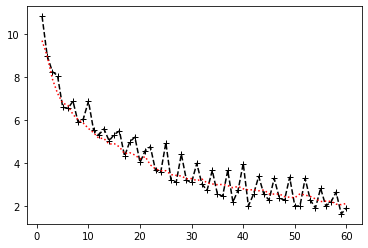

In [ ]:
import matplotlib.pyplot as plt
iter = []
for i in range(60):
    iter.append(i+1)
plt.plot(iter, loss, 'k--+')   # black dashed line, with "+" markers
plt.plot(iter, test_loss, 'r:')     # red dotted line (no marker)
plt.show()

# The classification accuracy

> black: training

> red:   testing





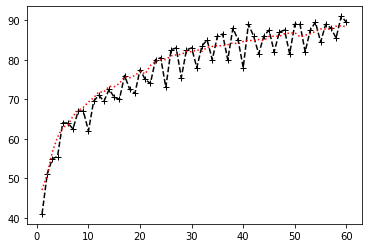

In [ ]:
for i in range(len(test_accuracy)):
  test_accuracy[i] *=100 

plt.plot(iter, accuracy, 'k--+')   # black dashed line, with "+" markers
plt.plot(iter, test_accuracy, 'r:')     # red dotted line (no marker)
plt.show()

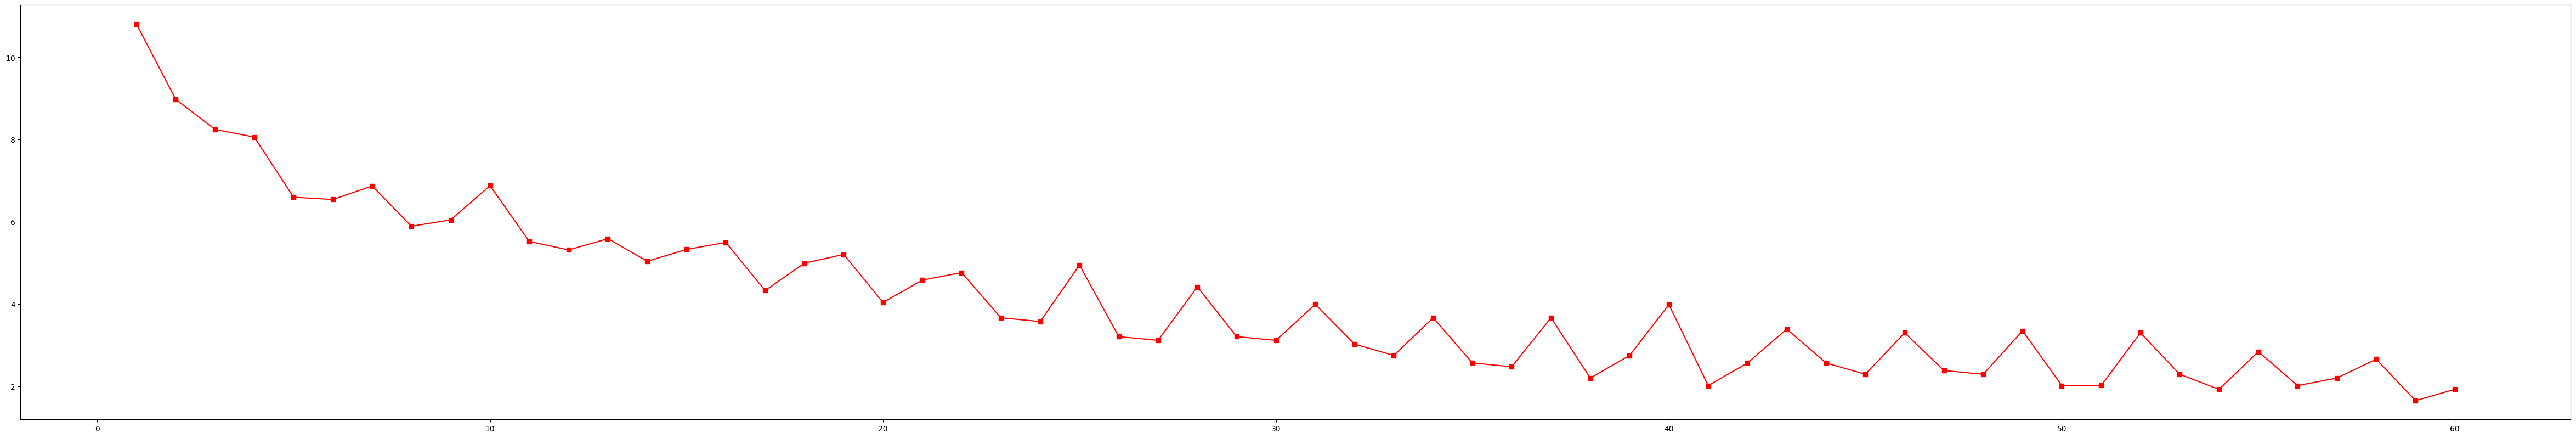

In [ ]:
import matplotlib.pyplot as plt
iter = []
for i in range(60):
    iter.append(i+1)
plt.figure(figsize=(60,10),dpi=100,linewidth = 2)
plt.plot(iter,loss,'s-',color = 'r', label="TSMC")

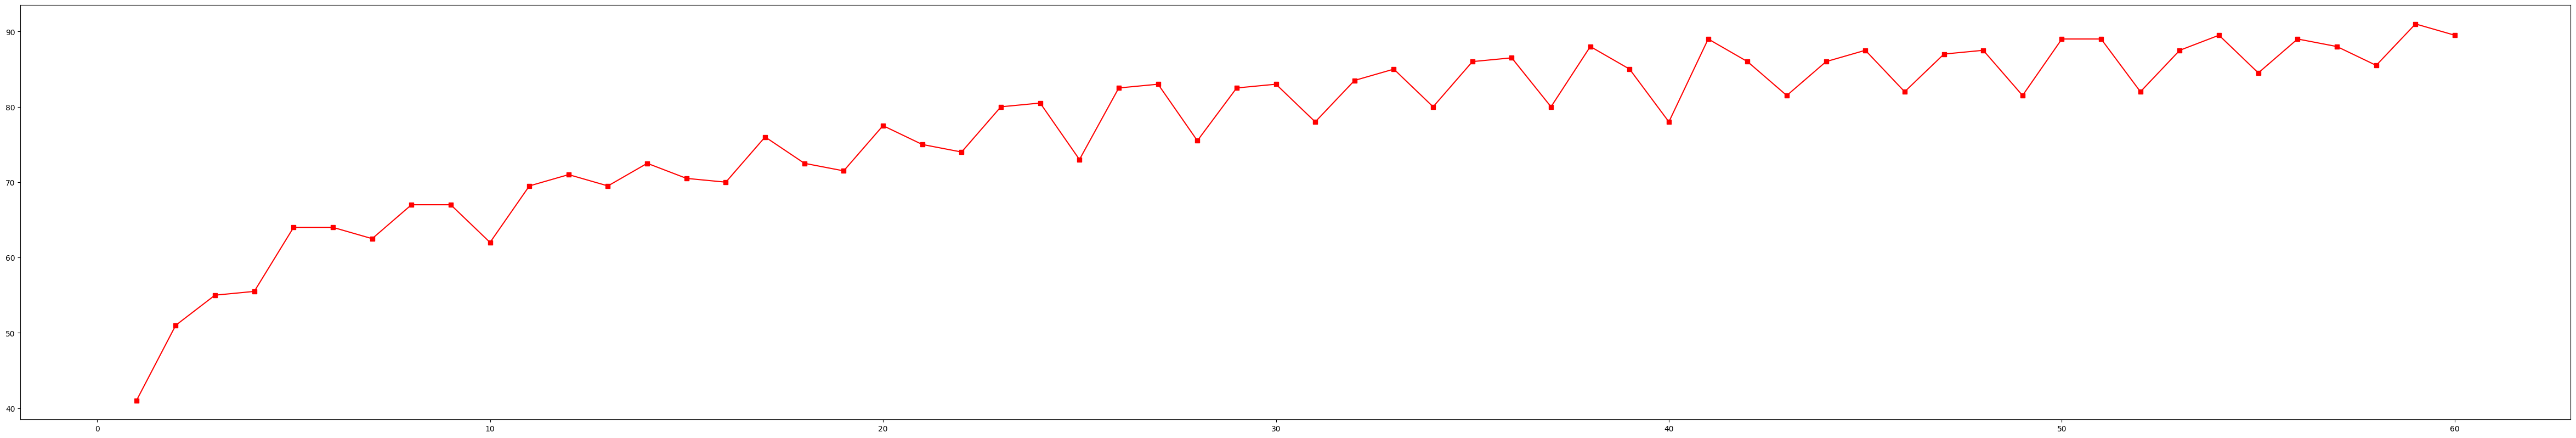

In [ ]:
plt.figure(figsize=(60,10),dpi=100,linewidth = 2)
plt.plot(iter,accuracy,'s-',color = 'r', label="TSMC")

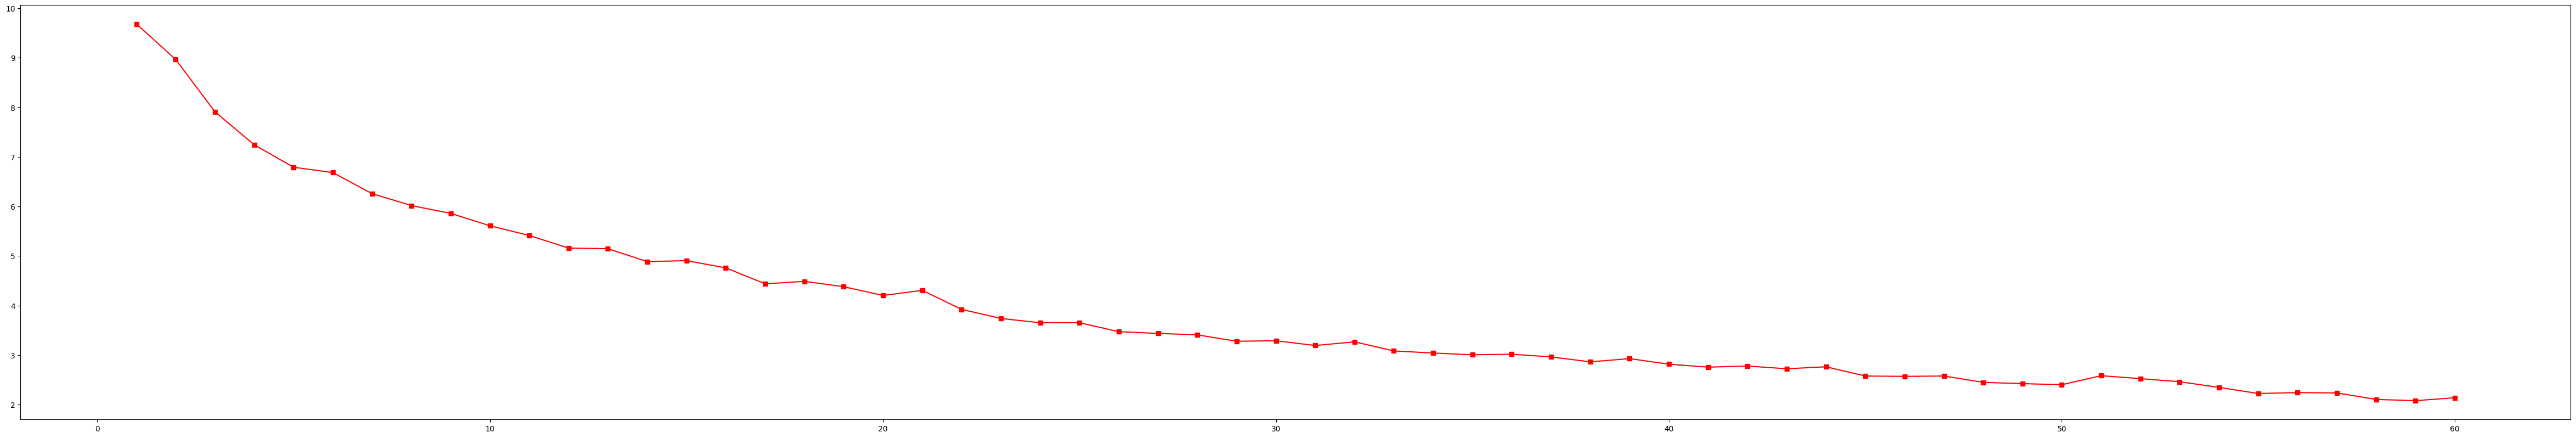

In [ ]:
plt.figure(figsize=(60,10),dpi=100,linewidth = 2)
plt.plot(iter,test_loss,'s-',color = 'r', label="TSMC")

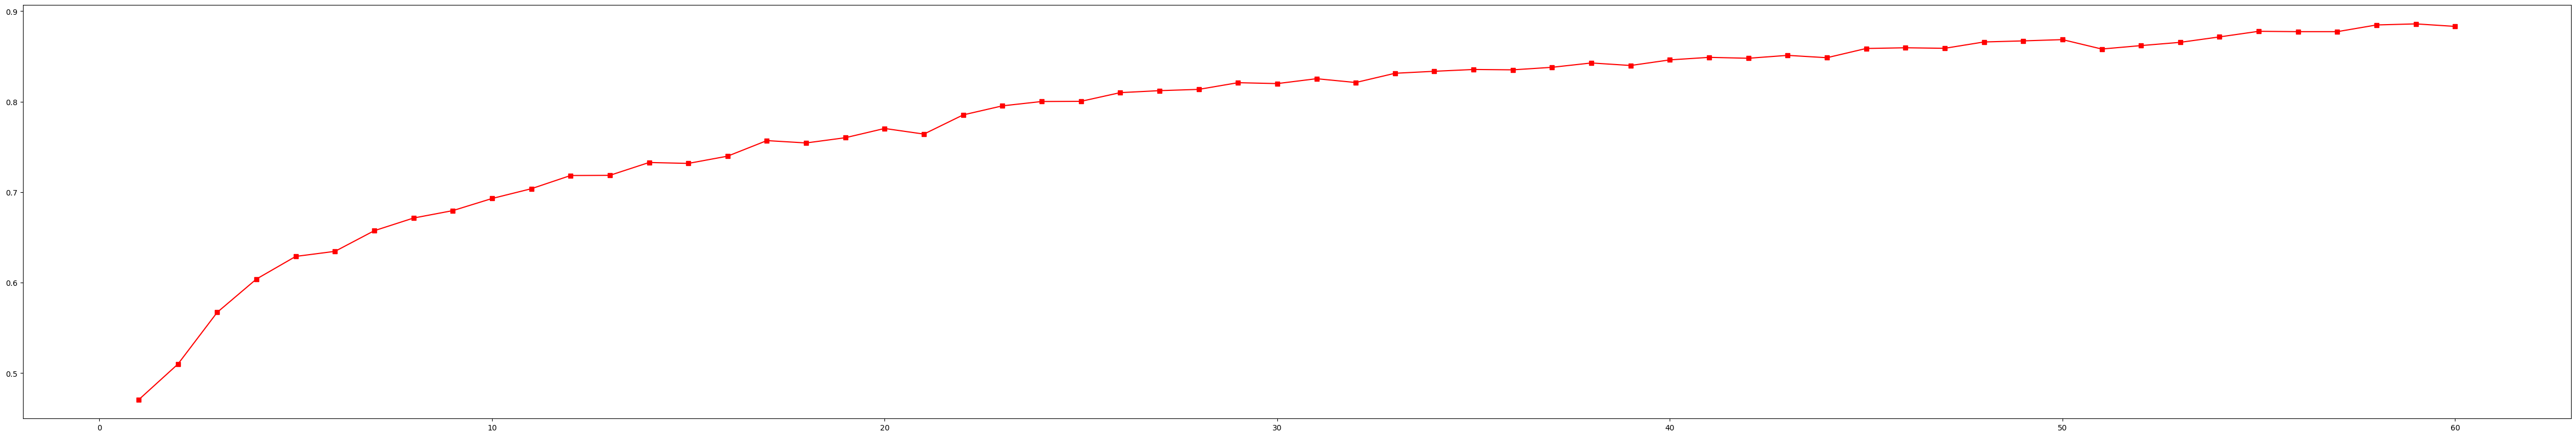

In [ ]:
plt.figure(figsize=(60,10),dpi=100,linewidth = 2)
plt.plot(iter,test_accuracy,'s-',color = 'r', label="TSMC")

## **1.(b)** **Zero Initialization**

In [ ]:
zero_ini_weight_1 = np.zeros((784, 2048))
zero_ini_weight_2 = np.zeros((2048, 512))
zero_ini_weight_3 = np.zeros((512, 5))

zero_ini_bias_1 = np.zeros((2048,))
zero_ini_bias_2 = np.zeros((512,))
zero_ini_bias_3 = np.zeros((5,))


In [ ]:
net = Model([FullyConnected(784,2048, zero_ini_weight_1, zero_ini_bias_1),Relu(),FullyConnected(2048,512, zero_ini_weight_2, zero_ini_bias_2),Relu(),FullyConnected(512,5, zero_ini_weight_3, zero_ini_bias_3),Softmax()], CrossEntropy())

In [ ]:
EPOCH = 20

In [ ]:
from tqdm import tqdm
loss = []
accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(1, EPOCH+1):
    print('epoch', epoch)
    
    train_loss=0
    val_loss=0
    train_hit = 0
    val_hit = 0
    total_train_loss = 0
    total_val_loss = 0
    for it in tqdm(range(train_batch_num)):
        #net.train()
        pred,lo = net.loss(train_norm[it*Batch_size:(it+1)*Batch_size], train_label_onehot[it*Batch_size:(it+1)*Batch_size])
        train_loss=lo.sum()
        #pred, train_loss = net.forward(train_data[it*Batch_size:(it+1)*Batch_size], train_label_onehot[it*Batch_size:(it+1)*Batch_size])
        #print('train_loss', train_loss)
        pred_index = np.argmax(pred, axis=1)
        #print('pred_index', pred_index)
        train_hit += (pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()
        #print('train_y', train_y[it*Batch_size:(it+1)*Batch_size])
        
        total_train_loss += train_loss
        
        net.backward()
        for layer in net.layers:
            if type(layer) == FullyConnected:
                #print('update w', Learning_rate * layer.grad_w)
                layer.weights -= Learning_rate * layer.grad_w
                layer.biases -= Learning_rate * layer.grad_b

        #net.eval()
        test_pred,lo = net.loss(test_norm, test_label_onehot)#.sum()
        val_loss=lo.sum()
        test_pred_index = np.argmax(test_pred, axis=1)
        hit = (test_pred_index==test_y).sum()
        val_hit += hit
        total_val_loss += val_loss

        if((it+1)%50 ==0):  
          loss.append(train_loss)
          accuracy.append((pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()/(Batch_size)*100.0)
          test_loss.append(val_loss)
          test_accuracy.append((test_pred_index==test_y).sum()/(test_image_num)*100.0)
   
        #print('Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(total_train_loss/train_batch_num), '|Train Acc:%3.4f'%(train_hit/(train_image_num)*100.0) , '|Val Loss:%8.4f'%total_val_loss, '|Val Acc:%3.4f'%(val_hit/(test_image_num)*100.0))
        print('Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(train_loss), '|Train Acc:%3.4f'%((pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()/(Batch_size)*100.0) , '|Val Loss:%8.4f'%(val_loss), '|Val Acc:%3.4f'%((test_pred_index==test_y).sum()/(test_image_num)*100.0))


   

epoch 1


  1%|          | 1/150 [00:02<07:00,  2.82s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<06:22,  2.59s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:07<06:10,  2.52s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:10<06:41,  2.75s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:14<07:10,  2.97s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:16<06:41,  2.79s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:18<06:21,  2.67s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:21<06:11,  2.61s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:23<06:00,  2.56s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:26<05:55,  2.54s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:28<05:51,  2.53s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:31<05:50,  2.54s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:34<05:57,  2.61s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:36<05:53,  2.60s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:39<05:45,  2.56s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:41<05:45,  2.58s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:44<05:39,  2.56s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:46<05:34,  2.53s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:49<05:30,  2.52s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:51<05:25,  2.50s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [00:54<05:20,  2.49s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [00:56<05:18,  2.49s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [00:59<05:13,  2.47s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:01<05:12,  2.48s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:04<05:08,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:06<05:07,  2.48s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:09<05:02,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:11<04:59,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:13<04:57,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:16<04:54,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:18<04:51,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:21<04:51,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:23<04:47,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:26<04:47,  2.48s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:28<04:42,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:31<04:39,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:33<04:36,  2.44s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:36<04:33,  2.44s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:38<04:28,  2.42s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:40<04:27,  2.43s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:43<04:42,  2.59s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [01:46<04:34,  2.54s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [01:48<04:27,  2.50s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [01:51<04:25,  2.51s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [01:53<04:20,  2.48s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [01:56<04:18,  2.48s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [01:58<04:14,  2.47s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:00<04:10,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:03<04:06,  2.44s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:05<04:05,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:08<04:01,  2.44s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:10<04:00,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:13<03:58,  2.46s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:15<03:55,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:18<03:53,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:20<03:52,  2.47s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:23<03:51,  2.49s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:25<03:49,  2.50s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:28<03:47,  2.50s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:30<03:45,  2.50s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:33<03:42,  2.50s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:35<03:41,  2.52s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [02:38<03:37,  2.50s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [02:40<03:34,  2.49s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [02:43<03:29,  2.46s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [02:45<03:25,  2.44s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [02:47<03:22,  2.44s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [02:50<03:20,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [02:52<03:17,  2.44s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [02:55<03:15,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [02:57<03:13,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:00<03:12,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:02<03:09,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:05<03:08,  2.48s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:07<03:05,  2.47s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:10<03:01,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:12<02:58,  2.45s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:14<02:55,  2.43s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:17<02:52,  2.43s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:19<02:50,  2.44s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:22<02:47,  2.43s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:24<02:45,  2.43s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:27<02:43,  2.44s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [03:29<02:40,  2.43s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [03:31<02:38,  2.43s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [03:34<02:36,  2.44s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [03:36<02:34,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [03:39<02:31,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [03:41<02:29,  2.45s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [03:44<02:25,  2.43s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [03:46<02:23,  2.43s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [03:49<02:20,  2.42s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [03:51<02:18,  2.44s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [03:53<02:16,  2.44s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [03:56<02:16,  2.49s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [03:58<02:13,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:01<02:10,  2.47s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:03<02:07,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:06<02:05,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:08<02:02,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:11<01:59,  2.44s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:13<01:56,  2.42s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:15<01:53,  2.41s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:18<01:51,  2.43s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [04:20<01:50,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [04:23<01:47,  2.44s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [04:25<01:45,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [04:28<01:43,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [04:30<01:40,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [04:33<01:37,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [04:35<01:35,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [04:38<01:32,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [04:40<01:31,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [04:42<01:28,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [04:45<01:25,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [04:47<01:23,  2.45s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [04:50<01:21,  2.48s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [04:52<01:19,  2.49s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [04:55<01:17,  2.50s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [04:57<01:15,  2.51s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:00<01:13,  2.52s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:02<01:09,  2.49s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:05<01:07,  2.49s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:07<01:04,  2.49s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [05:10<01:01,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [05:12<00:59,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [05:15<00:56,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [05:17<00:54,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [05:20<00:51,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [05:22<00:49,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [05:25<00:47,  2.48s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [05:27<00:44,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [05:30<00:42,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [05:32<00:39,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [05:35<00:37,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [05:37<00:34,  2.48s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [05:39<00:32,  2.47s/it]

Epoch:  1 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [05:42<00:29,  2.48s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [05:44<00:27,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [05:47<00:24,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [05:49<00:22,  2.49s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [05:52<00:19,  2.48s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [05:54<00:17,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [05:57<00:14,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [05:59<00:12,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [06:02<00:09,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [06:04<00:07,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [06:07<00:04,  2.47s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [06:09<00:02,  2.46s/it]

Epoch:  1 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [06:12<00:00,  2.48s/it]


Epoch:  1 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 2


  1%|          | 1/150 [00:02<05:53,  2.38s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:04<05:57,  2.41s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:07<05:55,  2.42s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:09<05:55,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:12<05:53,  2.43s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:14<05:50,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:16<05:47,  2.43s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:19<05:47,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:21<05:45,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:24<05:45,  2.47s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:26<05:39,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:29<05:41,  2.48s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:31<05:37,  2.46s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:34<05:32,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:36<05:28,  2.43s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:39<05:27,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:41<05:26,  2.46s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:44<05:24,  2.46s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:46<05:21,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:48<05:19,  2.46s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [00:51<05:15,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [00:53<05:15,  2.46s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [00:56<05:10,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [00:58<05:06,  2.43s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:01<05:03,  2.43s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:03<05:00,  2.42s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:05<04:57,  2.42s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:08<04:56,  2.43s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:10<04:55,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:13<04:54,  2.45s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:15<04:50,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:18<04:48,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:20<04:46,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:23<04:45,  2.46s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:25<04:43,  2.46s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:28<04:40,  2.46s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:30<04:39,  2.47s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:32<04:36,  2.47s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:35<04:33,  2.47s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:37<04:30,  2.46s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:40<04:28,  2.46s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [01:42<04:27,  2.47s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [01:45<04:26,  2.49s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [01:47<04:23,  2.49s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [01:50<04:18,  2.46s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [01:52<04:16,  2.46s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [01:55<04:13,  2.46s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [01:57<04:08,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:00<04:06,  2.44s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:02<04:03,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:04<04:01,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:07<03:59,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:09<03:57,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:12<03:53,  2.43s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:14<03:50,  2.43s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:17<03:48,  2.43s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:19<03:46,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:21<03:44,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:24<03:42,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:26<03:38,  2.43s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:29<03:35,  2.42s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:31<03:33,  2.43s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [02:34<03:31,  2.43s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [02:36<03:29,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [02:39<03:28,  2.45s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [02:41<03:24,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [02:44<03:25,  2.48s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [02:46<03:21,  2.46s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [02:48<03:18,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [02:51<03:15,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [02:53<03:13,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [02:56<03:10,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [02:58<03:07,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:01<03:04,  2.43s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:03<03:01,  2.42s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:05<02:58,  2.41s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:08<02:58,  2.44s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:10<02:56,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:13<02:53,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:15<02:50,  2.43s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:18<02:46,  2.42s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:20<02:44,  2.42s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:22<02:42,  2.42s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [03:25<02:39,  2.42s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [03:27<02:36,  2.40s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [03:30<02:35,  2.43s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [03:32<02:32,  2.42s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [03:34<02:30,  2.43s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [03:37<02:29,  2.46s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [03:39<02:28,  2.47s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [03:42<02:24,  2.46s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [03:44<02:22,  2.46s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [03:47<02:19,  2.45s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [03:49<02:17,  2.45s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [03:52<02:14,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [03:54<02:13,  2.47s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [03:57<02:09,  2.44s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [03:59<02:06,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:01<02:04,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:04<02:02,  2.44s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:07<02:04,  2.54s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:12<02:46,  3.47s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:15<02:31,  3.22s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:18<02:19,  3.04s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [04:20<02:10,  2.90s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [04:23<02:04,  2.84s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [04:26<01:59,  2.78s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [04:28<01:56,  2.78s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [04:31<01:52,  2.75s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [04:34<01:48,  2.71s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [04:36<01:44,  2.67s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [04:39<01:40,  2.65s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [04:41<01:37,  2.63s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [04:44<01:34,  2.62s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [04:47<01:31,  2.61s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [04:49<01:28,  2.61s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [04:52<01:25,  2.60s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [04:54<01:23,  2.62s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [04:57<01:20,  2.60s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:00<01:18,  2.61s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:02<01:14,  2.58s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:05<01:12,  2.59s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:07<01:09,  2.58s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:10<01:07,  2.60s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [05:12<01:04,  2.59s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [05:15<01:02,  2.62s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [05:18<00:59,  2.60s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [05:20<00:57,  2.60s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [05:23<00:55,  2.62s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [05:26<00:52,  2.62s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [05:28<00:49,  2.62s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [05:31<00:47,  2.63s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [05:33<00:44,  2.62s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [05:36<00:41,  2.62s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [05:39<00:39,  2.62s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [05:41<00:36,  2.62s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [05:44<00:34,  2.65s/it]

Epoch:  2 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [05:47<00:31,  2.65s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [05:49<00:29,  2.66s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [05:52<00:26,  2.68s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [05:55<00:24,  2.69s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [05:57<00:21,  2.66s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:00<00:18,  2.65s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [06:03<00:15,  2.63s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [06:05<00:13,  2.63s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [06:08<00:10,  2.65s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [06:11<00:07,  2.65s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [06:13<00:05,  2.65s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [06:16<00:02,  2.64s/it]

Epoch:  2 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [06:18<00:00,  2.53s/it]


Epoch:  2 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 3


  1%|          | 1/150 [00:02<06:30,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<06:32,  2.65s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:07<06:24,  2.61s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:10<06:25,  2.64s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:13<06:19,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:15<06:17,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:18<06:15,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:21<06:12,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:23<06:06,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:26<06:05,  2.61s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:28<06:03,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:31<06:01,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:34<05:59,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:36<05:57,  2.63s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:39<05:54,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:41<05:49,  2.61s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:44<05:44,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:47<05:41,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:49<05:38,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:52<05:33,  2.57s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [00:54<05:30,  2.56s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [00:57<05:29,  2.57s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [00:59<05:25,  2.56s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:02<05:23,  2.57s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:05<05:23,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:07<05:20,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:10<05:16,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:12<05:15,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:15<05:12,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:17<05:10,  2.59s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:20<05:08,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:23<05:04,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:25<05:03,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:28<05:00,  2.59s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:30<04:57,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:33<04:54,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:36<04:51,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:38<04:49,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:41<04:45,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:43<04:43,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:46<04:39,  2.57s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [01:48<04:38,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [01:51<04:34,  2.57s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [01:54<04:32,  2.57s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [01:56<04:28,  2.56s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [01:59<04:26,  2.56s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:01<04:24,  2.57s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:04<04:22,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:06<04:19,  2.57s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:09<04:17,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:11<04:12,  2.55s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:14<04:09,  2.55s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:17<04:07,  2.55s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:19<04:08,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:22<04:04,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:24<04:03,  2.59s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:27<04:00,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:30<03:59,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:32<03:56,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:35<03:55,  2.62s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:37<03:49,  2.58s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:40<03:48,  2.60s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [02:43<03:44,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [02:45<03:41,  2.57s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [02:48<03:36,  2.55s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [02:50<03:37,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [02:53<03:34,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [02:55<03:31,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [02:58<03:27,  2.56s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:01<03:25,  2.57s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:03<03:22,  2.56s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:06<03:20,  2.57s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:08<03:16,  2.55s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:11<03:15,  2.57s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:13<03:13,  2.58s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:16<03:11,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:19<03:10,  2.60s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:21<03:08,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:24<03:05,  2.61s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:26<03:01,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:29<02:58,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:32<02:56,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:34<02:53,  2.59s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [03:37<02:51,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [03:39<02:47,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [03:42<02:43,  2.56s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [03:44<02:40,  2.55s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [03:47<02:38,  2.56s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [03:50<02:35,  2.56s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [03:52<02:33,  2.55s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [03:55<02:30,  2.56s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [03:57<02:29,  2.58s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:00<02:26,  2.57s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:02<02:24,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:05<02:22,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:08<02:19,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:10<02:16,  2.57s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:13<02:13,  2.57s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:15<02:11,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:18<02:09,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:21<02:07,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:23<02:05,  2.61s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:26<02:02,  2.61s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:28<02:01,  2.63s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [04:31<01:58,  2.64s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [04:34<01:57,  2.67s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [04:36<01:53,  2.64s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [04:39<01:50,  2.64s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [04:42<01:47,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [04:44<01:44,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [04:47<01:41,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [04:49<01:39,  2.61s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [04:52<01:36,  2.61s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [04:55<01:34,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [04:57<01:31,  2.61s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:00<01:28,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:02<01:25,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:05<01:24,  2.63s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:08<01:20,  2.61s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:10<01:18,  2.61s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:13<01:15,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:16<01:12,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:18<01:09,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:21<01:07,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [05:23<01:04,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [05:26<01:02,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [05:28<00:59,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [05:31<00:56,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [05:34<00:54,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [05:36<00:51,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [05:39<00:48,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [05:41<00:46,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [05:44<00:43,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [05:47<00:41,  2.61s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [05:49<00:38,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [05:52<00:36,  2.61s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [05:54<00:34,  2.62s/it]

Epoch:  3 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [05:57<00:31,  2.63s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:00<00:28,  2.62s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:02<00:26,  2.61s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:05<00:23,  2.65s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:08<00:21,  2.63s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:10<00:18,  2.63s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [06:13<00:15,  2.63s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [06:15<00:13,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [06:18<00:10,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [06:21<00:07,  2.60s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [06:23<00:05,  2.58s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [06:26<00:02,  2.59s/it]

Epoch:  3 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [06:28<00:00,  2.59s/it]


Epoch:  3 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 4


  1%|          | 1/150 [00:02<06:27,  2.60s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<06:27,  2.62s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:07<06:20,  2.59s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:10<06:17,  2.59s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:12<06:11,  2.56s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:15<06:08,  2.56s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:17<06:05,  2.56s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:20<06:06,  2.58s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:23<06:04,  2.59s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:25<06:04,  2.61s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:28<06:05,  2.63s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:31<06:02,  2.63s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:33<05:58,  2.62s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:36<06:00,  2.65s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:39<05:52,  2.61s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:41<05:53,  2.64s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:44<05:48,  2.62s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:46<05:47,  2.63s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:49<05:46,  2.64s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:52<05:46,  2.67s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [00:54<05:42,  2.65s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [00:57<05:39,  2.65s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:00<05:36,  2.65s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:02<05:31,  2.63s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:05<05:33,  2.67s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:08<05:29,  2.66s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:10<05:26,  2.66s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:13<05:22,  2.64s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:16<05:18,  2.63s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:18<05:15,  2.63s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:21<05:13,  2.63s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:23<05:09,  2.62s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:26<05:07,  2.63s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:29<05:29,  2.84s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:35<06:59,  3.65s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:39<07:16,  3.83s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:42<06:36,  3.51s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:45<06:06,  3.27s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:47<05:43,  3.09s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:50<05:29,  3.00s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:53<05:18,  2.92s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [01:56<05:09,  2.86s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [01:58<05:01,  2.82s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:01<04:55,  2.79s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:04<04:51,  2.78s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:07<04:50,  2.79s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:09<04:42,  2.74s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:12<04:38,  2.73s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:15<04:33,  2.71s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:17<04:29,  2.69s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:20<04:26,  2.69s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:23<04:23,  2.69s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:25<04:21,  2.70s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:28<04:17,  2.69s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:31<04:15,  2.69s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:33<04:12,  2.68s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:36<04:10,  2.69s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:39<04:06,  2.67s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:41<04:03,  2.68s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:44<04:01,  2.69s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:47<03:58,  2.68s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:50<03:57,  2.70s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [02:52<03:55,  2.70s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [02:55<03:52,  2.71s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [02:58<03:49,  2.70s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:00<03:47,  2.71s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:03<03:43,  2.69s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:06<03:41,  2.70s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:08<03:36,  2.68s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:11<03:35,  2.70s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:14<03:32,  2.69s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:17<03:29,  2.69s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:19<03:25,  2.67s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:22<03:23,  2.67s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:24<03:18,  2.65s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:27<03:15,  2.64s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:30<03:12,  2.63s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:32<03:09,  2.63s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:35<03:08,  2.65s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:38<03:05,  2.65s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:40<03:02,  2.65s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:43<03:00,  2.66s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:46<02:58,  2.66s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [03:48<02:56,  2.67s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [03:51<02:55,  2.70s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [03:54<02:52,  2.70s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [03:56<02:50,  2.70s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [03:59<02:46,  2.69s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:02<02:43,  2.68s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:04<02:40,  2.68s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:07<02:37,  2.67s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:10<02:34,  2.66s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:12<02:31,  2.65s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:15<02:28,  2.65s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:18<02:25,  2.64s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:20<02:23,  2.66s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:23<02:20,  2.66s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:26<02:18,  2.66s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:28<02:15,  2.66s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:31<02:13,  2.68s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:34<02:11,  2.68s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:37<02:10,  2.72s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:39<02:06,  2.70s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:42<02:04,  2.71s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [04:45<02:00,  2.69s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [04:47<01:58,  2.69s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [04:50<01:58,  2.75s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [04:53<01:55,  2.76s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [04:56<01:53,  2.77s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [04:59<01:52,  2.82s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:02<01:51,  2.86s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:05<01:49,  2.89s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:07<01:46,  2.89s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:10<01:43,  2.87s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:13<01:40,  2.86s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:16<01:36,  2.85s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:19<01:34,  2.85s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:22<01:31,  2.85s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:24<01:27,  2.81s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:27<01:24,  2.80s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:30<01:20,  2.78s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:33<01:16,  2.74s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:35<01:13,  2.73s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:38<01:10,  2.70s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [05:41<01:07,  2.68s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [05:43<01:04,  2.67s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [05:46<01:00,  2.65s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [05:48<00:58,  2.65s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [05:51<00:55,  2.65s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [05:54<00:52,  2.64s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [05:56<00:50,  2.64s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [05:59<00:47,  2.66s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:02<00:44,  2.64s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:04<00:42,  2.66s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:07<00:40,  2.67s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:10<00:37,  2.67s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:12<00:34,  2.67s/it]

Epoch:  4 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:15<00:31,  2.67s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:18<00:29,  2.66s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:20<00:26,  2.67s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:23<00:23,  2.65s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:26<00:21,  2.67s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:28<00:18,  2.66s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [06:31<00:15,  2.66s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [06:34<00:13,  2.63s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [06:36<00:10,  2.66s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [06:39<00:07,  2.64s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [06:42<00:05,  2.65s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [06:44<00:02,  2.64s/it]

Epoch:  4 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [06:47<00:00,  2.71s/it]


Epoch:  4 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 5


  1%|          | 1/150 [00:02<06:30,  2.62s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<06:32,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:07<06:27,  2.64s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:10<06:31,  2.68s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:13<06:29,  2.69s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:16<06:26,  2.68s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:18<06:23,  2.68s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:21<06:19,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:23<06:13,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:26<06:09,  2.64s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:29<06:07,  2.64s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:31<06:03,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:34<06:03,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:37<05:59,  2.64s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:39<05:57,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:42<05:52,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:45<05:49,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:47<05:45,  2.62s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:50<05:44,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:52<05:41,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [00:55<05:40,  2.64s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [00:58<05:37,  2.64s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:00<05:33,  2.62s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:03<05:31,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:06<05:28,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:08<05:27,  2.64s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:11<05:23,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:14<05:23,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:16<05:18,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:19<05:16,  2.64s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:21<05:11,  2.62s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:24<05:09,  2.62s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:27<05:04,  2.61s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:29<05:02,  2.61s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:32<04:58,  2.60s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:34<04:59,  2.62s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:37<04:53,  2.60s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:40<04:53,  2.62s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:42<04:51,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:45<04:51,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:48<04:50,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [01:50<04:49,  2.68s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [01:53<04:46,  2.68s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [01:56<04:43,  2.68s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [01:58<04:39,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:01<04:36,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:04<04:34,  2.66s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:06<04:30,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:09<04:28,  2.66s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:12<04:28,  2.68s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:14<04:23,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:17<04:20,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:20<04:19,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:22<04:16,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:25<04:11,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:28<04:09,  2.65s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:30<04:05,  2.64s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:33<04:05,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:36<04:02,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:38<03:59,  2.66s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:41<03:56,  2.65s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:44<03:54,  2.66s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [02:46<03:50,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [02:49<03:50,  2.68s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [02:52<03:45,  2.66s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [02:54<03:44,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [02:57<03:40,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:00<03:36,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:02<03:33,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:05<03:31,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:08<03:30,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:10<03:28,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:13<03:25,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:16<03:22,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:18<03:21,  2.68s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:21<03:17,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:24<03:14,  2.66s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:26<03:11,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:29<03:08,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:31<03:05,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:34<03:03,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:37<03:01,  2.68s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:40<02:59,  2.68s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [03:42<02:55,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [03:45<02:52,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [03:48<02:50,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [03:50<02:47,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [03:53<02:45,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [03:55<02:41,  2.65s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [03:58<02:39,  2.65s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:01<02:37,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:04<02:35,  2.69s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:06<02:31,  2.66s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:09<02:29,  2.67s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:11<02:26,  2.66s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:14<02:22,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:17<02:19,  2.64s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:19<02:17,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:22<02:13,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:25<02:12,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:27<02:08,  2.62s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:30<02:05,  2.62s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:33<02:03,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:35<02:01,  2.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [04:38<01:58,  2.64s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [04:40<01:56,  2.64s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [04:43<01:53,  2.64s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [04:46<01:50,  2.63s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [04:48<01:48,  2.64s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [04:51<01:49,  2.73s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [04:57<02:22,  3.65s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:01<02:18,  3.64s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:04<02:05,  3.40s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:06<01:56,  3.22s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:09<01:48,  3.09s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:12<01:41,  3.00s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:15<01:36,  2.93s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:18<01:32,  2.90s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:20<01:28,  2.86s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:23<01:25,  2.86s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:26<01:21,  2.82s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:29<01:18,  2.82s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:31<01:15,  2.81s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:34<01:12,  2.80s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [05:37<01:09,  2.78s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [05:40<01:06,  2.78s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [05:42<01:03,  2.75s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [05:45<01:00,  2.76s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [05:48<00:58,  2.77s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [05:51<00:55,  2.75s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [05:54<00:52,  2.76s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [05:56<00:49,  2.76s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [05:59<00:46,  2.76s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:02<00:44,  2.75s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:05<00:41,  2.75s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:07<00:38,  2.75s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:10<00:35,  2.75s/it]

Epoch:  5 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:13<00:32,  2.75s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:15<00:30,  2.74s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:18<00:27,  2.74s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:21<00:24,  2.73s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:24<00:21,  2.73s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:26<00:19,  2.72s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [06:29<00:16,  2.74s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [06:32<00:13,  2.74s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [06:35<00:11,  2.76s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [06:37<00:08,  2.75s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [06:40<00:05,  2.75s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [06:43<00:02,  2.74s/it]

Epoch:  5 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [06:46<00:00,  2.71s/it]


Epoch:  5 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 6


  1%|          | 1/150 [00:02<06:49,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<06:41,  2.71s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<06:40,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:10<06:39,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:13<06:36,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:16<06:32,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:19<06:31,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:21<06:29,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:24<06:26,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:27<06:22,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:30<06:18,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:32<06:18,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:35<06:14,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:38<06:12,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:41<06:09,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:43<06:06,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:46<06:03,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:49<06:01,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:52<05:59,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:54<05:56,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [00:57<05:54,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:00<05:52,  2.75s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:03<05:49,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:05<05:45,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:08<05:45,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:11<05:42,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:14<05:38,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:16<05:38,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:19<05:35,  2.78s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:22<05:32,  2.77s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:25<05:28,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:27<05:26,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:30<05:22,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:33<05:20,  2.76s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:36<05:15,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:38<05:14,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:41<05:09,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:44<05:07,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:47<05:05,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:49<05:01,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:52<04:58,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [01:55<04:55,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [01:58<04:53,  2.74s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:00<04:50,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:03<04:50,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:06<04:46,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:09<04:43,  2.76s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:11<04:40,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:14<04:37,  2.75s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:17<04:35,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:20<04:32,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:22<04:30,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:25<04:27,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:28<04:24,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:31<04:21,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:33<04:20,  2.77s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:36<04:16,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:39<04:13,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:42<04:09,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:44<04:04,  2.72s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:47<04:02,  2.73s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:50<04:00,  2.73s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [02:53<03:57,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [02:55<03:54,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [02:58<03:52,  2.74s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:01<03:51,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:04<03:48,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:06<03:45,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:09<03:43,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:12<03:42,  2.78s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:15<03:38,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:17<03:36,  2.78s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:20<03:33,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:23<03:30,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:26<03:27,  2.77s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:29<03:25,  2.78s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:31<03:23,  2.79s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:34<03:20,  2.78s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:37<03:18,  2.79s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:40<03:14,  2.78s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:43<03:12,  2.79s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:45<03:09,  2.78s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:48<03:06,  2.79s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [03:51<03:03,  2.78s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [03:54<03:00,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [03:56<02:56,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [03:59<02:54,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:02<02:51,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:05<02:47,  2.75s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:07<02:45,  2.75s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:10<02:41,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:13<02:39,  2.74s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:16<02:36,  2.75s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:18<02:34,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:21<02:31,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:24<02:28,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:27<02:26,  2.76s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:29<02:22,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:32<02:19,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:35<02:16,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:37<02:14,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:40<02:11,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:43<02:08,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:46<02:06,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [04:49<02:04,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [04:51<02:01,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [04:54<01:59,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [04:57<01:57,  2.79s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:00<01:53,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:02<01:51,  2.79s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:05<01:48,  2.78s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:08<01:45,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:11<01:41,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:13<01:38,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:16<01:35,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:19<01:33,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:22<01:30,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:25<01:28,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:27<01:26,  2.79s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:30<01:23,  2.78s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:33<01:21,  2.80s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:36<01:18,  2.79s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:39<01:15,  2.80s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:41<01:12,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [05:44<01:09,  2.78s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [05:47<01:06,  2.79s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [05:50<01:03,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [05:52<01:00,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [05:55<00:57,  2.76s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [05:58<00:55,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:01<00:52,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:03<00:50,  2.78s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:06<00:47,  2.78s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:09<00:44,  2.79s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:12<00:41,  2.77s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:14<00:38,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:17<00:35,  2.75s/it]

Epoch:  6 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:20<00:32,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:23<00:30,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:25<00:27,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:28<00:24,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:31<00:21,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:34<00:19,  2.75s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [06:36<00:16,  2.74s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [06:39<00:13,  2.73s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [06:42<00:10,  2.72s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [06:44<00:08,  2.71s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [06:47<00:05,  2.72s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [06:50<00:02,  2.72s/it]

Epoch:  6 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [06:53<00:00,  2.75s/it]


Epoch:  6 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 7


  1%|          | 1/150 [00:02<06:49,  2.75s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<06:48,  2.76s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<06:44,  2.75s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:10<06:40,  2.74s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:13<06:37,  2.74s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:16<06:39,  2.77s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:19<06:44,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:22<06:48,  2.88s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:25<06:51,  2.92s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:28<06:48,  2.92s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:31<06:42,  2.90s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:34<06:38,  2.89s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:37<06:35,  2.89s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:39<06:35,  2.91s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:42<06:25,  2.86s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:45<06:24,  2.87s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:48<06:19,  2.85s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:51<06:15,  2.84s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:54<06:11,  2.84s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:56<06:05,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [00:59<06:01,  2.80s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:02<05:57,  2.79s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:05<05:54,  2.80s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:08<05:54,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:10<05:53,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:13<05:49,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:16<05:48,  2.84s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:19<05:43,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:22<05:56,  2.94s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:26<06:23,  3.20s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:32<08:01,  4.04s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:35<07:15,  3.69s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:38<06:40,  3.42s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:40<06:18,  3.26s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:43<05:58,  3.12s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:46<05:45,  3.03s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:49<05:34,  2.96s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:52<05:27,  2.93s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:55<05:23,  2.91s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:57<05:16,  2.88s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [02:00<05:11,  2.86s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [02:03<05:06,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [02:06<05:01,  2.82s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:09<05:01,  2.84s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:11<04:55,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:14<04:54,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:17<04:52,  2.84s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:20<04:49,  2.84s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:23<04:44,  2.82s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:26<04:42,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:28<04:38,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:31<04:35,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:34<04:32,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:37<04:30,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:40<04:29,  2.84s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:42<04:24,  2.82s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:45<04:21,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:48<04:18,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:51<04:16,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:54<04:15,  2.83s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:57<04:12,  2.84s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:59<04:09,  2.84s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [03:02<04:05,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [03:05<04:03,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:08<03:59,  2.82s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:11<03:57,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:14<03:53,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:16<03:53,  2.85s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:19<03:50,  2.85s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:22<03:48,  2.86s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:25<03:45,  2.86s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:28<03:42,  2.85s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:31<03:40,  2.86s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:34<03:38,  2.87s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:36<03:33,  2.85s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:39<03:31,  2.86s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:42<03:27,  2.84s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:45<03:25,  2.85s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:48<03:21,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:51<03:18,  2.84s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:54<03:16,  2.85s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:56<03:13,  2.84s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:59<03:11,  2.85s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [04:02<03:08,  2.86s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [04:05<03:06,  2.86s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:08<03:03,  2.86s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:11<02:59,  2.85s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:14<03:01,  2.92s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:17<02:58,  2.92s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:20<02:54,  2.91s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:22<02:49,  2.88s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:25<02:47,  2.88s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:28<02:43,  2.87s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:31<02:39,  2.85s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:34<02:36,  2.85s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:37<02:32,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:39<02:30,  2.83s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:42<02:26,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:45<02:23,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:48<02:20,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:51<02:17,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:53<02:15,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:56<02:11,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:59<02:09,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [05:02<02:05,  2.80s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [05:05<02:02,  2.79s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [05:07<01:59,  2.79s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:10<01:57,  2.80s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:13<01:54,  2.79s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:16<01:51,  2.79s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:18<01:48,  2.77s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:21<01:45,  2.78s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:24<01:42,  2.78s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:27<01:39,  2.77s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:30<01:37,  2.79s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:32<01:34,  2.79s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:35<01:32,  2.79s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:38<01:29,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:41<01:27,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:44<01:24,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:47<01:21,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:49<01:18,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:52<01:16,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:55<01:13,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [05:58<01:10,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [06:01<01:07,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [06:03<01:04,  2.80s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [06:06<01:01,  2.79s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [06:09<00:58,  2.80s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:12<00:55,  2.78s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:14<00:52,  2.78s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:17<00:50,  2.80s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:20<00:47,  2.79s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:23<00:44,  2.77s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:26<00:41,  2.79s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:28<00:39,  2.80s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:31<00:36,  2.82s/it]

Epoch:  7 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:34<00:34,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:37<00:31,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:40<00:28,  2.83s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:43<00:25,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:45<00:22,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:48<00:19,  2.80s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [06:51<00:16,  2.80s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [06:54<00:13,  2.80s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [06:57<00:11,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [06:59<00:08,  2.82s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [07:02<00:05,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [07:05<00:02,  2.81s/it]

Epoch:  7 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [07:08<00:00,  2.86s/it]


Epoch:  7 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 8


  1%|          | 1/150 [00:02<06:57,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<06:55,  2.81s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<06:53,  2.81s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:11<06:48,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:14<06:45,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:16<06:44,  2.81s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:19<06:40,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:22<06:41,  2.83s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:25<06:36,  2.81s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:28<06:33,  2.81s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:30<06:32,  2.82s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:33<06:27,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:36<06:26,  2.82s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:39<06:23,  2.82s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:42<06:23,  2.84s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:45<06:19,  2.83s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:47<06:15,  2.82s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:50<06:11,  2.81s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:53<06:07,  2.81s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:56<06:05,  2.81s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [00:59<06:03,  2.82s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:01<06:01,  2.83s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:04<05:58,  2.82s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:07<05:54,  2.81s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:10<05:49,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:13<05:44,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:15<05:43,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:18<05:39,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:21<05:39,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:24<05:35,  2.80s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:27<05:32,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:29<05:28,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:32<05:25,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:35<05:20,  2.76s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:38<05:16,  2.75s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:40<05:12,  2.74s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:43<05:09,  2.74s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:46<05:09,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:49<05:08,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:51<05:05,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:54<05:02,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [01:57<04:59,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [02:00<04:57,  2.78s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:03<04:54,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:05<04:52,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:08<04:49,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:11<04:46,  2.78s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:14<04:43,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:16<04:41,  2.79s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:19<04:38,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:22<04:35,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:25<04:33,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:28<04:30,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:30<04:29,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:33<04:25,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:36<04:22,  2.79s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:39<04:17,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:41<04:14,  2.76s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:44<04:12,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:47<04:10,  2.78s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:50<04:07,  2.78s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:53<04:04,  2.78s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [02:55<04:02,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [02:58<04:00,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:01<03:58,  2.80s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:04<03:53,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:07<03:52,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:09<03:47,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:12<03:45,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:15<03:44,  2.81s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:18<03:41,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:21<03:39,  2.81s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:23<03:36,  2.81s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:26<03:33,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:29<03:30,  2.81s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:32<03:27,  2.81s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:35<03:23,  2.79s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:37<03:20,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:40<03:16,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:43<03:14,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:46<03:11,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:48<03:08,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:51<03:06,  2.78s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [03:54<03:02,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [03:57<03:00,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:00<02:58,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:02<02:55,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:05<02:52,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:08<02:49,  2.77s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:11<02:45,  2.77s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:13<02:42,  2.76s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:16<02:39,  2.75s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:19<02:36,  2.75s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:22<02:34,  2.76s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:25<02:39,  2.90s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:31<03:22,  3.76s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:34<03:08,  3.56s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:37<02:52,  3.32s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:39<02:40,  3.14s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:42<02:31,  3.04s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:45<02:25,  2.97s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:48<02:19,  2.91s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:50<02:14,  2.87s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:53<02:10,  2.84s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [04:56<02:07,  2.83s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [04:59<02:03,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [05:01<02:00,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:04<01:56,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:07<01:53,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:10<01:50,  2.76s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:12<01:47,  2.76s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:15<01:45,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:18<01:42,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:21<01:39,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:24<01:36,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:26<01:34,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:29<01:31,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:32<01:29,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:35<01:26,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:37<01:23,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:40<01:20,  2.76s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:43<01:17,  2.76s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:46<01:14,  2.75s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:48<01:11,  2.73s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [05:51<01:08,  2.74s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [05:54<01:05,  2.73s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [05:57<01:02,  2.74s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [05:59<01:00,  2.75s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [06:02<00:58,  2.76s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:05<00:55,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:08<00:52,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:11<00:50,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:13<00:47,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:16<00:44,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:19<00:41,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:22<00:39,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:25<00:36,  2.80s/it]

Epoch:  8 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:27<00:33,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:30<00:30,  2.80s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:33<00:27,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:36<00:24,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:38<00:22,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:41<00:19,  2.76s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [06:44<00:16,  2.76s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [06:47<00:13,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [06:49<00:11,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [06:52<00:08,  2.77s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [06:55<00:05,  2.78s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [06:58<00:02,  2.79s/it]

Epoch:  8 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [07:01<00:00,  2.81s/it]


Epoch:  8 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 9


  1%|          | 1/150 [00:02<06:58,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<06:59,  2.83s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<06:51,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:11<06:47,  2.79s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:13<06:43,  2.78s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:16<06:43,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:19<06:40,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:22<06:38,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:25<06:33,  2.79s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:27<06:29,  2.78s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:30<06:27,  2.79s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:33<06:22,  2.77s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:36<06:19,  2.77s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:38<06:16,  2.76s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:41<06:11,  2.75s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:44<06:10,  2.76s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:47<06:07,  2.77s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:50<06:06,  2.77s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:52<06:02,  2.76s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:55<06:01,  2.78s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [00:58<05:59,  2.79s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:01<05:58,  2.80s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:04<05:54,  2.79s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:06<05:54,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:09<05:51,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:12<05:52,  2.84s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:15<05:51,  2.86s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:18<05:47,  2.85s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:21<05:43,  2.84s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:23<05:40,  2.84s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:26<05:38,  2.85s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:29<05:40,  2.89s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:32<05:33,  2.85s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:35<05:27,  2.82s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:38<05:20,  2.79s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:40<05:15,  2.77s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:43<05:10,  2.75s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:46<05:09,  2.76s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:49<05:06,  2.77s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:51<05:02,  2.75s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:54<04:59,  2.75s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [01:57<04:56,  2.75s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [02:00<04:56,  2.77s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:02<04:51,  2.75s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:05<04:49,  2.76s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:08<04:48,  2.78s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:11<04:44,  2.76s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:13<04:42,  2.77s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:16<04:42,  2.80s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:19<04:41,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:22<04:38,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:25<04:36,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:28<04:33,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:30<04:31,  2.83s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:33<04:27,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:36<04:22,  2.79s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:39<04:18,  2.78s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:42<04:17,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:44<04:16,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:47<04:12,  2.81s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:50<04:11,  2.82s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:53<04:07,  2.81s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [02:56<04:04,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [02:58<04:01,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:01<04:01,  2.84s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:04<04:00,  2.86s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:07<03:55,  2.84s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:10<03:52,  2.83s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:13<03:49,  2.83s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:16<03:48,  2.85s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:18<03:44,  2.85s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:21<03:40,  2.83s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:24<03:38,  2.84s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:27<03:34,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:30<03:31,  2.81s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:32<03:26,  2.79s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:35<03:23,  2.79s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:38<03:20,  2.78s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:41<03:17,  2.79s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:44<03:16,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:46<03:14,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:49<03:11,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:52<03:07,  2.79s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [03:55<03:05,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [03:58<03:02,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:00<03:00,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:03<02:57,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:06<02:54,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:09<02:50,  2.80s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:12<02:47,  2.80s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:14<02:45,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:17<02:43,  2.82s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:20<02:41,  2.83s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:23<02:39,  2.85s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:26<02:35,  2.84s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:29<02:33,  2.84s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:31<02:28,  2.80s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:34<02:24,  2.79s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:37<02:21,  2.77s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:40<02:18,  2.78s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:42<02:16,  2.78s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:45<02:14,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:48<02:11,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:51<02:08,  2.79s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [04:54<02:05,  2.79s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [04:57<02:03,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [04:59<02:01,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:02<01:58,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:05<01:56,  2.85s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:08<01:53,  2.84s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:11<01:50,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:14<01:47,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:16<01:44,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:19<01:41,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:22<01:38,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:25<01:35,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:28<01:32,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:30<01:30,  2.83s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:33<01:27,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:36<01:24,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:39<01:21,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:42<01:19,  2.83s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:45<01:17,  2.87s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:47<01:13,  2.84s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [05:50<01:10,  2.83s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [05:53<01:07,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [05:56<01:04,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [05:59<01:02,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [06:01<00:58,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:04<00:56,  2.81s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:07<00:53,  2.83s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:10<00:50,  2.83s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:13<00:48,  2.83s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:16<00:45,  2.84s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:19<00:42,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:21<00:39,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:24<00:36,  2.80s/it]

Epoch:  9 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:27<00:33,  2.78s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:30<00:30,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:32<00:27,  2.79s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:35<00:25,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:38<00:22,  2.78s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:41<00:19,  2.80s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [06:44<00:16,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [06:47<00:14,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [06:49<00:11,  2.84s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [06:52<00:08,  2.84s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [06:55<00:05,  2.83s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [06:58<00:02,  2.82s/it]

Epoch:  9 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [07:01<00:00,  2.81s/it]


Epoch:  9 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 10


  1%|          | 1/150 [00:02<07:03,  2.84s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<07:00,  2.84s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<06:54,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:11<06:50,  2.81s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:14<06:48,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:16<06:43,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:19<06:43,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:22<06:39,  2.81s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:25<06:37,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:28<06:36,  2.83s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:31<06:50,  2.95s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:35<07:25,  3.23s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:41<09:24,  4.12s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:44<08:29,  3.75s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:47<07:51,  3.49s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:50<07:23,  3.31s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:52<07:01,  3.17s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:55<06:43,  3.06s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:58<06:34,  3.01s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [01:01<06:23,  2.95s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [01:04<06:17,  2.93s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:07<06:09,  2.89s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:09<06:03,  2.87s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:12<05:59,  2.85s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:15<05:53,  2.83s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:18<05:50,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:21<05:44,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:23<05:41,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:26<05:37,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:29<05:39,  2.83s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:32<05:35,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:35<05:32,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:37<05:26,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:40<05:24,  2.79s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:43<05:22,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:46<05:18,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:49<05:15,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:51<05:13,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:54<05:11,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:57<05:08,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [02:00<05:06,  2.81s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [02:03<05:04,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [02:06<05:01,  2.81s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:08<04:59,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:11<04:55,  2.81s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:14<04:54,  2.83s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:17<04:50,  2.82s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:20<04:47,  2.81s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:23<04:47,  2.84s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:25<04:44,  2.85s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:28<04:41,  2.85s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:31<04:37,  2.83s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:34<04:34,  2.83s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:37<04:30,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:39<04:27,  2.81s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:42<04:25,  2.83s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:45<04:21,  2.81s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:48<04:20,  2.83s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:51<04:16,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:54<04:14,  2.83s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:56<04:11,  2.83s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:59<04:10,  2.85s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [03:02<04:07,  2.84s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [03:05<04:03,  2.83s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:08<03:59,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:11<03:54,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:13<03:52,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:16<03:49,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:19<03:46,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:22<03:44,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:25<03:41,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:27<03:38,  2.81s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:30<03:34,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:33<03:32,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:36<03:28,  2.79s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:38<03:25,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:41<03:22,  2.78s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:44<03:21,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:47<03:18,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:50<03:14,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:52<03:12,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:55<03:09,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:58<03:07,  2.80s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [04:01<03:04,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [04:04<03:02,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:06<02:58,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:09<02:56,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:12<02:55,  2.83s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:15<02:52,  2.82s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:18<02:49,  2.83s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:21<02:46,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:23<02:43,  2.81s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:26<02:38,  2.79s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:29<02:36,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:32<02:32,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:34<02:30,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:37<02:26,  2.77s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:40<02:24,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:43<02:22,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:45<02:18,  2.77s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:48<02:15,  2.77s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:51<02:12,  2.77s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:54<02:10,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:57<02:07,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [04:59<02:05,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [05:02<02:02,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [05:05<01:59,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:08<01:56,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:11<01:54,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:13<01:52,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:16<01:49,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:19<01:47,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:22<01:44,  2.83s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:25<01:41,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:28<01:38,  2.82s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:30<01:35,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:33<01:32,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:36<01:29,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:39<01:26,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:41<01:23,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:44<01:20,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:47<01:18,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:50<01:15,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:53<01:12,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [05:55<01:09,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [05:58<01:07,  2.81s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [06:01<01:04,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [06:04<01:02,  2.83s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [06:07<00:58,  2.81s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:09<00:55,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:12<00:53,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:15<00:50,  2.80s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:18<00:47,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:21<00:44,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:23<00:41,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:26<00:39,  2.79s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:29<00:36,  2.80s/it]

Epoch: 10 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:32<00:33,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:34<00:30,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:37<00:27,  2.77s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:40<00:24,  2.76s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:43<00:22,  2.77s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:46<00:19,  2.77s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [06:48<00:16,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [06:51<00:13,  2.77s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [06:54<00:11,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [06:57<00:08,  2.77s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [06:59<00:05,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [07:02<00:02,  2.78s/it]

Epoch: 10 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [07:05<00:00,  2.84s/it]


Epoch: 10 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 11


  1%|          | 1/150 [00:02<06:57,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<06:48,  2.76s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<06:47,  2.77s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:11<06:45,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:13<06:45,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:16<06:42,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:19<06:42,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:22<06:40,  2.82s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:25<06:35,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:28<06:32,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:30<06:29,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:33<06:25,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:36<06:20,  2.77s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:39<06:20,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:41<06:15,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:44<06:13,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:47<06:11,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:50<06:13,  2.83s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:53<06:09,  2.82s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:56<06:06,  2.82s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [00:58<06:03,  2.82s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:01<05:59,  2.81s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:04<05:54,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:07<05:52,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:09<05:49,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:12<05:46,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:15<05:43,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:18<05:41,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:21<05:38,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:24<05:37,  2.81s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:26<05:33,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:29<05:29,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:32<05:25,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:35<05:22,  2.78s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:37<05:19,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:40<05:16,  2.77s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:43<05:13,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:46<05:12,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:49<05:08,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:51<05:05,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:54<05:03,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [01:57<05:01,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [02:00<04:57,  2.78s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:02<04:54,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:05<04:54,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:08<04:54,  2.83s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:11<04:50,  2.82s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:14<04:49,  2.84s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:17<04:47,  2.85s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:20<04:43,  2.84s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:22<04:41,  2.85s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:25<04:37,  2.83s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:28<04:33,  2.82s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:31<04:29,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:34<04:25,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:36<04:24,  2.82s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:39<04:21,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:42<04:18,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:45<04:15,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:48<04:12,  2.81s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:50<04:08,  2.79s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:53<04:07,  2.82s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [02:56<04:04,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [02:59<04:02,  2.82s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:02<03:58,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:04<03:56,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:07<03:53,  2.82s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:10<03:49,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:13<03:47,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:16<03:44,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:19<03:42,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:21<03:38,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:24<03:35,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:27<03:33,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:30<03:28,  2.78s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:32<03:24,  2.77s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:35<03:28,  2.85s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:39<03:42,  3.09s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:45<04:34,  3.87s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:48<04:18,  3.69s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:51<03:55,  3.42s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:54<03:41,  3.25s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:56<03:28,  3.12s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [03:59<03:20,  3.03s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [04:02<03:12,  2.96s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:05<03:07,  2.93s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:08<03:03,  2.91s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:11<02:57,  2.87s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:13<02:53,  2.85s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:16<02:49,  2.83s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:19<02:46,  2.82s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:22<02:44,  2.83s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:25<02:40,  2.82s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:28<02:38,  2.83s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:30<02:34,  2.82s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:33<02:31,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:36<02:28,  2.81s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:39<02:27,  2.84s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:42<02:24,  2.84s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:44<02:22,  2.85s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:47<02:19,  2.85s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:50<02:16,  2.85s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:53<02:14,  2.86s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:56<02:10,  2.84s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [04:59<02:07,  2.84s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [05:01<02:04,  2.82s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [05:04<02:01,  2.82s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:07<01:59,  2.84s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:10<01:56,  2.85s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:13<01:55,  2.88s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:16<01:52,  2.88s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:19<01:49,  2.88s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:22<01:47,  2.90s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:25<01:43,  2.88s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:27<01:40,  2.88s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:30<01:37,  2.86s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:33<01:33,  2.84s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:36<01:30,  2.84s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:39<01:28,  2.84s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:42<01:24,  2.83s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:44<01:21,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:47<01:18,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:50<01:15,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:53<01:13,  2.82s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [05:55<01:10,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [05:58<01:07,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [06:01<01:04,  2.80s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [06:04<01:01,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [06:07<00:58,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:09<00:55,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:12<00:52,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:15<00:50,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:18<00:47,  2.77s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:20<00:44,  2.76s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:23<00:41,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:26<00:38,  2.76s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:29<00:35,  2.75s/it]

Epoch: 11 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:31<00:33,  2.75s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:34<00:30,  2.76s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:37<00:27,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:40<00:24,  2.77s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:43<00:22,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:45<00:19,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [06:48<00:16,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [06:51<00:13,  2.78s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [06:54<00:11,  2.81s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [06:57<00:08,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [06:59<00:05,  2.79s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [07:02<00:02,  2.77s/it]

Epoch: 11 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [07:05<00:00,  2.84s/it]


Epoch: 11 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 12


  1%|          | 1/150 [00:02<06:56,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<06:50,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<06:51,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:11<06:48,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:13<06:45,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:16<06:43,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:19<06:38,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:22<06:34,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:25<06:29,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:27<06:26,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:30<06:24,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:33<06:24,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:36<06:22,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:39<06:21,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:41<06:17,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:44<06:12,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:47<06:14,  2.81s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:50<06:10,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:53<06:09,  2.82s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:56<06:10,  2.85s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [00:58<06:07,  2.85s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:01<06:05,  2.86s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:04<06:01,  2.84s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:07<05:58,  2.84s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:10<05:53,  2.83s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:13<05:51,  2.83s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:15<05:48,  2.83s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:18<05:47,  2.85s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:21<05:43,  2.83s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:24<05:38,  2.82s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:27<05:32,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:29<05:28,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:32<05:25,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:35<05:22,  2.78s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:38<05:21,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:40<05:17,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:43<05:16,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:46<05:13,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:49<05:10,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:52<05:08,  2.81s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:54<05:03,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [01:57<05:00,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [02:00<04:57,  2.78s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:03<04:56,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:06<04:52,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:08<04:51,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:11<04:48,  2.80s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:14<04:46,  2.81s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:17<04:45,  2.82s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:20<04:40,  2.81s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:22<04:38,  2.81s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:25<04:35,  2.81s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:28<04:31,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:31<04:28,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:34<04:25,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:36<04:23,  2.80s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:39<04:18,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:42<04:15,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:45<04:11,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:48<04:12,  2.81s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:50<04:09,  2.80s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:53<04:07,  2.82s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [02:56<04:03,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [02:59<04:00,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:02<03:57,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:04<03:54,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:07<03:51,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:10<03:49,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:13<03:44,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:15<03:41,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:18<03:38,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:21<03:36,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:24<03:34,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:27<03:31,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:29<03:28,  2.78s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:32<03:26,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:35<03:22,  2.77s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:38<03:19,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:40<03:16,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:43<03:14,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:46<03:11,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:49<03:09,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:52<03:05,  2.77s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [03:54<03:02,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [03:57<02:59,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:00<02:57,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:03<02:54,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:05<02:52,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:08<02:50,  2.79s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:11<02:47,  2.80s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:14<02:44,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:17<02:42,  2.80s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:19<02:38,  2.78s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:22<02:35,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:25<02:32,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:28<02:29,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:30<02:25,  2.75s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:33<02:24,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:36<02:21,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:39<02:19,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:42<02:16,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:44<02:13,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:47<02:10,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:50<02:07,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [04:53<02:05,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [04:56<02:02,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [04:58<01:59,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:01<01:58,  2.81s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:04<01:54,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:07<01:52,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:10<01:48,  2.79s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:12<01:45,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:15<01:42,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:18<01:40,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:21<01:37,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:23<01:34,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:26<01:31,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:29<01:28,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:32<01:26,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:34<01:23,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:37<01:20,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:40<01:17,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:43<01:14,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:45<01:11,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [05:48<01:09,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [05:51<01:06,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [05:54<01:03,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [05:57<01:00,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [05:59<00:57,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:02<00:55,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:05<00:52,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:08<00:50,  2.80s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:11<00:47,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:13<00:44,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:16<00:41,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:19<00:38,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:22<00:35,  2.76s/it]

Epoch: 12 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:24<00:33,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:27<00:30,  2.74s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:30<00:27,  2.75s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:33<00:24,  2.75s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:35<00:22,  2.78s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:38<00:19,  2.77s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [06:41<00:16,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [06:44<00:13,  2.75s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [06:46<00:11,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [06:49<00:08,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [06:52<00:05,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [06:55<00:02,  2.76s/it]

Epoch: 12 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [06:57<00:00,  2.79s/it]


Epoch: 12 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 13


  1%|          | 1/150 [00:02<06:53,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<07:00,  2.84s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<06:53,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:11<06:47,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:13<06:42,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:16<06:41,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:19<06:42,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:22<06:36,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:25<06:34,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:27<06:29,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:30<06:25,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:33<06:24,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:36<06:21,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:39<06:19,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:41<06:15,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:44<06:13,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:47<06:07,  2.76s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:50<06:05,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:52<06:00,  2.75s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:55<06:00,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [00:58<05:56,  2.76s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:01<05:53,  2.76s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:03<05:51,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:06<05:49,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:09<05:47,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:12<05:44,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:15<05:42,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:17<05:37,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:20<05:35,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:23<05:29,  2.75s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:26<05:27,  2.75s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:28<05:22,  2.74s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:31<05:19,  2.73s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:34<05:17,  2.74s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:36<05:14,  2.73s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:39<05:12,  2.75s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:42<05:10,  2.75s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:45<05:08,  2.75s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:48<05:06,  2.76s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:50<05:05,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:53<05:02,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [01:56<04:59,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [01:59<04:54,  2.76s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:01<04:51,  2.75s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:04<04:49,  2.76s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:07<04:46,  2.76s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:10<04:44,  2.76s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:12<04:42,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:15<04:40,  2.78s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:18<04:38,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:21<04:40,  2.83s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:24<04:47,  2.94s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:30<06:09,  3.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:33<05:53,  3.68s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:36<05:23,  3.41s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:39<05:03,  3.23s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:42<04:46,  3.08s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:45<04:36,  3.00s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:47<04:26,  2.93s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:50<04:21,  2.90s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:53<04:14,  2.86s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:56<04:10,  2.84s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [02:58<04:05,  2.82s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [03:01<04:03,  2.83s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:04<04:01,  2.84s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:07<03:56,  2.82s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:10<03:53,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:13<03:50,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:15<03:46,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:18<03:44,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:21<03:42,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:24<03:39,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:26<03:34,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:29<03:30,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:32<03:27,  2.77s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:35<03:25,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:38<03:22,  2.78s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:40<03:19,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:43<03:17,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:46<03:14,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:49<03:11,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:51<03:09,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:54<03:07,  2.79s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [03:57<03:04,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [04:00<03:02,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:03<02:59,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:06<02:58,  2.84s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:09<02:56,  2.85s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:11<02:53,  2.84s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:14<02:51,  2.86s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:17<02:47,  2.84s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:20<02:45,  2.85s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:23<02:40,  2.82s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:25<02:38,  2.82s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:28<02:34,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:31<02:31,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:34<02:28,  2.81s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:37<02:26,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:39<02:22,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:42<02:20,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:45<02:17,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:48<02:14,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:51<02:11,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:53<02:08,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [04:56<02:05,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [04:59<02:02,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [05:02<01:59,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:05<01:56,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:07<01:53,  2.76s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:10<01:50,  2.77s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:13<01:48,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:16<01:45,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:19<01:43,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:21<01:40,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:24<01:37,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:27<01:34,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:30<01:31,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:32<01:29,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:35<01:26,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:38<01:23,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:41<01:20,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:44<01:18,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:46<01:15,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:49<01:12,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [05:52<01:09,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [05:55<01:07,  2.82s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [05:58<01:04,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [06:00<01:01,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [06:03<00:58,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:06<00:56,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:09<00:53,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:12<00:50,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:14<00:47,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:17<00:44,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:20<00:42,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:23<00:39,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:26<00:36,  2.79s/it]

Epoch: 13 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:28<00:33,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:31<00:30,  2.78s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:34<00:28,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:37<00:25,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:40<00:22,  2.81s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:42<00:19,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [06:45<00:16,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [06:48<00:14,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [06:51<00:11,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [06:54<00:08,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [06:56<00:05,  2.80s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [06:59<00:02,  2.79s/it]

Epoch: 13 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [07:02<00:00,  2.82s/it]


Epoch: 13 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 14


  1%|          | 1/150 [00:02<07:14,  2.91s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<07:08,  2.90s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<07:06,  2.90s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:11<07:02,  2.89s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:14<06:55,  2.87s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:17<06:55,  2.89s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:20<06:49,  2.86s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:23<06:49,  2.89s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:25<06:45,  2.87s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:28<06:41,  2.87s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:31<06:41,  2.89s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:34<06:36,  2.87s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:37<06:31,  2.86s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:40<06:27,  2.85s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:43<06:26,  2.86s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:45<06:22,  2.86s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:48<06:19,  2.86s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:51<06:18,  2.87s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:54<06:12,  2.84s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:57<06:08,  2.83s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [01:00<06:09,  2.86s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:03<06:11,  2.91s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:06<06:05,  2.88s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:08<06:02,  2.88s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:11<06:02,  2.90s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:14<05:58,  2.89s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:17<05:57,  2.91s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:20<05:53,  2.90s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:23<05:52,  2.91s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:26<05:46,  2.89s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:29<05:43,  2.89s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:32<05:41,  2.89s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:34<05:37,  2.88s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:37<05:35,  2.89s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:40<05:30,  2.87s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:43<05:26,  2.87s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:46<05:27,  2.90s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:49<05:22,  2.88s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:52<05:22,  2.90s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:55<05:22,  2.93s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:58<05:18,  2.93s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [02:01<05:22,  2.98s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [02:04<05:17,  2.97s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:07<05:15,  2.98s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:10<05:10,  2.95s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:13<05:07,  2.96s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:16<05:00,  2.92s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:18<04:57,  2.92s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:21<04:52,  2.89s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:24<04:46,  2.86s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:27<04:40,  2.84s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:30<04:37,  2.83s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:32<04:34,  2.83s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:35<04:32,  2.84s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:38<04:28,  2.83s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:41<04:26,  2.83s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:44<04:23,  2.83s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:47<04:21,  2.84s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:49<04:16,  2.82s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:52<04:15,  2.84s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:55<04:11,  2.82s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:58<04:08,  2.82s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [03:01<04:04,  2.82s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [03:04<04:01,  2.81s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:06<03:59,  2.82s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:09<03:56,  2.81s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:12<03:52,  2.80s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:15<03:49,  2.80s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:18<03:47,  2.80s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:20<03:43,  2.80s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:23<03:40,  2.79s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:26<03:36,  2.78s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:29<03:34,  2.78s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:31<03:33,  2.80s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:34<03:31,  2.82s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:37<03:30,  2.84s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:40<03:27,  2.84s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:43<03:25,  2.86s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:46<03:23,  2.86s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:49<03:20,  2.87s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:52<03:17,  2.87s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:54<03:15,  2.87s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:57<03:11,  2.87s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [04:00<03:08,  2.86s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [04:03<03:06,  2.88s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:06<03:04,  2.88s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:09<03:00,  2.86s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:12<02:57,  2.87s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:15<02:54,  2.86s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:17<02:52,  2.87s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:20<02:47,  2.85s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:23<02:45,  2.86s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:26<02:41,  2.83s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:29<02:38,  2.84s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:32<02:36,  2.85s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:34<02:34,  2.87s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:37<02:31,  2.85s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:40<02:28,  2.85s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:43<02:24,  2.84s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:46<02:22,  2.84s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:49<02:19,  2.84s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:52<02:17,  2.86s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:54<02:13,  2.84s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [04:57<02:10,  2.83s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [05:00<02:06,  2.81s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [05:03<02:03,  2.82s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [05:06<02:00,  2.81s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:08<01:57,  2.81s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:11<01:55,  2.82s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:14<01:53,  2.83s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:17<01:50,  2.84s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:20<01:47,  2.82s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:23<01:44,  2.83s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:25<01:41,  2.82s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:28<01:39,  2.84s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:31<01:40,  2.95s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:34<01:38,  2.97s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:37<01:35,  2.98s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:43<01:59,  3.87s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:47<01:54,  3.82s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:50<01:42,  3.55s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:53<01:34,  3.36s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [05:56<01:27,  3.23s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [05:59<01:21,  3.13s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [06:02<01:16,  3.07s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [06:05<01:12,  3.02s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [06:08<01:08,  3.00s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [06:10<01:05,  2.97s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [06:13<01:02,  2.97s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:16<00:59,  2.96s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:19<00:55,  2.94s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:22<00:52,  2.94s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:25<00:49,  2.92s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:28<00:46,  2.91s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:31<00:43,  2.91s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:34<00:40,  2.89s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:37<00:37,  2.90s/it]

Epoch: 14 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:39<00:34,  2.89s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:42<00:31,  2.89s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:45<00:28,  2.90s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:48<00:26,  2.92s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:51<00:23,  2.91s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:54<00:20,  2.93s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [06:57<00:17,  2.91s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [07:00<00:14,  2.90s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [07:03<00:11,  2.90s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [07:06<00:08,  2.91s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [07:09<00:05,  2.90s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [07:11<00:02,  2.90s/it]

Epoch: 14 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [07:14<00:00,  2.90s/it]


Epoch: 14 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 15


  1%|          | 1/150 [00:02<07:24,  2.99s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<07:09,  2.90s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<07:07,  2.91s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:11<07:00,  2.88s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:14<06:59,  2.89s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:17<06:57,  2.90s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:20<06:54,  2.90s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:23<06:53,  2.91s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:26<06:49,  2.90s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:28<06:44,  2.89s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:31<06:44,  2.91s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:34<06:38,  2.89s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:37<06:40,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:40<06:38,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:43<06:35,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:46<06:32,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:49<06:28,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:52<06:27,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:55<06:23,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:58<06:19,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [01:01<06:15,  2.91s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:04<06:11,  2.90s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:06<06:09,  2.91s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:09<06:05,  2.90s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:12<06:02,  2.90s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:15<05:57,  2.88s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:18<05:55,  2.89s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:21<05:51,  2.88s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:24<05:48,  2.88s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:27<05:48,  2.90s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:30<05:49,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:33<05:46,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:36<05:43,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:39<05:40,  2.94s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:41<05:37,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:44<05:32,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:47<05:30,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:50<05:26,  2.91s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:53<05:24,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:56<05:23,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:59<05:20,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [02:02<05:17,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [02:05<05:12,  2.92s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:08<05:08,  2.91s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:11<05:04,  2.90s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:13<04:59,  2.88s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:16<04:56,  2.88s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:19<04:51,  2.86s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:22<04:50,  2.87s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:25<04:48,  2.89s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:28<04:49,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:31<04:48,  2.95s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:34<04:49,  2.99s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:37<04:46,  2.98s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:40<04:42,  2.97s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:43<04:39,  2.98s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:46<04:37,  2.99s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:49<04:33,  2.97s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:52<04:30,  2.97s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:55<04:25,  2.95s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:58<04:21,  2.94s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [03:01<04:18,  2.94s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [03:04<04:15,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [03:06<04:12,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:09<04:08,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:12<04:04,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:15<04:03,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:18<04:00,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:21<03:58,  2.95s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:24<03:54,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:27<03:51,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:30<03:47,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:33<03:47,  2.95s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:36<03:43,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:39<03:40,  2.94s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:42<03:36,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:45<03:37,  2.98s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:48<03:40,  3.06s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:51<03:38,  3.07s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:54<03:32,  3.03s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:57<03:29,  3.04s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [04:00<03:25,  3.03s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [04:03<03:22,  3.02s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [04:06<03:16,  2.97s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [04:09<03:12,  2.97s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:12<03:08,  2.95s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:15<03:05,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:18<03:03,  2.95s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:21<03:00,  2.97s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:24<02:57,  2.96s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:27<02:55,  2.97s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:30<02:52,  2.97s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:33<02:51,  3.01s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:36<02:47,  2.99s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:39<02:45,  3.01s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:42<02:41,  2.99s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:45<02:37,  2.98s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:48<02:34,  2.97s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:51<02:31,  2.98s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:54<02:29,  2.98s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:57<02:26,  3.00s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [05:00<02:22,  2.98s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [05:03<02:20,  2.99s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [05:06<02:17,  3.00s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [05:09<02:14,  3.00s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [05:11<02:09,  2.95s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [05:14<02:07,  2.95s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:17<02:04,  2.96s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:20<02:00,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:23<01:58,  2.95s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:26<01:55,  2.95s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:29<01:51,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:32<01:49,  2.96s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:35<01:46,  2.95s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:38<01:43,  2.95s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:41<01:39,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:44<01:36,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:47<01:33,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:50<01:30,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:52<01:27,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:55<01:24,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:58<01:21,  2.91s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [06:01<01:18,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [06:04<01:15,  2.91s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [06:07<01:13,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [06:10<01:09,  2.91s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [06:13<01:07,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [06:16<01:04,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [06:19<01:02,  2.96s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:22<00:58,  2.95s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:25<00:55,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:28<00:53,  2.96s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:31<00:50,  2.98s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:34<00:48,  3.02s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:37<00:45,  3.04s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:40<00:42,  3.03s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:43<00:39,  3.03s/it]

Epoch: 15 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:46<00:36,  3.02s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:49<00:33,  3.00s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:52<00:30,  3.01s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:55<00:27,  3.00s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:58<00:23,  3.00s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [07:01<00:20,  2.99s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [07:04<00:17,  2.99s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [07:07<00:14,  2.98s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [07:10<00:11,  2.95s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [07:13<00:08,  2.93s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [07:16<00:05,  2.92s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [07:19<00:02,  2.94s/it]

Epoch: 15 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [07:22<00:00,  2.95s/it]


Epoch: 15 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 16


  1%|          | 1/150 [00:02<07:12,  2.91s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<07:06,  2.88s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<07:08,  2.92s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:11<07:09,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:14<07:06,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:17<07:00,  2.92s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:20<06:56,  2.91s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:23<06:50,  2.89s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:26<06:49,  2.90s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:29<06:46,  2.90s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:32<06:49,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:35<06:46,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:38<06:46,  2.96s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:41<06:45,  2.98s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:44<06:39,  2.96s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:47<06:37,  2.96s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:49<06:31,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:52<06:26,  2.93s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:55<06:24,  2.93s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:58<06:19,  2.92s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [01:01<06:19,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:04<06:15,  2.93s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:07<06:27,  3.05s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:11<06:55,  3.30s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:17<08:43,  4.18s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:20<07:53,  3.82s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:23<07:20,  3.58s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:27<06:56,  3.42s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:30<06:39,  3.30s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:32<06:23,  3.20s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:35<06:11,  3.13s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:38<06:01,  3.06s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:41<05:57,  3.06s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:44<05:52,  3.04s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:47<05:46,  3.01s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:50<05:39,  2.98s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:53<05:34,  2.96s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:56<05:30,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:59<05:30,  2.98s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [02:02<05:25,  2.96s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [02:05<05:21,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [02:08<05:17,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [02:11<05:17,  2.97s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:14<05:15,  2.97s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:17<05:13,  2.98s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:20<05:07,  2.96s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:23<05:05,  2.96s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:26<05:03,  2.98s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:29<05:03,  3.01s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:32<04:59,  2.99s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:35<04:55,  2.98s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:38<04:49,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:41<04:47,  2.96s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:44<04:41,  2.93s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:47<04:40,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:49<04:35,  2.93s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:52<04:33,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:55<04:29,  2.93s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:58<04:27,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [03:01<04:23,  2.93s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [03:04<04:20,  2.93s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [03:07<04:16,  2.91s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [03:10<04:14,  2.93s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [03:13<04:10,  2.91s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:16<04:10,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:19<04:06,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:22<04:04,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:25<04:02,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:28<03:58,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:31<03:56,  2.96s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:34<03:55,  2.99s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:37<03:52,  2.99s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:40<03:51,  3.00s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:43<03:46,  2.98s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:46<03:44,  2.99s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:49<03:40,  2.98s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:51<03:36,  2.96s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:54<03:33,  2.96s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:57<03:29,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [04:00<03:26,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [04:03<03:22,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [04:06<03:19,  2.93s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [04:09<03:19,  2.98s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [04:12<03:16,  2.97s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [04:15<03:13,  2.98s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:18<03:11,  3.00s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:21<03:08,  2.99s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:24<03:04,  2.98s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:27<03:01,  2.97s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:30<02:58,  2.98s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:33<02:56,  2.99s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:36<02:53,  2.98s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:39<02:50,  3.00s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:42<02:46,  2.97s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:45<02:42,  2.96s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:48<02:38,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:51<02:35,  2.93s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:54<02:32,  2.92s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:57<02:29,  2.92s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:59<02:25,  2.90s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [05:02<02:22,  2.90s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [05:05<02:19,  2.90s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [05:08<02:16,  2.90s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [05:11<02:14,  2.93s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [05:14<02:12,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [05:17<02:09,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [05:20<02:06,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:23<02:03,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:26<02:01,  2.97s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:29<01:57,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:32<01:55,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:35<01:51,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:38<01:48,  2.92s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:41<01:45,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:44<01:42,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:46<01:39,  2.92s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:49<01:36,  2.92s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:52<01:33,  2.91s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:55<01:31,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:58<01:27,  2.92s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [06:01<01:24,  2.93s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [06:04<01:22,  2.93s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [06:07<01:19,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [06:10<01:17,  2.98s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [06:13<01:14,  2.99s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [06:16<01:12,  3.01s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [06:19<01:09,  3.01s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [06:22<01:06,  3.02s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [06:25<01:03,  3.03s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:28<01:00,  3.01s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:31<00:57,  3.03s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:34<00:54,  3.02s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:37<00:51,  3.00s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:40<00:48,  3.01s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:43<00:45,  3.01s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:46<00:41,  2.98s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:49<00:38,  2.97s/it]

Epoch: 16 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:52<00:35,  2.93s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:55<00:32,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:58<00:29,  2.93s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [07:01<00:26,  2.92s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [07:04<00:23,  2.92s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [07:07<00:20,  2.92s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [07:10<00:17,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [07:13<00:14,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [07:15<00:11,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [07:18<00:08,  2.95s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [07:21<00:05,  2.93s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [07:24<00:02,  2.94s/it]

Epoch: 16 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [07:27<00:00,  2.98s/it]


Epoch: 16 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 17


  1%|          | 1/150 [00:03<07:35,  3.06s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:06<07:24,  3.00s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:09<07:21,  3.00s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:12<07:16,  2.99s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:14<07:13,  2.99s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:17<07:04,  2.95s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:20<07:02,  2.95s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:23<06:59,  2.95s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:26<07:01,  2.99s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:29<06:55,  2.97s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:32<06:52,  2.97s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:35<06:45,  2.94s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:38<06:45,  2.96s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:41<06:38,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:44<06:35,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:47<06:32,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:50<06:30,  2.94s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:53<06:26,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:56<06:22,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:59<06:20,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [01:01<06:16,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:04<06:15,  2.93s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:07<06:12,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:10<06:08,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:13<06:09,  2.96s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:16<06:04,  2.94s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:19<06:00,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:22<05:55,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:25<05:53,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:28<05:50,  2.92s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:31<05:46,  2.91s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:34<05:42,  2.90s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:36<05:39,  2.91s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:39<05:36,  2.90s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:42<05:34,  2.91s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:45<05:30,  2.90s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:48<05:30,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:51<05:26,  2.91s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:54<05:23,  2.91s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:57<05:21,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [02:00<05:16,  2.91s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [02:03<05:13,  2.90s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [02:06<05:13,  2.93s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:09<05:10,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:12<05:08,  2.94s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:14<05:03,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:17<04:58,  2.90s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:20<04:55,  2.90s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:23<04:55,  2.93s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:26<04:53,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:29<04:52,  2.95s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:32<04:49,  2.96s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:35<04:47,  2.96s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:38<04:45,  2.97s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:41<04:41,  2.96s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:44<04:37,  2.95s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:47<04:34,  2.95s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:50<04:29,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:53<04:26,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:56<04:22,  2.92s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:59<04:20,  2.93s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [03:01<04:17,  2.93s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [03:04<04:14,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [03:07<04:10,  2.91s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:10<04:08,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:13<04:07,  2.94s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:16<04:04,  2.95s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:19<04:00,  2.94s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:22<03:57,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:25<03:53,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:28<03:53,  2.95s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:31<03:48,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:34<03:46,  2.94s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:37<03:43,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:40<03:40,  2.94s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:43<03:40,  2.98s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:46<03:35,  2.96s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:49<03:34,  2.98s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:52<03:31,  2.97s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:55<03:30,  3.00s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:58<03:28,  3.02s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [04:01<03:24,  3.01s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [04:04<03:21,  3.00s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [04:07<03:17,  2.99s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [04:10<03:14,  2.98s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:13<03:11,  3.00s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:16<03:07,  2.98s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:19<03:04,  2.97s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:21<03:00,  2.96s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:24<02:56,  2.95s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:27<02:55,  2.97s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:30<02:51,  2.95s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:33<02:48,  2.96s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:36<02:45,  2.96s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:39<02:43,  2.97s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:42<02:41,  2.98s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:45<02:37,  2.97s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:48<02:34,  2.98s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:51<02:31,  2.98s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:54<02:28,  2.96s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:57<02:26,  2.99s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [05:00<02:22,  2.97s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [05:03<02:20,  2.99s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [05:06<02:17,  2.98s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [05:09<02:14,  2.98s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [05:12<02:10,  2.97s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [05:15<02:06,  2.95s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:18<02:03,  2.95s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:21<02:00,  2.94s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:24<01:56,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:27<01:54,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:30<01:51,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:33<01:50,  2.98s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:36<01:46,  2.96s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:39<01:44,  2.97s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:42<01:41,  2.98s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:44<01:37,  2.96s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:47<01:34,  2.94s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:50<01:30,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:53<01:27,  2.90s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:56<01:24,  2.90s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:59<01:21,  2.91s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [06:02<01:19,  2.95s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [06:05<01:16,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [06:08<01:13,  2.94s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [06:11<01:10,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [06:14<01:07,  2.95s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [06:17<01:04,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [06:19<01:01,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:22<00:58,  2.90s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:25<00:55,  2.90s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:28<00:52,  2.91s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:31<00:49,  2.90s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:34<00:46,  2.91s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:37<00:43,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:40<00:40,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:43<00:38,  2.94s/it]

Epoch: 17 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:46<00:34,  2.91s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:49<00:32,  2.93s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:52<00:29,  2.91s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:54<00:26,  2.91s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:57<00:23,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [07:00<00:20,  2.92s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [07:03<00:17,  2.96s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [07:06<00:14,  2.95s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [07:10<00:12,  3.04s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [07:14<00:09,  3.33s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [07:19<00:07,  3.99s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [07:23<00:03,  3.86s/it]

Epoch: 17 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [07:25<00:00,  2.97s/it]


Epoch: 17 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 18


  1%|          | 1/150 [00:03<07:39,  3.08s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:06<07:28,  3.03s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<07:16,  2.97s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:11<07:08,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:14<07:05,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:17<07:05,  2.95s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:20<07:02,  2.96s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:23<06:59,  2.95s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:26<06:58,  2.97s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:29<06:51,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:32<06:48,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:35<06:41,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:38<06:37,  2.90s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:41<06:36,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:44<06:33,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:47<06:33,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:50<06:29,  2.93s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:52<06:26,  2.93s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:55<06:20,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:58<06:15,  2.89s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [01:01<06:15,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:04<06:10,  2.90s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:07<06:10,  2.92s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:10<06:08,  2.92s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:13<06:06,  2.93s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:16<06:04,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:19<06:01,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:22<05:59,  2.95s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:25<05:54,  2.93s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:28<05:53,  2.94s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:31<05:57,  3.00s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:34<05:51,  2.98s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:37<05:50,  3.00s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:40<05:46,  2.99s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:43<05:45,  3.00s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:46<05:43,  3.01s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:49<05:38,  3.00s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:52<05:36,  3.00s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:55<05:30,  2.98s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:57<05:25,  2.96s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [02:00<05:23,  2.97s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [02:03<05:19,  2.96s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [02:06<05:15,  2.95s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:09<05:11,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:12<05:11,  2.96s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:15<05:08,  2.97s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:18<05:05,  2.96s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:21<05:03,  2.98s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:24<05:02,  2.99s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:27<04:59,  2.99s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:30<04:57,  3.01s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:33<04:55,  3.01s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:36<04:53,  3.02s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:39<04:48,  3.00s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:42<04:45,  3.00s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:45<04:43,  3.01s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:48<04:38,  2.99s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:51<04:34,  2.98s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:54<04:29,  2.96s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:57<04:24,  2.94s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [03:00<04:21,  2.94s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [03:03<04:17,  2.93s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [03:06<04:15,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [03:09<04:11,  2.92s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:12<04:09,  2.93s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:15<04:05,  2.92s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:18<04:03,  2.93s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:20<03:59,  2.92s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:23<03:55,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:26<03:51,  2.89s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:29<03:49,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:32<03:47,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:35<03:44,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:38<03:42,  2.92s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:41<03:39,  2.93s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:44<03:37,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:47<03:34,  2.94s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:50<03:31,  2.93s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:53<03:28,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:56<03:25,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:59<03:23,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [04:01<03:20,  2.95s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [04:04<03:16,  2.94s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [04:07<03:14,  2.95s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [04:10<03:12,  2.96s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:13<03:09,  2.96s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:16<03:07,  2.98s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:19<03:04,  2.97s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:22<03:03,  3.01s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:25<02:59,  2.99s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:28<02:55,  2.97s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:31<02:51,  2.96s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:34<02:47,  2.93s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:37<02:43,  2.93s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:40<02:40,  2.92s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:43<02:37,  2.92s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:46<02:38,  2.98s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:49<02:34,  2.97s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:52<02:31,  2.96s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:55<02:26,  2.93s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:58<02:23,  2.92s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [05:01<02:21,  2.95s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [05:03<02:17,  2.93s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [05:06<02:14,  2.92s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [05:09<02:10,  2.90s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [05:12<02:07,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [05:15<02:05,  2.92s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:18<02:02,  2.92s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:21<01:59,  2.92s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:24<01:55,  2.90s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:27<01:53,  2.90s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:30<01:50,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:33<01:49,  2.96s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:36<01:45,  2.94s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:38<01:41,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:41<01:38,  2.89s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:44<01:35,  2.89s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:47<01:33,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:50<01:29,  2.90s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:53<01:26,  2.90s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:56<01:23,  2.89s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:59<01:20,  2.86s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [06:01<01:17,  2.86s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [06:04<01:14,  2.86s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [06:07<01:11,  2.86s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [06:10<01:08,  2.85s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [06:13<01:05,  2.85s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [06:16<01:03,  2.87s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [06:19<01:00,  2.87s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:22<00:57,  2.89s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:24<00:54,  2.88s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:27<00:51,  2.87s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:30<00:49,  2.89s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:33<00:46,  2.88s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:36<00:43,  2.90s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:39<00:40,  2.90s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:42<00:37,  2.89s/it]

Epoch: 18 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:45<00:34,  2.89s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:48<00:32,  2.91s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:50<00:28,  2.90s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:53<00:25,  2.88s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:56<00:22,  2.87s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:59<00:20,  2.87s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [07:02<00:17,  2.88s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [07:05<00:14,  2.87s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [07:08<00:11,  2.87s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [07:11<00:08,  2.88s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [07:13<00:05,  2.90s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [07:16<00:02,  2.93s/it]

Epoch: 18 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [07:19<00:00,  2.93s/it]


Epoch: 18 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 19


  1%|          | 1/150 [00:03<07:34,  3.05s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:06<07:24,  3.00s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<07:16,  2.97s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:11<07:08,  2.94s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:14<07:02,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:17<07:02,  2.94s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:20<06:57,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:23<06:57,  2.94s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:26<06:56,  2.95s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:29<06:45,  2.90s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:32<06:43,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:35<06:36,  2.88s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:38<06:38,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:41<06:39,  2.94s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:43<06:34,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:46<06:29,  2.90s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:49<06:23,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:52<06:20,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:55<06:15,  2.87s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:58<06:13,  2.87s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [01:01<06:12,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:03<06:08,  2.88s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:06<06:05,  2.87s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:09<06:00,  2.86s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:12<05:58,  2.87s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:15<05:53,  2.85s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:18<05:53,  2.87s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:21<05:51,  2.88s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:24<05:48,  2.88s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:27<05:47,  2.90s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:29<05:43,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:32<05:41,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:35<05:36,  2.88s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:38<05:33,  2.88s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:41<05:33,  2.90s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:44<05:28,  2.88s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:47<05:26,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:50<05:23,  2.88s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:53<05:21,  2.90s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:55<05:20,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:58<05:18,  2.93s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [02:01<05:15,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [02:04<05:15,  2.94s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:07<05:11,  2.94s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:10<05:08,  2.94s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:13<05:03,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:16<04:59,  2.91s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:19<04:54,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:22<04:51,  2.89s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:25<04:49,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:28<04:49,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:30<04:44,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:34<04:55,  3.05s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:38<05:15,  3.29s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:44<06:26,  4.07s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:46<05:49,  3.71s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:49<05:22,  3.46s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:52<05:03,  3.30s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:55<04:51,  3.20s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:58<04:44,  3.17s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [03:01<04:37,  3.12s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [03:04<04:27,  3.04s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [03:07<04:20,  2.99s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [03:10<04:15,  2.98s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:13<04:11,  2.96s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:16<04:07,  2.95s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:19<04:02,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:22<03:59,  2.93s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:25<03:55,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:27<03:53,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:30<03:50,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:33<03:45,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:36<03:41,  2.88s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:39<03:38,  2.87s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:42<03:37,  2.90s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:45<03:34,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:48<03:31,  2.89s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:51<03:28,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:53<03:26,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:56<03:24,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:59<03:20,  2.90s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [04:02<03:17,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [04:05<03:14,  2.91s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [04:08<03:13,  2.93s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [04:11<03:13,  2.97s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:14<03:09,  2.96s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:17<03:08,  3.00s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:20<03:04,  2.98s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:23<03:01,  2.97s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:26<02:57,  2.97s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:29<02:54,  2.95s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:32<02:49,  2.93s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:35<02:46,  2.92s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:38<02:43,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:41<02:42,  2.95s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:44<02:39,  2.95s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:47<02:36,  2.95s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:49<02:32,  2.94s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:52<02:29,  2.93s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:55<02:26,  2.93s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:58<02:24,  2.94s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [05:01<02:20,  2.93s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [05:04<02:17,  2.93s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [05:07<02:14,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [05:10<02:11,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [05:13<02:08,  2.93s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [05:16<02:06,  2.94s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:19<02:04,  2.96s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:22<02:01,  2.97s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:25<01:57,  2.94s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:28<01:54,  2.94s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:31<01:50,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:33<01:47,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:36<01:44,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:39<01:41,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:42<01:38,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:45<01:36,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:48<01:32,  2.90s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:51<01:30,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:54<01:27,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:57<01:25,  2.93s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [06:00<01:21,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [06:03<01:19,  2.94s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [06:05<01:16,  2.93s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [06:08<01:13,  2.93s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [06:11<01:10,  2.94s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [06:14<01:07,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [06:17<01:04,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [06:20<01:01,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:23<00:58,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:26<00:55,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:29<00:52,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:32<00:49,  2.90s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:35<00:46,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:37<00:43,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:40<00:40,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:43<00:38,  2.93s/it]

Epoch: 19 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:46<00:35,  2.93s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:49<00:32,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:52<00:29,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:55<00:26,  2.92s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:58<00:23,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [07:01<00:20,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [07:04<00:17,  2.89s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [07:07<00:14,  2.90s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [07:09<00:11,  2.90s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [07:12<00:08,  2.91s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [07:15<00:05,  2.93s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [07:18<00:02,  2.95s/it]

Epoch: 19 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [07:21<00:00,  2.95s/it]


Epoch: 19 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000
epoch 20


  1%|          | 1/150 [00:02<07:19,  2.95s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  1%|▏         | 2/150 [00:05<07:15,  2.94s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  2%|▏         | 3/150 [00:08<07:11,  2.93s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 4/150 [00:11<07:05,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  3%|▎         | 5/150 [00:14<07:00,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  4%|▍         | 6/150 [00:17<06:58,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▍         | 7/150 [00:20<06:55,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  5%|▌         | 8/150 [00:23<06:53,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  6%|▌         | 9/150 [00:26<06:53,  2.93s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 10/150 [00:29<06:48,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  7%|▋         | 11/150 [00:32<06:45,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


  8%|▊         | 12/150 [00:35<06:45,  2.94s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▊         | 13/150 [00:37<06:39,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


  9%|▉         | 14/150 [00:40<06:36,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 10%|█         | 15/150 [00:43<06:32,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:27.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█         | 16/150 [00:46<06:28,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 11%|█▏        | 17/150 [00:49<06:26,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 12%|█▏        | 18/150 [00:52<06:22,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 19/150 [00:55<06:23,  2.93s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 13%|█▎        | 20/150 [00:58<06:19,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 14%|█▍        | 21/150 [01:01<06:16,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▍        | 22/150 [01:04<06:13,  2.92s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 15%|█▌        | 23/150 [01:07<06:08,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 16%|█▌        | 24/150 [01:09<06:04,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 25/150 [01:12<06:01,  2.89s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 17%|█▋        | 26/150 [01:15<05:59,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 18%|█▊        | 27/150 [01:18<05:56,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▊        | 28/150 [01:21<05:52,  2.89s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 19%|█▉        | 29/150 [01:24<05:50,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:26.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 20%|██        | 30/150 [01:27<05:46,  2.89s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██        | 31/150 [01:30<05:45,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 21%|██▏       | 32/150 [01:33<05:39,  2.88s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 22%|██▏       | 33/150 [01:35<05:38,  2.89s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 34/150 [01:38<05:33,  2.88s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 23%|██▎       | 35/150 [01:41<05:32,  2.89s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 24%|██▍       | 36/150 [01:44<05:28,  2.88s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▍       | 37/150 [01:47<05:29,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 25%|██▌       | 38/150 [01:50<05:28,  2.93s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 26%|██▌       | 39/150 [01:53<05:23,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 40/150 [01:56<05:19,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:27.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 27%|██▋       | 41/150 [01:59<05:15,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 28%|██▊       | 42/150 [02:02<05:11,  2.88s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▊       | 43/150 [02:04<05:10,  2.90s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 29%|██▉       | 44/150 [02:07<05:05,  2.88s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 30%|███       | 45/150 [02:10<05:02,  2.88s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███       | 46/150 [02:13<04:57,  2.86s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 31%|███▏      | 47/150 [02:16<04:54,  2.86s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 32%|███▏      | 48/150 [02:19<04:53,  2.88s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:25.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 49/150 [02:22<04:51,  2.88s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 33%|███▎      | 50/150 [02:25<04:49,  2.89s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 34%|███▍      | 51/150 [02:27<04:46,  2.89s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▍      | 52/150 [02:30<04:44,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 35%|███▌      | 53/150 [02:33<04:40,  2.89s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 36%|███▌      | 54/150 [02:36<04:37,  2.89s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 55/150 [02:39<04:34,  2.89s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 37%|███▋      | 56/150 [02:42<04:31,  2.89s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 38%|███▊      | 57/150 [02:45<04:29,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▊      | 58/150 [02:48<04:27,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 39%|███▉      | 59/150 [02:51<04:26,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 40%|████      | 60/150 [02:54<04:22,  2.91s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████      | 61/150 [02:56<04:18,  2.90s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 41%|████▏     | 62/150 [02:59<04:14,  2.89s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:13.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 42%|████▏     | 63/150 [03:02<04:10,  2.88s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 64/150 [03:05<04:09,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 43%|████▎     | 65/150 [03:08<04:05,  2.88s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 44%|████▍     | 66/150 [03:11<04:02,  2.88s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:23.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▍     | 67/150 [03:14<03:58,  2.87s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 45%|████▌     | 68/150 [03:17<03:55,  2.87s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 46%|████▌     | 69/150 [03:20<03:53,  2.88s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 70/150 [03:22<03:48,  2.86s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 47%|████▋     | 71/150 [03:25<03:44,  2.84s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 48%|████▊     | 72/150 [03:28<03:41,  2.84s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▊     | 73/150 [03:31<03:39,  2.85s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 49%|████▉     | 74/150 [03:34<03:38,  2.88s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 50%|█████     | 75/150 [03:37<03:34,  2.86s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████     | 76/150 [03:40<03:33,  2.88s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:24.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 51%|█████▏    | 77/150 [03:42<03:29,  2.87s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 52%|█████▏    | 78/150 [03:45<03:26,  2.86s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 79/150 [03:48<03:23,  2.86s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 53%|█████▎    | 80/150 [03:51<03:20,  2.86s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 54%|█████▍    | 81/150 [03:54<03:16,  2.85s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:22.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▍    | 82/150 [03:57<03:13,  2.84s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 55%|█████▌    | 83/150 [03:59<03:10,  2.84s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 56%|█████▌    | 84/150 [04:02<03:07,  2.84s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 85/150 [04:05<03:05,  2.86s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 57%|█████▋    | 86/150 [04:08<03:02,  2.85s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 58%|█████▊    | 87/150 [04:11<02:59,  2.85s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▊    | 88/150 [04:14<02:56,  2.84s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 59%|█████▉    | 89/150 [04:17<02:53,  2.85s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 60%|██████    | 90/150 [04:19<02:52,  2.87s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████    | 91/150 [04:22<02:48,  2.86s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 61%|██████▏   | 92/150 [04:25<02:46,  2.87s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 62%|██████▏   | 93/150 [04:28<02:42,  2.85s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 94/150 [04:31<02:40,  2.87s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 63%|██████▎   | 95/150 [04:34<02:37,  2.87s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 64%|██████▍   | 96/150 [04:37<02:35,  2.87s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▍   | 97/150 [04:40<02:34,  2.91s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 65%|██████▌   | 98/150 [04:43<02:32,  2.93s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 66%|██████▌   | 99/150 [04:46<02:29,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:15.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 100/150 [04:48<02:26,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 67%|██████▋   | 101/150 [04:51<02:23,  2.93s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 68%|██████▊   | 102/150 [04:54<02:20,  2.93s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▊   | 103/150 [04:57<02:16,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:17.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 69%|██████▉   | 104/150 [05:00<02:14,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 70%|███████   | 105/150 [05:03<02:10,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████   | 106/150 [05:06<02:08,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 71%|███████▏  | 107/150 [05:09<02:04,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 72%|███████▏  | 108/150 [05:12<02:01,  2.89s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 109/150 [05:15<01:58,  2.88s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 73%|███████▎  | 110/150 [05:17<01:55,  2.89s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 74%|███████▍  | 111/150 [05:20<01:53,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:16.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▍  | 112/150 [05:24<01:55,  3.05s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 75%|███████▌  | 113/150 [05:29<02:19,  3.77s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 76%|███████▌  | 114/150 [05:34<02:22,  3.95s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 115/150 [05:36<02:07,  3.63s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:12.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 77%|███████▋  | 116/150 [05:39<01:56,  3.43s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 78%|███████▊  | 117/150 [05:42<01:48,  3.28s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▊  | 118/150 [05:45<01:41,  3.18s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 79%|███████▉  | 119/150 [05:48<01:37,  3.14s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 80%|████████  | 120/150 [05:51<01:33,  3.10s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:16.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████  | 121/150 [05:54<01:28,  3.05s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 81%|████████▏ | 122/150 [05:57<01:24,  3.01s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 82%|████████▏ | 123/150 [06:00<01:20,  2.99s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 124/150 [06:03<01:17,  2.98s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 83%|████████▎ | 125/150 [06:06<01:14,  2.97s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 84%|████████▍ | 126/150 [06:09<01:10,  2.95s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▍ | 127/150 [06:12<01:07,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:23.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 85%|████████▌ | 128/150 [06:15<01:04,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:26.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 86%|████████▌ | 129/150 [06:18<01:01,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 130/150 [06:21<00:58,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 87%|████████▋ | 131/150 [06:23<00:55,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 88%|████████▊ | 132/150 [06:26<00:52,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▊ | 133/150 [06:29<00:49,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 89%|████████▉ | 134/150 [06:32<00:46,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 90%|█████████ | 135/150 [06:35<00:44,  2.94s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████ | 136/150 [06:38<00:40,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 91%|█████████▏| 137/150 [06:41<00:37,  2.91s/it]

Epoch: 20 |Train Loss:  1.6095 |Train Acc:14.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 92%|█████████▏| 138/150 [06:44<00:34,  2.91s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:19.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 139/150 [06:47<00:32,  2.95s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:15.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 93%|█████████▎| 140/150 [06:50<00:29,  2.99s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 94%|█████████▍| 141/150 [06:53<00:26,  2.96s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▍| 142/150 [06:56<00:23,  2.96s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:20.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 95%|█████████▌| 143/150 [06:59<00:20,  2.94s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 96%|█████████▌| 144/150 [07:02<00:17,  2.93s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:17.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 145/150 [07:05<00:14,  2.94s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:18.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 97%|█████████▋| 146/150 [07:08<00:11,  2.93s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:22.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 98%|█████████▊| 147/150 [07:10<00:08,  2.92s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:25.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▊| 148/150 [07:13<00:05,  2.90s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:24.0000 |Val Loss:  1.6094 |Val Acc:20.0000


 99%|█████████▉| 149/150 [07:16<00:02,  2.89s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:21.5000 |Val Loss:  1.6094 |Val Acc:20.0000


100%|██████████| 150/150 [07:19<00:00,  2.93s/it]

Epoch: 20 |Train Loss:  1.6094 |Train Acc:14.5000 |Val Loss:  1.6094 |Val Acc:20.0000



> ### 1. Use zero initialization for the model weights make training process have less accuracy at the first. Moreover, all of the weights in the model will have the same value in subsequent iterations because the gradient is the same for every weights. 



# The learning curve

> black: training

> red:   testing





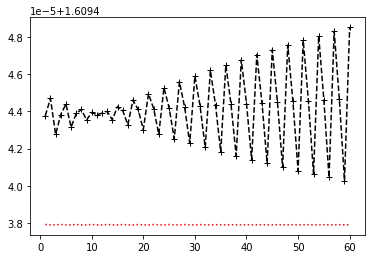

In [ ]:
import matplotlib.pyplot as plt
iter = []
for i in range(60):
    iter.append(i+1)
plt.plot(iter, loss, 'k--+')   # black dashed line, with "+" markers
plt.plot(iter, test_loss, 'r:')     # red dotted line (no marker)
plt.show()

# The classification accuracy

> black: training

> red:   testing





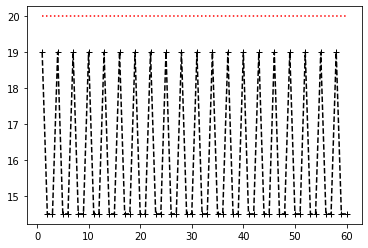

In [ ]:
plt.plot(iter, accuracy, 'k--+')   # black dashed line, with "+" markers
plt.plot(iter, test_accuracy, 'r:')     # red dotted line (no marker)
plt.show()

# **2.(a)**

In [ ]:
class Dropout():
    def __init__(self, p=0.8): #non 0 - 0.8
        self.p = p
        self.binary_value=None
        self.training = True
    def train(self):
        self.training = True
    def eval(self):
        self.training = False
    def forward(self, weights):
        #u1 = np.random.binomial(1, p, size=weights.shape)
        #weights *= u1
        if self.training:
          #print('before dropout weight', weights)
          self.binary_value = np.random.rand(weights.shape[0], weights.shape[1]) < self.p
          
          #print('mask', self.binary_value)
          res = np.multiply(weights, self.binary_value)
          #print('count', np.count_nonzero(res.flatten())/ res.flatten().shape[0])
          weights = res/self.p
          #print('after dropout weight', weights)
        return weights
    def backward(self,grad):
      if self.training:
        grad *= self.binary_value
        grad/=self.p

      return grad


In [ ]:
net = Model([FullyConnected(784,2048, init_weights[0], init_biases[0]), Dropout(0.8),Relu(),FullyConnected(2048,512, init_weights[1], init_biases[1]), Dropout(0.8),Relu(),FullyConnected(512,5, init_weights[2], init_biases[2]),Softmax()], CrossEntropy())

In [ ]:
loss = []
accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(1, EPOCH+1):
    print('epoch', epoch)
    
    train_loss=0
    val_loss=0
    train_hit = 0
    val_hit = 0
    total_train_loss = 0
    total_val_loss = 0
    for it in tqdm(range(train_batch_num)):
        net.train()
        pred,lo = net.loss(train_norm[it*Batch_size:(it+1)*Batch_size], train_label_onehot[it*Batch_size:(it+1)*Batch_size])
        train_loss=lo.sum()
        #pred, train_loss = net.forward(train_data[it*Batch_size:(it+1)*Batch_size], train_label_onehot[it*Batch_size:(it+1)*Batch_size])
        #print('train_loss', train_loss)
        pred_index = np.argmax(pred, axis=1)
        #print('pred_index', pred_index)
        train_hit += (pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()
        #print('train_y', train_y[it*Batch_size:(it+1)*Batch_size])
        
        total_train_loss += train_loss
        
        net.backward()
        for layer in net.layers:
            if type(layer) == FullyConnected:
                #print('update w', Learning_rate * layer.grad_w)
                layer.weights -= Learning_rate * layer.grad_w
                layer.biases -= Learning_rate * layer.grad_b

        net.eval()
        test_pred,lo = net.loss(test_norm, test_label_onehot)#.sum()
        val_loss=lo.sum()
        test_pred_index = np.argmax(test_pred, axis=1)
        hit = (test_pred_index==test_y).sum()
        val_hit += hit
        total_val_loss += val_loss

        if((it+1)%50 ==0):  
          loss.append(train_loss)
          accuracy.append((pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()/(Batch_size)*100.0)
          test_loss.append(val_loss)
          test_accuracy.append((test_pred_index==test_y).sum()/(test_image_num)*100.0)
   
        print('Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(train_loss), '|Train Acc:%3.4f'%((pred_index==train_y[it*Batch_size:(it+1)*Batch_size]).sum()/(Batch_size)*100.0) , '|Val Loss:%8.4f'%(val_loss), '|Val Acc:%3.4f'%((test_pred_index==test_y).sum()/(test_image_num)*100.0))
    
    #print('---Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(total_train_loss/train_batch_num), '|Train Acc:%3.4f'%(train_hit/(train_batch_num*(train_image_num)*100.0)) , '|Val Loss:%8.4f'%(total_val_loss/train_batch_num), '|Val Acc:%3.4f'%(val_hit/(train_batch_num*(test_image_num)*100.0)))


   

epoch 1


  1%|          | 1/150 [00:03<07:36,  3.07s/it]

Epoch:  1 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss: 10.6325 |Val Acc:41.9000


  1%|▏         | 2/150 [00:06<07:24,  3.01s/it]

Epoch:  1 |Train Loss: 12.1864 |Train Acc:33.5000 |Val Loss: 10.6325 |Val Acc:41.9000


  2%|▏         | 3/150 [00:08<07:15,  2.96s/it]

Epoch:  1 |Train Loss: 12.3712 |Train Acc:32.5000 |Val Loss: 10.7029 |Val Acc:41.5600


  3%|▎         | 4/150 [00:11<07:09,  2.94s/it]

Epoch:  1 |Train Loss: 13.1026 |Train Acc:28.5000 |Val Loss: 10.7029 |Val Acc:41.5600


  3%|▎         | 5/150 [00:14<07:08,  2.96s/it]

Epoch:  1 |Train Loss: 12.3696 |Train Acc:32.5000 |Val Loss: 10.7029 |Val Acc:41.5600


  4%|▍         | 6/150 [00:17<07:03,  2.94s/it]

Epoch:  1 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss: 10.7031 |Val Acc:41.5600


  5%|▍         | 7/150 [00:20<06:59,  2.93s/it]

Epoch:  1 |Train Loss: 12.2780 |Train Acc:33.0000 |Val Loss: 10.7031 |Val Acc:41.5600


  5%|▌         | 8/150 [00:23<06:54,  2.92s/it]

Epoch:  1 |Train Loss: 12.8278 |Train Acc:30.0000 |Val Loss: 10.7031 |Val Acc:41.5600


  6%|▌         | 9/150 [00:26<06:50,  2.91s/it]

Epoch:  1 |Train Loss: 12.2048 |Train Acc:33.0000 |Val Loss: 10.5460 |Val Acc:42.3000


  7%|▋         | 10/150 [00:29<06:47,  2.91s/it]

Epoch:  1 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss: 10.5460 |Val Acc:42.3000


  7%|▋         | 11/150 [00:32<06:41,  2.89s/it]

Epoch:  1 |Train Loss: 12.3696 |Train Acc:32.5000 |Val Loss: 10.5460 |Val Acc:42.3000


  8%|▊         | 12/150 [00:35<06:37,  2.88s/it]

Epoch:  1 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss: 10.5460 |Val Acc:42.3000


  9%|▊         | 13/150 [00:37<06:34,  2.88s/it]

Epoch:  1 |Train Loss: 12.1864 |Train Acc:33.5000 |Val Loss: 10.5460 |Val Acc:42.3000


  9%|▉         | 14/150 [00:40<06:34,  2.90s/it]

Epoch:  1 |Train Loss: 11.5544 |Train Acc:36.5000 |Val Loss: 10.5367 |Val Acc:42.4200


 10%|█         | 15/150 [00:43<06:36,  2.94s/it]

Epoch:  1 |Train Loss: 12.2780 |Train Acc:33.0000 |Val Loss: 10.5367 |Val Acc:42.4200


 11%|█         | 16/150 [00:46<06:32,  2.93s/it]

Epoch:  1 |Train Loss: 11.7282 |Train Acc:36.0000 |Val Loss: 10.5367 |Val Acc:42.4200


 11%|█▏        | 17/150 [00:49<06:30,  2.94s/it]

Epoch:  1 |Train Loss: 11.7282 |Train Acc:36.0000 |Val Loss: 10.5367 |Val Acc:42.4200


 12%|█▏        | 18/150 [00:52<06:24,  2.91s/it]

Epoch:  1 |Train Loss: 12.0947 |Train Acc:34.0000 |Val Loss: 10.5367 |Val Acc:42.4200


 13%|█▎        | 19/150 [00:55<06:21,  2.91s/it]

Epoch:  1 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss: 10.5554 |Val Acc:42.3000


 13%|█▎        | 20/150 [00:58<06:21,  2.94s/it]

Epoch:  1 |Train Loss: 12.3696 |Train Acc:32.5000 |Val Loss: 10.5554 |Val Acc:42.3000


 14%|█▍        | 21/150 [01:01<06:19,  2.94s/it]

Epoch:  1 |Train Loss: 13.3775 |Train Acc:27.0000 |Val Loss: 10.5554 |Val Acc:42.3000


 15%|█▍        | 22/150 [01:04<06:16,  2.94s/it]

Epoch:  1 |Train Loss: 12.2780 |Train Acc:33.0000 |Val Loss: 10.5554 |Val Acc:42.3000


 15%|█▌        | 23/150 [01:07<06:10,  2.92s/it]

Epoch:  1 |Train Loss: 11.8211 |Train Acc:35.5000 |Val Loss: 10.5463 |Val Acc:42.3800


 16%|█▌        | 24/150 [01:10<06:06,  2.91s/it]

Epoch:  1 |Train Loss: 12.5529 |Train Acc:31.5000 |Val Loss: 10.5463 |Val Acc:42.3800


 17%|█▋        | 25/150 [01:13<06:03,  2.91s/it]

Epoch:  1 |Train Loss: 12.2780 |Train Acc:33.0000 |Val Loss: 10.5463 |Val Acc:42.3800


 17%|█▋        | 26/150 [01:15<06:01,  2.91s/it]

Epoch:  1 |Train Loss: 12.4613 |Train Acc:32.0000 |Val Loss: 10.5463 |Val Acc:42.3800


 18%|█▊        | 27/150 [01:18<05:59,  2.92s/it]

Epoch:  1 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss: 10.5463 |Val Acc:42.3800


 19%|█▊        | 28/150 [01:21<05:55,  2.91s/it]

Epoch:  1 |Train Loss: 12.2958 |Train Acc:32.5000 |Val Loss: 10.2822 |Val Acc:43.8200


 19%|█▉        | 29/150 [01:24<05:52,  2.91s/it]

Epoch:  1 |Train Loss: 12.5285 |Train Acc:31.0000 |Val Loss: 10.2377 |Val Acc:44.0600


 20%|██        | 30/150 [01:27<05:50,  2.92s/it]

Epoch:  1 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss: 10.2377 |Val Acc:44.0600


 21%|██        | 31/150 [01:30<05:48,  2.93s/it]

Epoch:  1 |Train Loss: 13.6524 |Train Acc:25.5000 |Val Loss: 10.2377 |Val Acc:44.0600


 21%|██▏       | 32/150 [01:33<05:45,  2.93s/it]

Epoch:  1 |Train Loss: 12.2517 |Train Acc:33.0000 |Val Loss:  9.8510 |Val Acc:46.1800


 22%|██▏       | 33/150 [01:36<05:43,  2.94s/it]

Epoch:  1 |Train Loss: 12.4613 |Train Acc:32.0000 |Val Loss:  9.8511 |Val Acc:46.1800


 23%|██▎       | 34/150 [01:39<05:40,  2.93s/it]

Epoch:  1 |Train Loss: 13.6455 |Train Acc:25.5000 |Val Loss:  9.7571 |Val Acc:46.7000


 23%|██▎       | 35/150 [01:42<05:36,  2.92s/it]

Epoch:  1 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss:  9.7044 |Val Acc:46.9800


 24%|██▍       | 36/150 [01:45<05:34,  2.94s/it]

Epoch:  1 |Train Loss: 11.4073 |Train Acc:37.0000 |Val Loss: 10.4494 |Val Acc:42.9000


 25%|██▍       | 37/150 [01:48<05:31,  2.94s/it]

Epoch:  1 |Train Loss: 12.7361 |Train Acc:30.5000 |Val Loss: 10.4494 |Val Acc:42.9000


 25%|██▌       | 38/150 [01:51<05:28,  2.93s/it]

Epoch:  1 |Train Loss: 12.0031 |Train Acc:34.5000 |Val Loss: 10.4494 |Val Acc:42.9000


 26%|██▌       | 39/150 [01:54<05:25,  2.93s/it]

Epoch:  1 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss: 10.4494 |Val Acc:42.9000


 27%|██▋       | 40/150 [01:56<05:21,  2.92s/it]

Epoch:  1 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss: 10.4494 |Val Acc:42.9000


 27%|██▋       | 41/150 [01:59<05:20,  2.94s/it]

Epoch:  1 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss: 10.4494 |Val Acc:42.9000


 28%|██▊       | 42/150 [02:02<05:14,  2.91s/it]

Epoch:  1 |Train Loss: 12.5529 |Train Acc:31.5000 |Val Loss: 10.4494 |Val Acc:42.9000


 29%|██▊       | 43/150 [02:05<05:11,  2.91s/it]

Epoch:  1 |Train Loss: 13.6524 |Train Acc:25.5000 |Val Loss: 10.4494 |Val Acc:42.9000


 29%|██▉       | 44/150 [02:08<05:07,  2.90s/it]

Epoch:  1 |Train Loss: 12.3696 |Train Acc:32.5000 |Val Loss: 10.4494 |Val Acc:42.9000


 30%|███       | 45/150 [02:11<05:05,  2.91s/it]

Epoch:  1 |Train Loss: 12.7361 |Train Acc:30.5000 |Val Loss: 10.4495 |Val Acc:42.9000


 31%|███       | 46/150 [02:14<05:04,  2.93s/it]

Epoch:  1 |Train Loss: 12.1864 |Train Acc:33.5000 |Val Loss: 10.4347 |Val Acc:42.9800


 31%|███▏      | 47/150 [02:17<05:00,  2.92s/it]

Epoch:  1 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss: 10.4347 |Val Acc:42.9800


 32%|███▏      | 48/150 [02:20<04:58,  2.92s/it]

Epoch:  1 |Train Loss: 12.9194 |Train Acc:29.5000 |Val Loss: 10.4347 |Val Acc:42.9800


 33%|███▎      | 49/150 [02:23<04:54,  2.91s/it]

Epoch:  1 |Train Loss: 12.9194 |Train Acc:29.5000 |Val Loss: 10.4344 |Val Acc:43.0000


 33%|███▎      | 50/150 [02:26<04:50,  2.90s/it]

Epoch:  1 |Train Loss: 12.7319 |Train Acc:30.5000 |Val Loss: 10.4739 |Val Acc:42.7600


 34%|███▍      | 51/150 [02:29<04:50,  2.94s/it]

Epoch:  1 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss: 10.4739 |Val Acc:42.7600


 35%|███▍      | 52/150 [02:31<04:45,  2.92s/it]

Epoch:  1 |Train Loss: 10.8127 |Train Acc:41.0000 |Val Loss: 10.5105 |Val Acc:42.5400


 35%|███▌      | 53/150 [02:34<04:44,  2.93s/it]

Epoch:  1 |Train Loss: 11.1968 |Train Acc:38.5000 |Val Loss: 10.4001 |Val Acc:43.1600


 36%|███▌      | 54/150 [02:37<04:39,  2.91s/it]

Epoch:  1 |Train Loss: 12.6445 |Train Acc:31.0000 |Val Loss: 10.4001 |Val Acc:43.1600


 37%|███▋      | 55/150 [02:40<04:38,  2.94s/it]

Epoch:  1 |Train Loss: 11.7282 |Train Acc:36.0000 |Val Loss: 10.4001 |Val Acc:43.1600


 37%|███▋      | 56/150 [02:43<04:38,  2.96s/it]

Epoch:  1 |Train Loss: 12.9194 |Train Acc:29.5000 |Val Loss: 10.4001 |Val Acc:43.1600


 38%|███▊      | 57/150 [02:46<04:34,  2.95s/it]

Epoch:  1 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss: 10.4001 |Val Acc:43.1600


 39%|███▊      | 58/150 [02:49<04:32,  2.96s/it]

Epoch:  1 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss: 10.4001 |Val Acc:43.1600


 39%|███▉      | 59/150 [02:52<04:30,  2.98s/it]

Epoch:  1 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss: 10.4001 |Val Acc:43.1600


 40%|████      | 60/150 [02:55<04:25,  2.95s/it]

Epoch:  1 |Train Loss: 12.0948 |Train Acc:34.0000 |Val Loss: 10.3993 |Val Acc:43.1600


 41%|████      | 61/150 [02:58<04:24,  2.97s/it]

Epoch:  1 |Train Loss: 12.7192 |Train Acc:30.5000 |Val Loss: 10.0273 |Val Acc:45.2400


 41%|████▏     | 62/150 [03:01<04:20,  2.96s/it]

Epoch:  1 |Train Loss: 12.3696 |Train Acc:32.5000 |Val Loss: 10.0273 |Val Acc:45.2400


 42%|████▏     | 63/150 [03:04<04:16,  2.94s/it]

Epoch:  1 |Train Loss: 12.4613 |Train Acc:32.0000 |Val Loss: 10.0273 |Val Acc:45.2400


 43%|████▎     | 64/150 [03:07<04:10,  2.91s/it]

Epoch:  1 |Train Loss: 12.1864 |Train Acc:33.5000 |Val Loss: 10.0273 |Val Acc:45.2400


 43%|████▎     | 65/150 [03:10<04:06,  2.90s/it]

Epoch:  1 |Train Loss: 13.8357 |Train Acc:24.5000 |Val Loss: 10.0272 |Val Acc:45.2400


 44%|████▍     | 66/150 [03:13<04:03,  2.90s/it]

Epoch:  1 |Train Loss: 11.4772 |Train Acc:37.0000 |Val Loss: 10.5071 |Val Acc:42.5800


 45%|████▍     | 67/150 [03:16<04:00,  2.90s/it]

Epoch:  1 |Train Loss: 12.1864 |Train Acc:33.5000 |Val Loss: 10.5071 |Val Acc:42.5800


 45%|████▌     | 68/150 [03:18<03:57,  2.90s/it]

Epoch:  1 |Train Loss: 11.9155 |Train Acc:34.5000 |Val Loss: 10.5047 |Val Acc:42.6600


 46%|████▌     | 69/150 [03:21<03:53,  2.89s/it]

Epoch:  1 |Train Loss: 12.3696 |Train Acc:32.5000 |Val Loss: 10.5047 |Val Acc:42.6600


 47%|████▋     | 70/150 [03:24<03:51,  2.89s/it]

Epoch:  1 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss: 10.5047 |Val Acc:42.6600


 47%|████▋     | 71/150 [03:27<03:47,  2.88s/it]

Epoch:  1 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss: 10.5065 |Val Acc:42.6600


 48%|████▊     | 72/150 [03:30<03:45,  2.89s/it]

Epoch:  1 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss: 10.5065 |Val Acc:42.6600


 49%|████▊     | 73/150 [03:33<03:42,  2.89s/it]

Epoch:  1 |Train Loss: 12.0031 |Train Acc:34.5000 |Val Loss: 10.6973 |Val Acc:41.5400


 49%|████▉     | 74/150 [03:36<03:39,  2.89s/it]

Epoch:  1 |Train Loss: 11.8645 |Train Acc:35.0000 |Val Loss: 10.7886 |Val Acc:41.0800


 50%|█████     | 75/150 [03:39<03:36,  2.88s/it]

Epoch:  1 |Train Loss: 11.7036 |Train Acc:36.0000 |Val Loss: 10.8585 |Val Acc:40.6600


 51%|█████     | 76/150 [03:41<03:33,  2.88s/it]

Epoch:  1 |Train Loss: 13.0110 |Train Acc:29.0000 |Val Loss: 10.8585 |Val Acc:40.6600


 51%|█████▏    | 77/150 [03:44<03:32,  2.91s/it]

Epoch:  1 |Train Loss: 13.7565 |Train Acc:24.5000 |Val Loss: 11.0844 |Val Acc:39.4600


 52%|█████▏    | 78/150 [03:47<03:28,  2.90s/it]

Epoch:  1 |Train Loss: 13.0110 |Train Acc:29.0000 |Val Loss: 11.0844 |Val Acc:39.4600


 53%|█████▎    | 79/150 [03:50<03:25,  2.90s/it]

Epoch:  1 |Train Loss: 13.1872 |Train Acc:28.0000 |Val Loss: 11.0157 |Val Acc:39.8200


 53%|█████▎    | 80/150 [03:53<03:23,  2.90s/it]

Epoch:  1 |Train Loss: 12.0947 |Train Acc:34.0000 |Val Loss: 11.0157 |Val Acc:39.8200


 54%|█████▍    | 81/150 [03:56<03:19,  2.89s/it]

Epoch:  1 |Train Loss: 11.8819 |Train Acc:35.0000 |Val Loss: 10.5299 |Val Acc:42.4600


 55%|█████▍    | 82/150 [03:59<03:15,  2.88s/it]

Epoch:  1 |Train Loss: 11.6366 |Train Acc:36.5000 |Val Loss: 10.5299 |Val Acc:42.4600


 55%|█████▌    | 83/150 [04:02<03:11,  2.86s/it]

Epoch:  1 |Train Loss: 12.0947 |Train Acc:34.0000 |Val Loss: 10.5299 |Val Acc:42.4600


 56%|█████▌    | 84/150 [04:05<03:09,  2.88s/it]

Epoch:  1 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss: 10.5299 |Val Acc:42.4600


 57%|█████▋    | 85/150 [04:07<03:05,  2.86s/it]

Epoch:  1 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss: 10.5299 |Val Acc:42.4600


 57%|█████▋    | 86/150 [04:10<03:02,  2.85s/it]

Epoch:  1 |Train Loss: 11.5450 |Train Acc:37.0000 |Val Loss: 10.5299 |Val Acc:42.4600


 58%|█████▊    | 87/150 [04:13<03:00,  2.86s/it]

Epoch:  1 |Train Loss: 12.0031 |Train Acc:34.5000 |Val Loss: 10.4866 |Val Acc:42.7400


 59%|█████▊    | 88/150 [04:16<02:57,  2.86s/it]

Epoch:  1 |Train Loss: 12.0947 |Train Acc:34.0000 |Val Loss: 10.4866 |Val Acc:42.7400


 59%|█████▉    | 89/150 [04:19<02:55,  2.88s/it]

Epoch:  1 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss: 10.4866 |Val Acc:42.7400


 60%|██████    | 90/150 [04:22<02:52,  2.87s/it]

Epoch:  1 |Train Loss: 11.5450 |Train Acc:37.0000 |Val Loss: 10.4950 |Val Acc:42.7000


 61%|██████    | 91/150 [04:25<02:52,  2.92s/it]

Epoch:  1 |Train Loss: 11.9284 |Train Acc:34.5000 |Val Loss: 10.0374 |Val Acc:45.2000


 61%|██████▏   | 92/150 [04:28<02:59,  3.09s/it]

Epoch:  1 |Train Loss: 12.4613 |Train Acc:32.0000 |Val Loss: 10.0374 |Val Acc:45.2000


 62%|██████▏   | 93/150 [04:35<04:00,  4.21s/it]

Epoch:  1 |Train Loss: 12.6445 |Train Acc:31.0000 |Val Loss: 10.0374 |Val Acc:45.2000


 63%|██████▎   | 94/150 [04:39<03:56,  4.23s/it]

Epoch:  1 |Train Loss: 11.5450 |Train Acc:37.0000 |Val Loss: 10.0374 |Val Acc:45.2000


 63%|██████▎   | 95/150 [04:42<03:30,  3.83s/it]

Epoch:  1 |Train Loss: 13.2859 |Train Acc:27.5000 |Val Loss: 10.0374 |Val Acc:45.2000


 64%|██████▍   | 96/150 [04:45<03:11,  3.55s/it]

Epoch:  1 |Train Loss: 11.5450 |Train Acc:37.0000 |Val Loss: 10.0374 |Val Acc:45.2000


 65%|██████▍   | 97/150 [04:48<02:57,  3.36s/it]

Epoch:  1 |Train Loss: 12.3696 |Train Acc:32.5000 |Val Loss: 10.0374 |Val Acc:45.2000


 65%|██████▌   | 98/150 [04:51<02:47,  3.22s/it]

Epoch:  1 |Train Loss: 13.1854 |Train Acc:28.0000 |Val Loss: 10.0887 |Val Acc:44.9000


 66%|██████▌   | 99/150 [04:54<02:41,  3.16s/it]

Epoch:  1 |Train Loss: 11.7282 |Train Acc:36.0000 |Val Loss: 10.0887 |Val Acc:44.9000


 67%|██████▋   | 100/150 [04:57<02:34,  3.10s/it]

Epoch:  1 |Train Loss: 11.7093 |Train Acc:36.0000 |Val Loss:  9.8101 |Val Acc:46.3800


 67%|██████▋   | 101/150 [05:00<02:30,  3.06s/it]

Epoch:  1 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  9.8101 |Val Acc:46.3800


 68%|██████▊   | 102/150 [05:03<02:25,  3.03s/it]

Epoch:  1 |Train Loss: 12.4613 |Train Acc:32.0000 |Val Loss:  9.8101 |Val Acc:46.3800


 69%|██████▊   | 103/150 [05:06<02:20,  2.99s/it]

Epoch:  1 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  9.8101 |Val Acc:46.3800


 69%|██████▉   | 104/150 [05:09<02:16,  2.97s/it]

Epoch:  1 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss:  9.8101 |Val Acc:46.3800


 70%|███████   | 105/150 [05:12<02:12,  2.95s/it]

Epoch:  1 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss:  9.8101 |Val Acc:46.3800


 71%|███████   | 106/150 [05:15<02:09,  2.95s/it]

Epoch:  1 |Train Loss: 11.6366 |Train Acc:36.5000 |Val Loss:  9.8101 |Val Acc:46.3800


 71%|███████▏  | 107/150 [05:17<02:05,  2.92s/it]

Epoch:  1 |Train Loss: 12.2780 |Train Acc:33.0000 |Val Loss:  9.8101 |Val Acc:46.3800


 72%|███████▏  | 108/150 [05:20<02:02,  2.91s/it]

Epoch:  1 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  9.8101 |Val Acc:46.3800


 73%|███████▎  | 109/150 [05:23<02:00,  2.94s/it]

Epoch:  1 |Train Loss: 12.9194 |Train Acc:29.5000 |Val Loss:  9.8101 |Val Acc:46.3800


 73%|███████▎  | 110/150 [05:26<01:57,  2.94s/it]

Epoch:  1 |Train Loss: 12.8278 |Train Acc:30.0000 |Val Loss:  9.8101 |Val Acc:46.3800


 74%|███████▍  | 111/150 [05:29<01:56,  2.98s/it]

Epoch:  1 |Train Loss: 12.1864 |Train Acc:33.5000 |Val Loss:  9.8101 |Val Acc:46.3800


 75%|███████▍  | 112/150 [05:32<01:53,  2.98s/it]

Epoch:  1 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss:  9.8101 |Val Acc:46.3800


 75%|███████▌  | 113/150 [05:35<01:51,  3.00s/it]

Epoch:  1 |Train Loss: 11.2694 |Train Acc:38.5000 |Val Loss:  9.3139 |Val Acc:49.1400


 76%|███████▌  | 114/150 [05:38<01:47,  2.98s/it]

Epoch:  1 |Train Loss: 12.2780 |Train Acc:33.0000 |Val Loss:  9.3139 |Val Acc:49.1400


 77%|███████▋  | 115/150 [05:42<01:47,  3.07s/it]

Epoch:  1 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss:  9.3139 |Val Acc:49.1400


 77%|███████▋  | 116/150 [05:45<01:46,  3.12s/it]

Epoch:  1 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  9.3139 |Val Acc:49.1400


 78%|███████▊  | 117/150 [05:48<01:42,  3.09s/it]

Epoch:  1 |Train Loss: 12.4613 |Train Acc:32.0000 |Val Loss:  9.3139 |Val Acc:49.1400


 79%|███████▊  | 118/150 [05:51<01:37,  3.06s/it]

Epoch:  1 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  9.3139 |Val Acc:49.1400


 79%|███████▉  | 119/150 [05:54<01:34,  3.05s/it]

Epoch:  1 |Train Loss: 12.3696 |Train Acc:32.5000 |Val Loss:  9.3139 |Val Acc:49.1400


 80%|████████  | 120/150 [05:57<01:31,  3.03s/it]

Epoch:  1 |Train Loss: 11.8125 |Train Acc:35.5000 |Val Loss:  9.8044 |Val Acc:46.4200


 81%|████████  | 121/150 [06:00<01:27,  3.03s/it]

Epoch:  1 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  9.8044 |Val Acc:46.4200


 81%|████████▏ | 122/150 [06:03<01:24,  3.00s/it]

Epoch:  1 |Train Loss: 10.7906 |Train Acc:41.0000 |Val Loss:  9.7087 |Val Acc:46.9800


 82%|████████▏ | 123/150 [06:06<01:20,  2.98s/it]

Epoch:  1 |Train Loss: 11.8801 |Train Acc:35.0000 |Val Loss:  9.7304 |Val Acc:46.8600


 83%|████████▎ | 124/150 [06:09<01:17,  2.98s/it]

Epoch:  1 |Train Loss: 12.0708 |Train Acc:34.0000 |Val Loss:  9.8180 |Val Acc:46.3000


 83%|████████▎ | 125/150 [06:12<01:14,  2.97s/it]

Epoch:  1 |Train Loss: 11.9721 |Train Acc:34.0000 |Val Loss:  9.9059 |Val Acc:45.8600


 84%|████████▍ | 126/150 [06:15<01:11,  2.98s/it]

Epoch:  1 |Train Loss: 13.0110 |Train Acc:29.0000 |Val Loss:  9.9059 |Val Acc:45.8600


 85%|████████▍ | 127/150 [06:18<01:08,  2.97s/it]

Epoch:  1 |Train Loss: 10.9909 |Train Acc:40.0000 |Val Loss: 10.2968 |Val Acc:43.7200


 85%|████████▌ | 128/150 [06:20<01:04,  2.95s/it]

Epoch:  1 |Train Loss: 11.5450 |Train Acc:37.0000 |Val Loss: 10.2968 |Val Acc:43.7200


 86%|████████▌ | 129/150 [06:23<01:01,  2.94s/it]

Epoch:  1 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss: 10.2968 |Val Acc:43.7200


 87%|████████▋ | 130/150 [06:26<00:58,  2.94s/it]

Epoch:  1 |Train Loss: 13.1943 |Train Acc:28.0000 |Val Loss: 10.2968 |Val Acc:43.7200


 87%|████████▋ | 131/150 [06:30<00:57,  3.02s/it]

Epoch:  1 |Train Loss: 12.0947 |Train Acc:34.0000 |Val Loss: 10.2904 |Val Acc:43.7800


 88%|████████▊ | 132/150 [06:33<00:54,  3.02s/it]

Epoch:  1 |Train Loss: 12.8278 |Train Acc:30.0000 |Val Loss: 10.2904 |Val Acc:43.7800


 89%|████████▊ | 133/150 [06:35<00:50,  2.99s/it]

Epoch:  1 |Train Loss: 11.4730 |Train Acc:37.0000 |Val Loss: 10.0722 |Val Acc:45.0000


 89%|████████▉ | 134/150 [06:38<00:47,  2.98s/it]

Epoch:  1 |Train Loss: 11.5450 |Train Acc:37.0000 |Val Loss: 10.0722 |Val Acc:45.0000


 90%|█████████ | 135/150 [06:41<00:44,  2.98s/it]

Epoch:  1 |Train Loss: 12.4613 |Train Acc:32.0000 |Val Loss: 10.0708 |Val Acc:45.0200


 91%|█████████ | 136/150 [06:44<00:41,  2.99s/it]

Epoch:  1 |Train Loss: 12.0947 |Train Acc:34.0000 |Val Loss: 10.0708 |Val Acc:45.0200


 91%|█████████▏| 137/150 [06:47<00:39,  3.00s/it]

Epoch:  1 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss:  9.9527 |Val Acc:45.5800


 92%|█████████▏| 138/150 [06:50<00:35,  3.00s/it]

Epoch:  1 |Train Loss: 11.7141 |Train Acc:36.0000 |Val Loss:  9.7993 |Val Acc:46.4200


 93%|█████████▎| 139/150 [06:53<00:32,  3.00s/it]

Epoch:  1 |Train Loss: 10.5663 |Train Acc:42.0000 |Val Loss: 10.4107 |Val Acc:43.1400


 93%|█████████▎| 140/150 [06:56<00:29,  2.98s/it]

Epoch:  1 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss: 10.4107 |Val Acc:43.1400


 94%|█████████▍| 141/150 [06:59<00:26,  2.98s/it]

Epoch:  1 |Train Loss: 12.9194 |Train Acc:29.5000 |Val Loss: 10.4107 |Val Acc:43.1400


 95%|█████████▍| 142/150 [07:02<00:23,  2.96s/it]

Epoch:  1 |Train Loss: 12.1864 |Train Acc:33.5000 |Val Loss: 10.4107 |Val Acc:43.1400


 95%|█████████▌| 143/150 [07:05<00:20,  2.96s/it]

Epoch:  1 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss: 10.4107 |Val Acc:43.1400


 96%|█████████▌| 144/150 [07:08<00:17,  2.93s/it]

Epoch:  1 |Train Loss: 11.7282 |Train Acc:36.0000 |Val Loss: 10.4107 |Val Acc:43.1400


 97%|█████████▋| 145/150 [07:11<00:14,  2.93s/it]

Epoch:  1 |Train Loss: 11.5450 |Train Acc:37.0000 |Val Loss: 10.4107 |Val Acc:43.1400


 97%|█████████▋| 146/150 [07:14<00:11,  2.95s/it]

Epoch:  1 |Train Loss: 11.6366 |Train Acc:36.5000 |Val Loss: 10.4107 |Val Acc:43.1400


 98%|█████████▊| 147/150 [07:17<00:08,  2.95s/it]

Epoch:  1 |Train Loss: 11.3153 |Train Acc:38.0000 |Val Loss: 10.3049 |Val Acc:43.6600


 99%|█████████▊| 148/150 [07:20<00:05,  2.94s/it]

Epoch:  1 |Train Loss: 12.5529 |Train Acc:31.5000 |Val Loss: 10.3049 |Val Acc:43.6600


 99%|█████████▉| 149/150 [07:23<00:02,  2.96s/it]

Epoch:  1 |Train Loss: 12.6445 |Train Acc:31.0000 |Val Loss: 10.3049 |Val Acc:43.6600


100%|██████████| 150/150 [07:26<00:00,  2.98s/it]


Epoch:  1 |Train Loss: 12.0031 |Train Acc:34.5000 |Val Loss: 10.3049 |Val Acc:43.6600
epoch 2


  1%|          | 1/150 [00:03<07:40,  3.09s/it]

Epoch:  2 |Train Loss: 11.5450 |Train Acc:37.0000 |Val Loss: 10.3049 |Val Acc:43.6600


  1%|▏         | 2/150 [00:06<07:34,  3.07s/it]

Epoch:  2 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss: 10.3049 |Val Acc:43.6600


  2%|▏         | 3/150 [00:09<07:32,  3.08s/it]

Epoch:  2 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss: 10.3049 |Val Acc:43.6600


  3%|▎         | 4/150 [00:12<07:22,  3.03s/it]

Epoch:  2 |Train Loss: 11.4438 |Train Acc:37.5000 |Val Loss: 10.1999 |Val Acc:44.3000


  3%|▎         | 5/150 [00:15<07:14,  3.00s/it]

Epoch:  2 |Train Loss: 11.6366 |Train Acc:36.5000 |Val Loss: 10.1349 |Val Acc:44.6600


  4%|▍         | 6/150 [00:18<07:11,  2.99s/it]

Epoch:  2 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss: 10.1349 |Val Acc:44.6600


  5%|▍         | 7/150 [00:21<07:05,  2.98s/it]

Epoch:  2 |Train Loss: 12.6225 |Train Acc:31.0000 |Val Loss: 10.7727 |Val Acc:41.1800


  5%|▌         | 8/150 [00:24<07:04,  2.99s/it]

Epoch:  2 |Train Loss: 11.7005 |Train Acc:36.0000 |Val Loss: 10.5807 |Val Acc:42.2000


  6%|▌         | 9/150 [00:26<06:57,  2.96s/it]

Epoch:  2 |Train Loss: 11.7501 |Train Acc:35.5000 |Val Loss: 10.4382 |Val Acc:42.9800


  7%|▋         | 10/150 [00:29<06:54,  2.96s/it]

Epoch:  2 |Train Loss: 12.5529 |Train Acc:31.5000 |Val Loss: 10.4382 |Val Acc:42.9800


  7%|▋         | 11/150 [00:32<06:51,  2.96s/it]

Epoch:  2 |Train Loss: 11.6366 |Train Acc:36.5000 |Val Loss: 10.4382 |Val Acc:42.9800


  8%|▊         | 12/150 [00:35<06:45,  2.94s/it]

Epoch:  2 |Train Loss: 10.9280 |Train Acc:40.0000 |Val Loss: 10.1052 |Val Acc:44.8000


  9%|▊         | 13/150 [00:38<06:43,  2.95s/it]

Epoch:  2 |Train Loss: 12.1864 |Train Acc:33.5000 |Val Loss: 10.1052 |Val Acc:44.8000


  9%|▉         | 14/150 [00:41<06:40,  2.95s/it]

Epoch:  2 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss: 10.1052 |Val Acc:44.8000


 10%|█         | 15/150 [00:44<06:40,  2.97s/it]

Epoch:  2 |Train Loss: 10.6189 |Train Acc:42.0000 |Val Loss:  9.6907 |Val Acc:47.0600


 11%|█         | 16/150 [00:47<06:40,  2.99s/it]

Epoch:  2 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  9.6839 |Val Acc:47.1000


 11%|█▏        | 17/150 [00:50<06:37,  2.99s/it]

Epoch:  2 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  9.6839 |Val Acc:47.1000


 12%|█▏        | 18/150 [00:53<06:34,  2.99s/it]

Epoch:  2 |Train Loss: 13.1026 |Train Acc:28.5000 |Val Loss:  9.6839 |Val Acc:47.1000


 13%|█▎        | 19/150 [00:56<06:31,  2.99s/it]

Epoch:  2 |Train Loss: 11.6366 |Train Acc:36.5000 |Val Loss:  9.6839 |Val Acc:47.1000


 13%|█▎        | 20/150 [00:59<06:31,  3.01s/it]

Epoch:  2 |Train Loss: 11.7729 |Train Acc:35.5000 |Val Loss:  9.2738 |Val Acc:49.3600


 14%|█▍        | 21/150 [01:02<06:34,  3.06s/it]

Epoch:  2 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  9.2738 |Val Acc:49.3600


 15%|█▍        | 22/150 [01:05<06:27,  3.02s/it]

Epoch:  2 |Train Loss: 11.7282 |Train Acc:36.0000 |Val Loss:  9.2738 |Val Acc:49.3600


 15%|█▌        | 23/150 [01:08<06:24,  3.03s/it]

Epoch:  2 |Train Loss: 13.4691 |Train Acc:26.5000 |Val Loss:  9.2738 |Val Acc:49.3600


 16%|█▌        | 24/150 [01:11<06:19,  3.01s/it]

Epoch:  2 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss:  9.2738 |Val Acc:49.3600


 17%|█▋        | 25/150 [01:14<06:15,  3.00s/it]

Epoch:  2 |Train Loss: 11.4356 |Train Acc:37.0000 |Val Loss:  8.9370 |Val Acc:51.2000


 17%|█▋        | 26/150 [01:17<06:12,  3.00s/it]

Epoch:  2 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  8.9370 |Val Acc:51.2000


 18%|█▊        | 27/150 [01:20<06:08,  2.99s/it]

Epoch:  2 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  8.9370 |Val Acc:51.2000


 19%|█▊        | 28/150 [01:23<06:06,  3.00s/it]

Epoch:  2 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  8.9370 |Val Acc:51.2000


 19%|█▉        | 29/150 [01:26<05:59,  2.97s/it]

Epoch:  2 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss:  8.9293 |Val Acc:51.2400


 20%|██        | 30/150 [01:29<05:55,  2.96s/it]

Epoch:  2 |Train Loss: 11.5234 |Train Acc:37.0000 |Val Loss:  9.0040 |Val Acc:50.8000


 21%|██        | 31/150 [01:32<05:54,  2.98s/it]

Epoch:  2 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  9.0040 |Val Acc:50.8000


 21%|██▏       | 32/150 [01:35<05:47,  2.95s/it]

Epoch:  2 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  9.0040 |Val Acc:50.8000


 22%|██▏       | 33/150 [01:38<05:45,  2.95s/it]

Epoch:  2 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  9.0040 |Val Acc:50.8000


 23%|██▎       | 34/150 [01:41<05:40,  2.94s/it]

Epoch:  2 |Train Loss: 12.2780 |Train Acc:33.0000 |Val Loss:  9.0040 |Val Acc:50.8000


 23%|██▎       | 35/150 [01:44<05:38,  2.95s/it]

Epoch:  2 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  9.0040 |Val Acc:50.8000


 24%|██▍       | 36/150 [01:47<05:39,  2.97s/it]

Epoch:  2 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  9.0028 |Val Acc:50.8000


 25%|██▍       | 37/150 [01:50<05:34,  2.96s/it]

Epoch:  2 |Train Loss: 11.5450 |Train Acc:37.0000 |Val Loss:  8.9806 |Val Acc:50.9600


 25%|██▌       | 38/150 [01:53<05:30,  2.95s/it]

Epoch:  2 |Train Loss: 10.9876 |Train Acc:40.0000 |Val Loss:  9.3716 |Val Acc:48.8400


 26%|██▌       | 39/150 [01:56<05:26,  2.94s/it]

Epoch:  2 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  9.3716 |Val Acc:48.8400


 27%|██▋       | 40/150 [01:59<05:25,  2.96s/it]

Epoch:  2 |Train Loss: 11.2614 |Train Acc:38.5000 |Val Loss:  9.3002 |Val Acc:49.2200


 27%|██▋       | 41/150 [02:02<05:26,  3.00s/it]

Epoch:  2 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  9.3002 |Val Acc:49.2200


 28%|██▊       | 42/150 [02:05<05:26,  3.03s/it]

Epoch:  2 |Train Loss: 10.8146 |Train Acc:41.0000 |Val Loss:  9.4409 |Val Acc:48.3800


 29%|██▊       | 43/150 [02:08<05:26,  3.05s/it]

Epoch:  2 |Train Loss: 12.0031 |Train Acc:34.5000 |Val Loss:  9.4409 |Val Acc:48.3800


 29%|██▉       | 44/150 [02:11<05:18,  3.00s/it]

Epoch:  2 |Train Loss: 11.4306 |Train Acc:37.5000 |Val Loss:  9.4343 |Val Acc:48.4000


 30%|███       | 45/150 [02:14<05:13,  2.98s/it]

Epoch:  2 |Train Loss: 10.9871 |Train Acc:40.0000 |Val Loss:  9.4137 |Val Acc:48.5800


 31%|███       | 46/150 [02:17<05:07,  2.95s/it]

Epoch:  2 |Train Loss: 12.7361 |Train Acc:30.5000 |Val Loss:  9.4137 |Val Acc:48.5800


 31%|███▏      | 47/150 [02:20<05:03,  2.95s/it]

Epoch:  2 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss:  9.4137 |Val Acc:48.5800


 32%|███▏      | 48/150 [02:23<05:03,  2.97s/it]

Epoch:  2 |Train Loss: 11.0445 |Train Acc:39.5000 |Val Loss:  9.1082 |Val Acc:50.2200


 33%|███▎      | 49/150 [02:26<04:59,  2.96s/it]

Epoch:  2 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss:  9.1082 |Val Acc:50.2200


 33%|███▎      | 50/150 [02:29<04:56,  2.97s/it]

Epoch:  2 |Train Loss: 11.9881 |Train Acc:34.5000 |Val Loss:  8.7860 |Val Acc:52.0200


 34%|███▍      | 51/150 [02:32<04:55,  2.98s/it]

Epoch:  2 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.7860 |Val Acc:52.0200


 35%|███▍      | 52/150 [02:35<04:50,  2.96s/it]

Epoch:  2 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.7860 |Val Acc:52.0200


 35%|███▌      | 53/150 [02:38<04:47,  2.96s/it]

Epoch:  2 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  8.7860 |Val Acc:52.0200


 36%|███▌      | 54/150 [02:40<04:44,  2.96s/it]

Epoch:  2 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.7860 |Val Acc:52.0200


 37%|███▋      | 55/150 [02:43<04:40,  2.96s/it]

Epoch:  2 |Train Loss: 10.6227 |Train Acc:41.5000 |Val Loss:  8.9718 |Val Acc:51.0000


 37%|███▋      | 56/150 [02:47<04:41,  2.99s/it]

Epoch:  2 |Train Loss: 12.1930 |Train Acc:33.0000 |Val Loss:  8.8920 |Val Acc:51.4200


 38%|███▊      | 57/150 [02:49<04:37,  2.99s/it]

Epoch:  2 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.8920 |Val Acc:51.4200


 39%|███▊      | 58/150 [02:52<04:33,  2.97s/it]

Epoch:  2 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.8920 |Val Acc:51.4200


 39%|███▉      | 59/150 [02:55<04:29,  2.96s/it]

Epoch:  2 |Train Loss: 11.1803 |Train Acc:38.5000 |Val Loss:  9.3767 |Val Acc:48.8200


 40%|████      | 60/150 [02:58<04:25,  2.95s/it]

Epoch:  2 |Train Loss: 11.2082 |Train Acc:38.5000 |Val Loss:  9.4063 |Val Acc:48.6400


 41%|████      | 61/150 [03:01<04:22,  2.95s/it]

Epoch:  2 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  9.4063 |Val Acc:48.6400


 41%|████▏     | 62/150 [03:04<04:18,  2.94s/it]

Epoch:  2 |Train Loss: 12.1317 |Train Acc:33.5000 |Val Loss:  8.9441 |Val Acc:51.1400


 42%|████▏     | 63/150 [03:07<04:16,  2.95s/it]

Epoch:  2 |Train Loss: 12.0918 |Train Acc:34.0000 |Val Loss:  8.6953 |Val Acc:52.5200


 43%|████▎     | 64/150 [03:10<04:12,  2.93s/it]

Epoch:  2 |Train Loss: 12.0031 |Train Acc:34.5000 |Val Loss:  8.6953 |Val Acc:52.5200


 43%|████▎     | 65/150 [03:13<04:08,  2.93s/it]

Epoch:  2 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.6951 |Val Acc:52.5200


 44%|████▍     | 66/150 [03:16<04:06,  2.94s/it]

Epoch:  2 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  8.6951 |Val Acc:52.5200


 45%|████▍     | 67/150 [03:19<04:03,  2.93s/it]

Epoch:  2 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.6951 |Val Acc:52.5200


 45%|████▌     | 68/150 [03:22<04:01,  2.95s/it]

Epoch:  2 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  8.6951 |Val Acc:52.5200


 46%|████▌     | 69/150 [03:25<03:58,  2.95s/it]

Epoch:  2 |Train Loss: 12.1864 |Train Acc:33.5000 |Val Loss:  8.6951 |Val Acc:52.5200


 47%|████▋     | 70/150 [03:28<03:57,  2.97s/it]

Epoch:  2 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.6951 |Val Acc:52.5200


 47%|████▋     | 71/150 [03:31<03:52,  2.95s/it]

Epoch:  2 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.6951 |Val Acc:52.5200


 48%|████▊     | 72/150 [03:34<03:50,  2.95s/it]

Epoch:  2 |Train Loss: 11.3379 |Train Acc:38.0000 |Val Loss:  8.9000 |Val Acc:51.3800


 49%|████▊     | 73/150 [03:37<03:46,  2.94s/it]

Epoch:  2 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  8.9000 |Val Acc:51.3800


 49%|████▉     | 74/150 [03:39<03:42,  2.93s/it]

Epoch:  2 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  8.9000 |Val Acc:51.3800


 50%|█████     | 75/150 [03:42<03:38,  2.91s/it]

Epoch:  2 |Train Loss: 11.2750 |Train Acc:38.0000 |Val Loss:  8.9574 |Val Acc:51.0200


 51%|█████     | 76/150 [03:45<03:36,  2.92s/it]

Epoch:  2 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss:  8.9574 |Val Acc:51.0200


 51%|█████▏    | 77/150 [03:48<03:35,  2.95s/it]

Epoch:  2 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.9574 |Val Acc:51.0200


 52%|█████▏    | 78/150 [03:51<03:34,  2.98s/it]

Epoch:  2 |Train Loss: 12.1864 |Train Acc:33.5000 |Val Loss:  8.9574 |Val Acc:51.0200


 53%|█████▎    | 79/150 [03:54<03:31,  2.97s/it]

Epoch:  2 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.9574 |Val Acc:51.0200


 53%|█████▎    | 80/150 [03:57<03:29,  2.99s/it]

Epoch:  2 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.9574 |Val Acc:51.0200


 54%|█████▍    | 81/150 [04:00<03:25,  2.98s/it]

Epoch:  2 |Train Loss: 11.2196 |Train Acc:38.5000 |Val Loss:  8.9758 |Val Acc:50.9600


 55%|█████▍    | 82/150 [04:03<03:22,  2.98s/it]

Epoch:  2 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  8.9758 |Val Acc:50.9600


 55%|█████▌    | 83/150 [04:06<03:20,  2.99s/it]

Epoch:  2 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.9758 |Val Acc:50.9600


 56%|█████▌    | 84/150 [04:09<03:17,  3.00s/it]

Epoch:  2 |Train Loss: 10.3398 |Train Acc:43.0000 |Val Loss:  9.4776 |Val Acc:48.2200


 57%|█████▋    | 85/150 [04:12<03:13,  2.98s/it]

Epoch:  2 |Train Loss:  9.9874 |Train Acc:45.5000 |Val Loss:  9.4795 |Val Acc:48.2000


 57%|█████▋    | 86/150 [04:15<03:09,  2.96s/it]

Epoch:  2 |Train Loss: 11.7282 |Train Acc:36.0000 |Val Loss:  9.4795 |Val Acc:48.2000


 58%|█████▊    | 87/150 [04:18<03:07,  2.97s/it]

Epoch:  2 |Train Loss: 11.7282 |Train Acc:36.0000 |Val Loss:  9.4795 |Val Acc:48.2000


 59%|█████▊    | 88/150 [04:21<03:04,  2.97s/it]

Epoch:  2 |Train Loss: 11.5636 |Train Acc:36.5000 |Val Loss:  8.7652 |Val Acc:52.1000


 59%|█████▉    | 89/150 [04:24<03:00,  2.95s/it]

Epoch:  2 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  8.7652 |Val Acc:52.1000


 60%|██████    | 90/150 [04:27<02:57,  2.96s/it]

Epoch:  2 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  8.7652 |Val Acc:52.1000


 61%|██████    | 91/150 [04:30<02:55,  2.97s/it]

Epoch:  2 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  8.7652 |Val Acc:52.1000


 61%|██████▏   | 92/150 [04:33<02:53,  2.99s/it]

Epoch:  2 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.7652 |Val Acc:52.1000


 62%|██████▏   | 93/150 [04:36<02:49,  2.97s/it]

Epoch:  2 |Train Loss: 10.4460 |Train Acc:43.0000 |Val Loss:  8.7591 |Val Acc:52.1200


 63%|██████▎   | 94/150 [04:39<02:45,  2.95s/it]

Epoch:  2 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.7591 |Val Acc:52.1200


 63%|██████▎   | 95/150 [04:42<02:41,  2.93s/it]

Epoch:  2 |Train Loss: 12.0947 |Train Acc:34.0000 |Val Loss:  8.7591 |Val Acc:52.1200


 64%|██████▍   | 96/150 [04:45<02:38,  2.93s/it]

Epoch:  2 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  8.7591 |Val Acc:52.1200


 65%|██████▍   | 97/150 [04:48<02:35,  2.94s/it]

Epoch:  2 |Train Loss: 11.9118 |Train Acc:35.0000 |Val Loss:  8.7641 |Val Acc:52.1600


 65%|██████▌   | 98/150 [04:51<02:32,  2.94s/it]

Epoch:  2 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  8.7641 |Val Acc:52.1600


 66%|██████▌   | 99/150 [04:53<02:29,  2.92s/it]

Epoch:  2 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.7641 |Val Acc:52.1600


 67%|██████▋   | 100/150 [04:56<02:25,  2.92s/it]

Epoch:  2 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.7641 |Val Acc:52.1600


 67%|██████▋   | 101/150 [04:59<02:22,  2.90s/it]

Epoch:  2 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  8.7641 |Val Acc:52.1600


 68%|██████▊   | 102/150 [05:02<02:20,  2.92s/it]

Epoch:  2 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  8.7641 |Val Acc:52.1600


 69%|██████▊   | 103/150 [05:05<02:16,  2.90s/it]

Epoch:  2 |Train Loss: 11.2877 |Train Acc:38.0000 |Val Loss:  8.5340 |Val Acc:53.3400


 69%|██████▉   | 104/150 [05:08<02:13,  2.90s/it]

Epoch:  2 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.5340 |Val Acc:53.3400


 70%|███████   | 105/150 [05:11<02:10,  2.89s/it]

Epoch:  2 |Train Loss: 10.7207 |Train Acc:41.5000 |Val Loss:  8.5285 |Val Acc:53.4000


 71%|███████   | 106/150 [05:14<02:07,  2.89s/it]

Epoch:  2 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.5285 |Val Acc:53.4000


 71%|███████▏  | 107/150 [05:17<02:04,  2.90s/it]

Epoch:  2 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.5249 |Val Acc:53.4200


 72%|███████▏  | 108/150 [05:19<02:01,  2.90s/it]

Epoch:  2 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.5249 |Val Acc:53.4200


 73%|███████▎  | 109/150 [05:22<01:59,  2.90s/it]

Epoch:  2 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.5249 |Val Acc:53.4200


 73%|███████▎  | 110/150 [05:25<01:55,  2.90s/it]

Epoch:  2 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.5249 |Val Acc:53.4200


 74%|███████▍  | 111/150 [05:28<01:53,  2.90s/it]

Epoch:  2 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.5249 |Val Acc:53.4200


 75%|███████▍  | 112/150 [05:31<01:50,  2.90s/it]

Epoch:  2 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  8.5249 |Val Acc:53.4200


 75%|███████▌  | 113/150 [05:34<01:47,  2.91s/it]

Epoch:  2 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  8.5249 |Val Acc:53.4200


 76%|███████▌  | 114/150 [05:37<01:44,  2.91s/it]

Epoch:  2 |Train Loss: 11.9699 |Train Acc:34.5000 |Val Loss:  8.6911 |Val Acc:52.4800


 77%|███████▋  | 115/150 [05:40<01:41,  2.90s/it]

Epoch:  2 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  8.6911 |Val Acc:52.4800


 77%|███████▋  | 116/150 [05:43<01:38,  2.91s/it]

Epoch:  2 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss:  8.6911 |Val Acc:52.4800


 78%|███████▊  | 117/150 [05:46<01:35,  2.90s/it]

Epoch:  2 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.6911 |Val Acc:52.4800


 79%|███████▊  | 118/150 [05:49<01:33,  2.91s/it]

Epoch:  2 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.6911 |Val Acc:52.4800


 79%|███████▉  | 119/150 [05:51<01:30,  2.91s/it]

Epoch:  2 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.6911 |Val Acc:52.4800


 80%|████████  | 120/150 [05:54<01:26,  2.89s/it]

Epoch:  2 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.6911 |Val Acc:52.4800


 81%|████████  | 121/150 [05:57<01:24,  2.90s/it]

Epoch:  2 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  8.6911 |Val Acc:52.4800


 81%|████████▏ | 122/150 [06:00<01:21,  2.90s/it]

Epoch:  2 |Train Loss: 11.3567 |Train Acc:38.0000 |Val Loss:  8.5351 |Val Acc:53.3400


 82%|████████▏ | 123/150 [06:03<01:19,  2.94s/it]

Epoch:  2 |Train Loss: 12.2780 |Train Acc:33.0000 |Val Loss:  8.5357 |Val Acc:53.3400


 83%|████████▎ | 124/150 [06:06<01:17,  2.97s/it]

Epoch:  2 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  8.5359 |Val Acc:53.3400


 83%|████████▎ | 125/150 [06:09<01:14,  2.98s/it]

Epoch:  2 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  8.5359 |Val Acc:53.3400


 84%|████████▍ | 126/150 [06:12<01:11,  2.99s/it]

Epoch:  2 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss:  8.5359 |Val Acc:53.3400


 85%|████████▍ | 127/150 [06:15<01:08,  2.98s/it]

Epoch:  2 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.5359 |Val Acc:53.3400


 85%|████████▌ | 128/150 [06:18<01:05,  2.97s/it]

Epoch:  2 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.5359 |Val Acc:53.3400


 86%|████████▌ | 129/150 [06:21<01:02,  2.95s/it]

Epoch:  2 |Train Loss:  9.7133 |Train Acc:47.0000 |Val Loss:  8.5779 |Val Acc:53.1000


 87%|████████▋ | 130/150 [06:24<00:58,  2.95s/it]

Epoch:  2 |Train Loss: 12.8278 |Train Acc:30.0000 |Val Loss:  8.5760 |Val Acc:53.1000


 87%|████████▋ | 131/150 [06:27<00:55,  2.94s/it]

Epoch:  2 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.5760 |Val Acc:53.1000


 88%|████████▊ | 132/150 [06:30<00:52,  2.93s/it]

Epoch:  2 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.5733 |Val Acc:53.1200


 89%|████████▊ | 133/150 [06:33<00:50,  2.95s/it]

Epoch:  2 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  8.5733 |Val Acc:53.1200


 89%|████████▉ | 134/150 [06:36<00:46,  2.93s/it]

Epoch:  2 |Train Loss: 12.0897 |Train Acc:34.0000 |Val Loss:  8.6128 |Val Acc:52.9000


 90%|█████████ | 135/150 [06:39<00:43,  2.93s/it]

Epoch:  2 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.6128 |Val Acc:52.9000


 91%|█████████ | 136/150 [06:41<00:40,  2.91s/it]

Epoch:  2 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.6137 |Val Acc:52.9600


 91%|█████████▏| 137/150 [06:44<00:37,  2.91s/it]

Epoch:  2 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.6137 |Val Acc:52.9600


 92%|█████████▏| 138/150 [06:47<00:34,  2.91s/it]

Epoch:  2 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  8.6137 |Val Acc:52.9600


 93%|█████████▎| 139/150 [06:50<00:32,  2.91s/it]

Epoch:  2 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.6137 |Val Acc:52.9600


 93%|█████████▎| 140/150 [06:53<00:29,  2.91s/it]

Epoch:  2 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.6026 |Val Acc:52.9800


 94%|█████████▍| 141/150 [06:56<00:26,  2.90s/it]

Epoch:  2 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  8.6026 |Val Acc:52.9800


 95%|█████████▍| 142/150 [06:59<00:23,  2.89s/it]

Epoch:  2 |Train Loss: 11.3444 |Train Acc:38.0000 |Val Loss:  8.5784 |Val Acc:53.1600


 95%|█████████▌| 143/150 [07:02<00:20,  2.91s/it]

Epoch:  2 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss:  8.5784 |Val Acc:53.1600


 96%|█████████▌| 144/150 [07:05<00:17,  2.90s/it]

Epoch:  2 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  8.5784 |Val Acc:53.1600


 97%|█████████▋| 145/150 [07:08<00:14,  2.93s/it]

Epoch:  2 |Train Loss: 12.0031 |Train Acc:34.5000 |Val Loss:  8.5784 |Val Acc:53.1600


 97%|█████████▋| 146/150 [07:11<00:12,  3.10s/it]

Epoch:  2 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  8.5784 |Val Acc:53.1600


 98%|█████████▊| 147/150 [07:16<00:10,  3.48s/it]

Epoch:  2 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  8.5784 |Val Acc:53.1600


 99%|█████████▊| 148/150 [07:21<00:08,  4.17s/it]

Epoch:  2 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.5784 |Val Acc:53.1600


 99%|█████████▉| 149/150 [07:24<00:03,  3.80s/it]

Epoch:  2 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.5784 |Val Acc:53.1600


100%|██████████| 150/150 [07:27<00:00,  2.99s/it]


Epoch:  2 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.5784 |Val Acc:53.1600
epoch 3


  1%|          | 1/150 [00:02<07:18,  2.95s/it]

Epoch:  3 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  8.5784 |Val Acc:53.1600


  1%|▏         | 2/150 [00:05<07:18,  2.96s/it]

Epoch:  3 |Train Loss: 10.5697 |Train Acc:42.0000 |Val Loss:  8.4837 |Val Acc:53.6600


  2%|▏         | 3/150 [00:08<07:16,  2.97s/it]

Epoch:  3 |Train Loss: 11.1160 |Train Acc:39.0000 |Val Loss:  8.4681 |Val Acc:53.7800


  3%|▎         | 4/150 [00:11<07:11,  2.95s/it]

Epoch:  3 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.4681 |Val Acc:53.7800


  3%|▎         | 5/150 [00:14<07:05,  2.94s/it]

Epoch:  3 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  8.4681 |Val Acc:53.7800


  4%|▍         | 6/150 [00:17<07:02,  2.94s/it]

Epoch:  3 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.4681 |Val Acc:53.7800


  5%|▍         | 7/150 [00:20<07:03,  2.96s/it]

Epoch:  3 |Train Loss: 12.3696 |Train Acc:32.5000 |Val Loss:  8.4681 |Val Acc:53.7800


  5%|▌         | 8/150 [00:23<07:00,  2.96s/it]

Epoch:  3 |Train Loss: 11.0317 |Train Acc:39.5000 |Val Loss:  8.4353 |Val Acc:53.9400


  6%|▌         | 9/150 [00:26<06:56,  2.95s/it]

Epoch:  3 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.4353 |Val Acc:53.9400


  7%|▋         | 10/150 [00:29<06:53,  2.95s/it]

Epoch:  3 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  8.4353 |Val Acc:53.9400


  7%|▋         | 11/150 [00:32<06:49,  2.95s/it]

Epoch:  3 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  8.4353 |Val Acc:53.9400


  8%|▊         | 12/150 [00:35<06:49,  2.96s/it]

Epoch:  3 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  8.4353 |Val Acc:53.9400


  9%|▊         | 13/150 [00:38<06:43,  2.95s/it]

Epoch:  3 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  8.4353 |Val Acc:53.9400


  9%|▉         | 14/150 [00:41<06:43,  2.97s/it]

Epoch:  3 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss:  8.4353 |Val Acc:53.9400


 10%|█         | 15/150 [00:44<06:40,  2.96s/it]

Epoch:  3 |Train Loss: 10.0328 |Train Acc:45.0000 |Val Loss:  8.4860 |Val Acc:53.6200


 11%|█         | 16/150 [00:47<06:46,  3.04s/it]

Epoch:  3 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  8.4860 |Val Acc:53.6200


 11%|█▏        | 17/150 [00:50<06:52,  3.10s/it]

Epoch:  3 |Train Loss: 10.5785 |Train Acc:42.0000 |Val Loss:  8.5160 |Val Acc:53.4800


 12%|█▏        | 18/150 [00:53<06:49,  3.10s/it]

Epoch:  3 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.5160 |Val Acc:53.4800


 13%|█▎        | 19/150 [00:56<06:45,  3.09s/it]

Epoch:  3 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.5160 |Val Acc:53.4800


 13%|█▎        | 20/150 [01:00<06:40,  3.08s/it]

Epoch:  3 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss:  8.5160 |Val Acc:53.4800


 14%|█▍        | 21/150 [01:03<06:34,  3.06s/it]

Epoch:  3 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.5160 |Val Acc:53.4800


 15%|█▍        | 22/150 [01:06<06:36,  3.10s/it]

Epoch:  3 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  8.5160 |Val Acc:53.4800


 15%|█▌        | 23/150 [01:09<06:30,  3.08s/it]

Epoch:  3 |Train Loss: 11.7282 |Train Acc:36.0000 |Val Loss:  8.5160 |Val Acc:53.4800


 16%|█▌        | 24/150 [01:12<06:24,  3.05s/it]

Epoch:  3 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  8.5160 |Val Acc:53.4800


 17%|█▋        | 25/150 [01:15<06:18,  3.03s/it]

Epoch:  3 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  8.5160 |Val Acc:53.4800


 17%|█▋        | 26/150 [01:18<06:13,  3.01s/it]

Epoch:  3 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  8.5160 |Val Acc:53.4800


 18%|█▊        | 27/150 [01:21<06:12,  3.03s/it]

Epoch:  3 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  8.5160 |Val Acc:53.4800


 19%|█▊        | 28/150 [01:24<06:09,  3.03s/it]

Epoch:  3 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  8.5160 |Val Acc:53.4800


 19%|█▉        | 29/150 [01:27<06:02,  3.00s/it]

Epoch:  3 |Train Loss: 10.9718 |Train Acc:40.0000 |Val Loss:  8.4997 |Val Acc:53.5800


 20%|██        | 30/150 [01:30<05:59,  2.99s/it]

Epoch:  3 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.4997 |Val Acc:53.5800


 21%|██        | 31/150 [01:33<05:54,  2.98s/it]

Epoch:  3 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.4997 |Val Acc:53.5800


 21%|██▏       | 32/150 [01:36<05:53,  3.00s/it]

Epoch:  3 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  8.4997 |Val Acc:53.5800


 22%|██▏       | 33/150 [01:39<05:50,  3.00s/it]

Epoch:  3 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  8.4997 |Val Acc:53.5800


 23%|██▎       | 34/150 [01:42<05:47,  2.99s/it]

Epoch:  3 |Train Loss: 12.2780 |Train Acc:33.0000 |Val Loss:  8.4867 |Val Acc:53.6200


 23%|██▎       | 35/150 [01:45<05:41,  2.97s/it]

Epoch:  3 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  8.4867 |Val Acc:53.6200


 24%|██▍       | 36/150 [01:48<05:41,  3.00s/it]

Epoch:  3 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  8.4658 |Val Acc:53.7600


 25%|██▍       | 37/150 [01:51<05:39,  3.00s/it]

Epoch:  3 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  8.4658 |Val Acc:53.7600


 25%|██▌       | 38/150 [01:54<05:33,  2.98s/it]

Epoch:  3 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  8.4658 |Val Acc:53.7600


 26%|██▌       | 39/150 [01:57<05:29,  2.97s/it]

Epoch:  3 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  8.4658 |Val Acc:53.7600


 27%|██▋       | 40/150 [01:59<05:26,  2.97s/it]

Epoch:  3 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.4658 |Val Acc:53.7600


 27%|██▋       | 41/150 [02:02<05:20,  2.94s/it]

Epoch:  3 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  8.4459 |Val Acc:53.8800


 28%|██▊       | 42/150 [02:05<05:17,  2.94s/it]

Epoch:  3 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  8.4459 |Val Acc:53.8800


 29%|██▊       | 43/150 [02:08<05:12,  2.92s/it]

Epoch:  3 |Train Loss: 12.3696 |Train Acc:32.5000 |Val Loss:  8.4459 |Val Acc:53.8800


 29%|██▉       | 44/150 [02:11<05:12,  2.95s/it]

Epoch:  3 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.4459 |Val Acc:53.8800


 30%|███       | 45/150 [02:14<05:10,  2.96s/it]

Epoch:  3 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  8.4460 |Val Acc:53.8800


 31%|███       | 46/150 [02:17<05:09,  2.97s/it]

Epoch:  3 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  8.4449 |Val Acc:53.8800


 31%|███▏      | 47/150 [02:20<05:06,  2.97s/it]

Epoch:  3 |Train Loss: 12.0031 |Train Acc:34.5000 |Val Loss:  8.4449 |Val Acc:53.8800


 32%|███▏      | 48/150 [02:23<05:00,  2.94s/it]

Epoch:  3 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  8.4449 |Val Acc:53.8800


 33%|███▎      | 49/150 [02:26<04:56,  2.94s/it]

Epoch:  3 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  8.4449 |Val Acc:53.8800


 33%|███▎      | 50/150 [02:29<04:53,  2.93s/it]

Epoch:  3 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.4449 |Val Acc:53.8800


 34%|███▍      | 51/150 [02:32<04:49,  2.92s/it]

Epoch:  3 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  8.4449 |Val Acc:53.8800


 35%|███▍      | 52/150 [02:35<04:47,  2.93s/it]

Epoch:  3 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  8.4449 |Val Acc:53.8800


 35%|███▌      | 53/150 [02:38<04:43,  2.92s/it]

Epoch:  3 |Train Loss: 11.4514 |Train Acc:37.5000 |Val Loss:  8.3936 |Val Acc:54.1800


 36%|███▌      | 54/150 [02:41<04:43,  2.95s/it]

Epoch:  3 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  8.3936 |Val Acc:54.1800


 37%|███▋      | 55/150 [02:44<04:40,  2.95s/it]

Epoch:  3 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  8.3936 |Val Acc:54.1800


 37%|███▋      | 56/150 [02:47<04:37,  2.95s/it]

Epoch:  3 |Train Loss: 12.0947 |Train Acc:34.0000 |Val Loss:  8.3936 |Val Acc:54.1800


 38%|███▊      | 57/150 [02:50<04:35,  2.97s/it]

Epoch:  3 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.3936 |Val Acc:54.1800


 39%|███▊      | 58/150 [02:52<04:31,  2.95s/it]

Epoch:  3 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  8.3936 |Val Acc:54.1800


 39%|███▉      | 59/150 [02:55<04:28,  2.95s/it]

Epoch:  3 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  8.3935 |Val Acc:54.1800


 40%|████      | 60/150 [02:58<04:25,  2.95s/it]

Epoch:  3 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  8.3935 |Val Acc:54.1800


 41%|████      | 61/150 [03:01<04:22,  2.95s/it]

Epoch:  3 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.3935 |Val Acc:54.1800


 41%|████▏     | 62/150 [03:04<04:22,  2.98s/it]

Epoch:  3 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.3935 |Val Acc:54.1800


 42%|████▏     | 63/150 [03:07<04:17,  2.96s/it]

Epoch:  3 |Train Loss: 11.1357 |Train Acc:39.0000 |Val Loss:  8.4141 |Val Acc:54.0400


 43%|████▎     | 64/150 [03:10<04:13,  2.95s/it]

Epoch:  3 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  8.4141 |Val Acc:54.0400


 43%|████▎     | 65/150 [03:13<04:10,  2.95s/it]

Epoch:  3 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.4141 |Val Acc:54.0400


 44%|████▍     | 66/150 [03:16<04:07,  2.95s/it]

Epoch:  3 |Train Loss: 12.0031 |Train Acc:34.5000 |Val Loss:  8.4141 |Val Acc:54.0400


 45%|████▍     | 67/150 [03:19<04:04,  2.95s/it]

Epoch:  3 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  8.4141 |Val Acc:54.0400


 45%|████▌     | 68/150 [03:22<04:01,  2.94s/it]

Epoch:  3 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  8.4141 |Val Acc:54.0400


 46%|████▌     | 69/150 [03:25<03:58,  2.95s/it]

Epoch:  3 |Train Loss: 10.9660 |Train Acc:40.0000 |Val Loss:  8.4299 |Val Acc:53.9600


 47%|████▋     | 70/150 [03:28<03:54,  2.93s/it]

Epoch:  3 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.4299 |Val Acc:53.9600


 47%|████▋     | 71/150 [03:31<03:50,  2.92s/it]

Epoch:  3 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  8.4296 |Val Acc:53.9600


 48%|████▊     | 72/150 [03:34<03:48,  2.93s/it]

Epoch:  3 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  8.4296 |Val Acc:53.9600


 49%|████▊     | 73/150 [03:37<03:45,  2.92s/it]

Epoch:  3 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  8.4296 |Val Acc:53.9600


 49%|████▉     | 74/150 [03:40<03:43,  2.94s/it]

Epoch:  3 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  8.4296 |Val Acc:53.9600


 50%|█████     | 75/150 [03:42<03:40,  2.94s/it]

Epoch:  3 |Train Loss: 11.6366 |Train Acc:36.5000 |Val Loss:  8.4296 |Val Acc:53.9600


 51%|█████     | 76/150 [03:45<03:37,  2.94s/it]

Epoch:  3 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.4296 |Val Acc:53.9600


 51%|█████▏    | 77/150 [03:48<03:33,  2.93s/it]

Epoch:  3 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  8.4296 |Val Acc:53.9600


 52%|█████▏    | 78/150 [03:51<03:32,  2.95s/it]

Epoch:  3 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  8.4296 |Val Acc:53.9600


 53%|█████▎    | 79/150 [03:54<03:30,  2.97s/it]

Epoch:  3 |Train Loss: 10.8132 |Train Acc:41.0000 |Val Loss:  8.4367 |Val Acc:53.8800


 53%|█████▎    | 80/150 [03:57<03:28,  2.98s/it]

Epoch:  3 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss:  8.4367 |Val Acc:53.8800


 54%|█████▍    | 81/150 [04:00<03:25,  2.98s/it]

Epoch:  3 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  8.4366 |Val Acc:53.8800


 55%|█████▍    | 82/150 [04:03<03:21,  2.97s/it]

Epoch:  3 |Train Loss:  9.8240 |Train Acc:46.0000 |Val Loss:  8.6148 |Val Acc:52.9200


 55%|█████▌    | 83/150 [04:06<03:17,  2.95s/it]

Epoch:  3 |Train Loss: 11.5450 |Train Acc:37.0000 |Val Loss:  8.6148 |Val Acc:52.9200


 56%|█████▌    | 84/150 [04:09<03:14,  2.94s/it]

Epoch:  3 |Train Loss: 11.7424 |Train Acc:35.5000 |Val Loss:  8.4476 |Val Acc:53.8600


 57%|█████▋    | 85/150 [04:12<03:10,  2.94s/it]

Epoch:  3 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  8.4476 |Val Acc:53.8600


 57%|█████▋    | 86/150 [04:15<03:07,  2.94s/it]

Epoch:  3 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  8.4476 |Val Acc:53.8600


 58%|█████▊    | 87/150 [04:18<03:03,  2.91s/it]

Epoch:  3 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.4476 |Val Acc:53.8600


 59%|█████▊    | 88/150 [04:21<03:00,  2.91s/it]

Epoch:  3 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  8.4476 |Val Acc:53.8600


 59%|█████▉    | 89/150 [04:24<02:56,  2.90s/it]

Epoch:  3 |Train Loss: 11.7282 |Train Acc:36.0000 |Val Loss:  8.4476 |Val Acc:53.8600


 60%|██████    | 90/150 [04:27<02:54,  2.90s/it]

Epoch:  3 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  8.4476 |Val Acc:53.8600


 61%|██████    | 91/150 [04:29<02:50,  2.90s/it]

Epoch:  3 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.4470 |Val Acc:53.8800


 61%|██████▏   | 92/150 [04:32<02:48,  2.90s/it]

Epoch:  3 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.4470 |Val Acc:53.8800


 62%|██████▏   | 93/150 [04:35<02:46,  2.91s/it]

Epoch:  3 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss:  8.4470 |Val Acc:53.8800


 63%|██████▎   | 94/150 [04:38<02:42,  2.90s/it]

Epoch:  3 |Train Loss: 10.2377 |Train Acc:44.0000 |Val Loss:  8.5034 |Val Acc:53.5800


 63%|██████▎   | 95/150 [04:41<02:40,  2.91s/it]

Epoch:  3 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.5034 |Val Acc:53.5800


 64%|██████▍   | 96/150 [04:44<02:36,  2.89s/it]

Epoch:  3 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  8.5034 |Val Acc:53.5800


 65%|██████▍   | 97/150 [04:47<02:33,  2.90s/it]

Epoch:  3 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  8.5034 |Val Acc:53.5800


 65%|██████▌   | 98/150 [04:50<02:33,  2.94s/it]

Epoch:  3 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.5034 |Val Acc:53.5800


 66%|██████▌   | 99/150 [04:53<02:29,  2.94s/it]

Epoch:  3 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  8.5034 |Val Acc:53.5800


 67%|██████▋   | 100/150 [04:56<02:27,  2.94s/it]

Epoch:  3 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.5034 |Val Acc:53.5800


 67%|██████▋   | 101/150 [04:59<02:24,  2.94s/it]

Epoch:  3 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.5034 |Val Acc:53.5800


 68%|██████▊   | 102/150 [05:02<02:20,  2.93s/it]

Epoch:  3 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.5034 |Val Acc:53.5800


 69%|██████▊   | 103/150 [05:05<02:17,  2.93s/it]

Epoch:  3 |Train Loss: 10.6642 |Train Acc:41.5000 |Val Loss:  8.4572 |Val Acc:53.8200


 69%|██████▉   | 104/150 [05:07<02:14,  2.92s/it]

Epoch:  3 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  8.4572 |Val Acc:53.8200


 70%|███████   | 105/150 [05:10<02:11,  2.92s/it]

Epoch:  3 |Train Loss: 10.5600 |Train Acc:41.5000 |Val Loss:  8.4774 |Val Acc:53.7200


 71%|███████   | 106/150 [05:13<02:08,  2.91s/it]

Epoch:  3 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  8.4774 |Val Acc:53.7200


 71%|███████▏  | 107/150 [05:16<02:04,  2.90s/it]

Epoch:  3 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.4774 |Val Acc:53.7200


 72%|███████▏  | 108/150 [05:19<02:01,  2.90s/it]

Epoch:  3 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  8.4774 |Val Acc:53.7200


 73%|███████▎  | 109/150 [05:22<01:58,  2.90s/it]

Epoch:  3 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss:  8.4774 |Val Acc:53.7200


 73%|███████▎  | 110/150 [05:25<01:55,  2.90s/it]

Epoch:  3 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.4774 |Val Acc:53.7200


 74%|███████▍  | 111/150 [05:28<01:52,  2.89s/it]

Epoch:  3 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  8.4774 |Val Acc:53.7200


 75%|███████▍  | 112/150 [05:31<01:49,  2.89s/it]

Epoch:  3 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  8.4774 |Val Acc:53.7200


 75%|███████▌  | 113/150 [05:34<01:47,  2.92s/it]

Epoch:  3 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  8.4774 |Val Acc:53.7200


 76%|███████▌  | 114/150 [05:37<01:45,  2.94s/it]

Epoch:  3 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.4774 |Val Acc:53.7200


 77%|███████▋  | 115/150 [05:39<01:43,  2.94s/it]

Epoch:  3 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  8.4774 |Val Acc:53.7200


 77%|███████▋  | 116/150 [05:42<01:39,  2.94s/it]

Epoch:  3 |Train Loss: 10.9946 |Train Acc:40.0000 |Val Loss:  8.4755 |Val Acc:53.7200


 78%|███████▊  | 117/150 [05:45<01:36,  2.94s/it]

Epoch:  3 |Train Loss: 10.4702 |Train Acc:42.5000 |Val Loss:  8.4651 |Val Acc:53.7400


 79%|███████▊  | 118/150 [05:48<01:34,  2.95s/it]

Epoch:  3 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  8.4651 |Val Acc:53.7400


 79%|███████▉  | 119/150 [05:51<01:31,  2.95s/it]

Epoch:  3 |Train Loss: 11.6366 |Train Acc:36.5000 |Val Loss:  8.4690 |Val Acc:53.7600


 80%|████████  | 120/150 [05:54<01:28,  2.94s/it]

Epoch:  3 |Train Loss: 11.6366 |Train Acc:36.5000 |Val Loss:  8.4690 |Val Acc:53.7600


 81%|████████  | 121/150 [05:57<01:24,  2.93s/it]

Epoch:  3 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  8.4689 |Val Acc:53.7600


 81%|████████▏ | 122/150 [06:00<01:21,  2.92s/it]

Epoch:  3 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  8.4689 |Val Acc:53.7600


 82%|████████▏ | 123/150 [06:03<01:18,  2.90s/it]

Epoch:  3 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss:  8.4693 |Val Acc:53.7600


 83%|████████▎ | 124/150 [06:06<01:15,  2.91s/it]

Epoch:  3 |Train Loss: 11.6316 |Train Acc:36.5000 |Val Loss:  8.3789 |Val Acc:54.2000


 83%|████████▎ | 125/150 [06:09<01:12,  2.89s/it]

Epoch:  3 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  8.3789 |Val Acc:54.2000


 84%|████████▍ | 126/150 [06:12<01:09,  2.90s/it]

Epoch:  3 |Train Loss: 11.6366 |Train Acc:36.5000 |Val Loss:  8.3789 |Val Acc:54.2000


 85%|████████▍ | 127/150 [06:14<01:06,  2.88s/it]

Epoch:  3 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  8.3789 |Val Acc:54.2000


 85%|████████▌ | 128/150 [06:17<01:03,  2.88s/it]

Epoch:  3 |Train Loss: 11.4970 |Train Acc:37.0000 |Val Loss:  8.4059 |Val Acc:54.1200


 86%|████████▌ | 129/150 [06:20<01:00,  2.90s/it]

Epoch:  3 |Train Loss:  9.9173 |Train Acc:45.5000 |Val Loss:  8.3680 |Val Acc:54.3200


 87%|████████▋ | 130/150 [06:23<00:58,  2.90s/it]

Epoch:  3 |Train Loss: 12.3696 |Train Acc:32.5000 |Val Loss:  8.3680 |Val Acc:54.3200


 87%|████████▋ | 131/150 [06:26<00:54,  2.89s/it]

Epoch:  3 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.3640 |Val Acc:54.3200


 88%|████████▊ | 132/150 [06:29<00:51,  2.88s/it]

Epoch:  3 |Train Loss: 10.3518 |Train Acc:43.5000 |Val Loss:  8.3181 |Val Acc:54.5600


 89%|████████▊ | 133/150 [06:32<00:48,  2.88s/it]

Epoch:  3 |Train Loss: 10.7291 |Train Acc:41.0000 |Val Loss:  8.2910 |Val Acc:54.7200


 89%|████████▉ | 134/150 [06:35<00:46,  2.90s/it]

Epoch:  3 |Train Loss: 11.3099 |Train Acc:38.0000 |Val Loss:  8.3404 |Val Acc:54.4800


 90%|█████████ | 135/150 [06:37<00:43,  2.88s/it]

Epoch:  3 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.3404 |Val Acc:54.4800


 91%|█████████ | 136/150 [06:40<00:40,  2.90s/it]

Epoch:  3 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  8.3404 |Val Acc:54.4800


 91%|█████████▏| 137/150 [06:43<00:37,  2.90s/it]

Epoch:  3 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.3404 |Val Acc:54.4800


 92%|█████████▏| 138/150 [06:46<00:34,  2.91s/it]

Epoch:  3 |Train Loss:  9.6784 |Train Acc:47.0000 |Val Loss:  8.3985 |Val Acc:54.1400


 93%|█████████▎| 139/150 [06:49<00:32,  2.91s/it]

Epoch:  3 |Train Loss: 10.2866 |Train Acc:43.5000 |Val Loss:  8.3331 |Val Acc:54.5000


 93%|█████████▎| 140/150 [06:52<00:29,  2.91s/it]

Epoch:  3 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  8.3331 |Val Acc:54.5000


 94%|█████████▍| 141/150 [06:55<00:26,  2.93s/it]

Epoch:  3 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.3331 |Val Acc:54.5000


 95%|█████████▍| 142/150 [06:58<00:23,  2.93s/it]

Epoch:  3 |Train Loss: 10.1513 |Train Acc:44.5000 |Val Loss:  8.2677 |Val Acc:54.8600


 95%|█████████▌| 143/150 [07:01<00:20,  2.93s/it]

Epoch:  3 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  8.2677 |Val Acc:54.8600


 96%|█████████▌| 144/150 [07:04<00:17,  2.94s/it]

Epoch:  3 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  8.2677 |Val Acc:54.8600


 97%|█████████▋| 145/150 [07:07<00:14,  2.93s/it]

Epoch:  3 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  8.2677 |Val Acc:54.8600


 97%|█████████▋| 146/150 [07:10<00:11,  2.92s/it]

Epoch:  3 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.2677 |Val Acc:54.8600


 98%|█████████▊| 147/150 [07:13<00:08,  2.90s/it]

Epoch:  3 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.2677 |Val Acc:54.8600


 99%|█████████▊| 148/150 [07:15<00:05,  2.89s/it]

Epoch:  3 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.2677 |Val Acc:54.8600


 99%|█████████▉| 149/150 [07:18<00:02,  2.90s/it]

Epoch:  3 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.2677 |Val Acc:54.8600


100%|██████████| 150/150 [07:21<00:00,  2.95s/it]


Epoch:  3 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  8.2677 |Val Acc:54.8600
epoch 4


  1%|          | 1/150 [00:02<07:11,  2.89s/it]

Epoch:  4 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.2677 |Val Acc:54.8600


  1%|▏         | 2/150 [00:05<07:11,  2.92s/it]

Epoch:  4 |Train Loss:  9.7397 |Train Acc:46.5000 |Val Loss:  8.2363 |Val Acc:55.0200


  2%|▏         | 3/150 [00:08<07:11,  2.94s/it]

Epoch:  4 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  8.2363 |Val Acc:55.0200


  3%|▎         | 4/150 [00:11<07:08,  2.94s/it]

Epoch:  4 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.2363 |Val Acc:55.0200


  3%|▎         | 5/150 [00:14<07:07,  2.95s/it]

Epoch:  4 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.2369 |Val Acc:55.0000


  4%|▍         | 6/150 [00:17<07:02,  2.93s/it]

Epoch:  4 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  8.2369 |Val Acc:55.0000


  5%|▍         | 7/150 [00:20<06:58,  2.92s/it]

Epoch:  4 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.2369 |Val Acc:55.0000


  5%|▌         | 8/150 [00:23<06:54,  2.92s/it]

Epoch:  4 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  8.2369 |Val Acc:55.0000


  6%|▌         | 9/150 [00:26<06:49,  2.91s/it]

Epoch:  4 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  8.2368 |Val Acc:55.0000


  7%|▋         | 10/150 [00:29<06:46,  2.91s/it]

Epoch:  4 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.2368 |Val Acc:55.0000


  7%|▋         | 11/150 [00:32<06:44,  2.91s/it]

Epoch:  4 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.2368 |Val Acc:55.0000


  8%|▊         | 12/150 [00:35<06:40,  2.90s/it]

Epoch:  4 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  8.2368 |Val Acc:55.0000


  9%|▊         | 13/150 [00:37<06:37,  2.90s/it]

Epoch:  4 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  8.2368 |Val Acc:55.0000


  9%|▉         | 14/150 [00:40<06:33,  2.89s/it]

Epoch:  4 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.2368 |Val Acc:55.0000


 10%|█         | 15/150 [00:43<06:30,  2.90s/it]

Epoch:  4 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  8.2368 |Val Acc:55.0000


 11%|█         | 16/150 [00:46<06:25,  2.88s/it]

Epoch:  4 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  8.2368 |Val Acc:55.0000


 11%|█▏        | 17/150 [00:49<06:24,  2.89s/it]

Epoch:  4 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.2368 |Val Acc:55.0000


 12%|█▏        | 18/150 [00:52<06:20,  2.88s/it]

Epoch:  4 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.2368 |Val Acc:55.0000


 13%|█▎        | 19/150 [00:55<06:19,  2.89s/it]

Epoch:  4 |Train Loss: 10.3546 |Train Acc:43.5000 |Val Loss:  8.2329 |Val Acc:55.0400


 13%|█▎        | 20/150 [00:58<06:15,  2.89s/it]

Epoch:  4 |Train Loss: 10.1756 |Train Acc:44.0000 |Val Loss:  8.2249 |Val Acc:55.1000


 14%|█▍        | 21/150 [01:00<06:12,  2.88s/it]

Epoch:  4 |Train Loss: 11.6366 |Train Acc:36.5000 |Val Loss:  8.2249 |Val Acc:55.1000


 15%|█▍        | 22/150 [01:03<06:09,  2.89s/it]

Epoch:  4 |Train Loss: 11.4416 |Train Acc:37.0000 |Val Loss:  8.1617 |Val Acc:55.4400


 15%|█▌        | 23/150 [01:06<06:06,  2.89s/it]

Epoch:  4 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  8.1617 |Val Acc:55.4400


 16%|█▌        | 24/150 [01:09<06:04,  2.89s/it]

Epoch:  4 |Train Loss:  9.3280 |Train Acc:49.0000 |Val Loss:  8.1302 |Val Acc:55.5600


 17%|█▋        | 25/150 [01:12<06:02,  2.90s/it]

Epoch:  4 |Train Loss: 11.9115 |Train Acc:35.0000 |Val Loss:  8.1302 |Val Acc:55.5600


 17%|█▋        | 26/150 [01:15<06:01,  2.92s/it]

Epoch:  4 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  8.1302 |Val Acc:55.5600


 18%|█▊        | 27/150 [01:18<05:59,  2.92s/it]

Epoch:  4 |Train Loss: 10.2469 |Train Acc:43.5000 |Val Loss:  8.1010 |Val Acc:55.7000


 19%|█▊        | 28/150 [01:21<05:56,  2.92s/it]

Epoch:  4 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.1010 |Val Acc:55.7000


 19%|█▉        | 29/150 [01:24<05:52,  2.92s/it]

Epoch:  4 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  8.1010 |Val Acc:55.7000


 20%|██        | 30/150 [01:27<05:51,  2.93s/it]

Epoch:  4 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  8.1010 |Val Acc:55.7000


 21%|██        | 31/150 [01:30<05:47,  2.92s/it]

Epoch:  4 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.1010 |Val Acc:55.7000


 21%|██▏       | 32/150 [01:33<05:44,  2.92s/it]

Epoch:  4 |Train Loss:  9.8071 |Train Acc:46.5000 |Val Loss:  8.1155 |Val Acc:55.6600


 22%|██▏       | 33/150 [01:35<05:41,  2.92s/it]

Epoch:  4 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  8.1238 |Val Acc:55.6200


 23%|██▎       | 34/150 [01:38<05:38,  2.92s/it]

Epoch:  4 |Train Loss: 10.9062 |Train Acc:40.5000 |Val Loss:  8.0790 |Val Acc:55.8800


 23%|██▎       | 35/150 [01:41<05:35,  2.92s/it]

Epoch:  4 |Train Loss:  9.6485 |Train Acc:47.0000 |Val Loss:  8.0452 |Val Acc:56.0400


 24%|██▍       | 36/150 [01:44<05:32,  2.92s/it]

Epoch:  4 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  8.0452 |Val Acc:56.0400


 25%|██▍       | 37/150 [01:47<05:30,  2.92s/it]

Epoch:  4 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  8.0452 |Val Acc:56.0400


 25%|██▌       | 38/150 [01:50<05:25,  2.91s/it]

Epoch:  4 |Train Loss: 10.5888 |Train Acc:42.0000 |Val Loss:  7.9486 |Val Acc:56.5600


 26%|██▌       | 39/150 [01:53<05:21,  2.90s/it]

Epoch:  4 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.9486 |Val Acc:56.5600


 27%|██▋       | 40/150 [01:56<05:20,  2.92s/it]

Epoch:  4 |Train Loss: 10.9562 |Train Acc:40.0000 |Val Loss:  8.0759 |Val Acc:55.9000


 27%|██▋       | 41/150 [01:59<05:19,  2.93s/it]

Epoch:  4 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  8.0759 |Val Acc:55.9000


 28%|██▊       | 42/150 [02:02<05:16,  2.94s/it]

Epoch:  4 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  8.0759 |Val Acc:55.9000


 29%|██▊       | 43/150 [02:05<05:14,  2.94s/it]

Epoch:  4 |Train Loss: 12.2780 |Train Acc:33.0000 |Val Loss:  8.0759 |Val Acc:55.9000


 29%|██▉       | 44/150 [02:08<05:11,  2.93s/it]

Epoch:  4 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  8.0759 |Val Acc:55.9000


 30%|███       | 45/150 [02:11<05:07,  2.93s/it]

Epoch:  4 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  8.0759 |Val Acc:55.9000


 31%|███       | 46/150 [02:14<05:05,  2.93s/it]

Epoch:  4 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.0759 |Val Acc:55.9000


 31%|███▏      | 47/150 [02:16<05:00,  2.92s/it]

Epoch:  4 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  8.0759 |Val Acc:55.9000


 32%|███▏      | 48/150 [02:19<04:59,  2.93s/it]

Epoch:  4 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  8.0759 |Val Acc:55.9000


 33%|███▎      | 49/150 [02:22<04:55,  2.93s/it]

Epoch:  4 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  8.0759 |Val Acc:55.9000


 33%|███▎      | 50/150 [02:25<04:49,  2.90s/it]

Epoch:  4 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.0757 |Val Acc:55.9000


 34%|███▍      | 51/150 [02:28<04:46,  2.89s/it]

Epoch:  4 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  8.0757 |Val Acc:55.9000


 35%|███▍      | 52/150 [02:32<05:05,  3.12s/it]

Epoch:  4 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  8.0757 |Val Acc:55.9000


 35%|███▌      | 53/150 [02:36<05:31,  3.42s/it]

Epoch:  4 |Train Loss: 12.0947 |Train Acc:34.0000 |Val Loss:  8.0757 |Val Acc:55.9000


 36%|███▌      | 54/150 [02:42<06:41,  4.18s/it]

Epoch:  4 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  8.0757 |Val Acc:55.9000


 37%|███▋      | 55/150 [02:45<06:00,  3.80s/it]

Epoch:  4 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  8.0757 |Val Acc:55.9000


 37%|███▋      | 56/150 [02:48<05:32,  3.54s/it]

Epoch:  4 |Train Loss: 10.6301 |Train Acc:42.0000 |Val Loss:  8.0641 |Val Acc:55.9600


 38%|███▊      | 57/150 [02:50<05:12,  3.36s/it]

Epoch:  4 |Train Loss:  9.3462 |Train Acc:49.0000 |Val Loss:  8.0686 |Val Acc:55.9400


 39%|███▊      | 58/150 [02:53<04:56,  3.22s/it]

Epoch:  4 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  8.0686 |Val Acc:55.9400


 39%|███▉      | 59/150 [02:56<04:44,  3.13s/it]

Epoch:  4 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  8.0686 |Val Acc:55.9400


 40%|████      | 60/150 [02:59<04:37,  3.08s/it]

Epoch:  4 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.0686 |Val Acc:55.9400


 41%|████      | 61/150 [03:02<04:29,  3.03s/it]

Epoch:  4 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.0686 |Val Acc:55.9400


 41%|████▏     | 62/150 [03:05<04:23,  2.99s/it]

Epoch:  4 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  8.0686 |Val Acc:55.9400


 42%|████▏     | 63/150 [03:08<04:17,  2.96s/it]

Epoch:  4 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  8.0686 |Val Acc:55.9400


 43%|████▎     | 64/150 [03:11<04:12,  2.94s/it]

Epoch:  4 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.0888 |Val Acc:55.8600


 43%|████▎     | 65/150 [03:14<04:10,  2.95s/it]

Epoch:  4 |Train Loss: 11.8199 |Train Acc:35.5000 |Val Loss:  8.0888 |Val Acc:55.8600


 44%|████▍     | 66/150 [03:17<04:07,  2.95s/it]

Epoch:  4 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.0888 |Val Acc:55.8600


 45%|████▍     | 67/150 [03:20<04:03,  2.93s/it]

Epoch:  4 |Train Loss:  8.6700 |Train Acc:52.5000 |Val Loss:  8.0102 |Val Acc:56.2200


 45%|████▌     | 68/150 [03:23<04:00,  2.94s/it]

Epoch:  4 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  8.0102 |Val Acc:56.2200


 46%|████▌     | 69/150 [03:26<03:58,  2.94s/it]

Epoch:  4 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  8.0101 |Val Acc:56.2200


 47%|████▋     | 70/150 [03:29<03:57,  2.96s/it]

Epoch:  4 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  8.0101 |Val Acc:56.2200


 47%|████▋     | 71/150 [03:31<03:52,  2.94s/it]

Epoch:  4 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  8.0101 |Val Acc:56.2200


 48%|████▊     | 72/150 [03:34<03:49,  2.94s/it]

Epoch:  4 |Train Loss: 10.9534 |Train Acc:40.0000 |Val Loss:  7.9270 |Val Acc:56.6400


 49%|████▊     | 73/150 [03:37<03:46,  2.95s/it]

Epoch:  4 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  7.9270 |Val Acc:56.6400


 49%|████▉     | 74/150 [03:40<03:43,  2.94s/it]

Epoch:  4 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.9270 |Val Acc:56.6400


 50%|█████     | 75/150 [03:43<03:40,  2.94s/it]

Epoch:  4 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.9261 |Val Acc:56.6600


 51%|█████     | 76/150 [03:46<03:35,  2.91s/it]

Epoch:  4 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.9261 |Val Acc:56.6600


 51%|█████▏    | 77/150 [03:49<03:31,  2.90s/it]

Epoch:  4 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  7.9261 |Val Acc:56.6600


 52%|█████▏    | 78/150 [03:52<03:28,  2.89s/it]

Epoch:  4 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  7.9261 |Val Acc:56.6600


 53%|█████▎    | 79/150 [03:55<03:25,  2.89s/it]

Epoch:  4 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.9261 |Val Acc:56.6600


 53%|█████▎    | 80/150 [03:58<03:22,  2.90s/it]

Epoch:  4 |Train Loss: 10.5977 |Train Acc:42.0000 |Val Loss:  7.9233 |Val Acc:56.7000


 54%|█████▍    | 81/150 [04:00<03:19,  2.89s/it]

Epoch:  4 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  7.9233 |Val Acc:56.7000


 55%|█████▍    | 82/150 [04:03<03:16,  2.89s/it]

Epoch:  4 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  7.9233 |Val Acc:56.7000


 55%|█████▌    | 83/150 [04:06<03:12,  2.88s/it]

Epoch:  4 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.9233 |Val Acc:56.7000


 56%|█████▌    | 84/150 [04:09<03:11,  2.90s/it]

Epoch:  4 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  7.9233 |Val Acc:56.7000


 57%|█████▋    | 85/150 [04:12<03:09,  2.91s/it]

Epoch:  4 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.9233 |Val Acc:56.7000


 57%|█████▋    | 86/150 [04:15<03:04,  2.89s/it]

Epoch:  4 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  7.9233 |Val Acc:56.7000


 58%|█████▊    | 87/150 [04:18<03:01,  2.88s/it]

Epoch:  4 |Train Loss:  9.7635 |Train Acc:46.5000 |Val Loss:  7.8909 |Val Acc:56.9000


 59%|█████▊    | 88/150 [04:21<02:59,  2.89s/it]

Epoch:  4 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.8909 |Val Acc:56.9000


 59%|█████▉    | 89/150 [04:24<02:56,  2.89s/it]

Epoch:  4 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  7.8909 |Val Acc:56.9000


 60%|██████    | 90/150 [04:27<02:54,  2.90s/it]

Epoch:  4 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.8909 |Val Acc:56.9000


 61%|██████    | 91/150 [04:29<02:51,  2.91s/it]

Epoch:  4 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.8909 |Val Acc:56.9000


 61%|██████▏   | 92/150 [04:32<02:49,  2.92s/it]

Epoch:  4 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  7.8909 |Val Acc:56.9000


 62%|██████▏   | 93/150 [04:35<02:46,  2.92s/it]

Epoch:  4 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  7.8909 |Val Acc:56.9000


 63%|██████▎   | 94/150 [04:38<02:43,  2.93s/it]

Epoch:  4 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.8909 |Val Acc:56.9000


 63%|██████▎   | 95/150 [04:41<02:40,  2.91s/it]

Epoch:  4 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.8909 |Val Acc:56.9000


 64%|██████▍   | 96/150 [04:44<02:37,  2.92s/it]

Epoch:  4 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.8909 |Val Acc:56.9000


 65%|██████▍   | 97/150 [04:47<02:34,  2.91s/it]

Epoch:  4 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  7.8909 |Val Acc:56.9000


 65%|██████▌   | 98/150 [04:50<02:30,  2.89s/it]

Epoch:  4 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  7.8909 |Val Acc:56.9000


 66%|██████▌   | 99/150 [04:53<02:26,  2.88s/it]

Epoch:  4 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  7.8909 |Val Acc:56.9000


 67%|██████▋   | 100/150 [04:56<02:23,  2.87s/it]

Epoch:  4 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.8909 |Val Acc:56.9000


 67%|██████▋   | 101/150 [04:58<02:21,  2.88s/it]

Epoch:  4 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.8909 |Val Acc:56.9000


 68%|██████▊   | 102/150 [05:01<02:19,  2.90s/it]

Epoch:  4 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.8909 |Val Acc:56.9000


 69%|██████▊   | 103/150 [05:04<02:15,  2.89s/it]

Epoch:  4 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.8929 |Val Acc:56.8800


 69%|██████▉   | 104/150 [05:07<02:13,  2.90s/it]

Epoch:  4 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  7.8929 |Val Acc:56.8800


 70%|███████   | 105/150 [05:10<02:10,  2.91s/it]

Epoch:  4 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.8929 |Val Acc:56.8800


 71%|███████   | 106/150 [05:13<02:08,  2.93s/it]

Epoch:  4 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  7.8929 |Val Acc:56.8800


 71%|███████▏  | 107/150 [05:16<02:05,  2.92s/it]

Epoch:  4 |Train Loss: 10.9038 |Train Acc:40.5000 |Val Loss:  7.8886 |Val Acc:56.8800


 72%|███████▏  | 108/150 [05:19<02:03,  2.93s/it]

Epoch:  4 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  7.8886 |Val Acc:56.8800


 73%|███████▎  | 109/150 [05:22<01:59,  2.92s/it]

Epoch:  4 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  7.9056 |Val Acc:56.7800


 73%|███████▎  | 110/150 [05:25<01:57,  2.93s/it]

Epoch:  4 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  7.9056 |Val Acc:56.7800


 74%|███████▍  | 111/150 [05:28<01:56,  2.98s/it]

Epoch:  4 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.9056 |Val Acc:56.7800


 75%|███████▍  | 112/150 [05:31<01:53,  2.98s/it]

Epoch:  4 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  7.9056 |Val Acc:56.7800


 75%|███████▌  | 113/150 [05:34<01:51,  3.01s/it]

Epoch:  4 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  7.9056 |Val Acc:56.7800


 76%|███████▌  | 114/150 [05:37<01:48,  3.02s/it]

Epoch:  4 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  7.9056 |Val Acc:56.7800


 77%|███████▋  | 115/150 [05:40<01:45,  3.00s/it]

Epoch:  4 |Train Loss: 10.3482 |Train Acc:43.5000 |Val Loss:  8.0844 |Val Acc:55.8200


 77%|███████▋  | 116/150 [05:43<01:43,  3.05s/it]

Epoch:  4 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.0844 |Val Acc:55.8200


 78%|███████▊  | 117/150 [05:46<01:39,  3.01s/it]

Epoch:  4 |Train Loss: 11.0800 |Train Acc:39.5000 |Val Loss:  8.2111 |Val Acc:55.0800


 79%|███████▊  | 118/150 [05:49<01:35,  2.99s/it]

Epoch:  4 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  8.2111 |Val Acc:55.0800


 79%|███████▉  | 119/150 [05:52<01:32,  2.97s/it]

Epoch:  4 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  8.2111 |Val Acc:55.0800


 80%|████████  | 120/150 [05:55<01:30,  3.00s/it]

Epoch:  4 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  8.2111 |Val Acc:55.0800


 81%|████████  | 121/150 [05:58<01:27,  3.02s/it]

Epoch:  4 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  8.2111 |Val Acc:55.0800


 81%|████████▏ | 122/150 [06:01<01:24,  3.01s/it]

Epoch:  4 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  8.2111 |Val Acc:55.0800


 82%|████████▏ | 123/150 [06:04<01:21,  3.02s/it]

Epoch:  4 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  8.2111 |Val Acc:55.0800


 83%|████████▎ | 124/150 [06:07<01:18,  3.02s/it]

Epoch:  4 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  8.2111 |Val Acc:55.0800


 83%|████████▎ | 125/150 [06:10<01:15,  3.03s/it]

Epoch:  4 |Train Loss:  9.6964 |Train Acc:46.5000 |Val Loss:  8.0667 |Val Acc:55.9600


 84%|████████▍ | 126/150 [06:13<01:13,  3.06s/it]

Epoch:  4 |Train Loss: 11.4930 |Train Acc:37.0000 |Val Loss:  8.0853 |Val Acc:55.8400


 85%|████████▍ | 127/150 [06:16<01:09,  3.04s/it]

Epoch:  4 |Train Loss:  9.5924 |Train Acc:47.5000 |Val Loss:  8.1556 |Val Acc:55.4400


 85%|████████▌ | 128/150 [06:19<01:07,  3.05s/it]

Epoch:  4 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  8.1556 |Val Acc:55.4400


 86%|████████▌ | 129/150 [06:22<01:03,  3.04s/it]

Epoch:  4 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  8.1556 |Val Acc:55.4400


 87%|████████▋ | 130/150 [06:25<01:00,  3.04s/it]

Epoch:  4 |Train Loss: 11.2473 |Train Acc:38.0000 |Val Loss:  7.9438 |Val Acc:56.6200


 87%|████████▋ | 131/150 [06:29<00:58,  3.08s/it]

Epoch:  4 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  7.9438 |Val Acc:56.6200


 88%|████████▊ | 132/150 [06:32<00:56,  3.12s/it]

Epoch:  4 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  7.9438 |Val Acc:56.6200


 89%|████████▊ | 133/150 [06:35<00:53,  3.14s/it]

Epoch:  4 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.9438 |Val Acc:56.6200


 89%|████████▉ | 134/150 [06:38<00:50,  3.17s/it]

Epoch:  4 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  7.9343 |Val Acc:56.6600


 90%|█████████ | 135/150 [06:41<00:47,  3.16s/it]

Epoch:  4 |Train Loss: 11.1120 |Train Acc:39.0000 |Val Loss:  7.8884 |Val Acc:56.9200


 91%|█████████ | 136/150 [06:44<00:44,  3.15s/it]

Epoch:  4 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.8884 |Val Acc:56.9200


 91%|█████████▏| 137/150 [06:47<00:40,  3.08s/it]

Epoch:  4 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  7.8884 |Val Acc:56.9200


 92%|█████████▏| 138/150 [06:50<00:36,  3.05s/it]

Epoch:  4 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.8884 |Val Acc:56.9200


 93%|█████████▎| 139/150 [06:53<00:33,  3.03s/it]

Epoch:  4 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  7.8884 |Val Acc:56.9200


 93%|█████████▎| 140/150 [06:56<00:30,  3.07s/it]

Epoch:  4 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  7.8884 |Val Acc:56.9200


 94%|█████████▍| 141/150 [07:00<00:27,  3.09s/it]

Epoch:  4 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  7.8884 |Val Acc:56.9200


 95%|█████████▍| 142/150 [07:03<00:25,  3.13s/it]

Epoch:  4 |Train Loss: 10.1667 |Train Acc:44.5000 |Val Loss:  7.9110 |Val Acc:56.7600


 95%|█████████▌| 143/150 [07:06<00:21,  3.12s/it]

Epoch:  4 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.9110 |Val Acc:56.7600


 96%|█████████▌| 144/150 [07:09<00:18,  3.10s/it]

Epoch:  4 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  7.9069 |Val Acc:56.7800


 97%|█████████▋| 145/150 [07:12<00:15,  3.07s/it]

Epoch:  4 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.9069 |Val Acc:56.7800


 97%|█████████▋| 146/150 [07:15<00:12,  3.05s/it]

Epoch:  4 |Train Loss: 11.2871 |Train Acc:38.0000 |Val Loss:  7.8510 |Val Acc:57.1200


 98%|█████████▊| 147/150 [07:18<00:09,  3.04s/it]

Epoch:  4 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.8510 |Val Acc:57.1200


 99%|█████████▊| 148/150 [07:21<00:06,  3.01s/it]

Epoch:  4 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.8510 |Val Acc:57.1200


 99%|█████████▉| 149/150 [07:24<00:03,  3.01s/it]

Epoch:  4 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  7.8510 |Val Acc:57.1200


100%|██████████| 150/150 [07:27<00:00,  2.98s/it]


Epoch:  4 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.8510 |Val Acc:57.1200
epoch 5


  1%|          | 1/150 [00:03<07:27,  3.00s/it]

Epoch:  5 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.8510 |Val Acc:57.1200


  1%|▏         | 2/150 [00:06<07:30,  3.05s/it]

Epoch:  5 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  7.8510 |Val Acc:57.1200


  2%|▏         | 3/150 [00:09<07:21,  3.00s/it]

Epoch:  5 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  7.8510 |Val Acc:57.1200


  3%|▎         | 4/150 [00:12<07:22,  3.03s/it]

Epoch:  5 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  7.8510 |Val Acc:57.1200


  3%|▎         | 5/150 [00:15<07:22,  3.05s/it]

Epoch:  5 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  7.8510 |Val Acc:57.1200


  4%|▍         | 6/150 [00:18<07:17,  3.04s/it]

Epoch:  5 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.8510 |Val Acc:57.1200


  5%|▍         | 7/150 [00:21<07:14,  3.04s/it]

Epoch:  5 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.8510 |Val Acc:57.1200


  5%|▌         | 8/150 [00:24<07:06,  3.01s/it]

Epoch:  5 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  7.8510 |Val Acc:57.1200


  6%|▌         | 9/150 [00:27<07:02,  3.00s/it]

Epoch:  5 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  7.8510 |Val Acc:57.1200


  7%|▋         | 10/150 [00:30<07:03,  3.02s/it]

Epoch:  5 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  7.8510 |Val Acc:57.1200


  7%|▋         | 11/150 [00:33<06:56,  3.00s/it]

Epoch:  5 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  7.8510 |Val Acc:57.1200


  8%|▊         | 12/150 [00:36<06:53,  3.00s/it]

Epoch:  5 |Train Loss:  8.6375 |Train Acc:52.5000 |Val Loss:  7.8504 |Val Acc:57.1400


  9%|▊         | 13/150 [00:39<06:45,  2.96s/it]

Epoch:  5 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  7.8504 |Val Acc:57.1400


  9%|▉         | 14/150 [00:41<06:41,  2.95s/it]

Epoch:  5 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.8504 |Val Acc:57.1400


 10%|█         | 15/150 [00:44<06:37,  2.94s/it]

Epoch:  5 |Train Loss:  9.3509 |Train Acc:48.5000 |Val Loss:  7.8158 |Val Acc:57.3000


 11%|█         | 16/150 [00:47<06:32,  2.93s/it]

Epoch:  5 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  7.8158 |Val Acc:57.3000


 11%|█▏        | 17/150 [00:50<06:34,  2.97s/it]

Epoch:  5 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.8157 |Val Acc:57.3000


 12%|█▏        | 18/150 [00:53<06:33,  2.98s/it]

Epoch:  5 |Train Loss:  9.5355 |Train Acc:47.5000 |Val Loss:  7.7644 |Val Acc:57.5800


 13%|█▎        | 19/150 [00:56<06:29,  2.97s/it]

Epoch:  5 |Train Loss:  9.8580 |Train Acc:46.0000 |Val Loss:  7.7196 |Val Acc:57.8400


 13%|█▎        | 20/150 [00:59<06:26,  2.97s/it]

Epoch:  5 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  7.7196 |Val Acc:57.8400


 14%|█▍        | 21/150 [01:02<06:21,  2.95s/it]

Epoch:  5 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.7196 |Val Acc:57.8400


 15%|█▍        | 22/150 [01:05<06:18,  2.96s/it]

Epoch:  5 |Train Loss: 11.7282 |Train Acc:36.0000 |Val Loss:  7.7197 |Val Acc:57.8400


 15%|█▌        | 23/150 [01:08<06:12,  2.93s/it]

Epoch:  5 |Train Loss: 11.5682 |Train Acc:36.5000 |Val Loss:  7.7251 |Val Acc:57.7600


 16%|█▌        | 24/150 [01:11<06:10,  2.94s/it]

Epoch:  5 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  7.7251 |Val Acc:57.7600


 17%|█▋        | 25/150 [01:14<06:09,  2.96s/it]

Epoch:  5 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.7251 |Val Acc:57.7600


 17%|█▋        | 26/150 [01:17<06:04,  2.94s/it]

Epoch:  5 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.7251 |Val Acc:57.7600


 18%|█▊        | 27/150 [01:20<06:01,  2.94s/it]

Epoch:  5 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  7.7251 |Val Acc:57.7600


 19%|█▊        | 28/150 [01:23<05:57,  2.93s/it]

Epoch:  5 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  7.7251 |Val Acc:57.7600


 19%|█▉        | 29/150 [01:26<05:52,  2.91s/it]

Epoch:  5 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.7251 |Val Acc:57.7600


 20%|██        | 30/150 [01:29<05:50,  2.92s/it]

Epoch:  5 |Train Loss: 10.4039 |Train Acc:43.0000 |Val Loss:  7.6937 |Val Acc:57.9600


 21%|██        | 31/150 [01:31<05:46,  2.91s/it]

Epoch:  5 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  7.6937 |Val Acc:57.9600


 21%|██▏       | 32/150 [01:34<05:45,  2.92s/it]

Epoch:  5 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  7.6937 |Val Acc:57.9600


 22%|██▏       | 33/150 [01:37<05:40,  2.91s/it]

Epoch:  5 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  7.6937 |Val Acc:57.9600


 23%|██▎       | 34/150 [01:40<05:39,  2.93s/it]

Epoch:  5 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  7.6937 |Val Acc:57.9600


 23%|██▎       | 35/150 [01:43<05:35,  2.92s/it]

Epoch:  5 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  7.6937 |Val Acc:57.9600


 24%|██▍       | 36/150 [01:46<05:38,  2.97s/it]

Epoch:  5 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  7.6937 |Val Acc:57.9600


 25%|██▍       | 37/150 [01:49<05:36,  2.98s/it]

Epoch:  5 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.6937 |Val Acc:57.9600


 25%|██▌       | 38/150 [01:52<05:33,  2.98s/it]

Epoch:  5 |Train Loss:  9.1860 |Train Acc:49.5000 |Val Loss:  7.6703 |Val Acc:58.0600


 26%|██▌       | 39/150 [01:55<05:29,  2.96s/it]

Epoch:  5 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  7.6703 |Val Acc:58.0600


 27%|██▋       | 40/150 [01:58<05:23,  2.94s/it]

Epoch:  5 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.6703 |Val Acc:58.0600


 27%|██▋       | 41/150 [02:01<05:23,  2.96s/it]

Epoch:  5 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.6703 |Val Acc:58.0600


 28%|██▊       | 42/150 [02:04<05:18,  2.95s/it]

Epoch:  5 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  7.6703 |Val Acc:58.0600


 29%|██▊       | 43/150 [02:07<05:14,  2.94s/it]

Epoch:  5 |Train Loss: 10.7892 |Train Acc:41.0000 |Val Loss:  7.7527 |Val Acc:57.6600


 29%|██▉       | 44/150 [02:10<05:15,  2.97s/it]

Epoch:  5 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.7527 |Val Acc:57.6600


 30%|███       | 45/150 [02:13<05:12,  2.98s/it]

Epoch:  5 |Train Loss: 10.7205 |Train Acc:41.5000 |Val Loss:  7.7551 |Val Acc:57.6400


 31%|███       | 46/150 [02:16<05:10,  2.99s/it]

Epoch:  5 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  7.7551 |Val Acc:57.6400


 31%|███▏      | 47/150 [02:19<05:04,  2.96s/it]

Epoch:  5 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  7.7551 |Val Acc:57.6400


 32%|███▏      | 48/150 [02:22<05:01,  2.96s/it]

Epoch:  5 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  7.7551 |Val Acc:57.6400


 33%|███▎      | 49/150 [02:25<04:57,  2.94s/it]

Epoch:  5 |Train Loss: 10.1798 |Train Acc:44.0000 |Val Loss:  7.7177 |Val Acc:57.8200


 33%|███▎      | 50/150 [02:28<04:54,  2.95s/it]

Epoch:  5 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  7.7177 |Val Acc:57.8200


 34%|███▍      | 51/150 [02:31<04:53,  2.96s/it]

Epoch:  5 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.7148 |Val Acc:57.8400


 35%|███▍      | 52/150 [02:34<04:50,  2.96s/it]

Epoch:  5 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  7.7167 |Val Acc:57.8000


 35%|███▌      | 53/150 [02:37<04:46,  2.95s/it]

Epoch:  5 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  7.7167 |Val Acc:57.8000


 36%|███▌      | 54/150 [02:40<04:44,  2.96s/it]

Epoch:  5 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.7167 |Val Acc:57.8000


 37%|███▋      | 55/150 [02:42<04:41,  2.96s/it]

Epoch:  5 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.7167 |Val Acc:57.8000


 37%|███▋      | 56/150 [02:46<04:40,  2.99s/it]

Epoch:  5 |Train Loss: 12.4613 |Train Acc:32.0000 |Val Loss:  7.7167 |Val Acc:57.8000


 38%|███▊      | 57/150 [02:49<04:37,  2.99s/it]

Epoch:  5 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.7167 |Val Acc:57.8000


 39%|███▊      | 58/150 [02:51<04:34,  2.98s/it]

Epoch:  5 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.7167 |Val Acc:57.8000


 39%|███▉      | 59/150 [02:54<04:29,  2.96s/it]

Epoch:  5 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.7167 |Val Acc:57.8000


 40%|████      | 60/150 [02:57<04:25,  2.95s/it]

Epoch:  5 |Train Loss: 10.0488 |Train Acc:45.0000 |Val Loss:  7.6513 |Val Acc:58.2400


 41%|████      | 61/150 [03:00<04:22,  2.94s/it]

Epoch:  5 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  7.6513 |Val Acc:58.2400


 41%|████▏     | 62/150 [03:03<04:17,  2.93s/it]

Epoch:  5 |Train Loss: 10.8599 |Train Acc:40.5000 |Val Loss:  7.6820 |Val Acc:58.0000


 42%|████▏     | 63/150 [03:06<04:13,  2.91s/it]

Epoch:  5 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.6820 |Val Acc:58.0000


 43%|████▎     | 64/150 [03:09<04:10,  2.91s/it]

Epoch:  5 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.6820 |Val Acc:58.0000


 43%|████▎     | 65/150 [03:12<04:08,  2.92s/it]

Epoch:  5 |Train Loss:  9.7708 |Train Acc:46.5000 |Val Loss:  7.6866 |Val Acc:58.0200


 44%|████▍     | 66/150 [03:15<04:08,  2.96s/it]

Epoch:  5 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  7.6866 |Val Acc:58.0200


 45%|████▍     | 67/150 [03:18<04:04,  2.94s/it]

Epoch:  5 |Train Loss: 10.0432 |Train Acc:45.0000 |Val Loss:  7.7221 |Val Acc:57.8000


 45%|████▌     | 68/150 [03:21<04:02,  2.96s/it]

Epoch:  5 |Train Loss: 10.8706 |Train Acc:40.5000 |Val Loss:  7.6565 |Val Acc:58.1600


 46%|████▌     | 69/150 [03:24<03:58,  2.94s/it]

Epoch:  5 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  7.6552 |Val Acc:58.1600


 47%|████▋     | 70/150 [03:27<03:55,  2.94s/it]

Epoch:  5 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.6552 |Val Acc:58.1600


 47%|████▋     | 71/150 [03:30<03:52,  2.95s/it]

Epoch:  5 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.6552 |Val Acc:58.1600


 48%|████▊     | 72/150 [03:33<03:49,  2.95s/it]

Epoch:  5 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.6551 |Val Acc:58.1600


 49%|████▊     | 73/150 [03:35<03:44,  2.92s/it]

Epoch:  5 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  7.6551 |Val Acc:58.1600


 49%|████▉     | 74/150 [03:38<03:41,  2.91s/it]

Epoch:  5 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  7.6551 |Val Acc:58.1600


 50%|█████     | 75/150 [03:41<03:38,  2.91s/it]

Epoch:  5 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.6551 |Val Acc:58.1600


 51%|█████     | 76/150 [03:44<03:38,  2.96s/it]

Epoch:  5 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.6551 |Val Acc:58.1600


 51%|█████▏    | 77/150 [03:47<03:35,  2.96s/it]

Epoch:  5 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.6551 |Val Acc:58.1600


 52%|█████▏    | 78/150 [03:50<03:33,  2.96s/it]

Epoch:  5 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  7.6551 |Val Acc:58.1600


 53%|█████▎    | 79/150 [03:53<03:29,  2.95s/it]

Epoch:  5 |Train Loss: 10.4715 |Train Acc:42.5000 |Val Loss:  7.5932 |Val Acc:58.5200


 53%|█████▎    | 80/150 [03:56<03:25,  2.94s/it]

Epoch:  5 |Train Loss:  9.7013 |Train Acc:47.0000 |Val Loss:  7.7150 |Val Acc:57.8800


 54%|█████▍    | 81/150 [03:59<03:22,  2.94s/it]

Epoch:  5 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  7.7150 |Val Acc:57.8800


 55%|█████▍    | 82/150 [04:02<03:18,  2.92s/it]

Epoch:  5 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  7.7150 |Val Acc:57.8800


 55%|█████▌    | 83/150 [04:05<03:16,  2.93s/it]

Epoch:  5 |Train Loss:  9.4862 |Train Acc:47.5000 |Val Loss:  7.7406 |Val Acc:57.6800


 56%|█████▌    | 84/150 [04:08<03:14,  2.95s/it]

Epoch:  5 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  7.7406 |Val Acc:57.6800


 57%|█████▋    | 85/150 [04:11<03:12,  2.95s/it]

Epoch:  5 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  7.7406 |Val Acc:57.6800


 57%|█████▋    | 86/150 [04:14<03:08,  2.95s/it]

Epoch:  5 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  7.7406 |Val Acc:57.6800


 58%|█████▊    | 87/150 [04:17<03:04,  2.93s/it]

Epoch:  5 |Train Loss: 11.5450 |Train Acc:37.0000 |Val Loss:  7.7406 |Val Acc:57.6800


 59%|█████▊    | 88/150 [04:20<03:01,  2.93s/it]

Epoch:  5 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  7.7406 |Val Acc:57.6800


 59%|█████▉    | 89/150 [04:22<02:57,  2.91s/it]

Epoch:  5 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.7115 |Val Acc:57.8400


 60%|██████    | 90/150 [04:25<02:53,  2.89s/it]

Epoch:  5 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  7.7115 |Val Acc:57.8400


 61%|██████    | 91/150 [04:28<02:50,  2.90s/it]

Epoch:  5 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  7.7115 |Val Acc:57.8400


 61%|██████▏   | 92/150 [04:31<02:49,  2.92s/it]

Epoch:  5 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.7115 |Val Acc:57.8400


 62%|██████▏   | 93/150 [04:34<02:45,  2.91s/it]

Epoch:  5 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.7115 |Val Acc:57.8400


 63%|██████▎   | 94/150 [04:37<02:42,  2.90s/it]

Epoch:  5 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.7115 |Val Acc:57.8400


 63%|██████▎   | 95/150 [04:40<02:39,  2.90s/it]

Epoch:  5 |Train Loss: 10.9504 |Train Acc:40.0000 |Val Loss:  7.6236 |Val Acc:58.3200


 64%|██████▍   | 96/150 [04:43<02:36,  2.90s/it]

Epoch:  5 |Train Loss:  9.4388 |Train Acc:48.5000 |Val Loss:  7.6590 |Val Acc:58.1800


 65%|██████▍   | 97/150 [04:46<02:34,  2.92s/it]

Epoch:  5 |Train Loss: 11.3619 |Train Acc:38.0000 |Val Loss:  7.6573 |Val Acc:58.1800


 65%|██████▌   | 98/150 [04:49<02:30,  2.90s/it]

Epoch:  5 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  7.6573 |Val Acc:58.1800


 66%|██████▌   | 99/150 [04:51<02:27,  2.90s/it]

Epoch:  5 |Train Loss: 10.2696 |Train Acc:43.5000 |Val Loss:  7.6495 |Val Acc:58.2000


 67%|██████▋   | 100/150 [04:54<02:25,  2.91s/it]

Epoch:  5 |Train Loss: 10.2162 |Train Acc:44.0000 |Val Loss:  7.6087 |Val Acc:58.4200


 67%|██████▋   | 101/150 [04:57<02:22,  2.90s/it]

Epoch:  5 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.6076 |Val Acc:58.4200


 68%|██████▊   | 102/150 [05:00<02:19,  2.91s/it]

Epoch:  5 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.6076 |Val Acc:58.4200


 69%|██████▊   | 103/150 [05:03<02:16,  2.91s/it]

Epoch:  5 |Train Loss:  9.8920 |Train Acc:46.0000 |Val Loss:  7.7883 |Val Acc:57.5000


 69%|██████▉   | 104/150 [05:06<02:14,  2.91s/it]

Epoch:  5 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  7.7883 |Val Acc:57.5000


 70%|███████   | 105/150 [05:09<02:10,  2.90s/it]

Epoch:  5 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  7.7883 |Val Acc:57.5000


 71%|███████   | 106/150 [05:12<02:09,  2.94s/it]

Epoch:  5 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  7.7883 |Val Acc:57.5000


 71%|███████▏  | 107/150 [05:15<02:12,  3.08s/it]

Epoch:  5 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  7.7883 |Val Acc:57.5000


 72%|███████▏  | 108/150 [05:22<02:54,  4.15s/it]

Epoch:  5 |Train Loss:  9.8958 |Train Acc:46.0000 |Val Loss:  7.7881 |Val Acc:57.5000


 73%|███████▎  | 109/150 [05:25<02:39,  3.89s/it]

Epoch:  5 |Train Loss:  9.7853 |Train Acc:46.0000 |Val Loss:  7.9815 |Val Acc:56.4200


 73%|███████▎  | 110/150 [05:28<02:24,  3.60s/it]

Epoch:  5 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  7.9815 |Val Acc:56.4200


 74%|███████▍  | 111/150 [05:31<02:12,  3.40s/it]

Epoch:  5 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  7.9815 |Val Acc:56.4200


 75%|███████▍  | 112/150 [05:34<02:04,  3.26s/it]

Epoch:  5 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  7.9815 |Val Acc:56.4200


 75%|███████▌  | 113/150 [05:37<01:56,  3.14s/it]

Epoch:  5 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  7.9815 |Val Acc:56.4200


 76%|███████▌  | 114/150 [05:40<01:50,  3.07s/it]

Epoch:  5 |Train Loss: 10.2628 |Train Acc:44.0000 |Val Loss:  7.9750 |Val Acc:56.4400


 77%|███████▋  | 115/150 [05:43<01:45,  3.02s/it]

Epoch:  5 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  7.9750 |Val Acc:56.4400


 77%|███████▋  | 116/150 [05:46<01:43,  3.04s/it]

Epoch:  5 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  7.9750 |Val Acc:56.4400


 78%|███████▊  | 117/150 [05:49<01:38,  2.99s/it]

Epoch:  5 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  7.9750 |Val Acc:56.4400


 79%|███████▊  | 118/150 [05:52<01:35,  2.97s/it]

Epoch:  5 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.9750 |Val Acc:56.4400


 79%|███████▉  | 119/150 [05:55<01:31,  2.96s/it]

Epoch:  5 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  7.9750 |Val Acc:56.4400


 80%|████████  | 120/150 [05:58<01:29,  2.98s/it]

Epoch:  5 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.9750 |Val Acc:56.4400


 81%|████████  | 121/150 [06:01<01:26,  2.98s/it]

Epoch:  5 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  7.9749 |Val Acc:56.4400


 81%|████████▏ | 122/150 [06:03<01:23,  2.98s/it]

Epoch:  5 |Train Loss:  9.0710 |Train Acc:50.5000 |Val Loss:  7.9888 |Val Acc:56.3600


 82%|████████▏ | 123/150 [06:06<01:19,  2.95s/it]

Epoch:  5 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.9888 |Val Acc:56.3600


 83%|████████▎ | 124/150 [06:09<01:16,  2.94s/it]

Epoch:  5 |Train Loss: 10.0349 |Train Acc:45.0000 |Val Loss:  8.0636 |Val Acc:55.9400


 83%|████████▎ | 125/150 [06:12<01:13,  2.93s/it]

Epoch:  5 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  8.0636 |Val Acc:55.9400


 84%|████████▍ | 126/150 [06:15<01:10,  2.93s/it]

Epoch:  5 |Train Loss: 11.1785 |Train Acc:39.0000 |Val Loss:  8.0636 |Val Acc:55.9400


 85%|████████▍ | 127/150 [06:18<01:06,  2.91s/it]

Epoch:  5 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  8.0636 |Val Acc:55.9400


 85%|████████▌ | 128/150 [06:21<01:04,  2.92s/it]

Epoch:  5 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  8.0636 |Val Acc:55.9400


 86%|████████▌ | 129/150 [06:24<01:00,  2.89s/it]

Epoch:  5 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  8.0636 |Val Acc:55.9400


 87%|████████▋ | 130/150 [06:27<00:57,  2.90s/it]

Epoch:  5 |Train Loss: 10.7310 |Train Acc:41.0000 |Val Loss:  8.0457 |Val Acc:56.0800


 87%|████████▋ | 131/150 [06:30<00:55,  2.91s/it]

Epoch:  5 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  8.0457 |Val Acc:56.0800


 88%|████████▊ | 132/150 [06:33<00:52,  2.91s/it]

Epoch:  5 |Train Loss: 10.8129 |Train Acc:41.0000 |Val Loss:  8.0563 |Val Acc:56.0000


 89%|████████▊ | 133/150 [06:35<00:49,  2.92s/it]

Epoch:  5 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  8.0563 |Val Acc:56.0000


 89%|████████▉ | 134/150 [06:38<00:46,  2.90s/it]

Epoch:  5 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  8.0563 |Val Acc:56.0000


 90%|█████████ | 135/150 [06:41<00:43,  2.91s/it]

Epoch:  5 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  8.0563 |Val Acc:56.0000


 91%|█████████ | 136/150 [06:44<00:41,  2.93s/it]

Epoch:  5 |Train Loss: 10.2305 |Train Acc:44.0000 |Val Loss:  7.8820 |Val Acc:56.9400


 91%|█████████▏| 137/150 [06:47<00:37,  2.91s/it]

Epoch:  5 |Train Loss:  9.6228 |Train Acc:47.5000 |Val Loss:  7.8986 |Val Acc:56.8400


 92%|█████████▏| 138/150 [06:50<00:34,  2.90s/it]

Epoch:  5 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  7.8986 |Val Acc:56.8400


 93%|█████████▎| 139/150 [06:53<00:32,  2.91s/it]

Epoch:  5 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.8986 |Val Acc:56.8400


 93%|█████████▎| 140/150 [06:56<00:29,  2.92s/it]

Epoch:  5 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.8986 |Val Acc:56.8400


 94%|█████████▍| 141/150 [06:59<00:26,  2.95s/it]

Epoch:  5 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.8986 |Val Acc:56.8400


 95%|█████████▍| 142/150 [07:02<00:23,  2.97s/it]

Epoch:  5 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  7.8986 |Val Acc:56.8400


 95%|█████████▌| 143/150 [07:05<00:20,  2.98s/it]

Epoch:  5 |Train Loss:  9.9755 |Train Acc:45.5000 |Val Loss:  7.8930 |Val Acc:56.8400


 96%|█████████▌| 144/150 [07:08<00:17,  2.95s/it]

Epoch:  5 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  7.8930 |Val Acc:56.8400


 97%|█████████▋| 145/150 [07:11<00:14,  2.93s/it]

Epoch:  5 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  7.8930 |Val Acc:56.8400


 97%|█████████▋| 146/150 [07:14<00:11,  2.95s/it]

Epoch:  5 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  7.8930 |Val Acc:56.8400


 98%|█████████▊| 147/150 [07:17<00:08,  2.95s/it]

Epoch:  5 |Train Loss: 11.0868 |Train Acc:39.5000 |Val Loss:  7.8933 |Val Acc:56.8200


 99%|█████████▊| 148/150 [07:20<00:05,  2.95s/it]

Epoch:  5 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  7.8933 |Val Acc:56.8200


 99%|█████████▉| 149/150 [07:23<00:02,  2.95s/it]

Epoch:  5 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.8933 |Val Acc:56.8200


100%|██████████| 150/150 [07:25<00:00,  2.97s/it]


Epoch:  5 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.8933 |Val Acc:56.8200
epoch 6


  1%|          | 1/150 [00:02<07:11,  2.90s/it]

Epoch:  6 |Train Loss: 10.0538 |Train Acc:45.0000 |Val Loss:  7.8557 |Val Acc:57.1000


  1%|▏         | 2/150 [00:05<07:09,  2.90s/it]

Epoch:  6 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.8557 |Val Acc:57.1000


  2%|▏         | 3/150 [00:08<07:08,  2.91s/it]

Epoch:  6 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.8557 |Val Acc:57.1000


  3%|▎         | 4/150 [00:11<07:04,  2.91s/it]

Epoch:  6 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  7.8557 |Val Acc:57.1000


  3%|▎         | 5/150 [00:14<07:01,  2.91s/it]

Epoch:  6 |Train Loss: 10.0020 |Train Acc:45.0000 |Val Loss:  7.7837 |Val Acc:57.4800


  4%|▍         | 6/150 [00:17<06:58,  2.91s/it]

Epoch:  6 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.7837 |Val Acc:57.4800


  5%|▍         | 7/150 [00:20<06:59,  2.93s/it]

Epoch:  6 |Train Loss:  9.9348 |Train Acc:45.5000 |Val Loss:  7.8587 |Val Acc:57.0400


  5%|▌         | 8/150 [00:23<06:56,  2.93s/it]

Epoch:  6 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  7.8580 |Val Acc:57.0600


  6%|▌         | 9/150 [00:26<06:54,  2.94s/it]

Epoch:  6 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.8580 |Val Acc:57.0600


  7%|▋         | 10/150 [00:29<06:51,  2.94s/it]

Epoch:  6 |Train Loss:  9.5556 |Train Acc:47.5000 |Val Loss:  7.8039 |Val Acc:57.3600


  7%|▋         | 11/150 [00:32<06:46,  2.92s/it]

Epoch:  6 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  7.8039 |Val Acc:57.3600


  8%|▊         | 12/150 [00:35<06:45,  2.94s/it]

Epoch:  6 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  7.8039 |Val Acc:57.3600


  9%|▊         | 13/150 [00:37<06:39,  2.91s/it]

Epoch:  6 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.8039 |Val Acc:57.3600


  9%|▉         | 14/150 [00:40<06:39,  2.94s/it]

Epoch:  6 |Train Loss:  9.5526 |Train Acc:47.5000 |Val Loss:  7.8723 |Val Acc:57.0000


 10%|█         | 15/150 [00:43<06:33,  2.92s/it]

Epoch:  6 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  7.8723 |Val Acc:57.0000


 11%|█         | 16/150 [00:46<06:28,  2.90s/it]

Epoch:  6 |Train Loss:  9.3679 |Train Acc:48.0000 |Val Loss:  7.9318 |Val Acc:56.7000


 11%|█▏        | 17/150 [00:49<06:27,  2.91s/it]

Epoch:  6 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  7.9318 |Val Acc:56.7000


 12%|█▏        | 18/150 [00:52<06:22,  2.90s/it]

Epoch:  6 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  7.9318 |Val Acc:56.7000


 13%|█▎        | 19/150 [00:55<06:19,  2.89s/it]

Epoch:  6 |Train Loss:  8.9597 |Train Acc:51.0000 |Val Loss:  7.9847 |Val Acc:56.4000


 13%|█▎        | 20/150 [00:58<06:18,  2.91s/it]

Epoch:  6 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  7.9847 |Val Acc:56.4000


 14%|█▍        | 21/150 [01:01<06:13,  2.90s/it]

Epoch:  6 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.9847 |Val Acc:56.4000


 15%|█▍        | 22/150 [01:04<06:13,  2.91s/it]

Epoch:  6 |Train Loss: 11.5552 |Train Acc:36.5000 |Val Loss:  7.9011 |Val Acc:56.8200


 15%|█▌        | 23/150 [01:07<06:10,  2.92s/it]

Epoch:  6 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  7.9011 |Val Acc:56.8200


 16%|█▌        | 24/150 [01:09<06:07,  2.92s/it]

Epoch:  6 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  7.9011 |Val Acc:56.8200


 17%|█▋        | 25/150 [01:12<06:04,  2.91s/it]

Epoch:  6 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.9011 |Val Acc:56.8200


 17%|█▋        | 26/150 [01:15<06:00,  2.91s/it]

Epoch:  6 |Train Loss:  9.4674 |Train Acc:48.0000 |Val Loss:  7.7789 |Val Acc:57.5200


 18%|█▊        | 27/150 [01:18<06:01,  2.94s/it]

Epoch:  6 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  7.7789 |Val Acc:57.5200


 19%|█▊        | 28/150 [01:21<05:59,  2.95s/it]

Epoch:  6 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  7.7789 |Val Acc:57.5200


 19%|█▉        | 29/150 [01:24<05:58,  2.97s/it]

Epoch:  6 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  7.7789 |Val Acc:57.5200


 20%|██        | 30/150 [01:27<05:55,  2.96s/it]

Epoch:  6 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.7789 |Val Acc:57.5200


 21%|██        | 31/150 [01:30<05:51,  2.96s/it]

Epoch:  6 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  7.7789 |Val Acc:57.5200


 21%|██▏       | 32/150 [01:33<05:49,  2.96s/it]

Epoch:  6 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  7.7789 |Val Acc:57.5200


 22%|██▏       | 33/150 [01:36<05:44,  2.94s/it]

Epoch:  6 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  7.7789 |Val Acc:57.5200


 23%|██▎       | 34/150 [01:39<05:40,  2.94s/it]

Epoch:  6 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  7.7789 |Val Acc:57.5200


 23%|██▎       | 35/150 [01:42<05:35,  2.92s/it]

Epoch:  6 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  7.7789 |Val Acc:57.5200


 24%|██▍       | 36/150 [01:45<05:34,  2.93s/it]

Epoch:  6 |Train Loss:  8.4843 |Train Acc:53.5000 |Val Loss:  7.6614 |Val Acc:58.1800


 25%|██▍       | 37/150 [01:48<05:32,  2.94s/it]

Epoch:  6 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  7.6614 |Val Acc:58.1800


 25%|██▌       | 38/150 [01:51<05:32,  2.97s/it]

Epoch:  6 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.6614 |Val Acc:58.1800


 26%|██▌       | 39/150 [01:54<05:29,  2.97s/it]

Epoch:  6 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  7.6614 |Val Acc:58.1800


 27%|██▋       | 40/150 [01:57<05:25,  2.96s/it]

Epoch:  6 |Train Loss: 10.4380 |Train Acc:43.0000 |Val Loss:  7.8398 |Val Acc:57.2000


 27%|██▋       | 41/150 [02:00<05:20,  2.94s/it]

Epoch:  6 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  7.8398 |Val Acc:57.2000


 28%|██▊       | 42/150 [02:03<05:18,  2.95s/it]

Epoch:  6 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.8398 |Val Acc:57.2000


 29%|██▊       | 43/150 [02:06<05:15,  2.95s/it]

Epoch:  6 |Train Loss: 11.4534 |Train Acc:37.5000 |Val Loss:  7.8398 |Val Acc:57.2000


 29%|██▉       | 44/150 [02:09<05:13,  2.96s/it]

Epoch:  6 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  7.8398 |Val Acc:57.2000


 30%|███       | 45/150 [02:11<05:09,  2.94s/it]

Epoch:  6 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  7.8398 |Val Acc:57.2000


 31%|███       | 46/150 [02:14<05:05,  2.94s/it]

Epoch:  6 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  7.8398 |Val Acc:57.2000


 31%|███▏      | 47/150 [02:17<05:01,  2.93s/it]

Epoch:  6 |Train Loss: 10.9215 |Train Acc:40.0000 |Val Loss:  7.7459 |Val Acc:57.7000


 32%|███▏      | 48/150 [02:20<04:59,  2.94s/it]

Epoch:  6 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  7.7459 |Val Acc:57.7000


 33%|███▎      | 49/150 [02:23<04:56,  2.93s/it]

Epoch:  6 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  7.7459 |Val Acc:57.7000


 33%|███▎      | 50/150 [02:26<04:52,  2.93s/it]

Epoch:  6 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.7459 |Val Acc:57.7000


 34%|███▍      | 51/150 [02:29<04:48,  2.91s/it]

Epoch:  6 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.7442 |Val Acc:57.7000


 35%|███▍      | 52/150 [02:32<04:45,  2.92s/it]

Epoch:  6 |Train Loss:  9.1633 |Train Acc:50.0000 |Val Loss:  7.7372 |Val Acc:57.7600


 35%|███▌      | 53/150 [02:35<04:44,  2.93s/it]

Epoch:  6 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  7.7372 |Val Acc:57.7600


 36%|███▌      | 54/150 [02:38<04:40,  2.92s/it]

Epoch:  6 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  7.7354 |Val Acc:57.7600


 37%|███▋      | 55/150 [02:41<04:36,  2.91s/it]

Epoch:  6 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  7.7354 |Val Acc:57.7600


 37%|███▋      | 56/150 [02:44<04:34,  2.92s/it]

Epoch:  6 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  7.7354 |Val Acc:57.7600


 38%|███▊      | 57/150 [02:47<04:33,  2.94s/it]

Epoch:  6 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  7.7354 |Val Acc:57.7600


 39%|███▊      | 58/150 [02:50<04:37,  3.02s/it]

Epoch:  6 |Train Loss:  9.5793 |Train Acc:47.5000 |Val Loss:  7.7497 |Val Acc:57.6400


 39%|███▉      | 59/150 [02:53<04:37,  3.05s/it]

Epoch:  6 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  7.7497 |Val Acc:57.6400


 40%|████      | 60/150 [02:56<04:40,  3.11s/it]

Epoch:  6 |Train Loss:  9.7840 |Train Acc:46.5000 |Val Loss:  7.7199 |Val Acc:57.8400


 41%|████      | 61/150 [02:59<04:41,  3.16s/it]

Epoch:  6 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  7.7199 |Val Acc:57.8400


 41%|████▏     | 62/150 [03:03<04:36,  3.15s/it]

Epoch:  6 |Train Loss: 10.7204 |Train Acc:41.5000 |Val Loss:  7.7201 |Val Acc:57.8200


 42%|████▏     | 63/150 [03:06<04:32,  3.13s/it]

Epoch:  6 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  7.7201 |Val Acc:57.8200


 43%|████▎     | 64/150 [03:09<04:30,  3.14s/it]

Epoch:  6 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.7201 |Val Acc:57.8200


 43%|████▎     | 65/150 [03:12<04:23,  3.11s/it]

Epoch:  6 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.7201 |Val Acc:57.8200


 44%|████▍     | 66/150 [03:15<04:23,  3.14s/it]

Epoch:  6 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.7201 |Val Acc:57.8200


 45%|████▍     | 67/150 [03:18<04:22,  3.16s/it]

Epoch:  6 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.7201 |Val Acc:57.8200


 45%|████▌     | 68/150 [03:21<04:16,  3.12s/it]

Epoch:  6 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  7.7201 |Val Acc:57.8200


 46%|████▌     | 69/150 [03:24<04:12,  3.11s/it]

Epoch:  6 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  7.7201 |Val Acc:57.8200


 47%|████▋     | 70/150 [03:27<04:04,  3.06s/it]

Epoch:  6 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  7.7201 |Val Acc:57.8200


 47%|████▋     | 71/150 [03:30<04:02,  3.07s/it]

Epoch:  6 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  7.7201 |Val Acc:57.8200


 48%|████▊     | 72/150 [03:34<04:03,  3.13s/it]

Epoch:  6 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.7201 |Val Acc:57.8200


 49%|████▊     | 73/150 [03:37<03:57,  3.09s/it]

Epoch:  6 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  7.7201 |Val Acc:57.8200


 49%|████▉     | 74/150 [03:40<03:53,  3.07s/it]

Epoch:  6 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  7.7201 |Val Acc:57.8200


 50%|█████     | 75/150 [03:43<03:48,  3.05s/it]

Epoch:  6 |Train Loss: 10.7332 |Train Acc:41.0000 |Val Loss:  7.7083 |Val Acc:57.9000


 51%|█████     | 76/150 [03:46<03:45,  3.05s/it]

Epoch:  6 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.7083 |Val Acc:57.9000


 51%|█████▏    | 77/150 [03:49<03:43,  3.06s/it]

Epoch:  6 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.7083 |Val Acc:57.9000


 52%|█████▏    | 78/150 [03:52<03:38,  3.03s/it]

Epoch:  6 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.7083 |Val Acc:57.9000


 53%|█████▎    | 79/150 [03:55<03:34,  3.02s/it]

Epoch:  6 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.7083 |Val Acc:57.9000


 53%|█████▎    | 80/150 [03:58<03:29,  3.00s/it]

Epoch:  6 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  7.7083 |Val Acc:57.9000


 54%|█████▍    | 81/150 [04:01<03:26,  2.99s/it]

Epoch:  6 |Train Loss: 10.2628 |Train Acc:44.0000 |Val Loss:  7.7087 |Val Acc:57.8800


 55%|█████▍    | 82/150 [04:04<03:24,  3.00s/it]

Epoch:  6 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  7.7087 |Val Acc:57.8800


 55%|█████▌    | 83/150 [04:07<03:21,  3.00s/it]

Epoch:  6 |Train Loss:  8.8003 |Train Acc:51.5000 |Val Loss:  7.5572 |Val Acc:58.7000


 56%|█████▌    | 84/150 [04:10<03:18,  3.01s/it]

Epoch:  6 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.5572 |Val Acc:58.7000


 57%|█████▋    | 85/150 [04:13<03:13,  2.98s/it]

Epoch:  6 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.5572 |Val Acc:58.7000


 57%|█████▋    | 86/150 [04:16<03:09,  2.97s/it]

Epoch:  6 |Train Loss: 10.3234 |Train Acc:43.5000 |Val Loss:  7.4487 |Val Acc:59.3200


 58%|█████▊    | 87/150 [04:19<03:08,  2.99s/it]

Epoch:  6 |Train Loss:  9.5455 |Train Acc:47.5000 |Val Loss:  7.5030 |Val Acc:59.0000


 59%|█████▊    | 88/150 [04:21<03:03,  2.95s/it]

Epoch:  6 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  7.5030 |Val Acc:59.0000


 59%|█████▉    | 89/150 [04:24<03:00,  2.96s/it]

Epoch:  6 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  7.5030 |Val Acc:59.0000


 60%|██████    | 90/150 [04:27<02:58,  2.97s/it]

Epoch:  6 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  7.5030 |Val Acc:59.0000


 61%|██████    | 91/150 [04:30<02:55,  2.97s/it]

Epoch:  6 |Train Loss: 10.1407 |Train Acc:44.0000 |Val Loss:  7.3185 |Val Acc:60.0000


 61%|██████▏   | 92/150 [04:33<02:53,  2.99s/it]

Epoch:  6 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  7.3185 |Val Acc:60.0000


 62%|██████▏   | 93/150 [04:37<02:51,  3.00s/it]

Epoch:  6 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.3185 |Val Acc:60.0000


 63%|██████▎   | 94/150 [04:40<02:48,  3.00s/it]

Epoch:  6 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  7.3185 |Val Acc:60.0000


 63%|██████▎   | 95/150 [04:42<02:44,  2.99s/it]

Epoch:  6 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.3185 |Val Acc:60.0000


 64%|██████▍   | 96/150 [04:45<02:40,  2.98s/it]

Epoch:  6 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  7.3185 |Val Acc:60.0000


 65%|██████▍   | 97/150 [04:48<02:38,  2.98s/it]

Epoch:  6 |Train Loss: 10.5554 |Train Acc:42.0000 |Val Loss:  7.1346 |Val Acc:61.0200


 65%|██████▌   | 98/150 [04:51<02:33,  2.95s/it]

Epoch:  6 |Train Loss:  9.3919 |Train Acc:48.5000 |Val Loss:  7.0800 |Val Acc:61.3200


 66%|██████▌   | 99/150 [04:54<02:28,  2.92s/it]

Epoch:  6 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  7.0800 |Val Acc:61.3200


 67%|██████▋   | 100/150 [04:57<02:25,  2.92s/it]

Epoch:  6 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  7.0800 |Val Acc:61.3200


 67%|██████▋   | 101/150 [05:00<02:22,  2.90s/it]

Epoch:  6 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  7.0800 |Val Acc:61.3200


 68%|██████▊   | 102/150 [05:03<02:19,  2.91s/it]

Epoch:  6 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.0800 |Val Acc:61.3200


 69%|██████▊   | 103/150 [05:06<02:16,  2.91s/it]

Epoch:  6 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  7.0800 |Val Acc:61.3200


 69%|██████▉   | 104/150 [05:09<02:14,  2.93s/it]

Epoch:  6 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  7.0800 |Val Acc:61.3200


 70%|███████   | 105/150 [05:12<02:11,  2.93s/it]

Epoch:  6 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  7.0800 |Val Acc:61.3200


 71%|███████   | 106/150 [05:15<02:08,  2.92s/it]

Epoch:  6 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.0800 |Val Acc:61.3200


 71%|███████▏  | 107/150 [05:17<02:05,  2.91s/it]

Epoch:  6 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.0800 |Val Acc:61.3200


 72%|███████▏  | 108/150 [05:20<02:03,  2.93s/it]

Epoch:  6 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  7.0800 |Val Acc:61.3200


 73%|███████▎  | 109/150 [05:23<01:59,  2.92s/it]

Epoch:  6 |Train Loss:  9.4813 |Train Acc:48.0000 |Val Loss:  6.8987 |Val Acc:62.3400


 73%|███████▎  | 110/150 [05:26<01:56,  2.91s/it]

Epoch:  6 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  6.8987 |Val Acc:62.3400


 74%|███████▍  | 111/150 [05:29<01:52,  2.89s/it]

Epoch:  6 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  6.8987 |Val Acc:62.3400


 75%|███████▍  | 112/150 [05:32<01:50,  2.92s/it]

Epoch:  6 |Train Loss:  8.9795 |Train Acc:51.0000 |Val Loss:  6.8896 |Val Acc:62.3800


 75%|███████▌  | 113/150 [05:35<01:48,  2.93s/it]

Epoch:  6 |Train Loss:  9.1629 |Train Acc:50.0000 |Val Loss:  6.8914 |Val Acc:62.3800


 76%|███████▌  | 114/150 [05:38<01:45,  2.93s/it]

Epoch:  6 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  6.8913 |Val Acc:62.3800


 77%|███████▋  | 115/150 [05:41<01:42,  2.93s/it]

Epoch:  6 |Train Loss:  9.8050 |Train Acc:46.5000 |Val Loss:  6.8704 |Val Acc:62.4600


 77%|███████▋  | 116/150 [05:44<01:40,  2.95s/it]

Epoch:  6 |Train Loss:  9.2548 |Train Acc:49.5000 |Val Loss:  6.7873 |Val Acc:62.9000


 78%|███████▊  | 117/150 [05:47<01:37,  2.95s/it]

Epoch:  6 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.7873 |Val Acc:62.9000


 79%|███████▊  | 118/150 [05:50<01:35,  2.99s/it]

Epoch:  6 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  6.7873 |Val Acc:62.9000


 79%|███████▉  | 119/150 [05:53<01:32,  2.97s/it]

Epoch:  6 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  6.7873 |Val Acc:62.9000


 80%|████████  | 120/150 [05:56<01:29,  3.00s/it]

Epoch:  6 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  6.7759 |Val Acc:62.9600


 81%|████████  | 121/150 [05:59<01:26,  2.98s/it]

Epoch:  6 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  6.7759 |Val Acc:62.9600


 81%|████████▏ | 122/150 [06:02<01:22,  2.96s/it]

Epoch:  6 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.7759 |Val Acc:62.9600


 82%|████████▏ | 123/150 [06:05<01:19,  2.96s/it]

Epoch:  6 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  6.7758 |Val Acc:62.9600


 83%|████████▎ | 124/150 [06:08<01:16,  2.95s/it]

Epoch:  6 |Train Loss: 10.7519 |Train Acc:41.0000 |Val Loss:  6.8079 |Val Acc:62.7400


 83%|████████▎ | 125/150 [06:10<01:13,  2.93s/it]

Epoch:  6 |Train Loss:  9.0585 |Train Acc:50.5000 |Val Loss:  6.9668 |Val Acc:61.9000


 84%|████████▍ | 126/150 [06:13<01:10,  2.95s/it]

Epoch:  6 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  6.9668 |Val Acc:61.9000


 85%|████████▍ | 127/150 [06:16<01:07,  2.94s/it]

Epoch:  6 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  6.9668 |Val Acc:61.9000


 85%|████████▌ | 128/150 [06:19<01:04,  2.95s/it]

Epoch:  6 |Train Loss:  9.5312 |Train Acc:48.0000 |Val Loss:  6.9999 |Val Acc:61.7600


 86%|████████▌ | 129/150 [06:22<01:01,  2.91s/it]

Epoch:  6 |Train Loss:  8.8497 |Train Acc:51.5000 |Val Loss:  7.2042 |Val Acc:60.6400


 87%|████████▋ | 130/150 [06:25<00:58,  2.92s/it]

Epoch:  6 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.2042 |Val Acc:60.6400


 87%|████████▋ | 131/150 [06:28<00:55,  2.92s/it]

Epoch:  6 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  7.2042 |Val Acc:60.6400


 88%|████████▊ | 132/150 [06:31<00:52,  2.92s/it]

Epoch:  6 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.2042 |Val Acc:60.6400


 89%|████████▊ | 133/150 [06:34<00:49,  2.92s/it]

Epoch:  6 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  7.2042 |Val Acc:60.6400


 89%|████████▉ | 134/150 [06:37<00:46,  2.91s/it]

Epoch:  6 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  7.2042 |Val Acc:60.6400


 90%|█████████ | 135/150 [06:40<00:43,  2.93s/it]

Epoch:  6 |Train Loss:  8.9796 |Train Acc:51.0000 |Val Loss:  7.2079 |Val Acc:60.6400


 91%|█████████ | 136/150 [06:43<00:41,  2.94s/it]

Epoch:  6 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  7.2079 |Val Acc:60.6400


 91%|█████████▏| 137/150 [06:46<00:38,  2.94s/it]

Epoch:  6 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.2079 |Val Acc:60.6400


 92%|█████████▏| 138/150 [06:49<00:35,  2.98s/it]

Epoch:  6 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  7.2079 |Val Acc:60.6400


 93%|█████████▎| 139/150 [06:52<00:32,  2.94s/it]

Epoch:  6 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  7.2079 |Val Acc:60.6400


 93%|█████████▎| 140/150 [06:54<00:29,  2.94s/it]

Epoch:  6 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.2079 |Val Acc:60.6400


 94%|█████████▍| 141/150 [06:57<00:26,  2.92s/it]

Epoch:  6 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  7.2079 |Val Acc:60.6400


 95%|█████████▍| 142/150 [07:00<00:23,  2.92s/it]

Epoch:  6 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  7.2079 |Val Acc:60.6400


 95%|█████████▌| 143/150 [07:03<00:20,  2.93s/it]

Epoch:  6 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  7.2079 |Val Acc:60.6400


 96%|█████████▌| 144/150 [07:06<00:17,  2.93s/it]

Epoch:  6 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  7.2079 |Val Acc:60.6400


 97%|█████████▋| 145/150 [07:09<00:14,  2.92s/it]

Epoch:  6 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.2079 |Val Acc:60.6400


 97%|█████████▋| 146/150 [07:12<00:11,  2.90s/it]

Epoch:  6 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.2079 |Val Acc:60.6400


 98%|█████████▊| 147/150 [07:15<00:08,  2.91s/it]

Epoch:  6 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  7.2079 |Val Acc:60.6400


 99%|█████████▊| 148/150 [07:18<00:05,  2.91s/it]

Epoch:  6 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  7.1229 |Val Acc:61.0600


 99%|█████████▉| 149/150 [07:21<00:02,  2.91s/it]

Epoch:  6 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  7.1560 |Val Acc:60.9000


100%|██████████| 150/150 [07:24<00:00,  2.96s/it]


Epoch:  6 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  7.1560 |Val Acc:60.9000
epoch 7


  1%|          | 1/150 [00:02<07:12,  2.90s/it]

Epoch:  7 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  7.1560 |Val Acc:60.9000


  1%|▏         | 2/150 [00:05<07:07,  2.89s/it]

Epoch:  7 |Train Loss: 10.3418 |Train Acc:43.5000 |Val Loss:  7.1621 |Val Acc:60.8600


  2%|▏         | 3/150 [00:08<07:08,  2.91s/it]

Epoch:  7 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.1621 |Val Acc:60.8600


  3%|▎         | 4/150 [00:11<07:08,  2.94s/it]

Epoch:  7 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.1621 |Val Acc:60.8600


  3%|▎         | 5/150 [00:14<07:03,  2.92s/it]

Epoch:  7 |Train Loss:  9.7646 |Train Acc:46.5000 |Val Loss:  7.2374 |Val Acc:60.4400


  4%|▍         | 6/150 [00:17<06:58,  2.90s/it]

Epoch:  7 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  7.2374 |Val Acc:60.4400


  5%|▍         | 7/150 [00:20<06:57,  2.92s/it]

Epoch:  7 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.2374 |Val Acc:60.4400


  5%|▌         | 8/150 [00:23<06:54,  2.92s/it]

Epoch:  7 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  7.2374 |Val Acc:60.4400


  6%|▌         | 9/150 [00:26<06:52,  2.93s/it]

Epoch:  7 |Train Loss:  9.7757 |Train Acc:46.5000 |Val Loss:  7.0492 |Val Acc:61.4600


  7%|▋         | 10/150 [00:29<06:45,  2.90s/it]

Epoch:  7 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  7.0492 |Val Acc:61.4600


  7%|▋         | 11/150 [00:32<06:45,  2.92s/it]

Epoch:  7 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  7.0492 |Val Acc:61.4600


  8%|▊         | 12/150 [00:35<07:02,  3.06s/it]

Epoch:  7 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  7.0492 |Val Acc:61.4600


  9%|▊         | 13/150 [00:41<09:11,  4.02s/it]

Epoch:  7 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  7.0492 |Val Acc:61.4600


  9%|▉         | 14/150 [00:45<08:54,  3.93s/it]

Epoch:  7 |Train Loss: 10.5161 |Train Acc:42.5000 |Val Loss:  6.9779 |Val Acc:61.8600


 10%|█         | 15/150 [00:48<08:10,  3.64s/it]

Epoch:  7 |Train Loss:  8.4976 |Train Acc:53.5000 |Val Loss:  6.9846 |Val Acc:61.8400


 11%|█         | 16/150 [00:51<07:41,  3.44s/it]

Epoch:  7 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  6.9851 |Val Acc:61.8000


 11%|█▏        | 17/150 [00:54<07:19,  3.30s/it]

Epoch:  7 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.9851 |Val Acc:61.8000


 12%|█▏        | 18/150 [00:57<07:02,  3.20s/it]

Epoch:  7 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  6.9851 |Val Acc:61.8000


 13%|█▎        | 19/150 [01:00<06:52,  3.15s/it]

Epoch:  7 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  6.9851 |Val Acc:61.8000


 13%|█▎        | 20/150 [01:03<06:41,  3.09s/it]

Epoch:  7 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.9851 |Val Acc:61.8000


 14%|█▍        | 21/150 [01:06<06:34,  3.06s/it]

Epoch:  7 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  6.9851 |Val Acc:61.8000


 15%|█▍        | 22/150 [01:09<06:32,  3.07s/it]

Epoch:  7 |Train Loss: 10.5853 |Train Acc:42.0000 |Val Loss:  6.9332 |Val Acc:62.1400


 15%|█▌        | 23/150 [01:12<06:27,  3.05s/it]

Epoch:  7 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  6.9332 |Val Acc:62.1400


 16%|█▌        | 24/150 [01:15<06:25,  3.06s/it]

Epoch:  7 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  6.9333 |Val Acc:62.1400


 17%|█▋        | 25/150 [01:18<06:21,  3.05s/it]

Epoch:  7 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  6.9333 |Val Acc:62.1400


 17%|█▋        | 26/150 [01:21<06:15,  3.03s/it]

Epoch:  7 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  6.9333 |Val Acc:62.1400


 18%|█▊        | 27/150 [01:24<06:12,  3.03s/it]

Epoch:  7 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  6.9333 |Val Acc:62.1400


 19%|█▊        | 28/150 [01:27<06:05,  3.00s/it]

Epoch:  7 |Train Loss:  8.8355 |Train Acc:51.5000 |Val Loss:  6.8810 |Val Acc:62.3800


 19%|█▉        | 29/150 [01:30<06:02,  2.99s/it]

Epoch:  7 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  6.8792 |Val Acc:62.3800


 20%|██        | 30/150 [01:33<05:57,  2.98s/it]

Epoch:  7 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  6.8798 |Val Acc:62.3800


 21%|██        | 31/150 [01:36<05:52,  2.96s/it]

Epoch:  7 |Train Loss: 10.8120 |Train Acc:41.0000 |Val Loss:  6.8784 |Val Acc:62.4200


 21%|██▏       | 32/150 [01:39<05:48,  2.96s/it]

Epoch:  7 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.8784 |Val Acc:62.4200


 22%|██▏       | 33/150 [01:42<05:44,  2.94s/it]

Epoch:  7 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  6.8784 |Val Acc:62.4200


 23%|██▎       | 34/150 [01:45<05:40,  2.94s/it]

Epoch:  7 |Train Loss: 11.3617 |Train Acc:38.0000 |Val Loss:  6.8784 |Val Acc:62.4200


 23%|██▎       | 35/150 [01:47<05:36,  2.92s/it]

Epoch:  7 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.8780 |Val Acc:62.4200


 24%|██▍       | 36/150 [01:50<05:33,  2.93s/it]

Epoch:  7 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  6.8780 |Val Acc:62.4200


 25%|██▍       | 37/150 [01:53<05:32,  2.94s/it]

Epoch:  7 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  6.8780 |Val Acc:62.4200


 25%|██▌       | 38/150 [01:56<05:30,  2.95s/it]

Epoch:  7 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.8780 |Val Acc:62.4200


 26%|██▌       | 39/150 [01:59<05:25,  2.94s/it]

Epoch:  7 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  6.8780 |Val Acc:62.4200


 27%|██▋       | 40/150 [02:02<05:23,  2.94s/it]

Epoch:  7 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  6.8780 |Val Acc:62.4200


 27%|██▋       | 41/150 [02:05<05:21,  2.95s/it]

Epoch:  7 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  6.8780 |Val Acc:62.4200


 28%|██▊       | 42/150 [02:08<05:17,  2.94s/it]

Epoch:  7 |Train Loss:  7.5445 |Train Acc:58.5000 |Val Loss:  6.8029 |Val Acc:62.8200


 29%|██▊       | 43/150 [02:11<05:14,  2.94s/it]

Epoch:  7 |Train Loss: 10.1706 |Train Acc:44.5000 |Val Loss:  6.8029 |Val Acc:62.8200


 29%|██▉       | 44/150 [02:14<05:11,  2.94s/it]

Epoch:  7 |Train Loss:  9.2679 |Train Acc:49.0000 |Val Loss:  6.7059 |Val Acc:63.3800


 30%|███       | 45/150 [02:17<05:07,  2.93s/it]

Epoch:  7 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  6.7059 |Val Acc:63.3800


 31%|███       | 46/150 [02:20<05:05,  2.94s/it]

Epoch:  7 |Train Loss: 10.8560 |Train Acc:40.5000 |Val Loss:  6.7810 |Val Acc:62.9600


 31%|███▏      | 47/150 [02:23<05:02,  2.93s/it]

Epoch:  7 |Train Loss:  9.7158 |Train Acc:47.0000 |Val Loss:  6.7367 |Val Acc:63.2200


 32%|███▏      | 48/150 [02:26<05:01,  2.96s/it]

Epoch:  7 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.7367 |Val Acc:63.2200


 33%|███▎      | 49/150 [02:29<04:57,  2.95s/it]

Epoch:  7 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  6.7367 |Val Acc:63.2200


 33%|███▎      | 50/150 [02:32<04:55,  2.95s/it]

Epoch:  7 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  6.7367 |Val Acc:63.2200


 34%|███▍      | 51/150 [02:34<04:50,  2.93s/it]

Epoch:  7 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  6.7189 |Val Acc:63.2200


 35%|███▍      | 52/150 [02:37<04:46,  2.93s/it]

Epoch:  7 |Train Loss:  9.4467 |Train Acc:48.0000 |Val Loss:  6.7686 |Val Acc:63.0200


 35%|███▌      | 53/150 [02:40<04:43,  2.92s/it]

Epoch:  7 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.7686 |Val Acc:63.0200


 36%|███▌      | 54/150 [02:43<04:42,  2.95s/it]

Epoch:  7 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  6.7686 |Val Acc:63.0200


 37%|███▋      | 55/150 [02:46<04:38,  2.93s/it]

Epoch:  7 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.7686 |Val Acc:63.0200


 37%|███▋      | 56/150 [02:49<04:36,  2.95s/it]

Epoch:  7 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  6.7686 |Val Acc:63.0200


 38%|███▊      | 57/150 [02:52<04:34,  2.95s/it]

Epoch:  7 |Train Loss:  8.6529 |Train Acc:52.5000 |Val Loss:  6.7065 |Val Acc:63.3400


 39%|███▊      | 58/150 [02:55<04:33,  2.97s/it]

Epoch:  7 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  6.7065 |Val Acc:63.3400


 39%|███▉      | 59/150 [02:58<04:28,  2.95s/it]

Epoch:  7 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  6.7065 |Val Acc:63.3400


 40%|████      | 60/150 [03:01<04:24,  2.94s/it]

Epoch:  7 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  6.7065 |Val Acc:63.3400


 41%|████      | 61/150 [03:04<04:20,  2.93s/it]

Epoch:  7 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  6.7065 |Val Acc:63.3400


 41%|████▏     | 62/150 [03:07<04:18,  2.94s/it]

Epoch:  7 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  6.7065 |Val Acc:63.3400


 42%|████▏     | 63/150 [03:10<04:14,  2.92s/it]

Epoch:  7 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  6.7065 |Val Acc:63.3400


 43%|████▎     | 64/150 [03:13<04:11,  2.92s/it]

Epoch:  7 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  6.7065 |Val Acc:63.3400


 43%|████▎     | 65/150 [03:16<04:08,  2.93s/it]

Epoch:  7 |Train Loss: 10.6287 |Train Acc:42.0000 |Val Loss:  6.7055 |Val Acc:63.3600


 44%|████▍     | 66/150 [03:19<04:05,  2.92s/it]

Epoch:  7 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.7055 |Val Acc:63.3600


 45%|████▍     | 67/150 [03:21<04:02,  2.92s/it]

Epoch:  7 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  6.7055 |Val Acc:63.3600


 45%|████▌     | 68/150 [03:24<04:01,  2.95s/it]

Epoch:  7 |Train Loss:  9.4493 |Train Acc:47.5000 |Val Loss:  6.8187 |Val Acc:62.7400


 46%|████▌     | 69/150 [03:27<03:57,  2.93s/it]

Epoch:  7 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  6.8187 |Val Acc:62.7400


 47%|████▋     | 70/150 [03:30<03:53,  2.92s/it]

Epoch:  7 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  6.7999 |Val Acc:62.8600


 47%|████▋     | 71/150 [03:33<03:49,  2.91s/it]

Epoch:  7 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.7999 |Val Acc:62.8600


 48%|████▊     | 72/150 [03:36<03:47,  2.91s/it]

Epoch:  7 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.7999 |Val Acc:62.8600


 49%|████▊     | 73/150 [03:39<03:45,  2.92s/it]

Epoch:  7 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.7999 |Val Acc:62.8600


 49%|████▉     | 74/150 [03:42<03:43,  2.94s/it]

Epoch:  7 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  6.7999 |Val Acc:62.8600


 50%|█████     | 75/150 [03:45<03:39,  2.93s/it]

Epoch:  7 |Train Loss: 10.7203 |Train Acc:41.5000 |Val Loss:  6.7997 |Val Acc:62.8600


 51%|█████     | 76/150 [03:48<03:37,  2.94s/it]

Epoch:  7 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  6.7997 |Val Acc:62.8600


 51%|█████▏    | 77/150 [03:51<03:33,  2.93s/it]

Epoch:  7 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.7997 |Val Acc:62.8600


 52%|█████▏    | 78/150 [03:54<03:31,  2.94s/it]

Epoch:  7 |Train Loss: 10.2119 |Train Acc:44.0000 |Val Loss:  6.8756 |Val Acc:62.4200


 53%|█████▎    | 79/150 [03:57<03:27,  2.92s/it]

Epoch:  7 |Train Loss:  9.6494 |Train Acc:47.0000 |Val Loss:  6.8439 |Val Acc:62.6200


 53%|█████▎    | 80/150 [04:00<03:25,  2.94s/it]

Epoch:  7 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  6.8439 |Val Acc:62.6200


 54%|█████▍    | 81/150 [04:02<03:22,  2.94s/it]

Epoch:  7 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  6.8439 |Val Acc:62.6200


 55%|█████▍    | 82/150 [04:05<03:21,  2.96s/it]

Epoch:  7 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  6.8439 |Val Acc:62.6200


 55%|█████▌    | 83/150 [04:08<03:18,  2.97s/it]

Epoch:  7 |Train Loss:  9.6789 |Train Acc:46.5000 |Val Loss:  6.6950 |Val Acc:63.4200


 56%|█████▌    | 84/150 [04:11<03:15,  2.96s/it]

Epoch:  7 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  6.6950 |Val Acc:63.4200


 57%|█████▋    | 85/150 [04:14<03:11,  2.95s/it]

Epoch:  7 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  6.6950 |Val Acc:63.4200


 57%|█████▋    | 86/150 [04:17<03:08,  2.94s/it]

Epoch:  7 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  6.6950 |Val Acc:63.4200


 58%|█████▊    | 87/150 [04:20<03:04,  2.93s/it]

Epoch:  7 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  6.7021 |Val Acc:63.4000


 59%|█████▊    | 88/150 [04:23<03:01,  2.93s/it]

Epoch:  7 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  6.7021 |Val Acc:63.4000


 59%|█████▉    | 89/150 [04:26<02:59,  2.95s/it]

Epoch:  7 |Train Loss: 11.2701 |Train Acc:38.5000 |Val Loss:  6.7021 |Val Acc:63.4000


 60%|██████    | 90/150 [04:29<02:56,  2.94s/it]

Epoch:  7 |Train Loss: 10.9036 |Train Acc:40.5000 |Val Loss:  6.7021 |Val Acc:63.4000


 61%|██████    | 91/150 [04:32<02:53,  2.94s/it]

Epoch:  7 |Train Loss:  8.4318 |Train Acc:54.0000 |Val Loss:  6.7246 |Val Acc:63.2200


 61%|██████▏   | 92/150 [04:35<02:50,  2.93s/it]

Epoch:  7 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  6.7246 |Val Acc:63.2200


 62%|██████▏   | 93/150 [04:38<02:46,  2.93s/it]

Epoch:  7 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.7246 |Val Acc:63.2200


 63%|██████▎   | 94/150 [04:41<02:44,  2.93s/it]

Epoch:  7 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  6.7246 |Val Acc:63.2200


 63%|██████▎   | 95/150 [04:44<02:40,  2.92s/it]

Epoch:  7 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  6.7246 |Val Acc:63.2200


 64%|██████▍   | 96/150 [04:47<02:37,  2.91s/it]

Epoch:  7 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.7246 |Val Acc:63.2200


 65%|██████▍   | 97/150 [04:49<02:34,  2.92s/it]

Epoch:  7 |Train Loss: 10.1151 |Train Acc:44.5000 |Val Loss:  6.7020 |Val Acc:63.3600


 65%|██████▌   | 98/150 [04:52<02:32,  2.94s/it]

Epoch:  7 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  6.7020 |Val Acc:63.3600


 66%|██████▌   | 99/150 [04:55<02:30,  2.95s/it]

Epoch:  7 |Train Loss:  9.4003 |Train Acc:48.5000 |Val Loss:  7.0002 |Val Acc:61.7200


 67%|██████▋   | 100/150 [04:58<02:26,  2.93s/it]

Epoch:  7 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  7.0002 |Val Acc:61.7200


 67%|██████▋   | 101/150 [05:01<02:23,  2.93s/it]

Epoch:  7 |Train Loss:  8.8879 |Train Acc:51.5000 |Val Loss:  7.0002 |Val Acc:61.7600


 68%|██████▊   | 102/150 [05:04<02:20,  2.92s/it]

Epoch:  7 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  7.0002 |Val Acc:61.7600


 69%|██████▊   | 103/150 [05:07<02:16,  2.91s/it]

Epoch:  7 |Train Loss:  9.6048 |Train Acc:47.5000 |Val Loss:  7.2119 |Val Acc:60.6000


 69%|██████▉   | 104/150 [05:10<02:14,  2.93s/it]

Epoch:  7 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  7.2119 |Val Acc:60.6000


 70%|███████   | 105/150 [05:13<02:11,  2.92s/it]

Epoch:  7 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  7.2119 |Val Acc:60.6000


 71%|███████   | 106/150 [05:16<02:09,  2.94s/it]

Epoch:  7 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  7.2119 |Val Acc:60.6000


 71%|███████▏  | 107/150 [05:19<02:05,  2.93s/it]

Epoch:  7 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  7.2119 |Val Acc:60.6000


 72%|███████▏  | 108/150 [05:22<02:02,  2.92s/it]

Epoch:  7 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  7.2118 |Val Acc:60.6000


 73%|███████▎  | 109/150 [05:25<02:00,  2.93s/it]

Epoch:  7 |Train Loss:  9.9102 |Train Acc:45.5000 |Val Loss:  6.9254 |Val Acc:62.1600


 73%|███████▎  | 110/150 [05:28<01:56,  2.92s/it]

Epoch:  7 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  6.9254 |Val Acc:62.1600


 74%|███████▍  | 111/150 [05:30<01:53,  2.92s/it]

Epoch:  7 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  6.9254 |Val Acc:62.1600


 75%|███████▍  | 112/150 [05:33<01:51,  2.93s/it]

Epoch:  7 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  6.9254 |Val Acc:62.1600


 75%|███████▌  | 113/150 [05:36<01:48,  2.93s/it]

Epoch:  7 |Train Loss:  8.1712 |Train Acc:55.0000 |Val Loss:  6.8510 |Val Acc:62.5600


 76%|███████▌  | 114/150 [05:39<01:45,  2.94s/it]

Epoch:  7 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  6.8510 |Val Acc:62.5600


 77%|███████▋  | 115/150 [05:42<01:42,  2.94s/it]

Epoch:  7 |Train Loss:  9.0032 |Train Acc:50.5000 |Val Loss:  6.9418 |Val Acc:62.0800


 77%|███████▋  | 116/150 [05:45<01:40,  2.96s/it]

Epoch:  7 |Train Loss:  8.9842 |Train Acc:50.5000 |Val Loss:  6.8872 |Val Acc:62.4000


 78%|███████▊  | 117/150 [05:48<01:36,  2.94s/it]

Epoch:  7 |Train Loss:  9.7347 |Train Acc:46.5000 |Val Loss:  6.9551 |Val Acc:61.9800


 79%|███████▊  | 118/150 [05:51<01:34,  2.94s/it]

Epoch:  7 |Train Loss:  9.9342 |Train Acc:45.5000 |Val Loss:  6.8327 |Val Acc:62.6600


 79%|███████▉  | 119/150 [05:54<01:32,  2.98s/it]

Epoch:  7 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  6.8327 |Val Acc:62.6600


 80%|████████  | 120/150 [05:57<01:28,  2.96s/it]

Epoch:  7 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  6.8327 |Val Acc:62.6600


 81%|████████  | 121/150 [06:00<01:25,  2.95s/it]

Epoch:  7 |Train Loss:  8.9757 |Train Acc:50.5000 |Val Loss:  6.8285 |Val Acc:62.7000


 81%|████████▏ | 122/150 [06:03<01:22,  2.95s/it]

Epoch:  7 |Train Loss:  8.6233 |Train Acc:52.5000 |Val Loss:  6.8269 |Val Acc:62.7400


 82%|████████▏ | 123/150 [06:06<01:19,  2.95s/it]

Epoch:  7 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  6.8269 |Val Acc:62.7400


 83%|████████▎ | 124/150 [06:09<01:17,  2.97s/it]

Epoch:  7 |Train Loss:  8.5223 |Train Acc:53.5000 |Val Loss:  6.8056 |Val Acc:62.8000


 83%|████████▎ | 125/150 [06:12<01:13,  2.95s/it]

Epoch:  7 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  6.8056 |Val Acc:62.8000


 84%|████████▍ | 126/150 [06:15<01:11,  2.96s/it]

Epoch:  7 |Train Loss: 10.5371 |Train Acc:42.5000 |Val Loss:  6.8056 |Val Acc:62.8000


 85%|████████▍ | 127/150 [06:18<01:08,  2.96s/it]

Epoch:  7 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  6.8056 |Val Acc:62.8000


 85%|████████▌ | 128/150 [06:21<01:05,  2.96s/it]

Epoch:  7 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  6.8056 |Val Acc:62.8000


 86%|████████▌ | 129/150 [06:24<01:02,  2.97s/it]

Epoch:  7 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.8056 |Val Acc:62.8000


 87%|████████▋ | 130/150 [06:27<00:59,  2.97s/it]

Epoch:  7 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  6.8056 |Val Acc:62.8000


 87%|████████▋ | 131/150 [06:30<00:56,  2.98s/it]

Epoch:  7 |Train Loss:  9.1604 |Train Acc:50.0000 |Val Loss:  6.5127 |Val Acc:64.4000


 88%|████████▊ | 132/150 [06:33<00:53,  2.97s/it]

Epoch:  7 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  6.5127 |Val Acc:64.4000


 89%|████████▊ | 133/150 [06:36<00:50,  2.95s/it]

Epoch:  7 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.5127 |Val Acc:64.4000


 89%|████████▉ | 134/150 [06:39<00:47,  2.97s/it]

Epoch:  7 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  6.5126 |Val Acc:64.4000


 90%|█████████ | 135/150 [06:41<00:44,  2.96s/it]

Epoch:  7 |Train Loss:  9.9464 |Train Acc:45.5000 |Val Loss:  6.5438 |Val Acc:64.2400


 91%|█████████ | 136/150 [06:45<00:41,  2.98s/it]

Epoch:  7 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  6.5438 |Val Acc:64.2400


 91%|█████████▏| 137/150 [06:47<00:38,  2.97s/it]

Epoch:  7 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  6.5439 |Val Acc:64.2400


 92%|█████████▏| 138/150 [06:51<00:36,  3.00s/it]

Epoch:  7 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  6.5439 |Val Acc:64.2400


 93%|█████████▎| 139/150 [06:54<00:33,  3.00s/it]

Epoch:  7 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  6.5439 |Val Acc:64.2400


 93%|█████████▎| 140/150 [06:57<00:30,  3.04s/it]

Epoch:  7 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  6.5439 |Val Acc:64.2400


 94%|█████████▍| 141/150 [07:00<00:28,  3.12s/it]

Epoch:  7 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.5439 |Val Acc:64.2400


 95%|█████████▍| 142/150 [07:03<00:25,  3.17s/it]

Epoch:  7 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  6.5439 |Val Acc:64.2400


 95%|█████████▌| 143/150 [07:07<00:22,  3.28s/it]

Epoch:  7 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  6.5439 |Val Acc:64.2400


 96%|█████████▌| 144/150 [07:10<00:19,  3.30s/it]

Epoch:  7 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  6.5439 |Val Acc:64.2400


 97%|█████████▋| 145/150 [07:13<00:16,  3.22s/it]

Epoch:  7 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.5439 |Val Acc:64.2400


 97%|█████████▋| 146/150 [07:16<00:12,  3.20s/it]

Epoch:  7 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  6.5439 |Val Acc:64.2400


 98%|█████████▊| 147/150 [07:20<00:09,  3.26s/it]

Epoch:  7 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  6.5439 |Val Acc:64.2400


 99%|█████████▊| 148/150 [07:23<00:06,  3.28s/it]

Epoch:  7 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  6.5439 |Val Acc:64.2400


 99%|█████████▉| 149/150 [07:26<00:03,  3.29s/it]

Epoch:  7 |Train Loss:  8.9734 |Train Acc:51.0000 |Val Loss:  6.7379 |Val Acc:63.1800


100%|██████████| 150/150 [07:30<00:00,  3.00s/it]


Epoch:  7 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  6.7379 |Val Acc:63.1800
epoch 8


  1%|          | 1/150 [00:02<07:24,  2.98s/it]

Epoch:  8 |Train Loss:  9.1446 |Train Acc:50.0000 |Val Loss:  6.5537 |Val Acc:64.1600


  1%|▏         | 2/150 [00:05<07:22,  2.99s/it]

Epoch:  8 |Train Loss:  8.8715 |Train Acc:51.5000 |Val Loss:  6.4923 |Val Acc:64.5000


  2%|▏         | 3/150 [00:08<07:17,  2.98s/it]

Epoch:  8 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  6.4923 |Val Acc:64.5000


  3%|▎         | 4/150 [00:11<07:13,  2.97s/it]

Epoch:  8 |Train Loss:  9.3518 |Train Acc:48.5000 |Val Loss:  6.4647 |Val Acc:64.6600


  3%|▎         | 5/150 [00:14<07:11,  2.98s/it]

Epoch:  8 |Train Loss:  9.0107 |Train Acc:50.5000 |Val Loss:  6.3206 |Val Acc:65.4600


  4%|▍         | 6/150 [00:17<07:05,  2.96s/it]

Epoch:  8 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.3206 |Val Acc:65.4600


  5%|▍         | 7/150 [00:20<07:02,  2.95s/it]

Epoch:  8 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  6.3206 |Val Acc:65.4600


  5%|▌         | 8/150 [00:23<07:00,  2.96s/it]

Epoch:  8 |Train Loss:  9.8389 |Train Acc:46.0000 |Val Loss:  6.5559 |Val Acc:64.1200


  6%|▌         | 9/150 [00:26<07:00,  2.98s/it]

Epoch:  8 |Train Loss:  8.6689 |Train Acc:52.5000 |Val Loss:  6.6553 |Val Acc:63.6200


  7%|▋         | 10/150 [00:29<06:59,  2.99s/it]

Epoch:  8 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  6.6553 |Val Acc:63.6200


  7%|▋         | 11/150 [00:32<06:57,  3.01s/it]

Epoch:  8 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  6.6553 |Val Acc:63.6200


  8%|▊         | 12/150 [00:35<06:52,  2.99s/it]

Epoch:  8 |Train Loss:  9.2017 |Train Acc:49.0000 |Val Loss:  6.5732 |Val Acc:64.0600


  9%|▊         | 13/150 [00:38<06:47,  2.98s/it]

Epoch:  8 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  6.5732 |Val Acc:64.0600


  9%|▉         | 14/150 [00:41<06:46,  2.99s/it]

Epoch:  8 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  6.5735 |Val Acc:64.0600


 10%|█         | 15/150 [00:44<06:43,  2.99s/it]

Epoch:  8 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.5735 |Val Acc:64.0600


 11%|█         | 16/150 [00:47<06:39,  2.98s/it]

Epoch:  8 |Train Loss: 10.4455 |Train Acc:43.0000 |Val Loss:  6.5735 |Val Acc:64.0600


 11%|█▏        | 17/150 [00:50<06:38,  2.99s/it]

Epoch:  8 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.5735 |Val Acc:64.0600


 12%|█▏        | 18/150 [00:53<06:36,  3.01s/it]

Epoch:  8 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  6.5735 |Val Acc:64.0600


 13%|█▎        | 19/150 [00:56<06:33,  3.00s/it]

Epoch:  8 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.5735 |Val Acc:64.0600


 13%|█▎        | 20/150 [00:59<06:31,  3.01s/it]

Epoch:  8 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  6.5735 |Val Acc:64.0600


 14%|█▍        | 21/150 [01:02<06:22,  2.97s/it]

Epoch:  8 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  6.5735 |Val Acc:64.0600


 15%|█▍        | 22/150 [01:05<06:17,  2.95s/it]

Epoch:  8 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  6.5734 |Val Acc:64.0600


 15%|█▌        | 23/150 [01:08<06:13,  2.94s/it]

Epoch:  8 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  6.5734 |Val Acc:64.0600


 16%|█▌        | 24/150 [01:11<06:10,  2.94s/it]

Epoch:  8 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  6.5734 |Val Acc:64.0600


 17%|█▋        | 25/150 [01:14<06:09,  2.96s/it]

Epoch:  8 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  6.5688 |Val Acc:64.0200


 17%|█▋        | 26/150 [01:17<06:04,  2.94s/it]

Epoch:  8 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  6.5688 |Val Acc:64.0200


 18%|█▊        | 27/150 [01:20<06:04,  2.96s/it]

Epoch:  8 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  6.5688 |Val Acc:64.0200


 19%|█▊        | 28/150 [01:23<06:00,  2.96s/it]

Epoch:  8 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  6.5688 |Val Acc:64.0200


 19%|█▉        | 29/150 [01:26<05:59,  2.97s/it]

Epoch:  8 |Train Loss:  9.9708 |Train Acc:45.5000 |Val Loss:  6.4896 |Val Acc:64.5600


 20%|██        | 30/150 [01:29<05:55,  2.96s/it]

Epoch:  8 |Train Loss:  8.9015 |Train Acc:51.0000 |Val Loss:  6.5159 |Val Acc:64.3800


 21%|██        | 31/150 [01:32<05:51,  2.96s/it]

Epoch:  8 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  6.5159 |Val Acc:64.3800


 21%|██▏       | 32/150 [01:35<05:49,  2.96s/it]

Epoch:  8 |Train Loss:  8.2465 |Train Acc:55.0000 |Val Loss:  6.5154 |Val Acc:64.3800


 22%|██▏       | 33/150 [01:37<05:43,  2.94s/it]

Epoch:  8 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  6.4960 |Val Acc:64.5000


 23%|██▎       | 34/150 [01:40<05:40,  2.93s/it]

Epoch:  8 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  6.4960 |Val Acc:64.5000


 23%|██▎       | 35/150 [01:43<05:38,  2.94s/it]

Epoch:  8 |Train Loss:  9.2580 |Train Acc:49.0000 |Val Loss:  6.4938 |Val Acc:64.5000


 24%|██▍       | 36/150 [01:46<05:37,  2.96s/it]

Epoch:  8 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  6.4938 |Val Acc:64.5000


 25%|██▍       | 37/150 [01:49<05:34,  2.96s/it]

Epoch:  8 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  6.4938 |Val Acc:64.5000


 25%|██▌       | 38/150 [01:52<05:32,  2.97s/it]

Epoch:  8 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  6.4938 |Val Acc:64.5000


 26%|██▌       | 39/150 [01:55<05:32,  3.00s/it]

Epoch:  8 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.4938 |Val Acc:64.5000


 27%|██▋       | 40/150 [01:58<05:27,  2.98s/it]

Epoch:  8 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.4938 |Val Acc:64.5000


 27%|██▋       | 41/150 [02:01<05:24,  2.98s/it]

Epoch:  8 |Train Loss:  8.4434 |Train Acc:53.5000 |Val Loss:  6.7389 |Val Acc:63.1600


 28%|██▊       | 42/150 [02:04<05:21,  2.97s/it]

Epoch:  8 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  6.7389 |Val Acc:63.1600


 29%|██▊       | 43/150 [02:07<05:16,  2.96s/it]

Epoch:  8 |Train Loss: 10.9952 |Train Acc:40.0000 |Val Loss:  6.7389 |Val Acc:63.1600


 29%|██▉       | 44/150 [02:10<05:13,  2.96s/it]

Epoch:  8 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  6.7389 |Val Acc:63.1600


 30%|███       | 45/150 [02:13<05:10,  2.96s/it]

Epoch:  8 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  6.7389 |Val Acc:63.1600


 31%|███       | 46/150 [02:16<05:07,  2.95s/it]

Epoch:  8 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  6.7389 |Val Acc:63.1600


 31%|███▏      | 47/150 [02:19<05:04,  2.96s/it]

Epoch:  8 |Train Loss:  9.7059 |Train Acc:47.0000 |Val Loss:  6.9240 |Val Acc:62.1600


 32%|███▏      | 48/150 [02:22<05:02,  2.97s/it]

Epoch:  8 |Train Loss:  8.3618 |Train Acc:54.0000 |Val Loss:  6.7389 |Val Acc:63.1600


 33%|███▎      | 49/150 [02:25<05:02,  2.99s/it]

Epoch:  8 |Train Loss:  8.4453 |Train Acc:53.5000 |Val Loss:  6.7187 |Val Acc:63.2800


 33%|███▎      | 50/150 [02:28<04:58,  2.99s/it]

Epoch:  8 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.7187 |Val Acc:63.2800


 34%|███▍      | 51/150 [02:31<04:55,  2.99s/it]

Epoch:  8 |Train Loss:  8.1669 |Train Acc:55.0000 |Val Loss:  6.6857 |Val Acc:63.4800


 35%|███▍      | 52/150 [02:34<04:52,  2.98s/it]

Epoch:  8 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  6.6857 |Val Acc:63.4800


 35%|███▌      | 53/150 [02:37<04:46,  2.96s/it]

Epoch:  8 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  6.6857 |Val Acc:63.4800


 36%|███▌      | 54/150 [02:40<04:44,  2.97s/it]

Epoch:  8 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  6.6857 |Val Acc:63.4800


 37%|███▋      | 55/150 [02:43<04:41,  2.96s/it]

Epoch:  8 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  6.6845 |Val Acc:63.4800


 37%|███▋      | 56/150 [02:46<04:37,  2.95s/it]

Epoch:  8 |Train Loss:  9.3228 |Train Acc:49.0000 |Val Loss:  6.6913 |Val Acc:63.4400


 38%|███▊      | 57/150 [02:49<04:32,  2.93s/it]

Epoch:  8 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  6.6913 |Val Acc:63.4400


 39%|███▊      | 58/150 [02:52<04:30,  2.94s/it]

Epoch:  8 |Train Loss:  9.2926 |Train Acc:49.0000 |Val Loss:  6.6724 |Val Acc:63.5600


 39%|███▉      | 59/150 [02:55<04:29,  2.96s/it]

Epoch:  8 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.6724 |Val Acc:63.5600


 40%|████      | 60/150 [02:58<04:26,  2.96s/it]

Epoch:  8 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  6.6724 |Val Acc:63.5600


 41%|████      | 61/150 [03:01<04:23,  2.96s/it]

Epoch:  8 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  6.6724 |Val Acc:63.5600


 41%|████▏     | 62/150 [03:04<04:21,  2.97s/it]

Epoch:  8 |Train Loss:  9.6270 |Train Acc:47.0000 |Val Loss:  6.6929 |Val Acc:63.4200


 42%|████▏     | 63/150 [03:07<04:18,  2.98s/it]

Epoch:  8 |Train Loss:  9.2684 |Train Acc:49.0000 |Val Loss:  6.6671 |Val Acc:63.5800


 43%|████▎     | 64/150 [03:09<04:15,  2.97s/it]

Epoch:  8 |Train Loss: 10.4465 |Train Acc:43.0000 |Val Loss:  6.6673 |Val Acc:63.6000


 43%|████▎     | 65/150 [03:13<04:18,  3.04s/it]

Epoch:  8 |Train Loss: 10.2622 |Train Acc:44.0000 |Val Loss:  6.6673 |Val Acc:63.6000


 44%|████▍     | 66/150 [03:17<04:49,  3.44s/it]

Epoch:  8 |Train Loss:  7.6565 |Train Acc:58.0000 |Val Loss:  6.6345 |Val Acc:63.7600


 45%|████▍     | 67/150 [03:23<05:39,  4.10s/it]

Epoch:  8 |Train Loss:  8.7062 |Train Acc:52.5000 |Val Loss:  6.6546 |Val Acc:63.6200


 45%|████▌     | 68/150 [03:26<05:10,  3.79s/it]

Epoch:  8 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  6.6546 |Val Acc:63.6200


 46%|████▌     | 69/150 [03:29<04:47,  3.55s/it]

Epoch:  8 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.6546 |Val Acc:63.6200


 47%|████▋     | 70/150 [03:32<04:32,  3.41s/it]

Epoch:  8 |Train Loss:  9.8333 |Train Acc:46.0000 |Val Loss:  6.5019 |Val Acc:64.4600


 47%|████▋     | 71/150 [03:35<04:18,  3.27s/it]

Epoch:  8 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  6.5016 |Val Acc:64.4600


 48%|████▊     | 72/150 [03:38<04:07,  3.18s/it]

Epoch:  8 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  6.5016 |Val Acc:64.4600


 49%|████▊     | 73/150 [03:41<04:00,  3.12s/it]

Epoch:  8 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  6.5016 |Val Acc:64.4600


 49%|████▉     | 74/150 [03:44<03:53,  3.07s/it]

Epoch:  8 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  6.5300 |Val Acc:64.2600


 50%|█████     | 75/150 [03:47<03:48,  3.04s/it]

Epoch:  8 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.5300 |Val Acc:64.2600


 51%|█████     | 76/150 [03:50<03:44,  3.03s/it]

Epoch:  8 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  6.5300 |Val Acc:64.2600


 51%|█████▏    | 77/150 [03:53<03:40,  3.01s/it]

Epoch:  8 |Train Loss:  9.1628 |Train Acc:50.0000 |Val Loss:  6.5268 |Val Acc:64.2800


 52%|█████▏    | 78/150 [03:56<03:37,  3.02s/it]

Epoch:  8 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.5271 |Val Acc:64.2800


 53%|█████▎    | 79/150 [03:59<03:32,  3.00s/it]

Epoch:  8 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  6.5272 |Val Acc:64.2800


 53%|█████▎    | 80/150 [04:02<03:28,  2.97s/it]

Epoch:  8 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  6.5272 |Val Acc:64.2800


 54%|█████▍    | 81/150 [04:05<03:25,  2.98s/it]

Epoch:  8 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  6.5272 |Val Acc:64.2800


 55%|█████▍    | 82/150 [04:08<03:23,  2.99s/it]

Epoch:  8 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  6.5272 |Val Acc:64.2800


 55%|█████▌    | 83/150 [04:11<03:20,  3.00s/it]

Epoch:  8 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  6.5272 |Val Acc:64.2800


 56%|█████▌    | 84/150 [04:14<03:17,  3.00s/it]

Epoch:  8 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  6.5272 |Val Acc:64.2800


 57%|█████▋    | 85/150 [04:16<03:13,  2.98s/it]

Epoch:  8 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  6.5272 |Val Acc:64.2800


 57%|█████▋    | 86/150 [04:19<03:09,  2.96s/it]

Epoch:  8 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.5272 |Val Acc:64.2800


 58%|█████▊    | 87/150 [04:22<03:06,  2.95s/it]

Epoch:  8 |Train Loss:  7.9837 |Train Acc:56.0000 |Val Loss:  6.4639 |Val Acc:64.7000


 59%|█████▊    | 88/150 [04:25<03:04,  2.97s/it]

Epoch:  8 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  6.4639 |Val Acc:64.7000


 59%|█████▉    | 89/150 [04:28<03:01,  2.97s/it]

Epoch:  8 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  6.4639 |Val Acc:64.7000


 60%|██████    | 90/150 [04:31<02:59,  2.99s/it]

Epoch:  8 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  6.4639 |Val Acc:64.7000


 61%|██████    | 91/150 [04:34<02:55,  2.98s/it]

Epoch:  8 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  6.4639 |Val Acc:64.7000


 61%|██████▏   | 92/150 [04:37<02:53,  2.99s/it]

Epoch:  8 |Train Loss: 10.3538 |Train Acc:43.5000 |Val Loss:  6.4639 |Val Acc:64.7000


 62%|██████▏   | 93/150 [04:40<02:51,  3.00s/it]

Epoch:  8 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.4639 |Val Acc:64.7000


 63%|██████▎   | 94/150 [04:43<02:46,  2.98s/it]

Epoch:  8 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  6.4639 |Val Acc:64.7000


 63%|██████▎   | 95/150 [04:46<02:43,  2.97s/it]

Epoch:  8 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  6.4639 |Val Acc:64.7000


 64%|██████▍   | 96/150 [04:49<02:41,  3.00s/it]

Epoch:  8 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  6.4639 |Val Acc:64.7000


 65%|██████▍   | 97/150 [04:52<02:38,  2.98s/it]

Epoch:  8 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  6.4639 |Val Acc:64.7000


 65%|██████▌   | 98/150 [04:55<02:35,  3.00s/it]

Epoch:  8 |Train Loss: 10.0790 |Train Acc:45.0000 |Val Loss:  6.4639 |Val Acc:64.7000


 66%|██████▌   | 99/150 [04:58<02:31,  2.97s/it]

Epoch:  8 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  6.4639 |Val Acc:64.7000


 67%|██████▋   | 100/150 [05:01<02:29,  2.98s/it]

Epoch:  8 |Train Loss:  9.0916 |Train Acc:50.0000 |Val Loss:  6.6703 |Val Acc:63.5200


 67%|██████▋   | 101/150 [05:04<02:25,  2.97s/it]

Epoch:  8 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  6.6703 |Val Acc:63.5200


 68%|██████▊   | 102/150 [05:07<02:23,  2.99s/it]

Epoch:  8 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  6.6703 |Val Acc:63.5200


 69%|██████▊   | 103/150 [05:10<02:20,  2.99s/it]

Epoch:  8 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  6.6703 |Val Acc:63.5200


 69%|██████▉   | 104/150 [05:13<02:17,  3.00s/it]

Epoch:  8 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  6.6703 |Val Acc:63.5200


 70%|███████   | 105/150 [05:16<02:14,  2.99s/it]

Epoch:  8 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  6.6703 |Val Acc:63.5200


 71%|███████   | 106/150 [05:19<02:11,  2.98s/it]

Epoch:  8 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  6.6703 |Val Acc:63.5200


 71%|███████▏  | 107/150 [05:22<02:07,  2.97s/it]

Epoch:  8 |Train Loss:  9.9873 |Train Acc:45.5000 |Val Loss:  6.6703 |Val Acc:63.5200


 72%|███████▏  | 108/150 [05:25<02:06,  3.00s/it]

Epoch:  8 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  6.6703 |Val Acc:63.5200


 73%|███████▎  | 109/150 [05:28<02:03,  3.00s/it]

Epoch:  8 |Train Loss:  8.0103 |Train Acc:55.5000 |Val Loss:  6.5304 |Val Acc:64.3000


 73%|███████▎  | 110/150 [05:31<02:01,  3.03s/it]

Epoch:  8 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  6.5304 |Val Acc:64.3000


 74%|███████▍  | 111/150 [05:34<01:57,  3.00s/it]

Epoch:  8 |Train Loss:  8.0958 |Train Acc:55.5000 |Val Loss:  6.5187 |Val Acc:64.3600


 75%|███████▍  | 112/150 [05:37<01:53,  2.99s/it]

Epoch:  8 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  6.5187 |Val Acc:64.3600


 75%|███████▌  | 113/150 [05:40<01:50,  2.98s/it]

Epoch:  8 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  6.5187 |Val Acc:64.3600


 76%|███████▌  | 114/150 [05:43<01:46,  2.97s/it]

Epoch:  8 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  6.5187 |Val Acc:64.3600


 77%|███████▋  | 115/150 [05:46<01:43,  2.97s/it]

Epoch:  8 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  6.5187 |Val Acc:64.3600


 77%|███████▋  | 116/150 [05:49<01:40,  2.96s/it]

Epoch:  8 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  6.5187 |Val Acc:64.3600


 78%|███████▊  | 117/150 [05:52<01:37,  2.95s/it]

Epoch:  8 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  6.5187 |Val Acc:64.3600


 79%|███████▊  | 118/150 [05:55<01:34,  2.97s/it]

Epoch:  8 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  6.5187 |Val Acc:64.3600


 79%|███████▉  | 119/150 [05:58<01:31,  2.95s/it]

Epoch:  8 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  6.5187 |Val Acc:64.3600


 80%|████████  | 120/150 [06:01<01:28,  2.96s/it]

Epoch:  8 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.5187 |Val Acc:64.3600


 81%|████████  | 121/150 [06:04<01:25,  2.95s/it]

Epoch:  8 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  6.5187 |Val Acc:64.3600


 81%|████████▏ | 122/150 [06:07<01:22,  2.95s/it]

Epoch:  8 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  6.5187 |Val Acc:64.3600


 82%|████████▏ | 123/150 [06:10<01:19,  2.96s/it]

Epoch:  8 |Train Loss:  8.5912 |Train Acc:53.0000 |Val Loss:  6.4316 |Val Acc:64.8200


 83%|████████▎ | 124/150 [06:13<01:16,  2.96s/it]

Epoch:  8 |Train Loss:  9.7927 |Train Acc:46.5000 |Val Loss:  6.3151 |Val Acc:65.5400


 83%|████████▎ | 125/150 [06:16<01:13,  2.96s/it]

Epoch:  8 |Train Loss:  9.3690 |Train Acc:48.5000 |Val Loss:  6.3178 |Val Acc:65.5000


 84%|████████▍ | 126/150 [06:18<01:10,  2.95s/it]

Epoch:  8 |Train Loss: 10.2623 |Train Acc:44.0000 |Val Loss:  6.3082 |Val Acc:65.5200


 85%|████████▍ | 127/150 [06:21<01:07,  2.95s/it]

Epoch:  8 |Train Loss:  7.9492 |Train Acc:56.5000 |Val Loss:  6.2371 |Val Acc:65.9200


 85%|████████▌ | 128/150 [06:24<01:05,  2.97s/it]

Epoch:  8 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  6.2371 |Val Acc:65.9200


 86%|████████▌ | 129/150 [06:27<01:02,  2.96s/it]

Epoch:  8 |Train Loss:  8.3889 |Train Acc:54.0000 |Val Loss:  6.1247 |Val Acc:66.5600


 87%|████████▋ | 130/150 [06:30<00:59,  2.98s/it]

Epoch:  8 |Train Loss:  9.1415 |Train Acc:50.0000 |Val Loss:  6.1266 |Val Acc:66.5200


 87%|████████▋ | 131/150 [06:33<00:56,  2.99s/it]

Epoch:  8 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.1266 |Val Acc:66.5200


 88%|████████▊ | 132/150 [06:36<00:53,  2.99s/it]

Epoch:  8 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  6.1266 |Val Acc:66.5200


 89%|████████▊ | 133/150 [06:39<00:50,  2.99s/it]

Epoch:  8 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  6.1266 |Val Acc:66.5200


 89%|████████▉ | 134/150 [06:42<00:47,  2.99s/it]

Epoch:  8 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  6.1266 |Val Acc:66.5200


 90%|█████████ | 135/150 [06:45<00:44,  2.98s/it]

Epoch:  8 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.1266 |Val Acc:66.5200


 91%|█████████ | 136/150 [06:48<00:41,  2.99s/it]

Epoch:  8 |Train Loss:  8.6884 |Train Acc:52.5000 |Val Loss:  6.0972 |Val Acc:66.6400


 91%|█████████▏| 137/150 [06:51<00:38,  2.96s/it]

Epoch:  8 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.0972 |Val Acc:66.6400


 92%|█████████▏| 138/150 [06:54<00:35,  2.98s/it]

Epoch:  8 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.0972 |Val Acc:66.6400


 93%|█████████▎| 139/150 [06:57<00:32,  2.96s/it]

Epoch:  8 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  6.0972 |Val Acc:66.6400


 93%|█████████▎| 140/150 [07:00<00:29,  2.97s/it]

Epoch:  8 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  6.0972 |Val Acc:66.6400


 94%|█████████▍| 141/150 [07:03<00:26,  2.96s/it]

Epoch:  8 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  6.0972 |Val Acc:66.6400


 95%|█████████▍| 142/150 [07:06<00:23,  2.95s/it]

Epoch:  8 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  6.0972 |Val Acc:66.6400


 95%|█████████▌| 143/150 [07:09<00:20,  2.96s/it]

Epoch:  8 |Train Loss:  8.2701 |Train Acc:54.5000 |Val Loss:  6.0648 |Val Acc:66.8600


 96%|█████████▌| 144/150 [07:12<00:17,  2.96s/it]

Epoch:  8 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  6.0648 |Val Acc:66.8600


 97%|█████████▋| 145/150 [07:15<00:14,  2.96s/it]

Epoch:  8 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  6.0646 |Val Acc:66.8600


 97%|█████████▋| 146/150 [07:18<00:11,  2.95s/it]

Epoch:  8 |Train Loss:  9.5262 |Train Acc:48.0000 |Val Loss:  6.0365 |Val Acc:67.0200


 98%|█████████▊| 147/150 [07:21<00:08,  2.94s/it]

Epoch:  8 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  6.0365 |Val Acc:67.0200


 99%|█████████▊| 148/150 [07:24<00:06,  3.01s/it]

Epoch:  8 |Train Loss:  8.9315 |Train Acc:51.0000 |Val Loss:  6.0219 |Val Acc:67.1000


 99%|█████████▉| 149/150 [07:27<00:02,  2.97s/it]

Epoch:  8 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  6.0219 |Val Acc:67.1000


100%|██████████| 150/150 [07:30<00:00,  3.00s/it]


Epoch:  8 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  6.0219 |Val Acc:67.1000
epoch 9


  1%|          | 1/150 [00:02<07:12,  2.90s/it]

Epoch:  9 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  6.0219 |Val Acc:67.1000


  1%|▏         | 2/150 [00:05<07:14,  2.93s/it]

Epoch:  9 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  6.0219 |Val Acc:67.1000


  2%|▏         | 3/150 [00:08<07:11,  2.94s/it]

Epoch:  9 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  6.0235 |Val Acc:67.1000


  3%|▎         | 4/150 [00:11<07:09,  2.94s/it]

Epoch:  9 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  6.0235 |Val Acc:67.1000


  3%|▎         | 5/150 [00:14<07:09,  2.96s/it]

Epoch:  9 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  6.0235 |Val Acc:67.1000


  4%|▍         | 6/150 [00:17<07:05,  2.96s/it]

Epoch:  9 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  6.0235 |Val Acc:67.1000


  5%|▍         | 7/150 [00:20<07:02,  2.96s/it]

Epoch:  9 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  6.0235 |Val Acc:67.1000


  5%|▌         | 8/150 [00:23<07:00,  2.96s/it]

Epoch:  9 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  6.0313 |Val Acc:67.0200


  6%|▌         | 9/150 [00:26<06:59,  2.97s/it]

Epoch:  9 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  6.0313 |Val Acc:67.0200


  7%|▋         | 10/150 [00:29<06:55,  2.97s/it]

Epoch:  9 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  6.0313 |Val Acc:67.0200


  7%|▋         | 11/150 [00:32<06:50,  2.95s/it]

Epoch:  9 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  6.0313 |Val Acc:67.0200


  8%|▊         | 12/150 [00:35<06:48,  2.96s/it]

Epoch:  9 |Train Loss:  8.7047 |Train Acc:52.5000 |Val Loss:  6.0413 |Val Acc:66.9800


  9%|▊         | 13/150 [00:38<06:43,  2.94s/it]

Epoch:  9 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  6.0413 |Val Acc:66.9800


  9%|▉         | 14/150 [00:41<06:42,  2.96s/it]

Epoch:  9 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  6.0413 |Val Acc:66.9800


 10%|█         | 15/150 [00:44<06:38,  2.95s/it]

Epoch:  9 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  6.0413 |Val Acc:66.9800


 11%|█         | 16/150 [00:47<06:33,  2.93s/it]

Epoch:  9 |Train Loss:  9.0468 |Train Acc:50.0000 |Val Loss:  5.9296 |Val Acc:67.5600


 11%|█▏        | 17/150 [00:50<06:29,  2.93s/it]

Epoch:  9 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  5.9296 |Val Acc:67.5600


 12%|█▏        | 18/150 [00:53<06:26,  2.93s/it]

Epoch:  9 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  5.9296 |Val Acc:67.5600


 13%|█▎        | 19/150 [00:56<06:26,  2.95s/it]

Epoch:  9 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  5.9296 |Val Acc:67.5600


 13%|█▎        | 20/150 [00:59<06:24,  2.95s/it]

Epoch:  9 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  5.9296 |Val Acc:67.5600


 14%|█▍        | 21/150 [01:01<06:21,  2.96s/it]

Epoch:  9 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  5.9296 |Val Acc:67.5600


 15%|█▍        | 22/150 [01:04<06:18,  2.96s/it]

Epoch:  9 |Train Loss:  9.8993 |Train Acc:45.5000 |Val Loss:  5.8988 |Val Acc:67.7600


 15%|█▌        | 23/150 [01:07<06:16,  2.96s/it]

Epoch:  9 |Train Loss:  9.8957 |Train Acc:46.0000 |Val Loss:  5.8988 |Val Acc:67.7600


 16%|█▌        | 24/150 [01:10<06:13,  2.96s/it]

Epoch:  9 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  5.8988 |Val Acc:67.7600


 17%|█▋        | 25/150 [01:13<06:08,  2.95s/it]

Epoch:  9 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  5.8988 |Val Acc:67.7600


 17%|█▋        | 26/150 [01:16<06:06,  2.95s/it]

Epoch:  9 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  5.8988 |Val Acc:67.7600


 18%|█▊        | 27/150 [01:19<06:03,  2.96s/it]

Epoch:  9 |Train Loss:  8.3755 |Train Acc:54.0000 |Val Loss:  5.8070 |Val Acc:68.3000


 19%|█▊        | 28/150 [01:22<05:59,  2.94s/it]

Epoch:  9 |Train Loss:  8.5214 |Train Acc:53.5000 |Val Loss:  5.8077 |Val Acc:68.3000


 19%|█▉        | 29/150 [01:25<05:59,  2.97s/it]

Epoch:  9 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  5.8077 |Val Acc:68.3000


 20%|██        | 30/150 [01:28<05:55,  2.96s/it]

Epoch:  9 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  5.8077 |Val Acc:68.3000


 21%|██        | 31/150 [01:31<05:51,  2.95s/it]

Epoch:  9 |Train Loss: 10.4423 |Train Acc:43.0000 |Val Loss:  5.6269 |Val Acc:69.2400


 21%|██▏       | 32/150 [01:34<05:48,  2.95s/it]

Epoch:  9 |Train Loss:  9.2029 |Train Acc:49.5000 |Val Loss:  5.5341 |Val Acc:69.7400


 22%|██▏       | 33/150 [01:37<05:46,  2.96s/it]

Epoch:  9 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  5.5173 |Val Acc:69.8400


 23%|██▎       | 34/150 [01:40<05:44,  2.97s/it]

Epoch:  9 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  5.5173 |Val Acc:69.8400


 23%|██▎       | 35/150 [01:43<05:39,  2.95s/it]

Epoch:  9 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  5.5173 |Val Acc:69.8400


 24%|██▍       | 36/150 [01:46<05:36,  2.96s/it]

Epoch:  9 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  5.5173 |Val Acc:69.8400


 25%|██▍       | 37/150 [01:49<05:35,  2.97s/it]

Epoch:  9 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  5.5173 |Val Acc:69.8400


 25%|██▌       | 38/150 [01:52<05:34,  2.99s/it]

Epoch:  9 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  5.5173 |Val Acc:69.8400


 26%|██▌       | 39/150 [01:55<05:32,  3.00s/it]

Epoch:  9 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  5.5173 |Val Acc:69.8400


 27%|██▋       | 40/150 [01:58<05:28,  2.99s/it]

Epoch:  9 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  5.5173 |Val Acc:69.8400


 27%|██▋       | 41/150 [02:01<05:25,  2.98s/it]

Epoch:  9 |Train Loss:  8.0323 |Train Acc:56.0000 |Val Loss:  5.5435 |Val Acc:69.6400


 28%|██▊       | 42/150 [02:04<05:21,  2.98s/it]

Epoch:  9 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  5.5409 |Val Acc:69.6800


 29%|██▊       | 43/150 [02:07<05:17,  2.97s/it]

Epoch:  9 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  5.5409 |Val Acc:69.6800


 29%|██▉       | 44/150 [02:10<05:14,  2.97s/it]

Epoch:  9 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  5.5409 |Val Acc:69.6800


 30%|███       | 45/150 [02:13<05:12,  2.97s/it]

Epoch:  9 |Train Loss:  9.5070 |Train Acc:48.0000 |Val Loss:  5.5884 |Val Acc:69.4600


 31%|███       | 46/150 [02:16<05:10,  2.98s/it]

Epoch:  9 |Train Loss:  9.9065 |Train Acc:45.5000 |Val Loss:  5.5919 |Val Acc:69.3600


 31%|███▏      | 47/150 [02:19<05:06,  2.98s/it]

Epoch:  9 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  5.5919 |Val Acc:69.3600


 32%|███▏      | 48/150 [02:22<05:04,  2.99s/it]

Epoch:  9 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  5.5919 |Val Acc:69.3600


 33%|███▎      | 49/150 [02:25<05:01,  2.98s/it]

Epoch:  9 |Train Loss:  8.6486 |Train Acc:52.5000 |Val Loss:  5.5474 |Val Acc:69.6600


 33%|███▎      | 50/150 [02:28<04:55,  2.95s/it]

Epoch:  9 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  5.5474 |Val Acc:69.6600


 34%|███▍      | 51/150 [02:30<04:50,  2.93s/it]

Epoch:  9 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  5.5474 |Val Acc:69.6600


 35%|███▍      | 52/150 [02:33<04:46,  2.92s/it]

Epoch:  9 |Train Loss:  8.3181 |Train Acc:54.0000 |Val Loss:  5.5634 |Val Acc:69.6200


 35%|███▌      | 53/150 [02:36<04:41,  2.90s/it]

Epoch:  9 |Train Loss:  8.2797 |Train Acc:54.5000 |Val Loss:  5.6587 |Val Acc:69.0200


 36%|███▌      | 54/150 [02:39<04:39,  2.91s/it]

Epoch:  9 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  5.6583 |Val Acc:69.0200


 37%|███▋      | 55/150 [02:42<04:35,  2.90s/it]

Epoch:  9 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  5.6583 |Val Acc:69.0200


 37%|███▋      | 56/150 [02:45<04:32,  2.90s/it]

Epoch:  9 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  5.6583 |Val Acc:69.0200


 38%|███▊      | 57/150 [02:48<04:29,  2.90s/it]

Epoch:  9 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  5.6583 |Val Acc:69.0200


 39%|███▊      | 58/150 [02:51<04:30,  2.94s/it]

Epoch:  9 |Train Loss:  8.5118 |Train Acc:53.5000 |Val Loss:  5.7162 |Val Acc:68.7400


 39%|███▉      | 59/150 [02:54<04:29,  2.97s/it]

Epoch:  9 |Train Loss:  9.8583 |Train Acc:46.0000 |Val Loss:  5.6566 |Val Acc:69.0400


 40%|████      | 60/150 [02:57<04:25,  2.95s/it]

Epoch:  9 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  5.6566 |Val Acc:69.0400


 41%|████      | 61/150 [03:00<04:23,  2.96s/it]

Epoch:  9 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  5.6566 |Val Acc:69.0400


 41%|████▏     | 62/150 [03:03<04:19,  2.95s/it]

Epoch:  9 |Train Loss:  9.8041 |Train Acc:46.5000 |Val Loss:  5.6566 |Val Acc:69.0400


 42%|████▏     | 63/150 [03:06<04:15,  2.94s/it]

Epoch:  9 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  5.6566 |Val Acc:69.0400


 43%|████▎     | 64/150 [03:09<04:14,  2.95s/it]

Epoch:  9 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  5.6566 |Val Acc:69.0400


 43%|████▎     | 65/150 [03:11<04:10,  2.95s/it]

Epoch:  9 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  5.6562 |Val Acc:69.0400


 44%|████▍     | 66/150 [03:15<04:09,  2.98s/it]

Epoch:  9 |Train Loss:  8.7518 |Train Acc:52.0000 |Val Loss:  5.7648 |Val Acc:68.4800


 45%|████▍     | 67/150 [03:17<04:07,  2.98s/it]

Epoch:  9 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  5.7648 |Val Acc:68.4800


 45%|████▌     | 68/150 [03:21<04:05,  2.99s/it]

Epoch:  9 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  5.7648 |Val Acc:68.4800


 46%|████▌     | 69/150 [03:24<04:04,  3.01s/it]

Epoch:  9 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  5.7648 |Val Acc:68.4800


 47%|████▋     | 70/150 [03:27<03:59,  2.99s/it]

Epoch:  9 |Train Loss:  9.4096 |Train Acc:48.0000 |Val Loss:  5.9598 |Val Acc:67.4200


 47%|████▋     | 71/150 [03:30<03:56,  2.99s/it]

Epoch:  9 |Train Loss:  8.8889 |Train Acc:51.5000 |Val Loss:  5.9606 |Val Acc:67.3800


 48%|████▊     | 72/150 [03:32<03:50,  2.95s/it]

Epoch:  9 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  5.9606 |Val Acc:67.3800


 49%|████▊     | 73/150 [03:35<03:46,  2.94s/it]

Epoch:  9 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  5.9606 |Val Acc:67.3800


 49%|████▉     | 74/150 [03:38<03:44,  2.95s/it]

Epoch:  9 |Train Loss:  9.0919 |Train Acc:50.0000 |Val Loss:  6.0449 |Val Acc:66.9400


 50%|█████     | 75/150 [03:41<03:40,  2.94s/it]

Epoch:  9 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  6.0449 |Val Acc:66.9400


 51%|█████     | 76/150 [03:44<03:37,  2.94s/it]

Epoch:  9 |Train Loss:  9.7391 |Train Acc:46.5000 |Val Loss:  6.0504 |Val Acc:66.9800


 51%|█████▏    | 77/150 [03:47<03:33,  2.93s/it]

Epoch:  9 |Train Loss:  8.0281 |Train Acc:56.0000 |Val Loss:  5.9536 |Val Acc:67.4800


 52%|█████▏    | 78/150 [03:50<03:31,  2.94s/it]

Epoch:  9 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  5.9536 |Val Acc:67.4800


 53%|█████▎    | 79/150 [03:53<03:29,  2.95s/it]

Epoch:  9 |Train Loss:  9.1777 |Train Acc:49.5000 |Val Loss:  5.9039 |Val Acc:67.7200


 53%|█████▎    | 80/150 [03:56<03:28,  2.97s/it]

Epoch:  9 |Train Loss:  8.6396 |Train Acc:52.5000 |Val Loss:  5.9540 |Val Acc:67.4200


 54%|█████▍    | 81/150 [03:59<03:25,  2.98s/it]

Epoch:  9 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  5.9540 |Val Acc:67.4200


 55%|█████▍    | 82/150 [04:02<03:22,  2.98s/it]

Epoch:  9 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  5.9540 |Val Acc:67.4200


 55%|█████▌    | 83/150 [04:05<03:21,  3.00s/it]

Epoch:  9 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  5.9540 |Val Acc:67.4200


 56%|█████▌    | 84/150 [04:08<03:17,  2.99s/it]

Epoch:  9 |Train Loss:  8.9778 |Train Acc:51.0000 |Val Loss:  5.8588 |Val Acc:67.9800


 57%|█████▋    | 85/150 [04:11<03:14,  2.99s/it]

Epoch:  9 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  5.8588 |Val Acc:67.9800


 57%|█████▋    | 86/150 [04:14<03:10,  2.98s/it]

Epoch:  9 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  5.8588 |Val Acc:67.9800


 58%|█████▊    | 87/150 [04:17<03:06,  2.96s/it]

Epoch:  9 |Train Loss:  8.3993 |Train Acc:54.0000 |Val Loss:  5.9135 |Val Acc:67.6600


 59%|█████▊    | 88/150 [04:20<03:03,  2.97s/it]

Epoch:  9 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  5.9135 |Val Acc:67.6600


 59%|█████▉    | 89/150 [04:23<03:01,  2.98s/it]

Epoch:  9 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  5.9135 |Val Acc:67.6600


 60%|██████    | 90/150 [04:26<02:58,  2.98s/it]

Epoch:  9 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  5.9135 |Val Acc:67.6600


 61%|██████    | 91/150 [04:29<02:54,  2.96s/it]

Epoch:  9 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  5.9135 |Val Acc:67.6600


 61%|██████▏   | 92/150 [04:32<02:50,  2.95s/it]

Epoch:  9 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  5.9135 |Val Acc:67.6600


 62%|██████▏   | 93/150 [04:35<02:48,  2.95s/it]

Epoch:  9 |Train Loss:  9.3460 |Train Acc:49.0000 |Val Loss:  5.9141 |Val Acc:67.6400


 63%|██████▎   | 94/150 [04:38<02:44,  2.95s/it]

Epoch:  9 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  5.9141 |Val Acc:67.6400


 63%|██████▎   | 95/150 [04:40<02:42,  2.95s/it]

Epoch:  9 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  5.9141 |Val Acc:67.6400


 64%|██████▍   | 96/150 [04:44<02:40,  2.97s/it]

Epoch:  9 |Train Loss:  9.1628 |Train Acc:50.0000 |Val Loss:  5.9177 |Val Acc:67.6400


 65%|██████▍   | 97/150 [04:46<02:36,  2.96s/it]

Epoch:  9 |Train Loss:  7.7513 |Train Acc:57.5000 |Val Loss:  5.8111 |Val Acc:68.2800


 65%|██████▌   | 98/150 [04:49<02:34,  2.98s/it]

Epoch:  9 |Train Loss:  9.6208 |Train Acc:47.5000 |Val Loss:  5.8111 |Val Acc:68.2800


 66%|██████▌   | 99/150 [04:52<02:32,  2.99s/it]

Epoch:  9 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  5.8111 |Val Acc:68.2800


 67%|██████▋   | 100/150 [04:56<02:30,  3.02s/it]

Epoch:  9 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  5.8111 |Val Acc:68.2800


 67%|██████▋   | 101/150 [04:59<02:27,  3.00s/it]

Epoch:  9 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  5.8992 |Val Acc:67.7600


 68%|██████▊   | 102/150 [05:02<02:23,  2.99s/it]

Epoch:  9 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  5.8992 |Val Acc:67.7600


 69%|██████▊   | 103/150 [05:04<02:20,  2.98s/it]

Epoch:  9 |Train Loss:  9.0953 |Train Acc:50.0000 |Val Loss:  5.6864 |Val Acc:68.9400


 69%|██████▉   | 104/150 [05:07<02:16,  2.97s/it]

Epoch:  9 |Train Loss:  8.1752 |Train Acc:55.0000 |Val Loss:  5.6960 |Val Acc:68.8800


 70%|███████   | 105/150 [05:10<02:13,  2.98s/it]

Epoch:  9 |Train Loss:  8.9795 |Train Acc:51.0000 |Val Loss:  5.6958 |Val Acc:68.8800


 71%|███████   | 106/150 [05:13<02:10,  2.96s/it]

Epoch:  9 |Train Loss:  9.2498 |Train Acc:49.5000 |Val Loss:  5.6621 |Val Acc:69.0800


 71%|███████▏  | 107/150 [05:16<02:07,  2.97s/it]

Epoch:  9 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  5.6621 |Val Acc:69.0800


 72%|███████▏  | 108/150 [05:19<02:04,  2.96s/it]

Epoch:  9 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  5.6621 |Val Acc:69.0800


 73%|███████▎  | 109/150 [05:22<02:01,  2.97s/it]

Epoch:  9 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  5.6621 |Val Acc:69.0800


 73%|███████▎  | 110/150 [05:25<02:00,  3.01s/it]

Epoch:  9 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  5.6621 |Val Acc:69.0800


 74%|███████▍  | 111/150 [05:28<01:57,  3.01s/it]

Epoch:  9 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  5.6621 |Val Acc:69.0800


 75%|███████▍  | 112/150 [05:31<01:54,  3.01s/it]

Epoch:  9 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  5.6621 |Val Acc:69.0800


 75%|███████▌  | 113/150 [05:34<01:50,  2.99s/it]

Epoch:  9 |Train Loss:  7.7886 |Train Acc:57.5000 |Val Loss:  5.6598 |Val Acc:69.0800


 76%|███████▌  | 114/150 [05:37<01:47,  2.99s/it]

Epoch:  9 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  5.6598 |Val Acc:69.0800


 77%|███████▋  | 115/150 [05:40<01:44,  2.99s/it]

Epoch:  9 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  5.6598 |Val Acc:69.0800


 77%|███████▋  | 116/150 [05:43<01:41,  2.98s/it]

Epoch:  9 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  5.6598 |Val Acc:69.0800


 78%|███████▊  | 117/150 [05:46<01:37,  2.97s/it]

Epoch:  9 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  5.6598 |Val Acc:69.0800


 79%|███████▊  | 118/150 [05:49<01:34,  2.95s/it]

Epoch:  9 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  5.6598 |Val Acc:69.0800


 79%|███████▉  | 119/150 [05:52<01:35,  3.07s/it]

Epoch:  9 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  5.6598 |Val Acc:69.0800


 80%|████████  | 120/150 [05:56<01:36,  3.21s/it]

Epoch:  9 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  5.6598 |Val Acc:69.0800


 81%|████████  | 121/150 [06:02<02:00,  4.16s/it]

Epoch:  9 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  5.6598 |Val Acc:69.0800


 81%|████████▏ | 122/150 [06:05<01:47,  3.84s/it]

Epoch:  9 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  5.6598 |Val Acc:69.0800


 82%|████████▏ | 123/150 [06:09<01:37,  3.62s/it]

Epoch:  9 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  5.6598 |Val Acc:69.0800


 83%|████████▎ | 124/150 [06:12<01:29,  3.44s/it]

Epoch:  9 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  5.6598 |Val Acc:69.0800


 83%|████████▎ | 125/150 [06:15<01:22,  3.32s/it]

Epoch:  9 |Train Loss:  7.9049 |Train Acc:56.5000 |Val Loss:  5.5661 |Val Acc:69.5600


 84%|████████▍ | 126/150 [06:18<01:16,  3.20s/it]

Epoch:  9 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  5.5667 |Val Acc:69.5600


 85%|████████▍ | 127/150 [06:20<01:11,  3.12s/it]

Epoch:  9 |Train Loss:  8.1940 |Train Acc:55.0000 |Val Loss:  5.5145 |Val Acc:69.8600


 85%|████████▌ | 128/150 [06:23<01:07,  3.07s/it]

Epoch:  9 |Train Loss:  7.8146 |Train Acc:57.0000 |Val Loss:  5.4258 |Val Acc:70.3200


 86%|████████▌ | 129/150 [06:26<01:03,  3.02s/it]

Epoch:  9 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  5.5137 |Val Acc:69.8400


 87%|████████▋ | 130/150 [06:29<00:59,  2.99s/it]

Epoch:  9 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  5.5141 |Val Acc:69.8400


 87%|████████▋ | 131/150 [06:32<00:55,  2.95s/it]

Epoch:  9 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  5.5141 |Val Acc:69.8400


 88%|████████▊ | 132/150 [06:35<00:53,  2.96s/it]

Epoch:  9 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  5.5141 |Val Acc:69.8400


 89%|████████▊ | 133/150 [06:38<00:50,  2.96s/it]

Epoch:  9 |Train Loss:  8.3381 |Train Acc:54.5000 |Val Loss:  5.5139 |Val Acc:69.8400


 89%|████████▉ | 134/150 [06:41<00:47,  2.96s/it]

Epoch:  9 |Train Loss:  8.9467 |Train Acc:51.0000 |Val Loss:  5.5746 |Val Acc:69.5600


 90%|█████████ | 135/150 [06:44<00:44,  2.97s/it]

Epoch:  9 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  5.5746 |Val Acc:69.5600


 91%|█████████ | 136/150 [06:47<00:41,  2.95s/it]

Epoch:  9 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  5.5746 |Val Acc:69.5600


 91%|█████████▏| 137/150 [06:50<00:38,  2.94s/it]

Epoch:  9 |Train Loss:  8.6852 |Train Acc:52.5000 |Val Loss:  5.4438 |Val Acc:70.2400


 92%|█████████▏| 138/150 [06:53<00:35,  2.94s/it]

Epoch:  9 |Train Loss:  8.1379 |Train Acc:55.5000 |Val Loss:  5.5294 |Val Acc:69.7600


 93%|█████████▎| 139/150 [06:56<00:32,  2.93s/it]

Epoch:  9 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  5.5294 |Val Acc:69.7600


 93%|█████████▎| 140/150 [06:59<00:29,  2.95s/it]

Epoch:  9 |Train Loss:  7.7874 |Train Acc:57.5000 |Val Loss:  5.5248 |Val Acc:69.8000


 94%|█████████▍| 141/150 [07:02<00:26,  2.95s/it]

Epoch:  9 |Train Loss:  8.2544 |Train Acc:54.5000 |Val Loss:  5.6627 |Val Acc:69.0600


 95%|█████████▍| 142/150 [07:05<00:23,  2.95s/it]

Epoch:  9 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  5.6627 |Val Acc:69.0600


 95%|█████████▌| 143/150 [07:07<00:20,  2.95s/it]

Epoch:  9 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  5.6627 |Val Acc:69.0600


 96%|█████████▌| 144/150 [07:11<00:17,  3.00s/it]

Epoch:  9 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  5.6627 |Val Acc:69.0600


 97%|█████████▋| 145/150 [07:14<00:15,  3.01s/it]

Epoch:  9 |Train Loss:  9.0618 |Train Acc:50.5000 |Val Loss:  5.3770 |Val Acc:70.5800


 97%|█████████▋| 146/150 [07:17<00:12,  3.00s/it]

Epoch:  9 |Train Loss:  9.2004 |Train Acc:49.5000 |Val Loss:  5.3113 |Val Acc:70.9600


 98%|█████████▊| 147/150 [07:20<00:09,  3.01s/it]

Epoch:  9 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  5.3113 |Val Acc:70.9600


 99%|█████████▊| 148/150 [07:23<00:06,  3.01s/it]

Epoch:  9 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  5.3113 |Val Acc:70.9600


 99%|█████████▉| 149/150 [07:26<00:03,  3.01s/it]

Epoch:  9 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  5.3113 |Val Acc:70.9600


100%|██████████| 150/150 [07:29<00:00,  2.99s/it]


Epoch:  9 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  5.3113 |Val Acc:70.9600
epoch 10


  1%|          | 1/150 [00:03<07:28,  3.01s/it]

Epoch: 10 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  5.3113 |Val Acc:70.9600


  1%|▏         | 2/150 [00:05<07:19,  2.97s/it]

Epoch: 10 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  5.3113 |Val Acc:70.9600


  2%|▏         | 3/150 [00:08<07:13,  2.95s/it]

Epoch: 10 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  5.3113 |Val Acc:70.9600


  3%|▎         | 4/150 [00:11<07:09,  2.94s/it]

Epoch: 10 |Train Loss:  8.0699 |Train Acc:55.5000 |Val Loss:  5.1996 |Val Acc:71.5600


  3%|▎         | 5/150 [00:14<07:07,  2.95s/it]

Epoch: 10 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  5.1996 |Val Acc:71.5600


  4%|▍         | 6/150 [00:17<07:03,  2.94s/it]

Epoch: 10 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  5.1996 |Val Acc:71.5600


  5%|▍         | 7/150 [00:20<06:57,  2.92s/it]

Epoch: 10 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  5.1996 |Val Acc:71.5600


  5%|▌         | 8/150 [00:23<06:51,  2.90s/it]

Epoch: 10 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  5.1995 |Val Acc:71.5600


  6%|▌         | 9/150 [00:26<06:51,  2.92s/it]

Epoch: 10 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  5.1995 |Val Acc:71.5600


  7%|▋         | 10/150 [00:29<06:47,  2.91s/it]

Epoch: 10 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  5.2111 |Val Acc:71.5200


  7%|▋         | 11/150 [00:32<06:46,  2.92s/it]

Epoch: 10 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  5.2110 |Val Acc:71.5200


  8%|▊         | 12/150 [00:35<06:40,  2.91s/it]

Epoch: 10 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  5.2110 |Val Acc:71.5200


  9%|▊         | 13/150 [00:38<06:39,  2.92s/it]

Epoch: 10 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  5.2110 |Val Acc:71.5200


  9%|▉         | 14/150 [00:41<06:39,  2.94s/it]

Epoch: 10 |Train Loss:  8.8981 |Train Acc:51.0000 |Val Loss:  5.1911 |Val Acc:71.6400


 10%|█         | 15/150 [00:43<06:35,  2.93s/it]

Epoch: 10 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  5.1911 |Val Acc:71.6400


 11%|█         | 16/150 [00:46<06:34,  2.94s/it]

Epoch: 10 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  5.1911 |Val Acc:71.6400


 11%|█▏        | 17/150 [00:49<06:31,  2.94s/it]

Epoch: 10 |Train Loss:  8.3858 |Train Acc:54.0000 |Val Loss:  5.2202 |Val Acc:71.4200


 12%|█▏        | 18/150 [00:52<06:28,  2.94s/it]

Epoch: 10 |Train Loss:  7.7386 |Train Acc:57.5000 |Val Loss:  5.2169 |Val Acc:71.4800


 13%|█▎        | 19/150 [00:55<06:28,  2.96s/it]

Epoch: 10 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  5.2169 |Val Acc:71.4800


 13%|█▎        | 20/150 [00:58<06:22,  2.94s/it]

Epoch: 10 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  5.2169 |Val Acc:71.4800


 14%|█▍        | 21/150 [01:01<06:19,  2.94s/it]

Epoch: 10 |Train Loss:  7.9717 |Train Acc:56.5000 |Val Loss:  5.2122 |Val Acc:71.5200


 15%|█▍        | 22/150 [01:04<06:13,  2.92s/it]

Epoch: 10 |Train Loss:  9.1387 |Train Acc:49.5000 |Val Loss:  5.1274 |Val Acc:71.9800


 15%|█▌        | 23/150 [01:07<06:08,  2.90s/it]

Epoch: 10 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  5.1274 |Val Acc:71.9800


 16%|█▌        | 24/150 [01:10<06:05,  2.90s/it]

Epoch: 10 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  5.1274 |Val Acc:71.9800


 17%|█▋        | 25/150 [01:13<06:02,  2.90s/it]

Epoch: 10 |Train Loss:  8.2734 |Train Acc:54.5000 |Val Loss:  5.1457 |Val Acc:71.8400


 17%|█▋        | 26/150 [01:16<06:00,  2.90s/it]

Epoch: 10 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  5.1457 |Val Acc:71.8400


 18%|█▊        | 27/150 [01:18<05:55,  2.89s/it]

Epoch: 10 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  5.1457 |Val Acc:71.8400


 19%|█▊        | 28/150 [01:21<05:53,  2.90s/it]

Epoch: 10 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  5.1457 |Val Acc:71.8400


 19%|█▉        | 29/150 [01:24<05:53,  2.92s/it]

Epoch: 10 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  5.1457 |Val Acc:71.8400


 20%|██        | 30/150 [01:27<05:50,  2.92s/it]

Epoch: 10 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  5.1457 |Val Acc:71.8400


 21%|██        | 31/150 [01:30<05:49,  2.94s/it]

Epoch: 10 |Train Loss:  9.4282 |Train Acc:48.5000 |Val Loss:  5.1551 |Val Acc:71.8200


 21%|██▏       | 32/150 [01:33<05:48,  2.96s/it]

Epoch: 10 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  5.1551 |Val Acc:71.8200


 22%|██▏       | 33/150 [01:36<05:46,  2.96s/it]

Epoch: 10 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  5.1551 |Val Acc:71.8200


 23%|██▎       | 34/150 [01:39<05:42,  2.95s/it]

Epoch: 10 |Train Loss:  9.1489 |Train Acc:50.0000 |Val Loss:  5.1611 |Val Acc:71.7400


 23%|██▎       | 35/150 [01:42<05:36,  2.93s/it]

Epoch: 10 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  5.1610 |Val Acc:71.7400


 24%|██▍       | 36/150 [01:45<05:33,  2.93s/it]

Epoch: 10 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  5.1610 |Val Acc:71.7400


 25%|██▍       | 37/150 [01:48<05:30,  2.93s/it]

Epoch: 10 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  5.1610 |Val Acc:71.7400


 25%|██▌       | 38/150 [01:51<05:28,  2.93s/it]

Epoch: 10 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  5.1610 |Val Acc:71.7400


 26%|██▌       | 39/150 [01:54<05:26,  2.94s/it]

Epoch: 10 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  5.1610 |Val Acc:71.7400


 27%|██▋       | 40/150 [01:57<05:22,  2.93s/it]

Epoch: 10 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  5.1610 |Val Acc:71.7400


 27%|██▋       | 41/150 [02:00<05:18,  2.92s/it]

Epoch: 10 |Train Loss:  7.5013 |Train Acc:59.0000 |Val Loss:  5.1199 |Val Acc:72.0000


 28%|██▊       | 42/150 [02:02<05:14,  2.91s/it]

Epoch: 10 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  5.1199 |Val Acc:72.0000


 29%|██▊       | 43/150 [02:05<05:09,  2.89s/it]

Epoch: 10 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  5.1199 |Val Acc:72.0000


 29%|██▉       | 44/150 [02:08<05:06,  2.89s/it]

Epoch: 10 |Train Loss:  8.5996 |Train Acc:53.0000 |Val Loss:  5.0986 |Val Acc:72.0800


 30%|███       | 45/150 [02:11<05:04,  2.90s/it]

Epoch: 10 |Train Loss:  8.0717 |Train Acc:55.5000 |Val Loss:  5.0456 |Val Acc:72.4400


 31%|███       | 46/150 [02:14<05:01,  2.90s/it]

Epoch: 10 |Train Loss:  9.5292 |Train Acc:48.0000 |Val Loss:  5.0456 |Val Acc:72.4400


 31%|███▏      | 47/150 [02:17<05:01,  2.92s/it]

Epoch: 10 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  5.0456 |Val Acc:72.4400


 32%|███▏      | 48/150 [02:20<04:58,  2.93s/it]

Epoch: 10 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  5.0456 |Val Acc:72.4400


 33%|███▎      | 49/150 [02:23<04:55,  2.93s/it]

Epoch: 10 |Train Loss:  9.4376 |Train Acc:48.5000 |Val Loss:  5.0456 |Val Acc:72.4400


 33%|███▎      | 50/150 [02:26<04:53,  2.94s/it]

Epoch: 10 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  5.0456 |Val Acc:72.4400


 34%|███▍      | 51/150 [02:29<04:49,  2.93s/it]

Epoch: 10 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  5.0456 |Val Acc:72.4400


 35%|███▍      | 52/150 [02:32<04:47,  2.93s/it]

Epoch: 10 |Train Loss:  6.7491 |Train Acc:63.0000 |Val Loss:  5.0315 |Val Acc:72.5000


 35%|███▌      | 53/150 [02:35<04:43,  2.93s/it]

Epoch: 10 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  5.0319 |Val Acc:72.5000


 36%|███▌      | 54/150 [02:38<04:41,  2.94s/it]

Epoch: 10 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  5.0337 |Val Acc:72.5000


 37%|███▋      | 55/150 [02:41<04:40,  2.96s/it]

Epoch: 10 |Train Loss:  9.2124 |Train Acc:49.5000 |Val Loss:  5.0577 |Val Acc:72.3400


 37%|███▋      | 56/150 [02:43<04:35,  2.93s/it]

Epoch: 10 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  5.0577 |Val Acc:72.3400


 38%|███▊      | 57/150 [02:46<04:32,  2.93s/it]

Epoch: 10 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  5.0577 |Val Acc:72.3400


 39%|███▊      | 58/150 [02:49<04:31,  2.95s/it]

Epoch: 10 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  5.0577 |Val Acc:72.3400


 39%|███▉      | 59/150 [02:52<04:28,  2.95s/it]

Epoch: 10 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  5.0578 |Val Acc:72.3400


 40%|████      | 60/150 [02:55<04:26,  2.96s/it]

Epoch: 10 |Train Loss:  9.3031 |Train Acc:49.0000 |Val Loss:  4.9989 |Val Acc:72.6600


 41%|████      | 61/150 [02:58<04:22,  2.95s/it]

Epoch: 10 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.9989 |Val Acc:72.6600


 41%|████▏     | 62/150 [03:01<04:20,  2.96s/it]

Epoch: 10 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.9989 |Val Acc:72.6600


 42%|████▏     | 63/150 [03:04<04:14,  2.93s/it]

Epoch: 10 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.9989 |Val Acc:72.6600


 43%|████▎     | 64/150 [03:07<04:11,  2.93s/it]

Epoch: 10 |Train Loss:  9.7124 |Train Acc:47.0000 |Val Loss:  4.9989 |Val Acc:72.6600


 43%|████▎     | 65/150 [03:10<04:10,  2.94s/it]

Epoch: 10 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  4.9989 |Val Acc:72.6600


 44%|████▍     | 66/150 [03:13<04:05,  2.92s/it]

Epoch: 10 |Train Loss:  7.8570 |Train Acc:57.0000 |Val Loss:  4.8915 |Val Acc:73.2400


 45%|████▍     | 67/150 [03:16<04:01,  2.91s/it]

Epoch: 10 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.8915 |Val Acc:73.2400


 45%|████▌     | 68/150 [03:19<03:57,  2.90s/it]

Epoch: 10 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  4.8915 |Val Acc:73.2400


 46%|████▌     | 69/150 [03:21<03:55,  2.91s/it]

Epoch: 10 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.8915 |Val Acc:73.2400


 47%|████▋     | 70/150 [03:25<03:55,  2.94s/it]

Epoch: 10 |Train Loss:  7.3341 |Train Acc:59.5000 |Val Loss:  4.8856 |Val Acc:73.2400


 47%|████▋     | 71/150 [03:27<03:51,  2.93s/it]

Epoch: 10 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.8849 |Val Acc:73.2200


 48%|████▊     | 72/150 [03:30<03:49,  2.94s/it]

Epoch: 10 |Train Loss:  8.9623 |Train Acc:51.0000 |Val Loss:  4.8355 |Val Acc:73.6000


 49%|████▊     | 73/150 [03:33<03:47,  2.96s/it]

Epoch: 10 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.8355 |Val Acc:73.6000


 49%|████▉     | 74/150 [03:36<03:46,  2.98s/it]

Epoch: 10 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.8355 |Val Acc:73.6000


 50%|█████     | 75/150 [03:39<03:43,  2.98s/it]

Epoch: 10 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.8355 |Val Acc:73.6000


 51%|█████     | 76/150 [03:42<03:40,  2.97s/it]

Epoch: 10 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.8355 |Val Acc:73.6000


 51%|█████▏    | 77/150 [03:45<03:38,  2.99s/it]

Epoch: 10 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.8355 |Val Acc:73.6000


 52%|█████▏    | 78/150 [03:48<03:35,  3.00s/it]

Epoch: 10 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  4.8355 |Val Acc:73.6000


 53%|█████▎    | 79/150 [03:51<03:32,  2.99s/it]

Epoch: 10 |Train Loss:  8.6089 |Train Acc:53.0000 |Val Loss:  4.8052 |Val Acc:73.6600


 53%|█████▎    | 80/150 [03:54<03:29,  3.00s/it]

Epoch: 10 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  4.8052 |Val Acc:73.6600


 54%|█████▍    | 81/150 [03:57<03:25,  2.98s/it]

Epoch: 10 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.8066 |Val Acc:73.7200


 55%|█████▍    | 82/150 [04:00<03:21,  2.96s/it]

Epoch: 10 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.8066 |Val Acc:73.7200


 55%|█████▌    | 83/150 [04:03<03:16,  2.93s/it]

Epoch: 10 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  4.8066 |Val Acc:73.7200


 56%|█████▌    | 84/150 [04:06<03:13,  2.94s/it]

Epoch: 10 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.8066 |Val Acc:73.7200


 57%|█████▋    | 85/150 [04:09<03:10,  2.94s/it]

Epoch: 10 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  4.8066 |Val Acc:73.7200


 57%|█████▋    | 86/150 [04:12<03:07,  2.93s/it]

Epoch: 10 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.8066 |Val Acc:73.7200


 58%|█████▊    | 87/150 [04:15<03:03,  2.92s/it]

Epoch: 10 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.8066 |Val Acc:73.7200


 59%|█████▊    | 88/150 [04:18<03:00,  2.91s/it]

Epoch: 10 |Train Loss:  8.3761 |Train Acc:54.0000 |Val Loss:  4.8075 |Val Acc:73.7200


 59%|█████▉    | 89/150 [04:21<02:56,  2.90s/it]

Epoch: 10 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.8075 |Val Acc:73.7200


 60%|██████    | 90/150 [04:23<02:53,  2.89s/it]

Epoch: 10 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.8075 |Val Acc:73.7200


 61%|██████    | 91/150 [04:26<02:51,  2.91s/it]

Epoch: 10 |Train Loss:  7.6663 |Train Acc:58.0000 |Val Loss:  4.8251 |Val Acc:73.6400


 61%|██████▏   | 92/150 [04:29<02:48,  2.91s/it]

Epoch: 10 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.8251 |Val Acc:73.6400


 62%|██████▏   | 93/150 [04:32<02:46,  2.92s/it]

Epoch: 10 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.8251 |Val Acc:73.6400


 63%|██████▎   | 94/150 [04:35<02:43,  2.92s/it]

Epoch: 10 |Train Loss:  7.4225 |Train Acc:59.5000 |Val Loss:  4.8183 |Val Acc:73.6400


 63%|██████▎   | 95/150 [04:38<02:40,  2.91s/it]

Epoch: 10 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  4.8183 |Val Acc:73.6400


 64%|██████▍   | 96/150 [04:41<02:37,  2.92s/it]

Epoch: 10 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.8183 |Val Acc:73.6400


 65%|██████▍   | 97/150 [04:44<02:34,  2.91s/it]

Epoch: 10 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.8183 |Val Acc:73.6400


 65%|██████▌   | 98/150 [04:47<02:31,  2.92s/it]

Epoch: 10 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.8182 |Val Acc:73.6400


 66%|██████▌   | 99/150 [04:50<02:29,  2.93s/it]

Epoch: 10 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.8187 |Val Acc:73.6400


 67%|██████▋   | 100/150 [04:53<02:26,  2.93s/it]

Epoch: 10 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.8187 |Val Acc:73.6400


 67%|██████▋   | 101/150 [04:56<02:24,  2.94s/it]

Epoch: 10 |Train Loss:  9.4608 |Train Acc:48.0000 |Val Loss:  4.7774 |Val Acc:73.8600


 68%|██████▊   | 102/150 [04:58<02:19,  2.91s/it]

Epoch: 10 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  4.7774 |Val Acc:73.8600


 69%|██████▊   | 103/150 [05:01<02:16,  2.91s/it]

Epoch: 10 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  4.7450 |Val Acc:74.0600


 69%|██████▉   | 104/150 [05:04<02:13,  2.90s/it]

Epoch: 10 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.7450 |Val Acc:74.0600


 70%|███████   | 105/150 [05:07<02:10,  2.90s/it]

Epoch: 10 |Train Loss:  7.8996 |Train Acc:56.5000 |Val Loss:  4.6928 |Val Acc:74.3600


 71%|███████   | 106/150 [05:10<02:08,  2.91s/it]

Epoch: 10 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.6928 |Val Acc:74.3600


 71%|███████▏  | 107/150 [05:13<02:05,  2.92s/it]

Epoch: 10 |Train Loss:  9.4470 |Train Acc:48.0000 |Val Loss:  4.7249 |Val Acc:74.1400


 72%|███████▏  | 108/150 [05:16<02:02,  2.92s/it]

Epoch: 10 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.7249 |Val Acc:74.1400


 73%|███████▎  | 109/150 [05:19<01:59,  2.91s/it]

Epoch: 10 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.7249 |Val Acc:74.1400


 73%|███████▎  | 110/150 [05:22<01:56,  2.91s/it]

Epoch: 10 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.7249 |Val Acc:74.1400


 74%|███████▍  | 111/150 [05:25<01:54,  2.93s/it]

Epoch: 10 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.7249 |Val Acc:74.1400


 75%|███████▍  | 112/150 [05:28<01:50,  2.91s/it]

Epoch: 10 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.7249 |Val Acc:74.1400


 75%|███████▌  | 113/150 [05:31<01:48,  2.92s/it]

Epoch: 10 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.7249 |Val Acc:74.1400


 76%|███████▌  | 114/150 [05:33<01:45,  2.92s/it]

Epoch: 10 |Train Loss:  8.8051 |Train Acc:51.5000 |Val Loss:  4.7434 |Val Acc:74.0800


 77%|███████▋  | 115/150 [05:36<01:42,  2.93s/it]

Epoch: 10 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.7434 |Val Acc:74.0800


 77%|███████▋  | 116/150 [05:39<01:39,  2.94s/it]

Epoch: 10 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  4.7434 |Val Acc:74.0800


 78%|███████▊  | 117/150 [05:42<01:36,  2.93s/it]

Epoch: 10 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.7434 |Val Acc:74.0800


 79%|███████▊  | 118/150 [05:45<01:33,  2.94s/it]

Epoch: 10 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.7434 |Val Acc:74.0800


 79%|███████▉  | 119/150 [05:48<01:31,  2.95s/it]

Epoch: 10 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.7434 |Val Acc:74.0800


 80%|████████  | 120/150 [05:51<01:28,  2.94s/it]

Epoch: 10 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.7434 |Val Acc:74.0800


 81%|████████  | 121/150 [05:54<01:25,  2.95s/it]

Epoch: 10 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.7434 |Val Acc:74.0800


 81%|████████▏ | 122/150 [05:57<01:22,  2.95s/it]

Epoch: 10 |Train Loss:  7.8560 |Train Acc:57.0000 |Val Loss:  4.7005 |Val Acc:74.2800


 82%|████████▏ | 123/150 [06:00<01:18,  2.92s/it]

Epoch: 10 |Train Loss:  8.3292 |Train Acc:54.5000 |Val Loss:  4.6675 |Val Acc:74.4600


 83%|████████▎ | 124/150 [06:03<01:15,  2.90s/it]

Epoch: 10 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  4.6675 |Val Acc:74.4600


 83%|████████▎ | 125/150 [06:06<01:12,  2.91s/it]

Epoch: 10 |Train Loss:  6.4204 |Train Acc:64.5000 |Val Loss:  4.7374 |Val Acc:74.0600


 84%|████████▍ | 126/150 [06:09<01:09,  2.89s/it]

Epoch: 10 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  4.7374 |Val Acc:74.0600


 85%|████████▍ | 127/150 [06:11<01:06,  2.89s/it]

Epoch: 10 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.7027 |Val Acc:74.2400


 85%|████████▌ | 128/150 [06:14<01:03,  2.90s/it]

Epoch: 10 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  4.7027 |Val Acc:74.2400


 86%|████████▌ | 129/150 [06:17<01:00,  2.90s/it]

Epoch: 10 |Train Loss:  8.3849 |Train Acc:54.0000 |Val Loss:  4.6301 |Val Acc:74.6200


 87%|████████▋ | 130/150 [06:20<00:58,  2.91s/it]

Epoch: 10 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  4.6301 |Val Acc:74.6200


 87%|████████▋ | 131/150 [06:23<00:55,  2.90s/it]

Epoch: 10 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.6301 |Val Acc:74.6200


 88%|████████▊ | 132/150 [06:26<00:52,  2.92s/it]

Epoch: 10 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.6301 |Val Acc:74.6200


 89%|████████▊ | 133/150 [06:29<00:49,  2.93s/it]

Epoch: 10 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.6301 |Val Acc:74.6200


 89%|████████▉ | 134/150 [06:32<00:46,  2.94s/it]

Epoch: 10 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  4.6301 |Val Acc:74.6200


 90%|█████████ | 135/150 [06:35<00:44,  2.94s/it]

Epoch: 10 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.6301 |Val Acc:74.6200


 91%|█████████ | 136/150 [06:38<00:41,  2.94s/it]

Epoch: 10 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.6301 |Val Acc:74.6200


 91%|█████████▏| 137/150 [06:41<00:38,  2.94s/it]

Epoch: 10 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.6301 |Val Acc:74.6200


 92%|█████████▏| 138/150 [06:44<00:35,  2.94s/it]

Epoch: 10 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.6293 |Val Acc:74.6200


 93%|█████████▎| 139/150 [06:47<00:32,  2.94s/it]

Epoch: 10 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.6293 |Val Acc:74.6200


 93%|█████████▎| 140/150 [06:50<00:29,  2.94s/it]

Epoch: 10 |Train Loss:  7.1120 |Train Acc:61.0000 |Val Loss:  4.6122 |Val Acc:74.7800


 94%|█████████▍| 141/150 [06:52<00:26,  2.93s/it]

Epoch: 10 |Train Loss:  7.0106 |Train Acc:61.5000 |Val Loss:  4.6361 |Val Acc:74.6800


 95%|█████████▍| 142/150 [06:55<00:23,  2.94s/it]

Epoch: 10 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.6361 |Val Acc:74.6800


 95%|█████████▌| 143/150 [06:58<00:20,  2.92s/it]

Epoch: 10 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.6361 |Val Acc:74.6800


 96%|█████████▌| 144/150 [07:01<00:17,  2.94s/it]

Epoch: 10 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  4.6361 |Val Acc:74.6800


 97%|█████████▋| 145/150 [07:04<00:14,  2.91s/it]

Epoch: 10 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  4.6359 |Val Acc:74.6800


 97%|█████████▋| 146/150 [07:07<00:11,  2.91s/it]

Epoch: 10 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.6359 |Val Acc:74.6800


 98%|█████████▊| 147/150 [07:10<00:08,  2.90s/it]

Epoch: 10 |Train Loss:  8.5216 |Train Acc:53.5000 |Val Loss:  4.6326 |Val Acc:74.6600


 99%|█████████▊| 148/150 [07:13<00:05,  2.89s/it]

Epoch: 10 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.6326 |Val Acc:74.6600


 99%|█████████▉| 149/150 [07:16<00:02,  2.90s/it]

Epoch: 10 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.6326 |Val Acc:74.6600


100%|██████████| 150/150 [07:19<00:00,  2.93s/it]


Epoch: 10 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.6326 |Val Acc:74.6600
epoch 11


  1%|          | 1/150 [00:02<07:13,  2.91s/it]

Epoch: 11 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.6326 |Val Acc:74.6600


  1%|▏         | 2/150 [00:05<07:13,  2.93s/it]

Epoch: 11 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.6326 |Val Acc:74.6600


  2%|▏         | 3/150 [00:08<07:03,  2.88s/it]

Epoch: 11 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.6326 |Val Acc:74.6600


  3%|▎         | 4/150 [00:11<07:02,  2.89s/it]

Epoch: 11 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  4.6326 |Val Acc:74.6600


  3%|▎         | 5/150 [00:14<07:01,  2.91s/it]

Epoch: 11 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.6326 |Val Acc:74.6600


  4%|▍         | 6/150 [00:17<06:57,  2.90s/it]

Epoch: 11 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  4.6326 |Val Acc:74.6600


  5%|▍         | 7/150 [00:20<06:58,  2.93s/it]

Epoch: 11 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.6326 |Val Acc:74.6600


  5%|▌         | 8/150 [00:23<06:55,  2.93s/it]

Epoch: 11 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.6326 |Val Acc:74.6600


  6%|▌         | 9/150 [00:26<06:55,  2.95s/it]

Epoch: 11 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.6326 |Val Acc:74.6600


  7%|▋         | 10/150 [00:29<06:49,  2.93s/it]

Epoch: 11 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.6326 |Val Acc:74.6600


  7%|▋         | 11/150 [00:32<06:47,  2.93s/it]

Epoch: 11 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.6367 |Val Acc:74.6600


  8%|▊         | 12/150 [00:35<06:53,  3.00s/it]

Epoch: 11 |Train Loss:  6.8318 |Train Acc:62.5000 |Val Loss:  4.6754 |Val Acc:74.4000


  9%|▊         | 13/150 [00:38<06:52,  3.01s/it]

Epoch: 11 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.6754 |Val Acc:74.4000


  9%|▉         | 14/150 [00:41<06:48,  3.01s/it]

Epoch: 11 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.6754 |Val Acc:74.4000


 10%|█         | 15/150 [00:44<06:42,  2.98s/it]

Epoch: 11 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.6754 |Val Acc:74.4000


 11%|█         | 16/150 [00:47<06:38,  2.98s/it]

Epoch: 11 |Train Loss:  8.6224 |Train Acc:52.5000 |Val Loss:  4.7861 |Val Acc:73.8000


 11%|█▏        | 17/150 [00:50<06:32,  2.95s/it]

Epoch: 11 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  4.7861 |Val Acc:73.8000


 12%|█▏        | 18/150 [00:53<06:28,  2.95s/it]

Epoch: 11 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.7915 |Val Acc:73.8000


 13%|█▎        | 19/150 [00:56<06:26,  2.95s/it]

Epoch: 11 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.7915 |Val Acc:73.8000


 13%|█▎        | 20/150 [00:58<06:21,  2.93s/it]

Epoch: 11 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.7915 |Val Acc:73.8000


 14%|█▍        | 21/150 [01:01<06:15,  2.91s/it]

Epoch: 11 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.7915 |Val Acc:73.8000


 15%|█▍        | 22/150 [01:04<06:10,  2.89s/it]

Epoch: 11 |Train Loss:  7.7940 |Train Acc:57.0000 |Val Loss:  4.7148 |Val Acc:74.1600


 15%|█▌        | 23/150 [01:07<06:09,  2.91s/it]

Epoch: 11 |Train Loss:  9.0028 |Train Acc:50.5000 |Val Loss:  4.6947 |Val Acc:74.3200


 16%|█▌        | 24/150 [01:10<06:06,  2.91s/it]

Epoch: 11 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.6947 |Val Acc:74.3200


 17%|█▋        | 25/150 [01:13<06:06,  2.93s/it]

Epoch: 11 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.6947 |Val Acc:74.3200


 17%|█▋        | 26/150 [01:16<06:26,  3.11s/it]

Epoch: 11 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.6947 |Val Acc:74.3200


 18%|█▊        | 27/150 [01:21<07:25,  3.62s/it]

Epoch: 11 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.6947 |Val Acc:74.3200


 19%|█▊        | 28/150 [01:27<08:30,  4.18s/it]

Epoch: 11 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.6947 |Val Acc:74.3200


 19%|█▉        | 29/150 [01:30<07:42,  3.82s/it]

Epoch: 11 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.6947 |Val Acc:74.3200


 20%|██        | 30/150 [01:33<07:09,  3.58s/it]

Epoch: 11 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  4.6947 |Val Acc:74.3200


 21%|██        | 31/150 [01:36<06:48,  3.44s/it]

Epoch: 11 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.6947 |Val Acc:74.3200


 21%|██▏       | 32/150 [01:39<06:27,  3.28s/it]

Epoch: 11 |Train Loss:  7.8618 |Train Acc:57.0000 |Val Loss:  4.6542 |Val Acc:74.5600


 22%|██▏       | 33/150 [01:42<06:12,  3.18s/it]

Epoch: 11 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  4.6543 |Val Acc:74.5600


 23%|██▎       | 34/150 [01:45<05:59,  3.10s/it]

Epoch: 11 |Train Loss:  9.0582 |Train Acc:50.5000 |Val Loss:  4.6492 |Val Acc:74.5200


 23%|██▎       | 35/150 [01:48<05:52,  3.06s/it]

Epoch: 11 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.6492 |Val Acc:74.5200


 24%|██▍       | 36/150 [01:51<05:45,  3.03s/it]

Epoch: 11 |Train Loss:  7.7234 |Train Acc:57.5000 |Val Loss:  4.7533 |Val Acc:73.9800


 25%|██▍       | 37/150 [01:54<05:39,  3.00s/it]

Epoch: 11 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.7533 |Val Acc:73.9800


 25%|██▌       | 38/150 [01:56<05:35,  2.99s/it]

Epoch: 11 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.7533 |Val Acc:73.9800


 26%|██▌       | 39/150 [01:59<05:31,  2.98s/it]

Epoch: 11 |Train Loss:  8.1854 |Train Acc:55.0000 |Val Loss:  4.6947 |Val Acc:74.3000


 27%|██▋       | 40/150 [02:02<05:28,  2.99s/it]

Epoch: 11 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  4.6947 |Val Acc:74.3000


 27%|██▋       | 41/150 [02:06<05:27,  3.00s/it]

Epoch: 11 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.6947 |Val Acc:74.3000


 28%|██▊       | 42/150 [02:08<05:23,  3.00s/it]

Epoch: 11 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.6947 |Val Acc:74.3000


 29%|██▊       | 43/150 [02:12<05:22,  3.01s/it]

Epoch: 11 |Train Loss:  9.3459 |Train Acc:49.0000 |Val Loss:  4.6947 |Val Acc:74.3000


 29%|██▉       | 44/150 [02:15<05:18,  3.01s/it]

Epoch: 11 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.6947 |Val Acc:74.3000


 30%|███       | 45/150 [02:18<05:18,  3.04s/it]

Epoch: 11 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.6947 |Val Acc:74.3000


 31%|███       | 46/150 [02:21<05:14,  3.03s/it]

Epoch: 11 |Train Loss:  8.5530 |Train Acc:53.0000 |Val Loss:  4.7027 |Val Acc:74.2800


 31%|███▏      | 47/150 [02:24<05:08,  3.00s/it]

Epoch: 11 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.7043 |Val Acc:74.2800


 32%|███▏      | 48/150 [02:27<05:05,  3.00s/it]

Epoch: 11 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.7043 |Val Acc:74.2800


 33%|███▎      | 49/150 [02:30<05:04,  3.02s/it]

Epoch: 11 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  4.7043 |Val Acc:74.2800


 33%|███▎      | 50/150 [02:33<05:03,  3.04s/it]

Epoch: 11 |Train Loss:  8.5145 |Train Acc:53.5000 |Val Loss:  4.6726 |Val Acc:74.4000


 34%|███▍      | 51/150 [02:36<05:03,  3.07s/it]

Epoch: 11 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.6726 |Val Acc:74.4000


 35%|███▍      | 52/150 [02:39<04:56,  3.03s/it]

Epoch: 11 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.6712 |Val Acc:74.4000


 35%|███▌      | 53/150 [02:42<04:53,  3.03s/it]

Epoch: 11 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.6712 |Val Acc:74.4000


 36%|███▌      | 54/150 [02:45<04:48,  3.01s/it]

Epoch: 11 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.6712 |Val Acc:74.4000


 37%|███▋      | 55/150 [02:48<04:45,  3.01s/it]

Epoch: 11 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.6712 |Val Acc:74.4000


 37%|███▋      | 56/150 [02:51<04:41,  2.99s/it]

Epoch: 11 |Train Loss:  8.7528 |Train Acc:52.0000 |Val Loss:  4.6700 |Val Acc:74.4400


 38%|███▊      | 57/150 [02:54<04:36,  2.97s/it]

Epoch: 11 |Train Loss:  7.3224 |Train Acc:59.0000 |Val Loss:  4.6555 |Val Acc:74.5400


 39%|███▊      | 58/150 [02:57<04:33,  2.98s/it]

Epoch: 11 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.6434 |Val Acc:74.6000


 39%|███▉      | 59/150 [03:00<04:28,  2.96s/it]

Epoch: 11 |Train Loss:  7.7814 |Train Acc:57.5000 |Val Loss:  4.5953 |Val Acc:74.8200


 40%|████      | 60/150 [03:02<04:25,  2.94s/it]

Epoch: 11 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.5953 |Val Acc:74.8200


 41%|████      | 61/150 [03:06<04:24,  2.97s/it]

Epoch: 11 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.5953 |Val Acc:74.8200


 41%|████▏     | 62/150 [03:08<04:20,  2.97s/it]

Epoch: 11 |Train Loss:  9.1627 |Train Acc:50.0000 |Val Loss:  4.5953 |Val Acc:74.8200


 42%|████▏     | 63/150 [03:11<04:17,  2.97s/it]

Epoch: 11 |Train Loss:  7.8800 |Train Acc:57.0000 |Val Loss:  4.5955 |Val Acc:74.8400


 43%|████▎     | 64/150 [03:14<04:13,  2.95s/it]

Epoch: 11 |Train Loss:  8.4396 |Train Acc:53.5000 |Val Loss:  4.5785 |Val Acc:74.9600


 43%|████▎     | 65/150 [03:17<04:11,  2.95s/it]

Epoch: 11 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  4.5785 |Val Acc:74.9600


 44%|████▍     | 66/150 [03:20<04:11,  2.99s/it]

Epoch: 11 |Train Loss:  7.6969 |Train Acc:58.0000 |Val Loss:  4.5752 |Val Acc:74.9600


 45%|████▍     | 67/150 [03:23<04:07,  2.98s/it]

Epoch: 11 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.5752 |Val Acc:74.9600


 45%|████▌     | 68/150 [03:26<04:03,  2.97s/it]

Epoch: 11 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  4.5752 |Val Acc:74.9600


 46%|████▌     | 69/150 [03:29<04:00,  2.96s/it]

Epoch: 11 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.5752 |Val Acc:74.9600


 47%|████▋     | 70/150 [03:32<03:55,  2.95s/it]

Epoch: 11 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.5752 |Val Acc:74.9600


 47%|████▋     | 71/150 [03:35<03:54,  2.97s/it]

Epoch: 11 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.5752 |Val Acc:74.9600


 48%|████▊     | 72/150 [03:38<03:50,  2.96s/it]

Epoch: 11 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.5705 |Val Acc:75.0400


 49%|████▊     | 73/150 [03:41<03:47,  2.96s/it]

Epoch: 11 |Train Loss:  7.4034 |Train Acc:59.0000 |Val Loss:  4.8424 |Val Acc:73.5400


 49%|████▉     | 74/150 [03:44<03:43,  2.94s/it]

Epoch: 11 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.8424 |Val Acc:73.5400


 50%|█████     | 75/150 [03:47<03:39,  2.93s/it]

Epoch: 11 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.8424 |Val Acc:73.5400


 51%|█████     | 76/150 [03:50<03:35,  2.91s/it]

Epoch: 11 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.8424 |Val Acc:73.5400


 51%|█████▏    | 77/150 [03:53<03:32,  2.92s/it]

Epoch: 11 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.8424 |Val Acc:73.5400


 52%|█████▏    | 78/150 [03:56<03:30,  2.93s/it]

Epoch: 11 |Train Loss:  8.9794 |Train Acc:51.0000 |Val Loss:  4.8424 |Val Acc:73.5400


 53%|█████▎    | 79/150 [03:59<03:28,  2.94s/it]

Epoch: 11 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.8424 |Val Acc:73.5400


 53%|█████▎    | 80/150 [04:01<03:25,  2.93s/it]

Epoch: 11 |Train Loss:  6.7957 |Train Acc:62.5000 |Val Loss:  4.7261 |Val Acc:74.1600


 54%|█████▍    | 81/150 [04:04<03:22,  2.94s/it]

Epoch: 11 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.7261 |Val Acc:74.1600


 55%|█████▍    | 82/150 [04:07<03:20,  2.95s/it]

Epoch: 11 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.7261 |Val Acc:74.1600


 55%|█████▌    | 83/150 [04:10<03:17,  2.95s/it]

Epoch: 11 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.7261 |Val Acc:74.1600


 56%|█████▌    | 84/150 [04:13<03:12,  2.92s/it]

Epoch: 11 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.7261 |Val Acc:74.1600


 57%|█████▋    | 85/150 [04:16<03:09,  2.92s/it]

Epoch: 11 |Train Loss:  7.3303 |Train Acc:60.0000 |Val Loss:  4.7326 |Val Acc:74.1200


 57%|█████▋    | 86/150 [04:19<03:06,  2.92s/it]

Epoch: 11 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.7326 |Val Acc:74.1200


 58%|█████▊    | 87/150 [04:22<03:04,  2.92s/it]

Epoch: 11 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.7326 |Val Acc:74.1200


 59%|█████▊    | 88/150 [04:25<03:00,  2.91s/it]

Epoch: 11 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  4.7326 |Val Acc:74.1200


 59%|█████▉    | 89/150 [04:28<02:57,  2.91s/it]

Epoch: 11 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.7326 |Val Acc:74.1200


 60%|██████    | 90/150 [04:31<02:54,  2.91s/it]

Epoch: 11 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.7326 |Val Acc:74.1200


 61%|██████    | 91/150 [04:34<02:51,  2.91s/it]

Epoch: 11 |Train Loss:  5.5855 |Train Acc:69.0000 |Val Loss:  4.8215 |Val Acc:73.6600


 61%|██████▏   | 92/150 [04:37<02:49,  2.92s/it]

Epoch: 11 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.8215 |Val Acc:73.6600


 62%|██████▏   | 93/150 [04:39<02:45,  2.91s/it]

Epoch: 11 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  4.8214 |Val Acc:73.6600


 63%|██████▎   | 94/150 [04:42<02:42,  2.91s/it]

Epoch: 11 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.8214 |Val Acc:73.6600


 63%|██████▎   | 95/150 [04:45<02:39,  2.90s/it]

Epoch: 11 |Train Loss:  7.7786 |Train Acc:57.5000 |Val Loss:  4.9174 |Val Acc:73.1000


 64%|██████▍   | 96/150 [04:48<02:36,  2.89s/it]

Epoch: 11 |Train Loss:  7.7462 |Train Acc:57.5000 |Val Loss:  4.7808 |Val Acc:73.8400


 65%|██████▍   | 97/150 [04:51<02:33,  2.90s/it]

Epoch: 11 |Train Loss:  7.8804 |Train Acc:57.0000 |Val Loss:  4.7903 |Val Acc:73.8200


 65%|██████▌   | 98/150 [04:54<02:29,  2.88s/it]

Epoch: 11 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.7903 |Val Acc:73.8200


 66%|██████▌   | 99/150 [04:57<02:27,  2.90s/it]

Epoch: 11 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.7903 |Val Acc:73.8200


 67%|██████▋   | 100/150 [05:00<02:24,  2.90s/it]

Epoch: 11 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.7903 |Val Acc:73.8200


 67%|██████▋   | 101/150 [05:03<02:21,  2.89s/it]

Epoch: 11 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.7903 |Val Acc:73.8200


 68%|██████▊   | 102/150 [05:06<02:20,  2.92s/it]

Epoch: 11 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.7903 |Val Acc:73.8200


 69%|██████▊   | 103/150 [05:08<02:16,  2.91s/it]

Epoch: 11 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.7903 |Val Acc:73.8200


 69%|██████▉   | 104/150 [05:11<02:13,  2.90s/it]

Epoch: 11 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.7903 |Val Acc:73.8200


 70%|███████   | 105/150 [05:14<02:09,  2.89s/it]

Epoch: 11 |Train Loss:  8.5215 |Train Acc:53.5000 |Val Loss:  4.7885 |Val Acc:73.8200


 71%|███████   | 106/150 [05:17<02:07,  2.89s/it]

Epoch: 11 |Train Loss:  7.7884 |Train Acc:57.5000 |Val Loss:  4.7874 |Val Acc:73.8200


 71%|███████▏  | 107/150 [05:20<02:04,  2.89s/it]

Epoch: 11 |Train Loss:  8.8878 |Train Acc:51.5000 |Val Loss:  4.7874 |Val Acc:73.8200


 72%|███████▏  | 108/150 [05:23<02:01,  2.88s/it]

Epoch: 11 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.7874 |Val Acc:73.8200


 73%|███████▎  | 109/150 [05:26<01:57,  2.88s/it]

Epoch: 11 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.7874 |Val Acc:73.8200


 73%|███████▎  | 110/150 [05:28<01:54,  2.86s/it]

Epoch: 11 |Train Loss:  8.1555 |Train Acc:55.5000 |Val Loss:  4.7723 |Val Acc:73.8600


 74%|███████▍  | 111/150 [05:31<01:51,  2.87s/it]

Epoch: 11 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.7725 |Val Acc:73.8600


 75%|███████▍  | 112/150 [05:34<01:49,  2.88s/it]

Epoch: 11 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.7725 |Val Acc:73.8600


 75%|███████▌  | 113/150 [05:37<01:47,  2.90s/it]

Epoch: 11 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.7725 |Val Acc:73.8600


 76%|███████▌  | 114/150 [05:40<01:44,  2.90s/it]

Epoch: 11 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.7725 |Val Acc:73.8600


 77%|███████▋  | 115/150 [05:43<01:41,  2.89s/it]

Epoch: 11 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.7725 |Val Acc:73.8600


 77%|███████▋  | 116/150 [05:46<01:37,  2.87s/it]

Epoch: 11 |Train Loss:  7.8608 |Train Acc:57.0000 |Val Loss:  4.7141 |Val Acc:74.2200


 78%|███████▊  | 117/150 [05:49<01:35,  2.89s/it]

Epoch: 11 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.7141 |Val Acc:74.2200


 79%|███████▊  | 118/150 [05:52<01:33,  2.91s/it]

Epoch: 11 |Train Loss:  7.2380 |Train Acc:60.5000 |Val Loss:  4.8840 |Val Acc:73.3000


 79%|███████▉  | 119/150 [05:55<01:30,  2.91s/it]

Epoch: 11 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  4.8840 |Val Acc:73.3000


 80%|████████  | 120/150 [05:58<01:27,  2.91s/it]

Epoch: 11 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.8840 |Val Acc:73.3000


 81%|████████  | 121/150 [06:00<01:24,  2.90s/it]

Epoch: 11 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.8840 |Val Acc:73.3000


 81%|████████▏ | 122/150 [06:03<01:20,  2.89s/it]

Epoch: 11 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.8840 |Val Acc:73.3000


 82%|████████▏ | 123/150 [06:06<01:18,  2.91s/it]

Epoch: 11 |Train Loss:  8.3236 |Train Acc:54.5000 |Val Loss:  4.7693 |Val Acc:73.8800


 83%|████████▎ | 124/150 [06:09<01:15,  2.90s/it]

Epoch: 11 |Train Loss:  7.7404 |Train Acc:57.5000 |Val Loss:  4.7913 |Val Acc:73.8000


 83%|████████▎ | 125/150 [06:12<01:13,  2.93s/it]

Epoch: 11 |Train Loss:  6.0911 |Train Acc:66.5000 |Val Loss:  4.7671 |Val Acc:73.9400


 84%|████████▍ | 126/150 [06:15<01:10,  2.92s/it]

Epoch: 11 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.7671 |Val Acc:73.9400


 85%|████████▍ | 127/150 [06:18<01:07,  2.93s/it]

Epoch: 11 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.7671 |Val Acc:73.9400


 85%|████████▌ | 128/150 [06:21<01:04,  2.94s/it]

Epoch: 11 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.7671 |Val Acc:73.9400


 86%|████████▌ | 129/150 [06:24<01:01,  2.92s/it]

Epoch: 11 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.7671 |Val Acc:73.9400


 87%|████████▋ | 130/150 [06:27<00:58,  2.93s/it]

Epoch: 11 |Train Loss:  7.2630 |Train Acc:60.0000 |Val Loss:  4.6933 |Val Acc:74.3600


 87%|████████▋ | 131/150 [06:30<00:55,  2.92s/it]

Epoch: 11 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.6933 |Val Acc:74.3600


 88%|████████▊ | 132/150 [06:33<00:52,  2.92s/it]

Epoch: 11 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.6933 |Val Acc:74.3600


 89%|████████▊ | 133/150 [06:36<00:50,  2.96s/it]

Epoch: 11 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  4.6933 |Val Acc:74.3600


 89%|████████▉ | 134/150 [06:39<00:47,  2.95s/it]

Epoch: 11 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.6933 |Val Acc:74.3600


 90%|█████████ | 135/150 [06:41<00:44,  2.95s/it]

Epoch: 11 |Train Loss:  7.0558 |Train Acc:61.5000 |Val Loss:  4.6931 |Val Acc:74.3800


 91%|█████████ | 136/150 [06:44<00:41,  2.95s/it]

Epoch: 11 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.6931 |Val Acc:74.3800


 91%|█████████▏| 137/150 [06:47<00:38,  2.94s/it]

Epoch: 11 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.6931 |Val Acc:74.3800


 92%|█████████▏| 138/150 [06:50<00:35,  2.93s/it]

Epoch: 11 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.6930 |Val Acc:74.3800


 93%|█████████▎| 139/150 [06:53<00:32,  2.92s/it]

Epoch: 11 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.6930 |Val Acc:74.3800


 93%|█████████▎| 140/150 [06:56<00:29,  2.92s/it]

Epoch: 11 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  4.6930 |Val Acc:74.3800


 94%|█████████▍| 141/150 [06:59<00:26,  2.92s/it]

Epoch: 11 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.6692 |Val Acc:74.4600


 95%|█████████▍| 142/150 [07:02<00:23,  2.91s/it]

Epoch: 11 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.6693 |Val Acc:74.4600


 95%|█████████▌| 143/150 [07:05<00:20,  2.93s/it]

Epoch: 11 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.6693 |Val Acc:74.4600


 96%|█████████▌| 144/150 [07:08<00:17,  2.94s/it]

Epoch: 11 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.6693 |Val Acc:74.4600


 97%|█████████▋| 145/150 [07:11<00:14,  2.94s/it]

Epoch: 11 |Train Loss:  8.5214 |Train Acc:53.5000 |Val Loss:  4.6751 |Val Acc:74.4400


 97%|█████████▋| 146/150 [07:14<00:11,  2.93s/it]

Epoch: 11 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  4.6751 |Val Acc:74.4400


 98%|█████████▊| 147/150 [07:17<00:08,  2.93s/it]

Epoch: 11 |Train Loss:  7.2201 |Train Acc:60.5000 |Val Loss:  4.8741 |Val Acc:73.3400


 99%|█████████▊| 148/150 [07:19<00:05,  2.92s/it]

Epoch: 11 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.8741 |Val Acc:73.3400


 99%|█████████▉| 149/150 [07:22<00:02,  2.95s/it]

Epoch: 11 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.8741 |Val Acc:73.3400


100%|██████████| 150/150 [07:25<00:00,  2.97s/it]


Epoch: 11 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.8741 |Val Acc:73.3400
epoch 12


  1%|          | 1/150 [00:02<07:21,  2.97s/it]

Epoch: 12 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.8741 |Val Acc:73.3400


  1%|▏         | 2/150 [00:05<07:19,  2.97s/it]

Epoch: 12 |Train Loss:  8.7452 |Train Acc:52.0000 |Val Loss:  5.0251 |Val Acc:72.5000


  2%|▏         | 3/150 [00:08<07:13,  2.95s/it]

Epoch: 12 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  5.0251 |Val Acc:72.5000


  3%|▎         | 4/150 [00:11<07:10,  2.95s/it]

Epoch: 12 |Train Loss:  7.5716 |Train Acc:58.5000 |Val Loss:  5.0359 |Val Acc:72.4200


  3%|▎         | 5/150 [00:14<07:04,  2.93s/it]

Epoch: 12 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  5.0359 |Val Acc:72.4200


  4%|▍         | 6/150 [00:17<07:01,  2.93s/it]

Epoch: 12 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  5.0359 |Val Acc:72.4200


  5%|▍         | 7/150 [00:20<06:56,  2.92s/it]

Epoch: 12 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  5.0359 |Val Acc:72.4200


  5%|▌         | 8/150 [00:23<06:54,  2.92s/it]

Epoch: 12 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  5.0359 |Val Acc:72.4200


  6%|▌         | 9/150 [00:26<06:52,  2.92s/it]

Epoch: 12 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  5.0359 |Val Acc:72.4200


  7%|▋         | 10/150 [00:29<06:50,  2.94s/it]

Epoch: 12 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  5.0359 |Val Acc:72.4200


  7%|▋         | 11/150 [00:32<06:50,  2.95s/it]

Epoch: 12 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  5.0359 |Val Acc:72.4200


  8%|▊         | 12/150 [00:35<06:44,  2.93s/it]

Epoch: 12 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  5.0359 |Val Acc:72.4200


  9%|▊         | 13/150 [00:38<06:41,  2.93s/it]

Epoch: 12 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  5.0358 |Val Acc:72.4200


  9%|▉         | 14/150 [00:41<06:39,  2.94s/it]

Epoch: 12 |Train Loss:  7.8800 |Train Acc:57.0000 |Val Loss:  4.8880 |Val Acc:73.2400


 10%|█         | 15/150 [00:43<06:34,  2.92s/it]

Epoch: 12 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.8880 |Val Acc:73.2400


 11%|█         | 16/150 [00:46<06:32,  2.93s/it]

Epoch: 12 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.8880 |Val Acc:73.2400


 11%|█▏        | 17/150 [00:49<06:27,  2.91s/it]

Epoch: 12 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.8880 |Val Acc:73.2400


 12%|█▏        | 18/150 [00:52<06:21,  2.89s/it]

Epoch: 12 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.8880 |Val Acc:73.2400


 13%|█▎        | 19/150 [00:55<06:18,  2.89s/it]

Epoch: 12 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.8880 |Val Acc:73.2400


 13%|█▎        | 20/150 [00:58<06:15,  2.89s/it]

Epoch: 12 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.8880 |Val Acc:73.2400


 14%|█▍        | 21/150 [01:01<06:15,  2.91s/it]

Epoch: 12 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.8880 |Val Acc:73.2400


 15%|█▍        | 22/150 [01:04<06:12,  2.91s/it]

Epoch: 12 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.8880 |Val Acc:73.2400


 15%|█▌        | 23/150 [01:07<06:09,  2.91s/it]

Epoch: 12 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.8880 |Val Acc:73.2400


 16%|█▌        | 24/150 [01:10<06:11,  2.95s/it]

Epoch: 12 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.8880 |Val Acc:73.2400


 17%|█▋        | 25/150 [01:13<06:05,  2.92s/it]

Epoch: 12 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.8880 |Val Acc:73.2400


 17%|█▋        | 26/150 [01:16<06:01,  2.92s/it]

Epoch: 12 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.8880 |Val Acc:73.2400


 18%|█▊        | 27/150 [01:18<05:56,  2.90s/it]

Epoch: 12 |Train Loss:  7.0903 |Train Acc:61.0000 |Val Loss:  4.8782 |Val Acc:73.3600


 19%|█▊        | 28/150 [01:21<05:53,  2.90s/it]

Epoch: 12 |Train Loss:  7.1954 |Train Acc:60.5000 |Val Loss:  4.7645 |Val Acc:73.9000


 19%|█▉        | 29/150 [01:24<05:50,  2.90s/it]

Epoch: 12 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.7645 |Val Acc:73.9000


 20%|██        | 30/150 [01:27<05:47,  2.89s/it]

Epoch: 12 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.7645 |Val Acc:73.9000


 21%|██        | 31/150 [01:30<05:46,  2.91s/it]

Epoch: 12 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.7645 |Val Acc:73.9000


 21%|██▏       | 32/150 [01:33<05:43,  2.91s/it]

Epoch: 12 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.7645 |Val Acc:73.9000


 22%|██▏       | 33/150 [01:36<05:39,  2.90s/it]

Epoch: 12 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.7645 |Val Acc:73.9000


 23%|██▎       | 34/150 [01:39<05:37,  2.91s/it]

Epoch: 12 |Train Loss:  9.5614 |Train Acc:47.5000 |Val Loss:  4.7979 |Val Acc:73.7800


 23%|██▎       | 35/150 [01:42<05:34,  2.91s/it]

Epoch: 12 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  4.7979 |Val Acc:73.7800


 24%|██▍       | 36/150 [01:45<05:31,  2.91s/it]

Epoch: 12 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.7979 |Val Acc:73.7800


 25%|██▍       | 37/150 [01:47<05:28,  2.90s/it]

Epoch: 12 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.7979 |Val Acc:73.7800


 25%|██▌       | 38/150 [01:50<05:24,  2.89s/it]

Epoch: 12 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.7979 |Val Acc:73.7800


 26%|██▌       | 39/150 [01:53<05:19,  2.88s/it]

Epoch: 12 |Train Loss:  7.1309 |Train Acc:61.0000 |Val Loss:  4.7273 |Val Acc:74.1400


 27%|██▋       | 40/150 [01:56<05:17,  2.88s/it]

Epoch: 12 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.7273 |Val Acc:74.1400


 27%|██▋       | 41/150 [01:59<05:14,  2.89s/it]

Epoch: 12 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.7273 |Val Acc:74.1400


 28%|██▊       | 42/150 [02:02<05:11,  2.88s/it]

Epoch: 12 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.7273 |Val Acc:74.1400


 29%|██▊       | 43/150 [02:05<05:09,  2.89s/it]

Epoch: 12 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.7273 |Val Acc:74.1400


 29%|██▉       | 44/150 [02:08<05:05,  2.88s/it]

Epoch: 12 |Train Loss:  7.5734 |Train Acc:58.5000 |Val Loss:  4.6107 |Val Acc:74.8000


 30%|███       | 45/150 [02:10<05:03,  2.89s/it]

Epoch: 12 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.6107 |Val Acc:74.8000


 31%|███       | 46/150 [02:13<04:59,  2.88s/it]

Epoch: 12 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.6107 |Val Acc:74.8000


 31%|███▏      | 47/150 [02:16<04:55,  2.87s/it]

Epoch: 12 |Train Loss:  6.4261 |Train Acc:64.5000 |Val Loss:  4.5810 |Val Acc:74.9600


 32%|███▏      | 48/150 [02:19<04:52,  2.86s/it]

Epoch: 12 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.5810 |Val Acc:74.9600


 33%|███▎      | 49/150 [02:22<04:50,  2.87s/it]

Epoch: 12 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.5810 |Val Acc:74.9600


 33%|███▎      | 50/150 [02:25<04:48,  2.88s/it]

Epoch: 12 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.5810 |Val Acc:74.9600


 34%|███▍      | 51/150 [02:28<04:45,  2.88s/it]

Epoch: 12 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.5810 |Val Acc:74.9600


 35%|███▍      | 52/150 [02:31<04:42,  2.88s/it]

Epoch: 12 |Train Loss:  7.5173 |Train Acc:58.5000 |Val Loss:  4.5539 |Val Acc:75.1000


 35%|███▌      | 53/150 [02:34<04:40,  2.90s/it]

Epoch: 12 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.5539 |Val Acc:75.1000


 36%|███▌      | 54/150 [02:36<04:37,  2.89s/it]

Epoch: 12 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.5539 |Val Acc:75.1000


 37%|███▋      | 55/150 [02:39<04:36,  2.91s/it]

Epoch: 12 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.5539 |Val Acc:75.1000


 37%|███▋      | 56/150 [02:42<04:31,  2.89s/it]

Epoch: 12 |Train Loss:  7.6839 |Train Acc:58.0000 |Val Loss:  4.3721 |Val Acc:76.1000


 38%|███▊      | 57/150 [02:45<04:28,  2.89s/it]

Epoch: 12 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.3721 |Val Acc:76.1000


 39%|███▊      | 58/150 [02:48<04:23,  2.87s/it]

Epoch: 12 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.3721 |Val Acc:76.1000


 39%|███▉      | 59/150 [02:51<04:19,  2.85s/it]

Epoch: 12 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.3721 |Val Acc:76.1000


 40%|████      | 60/150 [02:54<04:17,  2.86s/it]

Epoch: 12 |Train Loss:  7.0382 |Train Acc:61.5000 |Val Loss:  4.3356 |Val Acc:76.2800


 41%|████      | 61/150 [02:57<04:16,  2.88s/it]

Epoch: 12 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.3356 |Val Acc:76.2800


 41%|████▏     | 62/150 [02:59<04:15,  2.90s/it]

Epoch: 12 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.3356 |Val Acc:76.2800


 42%|████▏     | 63/150 [03:02<04:11,  2.89s/it]

Epoch: 12 |Train Loss:  7.5247 |Train Acc:58.5000 |Val Loss:  4.3104 |Val Acc:76.4600


 43%|████▎     | 64/150 [03:05<04:11,  2.92s/it]

Epoch: 12 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  4.3104 |Val Acc:76.4600


 43%|████▎     | 65/150 [03:08<04:07,  2.91s/it]

Epoch: 12 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.3104 |Val Acc:76.4600


 44%|████▍     | 66/150 [03:11<04:05,  2.92s/it]

Epoch: 12 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.3104 |Val Acc:76.4600


 45%|████▍     | 67/150 [03:14<04:01,  2.91s/it]

Epoch: 12 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.3104 |Val Acc:76.4600


 45%|████▌     | 68/150 [03:17<03:58,  2.91s/it]

Epoch: 12 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.3104 |Val Acc:76.4600


 46%|████▌     | 69/150 [03:20<03:54,  2.90s/it]

Epoch: 12 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  4.3104 |Val Acc:76.4600


 47%|████▋     | 70/150 [03:23<03:50,  2.88s/it]

Epoch: 12 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.3104 |Val Acc:76.4600


 47%|████▋     | 71/150 [03:26<03:47,  2.88s/it]

Epoch: 12 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.3104 |Val Acc:76.4600


 48%|████▊     | 72/150 [03:28<03:45,  2.89s/it]

Epoch: 12 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.3104 |Val Acc:76.4600


 49%|████▊     | 73/150 [03:31<03:43,  2.90s/it]

Epoch: 12 |Train Loss:  7.2652 |Train Acc:60.0000 |Val Loss:  4.3033 |Val Acc:76.4800


 49%|████▉     | 74/150 [03:34<03:40,  2.90s/it]

Epoch: 12 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.3033 |Val Acc:76.4800


 50%|█████     | 75/150 [03:37<03:36,  2.89s/it]

Epoch: 12 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.3253 |Val Acc:76.3600


 51%|█████     | 76/150 [03:40<03:34,  2.90s/it]

Epoch: 12 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.3253 |Val Acc:76.3600


 51%|█████▏    | 77/150 [03:43<03:30,  2.88s/it]

Epoch: 12 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.3253 |Val Acc:76.3600


 52%|█████▏    | 78/150 [03:46<03:28,  2.90s/it]

Epoch: 12 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.3253 |Val Acc:76.3600


 53%|█████▎    | 79/150 [03:49<03:24,  2.89s/it]

Epoch: 12 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.3253 |Val Acc:76.3600


 53%|█████▎    | 80/150 [03:52<03:23,  2.91s/it]

Epoch: 12 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.3253 |Val Acc:76.3600


 54%|█████▍    | 81/150 [03:55<03:21,  2.92s/it]

Epoch: 12 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  4.3253 |Val Acc:76.3600


 55%|█████▍    | 82/150 [03:58<03:18,  2.91s/it]

Epoch: 12 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.3253 |Val Acc:76.3600


 55%|█████▌    | 83/150 [04:00<03:15,  2.92s/it]

Epoch: 12 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.3253 |Val Acc:76.3600


 56%|█████▌    | 84/150 [04:03<03:12,  2.92s/it]

Epoch: 12 |Train Loss:  7.5378 |Train Acc:58.5000 |Val Loss:  4.2905 |Val Acc:76.5400


 57%|█████▋    | 85/150 [04:06<03:09,  2.91s/it]

Epoch: 12 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.2905 |Val Acc:76.5400


 57%|█████▋    | 86/150 [04:09<03:07,  2.93s/it]

Epoch: 12 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.2905 |Val Acc:76.5400


 58%|█████▊    | 87/150 [04:12<03:04,  2.92s/it]

Epoch: 12 |Train Loss:  7.2583 |Train Acc:60.0000 |Val Loss:  4.2959 |Val Acc:76.5200


 59%|█████▊    | 88/150 [04:15<03:01,  2.93s/it]

Epoch: 12 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.2959 |Val Acc:76.5200


 59%|█████▉    | 89/150 [04:18<02:58,  2.92s/it]

Epoch: 12 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  4.2959 |Val Acc:76.5200


 60%|██████    | 90/150 [04:21<02:56,  2.93s/it]

Epoch: 12 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.2959 |Val Acc:76.5200


 61%|██████    | 91/150 [04:24<02:53,  2.94s/it]

Epoch: 12 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.3016 |Val Acc:76.4800


 61%|██████▏   | 92/150 [04:27<02:49,  2.92s/it]

Epoch: 12 |Train Loss:  7.1548 |Train Acc:60.5000 |Val Loss:  4.3290 |Val Acc:76.3400


 62%|██████▏   | 93/150 [04:30<02:51,  3.02s/it]

Epoch: 12 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.3290 |Val Acc:76.3400


 63%|██████▎   | 94/150 [04:35<03:20,  3.59s/it]

Epoch: 12 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.3290 |Val Acc:76.3400


 63%|██████▎   | 95/150 [04:41<03:51,  4.21s/it]

Epoch: 12 |Train Loss:  7.2654 |Train Acc:60.0000 |Val Loss:  4.2986 |Val Acc:76.5200


 64%|██████▍   | 96/150 [04:43<03:25,  3.80s/it]

Epoch: 12 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.2980 |Val Acc:76.5200


 65%|██████▍   | 97/150 [04:46<03:07,  3.55s/it]

Epoch: 12 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.2980 |Val Acc:76.5200


 65%|██████▌   | 98/150 [04:49<02:54,  3.36s/it]

Epoch: 12 |Train Loss:  7.8319 |Train Acc:57.0000 |Val Loss:  4.2779 |Val Acc:76.6400


 66%|██████▌   | 99/150 [04:52<02:44,  3.23s/it]

Epoch: 12 |Train Loss:  7.3106 |Train Acc:60.0000 |Val Loss:  4.2455 |Val Acc:76.8000


 67%|██████▋   | 100/150 [04:55<02:37,  3.16s/it]

Epoch: 12 |Train Loss:  7.9879 |Train Acc:55.5000 |Val Loss:  4.2341 |Val Acc:76.8600


 67%|██████▋   | 101/150 [04:58<02:30,  3.08s/it]

Epoch: 12 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.2341 |Val Acc:76.8600


 68%|██████▊   | 102/150 [05:01<02:26,  3.05s/it]

Epoch: 12 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.2341 |Val Acc:76.8600


 69%|██████▊   | 103/150 [05:04<02:21,  3.01s/it]

Epoch: 12 |Train Loss:  7.3147 |Train Acc:60.0000 |Val Loss:  4.2433 |Val Acc:76.8200


 69%|██████▉   | 104/150 [05:07<02:16,  2.97s/it]

Epoch: 12 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  4.2433 |Val Acc:76.8200


 70%|███████   | 105/150 [05:10<02:13,  2.97s/it]

Epoch: 12 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.2433 |Val Acc:76.8200


 71%|███████   | 106/150 [05:13<02:08,  2.93s/it]

Epoch: 12 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.2434 |Val Acc:76.8200


 71%|███████▏  | 107/150 [05:16<02:05,  2.93s/it]

Epoch: 12 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  4.2434 |Val Acc:76.8200


 72%|███████▏  | 108/150 [05:19<02:02,  2.91s/it]

Epoch: 12 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.2434 |Val Acc:76.8200


 73%|███████▎  | 109/150 [05:21<01:58,  2.89s/it]

Epoch: 12 |Train Loss:  7.6940 |Train Acc:58.0000 |Val Loss:  4.2258 |Val Acc:76.8800


 73%|███████▎  | 110/150 [05:24<01:55,  2.90s/it]

Epoch: 12 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.2258 |Val Acc:76.8800


 74%|███████▍  | 111/150 [05:27<01:53,  2.90s/it]

Epoch: 12 |Train Loss:  7.5197 |Train Acc:58.5000 |Val Loss:  4.2427 |Val Acc:76.7800


 75%|███████▍  | 112/150 [05:30<01:50,  2.91s/it]

Epoch: 12 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.2427 |Val Acc:76.7800


 75%|███████▌  | 113/150 [05:33<01:47,  2.91s/it]

Epoch: 12 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.2427 |Val Acc:76.7800


 76%|███████▌  | 114/150 [05:36<01:45,  2.92s/it]

Epoch: 12 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.2427 |Val Acc:76.7800


 77%|███████▋  | 115/150 [05:39<01:42,  2.92s/it]

Epoch: 12 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.2427 |Val Acc:76.7800


 77%|███████▋  | 116/150 [05:42<01:39,  2.92s/it]

Epoch: 12 |Train Loss:  8.2210 |Train Acc:55.0000 |Val Loss:  4.2268 |Val Acc:76.8600


 78%|███████▊  | 117/150 [05:45<01:36,  2.92s/it]

Epoch: 12 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.2268 |Val Acc:76.8600


 79%|███████▊  | 118/150 [05:48<01:33,  2.93s/it]

Epoch: 12 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.2268 |Val Acc:76.8600


 79%|███████▉  | 119/150 [05:51<01:30,  2.92s/it]

Epoch: 12 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  4.2268 |Val Acc:76.8600


 80%|████████  | 120/150 [05:53<01:27,  2.92s/it]

Epoch: 12 |Train Loss:  7.2239 |Train Acc:60.5000 |Val Loss:  4.3247 |Val Acc:76.3800


 81%|████████  | 121/150 [05:56<01:25,  2.94s/it]

Epoch: 12 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.3247 |Val Acc:76.3800


 81%|████████▏ | 122/150 [05:59<01:22,  2.94s/it]

Epoch: 12 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.3247 |Val Acc:76.3800


 82%|████████▏ | 123/150 [06:02<01:19,  2.94s/it]

Epoch: 12 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.3247 |Val Acc:76.3800


 83%|████████▎ | 124/150 [06:05<01:16,  2.95s/it]

Epoch: 12 |Train Loss:  7.0115 |Train Acc:61.5000 |Val Loss:  4.3136 |Val Acc:76.3800


 83%|████████▎ | 125/150 [06:08<01:13,  2.95s/it]

Epoch: 12 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.3136 |Val Acc:76.3800


 84%|████████▍ | 126/150 [06:11<01:11,  2.97s/it]

Epoch: 12 |Train Loss:  9.2543 |Train Acc:49.5000 |Val Loss:  4.3136 |Val Acc:76.3800


 85%|████████▍ | 127/150 [06:14<01:08,  2.96s/it]

Epoch: 12 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.3136 |Val Acc:76.3800


 85%|████████▌ | 128/150 [06:17<01:04,  2.95s/it]

Epoch: 12 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.3136 |Val Acc:76.3800


 86%|████████▌ | 129/150 [06:20<01:01,  2.93s/it]

Epoch: 12 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.3136 |Val Acc:76.3800


 87%|████████▋ | 130/150 [06:23<00:58,  2.94s/it]

Epoch: 12 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.3136 |Val Acc:76.3800


 87%|████████▋ | 131/150 [06:26<00:56,  2.95s/it]

Epoch: 12 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.3136 |Val Acc:76.3800


 88%|████████▊ | 132/150 [06:29<00:53,  2.95s/it]

Epoch: 12 |Train Loss:  6.8649 |Train Acc:62.5000 |Val Loss:  4.4361 |Val Acc:75.7400


 89%|████████▊ | 133/150 [06:32<00:49,  2.94s/it]

Epoch: 12 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.4361 |Val Acc:75.7400


 89%|████████▉ | 134/150 [06:35<00:47,  2.94s/it]

Epoch: 12 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.4345 |Val Acc:75.7600


 90%|█████████ | 135/150 [06:38<00:44,  2.94s/it]

Epoch: 12 |Train Loss:  7.0109 |Train Acc:61.5000 |Val Loss:  4.3813 |Val Acc:76.0800


 91%|█████████ | 136/150 [06:41<00:41,  2.94s/it]

Epoch: 12 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.3813 |Val Acc:76.0800


 91%|█████████▏| 137/150 [06:44<00:37,  2.92s/it]

Epoch: 12 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.3813 |Val Acc:76.0800


 92%|█████████▏| 138/150 [06:47<00:35,  2.94s/it]

Epoch: 12 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.3813 |Val Acc:76.0800


 93%|█████████▎| 139/150 [06:49<00:32,  2.95s/it]

Epoch: 12 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.3813 |Val Acc:76.0800


 93%|█████████▎| 140/150 [06:52<00:29,  2.95s/it]

Epoch: 12 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.3813 |Val Acc:76.0800


 94%|█████████▍| 141/150 [06:55<00:26,  2.97s/it]

Epoch: 12 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.3813 |Val Acc:76.0800


 95%|█████████▍| 142/150 [06:58<00:23,  2.98s/it]

Epoch: 12 |Train Loss:  7.6979 |Train Acc:58.0000 |Val Loss:  4.3930 |Val Acc:75.9800


 95%|█████████▌| 143/150 [07:01<00:20,  3.00s/it]

Epoch: 12 |Train Loss:  7.2863 |Train Acc:60.0000 |Val Loss:  4.5380 |Val Acc:75.1600


 96%|█████████▌| 144/150 [07:05<00:18,  3.05s/it]

Epoch: 12 |Train Loss:  6.8807 |Train Acc:62.0000 |Val Loss:  4.7910 |Val Acc:73.8400


 97%|█████████▋| 145/150 [07:08<00:15,  3.03s/it]

Epoch: 12 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.7937 |Val Acc:73.8400


 97%|█████████▋| 146/150 [07:11<00:12,  3.05s/it]

Epoch: 12 |Train Loss:  9.0711 |Train Acc:50.5000 |Val Loss:  4.7253 |Val Acc:74.1400


 98%|█████████▊| 147/150 [07:14<00:08,  2.99s/it]

Epoch: 12 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.7253 |Val Acc:74.1400


 99%|█████████▊| 148/150 [07:17<00:05,  2.98s/it]

Epoch: 12 |Train Loss:  6.3965 |Train Acc:65.0000 |Val Loss:  4.6951 |Val Acc:74.3400


 99%|█████████▉| 149/150 [07:19<00:02,  2.95s/it]

Epoch: 12 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.6951 |Val Acc:74.3400


100%|██████████| 150/150 [07:22<00:00,  2.95s/it]


Epoch: 12 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.6951 |Val Acc:74.3400
epoch 13


  1%|          | 1/150 [00:02<07:19,  2.95s/it]

Epoch: 13 |Train Loss:  7.2519 |Train Acc:60.0000 |Val Loss:  4.6283 |Val Acc:74.7200


  1%|▏         | 2/150 [00:05<07:14,  2.93s/it]

Epoch: 13 |Train Loss:  7.1751 |Train Acc:60.5000 |Val Loss:  4.5177 |Val Acc:75.2400


  2%|▏         | 3/150 [00:08<07:17,  2.97s/it]

Epoch: 13 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.5177 |Val Acc:75.2400


  3%|▎         | 4/150 [00:11<07:10,  2.95s/it]

Epoch: 13 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.5177 |Val Acc:75.2400


  3%|▎         | 5/150 [00:14<07:07,  2.95s/it]

Epoch: 13 |Train Loss:  8.3381 |Train Acc:54.5000 |Val Loss:  4.5163 |Val Acc:75.2600


  4%|▍         | 6/150 [00:17<07:12,  3.01s/it]

Epoch: 13 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.5163 |Val Acc:75.2600


  5%|▍         | 7/150 [00:20<07:03,  2.96s/it]

Epoch: 13 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.5163 |Val Acc:75.2600


  5%|▌         | 8/150 [00:23<06:59,  2.95s/it]

Epoch: 13 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  4.5163 |Val Acc:75.2600


  6%|▌         | 9/150 [00:26<06:55,  2.94s/it]

Epoch: 13 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  4.5163 |Val Acc:75.2600


  7%|▋         | 10/150 [00:29<06:50,  2.93s/it]

Epoch: 13 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.5163 |Val Acc:75.2600


  7%|▋         | 11/150 [00:32<06:46,  2.93s/it]

Epoch: 13 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.5163 |Val Acc:75.2600


  8%|▊         | 12/150 [00:35<06:43,  2.93s/it]

Epoch: 13 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  4.5163 |Val Acc:75.2600


  9%|▊         | 13/150 [00:38<06:46,  2.97s/it]

Epoch: 13 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.5163 |Val Acc:75.2600


  9%|▉         | 14/150 [00:41<06:45,  2.98s/it]

Epoch: 13 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.5163 |Val Acc:75.2600


 10%|█         | 15/150 [00:44<06:41,  2.98s/it]

Epoch: 13 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.5163 |Val Acc:75.2600


 11%|█         | 16/150 [00:47<06:44,  3.02s/it]

Epoch: 13 |Train Loss:  8.0827 |Train Acc:55.5000 |Val Loss:  4.6197 |Val Acc:74.6600


 11%|█▏        | 17/150 [00:50<06:40,  3.01s/it]

Epoch: 13 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.6197 |Val Acc:74.6600


 12%|█▏        | 18/150 [00:53<06:36,  3.00s/it]

Epoch: 13 |Train Loss:  8.7046 |Train Acc:52.5000 |Val Loss:  4.5927 |Val Acc:74.8600


 13%|█▎        | 19/150 [00:56<06:29,  2.97s/it]

Epoch: 13 |Train Loss:  7.3303 |Train Acc:60.0000 |Val Loss:  4.5903 |Val Acc:74.8600


 13%|█▎        | 20/150 [00:59<06:25,  2.96s/it]

Epoch: 13 |Train Loss:  6.6089 |Train Acc:63.0000 |Val Loss:  4.5276 |Val Acc:75.2600


 14%|█▍        | 21/150 [01:02<06:22,  2.96s/it]

Epoch: 13 |Train Loss:  7.8182 |Train Acc:57.0000 |Val Loss:  4.5410 |Val Acc:75.1600


 15%|█▍        | 22/150 [01:05<06:16,  2.94s/it]

Epoch: 13 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.5410 |Val Acc:75.1600


 15%|█▌        | 23/150 [01:08<06:12,  2.94s/it]

Epoch: 13 |Train Loss:  8.0801 |Train Acc:55.5000 |Val Loss:  4.4632 |Val Acc:75.6200


 16%|█▌        | 24/150 [01:11<06:08,  2.93s/it]

Epoch: 13 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.4632 |Val Acc:75.6200


 17%|█▋        | 25/150 [01:13<06:05,  2.92s/it]

Epoch: 13 |Train Loss:  8.7962 |Train Acc:52.0000 |Val Loss:  4.4632 |Val Acc:75.6200


 17%|█▋        | 26/150 [01:16<06:05,  2.95s/it]

Epoch: 13 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.4632 |Val Acc:75.6200


 18%|█▊        | 27/150 [01:19<06:02,  2.95s/it]

Epoch: 13 |Train Loss:  7.5188 |Train Acc:58.5000 |Val Loss:  4.5282 |Val Acc:75.2000


 19%|█▊        | 28/150 [01:22<05:59,  2.95s/it]

Epoch: 13 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.5231 |Val Acc:75.2600


 19%|█▉        | 29/150 [01:25<05:56,  2.94s/it]

Epoch: 13 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.5200 |Val Acc:75.2400


 20%|██        | 30/150 [01:28<05:52,  2.93s/it]

Epoch: 13 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.5200 |Val Acc:75.2400


 21%|██        | 31/150 [01:31<05:49,  2.93s/it]

Epoch: 13 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  4.5200 |Val Acc:75.2400


 21%|██▏       | 32/150 [01:34<05:47,  2.94s/it]

Epoch: 13 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.5200 |Val Acc:75.2400


 22%|██▏       | 33/150 [01:37<05:47,  2.97s/it]

Epoch: 13 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.5200 |Val Acc:75.2400


 23%|██▎       | 34/150 [01:40<05:44,  2.97s/it]

Epoch: 13 |Train Loss:  8.7443 |Train Acc:52.0000 |Val Loss:  4.6678 |Val Acc:74.5000


 23%|██▎       | 35/150 [01:43<05:42,  2.98s/it]

Epoch: 13 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.6678 |Val Acc:74.5000


 24%|██▍       | 36/150 [01:46<05:37,  2.96s/it]

Epoch: 13 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.6678 |Val Acc:74.5000


 25%|██▍       | 37/150 [01:49<05:34,  2.96s/it]

Epoch: 13 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.6628 |Val Acc:74.4600


 25%|██▌       | 38/150 [01:52<05:28,  2.94s/it]

Epoch: 13 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.6628 |Val Acc:74.4600


 26%|██▌       | 39/150 [01:55<05:24,  2.92s/it]

Epoch: 13 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  4.6628 |Val Acc:74.4600


 27%|██▋       | 40/150 [01:58<05:20,  2.91s/it]

Epoch: 13 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.6628 |Val Acc:74.4600


 27%|██▋       | 41/150 [02:01<05:17,  2.92s/it]

Epoch: 13 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.6628 |Val Acc:74.4600


 28%|██▊       | 42/150 [02:03<05:16,  2.93s/it]

Epoch: 13 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.6628 |Val Acc:74.4600


 29%|██▊       | 43/150 [02:06<05:15,  2.95s/it]

Epoch: 13 |Train Loss:  8.7395 |Train Acc:52.0000 |Val Loss:  4.6153 |Val Acc:74.7200


 29%|██▉       | 44/150 [02:09<05:08,  2.91s/it]

Epoch: 13 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.6153 |Val Acc:74.7200


 30%|███       | 45/150 [02:12<05:05,  2.91s/it]

Epoch: 13 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.6276 |Val Acc:74.6800


 31%|███       | 46/150 [02:15<05:02,  2.91s/it]

Epoch: 13 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.6276 |Val Acc:74.6800


 31%|███▏      | 47/150 [02:18<05:01,  2.92s/it]

Epoch: 13 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.6276 |Val Acc:74.6800


 32%|███▏      | 48/150 [02:21<04:56,  2.91s/it]

Epoch: 13 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.6276 |Val Acc:74.6800


 33%|███▎      | 49/150 [02:24<04:52,  2.90s/it]

Epoch: 13 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.6276 |Val Acc:74.6800


 33%|███▎      | 50/150 [02:27<04:50,  2.90s/it]

Epoch: 13 |Train Loss:  8.3622 |Train Acc:54.0000 |Val Loss:  4.7946 |Val Acc:73.7600


 34%|███▍      | 51/150 [02:30<04:46,  2.89s/it]

Epoch: 13 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.7946 |Val Acc:73.7600


 35%|███▍      | 52/150 [02:33<04:45,  2.91s/it]

Epoch: 13 |Train Loss:  7.1686 |Train Acc:60.5000 |Val Loss:  4.8075 |Val Acc:73.6600


 35%|███▌      | 53/150 [02:36<04:43,  2.93s/it]

Epoch: 13 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  4.8075 |Val Acc:73.6600


 36%|███▌      | 54/150 [02:38<04:40,  2.92s/it]

Epoch: 13 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.8075 |Val Acc:73.6600


 37%|███▋      | 55/150 [02:41<04:35,  2.90s/it]

Epoch: 13 |Train Loss:  6.8654 |Train Acc:62.5000 |Val Loss:  4.7666 |Val Acc:73.9000


 37%|███▋      | 56/150 [02:44<04:33,  2.91s/it]

Epoch: 13 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.7665 |Val Acc:73.9000


 38%|███▊      | 57/150 [02:47<04:33,  2.94s/it]

Epoch: 13 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.7665 |Val Acc:73.9000


 39%|███▊      | 58/150 [02:50<04:30,  2.94s/it]

Epoch: 13 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.7665 |Val Acc:73.9000


 39%|███▉      | 59/150 [02:53<04:26,  2.93s/it]

Epoch: 13 |Train Loss:  8.1548 |Train Acc:55.5000 |Val Loss:  4.7665 |Val Acc:73.9000


 40%|████      | 60/150 [02:56<04:23,  2.93s/it]

Epoch: 13 |Train Loss:  9.3692 |Train Acc:48.5000 |Val Loss:  4.7940 |Val Acc:73.7800


 41%|████      | 61/150 [02:59<04:20,  2.93s/it]

Epoch: 13 |Train Loss:  7.4598 |Train Acc:59.0000 |Val Loss:  5.0479 |Val Acc:72.4200


 41%|████▏     | 62/150 [03:02<04:17,  2.92s/it]

Epoch: 13 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  5.0479 |Val Acc:72.4200


 42%|████▏     | 63/150 [03:05<04:14,  2.92s/it]

Epoch: 13 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  5.0479 |Val Acc:72.4200


 43%|████▎     | 64/150 [03:08<04:12,  2.94s/it]

Epoch: 13 |Train Loss:  7.0933 |Train Acc:61.0000 |Val Loss:  5.0660 |Val Acc:72.3000


 43%|████▎     | 65/150 [03:11<04:09,  2.94s/it]

Epoch: 13 |Train Loss:  7.7348 |Train Acc:57.0000 |Val Loss:  4.9083 |Val Acc:73.1600


 44%|████▍     | 66/150 [03:14<04:06,  2.93s/it]

Epoch: 13 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.9083 |Val Acc:73.1600


 45%|████▍     | 67/150 [03:17<04:03,  2.94s/it]

Epoch: 13 |Train Loss:  6.8646 |Train Acc:62.5000 |Val Loss:  4.8450 |Val Acc:73.5200


 45%|████▌     | 68/150 [03:19<03:59,  2.92s/it]

Epoch: 13 |Train Loss:  8.0168 |Train Acc:56.0000 |Val Loss:  4.7953 |Val Acc:73.8000


 46%|████▌     | 69/150 [03:22<03:57,  2.93s/it]

Epoch: 13 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.7953 |Val Acc:73.8000


 47%|████▋     | 70/150 [03:25<03:53,  2.92s/it]

Epoch: 13 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.7953 |Val Acc:73.8000


 47%|████▋     | 71/150 [03:28<03:51,  2.93s/it]

Epoch: 13 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.7953 |Val Acc:73.8000


 48%|████▊     | 72/150 [03:31<03:48,  2.93s/it]

Epoch: 13 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  4.7953 |Val Acc:73.8000


 49%|████▊     | 73/150 [03:34<03:45,  2.93s/it]

Epoch: 13 |Train Loss:  6.5072 |Train Acc:64.5000 |Val Loss:  4.8823 |Val Acc:73.2600


 49%|████▉     | 74/150 [03:37<03:42,  2.93s/it]

Epoch: 13 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.8823 |Val Acc:73.2600


 50%|█████     | 75/150 [03:40<03:38,  2.92s/it]

Epoch: 13 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.8823 |Val Acc:73.2600


 51%|█████     | 76/150 [03:43<03:36,  2.92s/it]

Epoch: 13 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.8823 |Val Acc:73.2600


 51%|█████▏    | 77/150 [03:46<03:32,  2.91s/it]

Epoch: 13 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.8823 |Val Acc:73.2600


 52%|█████▏    | 78/150 [03:49<03:29,  2.91s/it]

Epoch: 13 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  4.8823 |Val Acc:73.2600


 53%|█████▎    | 79/150 [03:52<03:26,  2.91s/it]

Epoch: 13 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.8823 |Val Acc:73.2600


 53%|█████▎    | 80/150 [03:54<03:23,  2.91s/it]

Epoch: 13 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.8823 |Val Acc:73.2600


 54%|█████▍    | 81/150 [03:57<03:20,  2.91s/it]

Epoch: 13 |Train Loss:  8.4062 |Train Acc:54.0000 |Val Loss:  4.6366 |Val Acc:74.6400


 55%|█████▍    | 82/150 [04:00<03:18,  2.91s/it]

Epoch: 13 |Train Loss:  6.2685 |Train Acc:65.5000 |Val Loss:  4.5330 |Val Acc:75.2400


 55%|█████▌    | 83/150 [04:03<03:16,  2.93s/it]

Epoch: 13 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.5330 |Val Acc:75.2400


 56%|█████▌    | 84/150 [04:06<03:13,  2.93s/it]

Epoch: 13 |Train Loss:  8.0088 |Train Acc:56.0000 |Val Loss:  4.4872 |Val Acc:75.4800


 57%|█████▋    | 85/150 [04:09<03:10,  2.93s/it]

Epoch: 13 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.4872 |Val Acc:75.4800


 57%|█████▋    | 86/150 [04:12<03:06,  2.92s/it]

Epoch: 13 |Train Loss:  6.5973 |Train Acc:64.0000 |Val Loss:  4.4860 |Val Acc:75.5000


 58%|█████▊    | 87/150 [04:15<03:03,  2.91s/it]

Epoch: 13 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.4859 |Val Acc:75.5000


 59%|█████▊    | 88/150 [04:18<03:01,  2.93s/it]

Epoch: 13 |Train Loss:  6.3549 |Train Acc:65.0000 |Val Loss:  4.4625 |Val Acc:75.6200


 59%|█████▉    | 89/150 [04:21<02:58,  2.93s/it]

Epoch: 13 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.4625 |Val Acc:75.6200


 60%|██████    | 90/150 [04:24<02:56,  2.95s/it]

Epoch: 13 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.4625 |Val Acc:75.6200


 61%|██████    | 91/150 [04:27<02:53,  2.95s/it]

Epoch: 13 |Train Loss:  6.8601 |Train Acc:62.5000 |Val Loss:  4.4685 |Val Acc:75.5400


 61%|██████▏   | 92/150 [04:30<02:49,  2.93s/it]

Epoch: 13 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.4685 |Val Acc:75.5400


 62%|██████▏   | 93/150 [04:33<02:47,  2.94s/it]

Epoch: 13 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.4685 |Val Acc:75.5400


 63%|██████▎   | 94/150 [04:35<02:42,  2.91s/it]

Epoch: 13 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.4685 |Val Acc:75.5400


 63%|██████▎   | 95/150 [04:38<02:40,  2.92s/it]

Epoch: 13 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.4685 |Val Acc:75.5400


 64%|██████▍   | 96/150 [04:41<02:37,  2.92s/it]

Epoch: 13 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.4644 |Val Acc:75.5800


 65%|██████▍   | 97/150 [04:44<02:34,  2.92s/it]

Epoch: 13 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.4644 |Val Acc:75.5800


 65%|██████▌   | 98/150 [04:47<02:31,  2.92s/it]

Epoch: 13 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.4644 |Val Acc:75.5800


 66%|██████▌   | 99/150 [04:50<02:28,  2.91s/it]

Epoch: 13 |Train Loss:  6.5080 |Train Acc:64.5000 |Val Loss:  4.4451 |Val Acc:75.6800


 67%|██████▋   | 100/150 [04:53<02:25,  2.90s/it]

Epoch: 13 |Train Loss:  7.0257 |Train Acc:61.5000 |Val Loss:  4.4603 |Val Acc:75.6200


 67%|██████▋   | 101/150 [04:56<02:22,  2.90s/it]

Epoch: 13 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.4603 |Val Acc:75.6200


 68%|██████▊   | 102/150 [04:59<02:19,  2.90s/it]

Epoch: 13 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.4603 |Val Acc:75.6200


 69%|██████▊   | 103/150 [05:02<02:16,  2.90s/it]

Epoch: 13 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.4603 |Val Acc:75.6200


 69%|██████▉   | 104/150 [05:04<02:12,  2.88s/it]

Epoch: 13 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.4603 |Val Acc:75.6200


 70%|███████   | 105/150 [05:07<02:09,  2.88s/it]

Epoch: 13 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.4603 |Val Acc:75.6200


 71%|███████   | 106/150 [05:10<02:07,  2.89s/it]

Epoch: 13 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.4603 |Val Acc:75.6200


 71%|███████▏  | 107/150 [05:13<02:04,  2.89s/it]

Epoch: 13 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.4603 |Val Acc:75.6200


 72%|███████▏  | 108/150 [05:16<02:01,  2.90s/it]

Epoch: 13 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.4614 |Val Acc:75.6000


 73%|███████▎  | 109/150 [05:19<01:59,  2.91s/it]

Epoch: 13 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.4614 |Val Acc:75.6000


 73%|███████▎  | 110/150 [05:22<01:56,  2.91s/it]

Epoch: 13 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  4.4614 |Val Acc:75.6000


 74%|███████▍  | 111/150 [05:25<01:53,  2.90s/it]

Epoch: 13 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.4614 |Val Acc:75.6000


 75%|███████▍  | 112/150 [05:28<01:49,  2.89s/it]

Epoch: 13 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.4614 |Val Acc:75.6000


 75%|███████▌  | 113/150 [05:30<01:46,  2.88s/it]

Epoch: 13 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.4613 |Val Acc:75.6000


 76%|███████▌  | 114/150 [05:33<01:44,  2.89s/it]

Epoch: 13 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.4613 |Val Acc:75.6000


 77%|███████▋  | 115/150 [05:36<01:41,  2.89s/it]

Epoch: 13 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.4613 |Val Acc:75.6000


 77%|███████▋  | 116/150 [05:39<01:38,  2.89s/it]

Epoch: 13 |Train Loss:  7.8713 |Train Acc:57.0000 |Val Loss:  4.4112 |Val Acc:75.8800


 78%|███████▊  | 117/150 [05:42<01:35,  2.89s/it]

Epoch: 13 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.4112 |Val Acc:75.8800


 79%|███████▊  | 118/150 [05:45<01:32,  2.88s/it]

Epoch: 13 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.4112 |Val Acc:75.8800


 79%|███████▉  | 119/150 [05:48<01:30,  2.91s/it]

Epoch: 13 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.4112 |Val Acc:75.8800


 80%|████████  | 120/150 [05:51<01:26,  2.89s/it]

Epoch: 13 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.4112 |Val Acc:75.8800


 81%|████████  | 121/150 [05:54<01:23,  2.89s/it]

Epoch: 13 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.4112 |Val Acc:75.8800


 81%|████████▏ | 122/150 [05:56<01:20,  2.88s/it]

Epoch: 13 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.4112 |Val Acc:75.8800


 82%|████████▏ | 123/150 [05:59<01:17,  2.89s/it]

Epoch: 13 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.4112 |Val Acc:75.8800


 83%|████████▎ | 124/150 [06:02<01:15,  2.91s/it]

Epoch: 13 |Train Loss:  7.6408 |Train Acc:58.0000 |Val Loss:  4.3813 |Val Acc:76.0400


 83%|████████▎ | 125/150 [06:05<01:12,  2.91s/it]

Epoch: 13 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  4.3813 |Val Acc:76.0400


 84%|████████▍ | 126/150 [06:08<01:10,  2.92s/it]

Epoch: 13 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.3813 |Val Acc:76.0400


 85%|████████▍ | 127/150 [06:11<01:06,  2.91s/it]

Epoch: 13 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  4.3813 |Val Acc:76.0400


 85%|████████▌ | 128/150 [06:14<01:04,  2.93s/it]

Epoch: 13 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.3813 |Val Acc:76.0400


 86%|████████▌ | 129/150 [06:17<01:01,  2.94s/it]

Epoch: 13 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  4.3813 |Val Acc:76.0400


 87%|████████▋ | 130/150 [06:20<00:58,  2.92s/it]

Epoch: 13 |Train Loss:  7.7071 |Train Acc:57.5000 |Val Loss:  4.4487 |Val Acc:75.6800


 87%|████████▋ | 131/150 [06:23<00:55,  2.93s/it]

Epoch: 13 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  4.4441 |Val Acc:75.6400


 88%|████████▊ | 132/150 [06:26<00:52,  2.91s/it]

Epoch: 13 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.4441 |Val Acc:75.6400


 89%|████████▊ | 133/150 [06:29<00:49,  2.93s/it]

Epoch: 13 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.4441 |Val Acc:75.6400


 89%|████████▉ | 134/150 [06:32<00:47,  2.95s/it]

Epoch: 13 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.4441 |Val Acc:75.6400


 90%|█████████ | 135/150 [06:35<00:44,  2.94s/it]

Epoch: 13 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.4441 |Val Acc:75.6400


 91%|█████████ | 136/150 [06:38<00:41,  2.94s/it]

Epoch: 13 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.4441 |Val Acc:75.6400


 91%|█████████▏| 137/150 [06:41<00:38,  2.94s/it]

Epoch: 13 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  4.4411 |Val Acc:75.6800


 92%|█████████▏| 138/150 [06:43<00:35,  2.95s/it]

Epoch: 13 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.4411 |Val Acc:75.6800


 93%|█████████▎| 139/150 [06:46<00:32,  2.95s/it]

Epoch: 13 |Train Loss:  5.1622 |Train Acc:71.5000 |Val Loss:  4.2968 |Val Acc:76.4800


 93%|█████████▎| 140/150 [06:49<00:29,  2.94s/it]

Epoch: 13 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.2968 |Val Acc:76.4800


 94%|█████████▍| 141/150 [06:52<00:26,  2.93s/it]

Epoch: 13 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  4.2968 |Val Acc:76.4800


 95%|█████████▍| 142/150 [06:55<00:23,  2.91s/it]

Epoch: 13 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  4.2955 |Val Acc:76.4600


 95%|█████████▌| 143/150 [06:58<00:20,  2.92s/it]

Epoch: 13 |Train Loss:  7.2613 |Train Acc:60.0000 |Val Loss:  4.3179 |Val Acc:76.4200


 96%|█████████▌| 144/150 [07:01<00:17,  2.90s/it]

Epoch: 13 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  4.3179 |Val Acc:76.4200


 97%|█████████▋| 145/150 [07:04<00:14,  2.91s/it]

Epoch: 13 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.3179 |Val Acc:76.4200


 97%|█████████▋| 146/150 [07:07<00:11,  2.93s/it]

Epoch: 13 |Train Loss:  8.3380 |Train Acc:54.5000 |Val Loss:  4.3179 |Val Acc:76.4200


 98%|█████████▊| 147/150 [07:10<00:08,  2.94s/it]

Epoch: 13 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.2831 |Val Acc:76.5200


 99%|█████████▊| 148/150 [07:13<00:05,  2.94s/it]

Epoch: 13 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.2831 |Val Acc:76.5200


 99%|█████████▉| 149/150 [07:16<00:03,  3.08s/it]

Epoch: 13 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.2831 |Val Acc:76.5200


100%|██████████| 150/150 [07:20<00:00,  2.94s/it]


Epoch: 13 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.2831 |Val Acc:76.5200
epoch 14


  1%|          | 1/150 [00:06<16:01,  6.46s/it]

Epoch: 14 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  4.2831 |Val Acc:76.5200


  1%|▏         | 2/150 [00:09<10:51,  4.40s/it]

Epoch: 14 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.2831 |Val Acc:76.5200


  2%|▏         | 3/150 [00:12<09:08,  3.73s/it]

Epoch: 14 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  4.2831 |Val Acc:76.5200


  3%|▎         | 4/150 [00:15<08:15,  3.40s/it]

Epoch: 14 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.2831 |Val Acc:76.5200


  3%|▎         | 5/150 [00:18<07:49,  3.24s/it]

Epoch: 14 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.2831 |Val Acc:76.5200


  4%|▍         | 6/150 [00:21<07:30,  3.13s/it]

Epoch: 14 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.2831 |Val Acc:76.5200


  5%|▍         | 7/150 [00:24<07:19,  3.07s/it]

Epoch: 14 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.2831 |Val Acc:76.5200


  5%|▌         | 8/150 [00:27<07:15,  3.07s/it]

Epoch: 14 |Train Loss:  7.8850 |Train Acc:56.5000 |Val Loss:  4.2785 |Val Acc:76.5800


  6%|▌         | 9/150 [00:30<07:06,  3.03s/it]

Epoch: 14 |Train Loss:  6.8951 |Train Acc:62.0000 |Val Loss:  4.5325 |Val Acc:75.2200


  7%|▋         | 10/150 [00:32<06:58,  2.99s/it]

Epoch: 14 |Train Loss:  7.4462 |Train Acc:59.0000 |Val Loss:  4.4370 |Val Acc:75.7200


  7%|▋         | 11/150 [00:35<06:52,  2.97s/it]

Epoch: 14 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.4370 |Val Acc:75.7200


  8%|▊         | 12/150 [00:38<06:46,  2.95s/it]

Epoch: 14 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  4.4366 |Val Acc:75.7600


  9%|▊         | 13/150 [00:41<06:42,  2.94s/it]

Epoch: 14 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.4366 |Val Acc:75.7600


  9%|▉         | 14/150 [00:44<06:38,  2.93s/it]

Epoch: 14 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.4366 |Val Acc:75.7600


 10%|█         | 15/150 [00:47<06:34,  2.92s/it]

Epoch: 14 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.4366 |Val Acc:75.7600


 11%|█         | 16/150 [00:50<06:30,  2.91s/it]

Epoch: 14 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.4366 |Val Acc:75.7600


 11%|█▏        | 17/150 [00:53<06:27,  2.91s/it]

Epoch: 14 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.4366 |Val Acc:75.7600


 12%|█▏        | 18/150 [00:56<06:25,  2.92s/it]

Epoch: 14 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.4366 |Val Acc:75.7600


 13%|█▎        | 19/150 [00:59<06:23,  2.93s/it]

Epoch: 14 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.4366 |Val Acc:75.7600


 13%|█▎        | 20/150 [01:02<06:20,  2.93s/it]

Epoch: 14 |Train Loss:  6.7293 |Train Acc:63.0000 |Val Loss:  4.6552 |Val Acc:74.5200


 14%|█▍        | 21/150 [01:05<06:19,  2.94s/it]

Epoch: 14 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.6552 |Val Acc:74.5200


 15%|█▍        | 22/150 [01:08<06:15,  2.93s/it]

Epoch: 14 |Train Loss:  7.2613 |Train Acc:60.0000 |Val Loss:  4.5992 |Val Acc:74.8600


 15%|█▌        | 23/150 [01:10<06:13,  2.94s/it]

Epoch: 14 |Train Loss:  6.8134 |Train Acc:62.5000 |Val Loss:  4.5724 |Val Acc:75.0200


 16%|█▌        | 24/150 [01:13<06:10,  2.94s/it]

Epoch: 14 |Train Loss:  7.3673 |Train Acc:59.5000 |Val Loss:  4.3823 |Val Acc:76.0200


 17%|█▋        | 25/150 [01:16<06:07,  2.94s/it]

Epoch: 14 |Train Loss:  6.7877 |Train Acc:62.5000 |Val Loss:  4.3754 |Val Acc:76.0600


 17%|█▋        | 26/150 [01:19<06:04,  2.94s/it]

Epoch: 14 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.3754 |Val Acc:76.0600


 18%|█▊        | 27/150 [01:22<05:59,  2.92s/it]

Epoch: 14 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.3754 |Val Acc:76.0600


 19%|█▊        | 28/150 [01:25<05:57,  2.93s/it]

Epoch: 14 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  4.3754 |Val Acc:76.0600


 19%|█▉        | 29/150 [01:28<05:55,  2.94s/it]

Epoch: 14 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  4.3754 |Val Acc:76.0600


 20%|██        | 30/150 [01:31<05:51,  2.93s/it]

Epoch: 14 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.3763 |Val Acc:76.0600


 21%|██        | 31/150 [01:34<05:47,  2.92s/it]

Epoch: 14 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.3763 |Val Acc:76.0600


 21%|██▏       | 32/150 [01:37<05:45,  2.93s/it]

Epoch: 14 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.3758 |Val Acc:76.0600


 22%|██▏       | 33/150 [01:40<05:43,  2.93s/it]

Epoch: 14 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.3847 |Val Acc:76.0200


 23%|██▎       | 34/150 [01:43<05:42,  2.95s/it]

Epoch: 14 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.3847 |Val Acc:76.0200


 23%|██▎       | 35/150 [01:46<05:40,  2.96s/it]

Epoch: 14 |Train Loss:  6.8861 |Train Acc:62.0000 |Val Loss:  4.3582 |Val Acc:76.1400


 24%|██▍       | 36/150 [01:49<05:37,  2.96s/it]

Epoch: 14 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.3582 |Val Acc:76.1400


 25%|██▍       | 37/150 [01:52<05:33,  2.95s/it]

Epoch: 14 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  4.3582 |Val Acc:76.1400


 25%|██▌       | 38/150 [01:55<05:28,  2.93s/it]

Epoch: 14 |Train Loss:  6.9268 |Train Acc:62.0000 |Val Loss:  4.3052 |Val Acc:76.4800


 26%|██▌       | 39/150 [01:57<05:26,  2.94s/it]

Epoch: 14 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.3052 |Val Acc:76.4800


 27%|██▋       | 40/150 [02:00<05:22,  2.93s/it]

Epoch: 14 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.3052 |Val Acc:76.4800


 27%|██▋       | 41/150 [02:03<05:21,  2.95s/it]

Epoch: 14 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.3052 |Val Acc:76.4800


 28%|██▊       | 42/150 [02:06<05:17,  2.94s/it]

Epoch: 14 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.3052 |Val Acc:76.4800


 29%|██▊       | 43/150 [02:09<05:14,  2.94s/it]

Epoch: 14 |Train Loss:  8.2189 |Train Acc:54.5000 |Val Loss:  4.3346 |Val Acc:76.3000


 29%|██▉       | 44/150 [02:12<05:13,  2.95s/it]

Epoch: 14 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  4.3346 |Val Acc:76.3000


 30%|███       | 45/150 [02:15<05:11,  2.97s/it]

Epoch: 14 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.3346 |Val Acc:76.3000


 31%|███       | 46/150 [02:18<05:10,  2.98s/it]

Epoch: 14 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.3346 |Val Acc:76.3000


 31%|███▏      | 47/150 [02:21<05:07,  2.99s/it]

Epoch: 14 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.3346 |Val Acc:76.3000


 32%|███▏      | 48/150 [02:24<05:03,  2.98s/it]

Epoch: 14 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  4.3346 |Val Acc:76.3000


 33%|███▎      | 49/150 [02:27<05:01,  2.98s/it]

Epoch: 14 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.3346 |Val Acc:76.3000


 33%|███▎      | 50/150 [02:30<04:57,  2.97s/it]

Epoch: 14 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.3346 |Val Acc:76.3000


 34%|███▍      | 51/150 [02:33<04:52,  2.96s/it]

Epoch: 14 |Train Loss:  7.0562 |Train Acc:61.5000 |Val Loss:  4.3294 |Val Acc:76.3000


 35%|███▍      | 52/150 [02:36<04:48,  2.94s/it]

Epoch: 14 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.3294 |Val Acc:76.3000


 35%|███▌      | 53/150 [02:39<04:44,  2.94s/it]

Epoch: 14 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.3294 |Val Acc:76.3000


 36%|███▌      | 54/150 [02:42<04:42,  2.94s/it]

Epoch: 14 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.3174 |Val Acc:76.3800


 37%|███▋      | 55/150 [02:45<04:38,  2.94s/it]

Epoch: 14 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.3174 |Val Acc:76.3800


 37%|███▋      | 56/150 [02:48<04:36,  2.94s/it]

Epoch: 14 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.3174 |Val Acc:76.3800


 38%|███▊      | 57/150 [02:51<04:32,  2.93s/it]

Epoch: 14 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.3174 |Val Acc:76.3800


 39%|███▊      | 58/150 [02:54<04:29,  2.93s/it]

Epoch: 14 |Train Loss:  7.1481 |Train Acc:61.0000 |Val Loss:  4.2958 |Val Acc:76.4800


 39%|███▉      | 59/150 [02:57<04:30,  2.97s/it]

Epoch: 14 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.2958 |Val Acc:76.4800


 40%|████      | 60/150 [03:00<04:25,  2.95s/it]

Epoch: 14 |Train Loss:  6.9471 |Train Acc:62.0000 |Val Loss:  4.2815 |Val Acc:76.5800


 41%|████      | 61/150 [03:03<04:25,  2.98s/it]

Epoch: 14 |Train Loss:  6.7807 |Train Acc:63.0000 |Val Loss:  4.2857 |Val Acc:76.5800


 41%|████▏     | 62/150 [03:05<04:21,  2.97s/it]

Epoch: 14 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.2857 |Val Acc:76.5800


 42%|████▏     | 63/150 [03:08<04:17,  2.96s/it]

Epoch: 14 |Train Loss:  7.2079 |Train Acc:60.5000 |Val Loss:  4.2792 |Val Acc:76.5800


 43%|████▎     | 64/150 [03:11<04:15,  2.97s/it]

Epoch: 14 |Train Loss:  7.5395 |Train Acc:58.5000 |Val Loss:  4.3142 |Val Acc:76.4200


 43%|████▎     | 65/150 [03:14<04:10,  2.95s/it]

Epoch: 14 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  4.3142 |Val Acc:76.4200


 44%|████▍     | 66/150 [03:17<04:09,  2.97s/it]

Epoch: 14 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  4.3142 |Val Acc:76.4200


 45%|████▍     | 67/150 [03:20<04:04,  2.94s/it]

Epoch: 14 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.3142 |Val Acc:76.4200


 45%|████▌     | 68/150 [03:23<04:02,  2.96s/it]

Epoch: 14 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.3142 |Val Acc:76.4200


 46%|████▌     | 69/150 [03:26<04:02,  2.99s/it]

Epoch: 14 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.3142 |Val Acc:76.4200


 47%|████▋     | 70/150 [03:29<04:01,  3.02s/it]

Epoch: 14 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.3142 |Val Acc:76.4200


 47%|████▋     | 71/150 [03:32<03:58,  3.01s/it]

Epoch: 14 |Train Loss:  5.9559 |Train Acc:67.5000 |Val Loss:  4.3147 |Val Acc:76.3800


 48%|████▊     | 72/150 [03:35<03:54,  3.01s/it]

Epoch: 14 |Train Loss:  7.8426 |Train Acc:57.0000 |Val Loss:  4.3173 |Val Acc:76.4000


 49%|████▊     | 73/150 [03:38<03:50,  3.00s/it]

Epoch: 14 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.3173 |Val Acc:76.4000


 49%|████▉     | 74/150 [03:41<03:48,  3.00s/it]

Epoch: 14 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.3173 |Val Acc:76.4000


 50%|█████     | 75/150 [03:44<03:45,  3.00s/it]

Epoch: 14 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.3150 |Val Acc:76.4000


 51%|█████     | 76/150 [03:47<03:41,  3.00s/it]

Epoch: 14 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.3150 |Val Acc:76.4000


 51%|█████▏    | 77/150 [03:50<03:37,  2.98s/it]

Epoch: 14 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.3050 |Val Acc:76.4600


 52%|█████▏    | 78/150 [03:53<03:34,  2.97s/it]

Epoch: 14 |Train Loss:  7.7395 |Train Acc:57.5000 |Val Loss:  4.2824 |Val Acc:76.6200


 53%|█████▎    | 79/150 [03:56<03:33,  3.00s/it]

Epoch: 14 |Train Loss:  6.4981 |Train Acc:64.5000 |Val Loss:  4.3166 |Val Acc:76.3800


 53%|█████▎    | 80/150 [03:59<03:29,  3.00s/it]

Epoch: 14 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.3166 |Val Acc:76.3800


 54%|█████▍    | 81/150 [04:02<03:27,  3.01s/it]

Epoch: 14 |Train Loss:  6.5968 |Train Acc:64.0000 |Val Loss:  4.2837 |Val Acc:76.5600


 55%|█████▍    | 82/150 [04:05<03:25,  3.02s/it]

Epoch: 14 |Train Loss:  6.1253 |Train Acc:66.5000 |Val Loss:  4.2712 |Val Acc:76.6400


 55%|█████▌    | 83/150 [04:08<03:23,  3.03s/it]

Epoch: 14 |Train Loss:  6.7575 |Train Acc:63.0000 |Val Loss:  4.2423 |Val Acc:76.8200


 56%|█████▌    | 84/150 [04:12<03:22,  3.06s/it]

Epoch: 14 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  4.2423 |Val Acc:76.8200


 57%|█████▋    | 85/150 [04:15<03:17,  3.04s/it]

Epoch: 14 |Train Loss:  5.6337 |Train Acc:69.0000 |Val Loss:  4.2382 |Val Acc:76.8400


 57%|█████▋    | 86/150 [04:18<03:15,  3.06s/it]

Epoch: 14 |Train Loss:  5.8176 |Train Acc:68.0000 |Val Loss:  4.2153 |Val Acc:76.9600


 58%|█████▊    | 87/150 [04:21<03:11,  3.05s/it]

Epoch: 14 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  4.2153 |Val Acc:76.9600


 59%|█████▊    | 88/150 [04:24<03:07,  3.02s/it]

Epoch: 14 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.2153 |Val Acc:76.9600


 59%|█████▉    | 89/150 [04:27<03:05,  3.04s/it]

Epoch: 14 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  4.2153 |Val Acc:76.9600


 60%|██████    | 90/150 [04:30<03:01,  3.03s/it]

Epoch: 14 |Train Loss:  7.2942 |Train Acc:60.0000 |Val Loss:  4.2054 |Val Acc:77.0000


 61%|██████    | 91/150 [04:33<03:00,  3.05s/it]

Epoch: 14 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.2094 |Val Acc:76.9800


 61%|██████▏   | 92/150 [04:36<02:55,  3.02s/it]

Epoch: 14 |Train Loss:  6.4223 |Train Acc:64.5000 |Val Loss:  4.2187 |Val Acc:76.9400


 62%|██████▏   | 93/150 [04:39<02:53,  3.04s/it]

Epoch: 14 |Train Loss:  6.7805 |Train Acc:63.0000 |Val Loss:  4.1101 |Val Acc:77.5000


 63%|██████▎   | 94/150 [04:42<02:52,  3.08s/it]

Epoch: 14 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  4.1101 |Val Acc:77.5000


 63%|██████▎   | 95/150 [04:45<02:46,  3.03s/it]

Epoch: 14 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.1101 |Val Acc:77.5000


 64%|██████▍   | 96/150 [04:48<02:47,  3.11s/it]

Epoch: 14 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  4.1101 |Val Acc:77.5000


 65%|██████▍   | 97/150 [04:51<02:43,  3.09s/it]

Epoch: 14 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  4.1101 |Val Acc:77.5000


 65%|██████▌   | 98/150 [04:54<02:39,  3.06s/it]

Epoch: 14 |Train Loss:  6.7417 |Train Acc:63.0000 |Val Loss:  4.0332 |Val Acc:77.9400


 66%|██████▌   | 99/150 [04:58<02:38,  3.11s/it]

Epoch: 14 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.0332 |Val Acc:77.9400


 67%|██████▋   | 100/150 [05:01<02:35,  3.11s/it]

Epoch: 14 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  4.0332 |Val Acc:77.9400


 67%|██████▋   | 101/150 [05:04<02:34,  3.15s/it]

Epoch: 14 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.0332 |Val Acc:77.9400


 68%|██████▊   | 102/150 [05:07<02:29,  3.12s/it]

Epoch: 14 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.0332 |Val Acc:77.9400


 69%|██████▊   | 103/150 [05:10<02:27,  3.14s/it]

Epoch: 14 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.0332 |Val Acc:77.9400


 69%|██████▉   | 104/150 [05:13<02:24,  3.13s/it]

Epoch: 14 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.0332 |Val Acc:77.9400


 70%|███████   | 105/150 [05:16<02:19,  3.10s/it]

Epoch: 14 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  4.0332 |Val Acc:77.9400


 71%|███████   | 106/150 [05:19<02:15,  3.07s/it]

Epoch: 14 |Train Loss:  6.7936 |Train Acc:62.5000 |Val Loss:  4.0722 |Val Acc:77.7200


 71%|███████▏  | 107/150 [05:22<02:11,  3.07s/it]

Epoch: 14 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.0727 |Val Acc:77.7200


 72%|███████▏  | 108/150 [05:25<02:08,  3.06s/it]

Epoch: 14 |Train Loss:  6.0191 |Train Acc:67.0000 |Val Loss:  4.0377 |Val Acc:77.9400


 73%|███████▎  | 109/150 [05:29<02:07,  3.11s/it]

Epoch: 14 |Train Loss:  7.0036 |Train Acc:61.5000 |Val Loss:  3.9911 |Val Acc:78.2000


 73%|███████▎  | 110/150 [05:32<02:04,  3.11s/it]

Epoch: 14 |Train Loss:  6.0044 |Train Acc:67.0000 |Val Loss:  4.0723 |Val Acc:77.7000


 74%|███████▍  | 111/150 [05:35<02:00,  3.08s/it]

Epoch: 14 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.0723 |Val Acc:77.7000


 75%|███████▍  | 112/150 [05:38<01:56,  3.06s/it]

Epoch: 14 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.0723 |Val Acc:77.7000


 75%|███████▌  | 113/150 [05:41<01:53,  3.07s/it]

Epoch: 14 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  4.0723 |Val Acc:77.7000


 76%|███████▌  | 114/150 [05:44<01:49,  3.05s/it]

Epoch: 14 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.0723 |Val Acc:77.7000


 77%|███████▋  | 115/150 [05:47<01:48,  3.10s/it]

Epoch: 14 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.0723 |Val Acc:77.7000


 77%|███████▋  | 116/150 [05:50<01:44,  3.09s/it]

Epoch: 14 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.0723 |Val Acc:77.7000


 78%|███████▊  | 117/150 [05:53<01:40,  3.05s/it]

Epoch: 14 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  4.0723 |Val Acc:77.7000


 79%|███████▊  | 118/150 [05:56<01:37,  3.04s/it]

Epoch: 14 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.0723 |Val Acc:77.7000


 79%|███████▉  | 119/150 [05:59<01:34,  3.05s/it]

Epoch: 14 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.0723 |Val Acc:77.7000


 80%|████████  | 120/150 [06:02<01:30,  3.02s/it]

Epoch: 14 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.0723 |Val Acc:77.7000


 81%|████████  | 121/150 [06:05<01:28,  3.04s/it]

Epoch: 14 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  4.0723 |Val Acc:77.7000


 81%|████████▏ | 122/150 [06:08<01:25,  3.05s/it]

Epoch: 14 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  4.0723 |Val Acc:77.7000


 82%|████████▏ | 123/150 [06:11<01:22,  3.05s/it]

Epoch: 14 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.0723 |Val Acc:77.7000


 83%|████████▎ | 124/150 [06:14<01:18,  3.03s/it]

Epoch: 14 |Train Loss:  6.7228 |Train Acc:63.0000 |Val Loss:  4.0937 |Val Acc:77.5600


 83%|████████▎ | 125/150 [06:17<01:15,  3.03s/it]

Epoch: 14 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  4.0937 |Val Acc:77.5600


 84%|████████▍ | 126/150 [06:20<01:13,  3.05s/it]

Epoch: 14 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.0937 |Val Acc:77.5600


 85%|████████▍ | 127/150 [06:24<01:10,  3.08s/it]

Epoch: 14 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  4.0937 |Val Acc:77.5600


 85%|████████▌ | 128/150 [06:27<01:09,  3.14s/it]

Epoch: 14 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.0937 |Val Acc:77.5600


 86%|████████▌ | 129/150 [06:30<01:05,  3.11s/it]

Epoch: 14 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  4.0937 |Val Acc:77.5600


 87%|████████▋ | 130/150 [06:33<01:01,  3.07s/it]

Epoch: 14 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.0937 |Val Acc:77.5600


 87%|████████▋ | 131/150 [06:36<00:57,  3.04s/it]

Epoch: 14 |Train Loss:  6.1485 |Train Acc:66.0000 |Val Loss:  4.0026 |Val Acc:78.1000


 88%|████████▊ | 132/150 [06:39<00:54,  3.02s/it]

Epoch: 14 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  4.0026 |Val Acc:78.1000


 89%|████████▊ | 133/150 [06:42<00:50,  2.99s/it]

Epoch: 14 |Train Loss:  6.1252 |Train Acc:66.5000 |Val Loss:  4.1167 |Val Acc:77.5000


 89%|████████▉ | 134/150 [06:45<00:47,  2.99s/it]

Epoch: 14 |Train Loss:  7.7426 |Train Acc:57.5000 |Val Loss:  4.1397 |Val Acc:77.4000


 90%|█████████ | 135/150 [06:48<00:44,  2.97s/it]

Epoch: 14 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.1397 |Val Acc:77.4000


 91%|█████████ | 136/150 [06:51<00:41,  2.98s/it]

Epoch: 14 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.1397 |Val Acc:77.4000


 91%|█████████▏| 137/150 [06:54<00:38,  2.98s/it]

Epoch: 14 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  4.1401 |Val Acc:77.4000


 92%|█████████▏| 138/150 [06:57<00:36,  3.01s/it]

Epoch: 14 |Train Loss:  6.0145 |Train Acc:67.0000 |Val Loss:  4.1323 |Val Acc:77.4000


 93%|█████████▎| 139/150 [07:00<00:33,  3.01s/it]

Epoch: 14 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.1323 |Val Acc:77.4000


 93%|█████████▎| 140/150 [07:03<00:30,  3.01s/it]

Epoch: 14 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.1323 |Val Acc:77.4000


 94%|█████████▍| 141/150 [07:06<00:27,  3.01s/it]

Epoch: 14 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.1323 |Val Acc:77.4000


 95%|█████████▍| 142/150 [07:09<00:23,  2.99s/it]

Epoch: 14 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.1323 |Val Acc:77.4000


 95%|█████████▌| 143/150 [07:12<00:20,  2.98s/it]

Epoch: 14 |Train Loss:  6.4518 |Train Acc:64.5000 |Val Loss:  4.1393 |Val Acc:77.3200


 96%|█████████▌| 144/150 [07:15<00:17,  2.97s/it]

Epoch: 14 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.1393 |Val Acc:77.3200


 97%|█████████▋| 145/150 [07:18<00:14,  2.99s/it]

Epoch: 14 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.1393 |Val Acc:77.3200


 97%|█████████▋| 146/150 [07:21<00:12,  3.00s/it]

Epoch: 14 |Train Loss:  7.6318 |Train Acc:58.0000 |Val Loss:  4.0671 |Val Acc:77.7600


 98%|█████████▊| 147/150 [07:24<00:08,  2.98s/it]

Epoch: 14 |Train Loss:  6.2848 |Train Acc:65.5000 |Val Loss:  4.0042 |Val Acc:78.0600


 99%|█████████▊| 148/150 [07:27<00:06,  3.00s/it]

Epoch: 14 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  4.0042 |Val Acc:78.0600


 99%|█████████▉| 149/150 [07:30<00:03,  3.01s/it]

Epoch: 14 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  4.0042 |Val Acc:78.0600


100%|██████████| 150/150 [07:33<00:00,  3.02s/it]


Epoch: 14 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  4.0042 |Val Acc:78.0600
epoch 15


  1%|          | 1/150 [00:03<07:36,  3.07s/it]

Epoch: 15 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  4.0042 |Val Acc:78.0600


  1%|▏         | 2/150 [00:06<07:31,  3.05s/it]

Epoch: 15 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.0042 |Val Acc:78.0600


  2%|▏         | 3/150 [00:09<07:25,  3.03s/it]

Epoch: 15 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.0042 |Val Acc:78.0600


  3%|▎         | 4/150 [00:12<07:19,  3.01s/it]

Epoch: 15 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.0042 |Val Acc:78.0600


  3%|▎         | 5/150 [00:15<07:14,  3.00s/it]

Epoch: 15 |Train Loss:  7.3174 |Train Acc:60.0000 |Val Loss:  3.9632 |Val Acc:78.3200


  4%|▍         | 6/150 [00:18<07:10,  2.99s/it]

Epoch: 15 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.9632 |Val Acc:78.3200


  5%|▍         | 7/150 [00:20<07:05,  2.97s/it]

Epoch: 15 |Train Loss:  6.7838 |Train Acc:63.0000 |Val Loss:  3.9378 |Val Acc:78.4600


  5%|▌         | 8/150 [00:23<07:01,  2.97s/it]

Epoch: 15 |Train Loss:  5.9693 |Train Acc:67.0000 |Val Loss:  3.8750 |Val Acc:78.8200


  6%|▌         | 9/150 [00:27<07:06,  3.03s/it]

Epoch: 15 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.8750 |Val Acc:78.8200


  7%|▋         | 10/150 [00:30<07:02,  3.02s/it]

Epoch: 15 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.8750 |Val Acc:78.8200


  7%|▋         | 11/150 [00:33<06:56,  2.99s/it]

Epoch: 15 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  3.8750 |Val Acc:78.8200


  8%|▊         | 12/150 [00:35<06:49,  2.96s/it]

Epoch: 15 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  3.8750 |Val Acc:78.8200


  9%|▊         | 13/150 [00:38<06:45,  2.96s/it]

Epoch: 15 |Train Loss:  6.3461 |Train Acc:65.0000 |Val Loss:  3.8719 |Val Acc:78.8600


  9%|▉         | 14/150 [00:41<06:41,  2.96s/it]

Epoch: 15 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  3.8719 |Val Acc:78.8600


 10%|█         | 15/150 [00:44<06:39,  2.96s/it]

Epoch: 15 |Train Loss:  5.9590 |Train Acc:67.5000 |Val Loss:  3.8941 |Val Acc:78.7200


 11%|█         | 16/150 [00:47<06:36,  2.96s/it]

Epoch: 15 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  3.8941 |Val Acc:78.7200


 11%|█▏        | 17/150 [00:50<06:34,  2.97s/it]

Epoch: 15 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.8941 |Val Acc:78.7200


 12%|█▏        | 18/150 [00:53<06:34,  2.99s/it]

Epoch: 15 |Train Loss:  7.4218 |Train Acc:59.5000 |Val Loss:  3.8941 |Val Acc:78.7200


 13%|█▎        | 19/150 [00:56<06:30,  2.98s/it]

Epoch: 15 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  3.8939 |Val Acc:78.7200


 13%|█▎        | 20/150 [00:59<06:30,  3.00s/it]

Epoch: 15 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.8939 |Val Acc:78.7200


 14%|█▍        | 21/150 [01:02<06:26,  2.99s/it]

Epoch: 15 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.8948 |Val Acc:78.7200


 15%|█▍        | 22/150 [01:05<06:21,  2.98s/it]

Epoch: 15 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.8948 |Val Acc:78.7200


 15%|█▌        | 23/150 [01:08<06:16,  2.97s/it]

Epoch: 15 |Train Loss:  8.4297 |Train Acc:54.0000 |Val Loss:  3.8948 |Val Acc:78.7200


 16%|█▌        | 24/150 [01:11<06:12,  2.95s/it]

Epoch: 15 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  3.8948 |Val Acc:78.7200


 17%|█▋        | 25/150 [01:14<06:09,  2.96s/it]

Epoch: 15 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  3.8948 |Val Acc:78.7200


 17%|█▋        | 26/150 [01:17<06:08,  2.97s/it]

Epoch: 15 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.8948 |Val Acc:78.7200


 18%|█▊        | 27/150 [01:20<06:05,  2.97s/it]

Epoch: 15 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.8948 |Val Acc:78.7200


 19%|█▊        | 28/150 [01:23<06:04,  2.99s/it]

Epoch: 15 |Train Loss:  6.8420 |Train Acc:62.5000 |Val Loss:  3.9382 |Val Acc:78.4200


 19%|█▉        | 29/150 [01:26<06:00,  2.98s/it]

Epoch: 15 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.9382 |Val Acc:78.4200


 20%|██        | 30/150 [01:29<05:58,  2.98s/it]

Epoch: 15 |Train Loss:  6.7176 |Train Acc:63.0000 |Val Loss:  3.8980 |Val Acc:78.7000


 21%|██        | 31/150 [01:32<05:56,  3.00s/it]

Epoch: 15 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  3.8980 |Val Acc:78.7000


 21%|██▏       | 32/150 [01:35<05:54,  3.00s/it]

Epoch: 15 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  3.8980 |Val Acc:78.7000


 22%|██▏       | 33/150 [01:38<05:56,  3.04s/it]

Epoch: 15 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.8980 |Val Acc:78.7000


 23%|██▎       | 34/150 [01:41<05:51,  3.03s/it]

Epoch: 15 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  3.8980 |Val Acc:78.7000


 23%|██▎       | 35/150 [01:44<05:47,  3.02s/it]

Epoch: 15 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  3.8980 |Val Acc:78.7000


 24%|██▍       | 36/150 [01:47<05:41,  3.00s/it]

Epoch: 15 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.8980 |Val Acc:78.7000


 25%|██▍       | 37/150 [01:50<05:39,  3.00s/it]

Epoch: 15 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.8980 |Val Acc:78.7000


 25%|██▌       | 38/150 [01:53<05:37,  3.02s/it]

Epoch: 15 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.8980 |Val Acc:78.7000


 26%|██▌       | 39/150 [01:56<05:35,  3.02s/it]

Epoch: 15 |Train Loss:  6.9323 |Train Acc:62.0000 |Val Loss:  3.8357 |Val Acc:79.0400


 27%|██▋       | 40/150 [01:59<05:28,  2.99s/it]

Epoch: 15 |Train Loss:  6.5941 |Train Acc:64.0000 |Val Loss:  3.9303 |Val Acc:78.5200


 27%|██▋       | 41/150 [02:02<05:25,  2.98s/it]

Epoch: 15 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.9303 |Val Acc:78.5200


 28%|██▊       | 42/150 [02:05<05:22,  2.99s/it]

Epoch: 15 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.9303 |Val Acc:78.5200


 29%|██▊       | 43/150 [02:08<05:18,  2.98s/it]

Epoch: 15 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  3.9303 |Val Acc:78.5200


 29%|██▉       | 44/150 [02:11<05:14,  2.97s/it]

Epoch: 15 |Train Loss:  6.8367 |Train Acc:62.5000 |Val Loss:  3.8857 |Val Acc:78.7400


 30%|███       | 45/150 [02:14<05:12,  2.98s/it]

Epoch: 15 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.8858 |Val Acc:78.7400


 31%|███       | 46/150 [02:17<05:07,  2.95s/it]

Epoch: 15 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.8858 |Val Acc:78.7400


 31%|███▏      | 47/150 [02:20<05:04,  2.95s/it]

Epoch: 15 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.8858 |Val Acc:78.7400


 32%|███▏      | 48/150 [02:23<05:02,  2.97s/it]

Epoch: 15 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.8858 |Val Acc:78.7400


 33%|███▎      | 49/150 [02:26<05:00,  2.97s/it]

Epoch: 15 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  3.8856 |Val Acc:78.7400


 33%|███▎      | 50/150 [02:29<05:00,  3.01s/it]

Epoch: 15 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  3.8856 |Val Acc:78.7400


 34%|███▍      | 51/150 [02:32<05:07,  3.11s/it]

Epoch: 15 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.8856 |Val Acc:78.7400


 35%|███▍      | 52/150 [02:36<05:09,  3.16s/it]

Epoch: 15 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.8856 |Val Acc:78.7400


 35%|███▌      | 53/150 [02:40<05:49,  3.61s/it]

Epoch: 15 |Train Loss:  6.4298 |Train Acc:64.5000 |Val Loss:  3.8550 |Val Acc:78.9200


 36%|███▌      | 54/150 [02:46<06:46,  4.23s/it]

Epoch: 15 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  3.8550 |Val Acc:78.9200


 37%|███▋      | 55/150 [02:49<06:07,  3.87s/it]

Epoch: 15 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.8550 |Val Acc:78.9200


 37%|███▋      | 56/150 [02:52<05:36,  3.58s/it]

Epoch: 15 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  3.8550 |Val Acc:78.9200


 38%|███▊      | 57/150 [02:55<05:17,  3.42s/it]

Epoch: 15 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.8550 |Val Acc:78.9200


 39%|███▊      | 58/150 [02:58<05:00,  3.27s/it]

Epoch: 15 |Train Loss:  5.9945 |Train Acc:67.0000 |Val Loss:  3.8867 |Val Acc:78.7800


 39%|███▉      | 59/150 [03:01<04:47,  3.16s/it]

Epoch: 15 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  3.8867 |Val Acc:78.7800


 40%|████      | 60/150 [03:04<04:37,  3.08s/it]

Epoch: 15 |Train Loss:  7.6417 |Train Acc:58.0000 |Val Loss:  3.8212 |Val Acc:79.1200


 41%|████      | 61/150 [03:06<04:29,  3.03s/it]

Epoch: 15 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  3.8212 |Val Acc:79.1200


 41%|████▏     | 62/150 [03:10<04:26,  3.03s/it]

Epoch: 15 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  3.8212 |Val Acc:79.1200


 42%|████▏     | 63/150 [03:12<04:22,  3.02s/it]

Epoch: 15 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  3.8212 |Val Acc:79.1200


 43%|████▎     | 64/150 [03:15<04:16,  2.98s/it]

Epoch: 15 |Train Loss:  5.9559 |Train Acc:67.5000 |Val Loss:  3.8210 |Val Acc:79.1200


 43%|████▎     | 65/150 [03:18<04:12,  2.97s/it]

Epoch: 15 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.8210 |Val Acc:79.1200


 44%|████▍     | 66/150 [03:21<04:08,  2.95s/it]

Epoch: 15 |Train Loss:  6.4781 |Train Acc:64.5000 |Val Loss:  3.8480 |Val Acc:78.9600


 45%|████▍     | 67/150 [03:24<04:05,  2.96s/it]

Epoch: 15 |Train Loss:  5.7173 |Train Acc:68.5000 |Val Loss:  3.8293 |Val Acc:79.0600


 45%|████▌     | 68/150 [03:27<04:02,  2.95s/it]

Epoch: 15 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.8293 |Val Acc:79.0600


 46%|████▌     | 69/150 [03:30<03:59,  2.96s/it]

Epoch: 15 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.8293 |Val Acc:79.0600


 47%|████▋     | 70/150 [03:33<03:54,  2.94s/it]

Epoch: 15 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.8293 |Val Acc:79.0600


 47%|████▋     | 71/150 [03:36<03:51,  2.94s/it]

Epoch: 15 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.8293 |Val Acc:79.0600


 48%|████▊     | 72/150 [03:39<03:49,  2.94s/it]

Epoch: 15 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.8293 |Val Acc:79.0600


 49%|████▊     | 73/150 [03:42<03:45,  2.93s/it]

Epoch: 15 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.8293 |Val Acc:79.0600


 49%|████▉     | 74/150 [03:45<03:43,  2.94s/it]

Epoch: 15 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.8293 |Val Acc:79.0600


 50%|█████     | 75/150 [03:48<03:39,  2.93s/it]

Epoch: 15 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.8293 |Val Acc:79.0600


 51%|█████     | 76/150 [03:51<03:36,  2.93s/it]

Epoch: 15 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.8293 |Val Acc:79.0600


 51%|█████▏    | 77/150 [03:54<03:34,  2.94s/it]

Epoch: 15 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.8449 |Val Acc:78.9800


 52%|█████▏    | 78/150 [03:56<03:31,  2.93s/it]

Epoch: 15 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  3.8449 |Val Acc:78.9800


 53%|█████▎    | 79/150 [03:59<03:28,  2.93s/it]

Epoch: 15 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.8433 |Val Acc:79.0000


 53%|█████▎    | 80/150 [04:02<03:25,  2.93s/it]

Epoch: 15 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.8433 |Val Acc:79.0000


 54%|█████▍    | 81/150 [04:05<03:22,  2.93s/it]

Epoch: 15 |Train Loss:  6.4087 |Train Acc:65.0000 |Val Loss:  3.9960 |Val Acc:78.1400


 55%|█████▍    | 82/150 [04:08<03:19,  2.93s/it]

Epoch: 15 |Train Loss:  5.4002 |Train Acc:70.5000 |Val Loss:  4.0983 |Val Acc:77.5800


 55%|█████▌    | 83/150 [04:11<03:15,  2.91s/it]

Epoch: 15 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  4.0983 |Val Acc:77.5800


 56%|█████▌    | 84/150 [04:14<03:12,  2.92s/it]

Epoch: 15 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  4.0983 |Val Acc:77.5800


 57%|█████▋    | 85/150 [04:17<03:10,  2.92s/it]

Epoch: 15 |Train Loss:  6.5085 |Train Acc:64.5000 |Val Loss:  4.0991 |Val Acc:77.6000


 57%|█████▋    | 86/150 [04:20<03:06,  2.91s/it]

Epoch: 15 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.0991 |Val Acc:77.6000


 58%|█████▊    | 87/150 [04:23<03:04,  2.93s/it]

Epoch: 15 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  4.0991 |Val Acc:77.6000


 59%|█████▊    | 88/150 [04:26<03:01,  2.93s/it]

Epoch: 15 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  4.0991 |Val Acc:77.6000


 59%|█████▉    | 89/150 [04:29<02:59,  2.94s/it]

Epoch: 15 |Train Loss:  6.8724 |Train Acc:62.5000 |Val Loss:  4.0725 |Val Acc:77.7200


 60%|██████    | 90/150 [04:32<02:57,  2.96s/it]

Epoch: 15 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.0725 |Val Acc:77.7200


 61%|██████    | 91/150 [04:35<02:54,  2.95s/it]

Epoch: 15 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  4.0725 |Val Acc:77.7200


 61%|██████▏   | 92/150 [04:38<02:50,  2.94s/it]

Epoch: 15 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.0725 |Val Acc:77.7200


 62%|██████▏   | 93/150 [04:40<02:47,  2.93s/it]

Epoch: 15 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.0724 |Val Acc:77.7200


 63%|██████▎   | 94/150 [04:43<02:45,  2.96s/it]

Epoch: 15 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.0724 |Val Acc:77.7200


 63%|██████▎   | 95/150 [04:46<02:41,  2.93s/it]

Epoch: 15 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  4.0724 |Val Acc:77.7200


 64%|██████▍   | 96/150 [04:49<02:38,  2.93s/it]

Epoch: 15 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  4.0724 |Val Acc:77.7200


 65%|██████▍   | 97/150 [04:52<02:35,  2.94s/it]

Epoch: 15 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  4.0724 |Val Acc:77.7200


 65%|██████▌   | 98/150 [04:55<02:32,  2.94s/it]

Epoch: 15 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.0738 |Val Acc:77.7400


 66%|██████▌   | 99/150 [04:58<02:30,  2.95s/it]

Epoch: 15 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.0738 |Val Acc:77.7400


 67%|██████▋   | 100/150 [05:01<02:27,  2.94s/it]

Epoch: 15 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  4.0763 |Val Acc:77.7200


 67%|██████▋   | 101/150 [05:04<02:24,  2.95s/it]

Epoch: 15 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  4.0763 |Val Acc:77.7200


 68%|██████▊   | 102/150 [05:07<02:21,  2.95s/it]

Epoch: 15 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  4.0763 |Val Acc:77.7200


 69%|██████▊   | 103/150 [05:10<02:18,  2.94s/it]

Epoch: 15 |Train Loss:  7.6967 |Train Acc:58.0000 |Val Loss:  4.0763 |Val Acc:77.7200


 69%|██████▉   | 104/150 [05:13<02:15,  2.94s/it]

Epoch: 15 |Train Loss:  6.7919 |Train Acc:62.5000 |Val Loss:  4.0166 |Val Acc:78.0400


 70%|███████   | 105/150 [05:16<02:12,  2.94s/it]

Epoch: 15 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.0166 |Val Acc:78.0400


 71%|███████   | 106/150 [05:19<02:08,  2.93s/it]

Epoch: 15 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.0166 |Val Acc:78.0400


 71%|███████▏  | 107/150 [05:22<02:05,  2.92s/it]

Epoch: 15 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  4.0166 |Val Acc:78.0400


 72%|███████▏  | 108/150 [05:25<02:03,  2.94s/it]

Epoch: 15 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  4.0166 |Val Acc:78.0400


 73%|███████▎  | 109/150 [05:28<02:00,  2.94s/it]

Epoch: 15 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  4.0166 |Val Acc:78.0400


 73%|███████▎  | 110/150 [05:31<01:58,  2.96s/it]

Epoch: 15 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  4.0166 |Val Acc:78.0400


 74%|███████▍  | 111/150 [05:33<01:55,  2.95s/it]

Epoch: 15 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  4.0166 |Val Acc:78.0400


 75%|███████▍  | 112/150 [05:36<01:51,  2.92s/it]

Epoch: 15 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.0166 |Val Acc:78.0400


 75%|███████▌  | 113/150 [05:39<01:48,  2.94s/it]

Epoch: 15 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  4.0166 |Val Acc:78.0400


 76%|███████▌  | 114/150 [05:42<01:45,  2.94s/it]

Epoch: 15 |Train Loss:  6.8581 |Train Acc:62.5000 |Val Loss:  4.0300 |Val Acc:78.0000


 77%|███████▋  | 115/150 [05:45<01:42,  2.94s/it]

Epoch: 15 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  4.0300 |Val Acc:78.0000


 77%|███████▋  | 116/150 [05:48<01:39,  2.93s/it]

Epoch: 15 |Train Loss:  6.9339 |Train Acc:61.5000 |Val Loss:  3.9725 |Val Acc:78.3000


 78%|███████▊  | 117/150 [05:51<01:36,  2.93s/it]

Epoch: 15 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.9723 |Val Acc:78.3000


 79%|███████▊  | 118/150 [05:54<01:33,  2.93s/it]

Epoch: 15 |Train Loss:  5.9867 |Train Acc:67.0000 |Val Loss:  3.9741 |Val Acc:78.3000


 79%|███████▉  | 119/150 [05:57<01:30,  2.93s/it]

Epoch: 15 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  3.9735 |Val Acc:78.2800


 80%|████████  | 120/150 [06:00<01:27,  2.92s/it]

Epoch: 15 |Train Loss:  5.5490 |Train Acc:69.5000 |Val Loss:  3.8641 |Val Acc:78.8800


 81%|████████  | 121/150 [06:03<01:24,  2.91s/it]

Epoch: 15 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.8641 |Val Acc:78.8800


 81%|████████▏ | 122/150 [06:06<01:21,  2.90s/it]

Epoch: 15 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  3.8641 |Val Acc:78.8800


 82%|████████▏ | 123/150 [06:08<01:18,  2.90s/it]

Epoch: 15 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.8641 |Val Acc:78.8800


 83%|████████▎ | 124/150 [06:11<01:15,  2.90s/it]

Epoch: 15 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.8641 |Val Acc:78.8800


 83%|████████▎ | 125/150 [06:14<01:12,  2.90s/it]

Epoch: 15 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.8656 |Val Acc:78.8800


 84%|████████▍ | 126/150 [06:17<01:09,  2.88s/it]

Epoch: 15 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.8656 |Val Acc:78.8800


 85%|████████▍ | 127/150 [06:20<01:06,  2.89s/it]

Epoch: 15 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.8656 |Val Acc:78.8800


 85%|████████▌ | 128/150 [06:23<01:04,  2.92s/it]

Epoch: 15 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.8620 |Val Acc:78.8800


 86%|████████▌ | 129/150 [06:26<01:01,  2.93s/it]

Epoch: 15 |Train Loss:  5.4072 |Train Acc:70.5000 |Val Loss:  3.8599 |Val Acc:78.9200


 87%|████████▋ | 130/150 [06:29<00:58,  2.93s/it]

Epoch: 15 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.8599 |Val Acc:78.9200


 87%|████████▋ | 131/150 [06:32<00:55,  2.94s/it]

Epoch: 15 |Train Loss:  6.9092 |Train Acc:62.0000 |Val Loss:  3.9247 |Val Acc:78.5000


 88%|████████▊ | 132/150 [06:35<00:53,  2.95s/it]

Epoch: 15 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.9246 |Val Acc:78.5000


 89%|████████▊ | 133/150 [06:38<00:50,  2.95s/it]

Epoch: 15 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.9246 |Val Acc:78.5000


 89%|████████▉ | 134/150 [06:41<00:47,  2.95s/it]

Epoch: 15 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  3.9246 |Val Acc:78.5000


 90%|█████████ | 135/150 [06:44<00:44,  2.95s/it]

Epoch: 15 |Train Loss:  6.9887 |Train Acc:61.5000 |Val Loss:  3.9046 |Val Acc:78.6800


 91%|█████████ | 136/150 [06:47<00:41,  2.94s/it]

Epoch: 15 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.9046 |Val Acc:78.6800


 91%|█████████▏| 137/150 [06:49<00:38,  2.94s/it]

Epoch: 15 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.9046 |Val Acc:78.6800


 92%|█████████▏| 138/150 [06:52<00:35,  2.94s/it]

Epoch: 15 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.9046 |Val Acc:78.6800


 93%|█████████▎| 139/150 [06:55<00:32,  2.94s/it]

Epoch: 15 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.9046 |Val Acc:78.6800


 93%|█████████▎| 140/150 [06:58<00:29,  2.93s/it]

Epoch: 15 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.9046 |Val Acc:78.6800


 94%|█████████▍| 141/150 [07:01<00:26,  2.91s/it]

Epoch: 15 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.9046 |Val Acc:78.6800


 95%|█████████▍| 142/150 [07:04<00:23,  2.91s/it]

Epoch: 15 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.9046 |Val Acc:78.6800


 95%|█████████▌| 143/150 [07:07<00:20,  2.91s/it]

Epoch: 15 |Train Loss:  7.9715 |Train Acc:56.5000 |Val Loss:  3.9046 |Val Acc:78.6800


 96%|█████████▌| 144/150 [07:10<00:17,  2.90s/it]

Epoch: 15 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.9046 |Val Acc:78.6800


 97%|█████████▋| 145/150 [07:13<00:14,  2.90s/it]

Epoch: 15 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.9046 |Val Acc:78.6800


 97%|█████████▋| 146/150 [07:16<00:11,  2.89s/it]

Epoch: 15 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  3.9046 |Val Acc:78.6800


 98%|█████████▊| 147/150 [07:18<00:08,  2.89s/it]

Epoch: 15 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  3.9046 |Val Acc:78.6800


 99%|█████████▊| 148/150 [07:21<00:05,  2.89s/it]

Epoch: 15 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.9046 |Val Acc:78.6800


 99%|█████████▉| 149/150 [07:24<00:02,  2.90s/it]

Epoch: 15 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.9046 |Val Acc:78.6800


100%|██████████| 150/150 [07:27<00:00,  2.98s/it]


Epoch: 15 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.9046 |Val Acc:78.6800
epoch 16


  1%|          | 1/150 [00:02<07:21,  2.96s/it]

Epoch: 16 |Train Loss:  6.6775 |Train Acc:63.5000 |Val Loss:  3.9053 |Val Acc:78.6400


  1%|▏         | 2/150 [00:05<07:17,  2.96s/it]

Epoch: 16 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.9053 |Val Acc:78.6400


  2%|▏         | 3/150 [00:08<07:12,  2.94s/it]

Epoch: 16 |Train Loss:  7.0128 |Train Acc:61.5000 |Val Loss:  3.9132 |Val Acc:78.6200


  3%|▎         | 4/150 [00:11<07:11,  2.96s/it]

Epoch: 16 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  3.9132 |Val Acc:78.6200


  3%|▎         | 5/150 [00:14<07:04,  2.93s/it]

Epoch: 16 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  3.9132 |Val Acc:78.6200


  4%|▍         | 6/150 [00:17<07:01,  2.93s/it]

Epoch: 16 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.9132 |Val Acc:78.6200


  5%|▍         | 7/150 [00:20<06:58,  2.93s/it]

Epoch: 16 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.9132 |Val Acc:78.6200


  5%|▌         | 8/150 [00:23<06:55,  2.92s/it]

Epoch: 16 |Train Loss:  7.3158 |Train Acc:60.0000 |Val Loss:  4.0416 |Val Acc:77.8600


  6%|▌         | 9/150 [00:26<06:53,  2.93s/it]

Epoch: 16 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  4.0416 |Val Acc:77.8600


  7%|▋         | 10/150 [00:29<06:49,  2.92s/it]

Epoch: 16 |Train Loss:  6.6890 |Train Acc:63.5000 |Val Loss:  4.0403 |Val Acc:77.9000


  7%|▋         | 11/150 [00:32<06:43,  2.90s/it]

Epoch: 16 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  4.0403 |Val Acc:77.9000


  8%|▊         | 12/150 [00:35<06:39,  2.89s/it]

Epoch: 16 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  4.0403 |Val Acc:77.9000


  9%|▊         | 13/150 [00:37<06:34,  2.88s/it]

Epoch: 16 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.0403 |Val Acc:77.9000


  9%|▉         | 14/150 [00:40<06:33,  2.90s/it]

Epoch: 16 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.0403 |Val Acc:77.9000


 10%|█         | 15/150 [00:43<06:32,  2.90s/it]

Epoch: 16 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  4.0403 |Val Acc:77.9000


 11%|█         | 16/150 [00:46<06:30,  2.92s/it]

Epoch: 16 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  4.0403 |Val Acc:77.9000


 11%|█▏        | 17/150 [00:49<06:26,  2.90s/it]

Epoch: 16 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  4.0403 |Val Acc:77.9000


 12%|█▏        | 18/150 [00:52<06:20,  2.89s/it]

Epoch: 16 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  4.0439 |Val Acc:77.8800


 13%|█▎        | 19/150 [00:55<06:18,  2.89s/it]

Epoch: 16 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  4.0439 |Val Acc:77.8800


 13%|█▎        | 20/150 [00:58<06:15,  2.89s/it]

Epoch: 16 |Train Loss:  5.0542 |Train Acc:72.0000 |Val Loss:  4.1297 |Val Acc:77.4600


 14%|█▍        | 21/150 [01:01<06:11,  2.88s/it]

Epoch: 16 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.1297 |Val Acc:77.4600


 15%|█▍        | 22/150 [01:03<06:09,  2.89s/it]

Epoch: 16 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.1297 |Val Acc:77.4600


 15%|█▌        | 23/150 [01:06<06:07,  2.89s/it]

Epoch: 16 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.1297 |Val Acc:77.4600


 16%|█▌        | 24/150 [01:09<06:05,  2.90s/it]

Epoch: 16 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  4.1297 |Val Acc:77.4600


 17%|█▋        | 25/150 [01:12<06:03,  2.91s/it]

Epoch: 16 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.1286 |Val Acc:77.4600


 17%|█▋        | 26/150 [01:15<06:01,  2.91s/it]

Epoch: 16 |Train Loss:  6.2296 |Train Acc:66.0000 |Val Loss:  4.1323 |Val Acc:77.3800


 18%|█▊        | 27/150 [01:18<05:57,  2.91s/it]

Epoch: 16 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  4.1323 |Val Acc:77.3800


 19%|█▊        | 28/150 [01:21<05:54,  2.91s/it]

Epoch: 16 |Train Loss:  6.4515 |Train Acc:64.5000 |Val Loss:  4.1254 |Val Acc:77.4800


 19%|█▉        | 29/150 [01:24<05:50,  2.90s/it]

Epoch: 16 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  4.1254 |Val Acc:77.4800


 20%|██        | 30/150 [01:27<05:51,  2.93s/it]

Epoch: 16 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.1254 |Val Acc:77.4800


 21%|██        | 31/150 [01:30<05:48,  2.92s/it]

Epoch: 16 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  4.1254 |Val Acc:77.4800


 21%|██▏       | 32/150 [01:33<05:43,  2.91s/it]

Epoch: 16 |Train Loss:  6.2003 |Train Acc:66.0000 |Val Loss:  4.0535 |Val Acc:77.8600


 22%|██▏       | 33/150 [01:36<05:40,  2.91s/it]

Epoch: 16 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  4.0535 |Val Acc:77.8600


 23%|██▎       | 34/150 [01:38<05:36,  2.90s/it]

Epoch: 16 |Train Loss:  8.6129 |Train Acc:53.0000 |Val Loss:  4.0535 |Val Acc:77.8600


 23%|██▎       | 35/150 [01:41<05:33,  2.90s/it]

Epoch: 16 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  4.0535 |Val Acc:77.8600


 24%|██▍       | 36/150 [01:44<05:28,  2.88s/it]

Epoch: 16 |Train Loss:  6.8688 |Train Acc:62.0000 |Val Loss:  4.0537 |Val Acc:77.8400


 25%|██▍       | 37/150 [01:47<05:26,  2.89s/it]

Epoch: 16 |Train Loss:  5.5923 |Train Acc:69.5000 |Val Loss:  4.0308 |Val Acc:77.9400


 25%|██▌       | 38/150 [01:50<05:24,  2.90s/it]

Epoch: 16 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.0308 |Val Acc:77.9400


 26%|██▌       | 39/150 [01:53<05:20,  2.89s/it]

Epoch: 16 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.0308 |Val Acc:77.9400


 27%|██▋       | 40/150 [01:56<05:19,  2.90s/it]

Epoch: 16 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.0308 |Val Acc:77.9400


 27%|██▋       | 41/150 [01:59<05:16,  2.90s/it]

Epoch: 16 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  4.0308 |Val Acc:77.9400


 28%|██▊       | 42/150 [02:02<05:13,  2.90s/it]

Epoch: 16 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  4.0308 |Val Acc:77.9400


 29%|██▊       | 43/150 [02:04<05:11,  2.91s/it]

Epoch: 16 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.0308 |Val Acc:77.9400


 29%|██▉       | 44/150 [02:07<05:10,  2.93s/it]

Epoch: 16 |Train Loss:  6.1745 |Train Acc:66.0000 |Val Loss:  4.1765 |Val Acc:77.1600


 30%|███       | 45/150 [02:10<05:09,  2.94s/it]

Epoch: 16 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.1765 |Val Acc:77.1600


 31%|███       | 46/150 [02:13<05:05,  2.94s/it]

Epoch: 16 |Train Loss:  8.0632 |Train Acc:56.0000 |Val Loss:  4.1765 |Val Acc:77.1600


 31%|███▏      | 47/150 [02:16<05:03,  2.94s/it]

Epoch: 16 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.1765 |Val Acc:77.1600


 32%|███▏      | 48/150 [02:19<05:01,  2.96s/it]

Epoch: 16 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.1765 |Val Acc:77.1600


 33%|███▎      | 49/150 [02:22<04:58,  2.95s/it]

Epoch: 16 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.1765 |Val Acc:77.1600


 33%|███▎      | 50/150 [02:25<04:56,  2.97s/it]

Epoch: 16 |Train Loss:  7.6052 |Train Acc:58.5000 |Val Loss:  4.1725 |Val Acc:77.1800


 34%|███▍      | 51/150 [02:28<04:56,  3.00s/it]

Epoch: 16 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.1725 |Val Acc:77.1800


 35%|███▍      | 52/150 [02:31<04:54,  3.00s/it]

Epoch: 16 |Train Loss:  6.8653 |Train Acc:62.5000 |Val Loss:  4.2968 |Val Acc:76.5000


 35%|███▌      | 53/150 [02:34<04:49,  2.98s/it]

Epoch: 16 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  4.2968 |Val Acc:76.5000


 36%|███▌      | 54/150 [02:37<04:48,  3.00s/it]

Epoch: 16 |Train Loss:  5.9095 |Train Acc:67.5000 |Val Loss:  4.2358 |Val Acc:76.8000


 37%|███▋      | 55/150 [02:40<04:43,  2.99s/it]

Epoch: 16 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  4.2358 |Val Acc:76.8000


 37%|███▋      | 56/150 [02:43<04:41,  3.00s/it]

Epoch: 16 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  4.2358 |Val Acc:76.8000


 38%|███▊      | 57/150 [02:46<04:38,  2.99s/it]

Epoch: 16 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  4.2358 |Val Acc:76.8000


 39%|███▊      | 58/150 [02:49<04:35,  3.00s/it]

Epoch: 16 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  4.2358 |Val Acc:76.8000


 39%|███▉      | 59/150 [02:52<04:34,  3.01s/it]

Epoch: 16 |Train Loss:  6.7988 |Train Acc:62.5000 |Val Loss:  4.3010 |Val Acc:76.4200


 40%|████      | 60/150 [02:56<04:38,  3.09s/it]

Epoch: 16 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.3010 |Val Acc:76.4200


 41%|████      | 61/150 [02:59<04:38,  3.13s/it]

Epoch: 16 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.3010 |Val Acc:76.4200


 41%|████▏     | 62/150 [03:02<04:44,  3.24s/it]

Epoch: 16 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.3010 |Val Acc:76.4200


 42%|████▏     | 63/150 [03:05<04:36,  3.18s/it]

Epoch: 16 |Train Loss:  5.6584 |Train Acc:69.0000 |Val Loss:  4.2879 |Val Acc:76.5600


 43%|████▎     | 64/150 [03:09<04:40,  3.26s/it]

Epoch: 16 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  4.2879 |Val Acc:76.5600


 43%|████▎     | 65/150 [03:12<04:46,  3.37s/it]

Epoch: 16 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  4.2879 |Val Acc:76.5600


 44%|████▍     | 66/150 [03:16<04:46,  3.41s/it]

Epoch: 16 |Train Loss:  6.7854 |Train Acc:62.5000 |Val Loss:  4.2557 |Val Acc:76.7400


 45%|████▍     | 67/150 [03:19<04:44,  3.42s/it]

Epoch: 16 |Train Loss:  6.5972 |Train Acc:64.0000 |Val Loss:  4.2548 |Val Acc:76.7400


 45%|████▌     | 68/150 [03:23<04:41,  3.43s/it]

Epoch: 16 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  4.2548 |Val Acc:76.7400


 46%|████▌     | 69/150 [03:26<04:40,  3.46s/it]

Epoch: 16 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  4.2548 |Val Acc:76.7400


 47%|████▋     | 70/150 [03:30<04:32,  3.41s/it]

Epoch: 16 |Train Loss:  5.4757 |Train Acc:70.0000 |Val Loss:  4.2240 |Val Acc:76.9000


 47%|████▋     | 71/150 [03:33<04:24,  3.35s/it]

Epoch: 16 |Train Loss:  5.9876 |Train Acc:67.0000 |Val Loss:  4.0958 |Val Acc:77.6200


 48%|████▊     | 72/150 [03:36<04:15,  3.28s/it]

Epoch: 16 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.0958 |Val Acc:77.6200


 49%|████▊     | 73/150 [03:39<04:06,  3.20s/it]

Epoch: 16 |Train Loss:  4.5987 |Train Acc:74.5000 |Val Loss:  4.0282 |Val Acc:77.9800


 49%|████▉     | 74/150 [03:42<04:00,  3.16s/it]

Epoch: 16 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  4.0282 |Val Acc:77.9800


 50%|█████     | 75/150 [03:46<04:04,  3.26s/it]

Epoch: 16 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  4.0282 |Val Acc:77.9800


 51%|█████     | 76/150 [03:49<04:00,  3.25s/it]

Epoch: 16 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.0282 |Val Acc:77.9800


 51%|█████▏    | 77/150 [03:52<03:52,  3.19s/it]

Epoch: 16 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  4.0282 |Val Acc:77.9800


 52%|█████▏    | 78/150 [03:55<03:49,  3.19s/it]

Epoch: 16 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  4.0282 |Val Acc:77.9800


 53%|█████▎    | 79/150 [03:58<03:44,  3.16s/it]

Epoch: 16 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  4.0282 |Val Acc:77.9800


 53%|█████▎    | 80/150 [04:01<03:38,  3.12s/it]

Epoch: 16 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  4.0282 |Val Acc:77.9800


 54%|█████▍    | 81/150 [04:04<03:32,  3.08s/it]

Epoch: 16 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  4.0252 |Val Acc:77.9600


 55%|█████▍    | 82/150 [04:07<03:34,  3.15s/it]

Epoch: 16 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  4.0252 |Val Acc:77.9600


 55%|█████▌    | 83/150 [04:11<03:31,  3.16s/it]

Epoch: 16 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  4.0252 |Val Acc:77.9400


 56%|█████▌    | 84/150 [04:14<03:26,  3.13s/it]

Epoch: 16 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  4.0252 |Val Acc:77.9400


 57%|█████▋    | 85/150 [04:17<03:22,  3.12s/it]

Epoch: 16 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  4.0252 |Val Acc:77.9400


 57%|█████▋    | 86/150 [04:20<03:18,  3.10s/it]

Epoch: 16 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  4.0252 |Val Acc:77.9400


 58%|█████▊    | 87/150 [04:23<03:14,  3.09s/it]

Epoch: 16 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  4.0252 |Val Acc:77.9400


 59%|█████▊    | 88/150 [04:26<03:12,  3.10s/it]

Epoch: 16 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  4.0252 |Val Acc:77.9400


 59%|█████▉    | 89/150 [04:29<03:07,  3.07s/it]

Epoch: 16 |Train Loss:  8.2464 |Train Acc:55.0000 |Val Loss:  4.0252 |Val Acc:77.9400


 60%|██████    | 90/150 [04:32<03:04,  3.07s/it]

Epoch: 16 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.0252 |Val Acc:77.9400


 61%|██████    | 91/150 [04:35<02:59,  3.05s/it]

Epoch: 16 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  4.0252 |Val Acc:77.9400


 61%|██████▏   | 92/150 [04:38<02:55,  3.03s/it]

Epoch: 16 |Train Loss:  6.6889 |Train Acc:63.5000 |Val Loss:  4.0225 |Val Acc:78.0000


 62%|██████▏   | 93/150 [04:41<02:51,  3.01s/it]

Epoch: 16 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  4.0225 |Val Acc:78.0000


 63%|██████▎   | 94/150 [04:44<02:47,  2.99s/it]

Epoch: 16 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  4.0225 |Val Acc:78.0000


 63%|██████▎   | 95/150 [04:47<02:45,  3.01s/it]

Epoch: 16 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  4.0225 |Val Acc:78.0000


 64%|██████▍   | 96/150 [04:50<02:42,  3.02s/it]

Epoch: 16 |Train Loss:  6.0724 |Train Acc:66.5000 |Val Loss:  3.9229 |Val Acc:78.5600


 65%|██████▍   | 97/150 [04:53<02:39,  3.02s/it]

Epoch: 16 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.9229 |Val Acc:78.5600


 65%|██████▌   | 98/150 [04:56<02:37,  3.03s/it]

Epoch: 16 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  3.9229 |Val Acc:78.5600


 66%|██████▌   | 99/150 [04:59<02:34,  3.03s/it]

Epoch: 16 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.9229 |Val Acc:78.5600


 67%|██████▋   | 100/150 [05:02<02:31,  3.04s/it]

Epoch: 16 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.9229 |Val Acc:78.5600


 67%|██████▋   | 101/150 [05:05<02:27,  3.01s/it]

Epoch: 16 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.9229 |Val Acc:78.5600


 68%|██████▊   | 102/150 [05:08<02:24,  3.02s/it]

Epoch: 16 |Train Loss:  6.2322 |Train Acc:66.0000 |Val Loss:  3.9178 |Val Acc:78.5800


 69%|██████▊   | 103/150 [05:11<02:21,  3.02s/it]

Epoch: 16 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.9178 |Val Acc:78.5800


 69%|██████▉   | 104/150 [05:14<02:18,  3.01s/it]

Epoch: 16 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.9178 |Val Acc:78.5800


 70%|███████   | 105/150 [05:17<02:17,  3.06s/it]

Epoch: 16 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  3.9178 |Val Acc:78.5800


 71%|███████   | 106/150 [05:20<02:15,  3.07s/it]

Epoch: 16 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.9178 |Val Acc:78.5800


 71%|███████▏  | 107/150 [05:24<02:11,  3.07s/it]

Epoch: 16 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.9178 |Val Acc:78.5800


 72%|███████▏  | 108/150 [05:27<02:10,  3.11s/it]

Epoch: 16 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.9178 |Val Acc:78.5800


 73%|███████▎  | 109/150 [05:30<02:06,  3.08s/it]

Epoch: 16 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.9178 |Val Acc:78.5800


 73%|███████▎  | 110/150 [05:33<02:02,  3.05s/it]

Epoch: 16 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.9178 |Val Acc:78.5800


 74%|███████▍  | 111/150 [05:36<01:57,  3.02s/it]

Epoch: 16 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.9178 |Val Acc:78.5800


 75%|███████▍  | 112/150 [05:39<01:53,  3.00s/it]

Epoch: 16 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.9178 |Val Acc:78.5800


 75%|███████▌  | 113/150 [05:42<01:50,  2.98s/it]

Epoch: 16 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.9178 |Val Acc:78.5800


 76%|███████▌  | 114/150 [05:44<01:46,  2.95s/it]

Epoch: 16 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.9178 |Val Acc:78.5800


 77%|███████▋  | 115/150 [05:47<01:43,  2.96s/it]

Epoch: 16 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.9178 |Val Acc:78.5800


 77%|███████▋  | 116/150 [05:50<01:41,  2.99s/it]

Epoch: 16 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.9178 |Val Acc:78.5800


 78%|███████▊  | 117/150 [05:54<01:38,  3.00s/it]

Epoch: 16 |Train Loss:  6.1162 |Train Acc:66.5000 |Val Loss:  3.8242 |Val Acc:79.1000


 79%|███████▊  | 118/150 [05:57<01:37,  3.04s/it]

Epoch: 16 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.8242 |Val Acc:79.1000


 79%|███████▉  | 119/150 [06:00<01:34,  3.04s/it]

Epoch: 16 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.8242 |Val Acc:79.1000


 80%|████████  | 120/150 [06:03<01:30,  3.03s/it]

Epoch: 16 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.8242 |Val Acc:79.1000


 81%|████████  | 121/150 [06:06<01:30,  3.11s/it]

Epoch: 16 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.8241 |Val Acc:79.1000


 81%|████████▏ | 122/150 [06:10<01:34,  3.39s/it]

Epoch: 16 |Train Loss:  6.2309 |Train Acc:66.0000 |Val Loss:  3.8259 |Val Acc:79.1000


 82%|████████▏ | 123/150 [06:16<01:50,  4.10s/it]

Epoch: 16 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  3.8259 |Val Acc:79.1000


 83%|████████▎ | 124/150 [06:19<01:38,  3.77s/it]

Epoch: 16 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.8259 |Val Acc:79.1000


 83%|████████▎ | 125/150 [06:22<01:28,  3.54s/it]

Epoch: 16 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.8259 |Val Acc:79.1000


 84%|████████▍ | 126/150 [06:25<01:21,  3.38s/it]

Epoch: 16 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.8259 |Val Acc:79.1000


 85%|████████▍ | 127/150 [06:28<01:15,  3.27s/it]

Epoch: 16 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.8259 |Val Acc:79.1000


 85%|████████▌ | 128/150 [06:31<01:10,  3.19s/it]

Epoch: 16 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.8259 |Val Acc:79.1000


 86%|████████▌ | 129/150 [06:34<01:05,  3.12s/it]

Epoch: 16 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.8259 |Val Acc:79.1000


 87%|████████▋ | 130/150 [06:37<01:01,  3.09s/it]

Epoch: 16 |Train Loss:  7.2822 |Train Acc:60.0000 |Val Loss:  3.7943 |Val Acc:79.2600


 87%|████████▋ | 131/150 [06:40<00:58,  3.09s/it]

Epoch: 16 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.7943 |Val Acc:79.2600


 88%|████████▊ | 132/150 [06:43<00:55,  3.06s/it]

Epoch: 16 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  3.7943 |Val Acc:79.2600


 89%|████████▊ | 133/150 [06:46<00:51,  3.03s/it]

Epoch: 16 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.7943 |Val Acc:79.2600


 89%|████████▉ | 134/150 [06:49<00:48,  3.04s/it]

Epoch: 16 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.7943 |Val Acc:79.2600


 90%|█████████ | 135/150 [06:52<00:45,  3.04s/it]

Epoch: 16 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.7943 |Val Acc:79.2600


 91%|█████████ | 136/150 [06:55<00:42,  3.03s/it]

Epoch: 16 |Train Loss:  6.2313 |Train Acc:66.0000 |Val Loss:  3.7926 |Val Acc:79.2600


 91%|█████████▏| 137/150 [06:58<00:39,  3.02s/it]

Epoch: 16 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.7926 |Val Acc:79.2600


 92%|█████████▏| 138/150 [07:01<00:36,  3.03s/it]

Epoch: 16 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.7926 |Val Acc:79.2600


 93%|█████████▎| 139/150 [07:04<00:33,  3.02s/it]

Epoch: 16 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.7926 |Val Acc:79.2600


 93%|█████████▎| 140/150 [07:07<00:30,  3.02s/it]

Epoch: 16 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.7926 |Val Acc:79.2600


 94%|█████████▍| 141/150 [07:10<00:27,  3.01s/it]

Epoch: 16 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.8063 |Val Acc:79.2000


 95%|█████████▍| 142/150 [07:13<00:24,  3.00s/it]

Epoch: 16 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.8063 |Val Acc:79.2000


 95%|█████████▌| 143/150 [07:16<00:21,  3.04s/it]

Epoch: 16 |Train Loss:  6.3421 |Train Acc:65.0000 |Val Loss:  3.8172 |Val Acc:79.1000


 96%|█████████▌| 144/150 [07:19<00:18,  3.04s/it]

Epoch: 16 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.8172 |Val Acc:79.1000


 97%|█████████▋| 145/150 [07:22<00:15,  3.05s/it]

Epoch: 16 |Train Loss:  6.4047 |Train Acc:65.0000 |Val Loss:  3.7328 |Val Acc:79.5800


 97%|█████████▋| 146/150 [07:25<00:12,  3.04s/it]

Epoch: 16 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.7328 |Val Acc:79.5800


 98%|█████████▊| 147/150 [07:28<00:09,  3.01s/it]

Epoch: 16 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.7328 |Val Acc:79.5800


 99%|█████████▊| 148/150 [07:31<00:06,  3.02s/it]

Epoch: 16 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.7328 |Val Acc:79.5800


 99%|█████████▉| 149/150 [07:34<00:03,  3.01s/it]

Epoch: 16 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  3.7328 |Val Acc:79.5800


100%|██████████| 150/150 [07:37<00:00,  3.05s/it]


Epoch: 16 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.7328 |Val Acc:79.5800
epoch 17


  1%|          | 1/150 [00:02<07:21,  2.96s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.7328 |Val Acc:79.5800


  1%|▏         | 2/150 [00:05<07:12,  2.92s/it]

Epoch: 17 |Train Loss:  7.8799 |Train Acc:57.0000 |Val Loss:  3.7328 |Val Acc:79.5800


  2%|▏         | 3/150 [00:08<07:13,  2.95s/it]

Epoch: 17 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.7328 |Val Acc:79.5800


  3%|▎         | 4/150 [00:11<07:09,  2.94s/it]

Epoch: 17 |Train Loss:  5.2526 |Train Acc:71.0000 |Val Loss:  3.7307 |Val Acc:79.6200


  3%|▎         | 5/150 [00:14<07:05,  2.93s/it]

Epoch: 17 |Train Loss:  7.3301 |Train Acc:60.0000 |Val Loss:  3.7307 |Val Acc:79.6200


  4%|▍         | 6/150 [00:17<07:06,  2.96s/it]

Epoch: 17 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.7307 |Val Acc:79.6200


  5%|▍         | 7/150 [00:20<07:04,  2.97s/it]

Epoch: 17 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  3.7307 |Val Acc:79.6200


  5%|▌         | 8/150 [00:23<07:03,  2.98s/it]

Epoch: 17 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.7300 |Val Acc:79.6000


  6%|▌         | 9/150 [00:26<06:59,  2.97s/it]

Epoch: 17 |Train Loss:  4.9245 |Train Acc:73.0000 |Val Loss:  3.6873 |Val Acc:79.8200


  7%|▋         | 10/150 [00:29<06:54,  2.96s/it]

Epoch: 17 |Train Loss:  5.6826 |Train Acc:69.0000 |Val Loss:  3.6480 |Val Acc:80.0600


  7%|▋         | 11/150 [00:32<06:50,  2.95s/it]

Epoch: 17 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.6480 |Val Acc:80.0600


  8%|▊         | 12/150 [00:35<06:46,  2.94s/it]

Epoch: 17 |Train Loss:  5.0435 |Train Acc:72.0000 |Val Loss:  3.6361 |Val Acc:80.1200


  9%|▊         | 13/150 [00:38<06:44,  2.96s/it]

Epoch: 17 |Train Loss:  6.0903 |Train Acc:66.5000 |Val Loss:  3.6139 |Val Acc:80.2600


  9%|▉         | 14/150 [00:41<06:42,  2.96s/it]

Epoch: 17 |Train Loss:  7.6050 |Train Acc:58.5000 |Val Loss:  3.6139 |Val Acc:80.2600


 10%|█         | 15/150 [00:44<06:36,  2.94s/it]

Epoch: 17 |Train Loss:  4.3981 |Train Acc:76.0000 |Val Loss:  3.6139 |Val Acc:80.2600


 11%|█         | 16/150 [00:47<06:34,  2.95s/it]

Epoch: 17 |Train Loss:  5.6820 |Train Acc:69.0000 |Val Loss:  3.5830 |Val Acc:80.4200


 11%|█▏        | 17/150 [00:50<06:32,  2.95s/it]

Epoch: 17 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.5830 |Val Acc:80.4200


 12%|█▏        | 18/150 [00:53<06:30,  2.96s/it]

Epoch: 17 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.5830 |Val Acc:80.4200


 13%|█▎        | 19/150 [00:56<06:27,  2.95s/it]

Epoch: 17 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.5830 |Val Acc:80.4200


 13%|█▎        | 20/150 [00:59<06:24,  2.96s/it]

Epoch: 17 |Train Loss:  5.5170 |Train Acc:69.5000 |Val Loss:  3.5287 |Val Acc:80.7000


 14%|█▍        | 21/150 [01:02<06:21,  2.95s/it]

Epoch: 17 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.5287 |Val Acc:80.7000


 15%|█▍        | 22/150 [01:05<06:19,  2.97s/it]

Epoch: 17 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.5287 |Val Acc:80.7000


 15%|█▌        | 23/150 [01:07<06:15,  2.96s/it]

Epoch: 17 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  3.5287 |Val Acc:80.7000


 16%|█▌        | 24/150 [01:10<06:12,  2.95s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.5287 |Val Acc:80.7000


 17%|█▋        | 25/150 [01:13<06:08,  2.95s/it]

Epoch: 17 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.5287 |Val Acc:80.7000


 17%|█▋        | 26/150 [01:16<06:06,  2.95s/it]

Epoch: 17 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.5287 |Val Acc:80.7000


 18%|█▊        | 27/150 [01:19<06:05,  2.97s/it]

Epoch: 17 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.5287 |Val Acc:80.7000


 19%|█▊        | 28/150 [01:22<06:00,  2.95s/it]

Epoch: 17 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.5287 |Val Acc:80.7000


 19%|█▉        | 29/150 [01:25<05:57,  2.95s/it]

Epoch: 17 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.5287 |Val Acc:80.7000


 20%|██        | 30/150 [01:28<05:53,  2.95s/it]

Epoch: 17 |Train Loss:  5.7746 |Train Acc:68.5000 |Val Loss:  3.5300 |Val Acc:80.7200


 21%|██        | 31/150 [01:31<05:53,  2.97s/it]

Epoch: 17 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.5300 |Val Acc:80.7200


 21%|██▏       | 32/150 [01:34<05:51,  2.98s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.5300 |Val Acc:80.7200


 22%|██▏       | 33/150 [01:37<05:46,  2.96s/it]

Epoch: 17 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.5300 |Val Acc:80.7200


 23%|██▎       | 34/150 [01:40<05:44,  2.97s/it]

Epoch: 17 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  3.5300 |Val Acc:80.7200


 23%|██▎       | 35/150 [01:43<05:40,  2.96s/it]

Epoch: 17 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.5300 |Val Acc:80.7200


 24%|██▍       | 36/150 [01:46<05:37,  2.96s/it]

Epoch: 17 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  3.5300 |Val Acc:80.7200


 25%|██▍       | 37/150 [01:49<05:34,  2.96s/it]

Epoch: 17 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.5300 |Val Acc:80.7200


 25%|██▌       | 38/150 [01:52<05:29,  2.94s/it]

Epoch: 17 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.5300 |Val Acc:80.7200


 26%|██▌       | 39/150 [01:55<05:26,  2.94s/it]

Epoch: 17 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.5300 |Val Acc:80.7200


 27%|██▋       | 40/150 [01:58<05:24,  2.95s/it]

Epoch: 17 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.5300 |Val Acc:80.7200


 27%|██▋       | 41/150 [02:01<05:19,  2.93s/it]

Epoch: 17 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.5300 |Val Acc:80.7200


 28%|██▊       | 42/150 [02:04<05:17,  2.94s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.5300 |Val Acc:80.7200


 29%|██▊       | 43/150 [02:06<05:12,  2.92s/it]

Epoch: 17 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.5300 |Val Acc:80.7200


 29%|██▉       | 44/150 [02:09<05:09,  2.92s/it]

Epoch: 17 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.5300 |Val Acc:80.7200


 30%|███       | 45/150 [02:12<05:07,  2.93s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.5300 |Val Acc:80.7200


 31%|███       | 46/150 [02:15<05:05,  2.94s/it]

Epoch: 17 |Train Loss:  6.9637 |Train Acc:62.0000 |Val Loss:  3.5288 |Val Acc:80.7200


 31%|███▏      | 47/150 [02:18<05:06,  2.97s/it]

Epoch: 17 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.5288 |Val Acc:80.7200


 32%|███▏      | 48/150 [02:21<05:03,  2.97s/it]

Epoch: 17 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.5288 |Val Acc:80.7200


 33%|███▎      | 49/150 [02:24<04:59,  2.96s/it]

Epoch: 17 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  3.5285 |Val Acc:80.7200


 33%|███▎      | 50/150 [02:27<04:56,  2.96s/it]

Epoch: 17 |Train Loss:  7.1337 |Train Acc:61.0000 |Val Loss:  3.5412 |Val Acc:80.6600


 34%|███▍      | 51/150 [02:30<04:53,  2.96s/it]

Epoch: 17 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.5412 |Val Acc:80.6600


 35%|███▍      | 52/150 [02:33<04:51,  2.97s/it]

Epoch: 17 |Train Loss:  5.7010 |Train Acc:68.5000 |Val Loss:  3.5756 |Val Acc:80.4400


 35%|███▌      | 53/150 [02:36<04:45,  2.95s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.5756 |Val Acc:80.4400


 36%|███▌      | 54/150 [02:39<04:44,  2.96s/it]

Epoch: 17 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.5756 |Val Acc:80.4400


 37%|███▋      | 55/150 [02:42<04:41,  2.96s/it]

Epoch: 17 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.5735 |Val Acc:80.4400


 37%|███▋      | 56/150 [02:45<04:37,  2.95s/it]

Epoch: 17 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  3.5743 |Val Acc:80.4400


 38%|███▊      | 57/150 [02:48<04:35,  2.97s/it]

Epoch: 17 |Train Loss:  5.6618 |Train Acc:69.0000 |Val Loss:  3.6508 |Val Acc:80.0200


 39%|███▊      | 58/150 [02:51<04:32,  2.96s/it]

Epoch: 17 |Train Loss:  6.4217 |Train Acc:64.5000 |Val Loss:  3.7226 |Val Acc:79.6200


 39%|███▉      | 59/150 [02:54<04:28,  2.95s/it]

Epoch: 17 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  3.7226 |Val Acc:79.6200


 40%|████      | 60/150 [02:57<04:24,  2.94s/it]

Epoch: 17 |Train Loss:  7.7883 |Train Acc:57.5000 |Val Loss:  3.7226 |Val Acc:79.6200


 41%|████      | 61/150 [03:00<04:21,  2.94s/it]

Epoch: 17 |Train Loss:  6.5234 |Train Acc:64.0000 |Val Loss:  3.7501 |Val Acc:79.5000


 41%|████▏     | 62/150 [03:03<04:19,  2.95s/it]

Epoch: 17 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.7501 |Val Acc:79.5000


 42%|████▏     | 63/150 [03:05<04:14,  2.93s/it]

Epoch: 17 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.7501 |Val Acc:79.5000


 43%|████▎     | 64/150 [03:08<04:12,  2.94s/it]

Epoch: 17 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.7501 |Val Acc:79.5000


 43%|████▎     | 65/150 [03:11<04:09,  2.93s/it]

Epoch: 17 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  3.7501 |Val Acc:79.5000


 44%|████▍     | 66/150 [03:14<04:07,  2.95s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.7501 |Val Acc:79.5000


 45%|████▍     | 67/150 [03:17<04:06,  2.97s/it]

Epoch: 17 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.7501 |Val Acc:79.5000


 45%|████▌     | 68/150 [03:20<04:03,  2.97s/it]

Epoch: 17 |Train Loss:  6.4120 |Train Acc:65.0000 |Val Loss:  3.7069 |Val Acc:79.7600


 46%|████▌     | 69/150 [03:23<04:01,  2.98s/it]

Epoch: 17 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.7069 |Val Acc:79.7600


 47%|████▋     | 70/150 [03:26<03:58,  2.98s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.7070 |Val Acc:79.7600


 47%|████▋     | 71/150 [03:29<03:54,  2.97s/it]

Epoch: 17 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.7070 |Val Acc:79.7600


 48%|████▊     | 72/150 [03:32<03:52,  2.98s/it]

Epoch: 17 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.7070 |Val Acc:79.7600


 49%|████▊     | 73/150 [03:35<03:48,  2.97s/it]

Epoch: 17 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.7070 |Val Acc:79.7600


 49%|████▉     | 74/150 [03:38<03:47,  2.99s/it]

Epoch: 17 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.7071 |Val Acc:79.7600


 50%|█████     | 75/150 [03:41<03:43,  2.98s/it]

Epoch: 17 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.7071 |Val Acc:79.7600


 51%|█████     | 76/150 [03:44<03:40,  2.98s/it]

Epoch: 17 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.7071 |Val Acc:79.7600


 51%|█████▏    | 77/150 [03:47<03:38,  2.99s/it]

Epoch: 17 |Train Loss:  5.2244 |Train Acc:71.5000 |Val Loss:  3.6887 |Val Acc:79.8400


 52%|█████▏    | 78/150 [03:50<03:35,  3.00s/it]

Epoch: 17 |Train Loss:  6.3623 |Train Acc:65.0000 |Val Loss:  3.6988 |Val Acc:79.7800


 53%|█████▎    | 79/150 [03:53<03:31,  2.98s/it]

Epoch: 17 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.6988 |Val Acc:79.7800


 53%|█████▎    | 80/150 [03:56<03:28,  2.97s/it]

Epoch: 17 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  3.6988 |Val Acc:79.7800


 54%|█████▍    | 81/150 [03:59<03:24,  2.97s/it]

Epoch: 17 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.6988 |Val Acc:79.7800


 55%|█████▍    | 82/150 [04:02<03:23,  2.99s/it]

Epoch: 17 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  3.6988 |Val Acc:79.7800


 55%|█████▌    | 83/150 [04:05<03:18,  2.96s/it]

Epoch: 17 |Train Loss:  5.5893 |Train Acc:69.5000 |Val Loss:  3.6985 |Val Acc:79.7800


 56%|█████▌    | 84/150 [04:08<03:17,  2.99s/it]

Epoch: 17 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.6985 |Val Acc:79.7800


 57%|█████▋    | 85/150 [04:11<03:13,  2.98s/it]

Epoch: 17 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.6985 |Val Acc:79.7800


 57%|█████▋    | 86/150 [04:14<03:09,  2.96s/it]

Epoch: 17 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.6985 |Val Acc:79.7800


 58%|█████▊    | 87/150 [04:17<03:05,  2.95s/it]

Epoch: 17 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.6985 |Val Acc:79.7800


 59%|█████▊    | 88/150 [04:20<03:03,  2.96s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.6985 |Val Acc:79.7800


 59%|█████▉    | 89/150 [04:23<03:00,  2.96s/it]

Epoch: 17 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.6985 |Val Acc:79.7800


 60%|██████    | 90/150 [04:26<02:57,  2.95s/it]

Epoch: 17 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.6985 |Val Acc:79.7800


 61%|██████    | 91/150 [04:29<02:53,  2.95s/it]

Epoch: 17 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.6985 |Val Acc:79.7800


 61%|██████▏   | 92/150 [04:32<02:50,  2.93s/it]

Epoch: 17 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.6985 |Val Acc:79.7800


 62%|██████▏   | 93/150 [04:35<02:47,  2.94s/it]

Epoch: 17 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  3.6985 |Val Acc:79.7800


 63%|██████▎   | 94/150 [04:37<02:44,  2.94s/it]

Epoch: 17 |Train Loss:  6.0403 |Train Acc:67.0000 |Val Loss:  3.6598 |Val Acc:79.9600


 63%|██████▎   | 95/150 [04:40<02:41,  2.94s/it]

Epoch: 17 |Train Loss:  6.7458 |Train Acc:63.0000 |Val Loss:  3.7711 |Val Acc:79.4000


 64%|██████▍   | 96/150 [04:43<02:39,  2.95s/it]

Epoch: 17 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.7711 |Val Acc:79.4000


 65%|██████▍   | 97/150 [04:46<02:36,  2.95s/it]

Epoch: 17 |Train Loss:  6.6205 |Train Acc:63.5000 |Val Loss:  3.7693 |Val Acc:79.4000


 65%|██████▌   | 98/150 [04:49<02:33,  2.96s/it]

Epoch: 17 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.7693 |Val Acc:79.4000


 66%|██████▌   | 99/150 [04:52<02:30,  2.95s/it]

Epoch: 17 |Train Loss:  6.3948 |Train Acc:65.0000 |Val Loss:  3.8464 |Val Acc:79.0000


 67%|██████▋   | 100/150 [04:55<02:27,  2.95s/it]

Epoch: 17 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.8464 |Val Acc:79.0000


 67%|██████▋   | 101/150 [04:58<02:24,  2.94s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.8464 |Val Acc:79.0000


 68%|██████▊   | 102/150 [05:01<02:20,  2.93s/it]

Epoch: 17 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.8464 |Val Acc:79.0000


 69%|██████▊   | 103/150 [05:04<02:18,  2.94s/it]

Epoch: 17 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.8464 |Val Acc:79.0000


 69%|██████▉   | 104/150 [05:07<02:15,  2.94s/it]

Epoch: 17 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.8464 |Val Acc:79.0000


 70%|███████   | 105/150 [05:10<02:12,  2.94s/it]

Epoch: 17 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.8464 |Val Acc:79.0000


 71%|███████   | 106/150 [05:13<02:09,  2.94s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.8464 |Val Acc:79.0000


 71%|███████▏  | 107/150 [05:16<02:05,  2.92s/it]

Epoch: 17 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  3.8464 |Val Acc:79.0000


 72%|███████▏  | 108/150 [05:19<02:03,  2.95s/it]

Epoch: 17 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  3.8464 |Val Acc:79.0000


 73%|███████▎  | 109/150 [05:22<02:00,  2.94s/it]

Epoch: 17 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.8464 |Val Acc:79.0000


 73%|███████▎  | 110/150 [05:25<01:57,  2.94s/it]

Epoch: 17 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.8464 |Val Acc:79.0000


 74%|███████▍  | 111/150 [05:27<01:54,  2.93s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.8464 |Val Acc:79.0000


 75%|███████▍  | 112/150 [05:30<01:51,  2.93s/it]

Epoch: 17 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.8464 |Val Acc:79.0000


 75%|███████▌  | 113/150 [05:33<01:48,  2.92s/it]

Epoch: 17 |Train Loss:  6.0909 |Train Acc:66.5000 |Val Loss:  3.7677 |Val Acc:79.3800


 76%|███████▌  | 114/150 [05:36<01:45,  2.92s/it]

Epoch: 17 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  3.7677 |Val Acc:79.3800


 77%|███████▋  | 115/150 [05:39<01:42,  2.94s/it]

Epoch: 17 |Train Loss:  5.4143 |Train Acc:70.0000 |Val Loss:  3.8259 |Val Acc:79.0600


 77%|███████▋  | 116/150 [05:42<01:39,  2.94s/it]

Epoch: 17 |Train Loss:  6.5309 |Train Acc:63.5000 |Val Loss:  3.9334 |Val Acc:78.4400


 78%|███████▊  | 117/150 [05:45<01:36,  2.93s/it]

Epoch: 17 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.9334 |Val Acc:78.4400


 79%|███████▊  | 118/150 [05:48<01:34,  2.95s/it]

Epoch: 17 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.9334 |Val Acc:78.4400


 79%|███████▉  | 119/150 [05:51<01:31,  2.94s/it]

Epoch: 17 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.9334 |Val Acc:78.4400


 80%|████████  | 120/150 [05:54<01:28,  2.94s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.9334 |Val Acc:78.4400


 81%|████████  | 121/150 [05:57<01:25,  2.94s/it]

Epoch: 17 |Train Loss:  6.1089 |Train Acc:66.5000 |Val Loss:  3.8848 |Val Acc:78.7400


 81%|████████▏ | 122/150 [06:00<01:22,  2.94s/it]

Epoch: 17 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.8848 |Val Acc:78.7400


 82%|████████▏ | 123/150 [06:03<01:19,  2.94s/it]

Epoch: 17 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.8848 |Val Acc:78.7400


 83%|████████▎ | 124/150 [06:06<01:16,  2.93s/it]

Epoch: 17 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.8848 |Val Acc:78.7400


 83%|████████▎ | 125/150 [06:09<01:13,  2.94s/it]

Epoch: 17 |Train Loss:  6.6935 |Train Acc:63.0000 |Val Loss:  3.9062 |Val Acc:78.6400


 84%|████████▍ | 126/150 [06:11<01:10,  2.94s/it]

Epoch: 17 |Train Loss:  7.7164 |Train Acc:57.5000 |Val Loss:  3.8828 |Val Acc:78.8000


 85%|████████▍ | 127/150 [06:14<01:07,  2.93s/it]

Epoch: 17 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.8828 |Val Acc:78.8000


 85%|████████▌ | 128/150 [06:17<01:04,  2.94s/it]

Epoch: 17 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  3.8828 |Val Acc:78.8000


 86%|████████▌ | 129/150 [06:20<01:01,  2.95s/it]

Epoch: 17 |Train Loss:  5.6567 |Train Acc:69.0000 |Val Loss:  3.8789 |Val Acc:78.8000


 87%|████████▋ | 130/150 [06:23<00:58,  2.94s/it]

Epoch: 17 |Train Loss:  6.1393 |Train Acc:66.5000 |Val Loss:  3.8675 |Val Acc:78.8600


 87%|████████▋ | 131/150 [06:26<00:56,  2.95s/it]

Epoch: 17 |Train Loss:  6.4588 |Train Acc:64.5000 |Val Loss:  3.8340 |Val Acc:79.0600


 88%|████████▊ | 132/150 [06:29<00:53,  2.95s/it]

Epoch: 17 |Train Loss:  4.8540 |Train Acc:73.5000 |Val Loss:  3.8012 |Val Acc:79.1800


 89%|████████▊ | 133/150 [06:32<00:50,  2.97s/it]

Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.8012 |Val Acc:79.1800


 89%|████████▉ | 134/150 [06:35<00:47,  2.96s/it]

Epoch: 17 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.8012 |Val Acc:79.1800


 90%|█████████ | 135/150 [06:38<00:44,  2.96s/it]

Epoch: 17 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.8012 |Val Acc:79.1800


 91%|█████████ | 136/150 [06:41<00:41,  2.95s/it]

Epoch: 17 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.8012 |Val Acc:79.1800


 91%|█████████▏| 137/150 [06:44<00:38,  2.94s/it]

Epoch: 17 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.8012 |Val Acc:79.1800


 92%|█████████▏| 138/150 [06:47<00:35,  2.92s/it]

Epoch: 17 |Train Loss:  6.2523 |Train Acc:65.5000 |Val Loss:  3.7699 |Val Acc:79.4200


 93%|█████████▎| 139/150 [06:50<00:32,  2.93s/it]

Epoch: 17 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.7699 |Val Acc:79.4200


 93%|█████████▎| 140/150 [06:53<00:29,  2.92s/it]

Epoch: 17 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.7699 |Val Acc:79.4200


 94%|█████████▍| 141/150 [06:56<00:26,  2.91s/it]

Epoch: 17 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.7699 |Val Acc:79.4200


 95%|█████████▍| 142/150 [06:58<00:23,  2.91s/it]

Epoch: 17 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.7699 |Val Acc:79.4200


 95%|█████████▌| 143/150 [07:01<00:20,  2.89s/it]

Epoch: 17 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  3.7699 |Val Acc:79.4200


 96%|█████████▌| 144/150 [07:04<00:17,  2.91s/it]

Epoch: 17 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.7699 |Val Acc:79.4200


 97%|█████████▋| 145/150 [07:07<00:14,  2.90s/it]

Epoch: 17 |Train Loss:  7.5134 |Train Acc:59.0000 |Val Loss:  3.7699 |Val Acc:79.4200


 97%|█████████▋| 146/150 [07:10<00:11,  2.90s/it]

Epoch: 17 |Train Loss:  6.7669 |Train Acc:63.0000 |Val Loss:  3.7629 |Val Acc:79.4400


 98%|█████████▊| 147/150 [07:13<00:08,  2.89s/it]

Epoch: 17 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.7629 |Val Acc:79.4400


 99%|█████████▊| 148/150 [07:16<00:05,  2.89s/it]

Epoch: 17 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.7629 |Val Acc:79.4400


 99%|█████████▉| 149/150 [07:19<00:02,  2.91s/it]

Epoch: 17 |Train Loss:  5.9596 |Train Acc:67.0000 |Val Loss:  3.7031 |Val Acc:79.7600


100%|██████████| 150/150 [07:22<00:00,  2.95s/it]


Epoch: 17 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.7031 |Val Acc:79.7600
epoch 18


  1%|          | 1/150 [00:03<07:29,  3.01s/it]

Epoch: 18 |Train Loss:  6.1356 |Train Acc:66.5000 |Val Loss:  3.6379 |Val Acc:80.1400


  1%|▏         | 2/150 [00:05<07:17,  2.95s/it]

Epoch: 18 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.6379 |Val Acc:80.1400


  2%|▏         | 3/150 [00:08<07:13,  2.95s/it]

Epoch: 18 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.6379 |Val Acc:80.1400


  3%|▎         | 4/150 [00:11<07:17,  3.00s/it]

Epoch: 18 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.6379 |Val Acc:80.1400


  3%|▎         | 5/150 [00:14<07:10,  2.97s/it]

Epoch: 18 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.6379 |Val Acc:80.1400


  4%|▍         | 6/150 [00:17<07:07,  2.97s/it]

Epoch: 18 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.6379 |Val Acc:80.1400


  5%|▍         | 7/150 [00:20<07:01,  2.95s/it]

Epoch: 18 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.6387 |Val Acc:80.1200


  5%|▌         | 8/150 [00:23<06:54,  2.92s/it]

Epoch: 18 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.6387 |Val Acc:80.1200


  6%|▌         | 9/150 [00:26<06:54,  2.94s/it]

Epoch: 18 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.6387 |Val Acc:80.1200


  7%|▋         | 10/150 [00:29<06:50,  2.93s/it]

Epoch: 18 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.6387 |Val Acc:80.1200


  7%|▋         | 11/150 [00:32<06:48,  2.94s/it]

Epoch: 18 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.6387 |Val Acc:80.1200


  8%|▊         | 12/150 [00:35<06:41,  2.91s/it]

Epoch: 18 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.6351 |Val Acc:80.1200


  9%|▊         | 13/150 [00:38<06:38,  2.91s/it]

Epoch: 18 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.6351 |Val Acc:80.1200


  9%|▉         | 14/150 [00:41<06:37,  2.92s/it]

Epoch: 18 |Train Loss:  6.4785 |Train Acc:64.5000 |Val Loss:  3.5819 |Val Acc:80.3800


 10%|█         | 15/150 [00:44<06:33,  2.92s/it]

Epoch: 18 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.5819 |Val Acc:80.3800


 11%|█         | 16/150 [00:46<06:32,  2.93s/it]

Epoch: 18 |Train Loss:  6.2382 |Train Acc:65.5000 |Val Loss:  3.6032 |Val Acc:80.3000


 11%|█▏        | 17/150 [00:49<06:28,  2.92s/it]

Epoch: 18 |Train Loss:  6.1299 |Train Acc:66.5000 |Val Loss:  3.5419 |Val Acc:80.6000


 12%|█▏        | 18/150 [00:52<06:23,  2.91s/it]

Epoch: 18 |Train Loss:  5.9560 |Train Acc:67.5000 |Val Loss:  3.5384 |Val Acc:80.6200


 13%|█▎        | 19/150 [00:55<06:21,  2.91s/it]

Epoch: 18 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.5384 |Val Acc:80.6200


 13%|█▎        | 20/150 [00:58<06:18,  2.91s/it]

Epoch: 18 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  3.5384 |Val Acc:80.6200


 14%|█▍        | 21/150 [01:01<06:18,  2.94s/it]

Epoch: 18 |Train Loss:  6.4715 |Train Acc:64.5000 |Val Loss:  3.4782 |Val Acc:81.0200


 15%|█▍        | 22/150 [01:04<06:14,  2.93s/it]

Epoch: 18 |Train Loss:  6.1567 |Train Acc:66.0000 |Val Loss:  3.4464 |Val Acc:81.1800


 15%|█▌        | 23/150 [01:07<06:10,  2.92s/it]

Epoch: 18 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.4464 |Val Acc:81.1800


 16%|█▌        | 24/150 [01:10<06:08,  2.93s/it]

Epoch: 18 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.4464 |Val Acc:81.1800


 17%|█▋        | 25/150 [01:13<06:05,  2.92s/it]

Epoch: 18 |Train Loss:  6.1201 |Train Acc:66.5000 |Val Loss:  3.4225 |Val Acc:81.3200


 17%|█▋        | 26/150 [01:16<06:13,  3.01s/it]

Epoch: 18 |Train Loss:  5.9247 |Train Acc:67.5000 |Val Loss:  3.4238 |Val Acc:81.2800


 18%|█▊        | 27/150 [01:20<06:35,  3.21s/it]

Epoch: 18 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.4238 |Val Acc:81.2800


 19%|█▊        | 28/150 [01:26<08:31,  4.19s/it]

Epoch: 18 |Train Loss:  6.1104 |Train Acc:66.5000 |Val Loss:  3.4185 |Val Acc:81.3200


 19%|█▉        | 29/150 [01:29<07:41,  3.82s/it]

Epoch: 18 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.4223 |Val Acc:81.2800


 20%|██        | 30/150 [01:32<07:05,  3.55s/it]

Epoch: 18 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.4223 |Val Acc:81.2800


 21%|██        | 31/150 [01:35<06:40,  3.36s/it]

Epoch: 18 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.4223 |Val Acc:81.2800


 21%|██▏       | 32/150 [01:38<06:22,  3.24s/it]

Epoch: 18 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.4223 |Val Acc:81.2800


 22%|██▏       | 33/150 [01:41<06:09,  3.16s/it]

Epoch: 18 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.4223 |Val Acc:81.2800


 23%|██▎       | 34/150 [01:44<06:00,  3.11s/it]

Epoch: 18 |Train Loss:  7.1469 |Train Acc:61.0000 |Val Loss:  3.4220 |Val Acc:81.2800


 23%|██▎       | 35/150 [01:47<05:51,  3.05s/it]

Epoch: 18 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.4220 |Val Acc:81.2800


 24%|██▍       | 36/150 [01:50<05:45,  3.03s/it]

Epoch: 18 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.4220 |Val Acc:81.2800


 25%|██▍       | 37/150 [01:53<05:40,  3.01s/it]

Epoch: 18 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  3.4220 |Val Acc:81.2800


 25%|██▌       | 38/150 [01:56<05:39,  3.03s/it]

Epoch: 18 |Train Loss:  4.5479 |Train Acc:75.0000 |Val Loss:  3.4480 |Val Acc:81.1600


 26%|██▌       | 39/150 [01:59<05:34,  3.02s/it]

Epoch: 18 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.4480 |Val Acc:81.1600


 27%|██▋       | 40/150 [02:02<05:32,  3.03s/it]

Epoch: 18 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.4480 |Val Acc:81.1600


 27%|██▋       | 41/150 [02:05<05:30,  3.03s/it]

Epoch: 18 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.4480 |Val Acc:81.1600


 28%|██▊       | 42/150 [02:08<05:26,  3.02s/it]

Epoch: 18 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.4480 |Val Acc:81.1600


 29%|██▊       | 43/150 [02:11<05:21,  3.00s/it]

Epoch: 18 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.4482 |Val Acc:81.1600


 29%|██▉       | 44/150 [02:14<05:15,  2.98s/it]

Epoch: 18 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.4482 |Val Acc:81.1600


 30%|███       | 45/150 [02:17<05:15,  3.00s/it]

Epoch: 18 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.4482 |Val Acc:81.1600


 31%|███       | 46/150 [02:20<05:25,  3.13s/it]

Epoch: 18 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.4482 |Val Acc:81.1600


 31%|███▏      | 47/150 [02:24<05:29,  3.20s/it]

Epoch: 18 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.4482 |Val Acc:81.1600


 32%|███▏      | 48/150 [02:27<05:35,  3.29s/it]

Epoch: 18 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.4482 |Val Acc:81.1600


 33%|███▎      | 49/150 [02:30<05:34,  3.32s/it]

Epoch: 18 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.4482 |Val Acc:81.1600


 33%|███▎      | 50/150 [02:34<05:28,  3.28s/it]

Epoch: 18 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.4482 |Val Acc:81.1600


 34%|███▍      | 51/150 [02:37<05:25,  3.29s/it]

Epoch: 18 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.4482 |Val Acc:81.1600


 35%|███▍      | 52/150 [02:41<05:29,  3.36s/it]

Epoch: 18 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.4482 |Val Acc:81.1600


 35%|███▌      | 53/150 [02:44<05:19,  3.29s/it]

Epoch: 18 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.4482 |Val Acc:81.1600


 36%|███▌      | 54/150 [02:47<05:18,  3.31s/it]

Epoch: 18 |Train Loss:  5.1313 |Train Acc:72.0000 |Val Loss:  3.4424 |Val Acc:81.2000


 37%|███▋      | 55/150 [02:50<05:07,  3.23s/it]

Epoch: 18 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.4424 |Val Acc:81.2000


 37%|███▋      | 56/150 [02:53<04:58,  3.17s/it]

Epoch: 18 |Train Loss:  6.8580 |Train Acc:62.5000 |Val Loss:  3.4659 |Val Acc:81.0400


 38%|███▊      | 57/150 [02:56<04:53,  3.16s/it]

Epoch: 18 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.4659 |Val Acc:81.0400


 39%|███▊      | 58/150 [02:59<04:46,  3.11s/it]

Epoch: 18 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.4659 |Val Acc:81.0400


 39%|███▉      | 59/150 [03:02<04:43,  3.11s/it]

Epoch: 18 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.4659 |Val Acc:81.0400


 40%|████      | 60/150 [03:05<04:39,  3.10s/it]

Epoch: 18 |Train Loss:  6.1393 |Train Acc:66.5000 |Val Loss:  3.4659 |Val Acc:81.0400


 41%|████      | 61/150 [03:08<04:33,  3.07s/it]

Epoch: 18 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.4659 |Val Acc:81.0400


 41%|████▏     | 62/150 [03:11<04:27,  3.05s/it]

Epoch: 18 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.4659 |Val Acc:81.0400


 42%|████▏     | 63/150 [03:14<04:21,  3.00s/it]

Epoch: 18 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.4659 |Val Acc:81.0400


 43%|████▎     | 64/150 [03:17<04:20,  3.03s/it]

Epoch: 18 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.4659 |Val Acc:81.0400


 43%|████▎     | 65/150 [03:20<04:17,  3.03s/it]

Epoch: 18 |Train Loss:  6.0688 |Train Acc:66.5000 |Val Loss:  3.4665 |Val Acc:81.0600


 44%|████▍     | 66/150 [03:23<04:12,  3.01s/it]

Epoch: 18 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.4665 |Val Acc:81.0600


 45%|████▍     | 67/150 [03:26<04:11,  3.03s/it]

Epoch: 18 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.4665 |Val Acc:81.0600


 45%|████▌     | 68/150 [03:29<04:06,  3.00s/it]

Epoch: 18 |Train Loss:  6.0555 |Train Acc:66.5000 |Val Loss:  3.4299 |Val Acc:81.2400


 46%|████▌     | 69/150 [03:32<04:03,  3.00s/it]

Epoch: 18 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.4299 |Val Acc:81.2400


 47%|████▋     | 70/150 [03:35<04:00,  3.00s/it]

Epoch: 18 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.4299 |Val Acc:81.2400


 47%|████▋     | 71/150 [03:38<03:56,  2.99s/it]

Epoch: 18 |Train Loss:  5.5894 |Train Acc:69.5000 |Val Loss:  3.4284 |Val Acc:81.2200


 48%|████▊     | 72/150 [03:41<03:53,  2.99s/it]

Epoch: 18 |Train Loss:  6.2312 |Train Acc:66.0000 |Val Loss:  3.4279 |Val Acc:81.2400


 49%|████▊     | 73/150 [03:44<03:47,  2.95s/it]

Epoch: 18 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.4279 |Val Acc:81.2400


 49%|████▉     | 74/150 [03:47<03:43,  2.93s/it]

Epoch: 18 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.4280 |Val Acc:81.2400


 50%|█████     | 75/150 [03:50<03:37,  2.91s/it]

Epoch: 18 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.4280 |Val Acc:81.2400


 51%|█████     | 76/150 [03:53<03:36,  2.92s/it]

Epoch: 18 |Train Loss:  5.8417 |Train Acc:68.0000 |Val Loss:  3.4418 |Val Acc:81.1600


 51%|█████▏    | 77/150 [03:56<03:35,  2.95s/it]

Epoch: 18 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.4418 |Val Acc:81.1600


 52%|█████▏    | 78/150 [03:59<03:31,  2.94s/it]

Epoch: 18 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.4418 |Val Acc:81.1600


 53%|█████▎    | 79/150 [04:02<03:28,  2.94s/it]

Epoch: 18 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.4416 |Val Acc:81.1600


 53%|█████▎    | 80/150 [04:05<03:25,  2.93s/it]

Epoch: 18 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.4416 |Val Acc:81.1600


 54%|█████▍    | 81/150 [04:08<03:23,  2.95s/it]

Epoch: 18 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.4416 |Val Acc:81.1600


 55%|█████▍    | 82/150 [04:11<03:21,  2.97s/it]

Epoch: 18 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.4416 |Val Acc:81.1600


 55%|█████▌    | 83/150 [04:14<03:17,  2.95s/it]

Epoch: 18 |Train Loss:  5.9558 |Train Acc:67.5000 |Val Loss:  3.4414 |Val Acc:81.1600


 56%|█████▌    | 84/150 [04:17<03:15,  2.96s/it]

Epoch: 18 |Train Loss:  5.4210 |Train Acc:70.0000 |Val Loss:  3.4347 |Val Acc:81.2400


 57%|█████▋    | 85/150 [04:20<03:14,  2.99s/it]

Epoch: 18 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  3.4347 |Val Acc:81.2400


 57%|█████▋    | 86/150 [04:23<03:11,  3.00s/it]

Epoch: 18 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.4347 |Val Acc:81.2400


 58%|█████▊    | 87/150 [04:26<03:09,  3.00s/it]

Epoch: 18 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.4347 |Val Acc:81.2400


 59%|█████▊    | 88/150 [04:29<03:05,  2.99s/it]

Epoch: 18 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.4347 |Val Acc:81.2400


 59%|█████▉    | 89/150 [04:32<03:04,  3.03s/it]

Epoch: 18 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.4347 |Val Acc:81.2400


 60%|██████    | 90/150 [04:35<03:00,  3.01s/it]

Epoch: 18 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.4347 |Val Acc:81.2400


 61%|██████    | 91/150 [04:38<02:57,  3.00s/it]

Epoch: 18 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.4347 |Val Acc:81.2400


 61%|██████▏   | 92/150 [04:41<02:53,  3.00s/it]

Epoch: 18 |Train Loss:  5.5950 |Train Acc:69.0000 |Val Loss:  3.4504 |Val Acc:81.1400


 62%|██████▏   | 93/150 [04:44<02:50,  2.99s/it]

Epoch: 18 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.4504 |Val Acc:81.1400


 63%|██████▎   | 94/150 [04:47<02:48,  3.01s/it]

Epoch: 18 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.4504 |Val Acc:81.1400


 63%|██████▎   | 95/150 [04:50<02:46,  3.03s/it]

Epoch: 18 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.4504 |Val Acc:81.1400


 64%|██████▍   | 96/150 [04:53<02:43,  3.03s/it]

Epoch: 18 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.4504 |Val Acc:81.1400


 65%|██████▍   | 97/150 [04:56<02:40,  3.03s/it]

Epoch: 18 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.4504 |Val Acc:81.1400


 65%|██████▌   | 98/150 [04:59<02:36,  3.02s/it]

Epoch: 18 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.4504 |Val Acc:81.1400


 66%|██████▌   | 99/150 [05:02<02:33,  3.01s/it]

Epoch: 18 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.4504 |Val Acc:81.1400


 67%|██████▋   | 100/150 [05:05<02:30,  3.00s/it]

Epoch: 18 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.4504 |Val Acc:81.1400


 67%|██████▋   | 101/150 [05:08<02:26,  2.99s/it]

Epoch: 18 |Train Loss:  4.7672 |Train Acc:74.0000 |Val Loss:  3.4872 |Val Acc:80.8800


 68%|██████▊   | 102/150 [05:11<02:23,  3.00s/it]

Epoch: 18 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.4872 |Val Acc:80.8800


 69%|██████▊   | 103/150 [05:14<02:20,  2.98s/it]

Epoch: 18 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.4872 |Val Acc:80.8800


 69%|██████▉   | 104/150 [05:17<02:17,  2.98s/it]

Epoch: 18 |Train Loss:  4.9621 |Train Acc:72.5000 |Val Loss:  3.4397 |Val Acc:81.1800


 70%|███████   | 105/150 [05:20<02:13,  2.97s/it]

Epoch: 18 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.4397 |Val Acc:81.1800


 71%|███████   | 106/150 [05:23<02:11,  3.00s/it]

Epoch: 18 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.4398 |Val Acc:81.1800


 71%|███████▏  | 107/150 [05:26<02:09,  3.01s/it]

Epoch: 18 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.4398 |Val Acc:81.1800


 72%|███████▏  | 108/150 [05:29<02:05,  2.98s/it]

Epoch: 18 |Train Loss:  5.4521 |Train Acc:70.0000 |Val Loss:  3.4485 |Val Acc:81.1000


 73%|███████▎  | 109/150 [05:32<02:02,  2.98s/it]

Epoch: 18 |Train Loss:  5.4168 |Train Acc:70.0000 |Val Loss:  3.3910 |Val Acc:81.4000


 73%|███████▎  | 110/150 [05:35<01:58,  2.97s/it]

Epoch: 18 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.3910 |Val Acc:81.4000


 74%|███████▍  | 111/150 [05:38<01:55,  2.96s/it]

Epoch: 18 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.3910 |Val Acc:81.4000


 75%|███████▍  | 112/150 [05:41<01:53,  2.98s/it]

Epoch: 18 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.3910 |Val Acc:81.4000


 75%|███████▌  | 113/150 [05:44<01:50,  2.98s/it]

Epoch: 18 |Train Loss:  5.5935 |Train Acc:69.0000 |Val Loss:  3.4512 |Val Acc:81.1200


 76%|███████▌  | 114/150 [05:47<01:47,  2.97s/it]

Epoch: 18 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.4512 |Val Acc:81.1200


 77%|███████▋  | 115/150 [05:49<01:43,  2.96s/it]

Epoch: 18 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  3.4513 |Val Acc:81.1200


 77%|███████▋  | 116/150 [05:52<01:40,  2.96s/it]

Epoch: 18 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.4513 |Val Acc:81.1200


 78%|███████▊  | 117/150 [05:55<01:37,  2.97s/it]

Epoch: 18 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.4513 |Val Acc:81.1200


 79%|███████▊  | 118/150 [05:58<01:34,  2.94s/it]

Epoch: 18 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.4513 |Val Acc:81.1200


 79%|███████▉  | 119/150 [06:01<01:30,  2.93s/it]

Epoch: 18 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.4513 |Val Acc:81.1200


 80%|████████  | 120/150 [06:04<01:27,  2.92s/it]

Epoch: 18 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  3.4513 |Val Acc:81.1200


 81%|████████  | 121/150 [06:07<01:24,  2.92s/it]

Epoch: 18 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.4513 |Val Acc:81.1200


 81%|████████▏ | 122/150 [06:10<01:21,  2.92s/it]

Epoch: 18 |Train Loss:  5.2513 |Train Acc:71.0000 |Val Loss:  3.4261 |Val Acc:81.2600


 82%|████████▏ | 123/150 [06:13<01:18,  2.92s/it]

Epoch: 18 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.4261 |Val Acc:81.2600


 83%|████████▎ | 124/150 [06:16<01:16,  2.93s/it]

Epoch: 18 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.4264 |Val Acc:81.2600


 83%|████████▎ | 125/150 [06:19<01:12,  2.92s/it]

Epoch: 18 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.4264 |Val Acc:81.2600


 84%|████████▍ | 126/150 [06:22<01:10,  2.92s/it]

Epoch: 18 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.4264 |Val Acc:81.2600


 85%|████████▍ | 127/150 [06:25<01:07,  2.93s/it]

Epoch: 18 |Train Loss:  5.3718 |Train Acc:70.5000 |Val Loss:  3.4397 |Val Acc:81.2200


 85%|████████▌ | 128/150 [06:27<01:04,  2.93s/it]

Epoch: 18 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.4397 |Val Acc:81.2200


 86%|████████▌ | 129/150 [06:30<01:01,  2.94s/it]

Epoch: 18 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  3.4397 |Val Acc:81.2200


 87%|████████▋ | 130/150 [06:33<00:58,  2.94s/it]

Epoch: 18 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.4397 |Val Acc:81.2200


 87%|████████▋ | 131/150 [06:36<00:55,  2.94s/it]

Epoch: 18 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.4397 |Val Acc:81.2200


 88%|████████▊ | 132/150 [06:39<00:52,  2.94s/it]

Epoch: 18 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.4397 |Val Acc:81.2200


 89%|████████▊ | 133/150 [06:42<00:49,  2.94s/it]

Epoch: 18 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.4397 |Val Acc:81.2200


 89%|████████▉ | 134/150 [06:45<00:47,  2.94s/it]

Epoch: 18 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.4397 |Val Acc:81.2200


 90%|█████████ | 135/150 [06:48<00:43,  2.92s/it]

Epoch: 18 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.4397 |Val Acc:81.2200


 91%|█████████ | 136/150 [06:51<00:40,  2.90s/it]

Epoch: 18 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.4397 |Val Acc:81.2200


 91%|█████████▏| 137/150 [06:54<00:37,  2.91s/it]

Epoch: 18 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.4332 |Val Acc:81.2200


 92%|█████████▏| 138/150 [06:57<00:35,  2.92s/it]

Epoch: 18 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.4332 |Val Acc:81.2200


 93%|█████████▎| 139/150 [07:00<00:32,  2.91s/it]

Epoch: 18 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  3.4332 |Val Acc:81.2200


 93%|█████████▎| 140/150 [07:03<00:29,  2.92s/it]

Epoch: 18 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.4332 |Val Acc:81.2200


 94%|█████████▍| 141/150 [07:05<00:26,  2.90s/it]

Epoch: 18 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.4332 |Val Acc:81.2200


 95%|█████████▍| 142/150 [07:08<00:23,  2.90s/it]

Epoch: 18 |Train Loss:  6.4943 |Train Acc:64.0000 |Val Loss:  3.4873 |Val Acc:80.9400


 95%|█████████▌| 143/150 [07:11<00:20,  2.90s/it]

Epoch: 18 |Train Loss:  6.5356 |Train Acc:64.0000 |Val Loss:  3.4753 |Val Acc:81.0200


 96%|█████████▌| 144/150 [07:14<00:17,  2.91s/it]

Epoch: 18 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  3.4763 |Val Acc:81.0200


 97%|█████████▋| 145/150 [07:17<00:14,  2.94s/it]

Epoch: 18 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.4763 |Val Acc:81.0200


 97%|█████████▋| 146/150 [07:20<00:11,  2.95s/it]

Epoch: 18 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  3.4745 |Val Acc:81.0400


 98%|█████████▊| 147/150 [07:23<00:08,  2.93s/it]

Epoch: 18 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.4745 |Val Acc:81.0400


 99%|█████████▊| 148/150 [07:26<00:05,  2.95s/it]

Epoch: 18 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.4745 |Val Acc:81.0400


 99%|█████████▉| 149/150 [07:29<00:02,  2.95s/it]

Epoch: 18 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.4745 |Val Acc:81.0400


100%|██████████| 150/150 [07:32<00:00,  3.02s/it]


Epoch: 18 |Train Loss:  4.8563 |Train Acc:73.5000 |Val Loss:  3.4750 |Val Acc:81.0200
epoch 19


  1%|          | 1/150 [00:02<07:17,  2.94s/it]

Epoch: 19 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.4750 |Val Acc:81.0200


  1%|▏         | 2/150 [00:05<07:09,  2.90s/it]

Epoch: 19 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.4750 |Val Acc:81.0200


  2%|▏         | 3/150 [00:08<07:09,  2.92s/it]

Epoch: 19 |Train Loss:  5.4549 |Train Acc:70.0000 |Val Loss:  3.4288 |Val Acc:81.2800


  3%|▎         | 4/150 [00:11<07:05,  2.91s/it]

Epoch: 19 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.4288 |Val Acc:81.2800


  3%|▎         | 5/150 [00:14<07:03,  2.92s/it]

Epoch: 19 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  3.4288 |Val Acc:81.2800


  4%|▍         | 6/150 [00:17<06:58,  2.90s/it]

Epoch: 19 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.4288 |Val Acc:81.2800


  5%|▍         | 7/150 [00:20<06:56,  2.91s/it]

Epoch: 19 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.4288 |Val Acc:81.2800


  5%|▌         | 8/150 [00:23<06:55,  2.93s/it]

Epoch: 19 |Train Loss:  3.9400 |Train Acc:78.5000 |Val Loss:  3.4288 |Val Acc:81.2800


  6%|▌         | 9/150 [00:26<06:52,  2.92s/it]

Epoch: 19 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  3.4296 |Val Acc:81.2600


  7%|▋         | 10/150 [00:29<06:48,  2.92s/it]

Epoch: 19 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.4296 |Val Acc:81.2600


  7%|▋         | 11/150 [00:32<06:44,  2.91s/it]

Epoch: 19 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.4257 |Val Acc:81.2800


  8%|▊         | 12/150 [00:34<06:41,  2.91s/it]

Epoch: 19 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.4257 |Val Acc:81.2800


  9%|▊         | 13/150 [00:37<06:39,  2.91s/it]

Epoch: 19 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.4257 |Val Acc:81.2800


  9%|▉         | 14/150 [00:40<06:36,  2.92s/it]

Epoch: 19 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.4257 |Val Acc:81.2800


 10%|█         | 15/150 [00:43<06:34,  2.92s/it]

Epoch: 19 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.4257 |Val Acc:81.2800


 11%|█         | 16/150 [00:46<06:30,  2.91s/it]

Epoch: 19 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.4257 |Val Acc:81.2800


 11%|█▏        | 17/150 [00:49<06:29,  2.93s/it]

Epoch: 19 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.4257 |Val Acc:81.2800


 12%|█▏        | 18/150 [00:52<06:28,  2.94s/it]

Epoch: 19 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.4257 |Val Acc:81.2800


 13%|█▎        | 19/150 [00:55<06:25,  2.94s/it]

Epoch: 19 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.4257 |Val Acc:81.2800


 13%|█▎        | 20/150 [00:58<06:22,  2.94s/it]

Epoch: 19 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.4257 |Val Acc:81.2800


 14%|█▍        | 21/150 [01:01<06:16,  2.92s/it]

Epoch: 19 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.4257 |Val Acc:81.2800


 15%|█▍        | 22/150 [01:04<06:11,  2.90s/it]

Epoch: 19 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.4257 |Val Acc:81.2800


 15%|█▌        | 23/150 [01:07<06:06,  2.89s/it]

Epoch: 19 |Train Loss:  7.0312 |Train Acc:61.5000 |Val Loss:  3.5668 |Val Acc:80.5000


 16%|█▌        | 24/150 [01:09<06:03,  2.89s/it]

Epoch: 19 |Train Loss:  5.8291 |Train Acc:68.0000 |Val Loss:  3.5400 |Val Acc:80.5800


 17%|█▋        | 25/150 [01:12<06:03,  2.91s/it]

Epoch: 19 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.5400 |Val Acc:80.5800


 17%|█▋        | 26/150 [01:15<05:58,  2.89s/it]

Epoch: 19 |Train Loss:  5.4581 |Train Acc:70.0000 |Val Loss:  3.5522 |Val Acc:80.5600


 18%|█▊        | 27/150 [01:18<05:56,  2.90s/it]

Epoch: 19 |Train Loss:  5.6449 |Train Acc:69.0000 |Val Loss:  3.5017 |Val Acc:80.8600


 19%|█▊        | 28/150 [01:21<05:54,  2.91s/it]

Epoch: 19 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.5017 |Val Acc:80.8600


 19%|█▉        | 29/150 [01:24<05:53,  2.92s/it]

Epoch: 19 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.5017 |Val Acc:80.8600


 20%|██        | 30/150 [01:27<05:49,  2.91s/it]

Epoch: 19 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.5017 |Val Acc:80.8600


 21%|██        | 31/150 [01:30<05:46,  2.91s/it]

Epoch: 19 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.5017 |Val Acc:80.8600


 21%|██▏       | 32/150 [01:33<05:43,  2.91s/it]

Epoch: 19 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.5017 |Val Acc:80.8600


 22%|██▏       | 33/150 [01:36<05:43,  2.93s/it]

Epoch: 19 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.5017 |Val Acc:80.8600


 23%|██▎       | 34/150 [01:39<05:45,  2.98s/it]

Epoch: 19 |Train Loss:  8.5213 |Train Acc:53.5000 |Val Loss:  3.5054 |Val Acc:80.8400


 23%|██▎       | 35/150 [01:42<05:41,  2.97s/it]

Epoch: 19 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.5054 |Val Acc:80.8400


 24%|██▍       | 36/150 [01:45<05:39,  2.98s/it]

Epoch: 19 |Train Loss:  5.3523 |Train Acc:70.5000 |Val Loss:  3.5223 |Val Acc:80.7400


 25%|██▍       | 37/150 [01:48<05:34,  2.96s/it]

Epoch: 19 |Train Loss:  4.2148 |Train Acc:77.0000 |Val Loss:  3.5223 |Val Acc:80.7400


 25%|██▌       | 38/150 [01:51<05:29,  2.94s/it]

Epoch: 19 |Train Loss:  5.6986 |Train Acc:68.5000 |Val Loss:  3.5142 |Val Acc:80.8000


 26%|██▌       | 39/150 [01:54<05:27,  2.95s/it]

Epoch: 19 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.5142 |Val Acc:80.8000


 27%|██▋       | 40/150 [01:56<05:22,  2.93s/it]

Epoch: 19 |Train Loss:  5.1888 |Train Acc:71.5000 |Val Loss:  3.4799 |Val Acc:80.9800


 27%|██▋       | 41/150 [01:59<05:21,  2.95s/it]

Epoch: 19 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.4840 |Val Acc:80.9600


 28%|██▊       | 42/150 [02:02<05:20,  2.97s/it]

Epoch: 19 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.4840 |Val Acc:80.9600


 29%|██▊       | 43/150 [02:05<05:19,  2.98s/it]

Epoch: 19 |Train Loss:  7.2385 |Train Acc:60.5000 |Val Loss:  3.4840 |Val Acc:80.9600


 29%|██▉       | 44/150 [02:08<05:16,  2.98s/it]

Epoch: 19 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.4840 |Val Acc:80.9600


 30%|███       | 45/150 [02:11<05:12,  2.98s/it]

Epoch: 19 |Train Loss:  5.7726 |Train Acc:68.5000 |Val Loss:  3.4839 |Val Acc:80.9800


 31%|███       | 46/150 [02:14<05:12,  3.01s/it]

Epoch: 19 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.4839 |Val Acc:80.9800


 31%|███▏      | 47/150 [02:17<05:08,  3.00s/it]

Epoch: 19 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.4839 |Val Acc:80.9800


 32%|███▏      | 48/150 [02:20<05:05,  2.99s/it]

Epoch: 19 |Train Loss:  5.4632 |Train Acc:70.0000 |Val Loss:  3.6581 |Val Acc:79.9800


 33%|███▎      | 49/150 [02:23<05:02,  3.00s/it]

Epoch: 19 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.6582 |Val Acc:79.9800


 33%|███▎      | 50/150 [02:26<04:57,  2.98s/it]

Epoch: 19 |Train Loss:  7.0553 |Train Acc:61.5000 |Val Loss:  3.6582 |Val Acc:79.9800


 34%|███▍      | 51/150 [02:29<04:54,  2.98s/it]

Epoch: 19 |Train Loss:  6.0752 |Train Acc:66.5000 |Val Loss:  3.7055 |Val Acc:79.6800


 35%|███▍      | 52/150 [02:32<04:49,  2.96s/it]

Epoch: 19 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  3.7055 |Val Acc:79.6800


 35%|███▌      | 53/150 [02:35<04:45,  2.94s/it]

Epoch: 19 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.7055 |Val Acc:79.6800


 36%|███▌      | 54/150 [02:38<04:42,  2.94s/it]

Epoch: 19 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.7054 |Val Acc:79.7000


 37%|███▋      | 55/150 [02:41<04:37,  2.93s/it]

Epoch: 19 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.7054 |Val Acc:79.7000


 37%|███▋      | 56/150 [02:44<04:36,  2.94s/it]

Epoch: 19 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.7054 |Val Acc:79.7000


 38%|███▊      | 57/150 [02:47<04:32,  2.93s/it]

Epoch: 19 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.7054 |Val Acc:79.7000


 39%|███▊      | 58/150 [02:50<04:28,  2.92s/it]

Epoch: 19 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.7054 |Val Acc:79.7000


 39%|███▉      | 59/150 [02:53<04:26,  2.93s/it]

Epoch: 19 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.7054 |Val Acc:79.7000


 40%|████      | 60/150 [02:56<04:22,  2.92s/it]

Epoch: 19 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.7054 |Val Acc:79.7000


 41%|████      | 61/150 [02:59<04:19,  2.92s/it]

Epoch: 19 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.7054 |Val Acc:79.7000


 41%|████▏     | 62/150 [03:01<04:14,  2.89s/it]

Epoch: 19 |Train Loss:  6.7804 |Train Acc:63.0000 |Val Loss:  3.7051 |Val Acc:79.7000


 42%|████▏     | 63/150 [03:04<04:12,  2.90s/it]

Epoch: 19 |Train Loss:  6.2329 |Train Acc:66.0000 |Val Loss:  3.6994 |Val Acc:79.7400


 43%|████▎     | 64/150 [03:07<04:09,  2.91s/it]

Epoch: 19 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.6920 |Val Acc:79.7800


 43%|████▎     | 65/150 [03:10<04:08,  2.92s/it]

Epoch: 19 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.6920 |Val Acc:79.7800


 44%|████▍     | 66/150 [03:13<04:05,  2.92s/it]

Epoch: 19 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.6920 |Val Acc:79.7800


 45%|████▍     | 67/150 [03:16<04:00,  2.89s/it]

Epoch: 19 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  3.6920 |Val Acc:79.7800


 45%|████▌     | 68/150 [03:19<03:57,  2.89s/it]

Epoch: 19 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.6920 |Val Acc:79.7800


 46%|████▌     | 69/150 [03:22<03:53,  2.88s/it]

Epoch: 19 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.6920 |Val Acc:79.7800


 47%|████▋     | 70/150 [03:25<03:51,  2.89s/it]

Epoch: 19 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.6920 |Val Acc:79.7800


 47%|████▋     | 71/150 [03:27<03:47,  2.88s/it]

Epoch: 19 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  3.6920 |Val Acc:79.7800


 48%|████▊     | 72/150 [03:30<03:44,  2.88s/it]

Epoch: 19 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.6920 |Val Acc:79.7800


 49%|████▊     | 73/150 [03:33<03:41,  2.88s/it]

Epoch: 19 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.6827 |Val Acc:79.9000


 49%|████▉     | 74/150 [03:36<03:38,  2.88s/it]

Epoch: 19 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.6826 |Val Acc:79.9000


 50%|█████     | 75/150 [03:39<03:35,  2.87s/it]

Epoch: 19 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.6826 |Val Acc:79.9000


 51%|█████     | 76/150 [03:42<03:32,  2.87s/it]

Epoch: 19 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.6824 |Val Acc:79.8800


 51%|█████▏    | 77/150 [03:45<03:30,  2.89s/it]

Epoch: 19 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.6824 |Val Acc:79.8800


 52%|█████▏    | 78/150 [03:48<03:28,  2.90s/it]

Epoch: 19 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  3.6824 |Val Acc:79.8800


 53%|█████▎    | 79/150 [03:51<03:25,  2.89s/it]

Epoch: 19 |Train Loss:  6.3303 |Train Acc:65.0000 |Val Loss:  3.6491 |Val Acc:80.0200


 53%|█████▎    | 80/150 [03:54<03:32,  3.03s/it]

Epoch: 19 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.6491 |Val Acc:80.0200


 54%|█████▍    | 81/150 [03:58<03:43,  3.23s/it]

Epoch: 19 |Train Loss:  6.8720 |Train Acc:62.5000 |Val Loss:  3.6491 |Val Acc:80.0200


 55%|█████▍    | 82/150 [04:03<04:25,  3.91s/it]

Epoch: 19 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.6491 |Val Acc:80.0200


 55%|█████▌    | 83/150 [04:06<04:07,  3.70s/it]

Epoch: 19 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.6491 |Val Acc:80.0200


 56%|█████▌    | 84/150 [04:09<03:49,  3.47s/it]

Epoch: 19 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.6491 |Val Acc:80.0200


 57%|█████▋    | 85/150 [04:12<03:34,  3.30s/it]

Epoch: 19 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  3.6491 |Val Acc:80.0200


 57%|█████▋    | 86/150 [04:15<03:24,  3.19s/it]

Epoch: 19 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.6491 |Val Acc:80.0200


 58%|█████▊    | 87/150 [04:18<03:15,  3.11s/it]

Epoch: 19 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  3.6491 |Val Acc:80.0200


 59%|█████▊    | 88/150 [04:21<03:08,  3.04s/it]

Epoch: 19 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.6491 |Val Acc:80.0200


 59%|█████▉    | 89/150 [04:24<03:04,  3.02s/it]

Epoch: 19 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  3.6491 |Val Acc:80.0200


 60%|██████    | 90/150 [04:27<02:59,  3.00s/it]

Epoch: 19 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.6491 |Val Acc:80.0200


 61%|██████    | 91/150 [04:30<02:56,  3.00s/it]

Epoch: 19 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  3.6491 |Val Acc:80.0200


 61%|██████▏   | 92/150 [04:33<02:53,  2.98s/it]

Epoch: 19 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.6491 |Val Acc:80.0200


 62%|██████▏   | 93/150 [04:36<02:50,  2.99s/it]

Epoch: 19 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.6491 |Val Acc:80.0200


 63%|██████▎   | 94/150 [04:39<02:47,  2.98s/it]

Epoch: 19 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.6491 |Val Acc:80.0200


 63%|██████▎   | 95/150 [04:42<02:43,  2.97s/it]

Epoch: 19 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.6491 |Val Acc:80.0200


 64%|██████▍   | 96/150 [04:45<02:39,  2.95s/it]

Epoch: 19 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.6491 |Val Acc:80.0200


 65%|██████▍   | 97/150 [04:47<02:35,  2.94s/it]

Epoch: 19 |Train Loss:  5.8601 |Train Acc:68.0000 |Val Loss:  3.5730 |Val Acc:80.5000


 65%|██████▌   | 98/150 [04:50<02:31,  2.92s/it]

Epoch: 19 |Train Loss:  5.8732 |Train Acc:67.5000 |Val Loss:  3.5415 |Val Acc:80.6600


 66%|██████▌   | 99/150 [04:53<02:28,  2.92s/it]

Epoch: 19 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.5415 |Val Acc:80.6600


 67%|██████▋   | 100/150 [04:56<02:24,  2.89s/it]

Epoch: 19 |Train Loss:  6.5077 |Train Acc:64.5000 |Val Loss:  3.5210 |Val Acc:80.7600


 67%|██████▋   | 101/150 [04:59<02:22,  2.91s/it]

Epoch: 19 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.5210 |Val Acc:80.7600


 68%|██████▊   | 102/150 [05:02<02:19,  2.91s/it]

Epoch: 19 |Train Loss:  5.4593 |Train Acc:70.0000 |Val Loss:  3.4986 |Val Acc:80.9000


 69%|██████▊   | 103/150 [05:05<02:16,  2.91s/it]

Epoch: 19 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.4986 |Val Acc:80.9000


 69%|██████▉   | 104/150 [05:08<02:14,  2.92s/it]

Epoch: 19 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.4986 |Val Acc:80.9000


 70%|███████   | 105/150 [05:11<02:11,  2.91s/it]

Epoch: 19 |Train Loss:  5.6209 |Train Acc:69.0000 |Val Loss:  3.4311 |Val Acc:81.2400


 71%|███████   | 106/150 [05:14<02:07,  2.91s/it]

Epoch: 19 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.4311 |Val Acc:81.2400


 71%|███████▏  | 107/150 [05:16<02:04,  2.90s/it]

Epoch: 19 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.4311 |Val Acc:81.2400


 72%|███████▏  | 108/150 [05:19<02:01,  2.89s/it]

Epoch: 19 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.4311 |Val Acc:81.2400


 73%|███████▎  | 109/150 [05:22<01:58,  2.89s/it]

Epoch: 19 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.4311 |Val Acc:81.2400


 73%|███████▎  | 110/150 [05:25<01:55,  2.90s/it]

Epoch: 19 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.4311 |Val Acc:81.2400


 74%|███████▍  | 111/150 [05:28<01:52,  2.89s/it]

Epoch: 19 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.4311 |Val Acc:81.2400


 75%|███████▍  | 112/150 [05:31<01:50,  2.90s/it]

Epoch: 19 |Train Loss:  5.4461 |Train Acc:70.0000 |Val Loss:  3.4248 |Val Acc:81.3000


 75%|███████▌  | 113/150 [05:34<01:46,  2.88s/it]

Epoch: 19 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.4248 |Val Acc:81.3000


 76%|███████▌  | 114/150 [05:37<01:43,  2.88s/it]

Epoch: 19 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.4247 |Val Acc:81.3000


 77%|███████▋  | 115/150 [05:40<01:41,  2.89s/it]

Epoch: 19 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.4247 |Val Acc:81.3000


 77%|███████▋  | 116/150 [05:43<01:38,  2.91s/it]

Epoch: 19 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.4247 |Val Acc:81.3000


 78%|███████▊  | 117/150 [05:45<01:36,  2.91s/it]

Epoch: 19 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  3.4247 |Val Acc:81.3000


 79%|███████▊  | 118/150 [05:48<01:33,  2.91s/it]

Epoch: 19 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.4247 |Val Acc:81.3000


 79%|███████▉  | 119/150 [05:51<01:29,  2.90s/it]

Epoch: 19 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.4248 |Val Acc:81.3000


 80%|████████  | 120/150 [05:54<01:27,  2.90s/it]

Epoch: 19 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  3.4248 |Val Acc:81.3000


 81%|████████  | 121/150 [05:57<01:24,  2.90s/it]

Epoch: 19 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.4248 |Val Acc:81.3000


 81%|████████▏ | 122/150 [06:00<01:21,  2.90s/it]

Epoch: 19 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.4248 |Val Acc:81.3000


 82%|████████▏ | 123/150 [06:03<01:18,  2.89s/it]

Epoch: 19 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.4248 |Val Acc:81.3000


 83%|████████▎ | 124/150 [06:06<01:15,  2.89s/it]

Epoch: 19 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.4248 |Val Acc:81.3000


 83%|████████▎ | 125/150 [06:09<01:12,  2.89s/it]

Epoch: 19 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.4248 |Val Acc:81.3000


 84%|████████▍ | 126/150 [06:11<01:08,  2.87s/it]

Epoch: 19 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.4236 |Val Acc:81.3000


 85%|████████▍ | 127/150 [06:14<01:06,  2.88s/it]

Epoch: 19 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.4236 |Val Acc:81.3000


 85%|████████▌ | 128/150 [06:17<01:03,  2.87s/it]

Epoch: 19 |Train Loss:  4.8135 |Train Acc:73.5000 |Val Loss:  3.4136 |Val Acc:81.3600


 86%|████████▌ | 129/150 [06:20<01:00,  2.88s/it]

Epoch: 19 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  3.4136 |Val Acc:81.3600


 87%|████████▋ | 130/150 [06:23<00:57,  2.88s/it]

Epoch: 19 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.4136 |Val Acc:81.3600


 87%|████████▋ | 131/150 [06:26<00:54,  2.89s/it]

Epoch: 19 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  3.4136 |Val Acc:81.3600


 88%|████████▊ | 132/150 [06:29<00:52,  2.90s/it]

Epoch: 19 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.4136 |Val Acc:81.3600


 89%|████████▊ | 133/150 [06:32<00:49,  2.92s/it]

Epoch: 19 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.4136 |Val Acc:81.3600


 89%|████████▉ | 134/150 [06:35<00:47,  2.95s/it]

Epoch: 19 |Train Loss:  5.9647 |Train Acc:67.0000 |Val Loss:  3.4009 |Val Acc:81.4200


 90%|█████████ | 135/150 [06:38<00:44,  2.95s/it]

Epoch: 19 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.4009 |Val Acc:81.4200


 91%|█████████ | 136/150 [06:41<00:41,  2.94s/it]

Epoch: 19 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.4009 |Val Acc:81.4200


 91%|█████████▏| 137/150 [06:44<00:38,  2.96s/it]

Epoch: 19 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.4009 |Val Acc:81.4200


 92%|█████████▏| 138/150 [06:47<00:35,  2.95s/it]

Epoch: 19 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.4009 |Val Acc:81.4200


 93%|█████████▎| 139/150 [06:49<00:32,  2.94s/it]

Epoch: 19 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  3.4006 |Val Acc:81.4200


 93%|█████████▎| 140/150 [06:52<00:29,  2.94s/it]

Epoch: 19 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.4006 |Val Acc:81.4200


 94%|█████████▍| 141/150 [06:55<00:26,  2.93s/it]

Epoch: 19 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.4006 |Val Acc:81.4200


 95%|█████████▍| 142/150 [06:58<00:23,  2.92s/it]

Epoch: 19 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.4006 |Val Acc:81.4200


 95%|█████████▌| 143/150 [07:01<00:20,  2.90s/it]

Epoch: 19 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.4006 |Val Acc:81.4200


 96%|█████████▌| 144/150 [07:04<00:17,  2.90s/it]

Epoch: 19 |Train Loss:  5.2292 |Train Acc:71.0000 |Val Loss:  3.3941 |Val Acc:81.4400


 97%|█████████▋| 145/150 [07:07<00:14,  2.91s/it]

Epoch: 19 |Train Loss:  5.9768 |Train Acc:67.0000 |Val Loss:  3.4790 |Val Acc:80.9800


 97%|█████████▋| 146/150 [07:10<00:11,  2.92s/it]

Epoch: 19 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.4790 |Val Acc:80.9800


 98%|█████████▊| 147/150 [07:13<00:08,  2.92s/it]

Epoch: 19 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.4790 |Val Acc:80.9800


 99%|█████████▊| 148/150 [07:16<00:05,  2.92s/it]

Epoch: 19 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.4790 |Val Acc:80.9800


 99%|█████████▉| 149/150 [07:19<00:02,  2.91s/it]

Epoch: 19 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.4790 |Val Acc:80.9800


100%|██████████| 150/150 [07:22<00:00,  2.95s/it]


Epoch: 19 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.4790 |Val Acc:80.9800
epoch 20


  1%|          | 1/150 [00:02<07:25,  2.99s/it]

Epoch: 20 |Train Loss:  5.6635 |Train Acc:69.0000 |Val Loss:  3.4932 |Val Acc:80.9200


  1%|▏         | 2/150 [00:05<07:20,  2.97s/it]

Epoch: 20 |Train Loss:  6.1403 |Train Acc:66.5000 |Val Loss:  3.5075 |Val Acc:80.8600


  2%|▏         | 3/150 [00:08<07:15,  2.97s/it]

Epoch: 20 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.5075 |Val Acc:80.8600


  3%|▎         | 4/150 [00:11<07:10,  2.95s/it]

Epoch: 20 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.5075 |Val Acc:80.8600


  3%|▎         | 5/150 [00:14<07:08,  2.95s/it]

Epoch: 20 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.5075 |Val Acc:80.8600


  4%|▍         | 6/150 [00:17<07:05,  2.96s/it]

Epoch: 20 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.5075 |Val Acc:80.8600


  5%|▍         | 7/150 [00:20<07:02,  2.95s/it]

Epoch: 20 |Train Loss:  6.0643 |Train Acc:66.5000 |Val Loss:  3.4522 |Val Acc:81.1200


  5%|▌         | 8/150 [00:23<06:59,  2.95s/it]

Epoch: 20 |Train Loss:  4.7589 |Train Acc:74.0000 |Val Loss:  3.4555 |Val Acc:81.1200


  6%|▌         | 9/150 [00:26<06:59,  2.98s/it]

Epoch: 20 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.4555 |Val Acc:81.1200


  7%|▋         | 10/150 [00:29<06:59,  3.00s/it]

Epoch: 20 |Train Loss:  5.0898 |Train Acc:72.0000 |Val Loss:  3.4482 |Val Acc:81.1600


  7%|▋         | 11/150 [00:32<06:59,  3.02s/it]

Epoch: 20 |Train Loss:  5.3231 |Train Acc:70.5000 |Val Loss:  3.4360 |Val Acc:81.2400


  8%|▊         | 12/150 [00:35<06:53,  3.00s/it]

Epoch: 20 |Train Loss:  4.8199 |Train Acc:73.5000 |Val Loss:  3.3987 |Val Acc:81.4200


  9%|▊         | 13/150 [00:38<06:49,  2.99s/it]

Epoch: 20 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.3987 |Val Acc:81.4200


  9%|▉         | 14/150 [00:41<06:44,  2.97s/it]

Epoch: 20 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.3987 |Val Acc:81.4200


 10%|█         | 15/150 [00:44<06:40,  2.97s/it]

Epoch: 20 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.3987 |Val Acc:81.4200


 11%|█         | 16/150 [00:47<06:36,  2.96s/it]

Epoch: 20 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.3987 |Val Acc:81.4200


 11%|█▏        | 17/150 [00:50<06:34,  2.96s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.3987 |Val Acc:81.4200


 12%|█▏        | 18/150 [00:53<06:32,  2.97s/it]

Epoch: 20 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.3987 |Val Acc:81.4200


 13%|█▎        | 19/150 [00:56<06:28,  2.97s/it]

Epoch: 20 |Train Loss:  6.0843 |Train Acc:66.5000 |Val Loss:  3.4506 |Val Acc:81.1600


 13%|█▎        | 20/150 [00:59<06:23,  2.95s/it]

Epoch: 20 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.4506 |Val Acc:81.1600


 14%|█▍        | 21/150 [01:02<06:20,  2.95s/it]

Epoch: 20 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.4506 |Val Acc:81.1600


 15%|█▍        | 22/150 [01:05<06:15,  2.94s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.4506 |Val Acc:81.1600


 15%|█▌        | 23/150 [01:08<06:13,  2.94s/it]

Epoch: 20 |Train Loss:  6.9636 |Train Acc:62.0000 |Val Loss:  3.4506 |Val Acc:81.1600


 16%|█▌        | 24/150 [01:11<06:09,  2.93s/it]

Epoch: 20 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.4506 |Val Acc:81.1600


 17%|█▋        | 25/150 [01:14<06:07,  2.94s/it]

Epoch: 20 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.4506 |Val Acc:81.1600


 17%|█▋        | 26/150 [01:16<06:04,  2.94s/it]

Epoch: 20 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.4506 |Val Acc:81.1600


 18%|█▊        | 27/150 [01:19<06:00,  2.93s/it]

Epoch: 20 |Train Loss:  5.2230 |Train Acc:71.5000 |Val Loss:  3.4471 |Val Acc:81.1600


 19%|█▊        | 28/150 [01:22<05:59,  2.95s/it]

Epoch: 20 |Train Loss:  5.1053 |Train Acc:72.0000 |Val Loss:  3.4286 |Val Acc:81.2600


 19%|█▉        | 29/150 [01:25<05:59,  2.97s/it]

Epoch: 20 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.4286 |Val Acc:81.2600


 20%|██        | 30/150 [01:28<05:56,  2.97s/it]

Epoch: 20 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  3.4286 |Val Acc:81.2600


 21%|██        | 31/150 [01:31<05:57,  3.00s/it]

Epoch: 20 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.4286 |Val Acc:81.2600


 21%|██▏       | 32/150 [01:34<05:53,  3.00s/it]

Epoch: 20 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  3.4286 |Val Acc:81.2600


 22%|██▏       | 33/150 [01:38<05:54,  3.03s/it]

Epoch: 20 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  3.4286 |Val Acc:81.2600


 23%|██▎       | 34/150 [01:41<05:51,  3.03s/it]

Epoch: 20 |Train Loss:  6.0027 |Train Acc:67.0000 |Val Loss:  3.3394 |Val Acc:81.7200


 23%|██▎       | 35/150 [01:44<05:46,  3.02s/it]

Epoch: 20 |Train Loss:  4.4897 |Train Acc:75.5000 |Val Loss:  3.3394 |Val Acc:81.7200


 24%|██▍       | 36/150 [01:47<05:41,  3.00s/it]

Epoch: 20 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.3394 |Val Acc:81.7200


 25%|██▍       | 37/150 [01:49<05:35,  2.97s/it]

Epoch: 20 |Train Loss:  4.8224 |Train Acc:73.5000 |Val Loss:  3.3343 |Val Acc:81.7600


 25%|██▌       | 38/150 [01:52<05:32,  2.97s/it]

Epoch: 20 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.3343 |Val Acc:81.7600


 26%|██▌       | 39/150 [01:55<05:28,  2.96s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.3221 |Val Acc:81.8400


 27%|██▋       | 40/150 [01:58<05:24,  2.95s/it]

Epoch: 20 |Train Loss:  5.7346 |Train Acc:68.5000 |Val Loss:  3.3047 |Val Acc:81.9000


 27%|██▋       | 41/150 [02:01<05:25,  2.99s/it]

Epoch: 20 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.3047 |Val Acc:81.9000


 28%|██▊       | 42/150 [02:04<05:22,  2.99s/it]

Epoch: 20 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.3047 |Val Acc:81.9000


 29%|██▊       | 43/150 [02:07<05:19,  2.98s/it]

Epoch: 20 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.3047 |Val Acc:81.9000


 29%|██▉       | 44/150 [02:10<05:15,  2.97s/it]

Epoch: 20 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.3047 |Val Acc:81.9000


 30%|███       | 45/150 [02:13<05:12,  2.98s/it]

Epoch: 20 |Train Loss:  6.0463 |Train Acc:67.0000 |Val Loss:  3.3307 |Val Acc:81.8000


 31%|███       | 46/150 [02:16<05:09,  2.97s/it]

Epoch: 20 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.3307 |Val Acc:81.8000


 31%|███▏      | 47/150 [02:19<05:04,  2.95s/it]

Epoch: 20 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.3307 |Val Acc:81.8000


 32%|███▏      | 48/150 [02:22<05:01,  2.95s/it]

Epoch: 20 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.3307 |Val Acc:81.8000


 33%|███▎      | 49/150 [02:25<04:59,  2.97s/it]

Epoch: 20 |Train Loss:  6.5971 |Train Acc:64.0000 |Val Loss:  3.3307 |Val Acc:81.8000


 33%|███▎      | 50/150 [02:28<04:54,  2.95s/it]

Epoch: 20 |Train Loss:  6.9637 |Train Acc:62.0000 |Val Loss:  3.3307 |Val Acc:81.7800


 34%|███▍      | 51/150 [02:31<04:54,  2.97s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.3307 |Val Acc:81.7800


 35%|███▍      | 52/150 [02:34<04:49,  2.95s/it]

Epoch: 20 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.3307 |Val Acc:81.7800


 35%|███▌      | 53/150 [02:37<04:44,  2.94s/it]

Epoch: 20 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.3307 |Val Acc:81.7800


 36%|███▌      | 54/150 [02:40<04:42,  2.94s/it]

Epoch: 20 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.3307 |Val Acc:81.7800


 37%|███▋      | 55/150 [02:43<04:40,  2.95s/it]

Epoch: 20 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.3307 |Val Acc:81.7800


 37%|███▋      | 56/150 [02:46<04:38,  2.96s/it]

Epoch: 20 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.3307 |Val Acc:81.7800


 38%|███▊      | 57/150 [02:49<04:34,  2.95s/it]

Epoch: 20 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  3.3307 |Val Acc:81.7800


 39%|███▊      | 58/150 [02:52<04:31,  2.95s/it]

Epoch: 20 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.3307 |Val Acc:81.7800


 39%|███▉      | 59/150 [02:54<04:27,  2.94s/it]

Epoch: 20 |Train Loss:  6.2020 |Train Acc:66.0000 |Val Loss:  3.3401 |Val Acc:81.7200


 40%|████      | 60/150 [02:57<04:23,  2.92s/it]

Epoch: 20 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.3401 |Val Acc:81.7200


 41%|████      | 61/150 [03:00<04:18,  2.91s/it]

Epoch: 20 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.3401 |Val Acc:81.7200


 41%|████▏     | 62/150 [03:03<04:16,  2.91s/it]

Epoch: 20 |Train Loss:  6.2794 |Train Acc:65.5000 |Val Loss:  3.3814 |Val Acc:81.5400


 42%|████▏     | 63/150 [03:06<04:13,  2.92s/it]

Epoch: 20 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.3814 |Val Acc:81.5400


 43%|████▎     | 64/150 [03:09<04:09,  2.90s/it]

Epoch: 20 |Train Loss:  6.1871 |Train Acc:66.0000 |Val Loss:  3.3692 |Val Acc:81.5400


 43%|████▎     | 65/150 [03:12<04:07,  2.91s/it]

Epoch: 20 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.3692 |Val Acc:81.5400


 44%|████▍     | 66/150 [03:15<04:04,  2.91s/it]

Epoch: 20 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.3692 |Val Acc:81.5400


 45%|████▍     | 67/150 [03:18<04:02,  2.93s/it]

Epoch: 20 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.3692 |Val Acc:81.5400


 45%|████▌     | 68/150 [03:21<03:59,  2.92s/it]

Epoch: 20 |Train Loss:  5.4977 |Train Acc:70.0000 |Val Loss:  3.3700 |Val Acc:81.5400


 46%|████▌     | 69/150 [03:24<03:56,  2.92s/it]

Epoch: 20 |Train Loss:  6.4139 |Train Acc:65.0000 |Val Loss:  3.3700 |Val Acc:81.5400


 47%|████▋     | 70/150 [03:27<03:54,  2.93s/it]

Epoch: 20 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.3700 |Val Acc:81.5400


 47%|████▋     | 71/150 [03:29<03:51,  2.92s/it]

Epoch: 20 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.3700 |Val Acc:81.5400


 48%|████▊     | 72/150 [03:33<03:50,  2.96s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.3700 |Val Acc:81.5400


 49%|████▊     | 73/150 [03:35<03:46,  2.94s/it]

Epoch: 20 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.3700 |Val Acc:81.5400


 49%|████▉     | 74/150 [03:38<03:42,  2.93s/it]

Epoch: 20 |Train Loss:  4.1237 |Train Acc:77.5000 |Val Loss:  3.3660 |Val Acc:81.5600


 50%|█████     | 75/150 [03:41<03:38,  2.91s/it]

Epoch: 20 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.3660 |Val Acc:81.5600


 51%|█████     | 76/150 [03:44<03:34,  2.90s/it]

Epoch: 20 |Train Loss:  5.1767 |Train Acc:71.5000 |Val Loss:  3.3326 |Val Acc:81.7400


 51%|█████▏    | 77/150 [03:47<03:33,  2.93s/it]

Epoch: 20 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.3326 |Val Acc:81.7400


 52%|█████▏    | 78/150 [03:50<03:30,  2.93s/it]

Epoch: 20 |Train Loss:  6.6888 |Train Acc:63.5000 |Val Loss:  3.3326 |Val Acc:81.7400


 53%|█████▎    | 79/150 [03:53<03:30,  2.96s/it]

Epoch: 20 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.3326 |Val Acc:81.7400


 53%|█████▎    | 80/150 [03:56<03:25,  2.94s/it]

Epoch: 20 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.3326 |Val Acc:81.7400


 54%|█████▍    | 81/150 [03:59<03:21,  2.92s/it]

Epoch: 20 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.3326 |Val Acc:81.7400


 55%|█████▍    | 82/150 [04:02<03:18,  2.92s/it]

Epoch: 20 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.3326 |Val Acc:81.7400


 55%|█████▌    | 83/150 [04:05<03:15,  2.92s/it]

Epoch: 20 |Train Loss:  4.1232 |Train Acc:77.5000 |Val Loss:  3.3326 |Val Acc:81.7400


 56%|█████▌    | 84/150 [04:08<03:13,  2.93s/it]

Epoch: 20 |Train Loss:  5.2231 |Train Acc:71.5000 |Val Loss:  3.3370 |Val Acc:81.7400


 57%|█████▋    | 85/150 [04:11<03:11,  2.94s/it]

Epoch: 20 |Train Loss:  4.0316 |Train Acc:78.0000 |Val Loss:  3.3370 |Val Acc:81.7400


 57%|█████▋    | 86/150 [04:14<03:13,  3.02s/it]

Epoch: 20 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.3370 |Val Acc:81.7400


 58%|█████▊    | 87/150 [04:17<03:12,  3.05s/it]

Epoch: 20 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.3370 |Val Acc:81.7400


 59%|█████▊    | 88/150 [04:20<03:07,  3.02s/it]

Epoch: 20 |Train Loss:  6.4924 |Train Acc:64.5000 |Val Loss:  3.3749 |Val Acc:81.5000


 59%|█████▉    | 89/150 [04:23<03:03,  3.00s/it]

Epoch: 20 |Train Loss:  6.3223 |Train Acc:65.5000 |Val Loss:  3.3749 |Val Acc:81.5000


 60%|██████    | 90/150 [04:26<02:58,  2.97s/it]

Epoch: 20 |Train Loss:  6.5793 |Train Acc:64.0000 |Val Loss:  3.3824 |Val Acc:81.5200


 61%|██████    | 91/150 [04:29<02:55,  2.97s/it]

Epoch: 20 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.3824 |Val Acc:81.5200


 61%|██████▏   | 92/150 [04:32<02:52,  2.97s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.3824 |Val Acc:81.5200


 62%|██████▏   | 93/150 [04:35<02:48,  2.96s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.3824 |Val Acc:81.5200


 63%|██████▎   | 94/150 [04:38<02:46,  2.98s/it]

Epoch: 20 |Train Loss:  4.7647 |Train Acc:74.0000 |Val Loss:  3.3822 |Val Acc:81.5200


 63%|██████▎   | 95/150 [04:40<02:42,  2.95s/it]

Epoch: 20 |Train Loss:  4.5813 |Train Acc:75.0000 |Val Loss:  3.3822 |Val Acc:81.5200


 64%|██████▍   | 96/150 [04:43<02:38,  2.93s/it]

Epoch: 20 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.3822 |Val Acc:81.5200


 65%|██████▍   | 97/150 [04:46<02:34,  2.92s/it]

Epoch: 20 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.3822 |Val Acc:81.5200


 65%|██████▌   | 98/150 [04:49<02:31,  2.91s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.3822 |Val Acc:81.5200


 66%|██████▌   | 99/150 [04:52<02:29,  2.93s/it]

Epoch: 20 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  3.3822 |Val Acc:81.5200


 67%|██████▋   | 100/150 [04:55<02:26,  2.92s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.3822 |Val Acc:81.5200


 67%|██████▋   | 101/150 [04:58<02:23,  2.92s/it]

Epoch: 20 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.3822 |Val Acc:81.5200


 68%|██████▊   | 102/150 [05:01<02:20,  2.94s/it]

Epoch: 20 |Train Loss:  6.1390 |Train Acc:66.5000 |Val Loss:  3.3822 |Val Acc:81.5200


 69%|██████▊   | 103/150 [05:04<02:17,  2.93s/it]

Epoch: 20 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.3822 |Val Acc:81.5200


 69%|██████▉   | 104/150 [05:07<02:14,  2.93s/it]

Epoch: 20 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.3822 |Val Acc:81.5200


 70%|███████   | 105/150 [05:10<02:11,  2.92s/it]

Epoch: 20 |Train Loss:  5.1315 |Train Acc:72.0000 |Val Loss:  3.3741 |Val Acc:81.5400


 71%|███████   | 106/150 [05:13<02:08,  2.92s/it]

Epoch: 20 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.3741 |Val Acc:81.5400


 71%|███████▏  | 107/150 [05:15<02:05,  2.92s/it]

Epoch: 20 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.3741 |Val Acc:81.5400


 72%|███████▏  | 108/150 [05:18<02:03,  2.94s/it]

Epoch: 20 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.3741 |Val Acc:81.5400


 73%|███████▎  | 109/150 [05:21<02:00,  2.94s/it]

Epoch: 20 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.3741 |Val Acc:81.5400


 73%|███████▎  | 110/150 [05:24<01:57,  2.93s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.3741 |Val Acc:81.5400


 74%|███████▍  | 111/150 [05:27<01:55,  2.96s/it]

Epoch: 20 |Train Loss:  5.1070 |Train Acc:72.0000 |Val Loss:  3.3467 |Val Acc:81.6800


 75%|███████▍  | 112/150 [05:30<01:52,  2.96s/it]

Epoch: 20 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.3467 |Val Acc:81.6800


 75%|███████▌  | 113/150 [05:33<01:48,  2.94s/it]

Epoch: 20 |Train Loss:  5.4976 |Train Acc:70.0000 |Val Loss:  3.3463 |Val Acc:81.6800


 76%|███████▌  | 114/150 [05:36<01:45,  2.92s/it]

Epoch: 20 |Train Loss:  5.6809 |Train Acc:69.0000 |Val Loss:  3.3463 |Val Acc:81.6800


 77%|███████▋  | 115/150 [05:39<01:41,  2.90s/it]

Epoch: 20 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.3463 |Val Acc:81.6800


 77%|███████▋  | 116/150 [05:42<01:38,  2.89s/it]

Epoch: 20 |Train Loss:  6.1434 |Train Acc:66.0000 |Val Loss:  3.3659 |Val Acc:81.5400


 78%|███████▊  | 117/150 [05:45<01:34,  2.86s/it]

Epoch: 20 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  3.3659 |Val Acc:81.5400


 79%|███████▊  | 118/150 [05:47<01:31,  2.86s/it]

Epoch: 20 |Train Loss:  5.8652 |Train Acc:68.0000 |Val Loss:  3.3590 |Val Acc:81.6200


 79%|███████▉  | 119/150 [05:50<01:28,  2.86s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.3658 |Val Acc:81.6200


 80%|████████  | 120/150 [05:53<01:26,  2.88s/it]

Epoch: 20 |Train Loss:  4.8563 |Train Acc:73.5000 |Val Loss:  3.3660 |Val Acc:81.6000


 81%|████████  | 121/150 [05:56<01:23,  2.88s/it]

Epoch: 20 |Train Loss:  4.3065 |Train Acc:76.5000 |Val Loss:  3.3660 |Val Acc:81.6000


 81%|████████▏ | 122/150 [05:59<01:20,  2.87s/it]

Epoch: 20 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.3660 |Val Acc:81.6000


 82%|████████▏ | 123/150 [06:02<01:18,  2.91s/it]

Epoch: 20 |Train Loss:  6.0474 |Train Acc:67.0000 |Val Loss:  3.3660 |Val Acc:81.6000


 83%|████████▎ | 124/150 [06:05<01:15,  2.90s/it]

Epoch: 20 |Train Loss:  4.7646 |Train Acc:74.0000 |Val Loss:  3.3660 |Val Acc:81.6000


 83%|████████▎ | 125/150 [06:08<01:12,  2.90s/it]

Epoch: 20 |Train Loss:  5.4060 |Train Acc:70.5000 |Val Loss:  3.3660 |Val Acc:81.6000


 84%|████████▍ | 126/150 [06:11<01:09,  2.88s/it]

Epoch: 20 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.3660 |Val Acc:81.6000


 85%|████████▍ | 127/150 [06:13<01:06,  2.90s/it]

Epoch: 20 |Train Loss:  4.9479 |Train Acc:73.0000 |Val Loss:  3.3660 |Val Acc:81.6000


 85%|████████▌ | 128/150 [06:16<01:03,  2.87s/it]

Epoch: 20 |Train Loss:  5.1311 |Train Acc:72.0000 |Val Loss:  3.3660 |Val Acc:81.6000


 86%|████████▌ | 129/150 [06:19<01:00,  2.86s/it]

Epoch: 20 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.3660 |Val Acc:81.6000


 87%|████████▋ | 130/150 [06:22<00:57,  2.88s/it]

Epoch: 20 |Train Loss:  5.8641 |Train Acc:68.0000 |Val Loss:  3.3660 |Val Acc:81.6000


 87%|████████▋ | 131/150 [06:25<00:55,  2.89s/it]

Epoch: 20 |Train Loss:  5.2477 |Train Acc:71.0000 |Val Loss:  3.3731 |Val Acc:81.5600


 88%|████████▊ | 132/150 [06:28<00:51,  2.88s/it]

Epoch: 20 |Train Loss:  5.0395 |Train Acc:72.5000 |Val Loss:  3.3731 |Val Acc:81.5600


 89%|████████▊ | 133/150 [06:31<00:49,  2.91s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.3731 |Val Acc:81.5600


 89%|████████▉ | 134/150 [06:34<00:46,  2.90s/it]

Epoch: 20 |Train Loss:  6.5055 |Train Acc:64.5000 |Val Loss:  3.3731 |Val Acc:81.5600


 90%|█████████ | 135/150 [06:37<00:43,  2.89s/it]

Epoch: 20 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  3.3731 |Val Acc:81.5600


 91%|█████████ | 136/150 [06:39<00:40,  2.88s/it]

Epoch: 20 |Train Loss:  5.8803 |Train Acc:67.5000 |Val Loss:  3.3278 |Val Acc:81.7800


 91%|█████████▏| 137/150 [06:43<00:40,  3.10s/it]

Epoch: 20 |Train Loss:  4.8484 |Train Acc:73.5000 |Val Loss:  3.2549 |Val Acc:82.2000


 92%|█████████▏| 138/150 [06:47<00:41,  3.44s/it]

Epoch: 20 |Train Loss:  4.6730 |Train Acc:74.5000 |Val Loss:  3.2549 |Val Acc:82.2000


 93%|█████████▎| 139/150 [06:53<00:45,  4.13s/it]

Epoch: 20 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  3.2549 |Val Acc:82.2000


 93%|█████████▎| 140/150 [06:56<00:37,  3.76s/it]

Epoch: 20 |Train Loss:  4.8562 |Train Acc:73.5000 |Val Loss:  3.2549 |Val Acc:82.2000


 94%|█████████▍| 141/150 [06:59<00:31,  3.50s/it]

Epoch: 20 |Train Loss:  5.7725 |Train Acc:68.5000 |Val Loss:  3.2514 |Val Acc:82.2200


 95%|█████████▍| 142/150 [07:02<00:26,  3.34s/it]

Epoch: 20 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.2514 |Val Acc:82.2200


 95%|█████████▌| 143/150 [07:05<00:22,  3.23s/it]

Epoch: 20 |Train Loss:  5.3144 |Train Acc:71.0000 |Val Loss:  3.2514 |Val Acc:82.2200


 96%|█████████▌| 144/150 [07:08<00:18,  3.13s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.2514 |Val Acc:82.2200


 97%|█████████▋| 145/150 [07:11<00:15,  3.06s/it]

Epoch: 20 |Train Loss:  6.4812 |Train Acc:64.5000 |Val Loss:  3.2374 |Val Acc:82.3000


 97%|█████████▋| 146/150 [07:13<00:12,  3.01s/it]

Epoch: 20 |Train Loss:  5.2227 |Train Acc:71.5000 |Val Loss:  3.2374 |Val Acc:82.3000


 98%|█████████▊| 147/150 [07:16<00:08,  2.97s/it]

Epoch: 20 |Train Loss:  5.9557 |Train Acc:67.5000 |Val Loss:  3.2374 |Val Acc:82.3000


 99%|█████████▊| 148/150 [07:19<00:05,  2.92s/it]

Epoch: 20 |Train Loss:  5.5892 |Train Acc:69.5000 |Val Loss:  3.2374 |Val Acc:82.3000


 99%|█████████▉| 149/150 [07:22<00:02,  2.93s/it]

Epoch: 20 |Train Loss:  6.2306 |Train Acc:66.0000 |Val Loss:  3.2374 |Val Acc:82.3000


100%|██████████| 150/150 [07:25<00:00,  2.97s/it]

Epoch: 20 |Train Loss:  5.9639 |Train Acc:67.0000 |Val Loss:  3.2410 |Val Acc:82.3000


# The classification accuracy

> black: training

> red:   testing





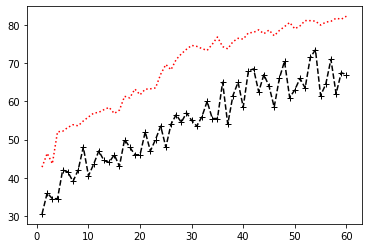

In [ ]:
plt.plot(iter, accuracy, 'k--+')   
plt.plot(iter, test_accuracy, 'r:')     
plt.show()

# The learning curve

> black: training

> red:   testing





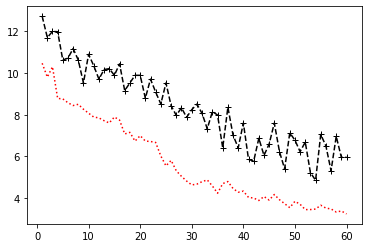

In [ ]:
plt.plot(iter, loss, 'k--+')   # black dashed line, with "+" markers
plt.plot(iter, test_loss, 'r:')     # red dotted line (no marker)
plt.show()

2. 
加上dropout使model不會完全fit training data, 會有更大的機率去match真實世界完整的data。所以可以觀察到train accuracy不會到這麼高, 反而是validation的accuracy高一些,而train loss也不會壓到太低, 因為隨機drop神經元, 所以不會使model overfitting.

# **3.(a)**

In [ ]:
noise_image = np.random.rand(256, 784)
noise_y = np.random.randint(5, size=(256,))

label_temp = np.zeros((256, 5), dtype = np.float32)
for i in range(256):
    label_temp[i][noise_y[i]] = 1
noise_y_onehot = np.copy(label_temp)


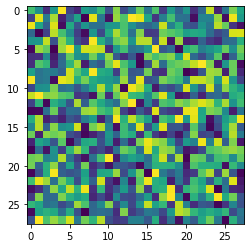

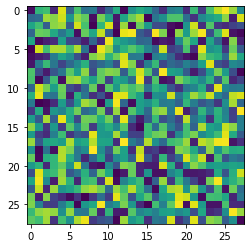

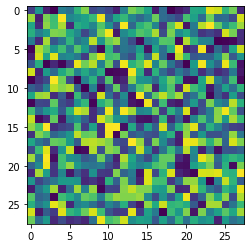

In [ ]:
#before
from matplotlib import pyplot as plt
for i in range(3):
  plt.imshow(noise_image.reshape((256, 28, 28))[i], interpolation='nearest')
  plt.show()

In [ ]:
bias = np.load('trained_biases.npy', allow_pickle=True)
weight = np.load('trained_weights.npy', allow_pickle=True)

In [ ]:
class _Layer(object):
    def __init__(self):
        pass

    def forward(self, *input):
        r"""Define the forward propagation of this layer.

        Should be overridden by all subclasses.
        """
        
        raise NotImplementedError

    def backward(self, *output_grad):
        r"""Define the backward propagation of this layer.

        Should be overridden by all subclasses.
        """
        raise NotImplementedError
        

class FullyConnected(_Layer):
    def __init__(self,n_in,n_out, weights, biases):
        self.weights = weights
        self.biases = biases

    def forward(self, x):
        self.old_x = x
        #print('shape', self.weights.shape, self.biases.shape)
        #print('self.weight',self.weights, 'b', self.biases )
        #print('output of FC,', np.dot(x,self.weights) + self.biases )
        return np.dot(x,self.weights) + self.biases

    def backward(self,grad):
        self.grad_b = grad.mean(axis=0)
        self.grad_w = (np.matmul(self.old_x[:,:,None],grad[:,None,:])).mean(axis=0)
        return np.dot(grad,self.weights.transpose())

    def backward_input(self,grad):
      return np.dot(grad,self.weights.transpose())

#00 - relu
class Relu(_Layer):
    def __init__(self):
        self.old_x=None;
        pass

    def forward(self, x):     
        self.old_x = np.copy(x)
        return np.clip(x,0,None)


    def backward(self, grad):
        return np.where(self.old_x>0,grad,0)
    def backward_input(self,grad):
        return np.where(self.old_x>0,grad,0)

class Softmax():
    def forward(self,x):
            max = np.amax(x, axis = 1, keepdims = True)
            #logsumexp = np.log(np.exp(x - max).sum())
            #self.old_y = x - max - logsumexp
            #print('softmax forward', self.old_y)
            #print('np.exp(x- max)', np.exp(x- max))
            #print('np.exp(x- max).sum(axis=1)', np.exp(x- max).sum(axis=1))
            self.old_y = np.exp(x- max) / np.exp(x- max).sum(axis=1) [:,None]
            #print('forward self.softmax', self.softmax)
            return self.old_y

    def backward(self,grad, yt):
            
            """for j in range(num_classes):
                  p = np.exp(f_i[j])/sum_i
                  dW[j, :] += (p-(j == y[i])) * X[:, i]"""
            #print('yt', yt.shape, yt)
            yt = self.old_y
            j_max = []
            for k in range(grad.shape[0]):
                jacobian_m = np.diag(yt[k])
                for i in range(len(jacobian_m)):
                    for j in range(len(jacobian_m)):
                        if i == j:
                            jacobian_m[i][j] = yt[k][i] * (1-yt[k][i])
                        else: 
                            jacobian_m[i][j] = -yt[k][i]*yt[k][j]
                der_dot_grad = np.dot(jacobian_m, grad[k].reshape((5, 1)))

                j_max.append(der_dot_grad)
            return np.array(j_max).reshape((200, 5))

            """j_max = []
            for k in range(grad.shape[0]): #self.old_y (200, 5)
                si_sj = - self.old_y[k] * self.old_y[k].reshape((5, 1))
                s_der = np.diag(self.old_y[k]) + si_sj
                s_der_grad = np.dot(s_der, grad[k].reshape((5, 1)))
                j_max.append(s_der_grad)
            #print('np.array(j_max)  shape', np.array(j_max).shape)
            return np.array(j_max).reshape((200, 5))"""
            """s = self.old_y.reshape(-1,1)
            return np.diagflat(s) - np.dot(s, s.T)"""

    def backward_input(self,grad):
            #print('backward self.softmax', self.softmax)
            return self.old_y * (grad -(grad * self.old_y).sum(axis=1)[:,None])
class CrossEntropy():
    def forward(self,x,y):
            self.old_x = x.clip(min=1e-8,max=None)
            self.old_y = y
            
            return x,-np.sum(y*np.log(self.old_x+1e-9))/x.shape[0]
            #return (np.where(y==1,-np.log(self.old_x), 0)).sum(axis=1)

    def backward(self):
            return np.where(self.old_y==1,-1/self.old_x, 0)
    

In [ ]:
class Model(object):
    def __init__(self, layers, cost):
        self.layers = layers
        self.cost = cost
        self.pred = None
    def forward(self,x):
        for layer in self.layers:
            
            x = layer.forward(x)
            #print('x', x)
        return x
    
    def loss(self,x,y):
        return self.cost.forward(self.forward(x),y)

    def backward(self):
        grad = self.cost.backward()
        #print('cost backward', grad)
        for i in range(len(self.layers)-1,-1,-1):
            #print(type(self.layers[i]))
            if(hasattr(self.layers[i], 'backward')):
                
                grad = self.layers[i].backward(grad)
                #print("backward",type(self.layers[i]), 'grad', grad)

    def backward_input(self):
        grad = self.cost.backward()
        #print('cost grad', grad)
        for i in range(len(self.layers)-1,-1,-1):
            
            if(hasattr(self.layers[i], 'backward_input')):
                grad = self.layers[i].backward_input(grad)
                #print('grad', grad)
        return grad

In [ ]:
net1 = Model([FullyConnected(784,2048, weight[0], bias[0]),Relu(),FullyConnected(2048,512, weight[1], bias[1]),Relu(),FullyConnected(512,5, weight[2], bias[2]),Softmax()], CrossEntropy())

In [ ]:
Learning_rate = 0.1
EPOCH = 5
loss = []
accuracy = []
for epoch in range(1, EPOCH+1):
    #print('epoch', epoch)
    
    train_loss=0
    val_loss=0
    train_hit = 0
    val_hit = 0
    total_train_loss = 0
    total_val_loss = 0

    #net1.train()
    pred,lo = net1.loss(noise_image, noise_y_onehot)
    train_loss=lo.sum()
    pred_index = np.argmax(pred, axis=1)
    train_hit += (pred_index==noise_y).sum()
    
    total_train_loss += train_loss
    
    grad_input = net1.backward_input()
    #print('grad_input', grad_input)
    #print('grad_input shape', grad_input.shape)
    noise_image -= Learning_rate * grad_input
    """for layer in net.layers:
        if type(layer) == FullyConnected:
            layer.weights -= Learning_rate * layer.grad_w
            layer.biases -= Learning_rate * layer.grad_b"""

  

    loss.append(train_loss)
    accuracy.append((pred_index==noise_y).sum()/256)

    print('Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(train_loss), '|Train Acc:%3.4f'%((pred_index==noise_y).sum()/(256)*100.0))




Epoch:  1 |Train Loss: 14.6891 |Train Acc:19.5312
Epoch:  2 |Train Loss: 14.6746 |Train Acc:19.9219
Epoch:  3 |Train Loss: 14.6746 |Train Acc:19.9219
Epoch:  4 |Train Loss: 14.6746 |Train Acc:19.9219
Epoch:  5 |Train Loss: 14.6746 |Train Acc:19.9219


#**The learning curve**

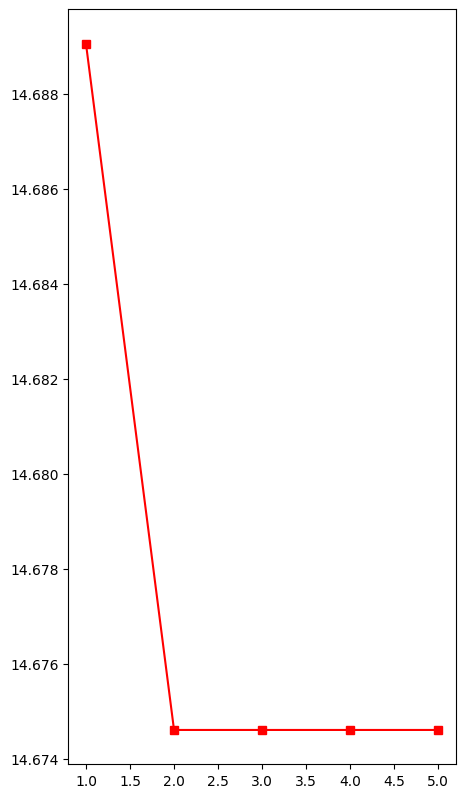

In [ ]:
import matplotlib.pyplot as plt
iter = []
for i in range(5):
    iter.append(i+1)
plt.figure(figsize=(5,10),dpi=100,linewidth = 2)
plt.plot(iter,loss,'s-',color = 'r', label="TSMC")

# **The accuracy**

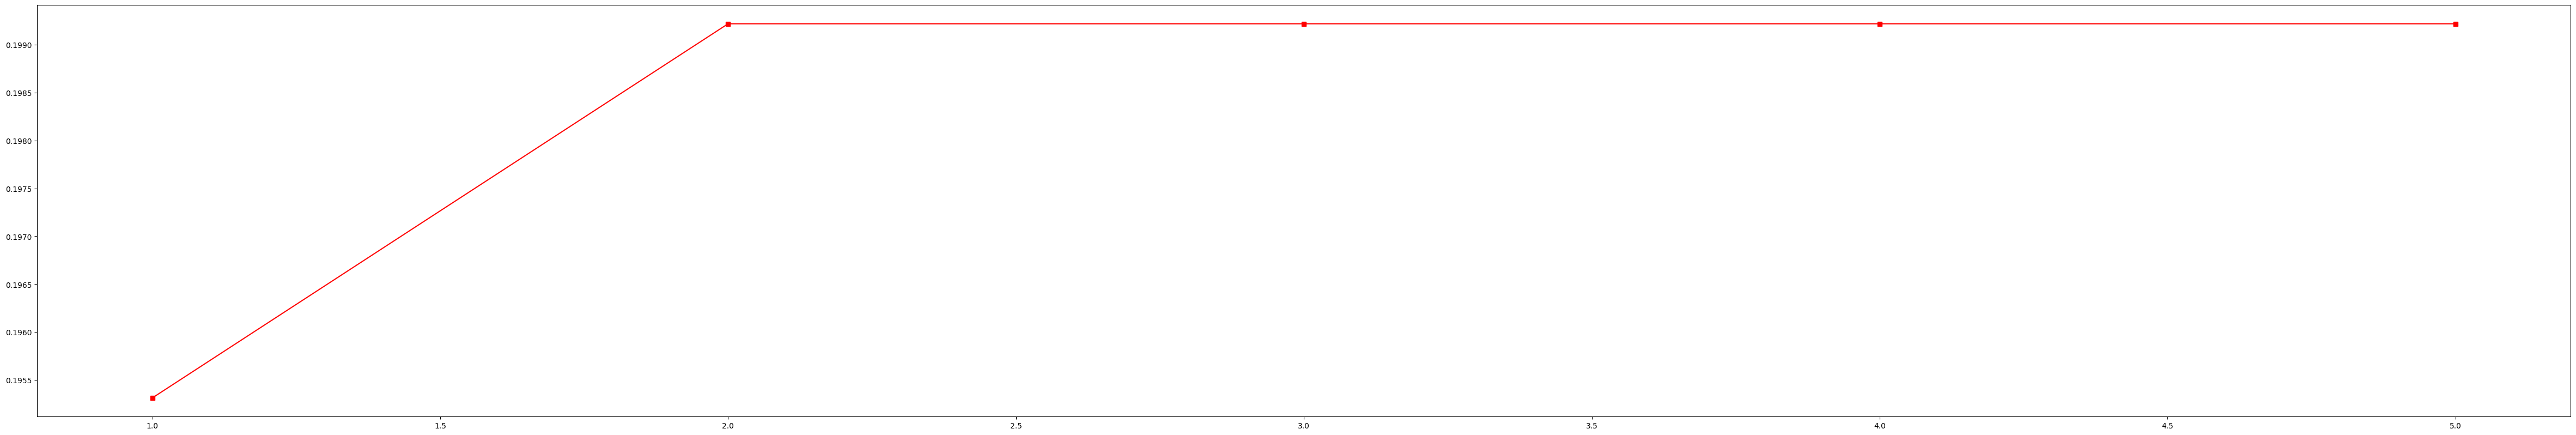

In [ ]:
plt.figure(figsize=(60,10),dpi=100,linewidth = 2)
plt.plot(iter,accuracy,'s-',color = 'r', label="TSMC")

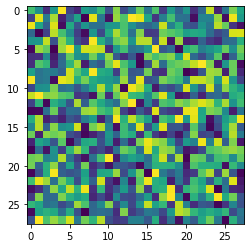

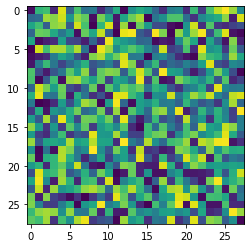

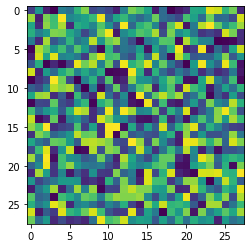

In [ ]:

from matplotlib import pyplot as plt
for i in range(3):
  plt.imshow(noise_image.reshape((256, 28, 28))[i], interpolation='nearest')
  plt.show()

3. 可以觀察到在一次的iteration accuracy上升後, 之後的accuracy跟loss都不會再變化。
而會有如此現象的原因是因為fix住FC layer的weight跟bias並去更新input , 所以讓第一次的iteration計算出gradient使input使用這個gradient更新後, 因為weight跟bias都不變所以算出來的gradient會變成0, 使後續的loss跟accuracy保持不變。